In [1]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F
import torchvision.models as models
import matplotlib.pyplot as plt

In [2]:
!pip install transformers

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
#!pip install numpy==1.22.4

In [5]:
from transformers import ViTModel

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
checkpoint_path = '/kaggle/input/pretrain-exp3/pretrained_ckpt_exp3.bin'

In [7]:
cp_state_dict = torch.load(checkpoint_path, map_location=torch.device('cuda'))


In [8]:
vit_model = ViTModel.from_pretrained('facebook/vit-mae-base', state_dict = cp_state_dict)

You are using a model of type vit_mae to instantiate a model of type vit. This is not supported for all configurations of models and can yield errors.


Some weights of the model checkpoint at facebook/vit-mae-base were not used when initializing ViTModel: ['decoder.decoder_layers.2.layernorm_after.weight', 'decoder.decoder_layers.1.intermediate.dense.bias', 'decoder.decoder_layers.0.attention.attention.key.weight', 'decoder.decoder_layers.3.attention.output.dense.bias', 'decoder.decoder_layers.2.attention.attention.value.weight', 'decoder.decoder_norm.weight', 'decoder.decoder_layers.0.layernorm_after.weight', 'decoder.decoder_layers.5.output.dense.weight', 'decoder.decoder_layers.2.attention.attention.value.bias', 'decoder.decoder_layers.1.layernorm_before.weight', 'decoder.decoder_embed.bias', 'decoder.decoder_layers.2.layernorm_before.weight', 'decoder.decoder_layers.3.attention.attention.key.bias', 'decoder.decoder_layers.3.attention.attention.query.bias', 'decoder.decoder_layers.5.attention.output.dense.weight', 'decoder.decoder_layers.2.output.dense.bias', 'decoder.decoder_layers.0.layernorm_before.weight', 'decoder.decoder_laye

In [9]:
vit_model

ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTAttention(
          (attention): ViTSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation(

In [10]:
class AgeGenderClassifier(nn.Module):
  def __init__(self):
    super(AgeGenderClassifier, self).__init__()
    self.vit = vit_model
    self.gender_bn = nn.BatchNorm1d(768)
    self.gender_classifier =nn.Linear(768,2)
    self.age_bn = nn.BatchNorm1d(768)
    self.age_regressor = nn.Linear(768,1)

  def forward(self, input_ids):
    outputs = self.vit(input_ids)
    pooler_output = outputs.pooler_output
    
    gender_output = self.gender_classifier(self.gender_bn(pooler_output))
    age_output = self.age_regressor(self.age_bn(pooler_output))
    return gender_output, age_output

In [11]:
age_gender_model = AgeGenderClassifier()

In [12]:
!pip install -q datasets transformers

In [13]:
from datasets import load_dataset
# loading UTKFace from HuggingFace https://huggingface.co/datasets/nlphuji/utk_faces
dataset = load_dataset('nlphuji/utk_faces')

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset dataset downloaded and prepared to /root/.cache/huggingface/datasets/nlphuji___dataset/TEST/1.1.0/60b003bec8467d7b5164765354625a2ef654d29e2a1f6595a54cf8fbbead96b9. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [14]:
dataset

DatasetDict({
    test: Dataset({
        features: ['image', 'age', 'gender', 'race', 'image_name'],
        num_rows: 23703
    })
})

In [15]:
dataset.shape

{'test': (23703, 5)}

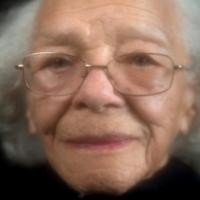

In [16]:
dataset['test']['image'][5]

In [17]:
label_age = dataset['test']['age']
label_gender = dataset['test']['gender']
label_gender_encode = []
for gender in label_gender:
  if gender == 'male':
    label_gender_encode.append(0)
  else:
    label_gender_encode.append(1)

In [18]:
from transformers import AutoImageProcessor
image_processor = AutoImageProcessor.from_pretrained("facebook/vit-mae-base")
image_processor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [24]:
from torchvision.transforms import(
    CenterCrop,
    Compose,
    Normalize,
    RandomRotation,
    RandomHorizontalFlip,
    ColorJitter,
    RandomResizedCrop,
    Resize,
    ToTensor
)

In [26]:
normalize = Normalize(mean = image_processor.image_mean, std = image_processor.image_std)
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

train_transforms = Compose(
        [
            RandomResizedCrop(crop_size),
            RandomHorizontalFlip(),
            RandomRotation(20),
            ColorJitter(brightness = 0.2, contrast = 0.2, saturation = 0.2, hue = 0.2),
            ToTensor(),
            normalize,
        ]
    )

test_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_test(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [test_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [27]:
# training + validation splitting
splits = dataset['test'].train_test_split(test_size = .1)
train_ds = splits['train']
test_ds = splits['test']

In [28]:
# transform train dataset and test dataset
train_ds.set_transform(preprocess_train)
test_ds.set_transform(preprocess_test)

In [29]:
train_ds[10]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=200x200>,
 'age': 28,
 'gender': 'female',
 'race': 'white',
 'image_name': '28_1_0_20170117092254042.jpg',
 'pixel_values': tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.03

In [30]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        pixel_values = item['pixel_values']
        gender = 1.0 if item['gender'] == 'female' else 0.0  # encode 'female' as 1.0 and 'male' as 0.0
        age = float(item['age'])
        return pixel_values, torch.tensor(gender), torch.tensor(age)

In [31]:
train_dataset = CustomDataset(train_ds)
test_dataset = CustomDataset(test_ds)

In [32]:
train_loader = DataLoader(train_dataset, batch_size=64 , shuffle=True, num_workers = 2)
test_loader = DataLoader(test_dataset,  batch_size=64, shuffle=True, num_workers = 2)

In [33]:
dataloaders = {'train': train_loader, 'test': test_loader}

In [34]:
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [36]:
from torch import optim
from torch.optim import lr_scheduler
#import copy
model = age_gender_model

# Specify the loss functions for each head
criterion1 = nn.CrossEntropyLoss()  # Binary Cross-Entropy Loss for the gender classification
criterion2 = nn.SmoothL1Loss(reduction='mean')

# Applying weight for eahc loss
weight_gender = 0.95
weight_age = 1- weight_gender

# Specify the optimizer
optimizer = optim.Adam(model.parameters(), lr= 10e-5, weight_decay = 1e-4)

# Specify the learning rate scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.1)

# Specify the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = nn.DataParallel(model)
model.to(device)

# Initialize empty lists to store loss and accuracy values
train_loss_values = []
train_acc_values = []
test_loss_values = []
test_acc_values = []

# Initialize additional lists to store MAE values
train_age_error_values = []
test_age_error_values = []

# Initialize the best model weights variable
#best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

#Dataset_sizes
dataset_sizes = {x: len(dataloaders[x].dataset) for x in ['train', 'test']}
# Number of epochs
num_epochs = 30

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs -1))
    print('-'*10)
    
    for phase in ['train', 'test']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        correct_gender_preds = 0
        total_gender_preds = 0
        total_age_error = 0

        for inputs, gender_labels, age_labels in tqdm(dataloaders[phase], desc=f'Epoch {epoch+1}/{num_epochs} {phase.capitalize()}'):
            inputs = inputs.to(device)
            gender_labels = gender_labels.to(device).long()
            age_labels = age_labels.to(device)

            optimizer.zero_grad()
            

            # forward
            with torch.set_grad_enabled(phase == 'train'):
                gender_preds, age_preds = model(inputs)
                # Calculate the losses for each head
                loss1 = criterion1(gender_preds, gender_labels)
                loss2 = criterion2(age_preds.view(-1), age_labels.float()) 
                # Total loss is the sum of the two losses
                loss = weight_gender*loss1 + weight_age*loss2
                print(loss)
                

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
        

            # Calculate the number of correct gender predictions
            _, predicted_genders = torch.max(gender_preds, 1)
            correct_gender_preds += (predicted_genders == gender_labels).sum().item()
            total_gender_preds += gender_labels.size(0)

            # Calculate the total age prediction error
            total_age_error += torch.sum(torch.abs(age_preds.view(-1) - age_labels.float())).item()
            
        if phase == 'train':
            scheduler.step()

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = correct_gender_preds / total_gender_preds
        epoch_age_error = total_age_error / dataset_sizes[phase]
        print('{} Loss: {:.4f} Acc: {:.4f} Age MAE: {:.4f}'.format(phase, epoch_loss, epoch_acc, epoch_age_error))
        
        # deep copy the model
        if phase == 'test' and epoch_acc > best_acc:
            best_acc = epoch_acc
            #best_model_wts = copy.deepcopy(model.state_dict())
            
        # Store loss and accuracy and MAE values for each epoch
        if phase == 'train':
            train_loss_values.append(epoch_loss)
            train_acc_values.append(epoch_acc)
            train_age_error_values.append(epoch_age_error)
        else:
            test_loss_values.append(epoch_loss)
            test_acc_values.append(epoch_acc)
            test_age_error_values.append(epoch_age_error)
            
    # Save model after each epoch for future training if needed
#     torch.save(model.state_dict(),f'/kaggle/working/model_epoch_{epoch+1}.pt')
#     print('State dict saved')

print('Best test Acc: {:4f}'.format(best_acc))

#L Load best model weights
#model.load_state_dict(best_model_wts)

Epoch 0/29
----------


Epoch 1/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(1.4064, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   0%|          | 1/334 [00:02<14:10,  2.55s/it]

tensor(1.6283, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   1%|          | 2/334 [00:03<09:35,  1.73s/it]

tensor(1.6320, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   1%|          | 3/334 [00:04<07:59,  1.45s/it]

tensor(1.4697, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   1%|          | 4/334 [00:05<07:13,  1.31s/it]

tensor(1.7322, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   1%|▏         | 5/334 [00:07<06:50,  1.25s/it]

tensor(1.4764, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   2%|▏         | 6/334 [00:08<06:34,  1.20s/it]

tensor(1.6590, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   2%|▏         | 7/334 [00:09<06:24,  1.18s/it]

tensor(1.7464, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   2%|▏         | 8/334 [00:10<06:16,  1.16s/it]

tensor(1.6051, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   3%|▎         | 9/334 [00:11<06:12,  1.15s/it]

tensor(1.3511, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   3%|▎         | 10/334 [00:12<06:09,  1.14s/it]

tensor(1.5394, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   3%|▎         | 11/334 [00:13<06:06,  1.14s/it]

tensor(1.4787, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   4%|▎         | 12/334 [00:14<06:05,  1.13s/it]

tensor(1.3343, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   4%|▍         | 13/334 [00:16<06:07,  1.15s/it]

tensor(1.6340, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   4%|▍         | 14/334 [00:17<06:13,  1.17s/it]

tensor(1.4115, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   4%|▍         | 15/334 [00:18<06:09,  1.16s/it]

tensor(1.7504, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   5%|▍         | 16/334 [00:19<06:05,  1.15s/it]

tensor(1.5948, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   5%|▌         | 17/334 [00:20<06:03,  1.15s/it]

tensor(1.5312, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   5%|▌         | 18/334 [00:21<06:02,  1.15s/it]

tensor(1.4390, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   6%|▌         | 19/334 [00:22<06:00,  1.15s/it]

tensor(1.3908, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   6%|▌         | 20/334 [00:24<05:58,  1.14s/it]

tensor(1.6770, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   6%|▋         | 21/334 [00:25<05:58,  1.14s/it]

tensor(1.6659, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   7%|▋         | 22/334 [00:26<05:57,  1.15s/it]

tensor(1.6648, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   7%|▋         | 23/334 [00:27<05:56,  1.15s/it]

tensor(1.4968, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   7%|▋         | 24/334 [00:28<05:55,  1.15s/it]

tensor(1.5629, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   7%|▋         | 25/334 [00:29<05:54,  1.15s/it]

tensor(1.6614, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   8%|▊         | 26/334 [00:31<05:54,  1.15s/it]

tensor(1.5109, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   8%|▊         | 27/334 [00:32<05:53,  1.15s/it]

tensor(1.5717, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   8%|▊         | 28/334 [00:33<05:53,  1.15s/it]

tensor(1.7381, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   9%|▊         | 29/334 [00:34<05:53,  1.16s/it]

tensor(1.6698, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   9%|▉         | 30/334 [00:35<05:52,  1.16s/it]

tensor(1.6023, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:   9%|▉         | 31/334 [00:36<05:51,  1.16s/it]

tensor(1.5546, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  10%|▉         | 32/334 [00:37<05:50,  1.16s/it]

tensor(1.2752, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  10%|▉         | 33/334 [00:39<05:49,  1.16s/it]

tensor(1.6012, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  10%|█         | 34/334 [00:40<05:49,  1.16s/it]

tensor(1.6395, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  10%|█         | 35/334 [00:41<05:47,  1.16s/it]

tensor(1.4744, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  11%|█         | 36/334 [00:42<05:46,  1.16s/it]

tensor(1.6445, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  11%|█         | 37/334 [00:43<05:46,  1.17s/it]

tensor(1.7311, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  11%|█▏        | 38/334 [00:45<05:45,  1.17s/it]

tensor(1.4452, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  12%|█▏        | 39/334 [00:46<05:44,  1.17s/it]

tensor(1.5161, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  12%|█▏        | 40/334 [00:47<05:43,  1.17s/it]

tensor(1.4626, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  12%|█▏        | 41/334 [00:48<05:49,  1.19s/it]

tensor(1.4641, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  13%|█▎        | 42/334 [00:49<05:45,  1.18s/it]

tensor(1.4180, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  13%|█▎        | 43/334 [00:50<05:42,  1.18s/it]

tensor(1.5421, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  13%|█▎        | 44/334 [00:52<05:41,  1.18s/it]

tensor(1.4689, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  13%|█▎        | 45/334 [00:53<05:38,  1.17s/it]

tensor(1.5107, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  14%|█▍        | 46/334 [00:54<05:35,  1.17s/it]

tensor(1.5269, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  14%|█▍        | 47/334 [00:55<05:33,  1.16s/it]

tensor(1.6048, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  14%|█▍        | 48/334 [00:56<05:31,  1.16s/it]

tensor(1.6413, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  15%|█▍        | 49/334 [00:57<05:30,  1.16s/it]

tensor(1.5120, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  15%|█▍        | 50/334 [00:59<05:28,  1.16s/it]

tensor(1.5710, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  15%|█▌        | 51/334 [01:00<05:27,  1.16s/it]

tensor(1.4301, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  16%|█▌        | 52/334 [01:01<05:25,  1.15s/it]

tensor(1.5311, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  16%|█▌        | 53/334 [01:02<05:24,  1.15s/it]

tensor(1.5793, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  16%|█▌        | 54/334 [01:03<05:22,  1.15s/it]

tensor(1.4852, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  16%|█▋        | 55/334 [01:04<05:21,  1.15s/it]

tensor(1.4018, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  17%|█▋        | 56/334 [01:05<05:19,  1.15s/it]

tensor(1.5705, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  17%|█▋        | 57/334 [01:07<05:18,  1.15s/it]

tensor(1.4899, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  17%|█▋        | 58/334 [01:08<05:16,  1.15s/it]

tensor(1.5141, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  18%|█▊        | 59/334 [01:09<05:15,  1.15s/it]

tensor(1.2977, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  18%|█▊        | 60/334 [01:10<05:14,  1.15s/it]

tensor(1.4266, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  18%|█▊        | 61/334 [01:11<05:13,  1.15s/it]

tensor(1.6236, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  19%|█▊        | 62/334 [01:12<05:12,  1.15s/it]

tensor(1.5509, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  19%|█▉        | 63/334 [01:13<05:10,  1.15s/it]

tensor(1.4069, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  19%|█▉        | 64/334 [01:15<05:09,  1.15s/it]

tensor(1.5875, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  19%|█▉        | 65/334 [01:16<05:09,  1.15s/it]

tensor(1.4625, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  20%|█▉        | 66/334 [01:17<05:08,  1.15s/it]

tensor(1.3219, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  20%|██        | 67/334 [01:18<05:07,  1.15s/it]

tensor(1.6614, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  20%|██        | 68/334 [01:19<05:11,  1.17s/it]

tensor(1.2181, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  21%|██        | 69/334 [01:21<05:21,  1.21s/it]

tensor(1.5776, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  21%|██        | 70/334 [01:22<05:16,  1.20s/it]

tensor(1.5534, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  21%|██▏       | 71/334 [01:23<05:12,  1.19s/it]

tensor(1.4642, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  22%|██▏       | 72/334 [01:24<05:08,  1.18s/it]

tensor(1.5330, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  22%|██▏       | 73/334 [01:25<05:06,  1.17s/it]

tensor(1.5285, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  22%|██▏       | 74/334 [01:26<05:04,  1.17s/it]

tensor(1.3117, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  22%|██▏       | 75/334 [01:28<05:02,  1.17s/it]

tensor(1.3547, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  23%|██▎       | 76/334 [01:29<05:02,  1.17s/it]

tensor(1.4635, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  23%|██▎       | 77/334 [01:30<05:01,  1.17s/it]

tensor(1.4606, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  23%|██▎       | 78/334 [01:31<04:59,  1.17s/it]

tensor(1.3878, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  24%|██▎       | 79/334 [01:32<04:58,  1.17s/it]

tensor(1.4210, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  24%|██▍       | 80/334 [01:33<04:57,  1.17s/it]

tensor(1.3016, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  24%|██▍       | 81/334 [01:35<04:57,  1.17s/it]

tensor(1.4559, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  25%|██▍       | 82/334 [01:36<04:55,  1.17s/it]

tensor(1.2834, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  25%|██▍       | 83/334 [01:37<04:54,  1.17s/it]

tensor(1.4706, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  25%|██▌       | 84/334 [01:38<04:53,  1.18s/it]

tensor(1.6827, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  25%|██▌       | 85/334 [01:39<04:52,  1.17s/it]

tensor(1.7497, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  26%|██▌       | 86/334 [01:40<04:51,  1.18s/it]

tensor(1.5223, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  26%|██▌       | 87/334 [01:42<04:50,  1.18s/it]

tensor(1.3935, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  26%|██▋       | 88/334 [01:43<04:49,  1.18s/it]

tensor(1.4472, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  27%|██▋       | 89/334 [01:44<04:49,  1.18s/it]

tensor(1.4414, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  27%|██▋       | 90/334 [01:45<04:47,  1.18s/it]

tensor(1.4298, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  27%|██▋       | 91/334 [01:46<04:46,  1.18s/it]

tensor(1.3802, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  28%|██▊       | 92/334 [01:48<04:46,  1.18s/it]

tensor(1.3406, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  28%|██▊       | 93/334 [01:49<04:44,  1.18s/it]

tensor(1.2976, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  28%|██▊       | 94/334 [01:50<04:43,  1.18s/it]

tensor(1.2385, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  28%|██▊       | 95/334 [01:51<04:43,  1.19s/it]

tensor(1.7373, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  29%|██▊       | 96/334 [01:52<04:53,  1.23s/it]

tensor(1.4501, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  29%|██▉       | 97/334 [01:54<04:48,  1.22s/it]

tensor(1.4332, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  29%|██▉       | 98/334 [01:55<04:45,  1.21s/it]

tensor(1.5094, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  30%|██▉       | 99/334 [01:56<04:42,  1.20s/it]

tensor(1.6724, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  30%|██▉       | 100/334 [01:57<04:40,  1.20s/it]

tensor(1.5434, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  30%|███       | 101/334 [01:58<04:39,  1.20s/it]

tensor(1.4881, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  31%|███       | 102/334 [02:00<04:37,  1.19s/it]

tensor(1.2775, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  31%|███       | 103/334 [02:01<04:35,  1.19s/it]

tensor(1.3507, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  31%|███       | 104/334 [02:02<04:34,  1.19s/it]

tensor(1.6402, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  31%|███▏      | 105/334 [02:03<04:33,  1.20s/it]

tensor(1.3387, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  32%|███▏      | 106/334 [02:04<04:32,  1.19s/it]

tensor(1.5040, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  32%|███▏      | 107/334 [02:06<04:29,  1.19s/it]

tensor(1.3031, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  32%|███▏      | 108/334 [02:07<04:27,  1.18s/it]

tensor(1.4815, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  33%|███▎      | 109/334 [02:08<04:25,  1.18s/it]

tensor(1.4453, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  33%|███▎      | 110/334 [02:09<04:23,  1.18s/it]

tensor(1.3495, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  33%|███▎      | 111/334 [02:10<04:22,  1.18s/it]

tensor(1.5052, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  34%|███▎      | 112/334 [02:11<04:21,  1.18s/it]

tensor(1.3029, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  34%|███▍      | 113/334 [02:13<04:19,  1.18s/it]

tensor(1.4961, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  34%|███▍      | 114/334 [02:14<04:18,  1.18s/it]

tensor(1.4661, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  34%|███▍      | 115/334 [02:15<04:17,  1.18s/it]

tensor(1.3613, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  35%|███▍      | 116/334 [02:16<04:16,  1.18s/it]

tensor(1.4444, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  35%|███▌      | 117/334 [02:17<04:15,  1.18s/it]

tensor(1.4345, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  35%|███▌      | 118/334 [02:18<04:14,  1.18s/it]

tensor(1.3309, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  36%|███▌      | 119/334 [02:20<04:13,  1.18s/it]

tensor(1.6429, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  36%|███▌      | 120/334 [02:21<04:12,  1.18s/it]

tensor(1.3875, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  36%|███▌      | 121/334 [02:22<04:11,  1.18s/it]

tensor(1.5631, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  37%|███▋      | 122/334 [02:23<04:10,  1.18s/it]

tensor(1.6105, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  37%|███▋      | 123/334 [02:25<04:17,  1.22s/it]

tensor(1.3162, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  37%|███▋      | 124/334 [02:26<04:13,  1.21s/it]

tensor(1.4411, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  37%|███▋      | 125/334 [02:27<04:11,  1.20s/it]

tensor(1.4489, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  38%|███▊      | 126/334 [02:28<04:08,  1.20s/it]

tensor(1.4005, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  38%|███▊      | 127/334 [02:29<04:07,  1.20s/it]

tensor(1.1802, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  38%|███▊      | 128/334 [02:30<04:05,  1.19s/it]

tensor(1.3721, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  39%|███▊      | 129/334 [02:32<04:04,  1.19s/it]

tensor(1.4632, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  39%|███▉      | 130/334 [02:33<04:03,  1.19s/it]

tensor(1.4374, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  39%|███▉      | 131/334 [02:34<04:01,  1.19s/it]

tensor(1.3799, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  40%|███▉      | 132/334 [02:35<04:00,  1.19s/it]

tensor(1.2570, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  40%|███▉      | 133/334 [02:36<03:59,  1.19s/it]

tensor(1.3848, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  40%|████      | 134/334 [02:38<03:57,  1.19s/it]

tensor(1.6257, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  40%|████      | 135/334 [02:39<03:56,  1.19s/it]

tensor(1.4825, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  41%|████      | 136/334 [02:40<03:55,  1.19s/it]

tensor(1.5483, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  41%|████      | 137/334 [02:41<03:54,  1.19s/it]

tensor(1.4664, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  41%|████▏     | 138/334 [02:42<03:53,  1.19s/it]

tensor(1.2735, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  42%|████▏     | 139/334 [02:44<03:53,  1.19s/it]

tensor(1.3742, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  42%|████▏     | 140/334 [02:45<03:51,  1.20s/it]

tensor(1.5325, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  42%|████▏     | 141/334 [02:46<03:50,  1.19s/it]

tensor(1.5307, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  43%|████▎     | 142/334 [02:47<03:49,  1.19s/it]

tensor(1.2311, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  43%|████▎     | 143/334 [02:48<03:48,  1.19s/it]

tensor(1.3811, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  43%|████▎     | 144/334 [02:50<03:46,  1.19s/it]

tensor(1.3718, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  43%|████▎     | 145/334 [02:51<03:45,  1.19s/it]

tensor(1.3095, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  44%|████▎     | 146/334 [02:52<03:44,  1.19s/it]

tensor(1.2653, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  44%|████▍     | 147/334 [02:53<03:43,  1.20s/it]

tensor(1.0965, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  44%|████▍     | 148/334 [02:54<03:42,  1.20s/it]

tensor(1.4097, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  45%|████▍     | 149/334 [02:56<03:45,  1.22s/it]

tensor(1.3223, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  45%|████▍     | 150/334 [02:57<03:50,  1.25s/it]

tensor(1.3667, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  45%|████▌     | 151/334 [02:58<03:46,  1.24s/it]

tensor(1.3747, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  46%|████▌     | 152/334 [02:59<03:42,  1.23s/it]

tensor(1.2789, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  46%|████▌     | 153/334 [03:01<03:40,  1.22s/it]

tensor(1.2755, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  46%|████▌     | 154/334 [03:02<03:38,  1.21s/it]

tensor(1.2007, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  46%|████▋     | 155/334 [03:03<03:35,  1.21s/it]

tensor(1.3731, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  47%|████▋     | 156/334 [03:04<03:34,  1.20s/it]

tensor(1.3704, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  47%|████▋     | 157/334 [03:05<03:32,  1.20s/it]

tensor(1.4505, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  47%|████▋     | 158/334 [03:07<03:31,  1.20s/it]

tensor(1.3552, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  48%|████▊     | 159/334 [03:08<03:29,  1.20s/it]

tensor(1.4363, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  48%|████▊     | 160/334 [03:09<03:28,  1.20s/it]

tensor(1.4393, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  48%|████▊     | 161/334 [03:10<03:27,  1.20s/it]

tensor(1.4292, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  49%|████▊     | 162/334 [03:11<03:26,  1.20s/it]

tensor(1.4972, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  49%|████▉     | 163/334 [03:13<03:24,  1.20s/it]

tensor(1.3832, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  49%|████▉     | 164/334 [03:14<03:23,  1.20s/it]

tensor(1.5754, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  49%|████▉     | 165/334 [03:15<03:22,  1.20s/it]

tensor(1.2845, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  50%|████▉     | 166/334 [03:16<03:21,  1.20s/it]

tensor(1.2897, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  50%|█████     | 167/334 [03:17<03:20,  1.20s/it]

tensor(1.5141, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  50%|█████     | 168/334 [03:19<03:19,  1.20s/it]

tensor(1.3536, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  51%|█████     | 169/334 [03:20<03:18,  1.20s/it]

tensor(1.3820, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  51%|█████     | 170/334 [03:21<03:17,  1.20s/it]

tensor(1.5670, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  51%|█████     | 171/334 [03:22<03:16,  1.20s/it]

tensor(1.3898, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  51%|█████▏    | 172/334 [03:23<03:15,  1.20s/it]

tensor(1.3238, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  52%|█████▏    | 173/334 [03:25<03:14,  1.21s/it]

tensor(1.3640, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  52%|█████▏    | 174/334 [03:26<03:12,  1.20s/it]

tensor(1.5299, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  52%|█████▏    | 175/334 [03:27<03:12,  1.21s/it]

tensor(1.3460, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  53%|█████▎    | 176/334 [03:28<03:17,  1.25s/it]

tensor(1.2949, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  53%|█████▎    | 177/334 [03:30<03:13,  1.23s/it]

tensor(1.2295, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  53%|█████▎    | 178/334 [03:31<03:10,  1.22s/it]

tensor(1.4654, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  54%|█████▎    | 179/334 [03:32<03:08,  1.22s/it]

tensor(1.3893, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  54%|█████▍    | 180/334 [03:33<03:06,  1.21s/it]

tensor(1.4397, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  54%|█████▍    | 181/334 [03:34<03:05,  1.21s/it]

tensor(1.3497, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  54%|█████▍    | 182/334 [03:36<03:03,  1.21s/it]

tensor(1.1399, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  55%|█████▍    | 183/334 [03:37<03:02,  1.21s/it]

tensor(1.3135, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  55%|█████▌    | 184/334 [03:38<03:01,  1.21s/it]

tensor(1.3989, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  55%|█████▌    | 185/334 [03:39<02:59,  1.21s/it]

tensor(1.3789, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  56%|█████▌    | 186/334 [03:40<02:58,  1.21s/it]

tensor(1.3065, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  56%|█████▌    | 187/334 [03:42<02:57,  1.21s/it]

tensor(1.2444, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  56%|█████▋    | 188/334 [03:43<02:56,  1.21s/it]

tensor(1.2974, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  57%|█████▋    | 189/334 [03:44<02:54,  1.21s/it]

tensor(1.2606, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  57%|█████▋    | 190/334 [03:45<02:53,  1.21s/it]

tensor(1.3754, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  57%|█████▋    | 191/334 [03:46<02:52,  1.21s/it]

tensor(1.4499, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  57%|█████▋    | 192/334 [03:48<02:51,  1.21s/it]

tensor(1.6100, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  58%|█████▊    | 193/334 [03:49<02:50,  1.21s/it]

tensor(1.4326, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  58%|█████▊    | 194/334 [03:50<02:48,  1.21s/it]

tensor(1.4001, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  58%|█████▊    | 195/334 [03:51<02:47,  1.21s/it]

tensor(1.4271, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  59%|█████▊    | 196/334 [03:52<02:47,  1.21s/it]

tensor(1.2612, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  59%|█████▉    | 197/334 [03:54<02:46,  1.21s/it]

tensor(1.1409, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  59%|█████▉    | 198/334 [03:55<02:44,  1.21s/it]

tensor(1.2872, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  60%|█████▉    | 199/334 [03:56<02:43,  1.21s/it]

tensor(1.1290, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  60%|█████▉    | 200/334 [03:57<02:42,  1.22s/it]

tensor(1.4693, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  60%|██████    | 201/334 [03:59<02:41,  1.21s/it]

tensor(1.5593, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  60%|██████    | 202/334 [04:00<02:41,  1.23s/it]

tensor(1.1480, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  61%|██████    | 203/334 [04:01<02:41,  1.23s/it]

tensor(1.1889, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  61%|██████    | 204/334 [04:02<02:39,  1.23s/it]

tensor(1.3140, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  61%|██████▏   | 205/334 [04:03<02:37,  1.22s/it]

tensor(1.1098, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  62%|██████▏   | 206/334 [04:05<02:36,  1.22s/it]

tensor(1.1223, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  62%|██████▏   | 207/334 [04:06<02:35,  1.22s/it]

tensor(1.1453, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  62%|██████▏   | 208/334 [04:07<02:33,  1.22s/it]

tensor(1.2600, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  63%|██████▎   | 209/334 [04:08<02:32,  1.22s/it]

tensor(1.3577, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  63%|██████▎   | 210/334 [04:10<02:32,  1.23s/it]

tensor(1.1422, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  63%|██████▎   | 211/334 [04:11<02:30,  1.22s/it]

tensor(1.2818, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  63%|██████▎   | 212/334 [04:12<02:29,  1.22s/it]

tensor(1.3893, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  64%|██████▍   | 213/334 [04:13<02:27,  1.22s/it]

tensor(1.1894, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  64%|██████▍   | 214/334 [04:14<02:26,  1.22s/it]

tensor(1.4040, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  64%|██████▍   | 215/334 [04:16<02:24,  1.22s/it]

tensor(1.2577, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  65%|██████▍   | 216/334 [04:17<02:23,  1.22s/it]

tensor(1.3387, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  65%|██████▍   | 217/334 [04:18<02:22,  1.22s/it]

tensor(1.3876, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  65%|██████▌   | 218/334 [04:19<02:21,  1.22s/it]

tensor(1.3076, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  66%|██████▌   | 219/334 [04:20<02:20,  1.22s/it]

tensor(1.3113, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  66%|██████▌   | 220/334 [04:22<02:19,  1.22s/it]

tensor(1.3565, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  66%|██████▌   | 221/334 [04:23<02:17,  1.22s/it]

tensor(1.3076, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  66%|██████▋   | 222/334 [04:24<02:16,  1.22s/it]

tensor(1.5044, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  67%|██████▋   | 223/334 [04:25<02:15,  1.22s/it]

tensor(1.4451, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  67%|██████▋   | 224/334 [04:27<02:14,  1.22s/it]

tensor(1.2161, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  67%|██████▋   | 225/334 [04:28<02:12,  1.22s/it]

tensor(1.3906, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  68%|██████▊   | 226/334 [04:29<02:11,  1.22s/it]

tensor(1.3219, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  68%|██████▊   | 227/334 [04:30<02:10,  1.22s/it]

tensor(1.5641, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  68%|██████▊   | 228/334 [04:32<02:11,  1.24s/it]

tensor(1.4918, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  69%|██████▊   | 229/334 [04:33<02:10,  1.24s/it]

tensor(1.3587, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  69%|██████▉   | 230/334 [04:34<02:08,  1.24s/it]

tensor(1.3567, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  69%|██████▉   | 231/334 [04:35<02:06,  1.23s/it]

tensor(1.4305, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  69%|██████▉   | 232/334 [04:36<02:05,  1.23s/it]

tensor(1.1718, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  70%|██████▉   | 233/334 [04:38<02:03,  1.22s/it]

tensor(1.0749, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  70%|███████   | 234/334 [04:39<02:02,  1.22s/it]

tensor(1.3755, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  70%|███████   | 235/334 [04:40<02:01,  1.22s/it]

tensor(1.4528, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  71%|███████   | 236/334 [04:41<02:00,  1.22s/it]

tensor(1.3891, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  71%|███████   | 237/334 [04:43<01:58,  1.22s/it]

tensor(1.3645, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  71%|███████▏  | 238/334 [04:44<01:57,  1.22s/it]

tensor(1.6135, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  72%|███████▏  | 239/334 [04:45<01:56,  1.22s/it]

tensor(1.2037, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  72%|███████▏  | 240/334 [04:46<01:55,  1.23s/it]

tensor(1.5017, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  72%|███████▏  | 241/334 [04:47<01:53,  1.22s/it]

tensor(1.3988, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  72%|███████▏  | 242/334 [04:49<01:52,  1.22s/it]

tensor(1.2209, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  73%|███████▎  | 243/334 [04:50<01:51,  1.22s/it]

tensor(1.2706, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  73%|███████▎  | 244/334 [04:51<01:49,  1.22s/it]

tensor(1.3938, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  73%|███████▎  | 245/334 [04:52<01:48,  1.22s/it]

tensor(1.3829, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  74%|███████▎  | 246/334 [04:54<01:47,  1.22s/it]

tensor(1.1573, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  74%|███████▍  | 247/334 [04:55<01:46,  1.22s/it]

tensor(1.2082, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  74%|███████▍  | 248/334 [04:56<01:45,  1.22s/it]

tensor(1.0941, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  75%|███████▍  | 249/334 [04:57<01:43,  1.22s/it]

tensor(1.1540, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  75%|███████▍  | 250/334 [04:58<01:42,  1.22s/it]

tensor(1.3048, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  75%|███████▌  | 251/334 [05:00<01:41,  1.22s/it]

tensor(1.2563, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  75%|███████▌  | 252/334 [05:01<01:40,  1.22s/it]

tensor(1.1992, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  76%|███████▌  | 253/334 [05:02<01:39,  1.22s/it]

tensor(1.1888, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  76%|███████▌  | 254/334 [05:03<01:39,  1.24s/it]

tensor(1.1195, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  76%|███████▋  | 255/334 [05:05<01:38,  1.24s/it]

tensor(1.3798, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  77%|███████▋  | 256/334 [05:06<01:36,  1.24s/it]

tensor(1.5553, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  77%|███████▋  | 257/334 [05:07<01:34,  1.23s/it]

tensor(1.2918, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  77%|███████▋  | 258/334 [05:08<01:33,  1.23s/it]

tensor(1.2275, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  78%|███████▊  | 259/334 [05:10<01:31,  1.23s/it]

tensor(1.2096, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  78%|███████▊  | 260/334 [05:11<01:30,  1.22s/it]

tensor(1.2553, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  78%|███████▊  | 261/334 [05:12<01:29,  1.22s/it]

tensor(1.2702, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  78%|███████▊  | 262/334 [05:13<01:28,  1.22s/it]

tensor(1.4086, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  79%|███████▊  | 263/334 [05:14<01:26,  1.22s/it]

tensor(1.2243, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  79%|███████▉  | 264/334 [05:16<01:25,  1.22s/it]

tensor(1.4228, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  79%|███████▉  | 265/334 [05:17<01:24,  1.22s/it]

tensor(1.3758, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  80%|███████▉  | 266/334 [05:18<01:23,  1.22s/it]

tensor(1.2849, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  80%|███████▉  | 267/334 [05:19<01:21,  1.22s/it]

tensor(1.2386, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  80%|████████  | 268/334 [05:21<01:20,  1.22s/it]

tensor(1.3384, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  81%|████████  | 269/334 [05:22<01:19,  1.23s/it]

tensor(1.3137, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  81%|████████  | 270/334 [05:23<01:18,  1.23s/it]

tensor(1.3958, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  81%|████████  | 271/334 [05:24<01:17,  1.23s/it]

tensor(1.2219, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  81%|████████▏ | 272/334 [05:25<01:16,  1.23s/it]

tensor(1.0863, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  82%|████████▏ | 273/334 [05:27<01:14,  1.23s/it]

tensor(1.2760, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  82%|████████▏ | 274/334 [05:28<01:13,  1.23s/it]

tensor(1.2051, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  82%|████████▏ | 275/334 [05:29<01:12,  1.23s/it]

tensor(1.1735, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  83%|████████▎ | 276/334 [05:30<01:11,  1.22s/it]

tensor(1.0034, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  83%|████████▎ | 277/334 [05:32<01:09,  1.23s/it]

tensor(1.0779, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  83%|████████▎ | 278/334 [05:33<01:08,  1.23s/it]

tensor(1.2357, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  84%|████████▎ | 279/334 [05:34<01:07,  1.23s/it]

tensor(1.0915, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  84%|████████▍ | 280/334 [05:35<01:07,  1.25s/it]

tensor(1.1783, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  84%|████████▍ | 281/334 [05:37<01:06,  1.25s/it]

tensor(1.2659, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  84%|████████▍ | 282/334 [05:38<01:04,  1.24s/it]

tensor(1.2534, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  85%|████████▍ | 283/334 [05:39<01:03,  1.24s/it]

tensor(1.6505, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  85%|████████▌ | 284/334 [05:40<01:01,  1.24s/it]

tensor(1.1244, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  85%|████████▌ | 285/334 [05:42<01:00,  1.24s/it]

tensor(1.1294, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  86%|████████▌ | 286/334 [05:43<00:59,  1.24s/it]

tensor(1.1838, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  86%|████████▌ | 287/334 [05:44<00:58,  1.24s/it]

tensor(1.1902, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  86%|████████▌ | 288/334 [05:45<00:56,  1.23s/it]

tensor(1.5124, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  87%|████████▋ | 289/334 [05:46<00:55,  1.23s/it]

tensor(1.1084, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  87%|████████▋ | 290/334 [05:48<00:54,  1.23s/it]

tensor(1.2494, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  87%|████████▋ | 291/334 [05:49<00:52,  1.23s/it]

tensor(1.2010, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  87%|████████▋ | 292/334 [05:50<00:51,  1.23s/it]

tensor(1.0729, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  88%|████████▊ | 293/334 [05:51<00:50,  1.23s/it]

tensor(1.1199, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  88%|████████▊ | 294/334 [05:53<00:49,  1.23s/it]

tensor(1.1146, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  88%|████████▊ | 295/334 [05:54<00:48,  1.23s/it]

tensor(1.1288, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  89%|████████▊ | 296/334 [05:55<00:46,  1.23s/it]

tensor(1.4016, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  89%|████████▉ | 297/334 [05:56<00:45,  1.23s/it]

tensor(1.3138, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  89%|████████▉ | 298/334 [05:58<00:44,  1.23s/it]

tensor(1.2084, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  90%|████████▉ | 299/334 [05:59<00:43,  1.23s/it]

tensor(1.0888, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  90%|████████▉ | 300/334 [06:00<00:41,  1.24s/it]

tensor(1.0779, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  90%|█████████ | 301/334 [06:01<00:40,  1.23s/it]

tensor(1.1856, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  90%|█████████ | 302/334 [06:02<00:39,  1.23s/it]

tensor(1.3212, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  91%|█████████ | 303/334 [06:04<00:38,  1.23s/it]

tensor(1.1740, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  91%|█████████ | 304/334 [06:05<00:36,  1.23s/it]

tensor(1.2055, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  91%|█████████▏| 305/334 [06:06<00:35,  1.24s/it]

tensor(1.0799, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  92%|█████████▏| 306/334 [06:07<00:35,  1.25s/it]

tensor(1.4407, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  92%|█████████▏| 307/334 [06:09<00:33,  1.25s/it]

tensor(1.1685, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  92%|█████████▏| 308/334 [06:10<00:32,  1.24s/it]

tensor(1.2829, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  93%|█████████▎| 309/334 [06:11<00:31,  1.24s/it]

tensor(1.4662, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  93%|█████████▎| 310/334 [06:12<00:29,  1.24s/it]

tensor(1.3062, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  93%|█████████▎| 311/334 [06:14<00:28,  1.24s/it]

tensor(0.9628, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  93%|█████████▎| 312/334 [06:15<00:27,  1.25s/it]

tensor(1.4558, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  94%|█████████▎| 313/334 [06:16<00:26,  1.25s/it]

tensor(1.1232, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  94%|█████████▍| 314/334 [06:17<00:24,  1.24s/it]

tensor(1.2440, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  94%|█████████▍| 315/334 [06:19<00:23,  1.24s/it]

tensor(1.2869, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  95%|█████████▍| 316/334 [06:20<00:22,  1.24s/it]

tensor(1.2650, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  95%|█████████▍| 317/334 [06:21<00:21,  1.24s/it]

tensor(1.0518, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  95%|█████████▌| 318/334 [06:22<00:19,  1.24s/it]

tensor(0.9794, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  96%|█████████▌| 319/334 [06:24<00:18,  1.24s/it]

tensor(1.2719, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  96%|█████████▌| 320/334 [06:25<00:17,  1.24s/it]

tensor(1.3233, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  96%|█████████▌| 321/334 [06:26<00:16,  1.24s/it]

tensor(1.1592, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  96%|█████████▋| 322/334 [06:27<00:14,  1.24s/it]

tensor(1.2784, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  97%|█████████▋| 323/334 [06:29<00:13,  1.24s/it]

tensor(1.3267, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  97%|█████████▋| 324/334 [06:30<00:12,  1.24s/it]

tensor(1.1174, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  97%|█████████▋| 325/334 [06:31<00:11,  1.24s/it]

tensor(1.1284, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  98%|█████████▊| 326/334 [06:32<00:09,  1.24s/it]

tensor(1.0871, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  98%|█████████▊| 327/334 [06:34<00:08,  1.24s/it]

tensor(1.1883, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  98%|█████████▊| 328/334 [06:35<00:07,  1.24s/it]

tensor(1.0629, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  99%|█████████▊| 329/334 [06:36<00:06,  1.24s/it]

tensor(1.4848, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  99%|█████████▉| 330/334 [06:37<00:04,  1.24s/it]

tensor(1.0564, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  99%|█████████▉| 331/334 [06:38<00:03,  1.24s/it]

tensor(1.3541, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train:  99%|█████████▉| 332/334 [06:40<00:02,  1.24s/it]

tensor(1.2463, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train: 100%|█████████▉| 333/334 [06:41<00:01,  1.24s/it]

tensor(1.4262, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 1/30 Train: 100%|██████████| 334/334 [06:42<00:00,  1.20s/it]


train Loss: 1.3754 Acc: 0.8542 Age MAE: 21.9365


Epoch 1/30 Test:   3%|▎         | 1/38 [00:01<00:39,  1.05s/it]

tensor(0.8026, device='cuda:0')


Epoch 1/30 Test:   5%|▌         | 2/38 [00:01<00:26,  1.34it/s]

tensor(0.9865, device='cuda:0')


Epoch 1/30 Test:   8%|▊         | 3/38 [00:02<00:21,  1.62it/s]

tensor(0.9703, device='cuda:0')


Epoch 1/30 Test:  11%|█         | 4/38 [00:02<00:18,  1.81it/s]

tensor(0.9913, device='cuda:0')


Epoch 1/30 Test:  13%|█▎        | 5/38 [00:02<00:17,  1.94it/s]

tensor(1.0322, device='cuda:0')


Epoch 1/30 Test:  16%|█▌        | 6/38 [00:03<00:15,  2.01it/s]

tensor(0.9252, device='cuda:0')


Epoch 1/30 Test:  18%|█▊        | 7/38 [00:03<00:14,  2.07it/s]

tensor(1.1474, device='cuda:0')


Epoch 1/30 Test:  21%|██        | 8/38 [00:04<00:14,  2.11it/s]

tensor(0.9408, device='cuda:0')


Epoch 1/30 Test:  24%|██▎       | 9/38 [00:04<00:13,  2.13it/s]

tensor(0.7856, device='cuda:0')


Epoch 1/30 Test:  26%|██▋       | 10/38 [00:05<00:13,  2.15it/s]

tensor(0.8123, device='cuda:0')


Epoch 1/30 Test:  29%|██▉       | 11/38 [00:05<00:12,  2.16it/s]

tensor(0.8502, device='cuda:0')


Epoch 1/30 Test:  32%|███▏      | 12/38 [00:06<00:12,  2.17it/s]

tensor(1.0743, device='cuda:0')


Epoch 1/30 Test:  34%|███▍      | 13/38 [00:06<00:11,  2.17it/s]

tensor(0.8352, device='cuda:0')


Epoch 1/30 Test:  37%|███▋      | 14/38 [00:07<00:11,  2.18it/s]

tensor(0.9039, device='cuda:0')


Epoch 1/30 Test:  39%|███▉      | 15/38 [00:07<00:10,  2.19it/s]

tensor(0.7837, device='cuda:0')


Epoch 1/30 Test:  42%|████▏     | 16/38 [00:07<00:10,  2.19it/s]

tensor(0.8394, device='cuda:0')


Epoch 1/30 Test:  45%|████▍     | 17/38 [00:08<00:09,  2.19it/s]

tensor(1.0834, device='cuda:0')


Epoch 1/30 Test:  47%|████▋     | 18/38 [00:08<00:09,  2.19it/s]

tensor(0.9142, device='cuda:0')


Epoch 1/30 Test:  50%|█████     | 19/38 [00:09<00:08,  2.19it/s]

tensor(0.9618, device='cuda:0')


Epoch 1/30 Test:  53%|█████▎    | 20/38 [00:09<00:08,  2.19it/s]

tensor(1.0338, device='cuda:0')


Epoch 1/30 Test:  55%|█████▌    | 21/38 [00:10<00:07,  2.19it/s]

tensor(0.8933, device='cuda:0')


Epoch 1/30 Test:  58%|█████▊    | 22/38 [00:10<00:07,  2.19it/s]

tensor(1.0459, device='cuda:0')


Epoch 1/30 Test:  61%|██████    | 23/38 [00:11<00:06,  2.20it/s]

tensor(0.9156, device='cuda:0')


Epoch 1/30 Test:  63%|██████▎   | 24/38 [00:11<00:06,  2.20it/s]

tensor(0.9043, device='cuda:0')


Epoch 1/30 Test:  66%|██████▌   | 25/38 [00:12<00:05,  2.20it/s]

tensor(0.9991, device='cuda:0')


Epoch 1/30 Test:  68%|██████▊   | 26/38 [00:12<00:05,  2.20it/s]

tensor(0.7124, device='cuda:0')


Epoch 1/30 Test:  71%|███████   | 27/38 [00:12<00:05,  2.20it/s]

tensor(1.0438, device='cuda:0')


Epoch 1/30 Test:  74%|███████▎  | 28/38 [00:13<00:04,  2.20it/s]

tensor(0.8285, device='cuda:0')


Epoch 1/30 Test:  76%|███████▋  | 29/38 [00:13<00:04,  2.19it/s]

tensor(1.0140, device='cuda:0')


Epoch 1/30 Test:  79%|███████▉  | 30/38 [00:14<00:03,  2.18it/s]

tensor(0.9657, device='cuda:0')


Epoch 1/30 Test:  82%|████████▏ | 31/38 [00:14<00:03,  2.18it/s]

tensor(0.9461, device='cuda:0')


Epoch 1/30 Test:  84%|████████▍ | 32/38 [00:15<00:02,  2.18it/s]

tensor(0.8811, device='cuda:0')


Epoch 1/30 Test:  87%|████████▋ | 33/38 [00:15<00:02,  2.18it/s]

tensor(1.1363, device='cuda:0')


Epoch 1/30 Test:  89%|████████▉ | 34/38 [00:16<00:01,  2.19it/s]

tensor(1.0553, device='cuda:0')


Epoch 1/30 Test:  92%|█████████▏| 35/38 [00:16<00:01,  2.20it/s]

tensor(1.1433, device='cuda:0')


Epoch 1/30 Test:  95%|█████████▍| 36/38 [00:17<00:00,  2.20it/s]

tensor(0.6962, device='cuda:0')


Epoch 1/30 Test:  97%|█████████▋| 37/38 [00:17<00:00,  2.21it/s]

tensor(1.0339, device='cuda:0')
tensor(0.4799, device='cuda:0')


Epoch 1/30 Test: 100%|██████████| 38/38 [00:17<00:00,  2.14it/s]


test Loss: 0.9424 Acc: 0.8899 Age MAE: 14.4620
Epoch 1/29
----------


Epoch 2/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(1.1697, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   0%|          | 1/334 [00:02<13:42,  2.47s/it]

tensor(1.1324, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   1%|          | 2/334 [00:03<09:47,  1.77s/it]

tensor(1.2737, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   1%|          | 3/334 [00:04<08:24,  1.52s/it]

tensor(1.1913, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   1%|          | 4/334 [00:06<07:44,  1.41s/it]

tensor(1.5857, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   1%|▏         | 5/334 [00:07<07:22,  1.35s/it]

tensor(1.2899, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   2%|▏         | 6/334 [00:08<07:09,  1.31s/it]

tensor(1.4773, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   2%|▏         | 7/334 [00:09<07:00,  1.29s/it]

tensor(1.2119, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   2%|▏         | 8/334 [00:11<07:01,  1.29s/it]

tensor(1.1285, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   3%|▎         | 9/334 [00:12<06:58,  1.29s/it]

tensor(1.2256, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   3%|▎         | 10/334 [00:13<06:52,  1.27s/it]

tensor(1.1514, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   3%|▎         | 11/334 [00:14<06:47,  1.26s/it]

tensor(1.3067, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   4%|▎         | 12/334 [00:16<06:44,  1.25s/it]

tensor(1.0762, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   4%|▍         | 13/334 [00:17<06:40,  1.25s/it]

tensor(1.0755, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   4%|▍         | 14/334 [00:18<06:38,  1.24s/it]

tensor(1.1671, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   4%|▍         | 15/334 [00:19<06:35,  1.24s/it]

tensor(1.2885, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   5%|▍         | 16/334 [00:21<06:33,  1.24s/it]

tensor(0.9984, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   5%|▌         | 17/334 [00:22<06:33,  1.24s/it]

tensor(1.1885, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   5%|▌         | 18/334 [00:23<06:31,  1.24s/it]

tensor(1.4292, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   6%|▌         | 19/334 [00:24<06:29,  1.24s/it]

tensor(1.0979, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   6%|▌         | 20/334 [00:26<06:28,  1.24s/it]

tensor(1.3234, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   6%|▋         | 21/334 [00:27<06:26,  1.24s/it]

tensor(1.2731, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   7%|▋         | 22/334 [00:28<06:25,  1.23s/it]

tensor(1.2785, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   7%|▋         | 23/334 [00:29<06:24,  1.24s/it]

tensor(0.9570, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   7%|▋         | 24/334 [00:31<06:23,  1.24s/it]

tensor(1.3745, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   7%|▋         | 25/334 [00:32<06:22,  1.24s/it]

tensor(1.1655, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   8%|▊         | 26/334 [00:33<06:20,  1.23s/it]

tensor(1.1877, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   8%|▊         | 27/334 [00:34<06:19,  1.23s/it]

tensor(1.1375, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   8%|▊         | 28/334 [00:35<06:18,  1.24s/it]

tensor(1.1419, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   9%|▊         | 29/334 [00:37<06:17,  1.24s/it]

tensor(0.9827, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   9%|▉         | 30/334 [00:38<06:16,  1.24s/it]

tensor(1.3844, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:   9%|▉         | 31/334 [00:39<06:15,  1.24s/it]

tensor(1.1905, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  10%|▉         | 32/334 [00:40<06:13,  1.24s/it]

tensor(1.1430, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  10%|▉         | 33/334 [00:42<06:13,  1.24s/it]

tensor(0.9683, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  10%|█         | 34/334 [00:43<06:22,  1.27s/it]

tensor(1.1104, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  10%|█         | 35/334 [00:44<06:21,  1.28s/it]

tensor(1.2408, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  11%|█         | 36/334 [00:46<06:17,  1.27s/it]

tensor(1.3520, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  11%|█         | 37/334 [00:47<06:13,  1.26s/it]

tensor(1.3220, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  11%|█▏        | 38/334 [00:48<06:10,  1.25s/it]

tensor(1.0653, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  12%|█▏        | 39/334 [00:49<06:07,  1.25s/it]

tensor(1.2756, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  12%|█▏        | 40/334 [00:51<06:05,  1.24s/it]

tensor(1.1402, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  12%|█▏        | 41/334 [00:52<06:03,  1.24s/it]

tensor(1.3139, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  13%|█▎        | 42/334 [00:53<06:01,  1.24s/it]

tensor(1.0014, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  13%|█▎        | 43/334 [00:54<06:00,  1.24s/it]

tensor(0.9066, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  13%|█▎        | 44/334 [00:55<05:58,  1.24s/it]

tensor(0.9867, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  13%|█▎        | 45/334 [00:57<05:57,  1.24s/it]

tensor(1.5410, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  14%|█▍        | 46/334 [00:58<05:56,  1.24s/it]

tensor(1.1335, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  14%|█▍        | 47/334 [00:59<05:54,  1.24s/it]

tensor(1.2248, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  14%|█▍        | 48/334 [01:00<05:53,  1.24s/it]

tensor(1.1879, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  15%|█▍        | 49/334 [01:02<05:52,  1.24s/it]

tensor(1.1066, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  15%|█▍        | 50/334 [01:03<05:50,  1.24s/it]

tensor(1.0854, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  15%|█▌        | 51/334 [01:04<05:49,  1.24s/it]

tensor(1.2808, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  16%|█▌        | 52/334 [01:05<05:48,  1.24s/it]

tensor(1.1656, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  16%|█▌        | 53/334 [01:07<05:46,  1.23s/it]

tensor(1.1303, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  16%|█▌        | 54/334 [01:08<05:46,  1.24s/it]

tensor(1.2679, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  16%|█▋        | 55/334 [01:09<05:44,  1.24s/it]

tensor(1.2494, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  17%|█▋        | 56/334 [01:10<05:43,  1.24s/it]

tensor(0.9546, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  17%|█▋        | 57/334 [01:12<05:41,  1.23s/it]

tensor(1.1805, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  17%|█▋        | 58/334 [01:13<05:40,  1.23s/it]

tensor(1.0188, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  18%|█▊        | 59/334 [01:14<05:39,  1.23s/it]

tensor(1.2010, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  18%|█▊        | 60/334 [01:15<05:43,  1.25s/it]

tensor(1.1847, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  18%|█▊        | 61/334 [01:17<05:40,  1.25s/it]

tensor(1.1085, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  19%|█▊        | 62/334 [01:18<05:38,  1.24s/it]

tensor(1.5331, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  19%|█▉        | 63/334 [01:19<05:36,  1.24s/it]

tensor(1.0240, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  19%|█▉        | 64/334 [01:20<05:34,  1.24s/it]

tensor(1.0432, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  19%|█▉        | 65/334 [01:21<05:32,  1.24s/it]

tensor(1.1356, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  20%|█▉        | 66/334 [01:23<05:31,  1.24s/it]

tensor(1.1739, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  20%|██        | 67/334 [01:24<05:30,  1.24s/it]

tensor(1.1790, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  20%|██        | 68/334 [01:25<05:28,  1.24s/it]

tensor(1.4236, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  21%|██        | 69/334 [01:26<05:27,  1.24s/it]

tensor(1.3403, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  21%|██        | 70/334 [01:28<05:26,  1.24s/it]

tensor(1.0328, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  21%|██▏       | 71/334 [01:29<05:25,  1.24s/it]

tensor(1.1114, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  22%|██▏       | 72/334 [01:30<05:23,  1.24s/it]

tensor(1.1930, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  22%|██▏       | 73/334 [01:31<05:22,  1.24s/it]

tensor(1.1335, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  22%|██▏       | 74/334 [01:33<05:21,  1.24s/it]

tensor(1.1912, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  22%|██▏       | 75/334 [01:34<05:20,  1.24s/it]

tensor(1.2523, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  23%|██▎       | 76/334 [01:35<05:18,  1.24s/it]

tensor(1.1198, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  23%|██▎       | 77/334 [01:36<05:17,  1.24s/it]

tensor(1.2675, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  23%|██▎       | 78/334 [01:38<05:16,  1.24s/it]

tensor(1.3788, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  24%|██▎       | 79/334 [01:39<05:15,  1.24s/it]

tensor(1.2364, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  24%|██▍       | 80/334 [01:40<05:14,  1.24s/it]

tensor(1.1090, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  24%|██▍       | 81/334 [01:41<05:12,  1.24s/it]

tensor(1.0695, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  25%|██▍       | 82/334 [01:42<05:11,  1.24s/it]

tensor(1.1169, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  25%|██▍       | 83/334 [01:44<05:10,  1.24s/it]

tensor(1.1604, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  25%|██▌       | 84/334 [01:45<05:09,  1.24s/it]

tensor(1.1423, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  25%|██▌       | 85/334 [01:46<05:08,  1.24s/it]

tensor(1.2642, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  26%|██▌       | 86/334 [01:47<05:11,  1.25s/it]

tensor(0.9989, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  26%|██▌       | 87/334 [01:49<05:08,  1.25s/it]

tensor(1.0497, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  26%|██▋       | 88/334 [01:50<05:06,  1.25s/it]

tensor(0.9776, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  27%|██▋       | 89/334 [01:51<05:04,  1.24s/it]

tensor(1.0920, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  27%|██▋       | 90/334 [01:52<05:02,  1.24s/it]

tensor(1.1220, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  27%|██▋       | 91/334 [01:54<05:01,  1.24s/it]

tensor(1.4579, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  28%|██▊       | 92/334 [01:55<04:59,  1.24s/it]

tensor(0.9264, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  28%|██▊       | 93/334 [01:56<04:58,  1.24s/it]

tensor(0.9661, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  28%|██▊       | 94/334 [01:57<04:56,  1.24s/it]

tensor(1.0482, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  28%|██▊       | 95/334 [01:59<04:55,  1.24s/it]

tensor(0.9160, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  29%|██▊       | 96/334 [02:00<04:56,  1.25s/it]

tensor(1.1223, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  29%|██▉       | 97/334 [02:01<04:54,  1.24s/it]

tensor(0.8519, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  29%|██▉       | 98/334 [02:02<04:53,  1.24s/it]

tensor(1.1229, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  30%|██▉       | 99/334 [02:04<04:51,  1.24s/it]

tensor(1.1452, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  30%|██▉       | 100/334 [02:05<04:49,  1.24s/it]

tensor(1.1105, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  30%|███       | 101/334 [02:06<04:48,  1.24s/it]

tensor(1.1893, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  31%|███       | 102/334 [02:07<04:46,  1.24s/it]

tensor(1.4109, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  31%|███       | 103/334 [02:09<04:46,  1.24s/it]

tensor(0.9773, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  31%|███       | 104/334 [02:10<04:45,  1.24s/it]

tensor(0.8970, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  31%|███▏      | 105/334 [02:11<04:43,  1.24s/it]

tensor(0.9578, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  32%|███▏      | 106/334 [02:12<04:42,  1.24s/it]

tensor(1.1694, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  32%|███▏      | 107/334 [02:13<04:40,  1.24s/it]

tensor(1.2668, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  32%|███▏      | 108/334 [02:15<04:39,  1.24s/it]

tensor(1.1883, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  33%|███▎      | 109/334 [02:16<04:38,  1.24s/it]

tensor(1.0200, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  33%|███▎      | 110/334 [02:17<04:36,  1.24s/it]

tensor(1.1344, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  33%|███▎      | 111/334 [02:18<04:36,  1.24s/it]

tensor(1.0150, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  34%|███▎      | 112/334 [02:20<04:41,  1.27s/it]

tensor(1.0053, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  34%|███▍      | 113/334 [02:21<04:38,  1.26s/it]

tensor(1.0614, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  34%|███▍      | 114/334 [02:22<04:35,  1.25s/it]

tensor(0.9786, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  34%|███▍      | 115/334 [02:23<04:33,  1.25s/it]

tensor(1.0550, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  35%|███▍      | 116/334 [02:25<04:31,  1.24s/it]

tensor(1.0088, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  35%|███▌      | 117/334 [02:26<04:29,  1.24s/it]

tensor(0.9974, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  35%|███▌      | 118/334 [02:27<04:27,  1.24s/it]

tensor(0.9253, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  36%|███▌      | 119/334 [02:28<04:26,  1.24s/it]

tensor(1.2002, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  36%|███▌      | 120/334 [02:30<04:24,  1.24s/it]

tensor(1.2590, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  36%|███▌      | 121/334 [02:31<04:23,  1.24s/it]

tensor(0.9703, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  37%|███▋      | 122/334 [02:32<04:22,  1.24s/it]

tensor(1.0894, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  37%|███▋      | 123/334 [02:33<04:20,  1.24s/it]

tensor(1.0497, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  37%|███▋      | 124/334 [02:35<04:19,  1.24s/it]

tensor(1.0208, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  37%|███▋      | 125/334 [02:36<04:18,  1.24s/it]

tensor(1.1368, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  38%|███▊      | 126/334 [02:37<04:17,  1.24s/it]

tensor(1.1696, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  38%|███▊      | 127/334 [02:38<04:16,  1.24s/it]

tensor(1.1235, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  38%|███▊      | 128/334 [02:40<04:15,  1.24s/it]

tensor(0.9914, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  39%|███▊      | 129/334 [02:41<04:14,  1.24s/it]

tensor(1.0341, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  39%|███▉      | 130/334 [02:42<04:12,  1.24s/it]

tensor(1.2112, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  39%|███▉      | 131/334 [02:43<04:11,  1.24s/it]

tensor(1.1357, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  40%|███▉      | 132/334 [02:45<04:11,  1.24s/it]

tensor(1.3028, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  40%|███▉      | 133/334 [02:46<04:09,  1.24s/it]

tensor(0.7854, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  40%|████      | 134/334 [02:47<04:07,  1.24s/it]

tensor(1.0531, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  40%|████      | 135/334 [02:48<04:06,  1.24s/it]

tensor(1.1831, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  41%|████      | 136/334 [02:50<04:06,  1.24s/it]

tensor(0.8407, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  41%|████      | 137/334 [02:51<04:08,  1.26s/it]

tensor(1.0648, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  41%|████▏     | 138/334 [02:52<04:09,  1.27s/it]

tensor(1.3454, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  42%|████▏     | 139/334 [02:53<04:06,  1.27s/it]

tensor(1.1197, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  42%|████▏     | 140/334 [02:55<04:03,  1.26s/it]

tensor(0.9333, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  42%|████▏     | 141/334 [02:56<04:01,  1.25s/it]

tensor(1.1057, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  43%|████▎     | 142/334 [02:57<03:59,  1.25s/it]

tensor(1.2455, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  43%|████▎     | 143/334 [02:58<03:57,  1.24s/it]

tensor(1.1260, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  43%|████▎     | 144/334 [03:00<03:55,  1.24s/it]

tensor(1.1018, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  43%|████▎     | 145/334 [03:01<03:54,  1.24s/it]

tensor(1.0049, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  44%|████▎     | 146/334 [03:02<03:52,  1.24s/it]

tensor(0.8282, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  44%|████▍     | 147/334 [03:03<03:51,  1.24s/it]

tensor(0.9603, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  44%|████▍     | 148/334 [03:04<03:50,  1.24s/it]

tensor(0.9860, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  45%|████▍     | 149/334 [03:06<03:48,  1.24s/it]

tensor(1.0350, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  45%|████▍     | 150/334 [03:07<03:47,  1.24s/it]

tensor(0.9912, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  45%|████▌     | 151/334 [03:08<03:46,  1.24s/it]

tensor(1.1213, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  46%|████▌     | 152/334 [03:09<03:45,  1.24s/it]

tensor(1.0602, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  46%|████▌     | 153/334 [03:11<03:44,  1.24s/it]

tensor(1.0023, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  46%|████▌     | 154/334 [03:12<03:43,  1.24s/it]

tensor(0.9468, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  46%|████▋     | 155/334 [03:13<03:42,  1.24s/it]

tensor(1.1167, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  47%|████▋     | 156/334 [03:14<03:40,  1.24s/it]

tensor(1.0036, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  47%|████▋     | 157/334 [03:16<03:39,  1.24s/it]

tensor(1.1173, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  47%|████▋     | 158/334 [03:17<03:39,  1.25s/it]

tensor(1.1215, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  48%|████▊     | 159/334 [03:18<03:37,  1.24s/it]

tensor(1.0878, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  48%|████▊     | 160/334 [03:19<03:36,  1.24s/it]

tensor(1.1320, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  48%|████▊     | 161/334 [03:21<03:34,  1.24s/it]

tensor(0.9615, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  49%|████▊     | 162/334 [03:22<03:34,  1.24s/it]

tensor(1.2352, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  49%|████▉     | 163/334 [03:23<03:32,  1.24s/it]

tensor(1.0711, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  49%|████▉     | 164/334 [03:24<03:30,  1.24s/it]

tensor(1.0443, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  49%|████▉     | 165/334 [03:26<03:29,  1.24s/it]

tensor(1.1766, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  50%|████▉     | 166/334 [03:27<03:27,  1.24s/it]

tensor(0.8764, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  50%|█████     | 167/334 [03:28<03:27,  1.24s/it]

tensor(1.1407, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  50%|█████     | 168/334 [03:29<03:25,  1.24s/it]

tensor(0.9860, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  51%|█████     | 169/334 [03:31<03:24,  1.24s/it]

tensor(1.0989, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  51%|█████     | 170/334 [03:32<03:23,  1.24s/it]

tensor(1.0152, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  51%|█████     | 171/334 [03:33<03:22,  1.24s/it]

tensor(1.0208, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  51%|█████▏    | 172/334 [03:34<03:21,  1.24s/it]

tensor(0.9698, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  52%|█████▏    | 173/334 [03:36<03:19,  1.24s/it]

tensor(0.8591, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  52%|█████▏    | 174/334 [03:37<03:18,  1.24s/it]

tensor(1.2426, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  52%|█████▏    | 175/334 [03:38<03:16,  1.24s/it]

tensor(0.8546, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  53%|█████▎    | 176/334 [03:39<03:15,  1.24s/it]

tensor(0.9625, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  53%|█████▎    | 177/334 [03:40<03:15,  1.24s/it]

tensor(1.0377, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  53%|█████▎    | 178/334 [03:42<03:13,  1.24s/it]

tensor(1.0129, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  54%|█████▎    | 179/334 [03:43<03:12,  1.24s/it]

tensor(1.1300, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  54%|█████▍    | 180/334 [03:44<03:10,  1.24s/it]

tensor(1.0612, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  54%|█████▍    | 181/334 [03:45<03:09,  1.24s/it]

tensor(0.8625, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  54%|█████▍    | 182/334 [03:47<03:08,  1.24s/it]

tensor(0.9616, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  55%|█████▍    | 183/334 [03:48<03:07,  1.24s/it]

tensor(0.9421, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  55%|█████▌    | 184/334 [03:49<03:06,  1.24s/it]

tensor(0.7825, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  55%|█████▌    | 185/334 [03:50<03:05,  1.24s/it]

tensor(0.7602, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  56%|█████▌    | 186/334 [03:52<03:03,  1.24s/it]

tensor(1.0686, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  56%|█████▌    | 187/334 [03:53<03:02,  1.24s/it]

tensor(0.9021, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  56%|█████▋    | 188/334 [03:54<03:03,  1.26s/it]

tensor(1.0978, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  57%|█████▋    | 189/334 [03:56<03:06,  1.28s/it]

tensor(0.8475, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  57%|█████▋    | 190/334 [03:57<03:02,  1.27s/it]

tensor(0.7639, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  57%|█████▋    | 191/334 [03:58<03:00,  1.26s/it]

tensor(1.0360, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  57%|█████▋    | 192/334 [03:59<02:58,  1.26s/it]

tensor(1.2249, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  58%|█████▊    | 193/334 [04:00<02:56,  1.25s/it]

tensor(1.0105, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  58%|█████▊    | 194/334 [04:02<02:55,  1.25s/it]

tensor(1.1329, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  58%|█████▊    | 195/334 [04:03<02:53,  1.25s/it]

tensor(0.9440, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  59%|█████▊    | 196/334 [04:04<02:52,  1.25s/it]

tensor(0.8284, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  59%|█████▉    | 197/334 [04:05<02:50,  1.25s/it]

tensor(0.9109, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  59%|█████▉    | 198/334 [04:07<02:49,  1.25s/it]

tensor(0.9798, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  60%|█████▉    | 199/334 [04:08<02:48,  1.25s/it]

tensor(1.2352, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  60%|█████▉    | 200/334 [04:09<02:46,  1.24s/it]

tensor(0.9473, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  60%|██████    | 201/334 [04:10<02:45,  1.25s/it]

tensor(1.1673, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  60%|██████    | 202/334 [04:12<02:44,  1.25s/it]

tensor(1.0201, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  61%|██████    | 203/334 [04:13<02:43,  1.25s/it]

tensor(0.9787, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  61%|██████    | 204/334 [04:14<02:42,  1.25s/it]

tensor(0.9618, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  61%|██████▏   | 205/334 [04:15<02:40,  1.25s/it]

tensor(0.9447, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  62%|██████▏   | 206/334 [04:17<02:39,  1.25s/it]

tensor(0.7691, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  62%|██████▏   | 207/334 [04:18<02:38,  1.25s/it]

tensor(0.8241, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  62%|██████▏   | 208/334 [04:19<02:36,  1.25s/it]

tensor(1.0450, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  63%|██████▎   | 209/334 [04:20<02:35,  1.25s/it]

tensor(1.0773, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  63%|██████▎   | 210/334 [04:22<02:34,  1.25s/it]

tensor(1.0492, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  63%|██████▎   | 211/334 [04:23<02:34,  1.26s/it]

tensor(1.0264, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  63%|██████▎   | 212/334 [04:24<02:33,  1.26s/it]

tensor(1.0112, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  64%|██████▍   | 213/334 [04:25<02:31,  1.25s/it]

tensor(0.9575, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  64%|██████▍   | 214/334 [04:27<02:31,  1.26s/it]

tensor(0.8854, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  64%|██████▍   | 215/334 [04:28<02:30,  1.26s/it]

tensor(0.8617, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  65%|██████▍   | 216/334 [04:29<02:28,  1.26s/it]

tensor(0.8182, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  65%|██████▍   | 217/334 [04:31<02:26,  1.26s/it]

tensor(0.9927, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  65%|██████▌   | 218/334 [04:32<02:25,  1.25s/it]

tensor(0.9411, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  66%|██████▌   | 219/334 [04:33<02:23,  1.25s/it]

tensor(1.0274, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  66%|██████▌   | 220/334 [04:34<02:22,  1.25s/it]

tensor(1.1455, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  66%|██████▌   | 221/334 [04:35<02:20,  1.25s/it]

tensor(0.9823, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  66%|██████▋   | 222/334 [04:37<02:19,  1.25s/it]

tensor(0.8707, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  67%|██████▋   | 223/334 [04:38<02:18,  1.24s/it]

tensor(0.8778, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  67%|██████▋   | 224/334 [04:39<02:16,  1.24s/it]

tensor(0.9574, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  67%|██████▋   | 225/334 [04:40<02:15,  1.24s/it]

tensor(0.9751, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  68%|██████▊   | 226/334 [04:42<02:14,  1.24s/it]

tensor(1.1381, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  68%|██████▊   | 227/334 [04:43<02:12,  1.24s/it]

tensor(0.9074, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  68%|██████▊   | 228/334 [04:44<02:11,  1.24s/it]

tensor(0.9865, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  69%|██████▊   | 229/334 [04:45<02:09,  1.24s/it]

tensor(1.0570, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  69%|██████▉   | 230/334 [04:47<02:08,  1.24s/it]

tensor(1.0557, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  69%|██████▉   | 231/334 [04:48<02:07,  1.24s/it]

tensor(0.8748, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  69%|██████▉   | 232/334 [04:49<02:06,  1.24s/it]

tensor(1.1358, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  70%|██████▉   | 233/334 [04:50<02:05,  1.24s/it]

tensor(0.8142, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  70%|███████   | 234/334 [04:52<02:03,  1.24s/it]

tensor(0.8745, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  70%|███████   | 235/334 [04:53<02:03,  1.24s/it]

tensor(0.9857, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  71%|███████   | 236/334 [04:54<02:01,  1.24s/it]

tensor(0.9488, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  71%|███████   | 237/334 [04:55<02:00,  1.24s/it]

tensor(0.8795, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  71%|███████▏  | 238/334 [04:57<01:59,  1.24s/it]

tensor(1.0342, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  72%|███████▏  | 239/334 [04:58<01:58,  1.25s/it]

tensor(1.1671, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  72%|███████▏  | 240/334 [04:59<01:59,  1.27s/it]

tensor(1.1047, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  72%|███████▏  | 241/334 [05:00<01:57,  1.26s/it]

tensor(0.9094, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  72%|███████▏  | 242/334 [05:02<01:55,  1.25s/it]

tensor(1.1407, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  73%|███████▎  | 243/334 [05:03<01:53,  1.25s/it]

tensor(0.9444, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  73%|███████▎  | 244/334 [05:04<01:52,  1.25s/it]

tensor(0.9939, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  73%|███████▎  | 245/334 [05:05<01:50,  1.25s/it]

tensor(1.1636, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  74%|███████▎  | 246/334 [05:07<01:49,  1.24s/it]

tensor(0.9930, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  74%|███████▍  | 247/334 [05:08<01:47,  1.24s/it]

tensor(0.8701, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  74%|███████▍  | 248/334 [05:09<01:46,  1.24s/it]

tensor(1.0660, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  75%|███████▍  | 249/334 [05:10<01:45,  1.24s/it]

tensor(1.0169, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  75%|███████▍  | 250/334 [05:12<01:43,  1.24s/it]

tensor(0.8942, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  75%|███████▌  | 251/334 [05:13<01:42,  1.24s/it]

tensor(0.9746, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  75%|███████▌  | 252/334 [05:14<01:41,  1.24s/it]

tensor(0.8374, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  76%|███████▌  | 253/334 [05:15<01:40,  1.23s/it]

tensor(1.0156, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  76%|███████▌  | 254/334 [05:16<01:38,  1.24s/it]

tensor(0.8940, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  76%|███████▋  | 255/334 [05:18<01:37,  1.24s/it]

tensor(0.9361, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  77%|███████▋  | 256/334 [05:19<01:36,  1.24s/it]

tensor(0.8925, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  77%|███████▋  | 257/334 [05:20<01:35,  1.24s/it]

tensor(0.9667, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  77%|███████▋  | 258/334 [05:21<01:34,  1.24s/it]

tensor(1.0524, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  78%|███████▊  | 259/334 [05:23<01:32,  1.24s/it]

tensor(0.9973, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  78%|███████▊  | 260/334 [05:24<01:31,  1.24s/it]

tensor(0.8189, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  78%|███████▊  | 261/334 [05:25<01:30,  1.24s/it]

tensor(1.0998, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  78%|███████▊  | 262/334 [05:26<01:29,  1.24s/it]

tensor(0.9633, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  79%|███████▊  | 263/334 [05:28<01:28,  1.24s/it]

tensor(1.1849, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  79%|███████▉  | 264/334 [05:29<01:27,  1.26s/it]

tensor(0.9934, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  79%|███████▉  | 265/334 [05:30<01:27,  1.27s/it]

tensor(0.9300, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  80%|███████▉  | 266/334 [05:32<01:26,  1.28s/it]

tensor(0.8650, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  80%|███████▉  | 267/334 [05:33<01:24,  1.26s/it]

tensor(0.7749, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  80%|████████  | 268/334 [05:34<01:22,  1.25s/it]

tensor(0.9581, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  81%|████████  | 269/334 [05:35<01:21,  1.25s/it]

tensor(0.9839, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  81%|████████  | 270/334 [05:36<01:19,  1.24s/it]

tensor(0.8400, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  81%|████████  | 271/334 [05:38<01:18,  1.24s/it]

tensor(0.9047, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  81%|████████▏ | 272/334 [05:39<01:16,  1.24s/it]

tensor(0.9449, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  82%|████████▏ | 273/334 [05:40<01:15,  1.24s/it]

tensor(0.7103, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  82%|████████▏ | 274/334 [05:41<01:14,  1.24s/it]

tensor(1.0487, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  82%|████████▏ | 275/334 [05:43<01:13,  1.24s/it]

tensor(1.0652, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  83%|████████▎ | 276/334 [05:44<01:12,  1.24s/it]

tensor(0.7704, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  83%|████████▎ | 277/334 [05:45<01:10,  1.24s/it]

tensor(0.8097, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  83%|████████▎ | 278/334 [05:46<01:09,  1.24s/it]

tensor(0.9971, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  84%|████████▎ | 279/334 [05:48<01:08,  1.24s/it]

tensor(0.6833, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  84%|████████▍ | 280/334 [05:49<01:06,  1.24s/it]

tensor(0.9271, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  84%|████████▍ | 281/334 [05:50<01:05,  1.24s/it]

tensor(0.9384, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  84%|████████▍ | 282/334 [05:51<01:04,  1.24s/it]

tensor(0.8771, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  85%|████████▍ | 283/334 [05:53<01:03,  1.24s/it]

tensor(1.0477, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  85%|████████▌ | 284/334 [05:54<01:01,  1.24s/it]

tensor(0.8818, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  85%|████████▌ | 285/334 [05:55<01:00,  1.24s/it]

tensor(0.8693, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  86%|████████▌ | 286/334 [05:56<00:59,  1.24s/it]

tensor(0.9731, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  86%|████████▌ | 287/334 [05:58<00:58,  1.24s/it]

tensor(0.7182, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  86%|████████▌ | 288/334 [05:59<00:56,  1.24s/it]

tensor(1.1703, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  87%|████████▋ | 289/334 [06:00<00:55,  1.24s/it]

tensor(1.0405, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  87%|████████▋ | 290/334 [06:01<00:54,  1.24s/it]

tensor(1.0784, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  87%|████████▋ | 291/334 [06:03<00:54,  1.26s/it]

tensor(0.8480, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  87%|████████▋ | 292/334 [06:04<00:52,  1.26s/it]

tensor(0.9879, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  88%|████████▊ | 293/334 [06:05<00:51,  1.25s/it]

tensor(0.9684, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  88%|████████▊ | 294/334 [06:06<00:49,  1.25s/it]

tensor(0.8307, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  88%|████████▊ | 295/334 [06:08<00:48,  1.25s/it]

tensor(1.0035, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  89%|████████▊ | 296/334 [06:09<00:47,  1.25s/it]

tensor(0.6862, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  89%|████████▉ | 297/334 [06:10<00:46,  1.25s/it]

tensor(0.8440, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  89%|████████▉ | 298/334 [06:11<00:45,  1.25s/it]

tensor(0.9098, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  90%|████████▉ | 299/334 [06:13<00:43,  1.25s/it]

tensor(0.8106, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  90%|████████▉ | 300/334 [06:14<00:42,  1.25s/it]

tensor(0.9326, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  90%|█████████ | 301/334 [06:15<00:41,  1.25s/it]

tensor(0.8418, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  90%|█████████ | 302/334 [06:16<00:39,  1.24s/it]

tensor(0.8983, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  91%|█████████ | 303/334 [06:17<00:38,  1.24s/it]

tensor(0.8936, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  91%|█████████ | 304/334 [06:19<00:37,  1.24s/it]

tensor(0.7657, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  91%|█████████▏| 305/334 [06:20<00:36,  1.24s/it]

tensor(0.9741, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  92%|█████████▏| 306/334 [06:21<00:34,  1.24s/it]

tensor(0.9456, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  92%|█████████▏| 307/334 [06:22<00:33,  1.24s/it]

tensor(1.0184, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  92%|█████████▏| 308/334 [06:24<00:32,  1.24s/it]

tensor(0.8393, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  93%|█████████▎| 309/334 [06:25<00:30,  1.24s/it]

tensor(0.9756, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  93%|█████████▎| 310/334 [06:26<00:29,  1.24s/it]

tensor(0.7289, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  93%|█████████▎| 311/334 [06:27<00:28,  1.24s/it]

tensor(0.9778, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  93%|█████████▎| 312/334 [06:29<00:27,  1.24s/it]

tensor(0.8404, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  94%|█████████▎| 313/334 [06:30<00:26,  1.24s/it]

tensor(0.8524, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  94%|█████████▍| 314/334 [06:31<00:24,  1.24s/it]

tensor(0.9191, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  94%|█████████▍| 315/334 [06:32<00:23,  1.24s/it]

tensor(0.7502, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  95%|█████████▍| 316/334 [06:34<00:22,  1.24s/it]

tensor(0.7010, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  95%|█████████▍| 317/334 [06:35<00:21,  1.28s/it]

tensor(0.8030, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  95%|█████████▌| 318/334 [06:36<00:20,  1.27s/it]

tensor(1.0112, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  96%|█████████▌| 319/334 [06:37<00:18,  1.26s/it]

tensor(0.7958, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  96%|█████████▌| 320/334 [06:39<00:17,  1.25s/it]

tensor(1.0800, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  96%|█████████▌| 321/334 [06:40<00:16,  1.25s/it]

tensor(0.8934, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  96%|█████████▋| 322/334 [06:41<00:14,  1.24s/it]

tensor(0.7547, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  97%|█████████▋| 323/334 [06:42<00:13,  1.24s/it]

tensor(0.8887, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  97%|█████████▋| 324/334 [06:44<00:12,  1.24s/it]

tensor(0.9190, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  97%|█████████▋| 325/334 [06:45<00:11,  1.24s/it]

tensor(0.8227, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  98%|█████████▊| 326/334 [06:46<00:09,  1.24s/it]

tensor(0.9675, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  98%|█████████▊| 327/334 [06:47<00:08,  1.24s/it]

tensor(0.8634, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  98%|█████████▊| 328/334 [06:49<00:07,  1.24s/it]

tensor(0.9960, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  99%|█████████▊| 329/334 [06:50<00:06,  1.24s/it]

tensor(0.9535, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  99%|█████████▉| 330/334 [06:51<00:04,  1.24s/it]

tensor(0.8030, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  99%|█████████▉| 331/334 [06:52<00:03,  1.24s/it]

tensor(1.0282, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train:  99%|█████████▉| 332/334 [06:54<00:02,  1.24s/it]

tensor(0.9116, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train: 100%|█████████▉| 333/334 [06:55<00:01,  1.24s/it]

tensor(0.6769, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 2/30 Train: 100%|██████████| 334/334 [06:55<00:00,  1.25s/it]


train Loss: 1.0399 Acc: 0.8582 Age MAE: 15.5025


Epoch 2/30 Test:   3%|▎         | 1/38 [00:01<00:42,  1.14s/it]

tensor(0.9584, device='cuda:0')


Epoch 2/30 Test:   5%|▌         | 2/38 [00:01<00:27,  1.30it/s]

tensor(0.6840, device='cuda:0')


Epoch 2/30 Test:   8%|▊         | 3/38 [00:02<00:22,  1.58it/s]

tensor(0.8621, device='cuda:0')


Epoch 2/30 Test:  11%|█         | 4/38 [00:02<00:19,  1.77it/s]

tensor(0.8265, device='cuda:0')


Epoch 2/30 Test:  13%|█▎        | 5/38 [00:03<00:17,  1.90it/s]

tensor(0.8155, device='cuda:0')


Epoch 2/30 Test:  16%|█▌        | 6/38 [00:03<00:16,  1.99it/s]

tensor(0.7677, device='cuda:0')


Epoch 2/30 Test:  18%|█▊        | 7/38 [00:03<00:15,  2.05it/s]

tensor(0.8258, device='cuda:0')


Epoch 2/30 Test:  21%|██        | 8/38 [00:04<00:14,  2.08it/s]

tensor(0.5661, device='cuda:0')


Epoch 2/30 Test:  24%|██▎       | 9/38 [00:04<00:13,  2.12it/s]

tensor(0.9483, device='cuda:0')


Epoch 2/30 Test:  26%|██▋       | 10/38 [00:05<00:13,  2.14it/s]

tensor(0.8737, device='cuda:0')


Epoch 2/30 Test:  29%|██▉       | 11/38 [00:05<00:12,  2.14it/s]

tensor(0.8261, device='cuda:0')


Epoch 2/30 Test:  32%|███▏      | 12/38 [00:06<00:12,  2.16it/s]

tensor(0.7507, device='cuda:0')


Epoch 2/30 Test:  34%|███▍      | 13/38 [00:06<00:11,  2.17it/s]

tensor(0.6879, device='cuda:0')


Epoch 2/30 Test:  37%|███▋      | 14/38 [00:07<00:11,  2.17it/s]

tensor(0.7684, device='cuda:0')


Epoch 2/30 Test:  39%|███▉      | 15/38 [00:07<00:10,  2.18it/s]

tensor(0.7345, device='cuda:0')


Epoch 2/30 Test:  42%|████▏     | 16/38 [00:08<00:10,  2.18it/s]

tensor(0.7094, device='cuda:0')


Epoch 2/30 Test:  45%|████▍     | 17/38 [00:08<00:09,  2.18it/s]

tensor(0.6997, device='cuda:0')


Epoch 2/30 Test:  47%|████▋     | 18/38 [00:08<00:09,  2.18it/s]

tensor(0.7244, device='cuda:0')


Epoch 2/30 Test:  50%|█████     | 19/38 [00:09<00:08,  2.19it/s]

tensor(0.7121, device='cuda:0')


Epoch 2/30 Test:  53%|█████▎    | 20/38 [00:09<00:08,  2.15it/s]

tensor(0.7243, device='cuda:0')


Epoch 2/30 Test:  55%|█████▌    | 21/38 [00:10<00:08,  2.11it/s]

tensor(0.7588, device='cuda:0')


Epoch 2/30 Test:  58%|█████▊    | 22/38 [00:10<00:07,  2.07it/s]

tensor(0.6081, device='cuda:0')


Epoch 2/30 Test:  61%|██████    | 23/38 [00:11<00:07,  2.10it/s]

tensor(0.7374, device='cuda:0')


Epoch 2/30 Test:  63%|██████▎   | 24/38 [00:11<00:06,  2.10it/s]

tensor(0.9940, device='cuda:0')


Epoch 2/30 Test:  66%|██████▌   | 25/38 [00:12<00:06,  2.13it/s]

tensor(0.7519, device='cuda:0')


Epoch 2/30 Test:  68%|██████▊   | 26/38 [00:12<00:05,  2.14it/s]

tensor(0.7699, device='cuda:0')


Epoch 2/30 Test:  71%|███████   | 27/38 [00:13<00:05,  2.16it/s]

tensor(0.7599, device='cuda:0')


Epoch 2/30 Test:  74%|███████▎  | 28/38 [00:13<00:04,  2.17it/s]

tensor(0.8506, device='cuda:0')


Epoch 2/30 Test:  76%|███████▋  | 29/38 [00:14<00:04,  2.17it/s]

tensor(0.9344, device='cuda:0')


Epoch 2/30 Test:  79%|███████▉  | 30/38 [00:14<00:03,  2.16it/s]

tensor(0.6758, device='cuda:0')


Epoch 2/30 Test:  82%|████████▏ | 31/38 [00:15<00:03,  2.17it/s]

tensor(0.6921, device='cuda:0')


Epoch 2/30 Test:  84%|████████▍ | 32/38 [00:15<00:02,  2.17it/s]

tensor(0.6838, device='cuda:0')


Epoch 2/30 Test:  87%|████████▋ | 33/38 [00:15<00:02,  2.18it/s]

tensor(0.7199, device='cuda:0')


Epoch 2/30 Test:  89%|████████▉ | 34/38 [00:16<00:02,  1.69it/s]

tensor(0.6497, device='cuda:0')


Epoch 2/30 Test:  92%|█████████▏| 35/38 [00:17<00:01,  1.82it/s]

tensor(0.6992, device='cuda:0')


Epoch 2/30 Test:  95%|█████████▍| 36/38 [00:17<00:01,  1.90it/s]

tensor(0.8465, device='cuda:0')


Epoch 2/30 Test:  97%|█████████▋| 37/38 [00:18<00:00,  1.99it/s]

tensor(0.6064, device='cuda:0')
tensor(0.9275, device='cuda:0')


Epoch 2/30 Test: 100%|██████████| 38/38 [00:18<00:00,  2.05it/s]


test Loss: 0.7625 Acc: 0.9106 Age MAE: 11.8520
Epoch 2/29
----------


Epoch 3/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.7427, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   0%|          | 1/334 [00:02<13:07,  2.37s/it]

tensor(0.6427, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   1%|          | 2/334 [00:03<09:24,  1.70s/it]

tensor(0.9986, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   1%|          | 3/334 [00:04<08:13,  1.49s/it]

tensor(0.8326, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   1%|          | 4/334 [00:06<07:39,  1.39s/it]

tensor(0.8465, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   1%|▏         | 5/334 [00:07<07:19,  1.34s/it]

tensor(0.9278, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   2%|▏         | 6/334 [00:08<07:07,  1.30s/it]

tensor(0.8022, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   2%|▏         | 7/334 [00:09<06:58,  1.28s/it]

tensor(0.8981, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   2%|▏         | 8/334 [00:11<06:52,  1.27s/it]

tensor(0.8297, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   3%|▎         | 9/334 [00:12<06:48,  1.26s/it]

tensor(0.8643, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   3%|▎         | 10/334 [00:13<06:45,  1.25s/it]

tensor(0.9204, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   3%|▎         | 11/334 [00:14<06:42,  1.25s/it]

tensor(0.9178, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   4%|▎         | 12/334 [00:15<06:41,  1.25s/it]

tensor(0.6325, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   4%|▍         | 13/334 [00:17<06:39,  1.24s/it]

tensor(0.7054, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   4%|▍         | 14/334 [00:18<06:37,  1.24s/it]

tensor(0.9301, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   4%|▍         | 15/334 [00:19<06:35,  1.24s/it]

tensor(0.7275, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   5%|▍         | 16/334 [00:20<06:34,  1.24s/it]

tensor(1.0184, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   5%|▌         | 17/334 [00:22<06:32,  1.24s/it]

tensor(0.7281, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   5%|▌         | 18/334 [00:23<06:32,  1.24s/it]

tensor(0.7953, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   6%|▌         | 19/334 [00:24<06:36,  1.26s/it]

tensor(0.8687, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   6%|▌         | 20/334 [00:25<06:32,  1.25s/it]

tensor(0.7918, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   6%|▋         | 21/334 [00:27<06:30,  1.25s/it]

tensor(0.8255, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   7%|▋         | 22/334 [00:28<06:28,  1.24s/it]

tensor(0.8497, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   7%|▋         | 23/334 [00:29<06:26,  1.24s/it]

tensor(1.0066, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   7%|▋         | 24/334 [00:30<06:24,  1.24s/it]

tensor(0.8861, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   7%|▋         | 25/334 [00:32<06:24,  1.24s/it]

tensor(0.9115, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   8%|▊         | 26/334 [00:33<06:22,  1.24s/it]

tensor(0.8066, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   8%|▊         | 27/334 [00:34<06:21,  1.24s/it]

tensor(1.1779, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   8%|▊         | 28/334 [00:35<06:20,  1.24s/it]

tensor(0.6958, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   9%|▊         | 29/334 [00:37<06:18,  1.24s/it]

tensor(0.7619, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   9%|▉         | 30/334 [00:38<06:18,  1.24s/it]

tensor(0.9118, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:   9%|▉         | 31/334 [00:39<06:16,  1.24s/it]

tensor(0.9544, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  10%|▉         | 32/334 [00:40<06:16,  1.25s/it]

tensor(0.7752, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  10%|▉         | 33/334 [00:42<06:14,  1.24s/it]

tensor(0.7599, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  10%|█         | 34/334 [00:43<06:13,  1.25s/it]

tensor(0.8486, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  10%|█         | 35/334 [00:44<06:11,  1.24s/it]

tensor(0.8881, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  11%|█         | 36/334 [00:45<06:10,  1.24s/it]

tensor(0.7439, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  11%|█         | 37/334 [00:47<06:09,  1.24s/it]

tensor(0.9533, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  11%|█▏        | 38/334 [00:48<06:08,  1.24s/it]

tensor(0.9331, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  12%|█▏        | 39/334 [00:49<06:06,  1.24s/it]

tensor(0.5874, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  12%|█▏        | 40/334 [00:50<06:04,  1.24s/it]

tensor(0.7547, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  12%|█▏        | 41/334 [00:52<06:03,  1.24s/it]

tensor(0.9115, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  13%|█▎        | 42/334 [00:53<06:02,  1.24s/it]

tensor(0.8407, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  13%|█▎        | 43/334 [00:54<06:01,  1.24s/it]

tensor(0.7577, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  13%|█▎        | 44/334 [00:55<06:06,  1.26s/it]

tensor(0.6502, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  13%|█▎        | 45/334 [00:57<06:07,  1.27s/it]

tensor(0.7793, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  14%|█▍        | 46/334 [00:58<06:03,  1.26s/it]

tensor(0.7523, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  14%|█▍        | 47/334 [00:59<06:00,  1.26s/it]

tensor(0.6458, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  14%|█▍        | 48/334 [01:00<05:58,  1.25s/it]

tensor(0.9700, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  15%|█▍        | 49/334 [01:02<05:56,  1.25s/it]

tensor(0.8747, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  15%|█▍        | 50/334 [01:03<05:54,  1.25s/it]

tensor(0.6440, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  15%|█▌        | 51/334 [01:04<05:52,  1.25s/it]

tensor(0.8220, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  16%|█▌        | 52/334 [01:05<05:52,  1.25s/it]

tensor(1.1518, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  16%|█▌        | 53/334 [01:07<05:49,  1.25s/it]

tensor(0.7896, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  16%|█▌        | 54/334 [01:08<05:47,  1.24s/it]

tensor(0.6951, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  16%|█▋        | 55/334 [01:09<05:46,  1.24s/it]

tensor(0.7705, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  17%|█▋        | 56/334 [01:10<05:44,  1.24s/it]

tensor(0.6678, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  17%|█▋        | 57/334 [01:12<05:43,  1.24s/it]

tensor(0.6816, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  17%|█▋        | 58/334 [01:13<05:41,  1.24s/it]

tensor(0.6994, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  18%|█▊        | 59/334 [01:14<05:41,  1.24s/it]

tensor(1.0802, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  18%|█▊        | 60/334 [01:15<05:40,  1.24s/it]

tensor(0.6924, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  18%|█▊        | 61/334 [01:17<05:39,  1.24s/it]

tensor(0.8041, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  19%|█▊        | 62/334 [01:18<05:38,  1.24s/it]

tensor(0.7000, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  19%|█▉        | 63/334 [01:19<05:37,  1.24s/it]

tensor(0.7799, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  19%|█▉        | 64/334 [01:20<05:35,  1.24s/it]

tensor(0.8307, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  19%|█▉        | 65/334 [01:22<05:36,  1.25s/it]

tensor(0.7437, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  20%|█▉        | 66/334 [01:23<05:34,  1.25s/it]

tensor(0.9986, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  20%|██        | 67/334 [01:24<05:32,  1.24s/it]

tensor(0.9095, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  20%|██        | 68/334 [01:25<05:30,  1.24s/it]

tensor(0.7150, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  21%|██        | 69/334 [01:26<05:28,  1.24s/it]

tensor(1.1796, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  21%|██        | 70/334 [01:28<05:32,  1.26s/it]

tensor(0.6578, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  21%|██▏       | 71/334 [01:29<05:29,  1.25s/it]

tensor(0.9240, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  22%|██▏       | 72/334 [01:30<05:26,  1.25s/it]

tensor(0.7974, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  22%|██▏       | 73/334 [01:31<05:24,  1.24s/it]

tensor(1.0950, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  22%|██▏       | 74/334 [01:33<05:22,  1.24s/it]

tensor(0.8997, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  22%|██▏       | 75/334 [01:34<05:21,  1.24s/it]

tensor(0.6002, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  23%|██▎       | 76/334 [01:35<05:19,  1.24s/it]

tensor(0.6288, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  23%|██▎       | 77/334 [01:36<05:18,  1.24s/it]

tensor(0.9595, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  23%|██▎       | 78/334 [01:38<05:16,  1.24s/it]

tensor(0.9819, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  24%|██▎       | 79/334 [01:39<05:14,  1.24s/it]

tensor(0.9159, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  24%|██▍       | 80/334 [01:40<05:13,  1.24s/it]

tensor(0.7353, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  24%|██▍       | 81/334 [01:41<05:12,  1.23s/it]

tensor(0.7606, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  25%|██▍       | 82/334 [01:43<05:11,  1.24s/it]

tensor(0.8229, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  25%|██▍       | 83/334 [01:44<05:10,  1.24s/it]

tensor(0.7690, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  25%|██▌       | 84/334 [01:45<05:08,  1.24s/it]

tensor(0.7687, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  25%|██▌       | 85/334 [01:46<05:07,  1.24s/it]

tensor(0.9264, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  26%|██▌       | 86/334 [01:48<05:06,  1.23s/it]

tensor(0.7483, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  26%|██▌       | 87/334 [01:49<05:04,  1.23s/it]

tensor(0.7279, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  26%|██▋       | 88/334 [01:50<05:03,  1.24s/it]

tensor(0.9204, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  27%|██▋       | 89/334 [01:51<05:02,  1.23s/it]

tensor(0.8403, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  27%|██▋       | 90/334 [01:52<05:01,  1.23s/it]

tensor(0.9202, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  27%|██▋       | 91/334 [01:54<05:00,  1.24s/it]

tensor(0.8452, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  28%|██▊       | 92/334 [01:55<04:59,  1.24s/it]

tensor(0.9664, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  28%|██▊       | 93/334 [01:56<04:58,  1.24s/it]

tensor(0.7818, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  28%|██▊       | 94/334 [01:57<04:57,  1.24s/it]

tensor(0.9872, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  28%|██▊       | 95/334 [01:59<04:56,  1.24s/it]

tensor(0.9172, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  29%|██▊       | 96/334 [02:00<04:59,  1.26s/it]

tensor(0.8234, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  29%|██▉       | 97/334 [02:01<04:57,  1.25s/it]

tensor(0.8664, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  29%|██▉       | 98/334 [02:02<04:54,  1.25s/it]

tensor(0.8960, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  30%|██▉       | 99/334 [02:04<04:52,  1.25s/it]

tensor(0.9971, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  30%|██▉       | 100/334 [02:05<04:50,  1.24s/it]

tensor(0.6101, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  30%|███       | 101/334 [02:06<04:49,  1.24s/it]

tensor(0.7280, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  31%|███       | 102/334 [02:07<04:47,  1.24s/it]

tensor(0.9047, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  31%|███       | 103/334 [02:09<04:45,  1.24s/it]

tensor(0.6993, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  31%|███       | 104/334 [02:10<04:44,  1.24s/it]

tensor(0.7541, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  31%|███▏      | 105/334 [02:11<04:44,  1.24s/it]

tensor(0.6755, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  32%|███▏      | 106/334 [02:12<04:42,  1.24s/it]

tensor(0.6391, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  32%|███▏      | 107/334 [02:14<04:41,  1.24s/it]

tensor(0.7389, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  32%|███▏      | 108/334 [02:15<04:39,  1.24s/it]

tensor(0.9449, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  33%|███▎      | 109/334 [02:16<04:38,  1.24s/it]

tensor(0.7877, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  33%|███▎      | 110/334 [02:17<04:37,  1.24s/it]

tensor(0.6830, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  33%|███▎      | 111/334 [02:19<04:35,  1.24s/it]

tensor(0.7805, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  34%|███▎      | 112/334 [02:20<04:34,  1.24s/it]

tensor(0.7204, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  34%|███▍      | 113/334 [02:21<04:33,  1.24s/it]

tensor(0.8504, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  34%|███▍      | 114/334 [02:22<04:32,  1.24s/it]

tensor(0.8118, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  34%|███▍      | 115/334 [02:23<04:30,  1.24s/it]

tensor(1.0541, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  35%|███▍      | 116/334 [02:25<04:29,  1.24s/it]

tensor(0.9107, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  35%|███▌      | 117/334 [02:26<04:28,  1.24s/it]

tensor(0.7698, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  35%|███▌      | 118/334 [02:27<04:27,  1.24s/it]

tensor(0.7961, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  36%|███▌      | 119/334 [02:28<04:26,  1.24s/it]

tensor(0.7240, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  36%|███▌      | 120/334 [02:30<04:25,  1.24s/it]

tensor(0.7501, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  36%|███▌      | 121/334 [02:31<04:26,  1.25s/it]

tensor(0.6994, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  37%|███▋      | 122/334 [02:32<04:31,  1.28s/it]

tensor(0.5960, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  37%|███▋      | 123/334 [02:34<04:27,  1.27s/it]

tensor(0.8095, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  37%|███▋      | 124/334 [02:35<04:24,  1.26s/it]

tensor(0.6800, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  37%|███▋      | 125/334 [02:36<04:22,  1.25s/it]

tensor(0.7492, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  38%|███▊      | 126/334 [02:37<04:20,  1.25s/it]

tensor(0.8685, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  38%|███▊      | 127/334 [02:39<04:20,  1.26s/it]

tensor(0.8221, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  38%|███▊      | 128/334 [02:40<04:19,  1.26s/it]

tensor(0.6206, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  39%|███▊      | 129/334 [02:41<04:16,  1.25s/it]

tensor(0.7647, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  39%|███▉      | 130/334 [02:42<04:14,  1.25s/it]

tensor(0.7642, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  39%|███▉      | 131/334 [02:44<04:13,  1.25s/it]

tensor(0.8106, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  40%|███▉      | 132/334 [02:45<04:11,  1.25s/it]

tensor(1.0008, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  40%|███▉      | 133/334 [02:46<04:09,  1.24s/it]

tensor(0.9092, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  40%|████      | 134/334 [02:47<04:08,  1.24s/it]

tensor(0.7957, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  40%|████      | 135/334 [02:48<04:07,  1.24s/it]

tensor(0.7337, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  41%|████      | 136/334 [02:50<04:05,  1.24s/it]

tensor(0.7324, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  41%|████      | 137/334 [02:51<04:04,  1.24s/it]

tensor(0.8099, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  41%|████▏     | 138/334 [02:52<04:02,  1.24s/it]

tensor(0.6987, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  42%|████▏     | 139/334 [02:53<04:01,  1.24s/it]

tensor(0.6751, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  42%|████▏     | 140/334 [02:55<04:00,  1.24s/it]

tensor(0.7540, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  42%|████▏     | 141/334 [02:56<03:59,  1.24s/it]

tensor(0.8440, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  43%|████▎     | 142/334 [02:57<03:57,  1.24s/it]

tensor(0.6511, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  43%|████▎     | 143/334 [02:58<03:56,  1.24s/it]

tensor(0.8125, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  43%|████▎     | 144/334 [03:00<03:55,  1.24s/it]

tensor(0.6130, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  43%|████▎     | 145/334 [03:01<03:53,  1.24s/it]

tensor(0.8523, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  44%|████▎     | 146/334 [03:02<03:53,  1.24s/it]

tensor(0.7348, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  44%|████▍     | 147/334 [03:03<03:52,  1.25s/it]

tensor(0.6833, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  44%|████▍     | 148/334 [03:05<03:51,  1.24s/it]

tensor(0.7310, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  45%|████▍     | 149/334 [03:06<03:50,  1.25s/it]

tensor(0.6536, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  45%|████▍     | 150/334 [03:07<03:48,  1.24s/it]

tensor(0.7717, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  45%|████▌     | 151/334 [03:08<03:47,  1.24s/it]

tensor(0.6475, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  46%|████▌     | 152/334 [03:10<03:46,  1.24s/it]

tensor(0.8878, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  46%|████▌     | 153/334 [03:11<03:44,  1.24s/it]

tensor(0.8046, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  46%|████▌     | 154/334 [03:12<03:43,  1.24s/it]

tensor(0.5576, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  46%|████▋     | 155/334 [03:13<03:41,  1.24s/it]

tensor(0.6358, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  47%|████▋     | 156/334 [03:15<03:40,  1.24s/it]

tensor(0.6936, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  47%|████▋     | 157/334 [03:16<03:38,  1.24s/it]

tensor(0.8086, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  47%|████▋     | 158/334 [03:17<03:37,  1.24s/it]

tensor(0.8437, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  48%|████▊     | 159/334 [03:18<03:36,  1.24s/it]

tensor(0.7374, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  48%|████▊     | 160/334 [03:19<03:35,  1.24s/it]

tensor(0.7646, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  48%|████▊     | 161/334 [03:21<03:33,  1.24s/it]

tensor(0.8563, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  49%|████▊     | 162/334 [03:22<03:32,  1.24s/it]

tensor(0.7874, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  49%|████▉     | 163/334 [03:23<03:31,  1.24s/it]

tensor(0.7241, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  49%|████▉     | 164/334 [03:24<03:30,  1.24s/it]

tensor(0.6887, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  49%|████▉     | 165/334 [03:26<03:29,  1.24s/it]

tensor(0.8680, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  50%|████▉     | 166/334 [03:27<03:28,  1.24s/it]

tensor(0.7336, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  50%|█████     | 167/334 [03:28<03:27,  1.24s/it]

tensor(0.9122, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  50%|█████     | 168/334 [03:29<03:26,  1.24s/it]

tensor(0.6651, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  51%|█████     | 169/334 [03:31<03:24,  1.24s/it]

tensor(0.7920, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  51%|█████     | 170/334 [03:32<03:34,  1.31s/it]

tensor(0.7293, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  51%|█████     | 171/334 [03:33<03:30,  1.29s/it]

tensor(0.5981, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  51%|█████▏    | 172/334 [03:35<03:27,  1.28s/it]

tensor(0.7556, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  52%|█████▏    | 173/334 [03:36<03:27,  1.29s/it]

tensor(0.6917, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  52%|█████▏    | 174/334 [03:37<03:23,  1.27s/it]

tensor(0.6671, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  52%|█████▏    | 175/334 [03:38<03:20,  1.26s/it]

tensor(0.6674, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  53%|█████▎    | 176/334 [03:40<03:18,  1.25s/it]

tensor(0.6022, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  53%|█████▎    | 177/334 [03:41<03:16,  1.25s/it]

tensor(0.8056, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  53%|█████▎    | 178/334 [03:42<03:14,  1.25s/it]

tensor(0.8667, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  54%|█████▎    | 179/334 [03:43<03:13,  1.25s/it]

tensor(0.5785, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  54%|█████▍    | 180/334 [03:45<03:12,  1.25s/it]

tensor(0.8851, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  54%|█████▍    | 181/334 [03:46<03:10,  1.25s/it]

tensor(0.6487, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  54%|█████▍    | 182/334 [03:47<03:08,  1.24s/it]

tensor(0.7404, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  55%|█████▍    | 183/334 [03:48<03:07,  1.24s/it]

tensor(0.7999, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  55%|█████▌    | 184/334 [03:50<03:06,  1.24s/it]

tensor(0.6503, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  55%|█████▌    | 185/334 [03:51<03:04,  1.24s/it]

tensor(0.6185, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  56%|█████▌    | 186/334 [03:52<03:03,  1.24s/it]

tensor(0.7978, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  56%|█████▌    | 187/334 [03:53<03:02,  1.24s/it]

tensor(0.7642, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  56%|█████▋    | 188/334 [03:55<03:00,  1.24s/it]

tensor(0.6614, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  57%|█████▋    | 189/334 [03:56<02:59,  1.24s/it]

tensor(0.8210, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  57%|█████▋    | 190/334 [03:57<02:58,  1.24s/it]

tensor(0.8951, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  57%|█████▋    | 191/334 [03:58<02:56,  1.24s/it]

tensor(0.7147, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  57%|█████▋    | 192/334 [03:59<02:55,  1.24s/it]

tensor(0.7806, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  58%|█████▊    | 193/334 [04:01<02:54,  1.24s/it]

tensor(0.8703, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  58%|█████▊    | 194/334 [04:02<02:53,  1.24s/it]

tensor(0.7564, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  58%|█████▊    | 195/334 [04:03<02:52,  1.24s/it]

tensor(0.6471, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  59%|█████▊    | 196/334 [04:04<02:50,  1.24s/it]

tensor(0.7150, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  59%|█████▉    | 197/334 [04:06<02:49,  1.24s/it]

tensor(1.0000, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  59%|█████▉    | 198/334 [04:07<02:51,  1.26s/it]

tensor(0.6653, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  60%|█████▉    | 199/334 [04:08<02:53,  1.29s/it]

tensor(0.8452, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  60%|█████▉    | 200/334 [04:10<02:50,  1.27s/it]

tensor(0.8495, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  60%|██████    | 201/334 [04:11<02:47,  1.26s/it]

tensor(0.8265, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  60%|██████    | 202/334 [04:12<02:45,  1.25s/it]

tensor(0.7955, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  61%|██████    | 203/334 [04:13<02:43,  1.25s/it]

tensor(0.7141, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  61%|██████    | 204/334 [04:14<02:41,  1.24s/it]

tensor(0.7262, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  61%|██████▏   | 205/334 [04:16<02:40,  1.24s/it]

tensor(0.6562, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  62%|██████▏   | 206/334 [04:17<02:39,  1.24s/it]

tensor(0.7065, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  62%|██████▏   | 207/334 [04:18<02:37,  1.24s/it]

tensor(0.6426, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  62%|██████▏   | 208/334 [04:19<02:36,  1.25s/it]

tensor(0.6861, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  63%|██████▎   | 209/334 [04:21<02:35,  1.24s/it]

tensor(0.8486, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  63%|██████▎   | 210/334 [04:22<02:33,  1.24s/it]

tensor(0.9796, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  63%|██████▎   | 211/334 [04:23<02:32,  1.24s/it]

tensor(0.7513, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  63%|██████▎   | 212/334 [04:24<02:31,  1.24s/it]

tensor(0.7606, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  64%|██████▍   | 213/334 [04:26<02:29,  1.24s/it]

tensor(0.5981, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  64%|██████▍   | 214/334 [04:27<02:28,  1.24s/it]

tensor(0.7161, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  64%|██████▍   | 215/334 [04:28<02:27,  1.24s/it]

tensor(0.7164, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  65%|██████▍   | 216/334 [04:29<02:26,  1.24s/it]

tensor(0.7747, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  65%|██████▍   | 217/334 [04:31<02:24,  1.24s/it]

tensor(0.8600, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  65%|██████▌   | 218/334 [04:32<02:23,  1.24s/it]

tensor(0.6525, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  66%|██████▌   | 219/334 [04:33<02:22,  1.24s/it]

tensor(0.8209, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  66%|██████▌   | 220/334 [04:34<02:21,  1.24s/it]

tensor(0.5872, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  66%|██████▌   | 221/334 [04:36<02:19,  1.24s/it]

tensor(0.6150, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  66%|██████▋   | 222/334 [04:37<02:18,  1.24s/it]

tensor(0.6947, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  67%|██████▋   | 223/334 [04:38<02:17,  1.24s/it]

tensor(0.7694, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  67%|██████▋   | 224/334 [04:39<02:18,  1.26s/it]

tensor(0.7355, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  67%|██████▋   | 225/334 [04:41<02:17,  1.26s/it]

tensor(0.7259, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  68%|██████▊   | 226/334 [04:42<02:15,  1.26s/it]

tensor(0.9183, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  68%|██████▊   | 227/334 [04:43<02:13,  1.25s/it]

tensor(0.7544, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  68%|██████▊   | 228/334 [04:44<02:12,  1.25s/it]

tensor(0.6641, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  69%|██████▊   | 229/334 [04:46<02:10,  1.25s/it]

tensor(0.6863, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  69%|██████▉   | 230/334 [04:47<02:09,  1.24s/it]

tensor(0.7129, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  69%|██████▉   | 231/334 [04:48<02:08,  1.25s/it]

tensor(0.7584, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  69%|██████▉   | 232/334 [04:49<02:06,  1.25s/it]

tensor(0.8428, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  70%|██████▉   | 233/334 [04:51<02:05,  1.25s/it]

tensor(0.7399, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  70%|███████   | 234/334 [04:52<02:04,  1.24s/it]

tensor(0.6629, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  70%|███████   | 235/334 [04:53<02:02,  1.24s/it]

tensor(0.7469, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  71%|███████   | 236/334 [04:54<02:01,  1.24s/it]

tensor(0.6151, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  71%|███████   | 237/334 [04:56<02:00,  1.24s/it]

tensor(0.8991, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  71%|███████▏  | 238/334 [04:57<01:59,  1.24s/it]

tensor(0.5803, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  72%|███████▏  | 239/334 [04:58<01:57,  1.24s/it]

tensor(0.7486, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  72%|███████▏  | 240/334 [04:59<01:56,  1.24s/it]

tensor(0.9031, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  72%|███████▏  | 241/334 [05:00<01:55,  1.24s/it]

tensor(0.6890, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  72%|███████▏  | 242/334 [05:02<01:54,  1.24s/it]

tensor(0.7325, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  73%|███████▎  | 243/334 [05:03<01:52,  1.24s/it]

tensor(0.6647, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  73%|███████▎  | 244/334 [05:04<01:51,  1.24s/it]

tensor(0.8337, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  73%|███████▎  | 245/334 [05:05<01:50,  1.24s/it]

tensor(0.6307, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  74%|███████▎  | 246/334 [05:07<01:48,  1.24s/it]

tensor(0.7100, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  74%|███████▍  | 247/334 [05:08<01:48,  1.24s/it]

tensor(0.6659, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  74%|███████▍  | 248/334 [05:09<01:47,  1.25s/it]

tensor(0.7255, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  75%|███████▍  | 249/334 [05:10<01:45,  1.24s/it]

tensor(0.7458, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  75%|███████▍  | 250/334 [05:12<01:47,  1.28s/it]

tensor(0.6252, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  75%|███████▌  | 251/334 [05:13<01:45,  1.27s/it]

tensor(0.5590, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  75%|███████▌  | 252/334 [05:14<01:43,  1.26s/it]

tensor(0.7715, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  76%|███████▌  | 253/334 [05:16<01:41,  1.26s/it]

tensor(0.6182, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  76%|███████▌  | 254/334 [05:17<01:40,  1.25s/it]

tensor(0.7286, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  76%|███████▋  | 255/334 [05:18<01:38,  1.25s/it]

tensor(0.7471, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  77%|███████▋  | 256/334 [05:19<01:37,  1.25s/it]

tensor(0.6709, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  77%|███████▋  | 257/334 [05:20<01:36,  1.25s/it]

tensor(0.7005, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  77%|███████▋  | 258/334 [05:22<01:34,  1.25s/it]

tensor(0.5914, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  78%|███████▊  | 259/334 [05:23<01:33,  1.25s/it]

tensor(0.7519, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  78%|███████▊  | 260/334 [05:24<01:32,  1.25s/it]

tensor(0.7489, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  78%|███████▊  | 261/334 [05:25<01:30,  1.24s/it]

tensor(0.6555, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  78%|███████▊  | 262/334 [05:27<01:29,  1.24s/it]

tensor(0.6683, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  79%|███████▊  | 263/334 [05:28<01:28,  1.24s/it]

tensor(0.7944, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  79%|███████▉  | 264/334 [05:29<01:26,  1.24s/it]

tensor(0.8224, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  79%|███████▉  | 265/334 [05:30<01:25,  1.24s/it]

tensor(0.5583, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  80%|███████▉  | 266/334 [05:32<01:24,  1.24s/it]

tensor(0.6162, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  80%|███████▉  | 267/334 [05:33<01:23,  1.24s/it]

tensor(0.6354, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  80%|████████  | 268/334 [05:34<01:21,  1.24s/it]

tensor(0.8402, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  81%|████████  | 269/334 [05:35<01:20,  1.24s/it]

tensor(0.6691, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  81%|████████  | 270/334 [05:37<01:19,  1.24s/it]

tensor(0.7321, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  81%|████████  | 271/334 [05:38<01:18,  1.24s/it]

tensor(0.6272, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  81%|████████▏ | 272/334 [05:39<01:17,  1.24s/it]

tensor(0.7930, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  82%|████████▏ | 273/334 [05:40<01:15,  1.24s/it]

tensor(0.7117, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  82%|████████▏ | 274/334 [05:42<01:14,  1.24s/it]

tensor(0.6432, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  82%|████████▏ | 275/334 [05:43<01:14,  1.27s/it]

tensor(0.8209, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  83%|████████▎ | 276/334 [05:44<01:14,  1.28s/it]

tensor(0.8097, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  83%|████████▎ | 277/334 [05:46<01:13,  1.28s/it]

tensor(0.7863, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  83%|████████▎ | 278/334 [05:47<01:11,  1.27s/it]

tensor(0.6855, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  84%|████████▎ | 279/334 [05:48<01:09,  1.26s/it]

tensor(0.6414, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  84%|████████▍ | 280/334 [05:49<01:07,  1.26s/it]

tensor(0.6415, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  84%|████████▍ | 281/334 [05:51<01:06,  1.25s/it]

tensor(0.7034, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  84%|████████▍ | 282/334 [05:52<01:04,  1.25s/it]

tensor(0.6703, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  85%|████████▍ | 283/334 [05:53<01:03,  1.25s/it]

tensor(0.7468, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  85%|████████▌ | 284/334 [05:54<01:02,  1.25s/it]

tensor(0.6574, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  85%|████████▌ | 285/334 [05:55<01:00,  1.24s/it]

tensor(0.7224, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  86%|████████▌ | 286/334 [05:57<00:59,  1.24s/it]

tensor(0.6683, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  86%|████████▌ | 287/334 [05:58<00:58,  1.24s/it]

tensor(0.7972, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  86%|████████▌ | 288/334 [05:59<00:57,  1.24s/it]

tensor(0.6582, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  87%|████████▋ | 289/334 [06:00<00:55,  1.24s/it]

tensor(0.7540, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  87%|████████▋ | 290/334 [06:02<00:54,  1.24s/it]

tensor(0.5581, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  87%|████████▋ | 291/334 [06:03<00:53,  1.25s/it]

tensor(0.5779, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  87%|████████▋ | 292/334 [06:04<00:52,  1.24s/it]

tensor(0.7147, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  88%|████████▊ | 293/334 [06:05<00:50,  1.24s/it]

tensor(0.7845, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  88%|████████▊ | 294/334 [06:07<00:49,  1.24s/it]

tensor(0.6609, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  88%|████████▊ | 295/334 [06:08<00:48,  1.24s/it]

tensor(0.5731, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  89%|████████▊ | 296/334 [06:09<00:47,  1.24s/it]

tensor(0.8274, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  89%|████████▉ | 297/334 [06:10<00:45,  1.24s/it]

tensor(0.7523, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  89%|████████▉ | 298/334 [06:12<00:44,  1.24s/it]

tensor(0.5933, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  90%|████████▉ | 299/334 [06:13<00:43,  1.24s/it]

tensor(0.6476, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  90%|████████▉ | 300/334 [06:14<00:42,  1.24s/it]

tensor(0.6857, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  90%|█████████ | 301/334 [06:15<00:41,  1.24s/it]

tensor(0.8394, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  90%|█████████ | 302/334 [06:17<00:39,  1.24s/it]

tensor(0.6386, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  91%|█████████ | 303/334 [06:18<00:38,  1.24s/it]

tensor(0.6102, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  91%|█████████ | 304/334 [06:19<00:37,  1.24s/it]

tensor(0.6322, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  91%|█████████▏| 305/334 [06:20<00:36,  1.24s/it]

tensor(0.5417, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  92%|█████████▏| 306/334 [06:22<00:34,  1.24s/it]

tensor(0.6802, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  92%|█████████▏| 307/334 [06:23<00:33,  1.24s/it]

tensor(0.8429, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  92%|█████████▏| 308/334 [06:24<00:32,  1.24s/it]

tensor(0.7013, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  93%|█████████▎| 309/334 [06:25<00:30,  1.24s/it]

tensor(0.8253, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  93%|█████████▎| 310/334 [06:26<00:29,  1.24s/it]

tensor(0.8980, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  93%|█████████▎| 311/334 [06:28<00:28,  1.24s/it]

tensor(0.6624, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  93%|█████████▎| 312/334 [06:29<00:27,  1.24s/it]

tensor(0.7154, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  94%|█████████▎| 313/334 [06:30<00:25,  1.24s/it]

tensor(0.6767, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  94%|█████████▍| 314/334 [06:31<00:24,  1.24s/it]

tensor(0.4629, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  94%|█████████▍| 315/334 [06:33<00:23,  1.24s/it]

tensor(0.6703, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  95%|█████████▍| 316/334 [06:34<00:22,  1.24s/it]

tensor(0.7716, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  95%|█████████▍| 317/334 [06:35<00:21,  1.24s/it]

tensor(0.6423, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  95%|█████████▌| 318/334 [06:36<00:19,  1.24s/it]

tensor(0.5080, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  96%|█████████▌| 319/334 [06:38<00:18,  1.24s/it]

tensor(0.6150, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  96%|█████████▌| 320/334 [06:39<00:17,  1.24s/it]

tensor(0.7352, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  96%|█████████▌| 321/334 [06:40<00:16,  1.24s/it]

tensor(0.7550, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  96%|█████████▋| 322/334 [06:41<00:14,  1.24s/it]

tensor(0.6766, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  97%|█████████▋| 323/334 [06:43<00:13,  1.24s/it]

tensor(0.6602, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  97%|█████████▋| 324/334 [06:44<00:12,  1.24s/it]

tensor(0.7639, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  97%|█████████▋| 325/334 [06:45<00:11,  1.24s/it]

tensor(0.6287, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  98%|█████████▊| 326/334 [06:46<00:09,  1.24s/it]

tensor(0.5294, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  98%|█████████▊| 327/334 [06:48<00:08,  1.28s/it]

tensor(0.6642, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  98%|█████████▊| 328/334 [06:49<00:07,  1.27s/it]

tensor(0.6062, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  99%|█████████▊| 329/334 [06:50<00:06,  1.26s/it]

tensor(0.7151, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  99%|█████████▉| 330/334 [06:51<00:05,  1.27s/it]

tensor(0.5334, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  99%|█████████▉| 331/334 [06:53<00:03,  1.26s/it]

tensor(0.9193, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train:  99%|█████████▉| 332/334 [06:54<00:02,  1.25s/it]

tensor(0.7743, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train: 100%|█████████▉| 333/334 [06:55<00:01,  1.24s/it]

tensor(0.9706, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 3/30 Train: 100%|██████████| 334/334 [06:56<00:00,  1.25s/it]


train Loss: 0.7607 Acc: 0.8708 Age MAE: 10.2994


Epoch 3/30 Test:   3%|▎         | 1/38 [00:01<00:44,  1.21s/it]

tensor(0.6976, device='cuda:0')


Epoch 3/30 Test:   5%|▌         | 2/38 [00:01<00:28,  1.26it/s]

tensor(0.5493, device='cuda:0')


Epoch 3/30 Test:   8%|▊         | 3/38 [00:02<00:22,  1.55it/s]

tensor(0.6601, device='cuda:0')


Epoch 3/30 Test:  11%|█         | 4/38 [00:02<00:19,  1.75it/s]

tensor(0.6067, device='cuda:0')


Epoch 3/30 Test:  13%|█▎        | 5/38 [00:03<00:17,  1.89it/s]

tensor(0.8060, device='cuda:0')


Epoch 3/30 Test:  16%|█▌        | 6/38 [00:03<00:16,  1.99it/s]

tensor(0.4811, device='cuda:0')


Epoch 3/30 Test:  18%|█▊        | 7/38 [00:04<00:15,  2.05it/s]

tensor(0.5546, device='cuda:0')


Epoch 3/30 Test:  21%|██        | 8/38 [00:04<00:14,  2.09it/s]

tensor(0.4668, device='cuda:0')


Epoch 3/30 Test:  24%|██▎       | 9/38 [00:04<00:13,  2.12it/s]

tensor(0.5780, device='cuda:0')


Epoch 3/30 Test:  26%|██▋       | 10/38 [00:05<00:13,  2.15it/s]

tensor(0.6454, device='cuda:0')


Epoch 3/30 Test:  29%|██▉       | 11/38 [00:05<00:12,  2.11it/s]

tensor(0.5192, device='cuda:0')


Epoch 3/30 Test:  32%|███▏      | 12/38 [00:06<00:12,  2.14it/s]

tensor(0.6042, device='cuda:0')


Epoch 3/30 Test:  34%|███▍      | 13/38 [00:06<00:11,  2.15it/s]

tensor(0.5020, device='cuda:0')


Epoch 3/30 Test:  37%|███▋      | 14/38 [00:07<00:11,  2.16it/s]

tensor(0.5072, device='cuda:0')


Epoch 3/30 Test:  39%|███▉      | 15/38 [00:07<00:10,  2.17it/s]

tensor(0.6593, device='cuda:0')


Epoch 3/30 Test:  42%|████▏     | 16/38 [00:08<00:10,  2.18it/s]

tensor(0.5210, device='cuda:0')


Epoch 3/30 Test:  45%|████▍     | 17/38 [00:08<00:09,  2.19it/s]

tensor(0.5230, device='cuda:0')


Epoch 3/30 Test:  47%|████▋     | 18/38 [00:09<00:09,  2.19it/s]

tensor(0.5734, device='cuda:0')


Epoch 3/30 Test:  50%|█████     | 19/38 [00:09<00:08,  2.18it/s]

tensor(0.5335, device='cuda:0')


Epoch 3/30 Test:  53%|█████▎    | 20/38 [00:09<00:08,  2.19it/s]

tensor(0.4780, device='cuda:0')


Epoch 3/30 Test:  55%|█████▌    | 21/38 [00:10<00:07,  2.19it/s]

tensor(0.4653, device='cuda:0')


Epoch 3/30 Test:  58%|█████▊    | 22/38 [00:10<00:07,  2.18it/s]

tensor(0.4652, device='cuda:0')


Epoch 3/30 Test:  61%|██████    | 23/38 [00:11<00:06,  2.19it/s]

tensor(0.5384, device='cuda:0')


Epoch 3/30 Test:  63%|██████▎   | 24/38 [00:11<00:06,  2.19it/s]

tensor(0.5406, device='cuda:0')


Epoch 3/30 Test:  66%|██████▌   | 25/38 [00:12<00:05,  2.18it/s]

tensor(0.6074, device='cuda:0')


Epoch 3/30 Test:  68%|██████▊   | 26/38 [00:12<00:05,  2.18it/s]

tensor(0.5131, device='cuda:0')


Epoch 3/30 Test:  71%|███████   | 27/38 [00:13<00:05,  2.18it/s]

tensor(0.4631, device='cuda:0')


Epoch 3/30 Test:  74%|███████▎  | 28/38 [00:13<00:04,  2.18it/s]

tensor(0.5911, device='cuda:0')


Epoch 3/30 Test:  76%|███████▋  | 29/38 [00:14<00:04,  2.19it/s]

tensor(0.5525, device='cuda:0')


Epoch 3/30 Test:  79%|███████▉  | 30/38 [00:14<00:03,  2.19it/s]

tensor(0.4437, device='cuda:0')


Epoch 3/30 Test:  82%|████████▏ | 31/38 [00:15<00:03,  2.19it/s]

tensor(0.4737, device='cuda:0')


Epoch 3/30 Test:  84%|████████▍ | 32/38 [00:15<00:02,  2.20it/s]

tensor(0.5248, device='cuda:0')


Epoch 3/30 Test:  87%|████████▋ | 33/38 [00:15<00:02,  2.20it/s]

tensor(0.5243, device='cuda:0')


Epoch 3/30 Test:  89%|████████▉ | 34/38 [00:16<00:01,  2.20it/s]

tensor(0.6287, device='cuda:0')


Epoch 3/30 Test:  92%|█████████▏| 35/38 [00:16<00:01,  2.17it/s]

tensor(0.6054, device='cuda:0')


Epoch 3/30 Test:  95%|█████████▍| 36/38 [00:17<00:00,  2.18it/s]

tensor(0.5052, device='cuda:0')


Epoch 3/30 Test:  97%|█████████▋| 37/38 [00:17<00:00,  2.20it/s]

tensor(0.5296, device='cuda:0')
tensor(0.5241, device='cuda:0')


Epoch 3/30 Test: 100%|██████████| 38/38 [00:17<00:00,  2.11it/s]


test Loss: 0.5524 Acc: 0.9346 Age MAE: 8.2478
Epoch 3/29
----------


Epoch 4/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.6099, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   0%|          | 1/334 [00:02<13:12,  2.38s/it]

tensor(0.8540, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   1%|          | 2/334 [00:03<09:40,  1.75s/it]

tensor(0.6390, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   1%|          | 3/334 [00:04<08:30,  1.54s/it]

tensor(0.7752, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   1%|          | 4/334 [00:06<07:54,  1.44s/it]

tensor(0.6182, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   1%|▏         | 5/334 [00:07<07:28,  1.36s/it]

tensor(0.5316, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   2%|▏         | 6/334 [00:08<07:12,  1.32s/it]

tensor(0.8016, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   2%|▏         | 7/334 [00:09<07:02,  1.29s/it]

tensor(0.6175, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   2%|▏         | 8/334 [00:11<06:55,  1.27s/it]

tensor(0.7928, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   3%|▎         | 9/334 [00:12<06:49,  1.26s/it]

tensor(0.7583, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   3%|▎         | 10/334 [00:13<06:46,  1.25s/it]

tensor(0.6292, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   3%|▎         | 11/334 [00:14<06:43,  1.25s/it]

tensor(0.6831, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   4%|▎         | 12/334 [00:16<06:40,  1.24s/it]

tensor(0.9220, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   4%|▍         | 13/334 [00:17<06:38,  1.24s/it]

tensor(0.5871, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   4%|▍         | 14/334 [00:18<06:36,  1.24s/it]

tensor(0.8383, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   4%|▍         | 15/334 [00:19<06:35,  1.24s/it]

tensor(0.6990, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   5%|▍         | 16/334 [00:21<06:33,  1.24s/it]

tensor(0.7183, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   5%|▌         | 17/334 [00:22<06:32,  1.24s/it]

tensor(0.7853, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   5%|▌         | 18/334 [00:23<06:31,  1.24s/it]

tensor(0.9859, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   6%|▌         | 19/334 [00:24<06:30,  1.24s/it]

tensor(0.5287, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   6%|▌         | 20/334 [00:26<06:29,  1.24s/it]

tensor(0.6119, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   6%|▋         | 21/334 [00:27<06:27,  1.24s/it]

tensor(0.6858, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   7%|▋         | 22/334 [00:28<06:26,  1.24s/it]

tensor(0.7297, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   7%|▋         | 23/334 [00:29<06:24,  1.24s/it]

tensor(0.5519, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   7%|▋         | 24/334 [00:30<06:24,  1.24s/it]

tensor(0.7413, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   7%|▋         | 25/334 [00:32<06:23,  1.24s/it]

tensor(0.8735, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   8%|▊         | 26/334 [00:33<06:21,  1.24s/it]

tensor(0.7949, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   8%|▊         | 27/334 [00:34<06:20,  1.24s/it]

tensor(0.5643, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   8%|▊         | 28/334 [00:35<06:19,  1.24s/it]

tensor(0.8239, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   9%|▊         | 29/334 [00:37<06:19,  1.25s/it]

tensor(0.6286, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   9%|▉         | 30/334 [00:38<06:19,  1.25s/it]

tensor(0.7103, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:   9%|▉         | 31/334 [00:39<06:17,  1.25s/it]

tensor(0.6833, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  10%|▉         | 32/334 [00:40<06:15,  1.24s/it]

tensor(0.6659, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  10%|▉         | 33/334 [00:42<06:14,  1.24s/it]

tensor(0.8388, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  10%|█         | 34/334 [00:43<06:13,  1.24s/it]

tensor(0.8258, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  10%|█         | 35/334 [00:44<06:11,  1.24s/it]

tensor(0.7921, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  11%|█         | 36/334 [00:45<06:09,  1.24s/it]

tensor(0.8223, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  11%|█         | 37/334 [00:47<06:09,  1.24s/it]

tensor(0.6680, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  11%|█▏        | 38/334 [00:48<06:08,  1.24s/it]

tensor(0.6208, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  12%|█▏        | 39/334 [00:49<06:06,  1.24s/it]

tensor(0.6272, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  12%|█▏        | 40/334 [00:50<06:04,  1.24s/it]

tensor(0.5867, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  12%|█▏        | 41/334 [00:52<06:03,  1.24s/it]

tensor(0.7378, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  13%|█▎        | 42/334 [00:53<06:03,  1.24s/it]

tensor(0.5274, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  13%|█▎        | 43/334 [00:54<06:06,  1.26s/it]

tensor(0.8350, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  13%|█▎        | 44/334 [00:55<06:04,  1.26s/it]

tensor(0.6129, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  13%|█▎        | 45/334 [00:57<06:01,  1.25s/it]

tensor(0.7576, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  14%|█▍        | 46/334 [00:58<06:00,  1.25s/it]

tensor(0.6611, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  14%|█▍        | 47/334 [00:59<05:58,  1.25s/it]

tensor(0.6202, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  14%|█▍        | 48/334 [01:00<05:56,  1.25s/it]

tensor(0.6196, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  15%|█▍        | 49/334 [01:02<05:54,  1.25s/it]

tensor(0.6570, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  15%|█▍        | 50/334 [01:03<05:53,  1.24s/it]

tensor(0.8272, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  15%|█▌        | 51/334 [01:04<05:52,  1.25s/it]

tensor(0.7294, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  16%|█▌        | 52/334 [01:05<05:50,  1.24s/it]

tensor(0.6032, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  16%|█▌        | 53/334 [01:07<05:48,  1.24s/it]

tensor(0.7511, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  16%|█▌        | 54/334 [01:08<05:47,  1.24s/it]

tensor(0.7744, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  16%|█▋        | 55/334 [01:09<05:56,  1.28s/it]

tensor(0.7475, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  17%|█▋        | 56/334 [01:11<06:41,  1.45s/it]

tensor(0.6193, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  17%|█▋        | 57/334 [01:12<06:23,  1.38s/it]

tensor(0.6997, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  17%|█▋        | 58/334 [01:14<06:09,  1.34s/it]

tensor(0.7424, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  18%|█▊        | 59/334 [01:15<05:59,  1.31s/it]

tensor(0.7270, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  18%|█▊        | 60/334 [01:16<05:52,  1.29s/it]

tensor(0.6619, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  18%|█▊        | 61/334 [01:17<05:47,  1.27s/it]

tensor(0.5327, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  19%|█▊        | 62/334 [01:18<05:43,  1.26s/it]

tensor(0.6794, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  19%|█▉        | 63/334 [01:20<05:40,  1.26s/it]

tensor(0.6103, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  19%|█▉        | 64/334 [01:21<05:37,  1.25s/it]

tensor(0.7274, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  19%|█▉        | 65/334 [01:22<05:35,  1.25s/it]

tensor(0.5752, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  20%|█▉        | 66/334 [01:23<05:33,  1.24s/it]

tensor(0.6536, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  20%|██        | 67/334 [01:25<05:31,  1.24s/it]

tensor(0.6498, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  20%|██        | 68/334 [01:26<05:30,  1.24s/it]

tensor(0.7132, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  21%|██        | 69/334 [01:27<05:31,  1.25s/it]

tensor(0.7186, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  21%|██        | 70/334 [01:28<05:29,  1.25s/it]

tensor(0.8148, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  21%|██▏       | 71/334 [01:30<05:27,  1.25s/it]

tensor(0.7816, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  22%|██▏       | 72/334 [01:31<05:25,  1.24s/it]

tensor(0.5238, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  22%|██▏       | 73/334 [01:32<05:23,  1.24s/it]

tensor(0.7320, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  22%|██▏       | 74/334 [01:33<05:22,  1.24s/it]

tensor(0.5051, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  22%|██▏       | 75/334 [01:35<05:20,  1.24s/it]

tensor(0.7656, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  23%|██▎       | 76/334 [01:36<05:19,  1.24s/it]

tensor(0.5969, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  23%|██▎       | 77/334 [01:37<05:17,  1.24s/it]

tensor(0.7321, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  23%|██▎       | 78/334 [01:38<05:16,  1.24s/it]

tensor(0.8001, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  24%|██▎       | 79/334 [01:40<05:15,  1.24s/it]

tensor(0.7856, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  24%|██▍       | 80/334 [01:41<05:20,  1.26s/it]

tensor(0.6554, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  24%|██▍       | 81/334 [01:42<05:17,  1.26s/it]

tensor(0.5849, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  25%|██▍       | 82/334 [01:43<05:15,  1.25s/it]

tensor(0.8047, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  25%|██▍       | 83/334 [01:45<05:13,  1.25s/it]

tensor(0.7214, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  25%|██▌       | 84/334 [01:46<05:10,  1.24s/it]

tensor(0.7652, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  25%|██▌       | 85/334 [01:47<05:09,  1.24s/it]

tensor(0.7929, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  26%|██▌       | 86/334 [01:48<05:07,  1.24s/it]

tensor(0.6788, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  26%|██▌       | 87/334 [01:50<05:06,  1.24s/it]

tensor(0.5942, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  26%|██▋       | 88/334 [01:51<05:04,  1.24s/it]

tensor(0.7243, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  27%|██▋       | 89/334 [01:52<05:02,  1.24s/it]

tensor(0.6759, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  27%|██▋       | 90/334 [01:53<05:01,  1.24s/it]

tensor(0.5451, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  27%|██▋       | 91/334 [01:54<05:00,  1.24s/it]

tensor(0.6020, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  28%|██▊       | 92/334 [01:56<04:59,  1.24s/it]

tensor(0.5196, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  28%|██▊       | 93/334 [01:57<04:58,  1.24s/it]

tensor(0.4981, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  28%|██▊       | 94/334 [01:58<04:56,  1.24s/it]

tensor(0.6981, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  28%|██▊       | 95/334 [01:59<04:55,  1.24s/it]

tensor(0.6341, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  29%|██▊       | 96/334 [02:01<04:54,  1.24s/it]

tensor(0.6204, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  29%|██▉       | 97/334 [02:02<04:53,  1.24s/it]

tensor(0.7316, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  29%|██▉       | 98/334 [02:03<04:51,  1.24s/it]

tensor(0.5450, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  30%|██▉       | 99/334 [02:04<04:50,  1.24s/it]

tensor(0.6394, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  30%|██▉       | 100/334 [02:06<04:49,  1.24s/it]

tensor(0.8063, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  30%|███       | 101/334 [02:07<04:48,  1.24s/it]

tensor(0.6328, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  31%|███       | 102/334 [02:08<04:47,  1.24s/it]

tensor(0.6062, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  31%|███       | 103/334 [02:09<04:46,  1.24s/it]

tensor(0.7734, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  31%|███       | 104/334 [02:11<04:44,  1.24s/it]

tensor(0.6824, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  31%|███▏      | 105/334 [02:12<04:49,  1.26s/it]

tensor(0.7663, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  32%|███▏      | 106/334 [02:13<04:56,  1.30s/it]

tensor(0.8584, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  32%|███▏      | 107/334 [02:14<04:50,  1.28s/it]

tensor(0.7220, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  32%|███▏      | 108/334 [02:16<04:46,  1.27s/it]

tensor(0.6003, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  33%|███▎      | 109/334 [02:17<04:43,  1.26s/it]

tensor(0.5757, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  33%|███▎      | 110/334 [02:18<04:40,  1.25s/it]

tensor(0.6614, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  33%|███▎      | 111/334 [02:19<04:38,  1.25s/it]

tensor(0.5222, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  34%|███▎      | 112/334 [02:21<04:35,  1.24s/it]

tensor(0.5862, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  34%|███▍      | 113/334 [02:22<04:34,  1.24s/it]

tensor(0.5736, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  34%|███▍      | 114/334 [02:23<04:32,  1.24s/it]

tensor(0.7160, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  34%|███▍      | 115/334 [02:24<04:31,  1.24s/it]

tensor(0.6702, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  35%|███▍      | 116/334 [02:26<04:29,  1.24s/it]

tensor(0.7419, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  35%|███▌      | 117/334 [02:27<04:28,  1.24s/it]

tensor(0.6175, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  35%|███▌      | 118/334 [02:28<04:27,  1.24s/it]

tensor(0.6506, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  36%|███▌      | 119/334 [02:29<04:25,  1.24s/it]

tensor(0.5938, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  36%|███▌      | 120/334 [02:31<04:24,  1.24s/it]

tensor(0.6812, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  36%|███▌      | 121/334 [02:32<04:23,  1.24s/it]

tensor(0.6794, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  37%|███▋      | 122/334 [02:33<04:23,  1.24s/it]

tensor(0.5789, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  37%|███▋      | 123/334 [02:34<04:22,  1.24s/it]

tensor(0.7435, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  37%|███▋      | 124/334 [02:36<04:20,  1.24s/it]

tensor(0.5695, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  37%|███▋      | 125/334 [02:37<04:19,  1.24s/it]

tensor(0.6572, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  38%|███▊      | 126/334 [02:38<04:17,  1.24s/it]

tensor(0.6798, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  38%|███▊      | 127/334 [02:39<04:16,  1.24s/it]

tensor(0.5520, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  38%|███▊      | 128/334 [02:40<04:14,  1.24s/it]

tensor(0.7364, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  39%|███▊      | 129/334 [02:42<04:13,  1.24s/it]

tensor(0.4933, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  39%|███▉      | 130/334 [02:43<04:12,  1.24s/it]

tensor(0.6750, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  39%|███▉      | 131/334 [02:44<04:18,  1.27s/it]

tensor(0.5760, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  40%|███▉      | 132/334 [02:46<04:15,  1.27s/it]

tensor(0.5602, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  40%|███▉      | 133/334 [02:47<04:12,  1.26s/it]

tensor(0.5700, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  40%|████      | 134/334 [02:48<04:11,  1.26s/it]

tensor(0.5479, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  40%|████      | 135/334 [02:49<04:09,  1.25s/it]

tensor(0.7111, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  41%|████      | 136/334 [02:51<04:06,  1.25s/it]

tensor(0.7373, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  41%|████      | 137/334 [02:52<04:05,  1.24s/it]

tensor(0.6493, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  41%|████▏     | 138/334 [02:53<04:03,  1.24s/it]

tensor(0.5761, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  42%|████▏     | 139/334 [02:54<04:02,  1.24s/it]

tensor(0.7119, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  42%|████▏     | 140/334 [02:55<04:00,  1.24s/it]

tensor(0.6170, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  42%|████▏     | 141/334 [02:57<03:59,  1.24s/it]

tensor(0.5384, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  43%|████▎     | 142/334 [02:58<03:58,  1.24s/it]

tensor(0.5538, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  43%|████▎     | 143/334 [02:59<03:57,  1.24s/it]

tensor(0.4777, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  43%|████▎     | 144/334 [03:00<03:55,  1.24s/it]

tensor(0.6746, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  43%|████▎     | 145/334 [03:02<03:55,  1.24s/it]

tensor(0.8181, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  44%|████▎     | 146/334 [03:03<03:53,  1.24s/it]

tensor(0.7744, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  44%|████▍     | 147/334 [03:04<03:52,  1.25s/it]

tensor(0.7057, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  44%|████▍     | 148/334 [03:05<03:51,  1.25s/it]

tensor(0.6404, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  45%|████▍     | 149/334 [03:07<03:50,  1.25s/it]

tensor(0.8520, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  45%|████▍     | 150/334 [03:08<03:48,  1.24s/it]

tensor(0.7132, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  45%|████▌     | 151/334 [03:09<03:47,  1.24s/it]

tensor(0.6869, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  46%|████▌     | 152/334 [03:10<03:46,  1.24s/it]

tensor(0.7162, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  46%|████▌     | 153/334 [03:12<03:45,  1.25s/it]

tensor(0.5477, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  46%|████▌     | 154/334 [03:13<03:44,  1.25s/it]

tensor(0.8335, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  46%|████▋     | 155/334 [03:14<03:43,  1.25s/it]

tensor(0.6288, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  47%|████▋     | 156/334 [03:15<03:42,  1.25s/it]

tensor(0.7125, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  47%|████▋     | 157/334 [03:17<03:46,  1.28s/it]

tensor(0.6951, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  47%|████▋     | 158/334 [03:18<03:43,  1.27s/it]

tensor(0.6521, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  48%|████▊     | 159/334 [03:19<03:40,  1.26s/it]

tensor(0.6280, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  48%|████▊     | 160/334 [03:21<03:38,  1.26s/it]

tensor(0.5951, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  48%|████▊     | 161/334 [03:22<03:36,  1.25s/it]

tensor(0.7522, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  49%|████▊     | 162/334 [03:23<03:35,  1.25s/it]

tensor(0.6368, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  49%|████▉     | 163/334 [03:24<03:33,  1.25s/it]

tensor(0.6425, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  49%|████▉     | 164/334 [03:25<03:31,  1.25s/it]

tensor(0.6281, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  49%|████▉     | 165/334 [03:27<03:30,  1.25s/it]

tensor(0.8346, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  50%|████▉     | 166/334 [03:28<03:28,  1.24s/it]

tensor(0.6174, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  50%|█████     | 167/334 [03:29<03:28,  1.25s/it]

tensor(0.7928, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  50%|█████     | 168/334 [03:30<03:26,  1.25s/it]

tensor(0.5934, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  51%|█████     | 169/334 [03:32<03:25,  1.25s/it]

tensor(0.6361, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  51%|█████     | 170/334 [03:33<03:24,  1.25s/it]

tensor(0.6063, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  51%|█████     | 171/334 [03:34<03:22,  1.25s/it]

tensor(0.5747, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  51%|█████▏    | 172/334 [03:35<03:21,  1.24s/it]

tensor(0.6582, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  52%|█████▏    | 173/334 [03:37<03:19,  1.24s/it]

tensor(0.5990, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  52%|█████▏    | 174/334 [03:38<03:18,  1.24s/it]

tensor(0.7841, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  52%|█████▏    | 175/334 [03:39<03:18,  1.25s/it]

tensor(0.7119, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  53%|█████▎    | 176/334 [03:40<03:16,  1.25s/it]

tensor(0.5275, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  53%|█████▎    | 177/334 [03:42<03:15,  1.24s/it]

tensor(0.7485, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  53%|█████▎    | 178/334 [03:43<03:14,  1.24s/it]

tensor(0.5706, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  54%|█████▎    | 179/334 [03:44<03:12,  1.24s/it]

tensor(0.6520, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  54%|█████▍    | 180/334 [03:45<03:11,  1.24s/it]

tensor(0.5791, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  54%|█████▍    | 181/334 [03:47<03:10,  1.24s/it]

tensor(0.6251, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  54%|█████▍    | 182/334 [03:48<03:11,  1.26s/it]

tensor(0.6872, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  55%|█████▍    | 183/334 [03:49<03:12,  1.28s/it]

tensor(0.5169, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  55%|█████▌    | 184/334 [03:50<03:09,  1.26s/it]

tensor(0.6444, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  55%|█████▌    | 185/334 [03:52<03:07,  1.26s/it]

tensor(0.6340, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  56%|█████▌    | 186/334 [03:53<03:04,  1.25s/it]

tensor(0.5965, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  56%|█████▌    | 187/334 [03:54<03:03,  1.25s/it]

tensor(0.6985, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  56%|█████▋    | 188/334 [03:55<03:01,  1.25s/it]

tensor(0.5701, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  57%|█████▋    | 189/334 [03:57<03:00,  1.24s/it]

tensor(0.5621, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  57%|█████▋    | 190/334 [03:58<02:58,  1.24s/it]

tensor(0.6842, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  57%|█████▋    | 191/334 [03:59<02:57,  1.24s/it]

tensor(0.5580, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  57%|█████▋    | 192/334 [04:00<02:56,  1.24s/it]

tensor(0.6276, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  58%|█████▊    | 193/334 [04:02<02:54,  1.24s/it]

tensor(0.6063, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  58%|█████▊    | 194/334 [04:03<02:53,  1.24s/it]

tensor(0.5967, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  58%|█████▊    | 195/334 [04:04<02:51,  1.24s/it]

tensor(0.5401, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  59%|█████▊    | 196/334 [04:05<02:50,  1.24s/it]

tensor(0.7444, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  59%|█████▉    | 197/334 [04:07<02:49,  1.24s/it]

tensor(0.6633, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  59%|█████▉    | 198/334 [04:08<02:48,  1.24s/it]

tensor(0.8446, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  60%|█████▉    | 199/334 [04:09<02:46,  1.24s/it]

tensor(0.6438, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  60%|█████▉    | 200/334 [04:10<02:45,  1.24s/it]

tensor(0.5814, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  60%|██████    | 201/334 [04:12<02:44,  1.24s/it]

tensor(0.6093, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  60%|██████    | 202/334 [04:13<02:43,  1.24s/it]

tensor(0.7356, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  61%|██████    | 203/334 [04:14<02:41,  1.24s/it]

tensor(0.5925, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  61%|██████    | 204/334 [04:15<02:40,  1.24s/it]

tensor(0.6330, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  61%|██████▏   | 205/334 [04:16<02:39,  1.23s/it]

tensor(0.6278, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  62%|██████▏   | 206/334 [04:18<02:38,  1.24s/it]

tensor(0.7044, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  62%|██████▏   | 207/334 [04:19<02:37,  1.24s/it]

tensor(0.6393, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  62%|██████▏   | 208/334 [04:20<02:36,  1.24s/it]

tensor(0.6382, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  63%|██████▎   | 209/334 [04:21<02:35,  1.25s/it]

tensor(0.6063, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  63%|██████▎   | 210/334 [04:23<02:34,  1.24s/it]

tensor(0.5474, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  63%|██████▎   | 211/334 [04:24<02:32,  1.24s/it]

tensor(0.6295, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  63%|██████▎   | 212/334 [04:25<02:31,  1.24s/it]

tensor(0.6174, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  64%|██████▍   | 213/334 [04:26<02:29,  1.24s/it]

tensor(0.5790, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  64%|██████▍   | 214/334 [04:28<02:28,  1.24s/it]

tensor(0.5955, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  64%|██████▍   | 215/334 [04:29<02:27,  1.24s/it]

tensor(0.6051, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  65%|██████▍   | 216/334 [04:30<02:25,  1.24s/it]

tensor(0.4241, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  65%|██████▍   | 217/334 [04:31<02:24,  1.24s/it]

tensor(0.5228, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  65%|██████▌   | 218/334 [04:33<02:23,  1.24s/it]

tensor(0.7450, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  66%|██████▌   | 219/334 [04:34<02:22,  1.24s/it]

tensor(0.4817, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  66%|██████▌   | 220/334 [04:35<02:20,  1.24s/it]

tensor(0.5550, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  66%|██████▌   | 221/334 [04:36<02:19,  1.24s/it]

tensor(0.8902, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  66%|██████▋   | 222/334 [04:38<02:18,  1.23s/it]

tensor(0.8171, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  67%|██████▋   | 223/334 [04:39<02:17,  1.23s/it]

tensor(0.6147, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  67%|██████▋   | 224/334 [04:40<02:15,  1.23s/it]

tensor(0.6084, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  67%|██████▋   | 225/334 [04:41<02:15,  1.24s/it]

tensor(0.6762, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  68%|██████▊   | 226/334 [04:42<02:13,  1.24s/it]

tensor(0.6706, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  68%|██████▊   | 227/334 [04:44<02:12,  1.24s/it]

tensor(0.4925, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  68%|██████▊   | 228/334 [04:45<02:11,  1.24s/it]

tensor(0.5614, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  69%|██████▊   | 229/334 [04:46<02:09,  1.24s/it]

tensor(0.6732, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  69%|██████▉   | 230/334 [04:47<02:08,  1.24s/it]

tensor(0.5888, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  69%|██████▉   | 231/334 [04:49<02:07,  1.24s/it]

tensor(0.5365, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  69%|██████▉   | 232/334 [04:50<02:06,  1.24s/it]

tensor(0.5612, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  70%|██████▉   | 233/334 [04:51<02:05,  1.24s/it]

tensor(0.5208, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  70%|███████   | 234/334 [04:52<02:07,  1.28s/it]

tensor(0.4917, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  70%|███████   | 235/334 [04:54<02:05,  1.27s/it]

tensor(0.6643, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  71%|███████   | 236/334 [04:55<02:03,  1.26s/it]

tensor(0.6559, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  71%|███████   | 237/334 [04:56<02:01,  1.26s/it]

tensor(0.6644, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  71%|███████▏  | 238/334 [04:57<01:59,  1.25s/it]

tensor(0.6216, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  72%|███████▏  | 239/334 [04:59<01:58,  1.25s/it]

tensor(0.6941, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  72%|███████▏  | 240/334 [05:00<01:56,  1.24s/it]

tensor(0.6842, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  72%|███████▏  | 241/334 [05:01<01:55,  1.24s/it]

tensor(0.5828, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  72%|███████▏  | 242/334 [05:02<01:54,  1.24s/it]

tensor(0.5551, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  73%|███████▎  | 243/334 [05:04<01:52,  1.24s/it]

tensor(0.5729, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  73%|███████▎  | 244/334 [05:05<01:51,  1.24s/it]

tensor(0.5590, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  73%|███████▎  | 245/334 [05:06<01:50,  1.24s/it]

tensor(0.5748, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  74%|███████▎  | 246/334 [05:07<01:48,  1.24s/it]

tensor(0.6465, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  74%|███████▍  | 247/334 [05:09<01:47,  1.24s/it]

tensor(0.6735, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  74%|███████▍  | 248/334 [05:10<01:46,  1.24s/it]

tensor(0.5674, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  75%|███████▍  | 249/334 [05:11<01:45,  1.24s/it]

tensor(0.7030, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  75%|███████▍  | 250/334 [05:12<01:43,  1.24s/it]

tensor(0.5979, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  75%|███████▌  | 251/334 [05:14<01:42,  1.24s/it]

tensor(0.7268, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  75%|███████▌  | 252/334 [05:15<01:41,  1.24s/it]

tensor(0.5768, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  76%|███████▌  | 253/334 [05:16<01:40,  1.24s/it]

tensor(0.8077, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  76%|███████▌  | 254/334 [05:17<01:39,  1.24s/it]

tensor(0.5482, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  76%|███████▋  | 255/334 [05:18<01:37,  1.24s/it]

tensor(0.6599, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  77%|███████▋  | 256/334 [05:20<01:36,  1.24s/it]

tensor(0.5794, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  77%|███████▋  | 257/334 [05:21<01:35,  1.24s/it]

tensor(0.6226, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  77%|███████▋  | 258/334 [05:22<01:34,  1.25s/it]

tensor(0.5473, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  78%|███████▊  | 259/334 [05:24<01:34,  1.27s/it]

tensor(0.5427, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  78%|███████▊  | 260/334 [05:25<01:35,  1.28s/it]

tensor(0.9735, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  78%|███████▊  | 261/334 [05:26<01:32,  1.27s/it]

tensor(0.6518, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  78%|███████▊  | 262/334 [05:27<01:31,  1.27s/it]

tensor(0.5832, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  79%|███████▊  | 263/334 [05:29<01:29,  1.26s/it]

tensor(0.6930, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  79%|███████▉  | 264/334 [05:30<01:27,  1.25s/it]

tensor(0.7700, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  79%|███████▉  | 265/334 [05:31<01:26,  1.25s/it]

tensor(0.7188, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  80%|███████▉  | 266/334 [05:32<01:24,  1.25s/it]

tensor(0.6113, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  80%|███████▉  | 267/334 [05:34<01:23,  1.24s/it]

tensor(0.6194, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  80%|████████  | 268/334 [05:35<01:22,  1.24s/it]

tensor(0.6366, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  81%|████████  | 269/334 [05:36<01:20,  1.24s/it]

tensor(0.4646, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  81%|████████  | 270/334 [05:37<01:19,  1.24s/it]

tensor(0.7557, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  81%|████████  | 271/334 [05:39<01:18,  1.24s/it]

tensor(0.6720, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  81%|████████▏ | 272/334 [05:40<01:17,  1.25s/it]

tensor(0.6162, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  82%|████████▏ | 273/334 [05:41<01:15,  1.24s/it]

tensor(0.6190, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  82%|████████▏ | 274/334 [05:42<01:14,  1.25s/it]

tensor(0.5478, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  82%|████████▏ | 275/334 [05:44<01:13,  1.24s/it]

tensor(0.6502, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  83%|████████▎ | 276/334 [05:45<01:12,  1.24s/it]

tensor(0.7172, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  83%|████████▎ | 277/334 [05:46<01:10,  1.24s/it]

tensor(0.7188, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  83%|████████▎ | 278/334 [05:47<01:09,  1.24s/it]

tensor(0.7566, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  84%|████████▎ | 279/334 [05:48<01:08,  1.24s/it]

tensor(0.6268, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  84%|████████▍ | 280/334 [05:50<01:07,  1.24s/it]

tensor(0.6106, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  84%|████████▍ | 281/334 [05:51<01:05,  1.24s/it]

tensor(0.5891, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  84%|████████▍ | 282/334 [05:52<01:04,  1.24s/it]

tensor(0.5712, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  85%|████████▍ | 283/334 [05:53<01:03,  1.24s/it]

tensor(0.7698, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  85%|████████▌ | 284/334 [05:55<01:02,  1.24s/it]

tensor(0.7045, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  85%|████████▌ | 285/334 [05:56<01:01,  1.25s/it]

tensor(0.7285, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  86%|████████▌ | 286/334 [05:57<00:59,  1.24s/it]

tensor(0.5304, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  86%|████████▌ | 287/334 [05:58<00:58,  1.24s/it]

tensor(0.6483, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  86%|████████▌ | 288/334 [06:00<00:56,  1.24s/it]

tensor(0.9460, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  87%|████████▋ | 289/334 [06:01<00:55,  1.24s/it]

tensor(0.5699, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  87%|████████▋ | 290/334 [06:02<00:55,  1.25s/it]

tensor(0.6827, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  87%|████████▋ | 291/334 [06:03<00:53,  1.25s/it]

tensor(0.6663, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  87%|████████▋ | 292/334 [06:05<00:52,  1.25s/it]

tensor(0.7758, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  88%|████████▊ | 293/334 [06:06<00:51,  1.25s/it]

tensor(0.7087, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  88%|████████▊ | 294/334 [06:07<00:49,  1.24s/it]

tensor(0.6697, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  88%|████████▊ | 295/334 [06:08<00:48,  1.24s/it]

tensor(0.6877, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  89%|████████▊ | 296/334 [06:10<00:47,  1.24s/it]

tensor(0.7941, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  89%|████████▉ | 297/334 [06:11<00:45,  1.24s/it]

tensor(0.6435, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  89%|████████▉ | 298/334 [06:12<00:44,  1.24s/it]

tensor(0.7402, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  90%|████████▉ | 299/334 [06:13<00:43,  1.24s/it]

tensor(0.5505, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  90%|████████▉ | 300/334 [06:15<00:42,  1.24s/it]

tensor(0.8866, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  90%|█████████ | 301/334 [06:16<00:40,  1.24s/it]

tensor(0.8078, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  90%|█████████ | 302/334 [06:17<00:39,  1.24s/it]

tensor(0.6466, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  91%|█████████ | 303/334 [06:18<00:38,  1.24s/it]

tensor(0.6797, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  91%|█████████ | 304/334 [06:20<00:37,  1.24s/it]

tensor(0.7484, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  91%|█████████▏| 305/334 [06:21<00:36,  1.24s/it]

tensor(0.6021, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  92%|█████████▏| 306/334 [06:22<00:34,  1.24s/it]

tensor(0.5833, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  92%|█████████▏| 307/334 [06:23<00:33,  1.24s/it]

tensor(0.5342, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  92%|█████████▏| 308/334 [06:25<00:32,  1.24s/it]

tensor(0.7186, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  93%|█████████▎| 309/334 [06:26<00:31,  1.24s/it]

tensor(0.6737, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  93%|█████████▎| 310/334 [06:27<00:30,  1.25s/it]

tensor(0.6319, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  93%|█████████▎| 311/334 [06:28<00:29,  1.29s/it]

tensor(0.7538, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  93%|█████████▎| 312/334 [06:30<00:28,  1.27s/it]

tensor(0.5183, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  94%|█████████▎| 313/334 [06:31<00:26,  1.27s/it]

tensor(0.5026, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  94%|█████████▍| 314/334 [06:32<00:25,  1.27s/it]

tensor(0.6687, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  94%|█████████▍| 315/334 [06:33<00:23,  1.26s/it]

tensor(0.6507, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  95%|█████████▍| 316/334 [06:35<00:22,  1.25s/it]

tensor(0.5741, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  95%|█████████▍| 317/334 [06:36<00:21,  1.25s/it]

tensor(0.5951, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  95%|█████████▌| 318/334 [06:37<00:19,  1.25s/it]

tensor(0.7353, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  96%|█████████▌| 319/334 [06:38<00:18,  1.24s/it]

tensor(0.5257, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  96%|█████████▌| 320/334 [06:40<00:17,  1.24s/it]

tensor(0.5771, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  96%|█████████▌| 321/334 [06:41<00:16,  1.24s/it]

tensor(0.5355, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  96%|█████████▋| 322/334 [06:42<00:14,  1.24s/it]

tensor(0.6165, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  97%|█████████▋| 323/334 [06:43<00:13,  1.24s/it]

tensor(0.8133, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  97%|█████████▋| 324/334 [06:45<00:12,  1.24s/it]

tensor(0.5880, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  97%|█████████▋| 325/334 [06:46<00:11,  1.24s/it]

tensor(0.6615, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  98%|█████████▊| 326/334 [06:47<00:09,  1.24s/it]

tensor(0.5033, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  98%|█████████▊| 327/334 [06:48<00:08,  1.24s/it]

tensor(0.5799, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  98%|█████████▊| 328/334 [06:50<00:07,  1.24s/it]

tensor(0.5430, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  99%|█████████▊| 329/334 [06:51<00:06,  1.24s/it]

tensor(0.4932, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  99%|█████████▉| 330/334 [06:52<00:04,  1.24s/it]

tensor(0.7138, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  99%|█████████▉| 331/334 [06:53<00:03,  1.24s/it]

tensor(0.6002, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train:  99%|█████████▉| 332/334 [06:55<00:02,  1.24s/it]

tensor(0.6615, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train: 100%|█████████▉| 333/334 [06:56<00:01,  1.24s/it]

tensor(0.6415, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 4/30 Train: 100%|██████████| 334/334 [06:56<00:00,  1.25s/it]


train Loss: 0.6585 Acc: 0.8741 Age MAE: 8.3482


Epoch 4/30 Test:   3%|▎         | 1/38 [00:01<00:39,  1.08s/it]

tensor(0.5792, device='cuda:0')


Epoch 4/30 Test:   5%|▌         | 2/38 [00:01<00:26,  1.37it/s]

tensor(0.5926, device='cuda:0')


Epoch 4/30 Test:   8%|▊         | 3/38 [00:02<00:21,  1.60it/s]

tensor(0.3829, device='cuda:0')


Epoch 4/30 Test:  11%|█         | 4/38 [00:02<00:19,  1.74it/s]

tensor(0.5236, device='cuda:0')


Epoch 4/30 Test:  13%|█▎        | 5/38 [00:03<00:18,  1.82it/s]

tensor(0.4123, device='cuda:0')


Epoch 4/30 Test:  16%|█▌        | 6/38 [00:03<00:16,  1.92it/s]

tensor(0.5076, device='cuda:0')


Epoch 4/30 Test:  18%|█▊        | 7/38 [00:03<00:15,  2.00it/s]

tensor(0.8228, device='cuda:0')


Epoch 4/30 Test:  21%|██        | 8/38 [00:04<00:14,  2.06it/s]

tensor(0.4818, device='cuda:0')


Epoch 4/30 Test:  24%|██▎       | 9/38 [00:04<00:13,  2.10it/s]

tensor(0.4722, device='cuda:0')


Epoch 4/30 Test:  26%|██▋       | 10/38 [00:05<00:13,  2.13it/s]

tensor(0.6446, device='cuda:0')


Epoch 4/30 Test:  29%|██▉       | 11/38 [00:05<00:12,  2.15it/s]

tensor(0.7005, device='cuda:0')


Epoch 4/30 Test:  32%|███▏      | 12/38 [00:06<00:12,  2.16it/s]

tensor(0.4814, device='cuda:0')


Epoch 4/30 Test:  34%|███▍      | 13/38 [00:06<00:11,  2.17it/s]

tensor(0.5163, device='cuda:0')


Epoch 4/30 Test:  37%|███▋      | 14/38 [00:07<00:11,  2.17it/s]

tensor(0.4487, device='cuda:0')


Epoch 4/30 Test:  39%|███▉      | 15/38 [00:07<00:10,  2.17it/s]

tensor(0.4743, device='cuda:0')


Epoch 4/30 Test:  42%|████▏     | 16/38 [00:08<00:10,  2.18it/s]

tensor(0.5526, device='cuda:0')


Epoch 4/30 Test:  45%|████▍     | 17/38 [00:08<00:09,  2.17it/s]

tensor(0.5524, device='cuda:0')


Epoch 4/30 Test:  47%|████▋     | 18/38 [00:09<00:09,  2.18it/s]

tensor(0.5403, device='cuda:0')


Epoch 4/30 Test:  50%|█████     | 19/38 [00:09<00:08,  2.17it/s]

tensor(0.4079, device='cuda:0')


Epoch 4/30 Test:  53%|█████▎    | 20/38 [00:09<00:08,  2.18it/s]

tensor(0.4719, device='cuda:0')


Epoch 4/30 Test:  55%|█████▌    | 21/38 [00:10<00:07,  2.18it/s]

tensor(0.5762, device='cuda:0')


Epoch 4/30 Test:  58%|█████▊    | 22/38 [00:10<00:07,  2.18it/s]

tensor(0.7415, device='cuda:0')


Epoch 4/30 Test:  61%|██████    | 23/38 [00:11<00:06,  2.18it/s]

tensor(0.3534, device='cuda:0')


Epoch 4/30 Test:  63%|██████▎   | 24/38 [00:11<00:06,  2.18it/s]

tensor(0.4188, device='cuda:0')


Epoch 4/30 Test:  66%|██████▌   | 25/38 [00:12<00:05,  2.19it/s]

tensor(0.5712, device='cuda:0')


Epoch 4/30 Test:  68%|██████▊   | 26/38 [00:12<00:05,  2.19it/s]

tensor(0.6327, device='cuda:0')


Epoch 4/30 Test:  71%|███████   | 27/38 [00:13<00:05,  2.19it/s]

tensor(0.6081, device='cuda:0')


Epoch 4/30 Test:  74%|███████▎  | 28/38 [00:13<00:04,  2.20it/s]

tensor(0.4601, device='cuda:0')


Epoch 4/30 Test:  76%|███████▋  | 29/38 [00:14<00:04,  2.20it/s]

tensor(0.5549, device='cuda:0')


Epoch 4/30 Test:  79%|███████▉  | 30/38 [00:14<00:03,  2.19it/s]

tensor(0.6037, device='cuda:0')


Epoch 4/30 Test:  82%|████████▏ | 31/38 [00:14<00:03,  2.19it/s]

tensor(0.4768, device='cuda:0')


Epoch 4/30 Test:  84%|████████▍ | 32/38 [00:15<00:02,  2.19it/s]

tensor(0.6604, device='cuda:0')


Epoch 4/30 Test:  87%|████████▋ | 33/38 [00:15<00:02,  2.17it/s]

tensor(0.6701, device='cuda:0')


Epoch 4/30 Test:  89%|████████▉ | 34/38 [00:16<00:01,  2.17it/s]

tensor(0.6332, device='cuda:0')


Epoch 4/30 Test:  92%|█████████▏| 35/38 [00:16<00:01,  2.19it/s]

tensor(0.5043, device='cuda:0')


Epoch 4/30 Test:  95%|█████████▍| 36/38 [00:17<00:00,  2.20it/s]

tensor(0.4229, device='cuda:0')


Epoch 4/30 Test:  97%|█████████▋| 37/38 [00:17<00:00,  2.19it/s]

tensor(0.5060, device='cuda:0')
tensor(0.2427, device='cuda:0')


Epoch 4/30 Test: 100%|██████████| 38/38 [00:17<00:00,  2.12it/s]


test Loss: 0.5391 Acc: 0.9030 Age MAE: 6.8217
Epoch 4/29
----------


Epoch 5/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.6252, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   0%|          | 1/334 [00:02<12:53,  2.32s/it]

tensor(0.5599, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   1%|          | 2/334 [00:03<09:24,  1.70s/it]

tensor(0.7936, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   1%|          | 3/334 [00:04<08:27,  1.53s/it]

tensor(0.6286, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   1%|          | 4/334 [00:06<07:47,  1.42s/it]

tensor(0.5801, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   1%|▏         | 5/334 [00:07<07:24,  1.35s/it]

tensor(0.5623, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   2%|▏         | 6/334 [00:08<07:12,  1.32s/it]

tensor(0.5256, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   2%|▏         | 7/334 [00:09<07:02,  1.29s/it]

tensor(0.5411, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   2%|▏         | 8/334 [00:11<06:55,  1.28s/it]

tensor(0.6554, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   3%|▎         | 9/334 [00:12<06:50,  1.26s/it]

tensor(0.7912, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   3%|▎         | 10/334 [00:13<06:46,  1.26s/it]

tensor(0.6252, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   3%|▎         | 11/334 [00:14<06:44,  1.25s/it]

tensor(0.8272, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   4%|▎         | 12/334 [00:16<06:42,  1.25s/it]

tensor(0.5705, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   4%|▍         | 13/334 [00:17<06:46,  1.27s/it]

tensor(0.4416, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   4%|▍         | 14/334 [00:18<06:42,  1.26s/it]

tensor(0.8104, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   4%|▍         | 15/334 [00:19<06:39,  1.25s/it]

tensor(0.6831, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   5%|▍         | 16/334 [00:21<06:37,  1.25s/it]

tensor(0.5616, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   5%|▌         | 17/334 [00:22<06:35,  1.25s/it]

tensor(0.5866, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   5%|▌         | 18/334 [00:23<06:33,  1.24s/it]

tensor(0.6599, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   6%|▌         | 19/334 [00:24<06:31,  1.24s/it]

tensor(0.5123, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   6%|▌         | 20/334 [00:26<06:29,  1.24s/it]

tensor(0.7774, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   6%|▋         | 21/334 [00:27<06:28,  1.24s/it]

tensor(0.5483, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   7%|▋         | 22/334 [00:28<06:27,  1.24s/it]

tensor(0.6621, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   7%|▋         | 23/334 [00:29<06:25,  1.24s/it]

tensor(0.8896, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   7%|▋         | 24/334 [00:31<06:25,  1.24s/it]

tensor(0.7946, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   7%|▋         | 25/334 [00:32<06:23,  1.24s/it]

tensor(0.6996, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   8%|▊         | 26/334 [00:33<06:23,  1.25s/it]

tensor(0.7044, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   8%|▊         | 27/334 [00:34<06:23,  1.25s/it]

tensor(0.4490, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   8%|▊         | 28/334 [00:36<06:20,  1.24s/it]

tensor(0.6012, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   9%|▊         | 29/334 [00:37<06:18,  1.24s/it]

tensor(0.7745, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   9%|▉         | 30/334 [00:38<06:17,  1.24s/it]

tensor(0.7680, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:   9%|▉         | 31/334 [00:39<06:16,  1.24s/it]

tensor(0.5043, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  10%|▉         | 32/334 [00:40<06:15,  1.24s/it]

tensor(0.6647, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  10%|▉         | 33/334 [00:42<06:14,  1.24s/it]

tensor(0.7231, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  10%|█         | 34/334 [00:43<06:13,  1.24s/it]

tensor(0.8826, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  10%|█         | 35/334 [00:44<06:12,  1.24s/it]

tensor(0.7830, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  11%|█         | 36/334 [00:45<06:10,  1.24s/it]

tensor(0.7132, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  11%|█         | 37/334 [00:47<06:09,  1.24s/it]

tensor(0.5908, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  11%|█▏        | 38/334 [00:48<06:10,  1.25s/it]

tensor(0.5314, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  12%|█▏        | 39/334 [00:49<06:20,  1.29s/it]

tensor(0.5618, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  12%|█▏        | 40/334 [00:51<06:15,  1.28s/it]

tensor(0.6361, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  12%|█▏        | 41/334 [00:52<06:10,  1.27s/it]

tensor(0.5772, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  13%|█▎        | 42/334 [00:53<06:07,  1.26s/it]

tensor(0.6432, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  13%|█▎        | 43/334 [00:54<06:04,  1.25s/it]

tensor(0.6591, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  13%|█▎        | 44/334 [00:56<06:02,  1.25s/it]

tensor(0.6454, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  13%|█▎        | 45/334 [00:57<06:00,  1.25s/it]

tensor(0.6445, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  14%|█▍        | 46/334 [00:58<05:59,  1.25s/it]

tensor(0.6381, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  14%|█▍        | 47/334 [00:59<05:58,  1.25s/it]

tensor(0.7599, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  14%|█▍        | 48/334 [01:01<05:56,  1.25s/it]

tensor(0.5783, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  15%|█▍        | 49/334 [01:02<05:54,  1.24s/it]

tensor(0.7673, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  15%|█▍        | 50/334 [01:03<05:53,  1.24s/it]

tensor(0.7935, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  15%|█▌        | 51/334 [01:04<05:51,  1.24s/it]

tensor(0.7246, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  16%|█▌        | 52/334 [01:06<05:49,  1.24s/it]

tensor(0.7033, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  16%|█▌        | 53/334 [01:07<05:48,  1.24s/it]

tensor(0.4652, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  16%|█▌        | 54/334 [01:08<05:47,  1.24s/it]

tensor(0.6457, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  16%|█▋        | 55/334 [01:09<05:46,  1.24s/it]

tensor(0.7896, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  17%|█▋        | 56/334 [01:10<05:45,  1.24s/it]

tensor(0.5690, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  17%|█▋        | 57/334 [01:12<05:44,  1.24s/it]

tensor(0.5775, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  17%|█▋        | 58/334 [01:13<05:43,  1.24s/it]

tensor(0.5447, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  18%|█▊        | 59/334 [01:14<05:41,  1.24s/it]

tensor(0.4884, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  18%|█▊        | 60/334 [01:15<05:40,  1.24s/it]

tensor(0.5904, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  18%|█▊        | 61/334 [01:17<05:39,  1.24s/it]

tensor(0.4684, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  19%|█▊        | 62/334 [01:18<05:37,  1.24s/it]

tensor(0.7096, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  19%|█▉        | 63/334 [01:19<05:36,  1.24s/it]

tensor(0.5933, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  19%|█▉        | 64/334 [01:20<05:39,  1.26s/it]

tensor(0.5975, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  19%|█▉        | 65/334 [01:22<05:41,  1.27s/it]

tensor(0.6593, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  20%|█▉        | 66/334 [01:23<05:37,  1.26s/it]

tensor(0.5564, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  20%|██        | 67/334 [01:24<05:33,  1.25s/it]

tensor(0.6574, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  20%|██        | 68/334 [01:25<05:31,  1.25s/it]

tensor(0.5753, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  21%|██        | 69/334 [01:27<05:29,  1.24s/it]

tensor(0.5996, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  21%|██        | 70/334 [01:28<05:27,  1.24s/it]

tensor(0.7247, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  21%|██▏       | 71/334 [01:29<05:26,  1.24s/it]

tensor(0.4752, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  22%|██▏       | 72/334 [01:30<05:24,  1.24s/it]

tensor(0.6623, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  22%|██▏       | 73/334 [01:32<05:23,  1.24s/it]

tensor(0.7646, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  22%|██▏       | 74/334 [01:33<05:21,  1.24s/it]

tensor(0.5937, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  22%|██▏       | 75/334 [01:34<05:19,  1.23s/it]

tensor(0.5669, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  23%|██▎       | 76/334 [01:35<05:18,  1.24s/it]

tensor(0.6445, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  23%|██▎       | 77/334 [01:37<05:17,  1.24s/it]

tensor(0.5798, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  23%|██▎       | 78/334 [01:38<05:16,  1.24s/it]

tensor(0.6253, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  24%|██▎       | 79/334 [01:39<05:15,  1.24s/it]

tensor(0.6734, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  24%|██▍       | 80/334 [01:40<05:14,  1.24s/it]

tensor(0.7370, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  24%|██▍       | 81/334 [01:42<05:12,  1.24s/it]

tensor(0.6337, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  25%|██▍       | 82/334 [01:43<05:11,  1.24s/it]

tensor(0.5587, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  25%|██▍       | 83/334 [01:44<05:10,  1.24s/it]

tensor(0.4626, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  25%|██▌       | 84/334 [01:45<05:08,  1.24s/it]

tensor(0.7087, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  25%|██▌       | 85/334 [01:46<05:07,  1.24s/it]

tensor(0.7028, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  26%|██▌       | 86/334 [01:48<05:06,  1.24s/it]

tensor(0.6128, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  26%|██▌       | 87/334 [01:49<05:05,  1.24s/it]

tensor(0.6719, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  26%|██▋       | 88/334 [01:50<05:03,  1.23s/it]

tensor(0.5943, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  27%|██▋       | 89/334 [01:51<05:02,  1.24s/it]

tensor(0.6205, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  27%|██▋       | 90/334 [01:53<05:05,  1.25s/it]

tensor(0.6600, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  27%|██▋       | 91/334 [01:54<05:03,  1.25s/it]

tensor(0.5887, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  28%|██▊       | 92/334 [01:55<05:01,  1.24s/it]

tensor(0.8434, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  28%|██▊       | 93/334 [01:56<04:59,  1.24s/it]

tensor(0.5118, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  28%|██▊       | 94/334 [01:58<04:57,  1.24s/it]

tensor(0.5667, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  28%|██▊       | 95/334 [01:59<04:55,  1.24s/it]

tensor(0.6570, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  29%|██▊       | 96/334 [02:00<04:54,  1.24s/it]

tensor(0.6747, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  29%|██▉       | 97/334 [02:01<04:53,  1.24s/it]

tensor(0.6924, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  29%|██▉       | 98/334 [02:03<04:51,  1.24s/it]

tensor(0.4541, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  30%|██▉       | 99/334 [02:04<04:50,  1.24s/it]

tensor(0.6230, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  30%|██▉       | 100/334 [02:05<04:50,  1.24s/it]

tensor(0.7128, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  30%|███       | 101/334 [02:06<04:48,  1.24s/it]

tensor(0.5625, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  31%|███       | 102/334 [02:08<04:47,  1.24s/it]

tensor(0.5330, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  31%|███       | 103/334 [02:09<04:46,  1.24s/it]

tensor(0.6557, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  31%|███       | 104/334 [02:10<04:45,  1.24s/it]

tensor(0.7744, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  31%|███▏      | 105/334 [02:11<04:43,  1.24s/it]

tensor(0.4642, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  32%|███▏      | 106/334 [02:13<04:42,  1.24s/it]

tensor(0.6625, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  32%|███▏      | 107/334 [02:14<04:41,  1.24s/it]

tensor(0.6469, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  32%|███▏      | 108/334 [02:15<04:40,  1.24s/it]

tensor(0.7630, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  33%|███▎      | 109/334 [02:16<04:41,  1.25s/it]

tensor(0.6664, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  33%|███▎      | 110/334 [02:18<04:39,  1.25s/it]

tensor(0.5918, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  33%|███▎      | 111/334 [02:19<04:37,  1.24s/it]

tensor(0.5524, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  34%|███▎      | 112/334 [02:20<04:35,  1.24s/it]

tensor(0.6106, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  34%|███▍      | 113/334 [02:21<04:34,  1.24s/it]

tensor(0.5706, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  34%|███▍      | 114/334 [02:22<04:33,  1.24s/it]

tensor(0.5862, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  34%|███▍      | 115/334 [02:24<04:32,  1.24s/it]

tensor(0.5844, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  35%|███▍      | 116/334 [02:25<04:31,  1.25s/it]

tensor(0.5029, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  35%|███▌      | 117/334 [02:26<04:29,  1.24s/it]

tensor(0.5041, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  35%|███▌      | 118/334 [02:27<04:28,  1.24s/it]

tensor(0.5899, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  36%|███▌      | 119/334 [02:29<04:27,  1.25s/it]

tensor(0.4959, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  36%|███▌      | 120/334 [02:30<04:26,  1.24s/it]

tensor(0.6116, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  36%|███▌      | 121/334 [02:31<04:25,  1.24s/it]

tensor(0.5768, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  37%|███▋      | 122/334 [02:32<04:23,  1.25s/it]

tensor(0.7661, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  37%|███▋      | 123/334 [02:34<04:22,  1.24s/it]

tensor(0.6813, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  37%|███▋      | 124/334 [02:35<04:21,  1.24s/it]

tensor(0.6983, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  37%|███▋      | 125/334 [02:36<04:20,  1.24s/it]

tensor(0.7733, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  38%|███▊      | 126/334 [02:37<04:19,  1.25s/it]

tensor(0.5196, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  38%|███▊      | 127/334 [02:39<04:17,  1.24s/it]

tensor(0.6297, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  38%|███▊      | 128/334 [02:40<04:16,  1.24s/it]

tensor(0.5799, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  39%|███▊      | 129/334 [02:41<04:15,  1.25s/it]

tensor(0.6253, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  39%|███▉      | 130/334 [02:42<04:13,  1.24s/it]

tensor(0.8143, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  39%|███▉      | 131/334 [02:44<04:12,  1.24s/it]

tensor(0.8396, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  40%|███▉      | 132/334 [02:45<04:11,  1.24s/it]

tensor(0.6359, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  40%|███▉      | 133/334 [02:46<04:09,  1.24s/it]

tensor(0.6740, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  40%|████      | 134/334 [02:47<04:08,  1.24s/it]

tensor(0.5049, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  40%|████      | 135/334 [02:49<04:07,  1.24s/it]

tensor(0.6086, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  41%|████      | 136/334 [02:50<04:06,  1.25s/it]

tensor(0.7207, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  41%|████      | 137/334 [02:51<04:05,  1.25s/it]

tensor(0.8047, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  41%|████▏     | 138/334 [02:52<04:04,  1.25s/it]

tensor(0.7059, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  42%|████▏     | 139/334 [02:54<04:02,  1.24s/it]

tensor(0.6074, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  42%|████▏     | 140/334 [02:55<04:01,  1.25s/it]

tensor(0.6024, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  42%|████▏     | 141/334 [02:56<04:01,  1.25s/it]

tensor(0.7936, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  43%|████▎     | 142/334 [02:57<04:06,  1.28s/it]

tensor(0.6010, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  43%|████▎     | 143/334 [02:59<04:02,  1.27s/it]

tensor(0.6537, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  43%|████▎     | 144/334 [03:00<03:59,  1.26s/it]

tensor(0.5849, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  43%|████▎     | 145/334 [03:01<03:57,  1.26s/it]

tensor(0.6440, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  44%|████▎     | 146/334 [03:02<03:55,  1.25s/it]

tensor(0.5964, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  44%|████▍     | 147/334 [03:04<03:53,  1.25s/it]

tensor(0.5266, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  44%|████▍     | 148/334 [03:05<03:51,  1.24s/it]

tensor(0.7643, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  45%|████▍     | 149/334 [03:06<03:50,  1.25s/it]

tensor(0.7058, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  45%|████▍     | 150/334 [03:07<03:48,  1.24s/it]

tensor(0.6141, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  45%|████▌     | 151/334 [03:09<03:47,  1.24s/it]

tensor(0.5690, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  46%|████▌     | 152/334 [03:10<03:45,  1.24s/it]

tensor(0.5079, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  46%|████▌     | 153/334 [03:11<03:44,  1.24s/it]

tensor(0.5355, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  46%|████▌     | 154/334 [03:12<03:43,  1.24s/it]

tensor(0.7061, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  46%|████▋     | 155/334 [03:14<03:42,  1.24s/it]

tensor(0.6256, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  47%|████▋     | 156/334 [03:15<03:40,  1.24s/it]

tensor(0.5425, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  47%|████▋     | 157/334 [03:16<03:39,  1.24s/it]

tensor(0.5439, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  47%|████▋     | 158/334 [03:17<03:38,  1.24s/it]

tensor(0.5455, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  48%|████▊     | 159/334 [03:19<03:37,  1.24s/it]

tensor(0.6475, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  48%|████▊     | 160/334 [03:20<03:36,  1.24s/it]

tensor(0.5742, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  48%|████▊     | 161/334 [03:21<03:35,  1.24s/it]

tensor(0.5664, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  49%|████▊     | 162/334 [03:22<03:35,  1.25s/it]

tensor(0.6954, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  49%|████▉     | 163/334 [03:24<03:33,  1.25s/it]

tensor(0.5163, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  49%|████▉     | 164/334 [03:25<03:31,  1.24s/it]

tensor(0.6422, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  49%|████▉     | 165/334 [03:26<03:30,  1.24s/it]

tensor(0.6939, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  50%|████▉     | 166/334 [03:27<03:29,  1.24s/it]

tensor(0.4887, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  50%|█████     | 167/334 [03:29<03:28,  1.25s/it]

tensor(0.7003, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  50%|█████     | 168/334 [03:30<03:27,  1.25s/it]

tensor(0.6402, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  51%|█████     | 169/334 [03:31<03:25,  1.25s/it]

tensor(0.5273, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  51%|█████     | 170/334 [03:32<03:23,  1.24s/it]

tensor(0.6563, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  51%|█████     | 171/334 [03:34<03:22,  1.24s/it]

tensor(0.7053, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  51%|█████▏    | 172/334 [03:35<03:21,  1.25s/it]

tensor(0.5543, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  52%|█████▏    | 173/334 [03:36<03:20,  1.24s/it]

tensor(0.6435, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  52%|█████▏    | 174/334 [03:37<03:18,  1.24s/it]

tensor(0.5540, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  52%|█████▏    | 175/334 [03:38<03:17,  1.24s/it]

tensor(0.7987, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  53%|█████▎    | 176/334 [03:40<03:15,  1.24s/it]

tensor(0.5766, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  53%|█████▎    | 177/334 [03:41<03:14,  1.24s/it]

tensor(0.5622, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  53%|█████▎    | 178/334 [03:42<03:13,  1.24s/it]

tensor(0.6344, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  54%|█████▎    | 179/334 [03:43<03:11,  1.24s/it]

tensor(0.7429, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  54%|█████▍    | 180/334 [03:45<03:10,  1.24s/it]

tensor(0.6529, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  54%|█████▍    | 181/334 [03:46<03:09,  1.24s/it]

tensor(0.5807, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  54%|█████▍    | 182/334 [03:47<03:08,  1.24s/it]

tensor(0.6247, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  55%|█████▍    | 183/334 [03:48<03:06,  1.24s/it]

tensor(0.4489, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  55%|█████▌    | 184/334 [03:50<03:05,  1.24s/it]

tensor(0.6246, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  55%|█████▌    | 185/334 [03:51<03:04,  1.24s/it]

tensor(0.6570, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  56%|█████▌    | 186/334 [03:52<03:02,  1.24s/it]

tensor(0.6531, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  56%|█████▌    | 187/334 [03:53<03:01,  1.24s/it]

tensor(0.5714, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  56%|█████▋    | 188/334 [03:55<03:00,  1.24s/it]

tensor(0.5393, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  57%|█████▋    | 189/334 [03:56<02:59,  1.23s/it]

tensor(0.7695, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  57%|█████▋    | 190/334 [03:57<02:58,  1.24s/it]

tensor(0.9128, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  57%|█████▋    | 191/334 [03:58<02:56,  1.24s/it]

tensor(0.6351, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  57%|█████▋    | 192/334 [04:00<02:55,  1.24s/it]

tensor(0.5815, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  58%|█████▊    | 193/334 [04:01<02:56,  1.25s/it]

tensor(0.7020, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  58%|█████▊    | 194/334 [04:02<02:54,  1.25s/it]

tensor(0.5880, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  58%|█████▊    | 195/334 [04:03<02:53,  1.24s/it]

tensor(0.5191, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  59%|█████▊    | 196/334 [04:04<02:51,  1.24s/it]

tensor(0.7141, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  59%|█████▉    | 197/334 [04:06<02:49,  1.24s/it]

tensor(0.7173, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  59%|█████▉    | 198/334 [04:07<02:48,  1.24s/it]

tensor(0.5508, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  60%|█████▉    | 199/334 [04:08<02:47,  1.24s/it]

tensor(0.5954, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  60%|█████▉    | 200/334 [04:09<02:45,  1.24s/it]

tensor(0.6664, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  60%|██████    | 201/334 [04:11<02:44,  1.24s/it]

tensor(0.7235, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  60%|██████    | 202/334 [04:12<02:43,  1.24s/it]

tensor(0.7629, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  61%|██████    | 203/334 [04:13<02:42,  1.24s/it]

tensor(0.7279, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  61%|██████    | 204/334 [04:14<02:40,  1.24s/it]

tensor(0.6154, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  61%|██████▏   | 205/334 [04:16<02:39,  1.24s/it]

tensor(0.4364, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  62%|██████▏   | 206/334 [04:17<02:38,  1.24s/it]

tensor(0.6880, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  62%|██████▏   | 207/334 [04:18<02:37,  1.24s/it]

tensor(0.5163, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  62%|██████▏   | 208/334 [04:19<02:36,  1.24s/it]

tensor(0.7646, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  63%|██████▎   | 209/334 [04:21<02:34,  1.24s/it]

tensor(0.7200, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  63%|██████▎   | 210/334 [04:22<02:33,  1.24s/it]

tensor(0.5173, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  63%|██████▎   | 211/334 [04:23<02:32,  1.24s/it]

tensor(0.7173, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  63%|██████▎   | 212/334 [04:24<02:30,  1.24s/it]

tensor(0.5456, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  64%|██████▍   | 213/334 [04:26<02:29,  1.24s/it]

tensor(0.5974, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  64%|██████▍   | 214/334 [04:27<02:28,  1.24s/it]

tensor(0.6047, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  64%|██████▍   | 215/334 [04:28<02:27,  1.24s/it]

tensor(0.6070, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  65%|██████▍   | 216/334 [04:29<02:26,  1.24s/it]

tensor(0.6135, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  65%|██████▍   | 217/334 [04:30<02:24,  1.24s/it]

tensor(0.4967, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  65%|██████▌   | 218/334 [04:32<02:24,  1.25s/it]

tensor(0.5376, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  66%|██████▌   | 219/334 [04:33<02:27,  1.28s/it]

tensor(0.5199, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  66%|██████▌   | 220/334 [04:34<02:24,  1.27s/it]

tensor(0.5707, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  66%|██████▌   | 221/334 [04:36<02:22,  1.26s/it]

tensor(0.5444, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  66%|██████▋   | 222/334 [04:37<02:20,  1.25s/it]

tensor(0.5754, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  67%|██████▋   | 223/334 [04:38<02:18,  1.25s/it]

tensor(0.6890, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  67%|██████▋   | 224/334 [04:39<02:18,  1.26s/it]

tensor(0.6635, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  67%|██████▋   | 225/334 [04:41<02:16,  1.26s/it]

tensor(0.5649, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  68%|██████▊   | 226/334 [04:42<02:15,  1.25s/it]

tensor(0.6766, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  68%|██████▊   | 227/334 [04:43<02:13,  1.25s/it]

tensor(0.9355, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  68%|██████▊   | 228/334 [04:44<02:12,  1.25s/it]

tensor(0.6741, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  69%|██████▊   | 229/334 [04:46<02:10,  1.24s/it]

tensor(0.6074, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  69%|██████▉   | 230/334 [04:47<02:09,  1.24s/it]

tensor(0.6558, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  69%|██████▉   | 231/334 [04:48<02:07,  1.24s/it]

tensor(0.7137, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  69%|██████▉   | 232/334 [04:49<02:06,  1.24s/it]

tensor(0.5956, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  70%|██████▉   | 233/334 [04:51<02:05,  1.24s/it]

tensor(0.6435, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  70%|███████   | 234/334 [04:52<02:04,  1.24s/it]

tensor(0.5550, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  70%|███████   | 235/334 [04:53<02:02,  1.24s/it]

tensor(0.6110, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  71%|███████   | 236/334 [04:54<02:01,  1.24s/it]

tensor(0.5505, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  71%|███████   | 237/334 [04:56<02:00,  1.24s/it]

tensor(0.5828, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  71%|███████▏  | 238/334 [04:57<01:59,  1.24s/it]

tensor(0.5643, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  72%|███████▏  | 239/334 [04:58<01:57,  1.24s/it]

tensor(0.4357, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  72%|███████▏  | 240/334 [04:59<01:56,  1.24s/it]

tensor(0.6799, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  72%|███████▏  | 241/334 [05:00<01:55,  1.24s/it]

tensor(0.4226, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  72%|███████▏  | 242/334 [05:02<01:53,  1.24s/it]

tensor(0.5733, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  73%|███████▎  | 243/334 [05:03<01:52,  1.24s/it]

tensor(0.5902, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  73%|███████▎  | 244/334 [05:04<01:52,  1.25s/it]

tensor(0.6385, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  73%|███████▎  | 245/334 [05:05<01:50,  1.24s/it]

tensor(0.7197, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  74%|███████▎  | 246/334 [05:07<01:49,  1.24s/it]

tensor(0.5793, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  74%|███████▍  | 247/334 [05:08<01:47,  1.24s/it]

tensor(0.6120, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  74%|███████▍  | 248/334 [05:09<01:46,  1.24s/it]

tensor(0.6135, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  75%|███████▍  | 249/334 [05:10<01:45,  1.24s/it]

tensor(0.6183, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  75%|███████▍  | 250/334 [05:12<01:43,  1.24s/it]

tensor(0.5978, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  75%|███████▌  | 251/334 [05:13<01:42,  1.24s/it]

tensor(0.6474, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  75%|███████▌  | 252/334 [05:14<01:41,  1.24s/it]

tensor(0.5190, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  76%|███████▌  | 253/334 [05:15<01:40,  1.24s/it]

tensor(0.6581, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  76%|███████▌  | 254/334 [05:17<01:39,  1.24s/it]

tensor(0.6979, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  76%|███████▋  | 255/334 [05:18<01:37,  1.24s/it]

tensor(0.6741, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  77%|███████▋  | 256/334 [05:19<01:36,  1.24s/it]

tensor(0.6474, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  77%|███████▋  | 257/334 [05:20<01:35,  1.24s/it]

tensor(0.8049, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  77%|███████▋  | 258/334 [05:22<01:33,  1.24s/it]

tensor(0.5351, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  78%|███████▊  | 259/334 [05:23<01:32,  1.24s/it]

tensor(0.6650, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  78%|███████▊  | 260/334 [05:24<01:31,  1.24s/it]

tensor(0.6589, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  78%|███████▊  | 261/334 [05:25<01:30,  1.24s/it]

tensor(0.5117, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  78%|███████▊  | 262/334 [05:26<01:29,  1.24s/it]

tensor(0.5608, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  79%|███████▊  | 263/334 [05:28<01:27,  1.24s/it]

tensor(0.6164, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  79%|███████▉  | 264/334 [05:29<01:26,  1.24s/it]

tensor(0.6032, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  79%|███████▉  | 265/334 [05:30<01:25,  1.24s/it]

tensor(0.7064, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  80%|███████▉  | 266/334 [05:31<01:24,  1.24s/it]

tensor(0.5011, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  80%|███████▉  | 267/334 [05:33<01:22,  1.24s/it]

tensor(0.5665, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  80%|████████  | 268/334 [05:34<01:21,  1.24s/it]

tensor(0.6258, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  81%|████████  | 269/334 [05:35<01:20,  1.24s/it]

tensor(0.5533, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  81%|████████  | 270/334 [05:36<01:20,  1.26s/it]

tensor(0.7816, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  81%|████████  | 271/334 [05:38<01:18,  1.25s/it]

tensor(0.6388, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  81%|████████▏ | 272/334 [05:39<01:17,  1.25s/it]

tensor(0.5140, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  82%|████████▏ | 273/334 [05:40<01:15,  1.24s/it]

tensor(0.5891, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  82%|████████▏ | 274/334 [05:41<01:14,  1.24s/it]

tensor(0.5379, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  82%|████████▏ | 275/334 [05:43<01:13,  1.24s/it]

tensor(0.5593, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  83%|████████▎ | 276/334 [05:44<01:12,  1.24s/it]

tensor(0.5527, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  83%|████████▎ | 277/334 [05:45<01:10,  1.24s/it]

tensor(0.5451, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  83%|████████▎ | 278/334 [05:46<01:09,  1.24s/it]

tensor(0.5862, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  84%|████████▎ | 279/334 [05:48<01:08,  1.24s/it]

tensor(0.5791, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  84%|████████▍ | 280/334 [05:49<01:06,  1.24s/it]

tensor(0.5395, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  84%|████████▍ | 281/334 [05:50<01:05,  1.24s/it]

tensor(0.4643, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  84%|████████▍ | 282/334 [05:51<01:04,  1.24s/it]

tensor(0.4843, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  85%|████████▍ | 283/334 [05:53<01:03,  1.24s/it]

tensor(0.5238, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  85%|████████▌ | 284/334 [05:54<01:02,  1.24s/it]

tensor(0.6782, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  85%|████████▌ | 285/334 [05:55<01:00,  1.24s/it]

tensor(0.4607, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  86%|████████▌ | 286/334 [05:56<01:00,  1.25s/it]

tensor(0.5006, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  86%|████████▌ | 287/334 [05:58<00:58,  1.25s/it]

tensor(0.5695, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  86%|████████▌ | 288/334 [05:59<00:57,  1.24s/it]

tensor(0.8579, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  87%|████████▋ | 289/334 [06:00<00:55,  1.24s/it]

tensor(0.6321, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  87%|████████▋ | 290/334 [06:01<00:54,  1.24s/it]

tensor(0.7369, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  87%|████████▋ | 291/334 [06:02<00:53,  1.24s/it]

tensor(0.6255, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  87%|████████▋ | 292/334 [06:04<00:51,  1.24s/it]

tensor(0.5523, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  88%|████████▊ | 293/334 [06:05<00:50,  1.24s/it]

tensor(0.6838, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  88%|████████▊ | 294/334 [06:06<00:49,  1.24s/it]

tensor(0.5790, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  88%|████████▊ | 295/334 [06:07<00:48,  1.24s/it]

tensor(0.6342, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  89%|████████▊ | 296/334 [06:09<00:48,  1.28s/it]

tensor(0.8150, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  89%|████████▉ | 297/334 [06:10<00:46,  1.27s/it]

tensor(0.7268, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  89%|████████▉ | 298/334 [06:11<00:45,  1.26s/it]

tensor(0.5382, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  90%|████████▉ | 299/334 [06:13<00:43,  1.25s/it]

tensor(0.6167, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  90%|████████▉ | 300/334 [06:14<00:42,  1.25s/it]

tensor(0.4952, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  90%|█████████ | 301/334 [06:15<00:40,  1.24s/it]

tensor(0.5075, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  90%|█████████ | 302/334 [06:16<00:39,  1.24s/it]

tensor(0.6237, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  91%|█████████ | 303/334 [06:17<00:38,  1.24s/it]

tensor(0.5892, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  91%|█████████ | 304/334 [06:19<00:37,  1.24s/it]

tensor(0.6726, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  91%|█████████▏| 305/334 [06:20<00:35,  1.24s/it]

tensor(0.6120, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  92%|█████████▏| 306/334 [06:21<00:34,  1.24s/it]

tensor(0.6780, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  92%|█████████▏| 307/334 [06:22<00:33,  1.24s/it]

tensor(0.6858, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  92%|█████████▏| 308/334 [06:24<00:32,  1.24s/it]

tensor(0.7671, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  93%|█████████▎| 309/334 [06:25<00:30,  1.24s/it]

tensor(0.5724, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  93%|█████████▎| 310/334 [06:26<00:29,  1.24s/it]

tensor(0.7019, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  93%|█████████▎| 311/334 [06:27<00:28,  1.24s/it]

tensor(0.5775, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  93%|█████████▎| 312/334 [06:29<00:27,  1.23s/it]

tensor(0.5773, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  94%|█████████▎| 313/334 [06:30<00:25,  1.23s/it]

tensor(0.7658, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  94%|█████████▍| 314/334 [06:31<00:24,  1.24s/it]

tensor(0.5553, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  94%|█████████▍| 315/334 [06:32<00:23,  1.24s/it]

tensor(0.5007, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  95%|█████████▍| 316/334 [06:34<00:22,  1.24s/it]

tensor(0.7957, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  95%|█████████▍| 317/334 [06:35<00:21,  1.24s/it]

tensor(0.5421, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  95%|█████████▌| 318/334 [06:36<00:19,  1.24s/it]

tensor(0.5169, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  96%|█████████▌| 319/334 [06:37<00:18,  1.24s/it]

tensor(0.4368, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  96%|█████████▌| 320/334 [06:38<00:17,  1.24s/it]

tensor(0.6140, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  96%|█████████▌| 321/334 [06:40<00:16,  1.27s/it]

tensor(0.4955, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  96%|█████████▋| 322/334 [06:41<00:15,  1.28s/it]

tensor(0.4669, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  97%|█████████▋| 323/334 [06:42<00:13,  1.27s/it]

tensor(0.5741, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  97%|█████████▋| 324/334 [06:44<00:12,  1.26s/it]

tensor(0.5895, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  97%|█████████▋| 325/334 [06:45<00:11,  1.25s/it]

tensor(0.6142, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  98%|█████████▊| 326/334 [06:46<00:09,  1.25s/it]

tensor(0.5185, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  98%|█████████▊| 327/334 [06:47<00:08,  1.24s/it]

tensor(0.6322, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  98%|█████████▊| 328/334 [06:49<00:07,  1.24s/it]

tensor(0.4161, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  99%|█████████▊| 329/334 [06:50<00:06,  1.24s/it]

tensor(0.5553, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  99%|█████████▉| 330/334 [06:51<00:04,  1.24s/it]

tensor(0.6407, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  99%|█████████▉| 331/334 [06:52<00:03,  1.24s/it]

tensor(0.6365, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train:  99%|█████████▉| 332/334 [06:54<00:02,  1.24s/it]

tensor(0.7312, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train: 100%|█████████▉| 333/334 [06:55<00:01,  1.24s/it]

tensor(0.6186, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 5/30 Train: 100%|██████████| 334/334 [06:55<00:00,  1.25s/it]


train Loss: 0.6237 Acc: 0.8789 Age MAE: 7.8373


Epoch 5/30 Test:   3%|▎         | 1/38 [00:01<00:39,  1.06s/it]

tensor(0.4320, device='cuda:0')


Epoch 5/30 Test:   5%|▌         | 2/38 [00:01<00:25,  1.39it/s]

tensor(0.4044, device='cuda:0')


Epoch 5/30 Test:   8%|▊         | 3/38 [00:02<00:21,  1.64it/s]

tensor(0.4495, device='cuda:0')


Epoch 5/30 Test:  11%|█         | 4/38 [00:02<00:18,  1.83it/s]

tensor(0.4163, device='cuda:0')


Epoch 5/30 Test:  13%|█▎        | 5/38 [00:02<00:16,  1.94it/s]

tensor(0.4419, device='cuda:0')


Epoch 5/30 Test:  16%|█▌        | 6/38 [00:03<00:15,  2.02it/s]

tensor(0.5490, device='cuda:0')


Epoch 5/30 Test:  18%|█▊        | 7/38 [00:03<00:14,  2.08it/s]

tensor(0.3647, device='cuda:0')


Epoch 5/30 Test:  21%|██        | 8/38 [00:04<00:14,  2.11it/s]

tensor(0.4063, device='cuda:0')


Epoch 5/30 Test:  24%|██▎       | 9/38 [00:04<00:13,  2.14it/s]

tensor(0.5210, device='cuda:0')


Epoch 5/30 Test:  26%|██▋       | 10/38 [00:05<00:13,  2.14it/s]

tensor(0.3330, device='cuda:0')


Epoch 5/30 Test:  29%|██▉       | 11/38 [00:05<00:12,  2.16it/s]

tensor(0.4135, device='cuda:0')


Epoch 5/30 Test:  32%|███▏      | 12/38 [00:06<00:12,  2.14it/s]

tensor(0.6267, device='cuda:0')


Epoch 5/30 Test:  34%|███▍      | 13/38 [00:06<00:11,  2.16it/s]

tensor(0.4360, device='cuda:0')


Epoch 5/30 Test:  37%|███▋      | 14/38 [00:07<00:11,  2.17it/s]

tensor(0.5512, device='cuda:0')


Epoch 5/30 Test:  39%|███▉      | 15/38 [00:07<00:10,  2.17it/s]

tensor(0.4282, device='cuda:0')


Epoch 5/30 Test:  42%|████▏     | 16/38 [00:07<00:10,  2.17it/s]

tensor(0.3301, device='cuda:0')


Epoch 5/30 Test:  45%|████▍     | 17/38 [00:08<00:09,  2.17it/s]

tensor(0.3489, device='cuda:0')


Epoch 5/30 Test:  47%|████▋     | 18/38 [00:08<00:09,  2.18it/s]

tensor(0.4517, device='cuda:0')


Epoch 5/30 Test:  50%|█████     | 19/38 [00:09<00:08,  2.18it/s]

tensor(0.5554, device='cuda:0')


Epoch 5/30 Test:  53%|█████▎    | 20/38 [00:09<00:08,  2.17it/s]

tensor(0.4749, device='cuda:0')


Epoch 5/30 Test:  55%|█████▌    | 21/38 [00:10<00:07,  2.17it/s]

tensor(0.4768, device='cuda:0')


Epoch 5/30 Test:  58%|█████▊    | 22/38 [00:10<00:07,  2.17it/s]

tensor(0.5737, device='cuda:0')


Epoch 5/30 Test:  61%|██████    | 23/38 [00:11<00:06,  2.17it/s]

tensor(0.4937, device='cuda:0')


Epoch 5/30 Test:  63%|██████▎   | 24/38 [00:11<00:06,  2.18it/s]

tensor(0.6367, device='cuda:0')


Epoch 5/30 Test:  66%|██████▌   | 25/38 [00:12<00:05,  2.18it/s]

tensor(0.4522, device='cuda:0')


Epoch 5/30 Test:  68%|██████▊   | 26/38 [00:12<00:05,  2.18it/s]

tensor(0.5297, device='cuda:0')


Epoch 5/30 Test:  71%|███████   | 27/38 [00:13<00:05,  2.18it/s]

tensor(0.4455, device='cuda:0')


Epoch 5/30 Test:  74%|███████▎  | 28/38 [00:13<00:04,  2.18it/s]

tensor(0.4479, device='cuda:0')


Epoch 5/30 Test:  76%|███████▋  | 29/38 [00:13<00:04,  2.18it/s]

tensor(0.3731, device='cuda:0')


Epoch 5/30 Test:  79%|███████▉  | 30/38 [00:14<00:03,  2.18it/s]

tensor(0.5037, device='cuda:0')


Epoch 5/30 Test:  82%|████████▏ | 31/38 [00:14<00:03,  2.17it/s]

tensor(0.3770, device='cuda:0')


Epoch 5/30 Test:  84%|████████▍ | 32/38 [00:15<00:02,  2.10it/s]

tensor(0.3440, device='cuda:0')


Epoch 5/30 Test:  87%|████████▋ | 33/38 [00:15<00:02,  2.04it/s]

tensor(0.4078, device='cuda:0')


Epoch 5/30 Test:  89%|████████▉ | 34/38 [00:16<00:01,  2.05it/s]

tensor(0.4061, device='cuda:0')


Epoch 5/30 Test:  92%|█████████▏| 35/38 [00:16<00:01,  2.09it/s]

tensor(0.5533, device='cuda:0')


Epoch 5/30 Test:  95%|█████████▍| 36/38 [00:17<00:00,  2.13it/s]

tensor(0.4524, device='cuda:0')


Epoch 5/30 Test:  97%|█████████▋| 37/38 [00:17<00:00,  2.15it/s]

tensor(0.5230, device='cuda:0')
tensor(0.4289, device='cuda:0')


Epoch 5/30 Test: 100%|██████████| 38/38 [00:17<00:00,  2.11it/s]


test Loss: 0.4576 Acc: 0.9270 Age MAE: 6.3192
Epoch 5/29
----------


Epoch 6/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.7348, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   0%|          | 1/334 [00:02<13:10,  2.37s/it]

tensor(0.5183, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   1%|          | 2/334 [00:03<09:27,  1.71s/it]

tensor(0.5396, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   1%|          | 3/334 [00:04<08:23,  1.52s/it]

tensor(0.5432, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   1%|          | 4/334 [00:06<07:45,  1.41s/it]

tensor(0.6231, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   1%|▏         | 5/334 [00:07<07:23,  1.35s/it]

tensor(0.6594, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   2%|▏         | 6/334 [00:08<07:09,  1.31s/it]

tensor(0.5734, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   2%|▏         | 7/334 [00:09<07:00,  1.28s/it]

tensor(0.5786, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   2%|▏         | 8/334 [00:11<06:53,  1.27s/it]

tensor(0.5700, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   3%|▎         | 9/334 [00:12<06:48,  1.26s/it]

tensor(0.6410, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   3%|▎         | 10/334 [00:13<06:46,  1.25s/it]

tensor(0.5100, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   3%|▎         | 11/334 [00:14<06:47,  1.26s/it]

tensor(0.5314, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   4%|▎         | 12/334 [00:16<06:44,  1.26s/it]

tensor(0.6719, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   4%|▍         | 13/334 [00:17<06:41,  1.25s/it]

tensor(0.6613, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   4%|▍         | 14/334 [00:18<06:38,  1.25s/it]

tensor(0.7946, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   4%|▍         | 15/334 [00:19<06:36,  1.24s/it]

tensor(0.6773, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   5%|▍         | 16/334 [00:21<06:34,  1.24s/it]

tensor(0.5808, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   5%|▌         | 17/334 [00:22<06:33,  1.24s/it]

tensor(0.6911, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   5%|▌         | 18/334 [00:23<06:31,  1.24s/it]

tensor(0.5216, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   6%|▌         | 19/334 [00:24<06:30,  1.24s/it]

tensor(0.5538, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   6%|▌         | 20/334 [00:25<06:29,  1.24s/it]

tensor(0.6481, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   6%|▋         | 21/334 [00:27<06:27,  1.24s/it]

tensor(0.4616, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   7%|▋         | 22/334 [00:28<06:44,  1.29s/it]

tensor(0.6941, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   7%|▋         | 23/334 [00:29<06:39,  1.28s/it]

tensor(0.4767, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   7%|▋         | 24/334 [00:31<06:44,  1.31s/it]

tensor(0.4745, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   7%|▋         | 25/334 [00:32<06:37,  1.29s/it]

tensor(0.4670, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   8%|▊         | 26/334 [00:33<06:31,  1.27s/it]

tensor(0.5600, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   8%|▊         | 27/334 [00:34<06:27,  1.26s/it]

tensor(0.6444, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   8%|▊         | 28/334 [00:36<06:23,  1.25s/it]

tensor(0.5597, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   9%|▊         | 29/334 [00:37<06:20,  1.25s/it]

tensor(0.6121, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   9%|▉         | 30/334 [00:38<06:18,  1.24s/it]

tensor(0.4311, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:   9%|▉         | 31/334 [00:39<06:16,  1.24s/it]

tensor(0.5298, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  10%|▉         | 32/334 [00:41<06:14,  1.24s/it]

tensor(0.7082, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  10%|▉         | 33/334 [00:42<06:13,  1.24s/it]

tensor(0.6371, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  10%|█         | 34/334 [00:43<06:11,  1.24s/it]

tensor(0.4932, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  10%|█         | 35/334 [00:44<06:09,  1.24s/it]

tensor(0.5978, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  11%|█         | 36/334 [00:46<06:08,  1.24s/it]

tensor(0.5558, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  11%|█         | 37/334 [00:47<06:07,  1.24s/it]

tensor(0.6190, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  11%|█▏        | 38/334 [00:48<06:06,  1.24s/it]

tensor(0.5938, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  12%|█▏        | 39/334 [00:49<06:05,  1.24s/it]

tensor(0.6447, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  12%|█▏        | 40/334 [00:51<06:03,  1.24s/it]

tensor(0.6542, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  12%|█▏        | 41/334 [00:52<06:02,  1.24s/it]

tensor(0.6185, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  13%|█▎        | 42/334 [00:53<06:01,  1.24s/it]

tensor(0.7117, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  13%|█▎        | 43/334 [00:54<06:02,  1.25s/it]

tensor(0.6430, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  13%|█▎        | 44/334 [00:56<06:01,  1.25s/it]

tensor(0.5414, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  13%|█▎        | 45/334 [00:57<05:59,  1.24s/it]

tensor(0.6182, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  14%|█▍        | 46/334 [00:58<05:57,  1.24s/it]

tensor(0.5167, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  14%|█▍        | 47/334 [00:59<05:55,  1.24s/it]

tensor(0.6531, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  14%|█▍        | 48/334 [01:00<05:54,  1.24s/it]

tensor(0.5728, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  15%|█▍        | 49/334 [01:02<05:57,  1.25s/it]

tensor(0.6092, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  15%|█▍        | 50/334 [01:03<05:59,  1.27s/it]

tensor(0.7619, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  15%|█▌        | 51/334 [01:04<05:56,  1.26s/it]

tensor(0.4995, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  16%|█▌        | 52/334 [01:06<05:52,  1.25s/it]

tensor(0.4824, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  16%|█▌        | 53/334 [01:07<05:50,  1.25s/it]

tensor(0.6129, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  16%|█▌        | 54/334 [01:08<05:48,  1.24s/it]

tensor(0.4284, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  16%|█▋        | 55/334 [01:09<05:46,  1.24s/it]

tensor(0.5477, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  17%|█▋        | 56/334 [01:10<05:44,  1.24s/it]

tensor(0.6878, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  17%|█▋        | 57/334 [01:12<05:42,  1.24s/it]

tensor(0.6195, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  17%|█▋        | 58/334 [01:13<05:41,  1.24s/it]

tensor(0.4933, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  18%|█▊        | 59/334 [01:14<05:41,  1.24s/it]

tensor(0.6490, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  18%|█▊        | 60/334 [01:15<05:40,  1.24s/it]

tensor(0.3974, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  18%|█▊        | 61/334 [01:17<05:38,  1.24s/it]

tensor(0.5788, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  19%|█▊        | 62/334 [01:18<05:37,  1.24s/it]

tensor(0.6846, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  19%|█▉        | 63/334 [01:19<05:35,  1.24s/it]

tensor(0.5523, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  19%|█▉        | 64/334 [01:20<05:34,  1.24s/it]

tensor(0.6171, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  19%|█▉        | 65/334 [01:22<05:33,  1.24s/it]

tensor(0.5529, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  20%|█▉        | 66/334 [01:23<05:32,  1.24s/it]

tensor(0.7744, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  20%|██        | 67/334 [01:24<05:30,  1.24s/it]

tensor(0.6654, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  20%|██        | 68/334 [01:25<05:28,  1.24s/it]

tensor(0.6241, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  21%|██        | 69/334 [01:27<05:27,  1.24s/it]

tensor(0.6356, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  21%|██        | 70/334 [01:28<05:26,  1.24s/it]

tensor(0.4660, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  21%|██▏       | 71/334 [01:29<05:25,  1.24s/it]

tensor(0.6691, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  22%|██▏       | 72/334 [01:30<05:23,  1.24s/it]

tensor(0.7216, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  22%|██▏       | 73/334 [01:32<05:22,  1.24s/it]

tensor(0.6182, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  22%|██▏       | 74/334 [01:33<05:21,  1.24s/it]

tensor(0.6742, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  22%|██▏       | 75/334 [01:34<05:25,  1.26s/it]

tensor(0.5376, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  23%|██▎       | 76/334 [01:35<05:22,  1.25s/it]

tensor(0.4623, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  23%|██▎       | 77/334 [01:37<05:20,  1.25s/it]

tensor(0.6933, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  23%|██▎       | 78/334 [01:38<05:18,  1.24s/it]

tensor(0.5156, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  24%|██▎       | 79/334 [01:39<05:16,  1.24s/it]

tensor(0.5261, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  24%|██▍       | 80/334 [01:40<05:14,  1.24s/it]

tensor(0.6047, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  24%|██▍       | 81/334 [01:41<05:13,  1.24s/it]

tensor(0.5522, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  25%|██▍       | 82/334 [01:43<05:11,  1.24s/it]

tensor(0.5797, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  25%|██▍       | 83/334 [01:44<05:10,  1.24s/it]

tensor(0.5549, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  25%|██▌       | 84/334 [01:45<05:09,  1.24s/it]

tensor(0.7036, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  25%|██▌       | 85/334 [01:46<05:07,  1.24s/it]

tensor(0.4690, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  26%|██▌       | 86/334 [01:48<05:06,  1.24s/it]

tensor(0.7080, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  26%|██▌       | 87/334 [01:49<05:05,  1.24s/it]

tensor(0.7250, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  26%|██▋       | 88/334 [01:50<05:03,  1.23s/it]

tensor(0.6594, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  27%|██▋       | 89/334 [01:51<05:03,  1.24s/it]

tensor(0.6436, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  27%|██▋       | 90/334 [01:53<05:01,  1.24s/it]

tensor(0.5824, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  27%|██▋       | 91/334 [01:54<05:00,  1.24s/it]

tensor(0.6589, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  28%|██▊       | 92/334 [01:55<04:59,  1.24s/it]

tensor(0.4757, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  28%|██▊       | 93/334 [01:56<04:59,  1.24s/it]

tensor(0.4013, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  28%|██▊       | 94/334 [01:58<04:57,  1.24s/it]

tensor(0.4892, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  28%|██▊       | 95/334 [01:59<04:56,  1.24s/it]

tensor(0.6976, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  29%|██▊       | 96/334 [02:00<04:54,  1.24s/it]

tensor(0.7093, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  29%|██▉       | 97/334 [02:01<04:53,  1.24s/it]

tensor(0.6800, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  29%|██▉       | 98/334 [02:03<04:52,  1.24s/it]

tensor(0.6172, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  30%|██▉       | 99/334 [02:04<04:50,  1.24s/it]

tensor(0.6148, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  30%|██▉       | 100/334 [02:05<04:51,  1.24s/it]

tensor(0.6027, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  30%|███       | 101/334 [02:06<04:57,  1.28s/it]

tensor(0.5639, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  31%|███       | 102/334 [02:08<04:53,  1.27s/it]

tensor(0.7084, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  31%|███       | 103/334 [02:09<04:50,  1.26s/it]

tensor(0.6409, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  31%|███       | 104/334 [02:10<04:48,  1.25s/it]

tensor(0.6631, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  31%|███▏      | 105/334 [02:11<04:47,  1.26s/it]

tensor(0.8158, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  32%|███▏      | 106/334 [02:13<04:44,  1.25s/it]

tensor(0.5744, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  32%|███▏      | 107/334 [02:14<04:42,  1.25s/it]

tensor(0.7507, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  32%|███▏      | 108/334 [02:15<04:40,  1.24s/it]

tensor(0.6105, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  33%|███▎      | 109/334 [02:16<04:39,  1.24s/it]

tensor(0.5939, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  33%|███▎      | 110/334 [02:18<04:37,  1.24s/it]

tensor(0.7948, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  33%|███▎      | 111/334 [02:19<04:36,  1.24s/it]

tensor(0.4906, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  34%|███▎      | 112/334 [02:20<04:34,  1.24s/it]

tensor(0.6931, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  34%|███▍      | 113/334 [02:21<04:33,  1.24s/it]

tensor(0.5035, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  34%|███▍      | 114/334 [02:22<04:32,  1.24s/it]

tensor(0.5787, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  34%|███▍      | 115/334 [02:24<04:31,  1.24s/it]

tensor(0.5531, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  35%|███▍      | 116/334 [02:25<04:29,  1.24s/it]

tensor(0.6513, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  35%|███▌      | 117/334 [02:26<04:28,  1.24s/it]

tensor(0.5259, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  35%|███▌      | 118/334 [02:27<04:27,  1.24s/it]

tensor(0.6278, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  36%|███▌      | 119/334 [02:29<04:26,  1.24s/it]

tensor(0.5540, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  36%|███▌      | 120/334 [02:30<04:25,  1.24s/it]

tensor(0.6235, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  36%|███▌      | 121/334 [02:31<04:23,  1.24s/it]

tensor(0.5705, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  37%|███▋      | 122/334 [02:32<04:22,  1.24s/it]

tensor(0.5331, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  37%|███▋      | 123/334 [02:34<04:21,  1.24s/it]

tensor(0.5889, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  37%|███▋      | 124/334 [02:35<04:19,  1.24s/it]

tensor(0.6502, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  37%|███▋      | 125/334 [02:36<04:18,  1.24s/it]

tensor(0.5171, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  38%|███▊      | 126/334 [02:37<04:23,  1.26s/it]

tensor(0.6379, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  38%|███▊      | 127/334 [02:39<04:22,  1.27s/it]

tensor(0.5741, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  38%|███▊      | 128/334 [02:40<04:20,  1.26s/it]

tensor(0.5725, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  39%|███▊      | 129/334 [02:41<04:17,  1.26s/it]

tensor(0.5640, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  39%|███▉      | 130/334 [02:42<04:14,  1.25s/it]

tensor(0.6064, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  39%|███▉      | 131/334 [02:44<04:12,  1.25s/it]

tensor(0.5044, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  40%|███▉      | 132/334 [02:45<04:11,  1.24s/it]

tensor(0.5389, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  40%|███▉      | 133/334 [02:46<04:09,  1.24s/it]

tensor(0.7013, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  40%|████      | 134/334 [02:47<04:08,  1.24s/it]

tensor(0.6681, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  40%|████      | 135/334 [02:49<04:06,  1.24s/it]

tensor(0.6601, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  41%|████      | 136/334 [02:50<04:05,  1.24s/it]

tensor(0.8015, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  41%|████      | 137/334 [02:51<04:04,  1.24s/it]

tensor(0.5840, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  41%|████▏     | 138/334 [02:52<04:02,  1.24s/it]

tensor(0.5289, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  42%|████▏     | 139/334 [02:54<04:01,  1.24s/it]

tensor(0.7401, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  42%|████▏     | 140/334 [02:55<04:00,  1.24s/it]

tensor(0.5140, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  42%|████▏     | 141/334 [02:56<03:59,  1.24s/it]

tensor(0.5469, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  43%|████▎     | 142/334 [02:57<03:58,  1.24s/it]

tensor(0.7029, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  43%|████▎     | 143/334 [02:59<03:56,  1.24s/it]

tensor(0.4741, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  43%|████▎     | 144/334 [03:00<03:55,  1.24s/it]

tensor(0.5958, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  43%|████▎     | 145/334 [03:01<03:53,  1.24s/it]

tensor(0.7025, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  44%|████▎     | 146/334 [03:02<03:52,  1.24s/it]

tensor(0.6698, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  44%|████▍     | 147/334 [03:04<03:52,  1.24s/it]

tensor(0.5482, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  44%|████▍     | 148/334 [03:05<03:51,  1.24s/it]

tensor(0.6226, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  45%|████▍     | 149/334 [03:06<03:50,  1.24s/it]

tensor(0.6897, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  45%|████▍     | 150/334 [03:07<03:48,  1.24s/it]

tensor(0.5641, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  45%|████▌     | 151/334 [03:08<03:47,  1.24s/it]

tensor(0.6340, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  46%|████▌     | 152/334 [03:10<03:50,  1.26s/it]

tensor(0.4704, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  46%|████▌     | 153/334 [03:11<03:47,  1.26s/it]

tensor(0.6036, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  46%|████▌     | 154/334 [03:12<03:44,  1.25s/it]

tensor(0.6727, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  46%|████▋     | 155/334 [03:14<03:43,  1.25s/it]

tensor(0.6891, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  47%|████▋     | 156/334 [03:15<03:41,  1.24s/it]

tensor(0.6175, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  47%|████▋     | 157/334 [03:16<03:39,  1.24s/it]

tensor(0.6571, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  47%|████▋     | 158/334 [03:17<03:38,  1.24s/it]

tensor(0.5812, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  48%|████▊     | 159/334 [03:18<03:37,  1.24s/it]

tensor(0.6540, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  48%|████▊     | 160/334 [03:20<03:35,  1.24s/it]

tensor(0.6018, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  48%|████▊     | 161/334 [03:21<03:34,  1.24s/it]

tensor(0.5114, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  49%|████▊     | 162/334 [03:22<03:33,  1.24s/it]

tensor(0.4711, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  49%|████▉     | 163/334 [03:23<03:32,  1.24s/it]

tensor(0.5204, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  49%|████▉     | 164/334 [03:25<03:30,  1.24s/it]

tensor(0.5149, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  49%|████▉     | 165/334 [03:26<03:29,  1.24s/it]

tensor(0.5119, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  50%|████▉     | 166/334 [03:27<03:28,  1.24s/it]

tensor(0.7726, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  50%|█████     | 167/334 [03:28<03:27,  1.25s/it]

tensor(0.5054, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  50%|█████     | 168/334 [03:30<03:26,  1.24s/it]

tensor(0.5728, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  51%|█████     | 169/334 [03:31<03:25,  1.25s/it]

tensor(0.5130, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  51%|█████     | 170/334 [03:32<03:24,  1.24s/it]

tensor(0.6146, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  51%|█████     | 171/334 [03:33<03:22,  1.25s/it]

tensor(0.7326, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  51%|█████▏    | 172/334 [03:35<03:21,  1.24s/it]

tensor(0.5239, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  52%|█████▏    | 173/334 [03:36<03:20,  1.24s/it]

tensor(0.6706, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  52%|█████▏    | 174/334 [03:37<03:19,  1.24s/it]

tensor(0.6761, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  52%|█████▏    | 175/334 [03:38<03:17,  1.24s/it]

tensor(0.6879, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  53%|█████▎    | 176/334 [03:40<03:15,  1.24s/it]

tensor(0.6135, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  53%|█████▎    | 177/334 [03:41<03:18,  1.26s/it]

tensor(0.5611, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  53%|█████▎    | 178/334 [03:42<03:22,  1.29s/it]

tensor(0.6428, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  54%|█████▎    | 179/334 [03:44<03:18,  1.28s/it]

tensor(0.6338, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  54%|█████▍    | 180/334 [03:45<03:14,  1.27s/it]

tensor(0.6366, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  54%|█████▍    | 181/334 [03:46<03:12,  1.26s/it]

tensor(0.5496, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  54%|█████▍    | 182/334 [03:47<03:10,  1.25s/it]

tensor(0.6372, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  55%|█████▍    | 183/334 [03:48<03:08,  1.25s/it]

tensor(0.6779, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  55%|█████▌    | 184/334 [03:50<03:07,  1.25s/it]

tensor(0.5382, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  55%|█████▌    | 185/334 [03:51<03:05,  1.25s/it]

tensor(0.9551, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  56%|█████▌    | 186/334 [03:52<03:04,  1.24s/it]

tensor(0.6969, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  56%|█████▌    | 187/334 [03:53<03:03,  1.25s/it]

tensor(0.7824, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  56%|█████▋    | 188/334 [03:55<03:01,  1.24s/it]

tensor(0.5941, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  57%|█████▋    | 189/334 [03:56<02:59,  1.24s/it]

tensor(0.5375, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  57%|█████▋    | 190/334 [03:57<02:58,  1.24s/it]

tensor(0.6446, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  57%|█████▋    | 191/334 [03:58<02:57,  1.24s/it]

tensor(0.5106, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  57%|█████▋    | 192/334 [04:00<02:56,  1.24s/it]

tensor(0.5959, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  58%|█████▊    | 193/334 [04:01<02:55,  1.24s/it]

tensor(0.7429, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  58%|█████▊    | 194/334 [04:02<02:53,  1.24s/it]

tensor(0.6385, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  58%|█████▊    | 195/334 [04:03<02:52,  1.24s/it]

tensor(0.6285, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  59%|█████▊    | 196/334 [04:05<02:51,  1.24s/it]

tensor(0.5554, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  59%|█████▉    | 197/334 [04:06<02:49,  1.24s/it]

tensor(0.6604, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  59%|█████▉    | 198/334 [04:07<02:48,  1.24s/it]

tensor(0.5528, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  60%|█████▉    | 199/334 [04:08<02:47,  1.24s/it]

tensor(0.6002, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  60%|█████▉    | 200/334 [04:10<02:46,  1.24s/it]

tensor(0.6882, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  60%|██████    | 201/334 [04:11<02:45,  1.24s/it]

tensor(0.6057, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  60%|██████    | 202/334 [04:12<02:44,  1.24s/it]

tensor(0.5795, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  61%|██████    | 203/334 [04:14<03:03,  1.40s/it]

tensor(0.6099, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  61%|██████    | 204/334 [04:15<02:55,  1.35s/it]

tensor(0.5963, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  61%|██████▏   | 205/334 [04:16<02:50,  1.32s/it]

tensor(0.5609, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  62%|██████▏   | 206/334 [04:18<02:45,  1.30s/it]

tensor(0.6751, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  62%|██████▏   | 207/334 [04:19<02:42,  1.28s/it]

tensor(0.4584, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  62%|██████▏   | 208/334 [04:20<02:39,  1.27s/it]

tensor(0.6236, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  63%|██████▎   | 209/334 [04:21<02:37,  1.26s/it]

tensor(0.6682, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  63%|██████▎   | 210/334 [04:23<02:35,  1.25s/it]

tensor(0.5952, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  63%|██████▎   | 211/334 [04:24<02:33,  1.25s/it]

tensor(0.5001, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  63%|██████▎   | 212/334 [04:25<02:31,  1.24s/it]

tensor(0.5439, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  64%|██████▍   | 213/334 [04:26<02:30,  1.24s/it]

tensor(0.7661, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  64%|██████▍   | 214/334 [04:27<02:28,  1.24s/it]

tensor(0.5145, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  64%|██████▍   | 215/334 [04:29<02:27,  1.24s/it]

tensor(0.5183, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  65%|██████▍   | 216/334 [04:30<02:25,  1.24s/it]

tensor(0.5571, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  65%|██████▍   | 217/334 [04:31<02:24,  1.24s/it]

tensor(0.5311, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  65%|██████▌   | 218/334 [04:32<02:23,  1.24s/it]

tensor(0.5446, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  66%|██████▌   | 219/334 [04:34<02:22,  1.24s/it]

tensor(0.4326, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  66%|██████▌   | 220/334 [04:35<02:20,  1.24s/it]

tensor(0.4993, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  66%|██████▌   | 221/334 [04:36<02:19,  1.24s/it]

tensor(0.5858, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  66%|██████▋   | 222/334 [04:37<02:18,  1.23s/it]

tensor(0.6896, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  67%|██████▋   | 223/334 [04:39<02:17,  1.24s/it]

tensor(0.6782, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  67%|██████▋   | 224/334 [04:40<02:16,  1.24s/it]

tensor(0.5581, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  67%|██████▋   | 225/334 [04:41<02:15,  1.24s/it]

tensor(0.5835, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  68%|██████▊   | 226/334 [04:42<02:13,  1.24s/it]

tensor(0.6616, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  68%|██████▊   | 227/334 [04:44<02:12,  1.24s/it]

tensor(0.9148, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  68%|██████▊   | 228/334 [04:45<02:13,  1.26s/it]

tensor(0.6621, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  69%|██████▊   | 229/334 [04:46<02:16,  1.30s/it]

tensor(0.5980, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  69%|██████▉   | 230/334 [04:47<02:13,  1.28s/it]

tensor(0.7534, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  69%|██████▉   | 231/334 [04:49<02:10,  1.27s/it]

tensor(0.8017, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  69%|██████▉   | 232/334 [04:50<02:08,  1.26s/it]

tensor(0.5276, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  70%|██████▉   | 233/334 [04:51<02:06,  1.25s/it]

tensor(0.6416, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  70%|███████   | 234/334 [04:52<02:04,  1.25s/it]

tensor(0.5507, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  70%|███████   | 235/334 [04:54<02:03,  1.24s/it]

tensor(0.6622, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  71%|███████   | 236/334 [04:55<02:01,  1.24s/it]

tensor(0.6981, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  71%|███████   | 237/334 [04:56<02:00,  1.24s/it]

tensor(0.6005, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  71%|███████▏  | 238/334 [04:57<01:58,  1.24s/it]

tensor(0.5456, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  72%|███████▏  | 239/334 [04:59<01:57,  1.24s/it]

tensor(0.6254, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  72%|███████▏  | 240/334 [05:00<01:56,  1.24s/it]

tensor(0.4815, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  72%|███████▏  | 241/334 [05:01<01:55,  1.24s/it]

tensor(0.5561, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  72%|███████▏  | 242/334 [05:02<01:53,  1.24s/it]

tensor(0.7911, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  73%|███████▎  | 243/334 [05:04<01:52,  1.24s/it]

tensor(0.5463, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  73%|███████▎  | 244/334 [05:05<01:51,  1.24s/it]

tensor(0.7825, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  73%|███████▎  | 245/334 [05:06<01:49,  1.24s/it]

tensor(0.6406, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  74%|███████▎  | 246/334 [05:07<01:49,  1.24s/it]

tensor(0.5817, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  74%|███████▍  | 247/334 [05:09<01:47,  1.24s/it]

tensor(0.6200, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  74%|███████▍  | 248/334 [05:10<01:46,  1.24s/it]

tensor(0.5578, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  75%|███████▍  | 249/334 [05:11<01:45,  1.24s/it]

tensor(0.5650, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  75%|███████▍  | 250/334 [05:12<01:43,  1.24s/it]

tensor(0.6504, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  75%|███████▌  | 251/334 [05:13<01:42,  1.24s/it]

tensor(0.5070, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  75%|███████▌  | 252/334 [05:15<01:41,  1.24s/it]

tensor(0.7464, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  76%|███████▌  | 253/334 [05:16<01:40,  1.24s/it]

tensor(0.4289, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  76%|███████▌  | 254/334 [05:17<01:40,  1.26s/it]

tensor(0.5604, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  76%|███████▋  | 255/334 [05:19<01:41,  1.29s/it]

tensor(0.6875, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  77%|███████▋  | 256/334 [05:20<01:39,  1.27s/it]

tensor(0.6616, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  77%|███████▋  | 257/334 [05:21<01:37,  1.26s/it]

tensor(0.6842, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  77%|███████▋  | 258/334 [05:22<01:35,  1.25s/it]

tensor(0.5978, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  78%|███████▊  | 259/334 [05:24<01:33,  1.25s/it]

tensor(0.6413, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  78%|███████▊  | 260/334 [05:25<01:32,  1.25s/it]

tensor(0.5903, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  78%|███████▊  | 261/334 [05:26<01:30,  1.24s/it]

tensor(0.5524, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  78%|███████▊  | 262/334 [05:27<01:29,  1.24s/it]

tensor(0.6157, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  79%|███████▊  | 263/334 [05:28<01:28,  1.24s/it]

tensor(0.5469, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  79%|███████▉  | 264/334 [05:30<01:26,  1.24s/it]

tensor(0.4996, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  79%|███████▉  | 265/334 [05:31<01:25,  1.24s/it]

tensor(0.4719, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  80%|███████▉  | 266/334 [05:32<01:24,  1.24s/it]

tensor(0.5858, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  80%|███████▉  | 267/334 [05:33<01:22,  1.24s/it]

tensor(0.5721, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  80%|████████  | 268/334 [05:35<01:21,  1.24s/it]

tensor(0.6585, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  81%|████████  | 269/334 [05:36<01:20,  1.24s/it]

tensor(0.7404, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  81%|████████  | 270/334 [05:37<01:19,  1.24s/it]

tensor(0.8051, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  81%|████████  | 271/334 [05:38<01:17,  1.24s/it]

tensor(0.6150, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  81%|████████▏ | 272/334 [05:40<01:16,  1.24s/it]

tensor(0.5618, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  82%|████████▏ | 273/334 [05:41<01:15,  1.24s/it]

tensor(0.4989, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  82%|████████▏ | 274/334 [05:42<01:14,  1.24s/it]

tensor(0.5409, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  82%|████████▏ | 275/334 [05:43<01:12,  1.23s/it]

tensor(0.6188, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  83%|████████▎ | 276/334 [05:45<01:11,  1.23s/it]

tensor(0.3749, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  83%|████████▎ | 277/334 [05:46<01:10,  1.24s/it]

tensor(0.6515, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  83%|████████▎ | 278/334 [05:47<01:09,  1.24s/it]

tensor(0.5972, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  84%|████████▎ | 279/334 [05:48<01:08,  1.24s/it]

tensor(0.6378, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  84%|████████▍ | 280/334 [05:50<01:08,  1.28s/it]

tensor(0.4900, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  84%|████████▍ | 281/334 [05:51<01:07,  1.26s/it]

tensor(0.6324, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  84%|████████▍ | 282/334 [05:52<01:05,  1.26s/it]

tensor(0.6226, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  85%|████████▍ | 283/334 [05:53<01:03,  1.25s/it]

tensor(0.5376, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  85%|████████▌ | 284/334 [05:55<01:02,  1.24s/it]

tensor(0.4783, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  85%|████████▌ | 285/334 [05:56<01:00,  1.24s/it]

tensor(0.4266, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  86%|████████▌ | 286/334 [05:57<00:59,  1.24s/it]

tensor(0.6693, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  86%|████████▌ | 287/334 [05:58<00:58,  1.24s/it]

tensor(0.7559, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  86%|████████▌ | 288/334 [06:00<00:56,  1.24s/it]

tensor(0.6157, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  87%|████████▋ | 289/334 [06:01<00:55,  1.24s/it]

tensor(0.6297, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  87%|████████▋ | 290/334 [06:02<00:54,  1.24s/it]

tensor(0.6135, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  87%|████████▋ | 291/334 [06:03<00:53,  1.24s/it]

tensor(0.5268, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  87%|████████▋ | 292/334 [06:04<00:51,  1.24s/it]

tensor(0.6155, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  88%|████████▊ | 293/334 [06:06<00:50,  1.24s/it]

tensor(0.6409, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  88%|████████▊ | 294/334 [06:07<00:49,  1.24s/it]

tensor(0.5208, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  88%|████████▊ | 295/334 [06:08<00:48,  1.24s/it]

tensor(0.6092, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  89%|████████▊ | 296/334 [06:09<00:46,  1.24s/it]

tensor(0.5450, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  89%|████████▉ | 297/334 [06:11<00:45,  1.23s/it]

tensor(0.7814, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  89%|████████▉ | 298/334 [06:12<00:44,  1.24s/it]

tensor(0.5741, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  90%|████████▉ | 299/334 [06:13<00:43,  1.24s/it]

tensor(0.6400, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  90%|████████▉ | 300/334 [06:14<00:41,  1.24s/it]

tensor(0.4895, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  90%|█████████ | 301/334 [06:16<00:40,  1.23s/it]

tensor(0.6154, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  90%|█████████ | 302/334 [06:17<00:39,  1.24s/it]

tensor(0.6292, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  91%|█████████ | 303/334 [06:18<00:38,  1.24s/it]

tensor(0.5463, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  91%|█████████ | 304/334 [06:19<00:37,  1.24s/it]

tensor(0.5235, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  91%|█████████▏| 305/334 [06:21<00:36,  1.25s/it]

tensor(0.5738, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  92%|█████████▏| 306/334 [06:22<00:35,  1.28s/it]

tensor(0.5606, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  92%|█████████▏| 307/334 [06:23<00:34,  1.27s/it]

tensor(0.5378, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  92%|█████████▏| 308/334 [06:24<00:33,  1.27s/it]

tensor(0.4655, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  93%|█████████▎| 309/334 [06:26<00:31,  1.26s/it]

tensor(0.4953, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  93%|█████████▎| 310/334 [06:27<00:30,  1.25s/it]

tensor(0.5812, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  93%|█████████▎| 311/334 [06:28<00:28,  1.25s/it]

tensor(0.5291, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  93%|█████████▎| 312/334 [06:29<00:27,  1.25s/it]

tensor(0.7277, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  94%|█████████▎| 313/334 [06:31<00:26,  1.24s/it]

tensor(0.5098, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  94%|█████████▍| 314/334 [06:32<00:24,  1.24s/it]

tensor(0.5556, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  94%|█████████▍| 315/334 [06:33<00:23,  1.24s/it]

tensor(0.7240, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  95%|█████████▍| 316/334 [06:34<00:22,  1.24s/it]

tensor(0.6115, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  95%|█████████▍| 317/334 [06:36<00:21,  1.24s/it]

tensor(0.6107, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  95%|█████████▌| 318/334 [06:37<00:19,  1.24s/it]

tensor(0.5690, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  96%|█████████▌| 319/334 [06:38<00:18,  1.24s/it]

tensor(0.6506, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  96%|█████████▌| 320/334 [06:39<00:17,  1.24s/it]

tensor(0.6026, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  96%|█████████▌| 321/334 [06:41<00:16,  1.24s/it]

tensor(0.6185, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  96%|█████████▋| 322/334 [06:42<00:14,  1.24s/it]

tensor(0.6805, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  97%|█████████▋| 323/334 [06:43<00:13,  1.24s/it]

tensor(0.6048, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  97%|█████████▋| 324/334 [06:44<00:12,  1.24s/it]

tensor(0.5199, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  97%|█████████▋| 325/334 [06:46<00:11,  1.24s/it]

tensor(0.6226, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  98%|█████████▊| 326/334 [06:47<00:09,  1.24s/it]

tensor(0.6254, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  98%|█████████▊| 327/334 [06:48<00:08,  1.24s/it]

tensor(0.6481, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  98%|█████████▊| 328/334 [06:49<00:07,  1.24s/it]

tensor(0.6662, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  99%|█████████▊| 329/334 [06:50<00:06,  1.24s/it]

tensor(0.5568, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  99%|█████████▉| 330/334 [06:52<00:04,  1.24s/it]

tensor(0.7157, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  99%|█████████▉| 331/334 [06:53<00:03,  1.24s/it]

tensor(0.5549, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train:  99%|█████████▉| 332/334 [06:54<00:02,  1.24s/it]

tensor(0.5846, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train: 100%|█████████▉| 333/334 [06:55<00:01,  1.24s/it]

tensor(1.0481, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 6/30 Train: 100%|██████████| 334/334 [06:56<00:00,  1.25s/it]


train Loss: 0.6038 Acc: 0.8807 Age MAE: 7.4896


Epoch 6/30 Test:   3%|▎         | 1/38 [00:01<00:40,  1.09s/it]

tensor(0.4782, device='cuda:0')


Epoch 6/30 Test:   5%|▌         | 2/38 [00:01<00:26,  1.34it/s]

tensor(0.4237, device='cuda:0')


Epoch 6/30 Test:   8%|▊         | 3/38 [00:02<00:21,  1.62it/s]

tensor(0.4044, device='cuda:0')


Epoch 6/30 Test:  11%|█         | 4/38 [00:02<00:18,  1.80it/s]

tensor(0.3260, device='cuda:0')


Epoch 6/30 Test:  13%|█▎        | 5/38 [00:02<00:17,  1.92it/s]

tensor(0.6008, device='cuda:0')


Epoch 6/30 Test:  16%|█▌        | 6/38 [00:03<00:15,  2.00it/s]

tensor(0.4886, device='cuda:0')


Epoch 6/30 Test:  18%|█▊        | 7/38 [00:03<00:15,  2.05it/s]

tensor(0.4349, device='cuda:0')


Epoch 6/30 Test:  21%|██        | 8/38 [00:04<00:14,  2.09it/s]

tensor(0.5016, device='cuda:0')


Epoch 6/30 Test:  24%|██▎       | 9/38 [00:04<00:13,  2.12it/s]

tensor(0.4405, device='cuda:0')


Epoch 6/30 Test:  26%|██▋       | 10/38 [00:05<00:13,  2.14it/s]

tensor(0.2985, device='cuda:0')


Epoch 6/30 Test:  29%|██▉       | 11/38 [00:05<00:12,  2.15it/s]

tensor(0.4742, device='cuda:0')


Epoch 6/30 Test:  32%|███▏      | 12/38 [00:06<00:12,  2.16it/s]

tensor(0.3272, device='cuda:0')


Epoch 6/30 Test:  34%|███▍      | 13/38 [00:06<00:11,  2.16it/s]

tensor(0.4737, device='cuda:0')


Epoch 6/30 Test:  37%|███▋      | 14/38 [00:07<00:11,  2.16it/s]

tensor(0.4077, device='cuda:0')


Epoch 6/30 Test:  39%|███▉      | 15/38 [00:07<00:10,  2.15it/s]

tensor(0.3461, device='cuda:0')


Epoch 6/30 Test:  42%|████▏     | 16/38 [00:08<00:10,  2.15it/s]

tensor(0.3078, device='cuda:0')


Epoch 6/30 Test:  45%|████▍     | 17/38 [00:08<00:09,  2.16it/s]

tensor(0.4863, device='cuda:0')


Epoch 6/30 Test:  47%|████▋     | 18/38 [00:08<00:09,  2.17it/s]

tensor(0.3409, device='cuda:0')


Epoch 6/30 Test:  50%|█████     | 19/38 [00:09<00:08,  2.17it/s]

tensor(0.4558, device='cuda:0')


Epoch 6/30 Test:  53%|█████▎    | 20/38 [00:09<00:08,  2.17it/s]

tensor(0.4376, device='cuda:0')


Epoch 6/30 Test:  55%|█████▌    | 21/38 [00:10<00:07,  2.17it/s]

tensor(0.5216, device='cuda:0')


Epoch 6/30 Test:  58%|█████▊    | 22/38 [00:10<00:07,  2.17it/s]

tensor(0.4609, device='cuda:0')


Epoch 6/30 Test:  61%|██████    | 23/38 [00:11<00:06,  2.18it/s]

tensor(0.3993, device='cuda:0')


Epoch 6/30 Test:  63%|██████▎   | 24/38 [00:11<00:06,  2.17it/s]

tensor(0.2625, device='cuda:0')


Epoch 6/30 Test:  66%|██████▌   | 25/38 [00:12<00:05,  2.17it/s]

tensor(0.5734, device='cuda:0')


Epoch 6/30 Test:  68%|██████▊   | 26/38 [00:12<00:05,  2.17it/s]

tensor(0.4265, device='cuda:0')


Epoch 6/30 Test:  71%|███████   | 27/38 [00:13<00:05,  2.17it/s]

tensor(0.3832, device='cuda:0')


Epoch 6/30 Test:  74%|███████▎  | 28/38 [00:13<00:04,  2.17it/s]

tensor(0.4128, device='cuda:0')


Epoch 6/30 Test:  76%|███████▋  | 29/38 [00:14<00:04,  2.17it/s]

tensor(0.4494, device='cuda:0')


Epoch 6/30 Test:  79%|███████▉  | 30/38 [00:14<00:03,  2.18it/s]

tensor(0.4252, device='cuda:0')


Epoch 6/30 Test:  82%|████████▏ | 31/38 [00:14<00:03,  2.17it/s]

tensor(0.4102, device='cuda:0')


Epoch 6/30 Test:  84%|████████▍ | 32/38 [00:15<00:02,  2.18it/s]

tensor(0.4525, device='cuda:0')


Epoch 6/30 Test:  87%|████████▋ | 33/38 [00:15<00:02,  2.18it/s]

tensor(0.4295, device='cuda:0')


Epoch 6/30 Test:  89%|████████▉ | 34/38 [00:16<00:01,  2.18it/s]

tensor(0.4770, device='cuda:0')


Epoch 6/30 Test:  92%|█████████▏| 35/38 [00:16<00:01,  2.19it/s]

tensor(0.3471, device='cuda:0')


Epoch 6/30 Test:  95%|█████████▍| 36/38 [00:17<00:00,  2.20it/s]

tensor(0.5556, device='cuda:0')


Epoch 6/30 Test:  97%|█████████▋| 37/38 [00:17<00:00,  2.20it/s]

tensor(0.5201, device='cuda:0')
tensor(0.0749, device='cuda:0')


Epoch 6/30 Test: 100%|██████████| 38/38 [00:17<00:00,  2.12it/s]


test Loss: 0.4309 Acc: 0.9232 Age MAE: 5.6962
Epoch 6/29
----------


Epoch 7/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.6183, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   0%|          | 1/334 [00:02<13:23,  2.41s/it]

tensor(0.6316, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   1%|          | 2/334 [00:03<09:34,  1.73s/it]

tensor(0.5459, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   1%|          | 3/334 [00:04<08:18,  1.51s/it]

tensor(0.6333, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   1%|          | 4/334 [00:06<07:42,  1.40s/it]

tensor(0.3903, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   1%|▏         | 5/334 [00:07<07:21,  1.34s/it]

tensor(0.6020, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   2%|▏         | 6/334 [00:08<07:07,  1.30s/it]

tensor(0.5952, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   2%|▏         | 7/334 [00:09<07:02,  1.29s/it]

tensor(0.5936, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   2%|▏         | 8/334 [00:11<07:09,  1.32s/it]

tensor(0.6080, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   3%|▎         | 9/334 [00:12<06:59,  1.29s/it]

tensor(0.5009, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   3%|▎         | 10/334 [00:13<06:54,  1.28s/it]

tensor(0.5677, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   3%|▎         | 11/334 [00:14<06:49,  1.27s/it]

tensor(0.6136, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   4%|▎         | 12/334 [00:16<06:49,  1.27s/it]

tensor(0.5491, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   4%|▍         | 13/334 [00:17<06:44,  1.26s/it]

tensor(0.6670, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   4%|▍         | 14/334 [00:18<06:40,  1.25s/it]

tensor(0.6653, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   4%|▍         | 15/334 [00:19<06:37,  1.25s/it]

tensor(0.6919, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   5%|▍         | 16/334 [00:21<06:35,  1.24s/it]

tensor(0.4689, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   5%|▌         | 17/334 [00:22<06:33,  1.24s/it]

tensor(0.6209, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   5%|▌         | 18/334 [00:23<06:31,  1.24s/it]

tensor(0.5728, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   6%|▌         | 19/334 [00:24<06:30,  1.24s/it]

tensor(0.5679, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   6%|▌         | 20/334 [00:26<06:29,  1.24s/it]

tensor(0.6325, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   6%|▋         | 21/334 [00:27<06:28,  1.24s/it]

tensor(0.5548, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   7%|▋         | 22/334 [00:28<06:27,  1.24s/it]

tensor(0.5404, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   7%|▋         | 23/334 [00:29<06:25,  1.24s/it]

tensor(0.5699, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   7%|▋         | 24/334 [00:31<06:24,  1.24s/it]

tensor(0.4684, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   7%|▋         | 25/334 [00:32<06:23,  1.24s/it]

tensor(0.6063, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   8%|▊         | 26/334 [00:33<06:21,  1.24s/it]

tensor(0.5150, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   8%|▊         | 27/334 [00:34<06:19,  1.24s/it]

tensor(0.5984, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   8%|▊         | 28/334 [00:36<06:18,  1.24s/it]

tensor(0.5999, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   9%|▊         | 29/334 [00:37<06:17,  1.24s/it]

tensor(0.8057, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   9%|▉         | 30/334 [00:38<06:15,  1.24s/it]

tensor(0.5327, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:   9%|▉         | 31/334 [00:39<06:14,  1.24s/it]

tensor(0.6609, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  10%|▉         | 32/334 [00:41<06:13,  1.24s/it]

tensor(0.4339, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  10%|▉         | 33/334 [00:42<06:17,  1.25s/it]

tensor(0.5039, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  10%|█         | 34/334 [00:43<06:21,  1.27s/it]

tensor(0.7216, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  10%|█         | 35/334 [00:44<06:16,  1.26s/it]

tensor(0.6384, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  11%|█         | 36/334 [00:46<06:13,  1.25s/it]

tensor(0.6067, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  11%|█         | 37/334 [00:47<06:10,  1.25s/it]

tensor(0.7509, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  11%|█▏        | 38/334 [00:48<06:08,  1.24s/it]

tensor(0.4590, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  12%|█▏        | 39/334 [00:49<06:07,  1.25s/it]

tensor(0.5223, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  12%|█▏        | 40/334 [00:51<06:05,  1.24s/it]

tensor(0.6498, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  12%|█▏        | 41/334 [00:52<06:03,  1.24s/it]

tensor(0.4852, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  13%|█▎        | 42/334 [00:53<06:03,  1.24s/it]

tensor(0.4179, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  13%|█▎        | 43/334 [00:54<06:01,  1.24s/it]

tensor(0.5437, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  13%|█▎        | 44/334 [00:56<06:00,  1.24s/it]

tensor(0.7606, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  13%|█▎        | 45/334 [00:57<05:58,  1.24s/it]

tensor(0.5670, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  14%|█▍        | 46/334 [00:58<05:56,  1.24s/it]

tensor(0.5650, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  14%|█▍        | 47/334 [00:59<05:55,  1.24s/it]

tensor(0.5395, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  14%|█▍        | 48/334 [01:00<05:53,  1.24s/it]

tensor(0.7199, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  15%|█▍        | 49/334 [01:02<05:52,  1.24s/it]

tensor(0.6351, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  15%|█▍        | 50/334 [01:03<05:51,  1.24s/it]

tensor(0.4741, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  15%|█▌        | 51/334 [01:04<05:49,  1.24s/it]

tensor(0.4894, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  16%|█▌        | 52/334 [01:05<05:48,  1.23s/it]

tensor(0.6610, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  16%|█▌        | 53/334 [01:07<05:47,  1.24s/it]

tensor(0.4809, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  16%|█▌        | 54/334 [01:08<05:45,  1.23s/it]

tensor(0.5843, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  16%|█▋        | 55/334 [01:09<05:44,  1.24s/it]

tensor(0.5341, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  17%|█▋        | 56/334 [01:10<05:43,  1.23s/it]

tensor(0.6445, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  17%|█▋        | 57/334 [01:12<05:41,  1.23s/it]

tensor(0.5271, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  17%|█▋        | 58/334 [01:13<05:41,  1.24s/it]

tensor(0.5774, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  18%|█▊        | 59/334 [01:14<05:42,  1.25s/it]

tensor(0.4428, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  18%|█▊        | 60/334 [01:15<05:40,  1.24s/it]

tensor(0.6079, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  18%|█▊        | 61/334 [01:17<05:38,  1.24s/it]

tensor(0.5457, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  19%|█▊        | 62/334 [01:18<05:36,  1.24s/it]

tensor(0.5464, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  19%|█▉        | 63/334 [01:19<05:35,  1.24s/it]

tensor(0.5607, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  19%|█▉        | 64/334 [01:20<05:33,  1.24s/it]

tensor(0.4969, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  19%|█▉        | 65/334 [01:21<05:32,  1.24s/it]

tensor(0.5851, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  20%|█▉        | 66/334 [01:23<05:31,  1.24s/it]

tensor(0.7390, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  20%|██        | 67/334 [01:24<05:30,  1.24s/it]

tensor(0.7077, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  20%|██        | 68/334 [01:25<05:27,  1.23s/it]

tensor(0.5663, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  21%|██        | 69/334 [01:26<05:26,  1.23s/it]

tensor(0.8704, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  21%|██        | 70/334 [01:28<05:25,  1.23s/it]

tensor(0.4921, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  21%|██▏       | 71/334 [01:29<05:24,  1.23s/it]

tensor(0.6147, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  22%|██▏       | 72/334 [01:30<05:23,  1.24s/it]

tensor(0.4612, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  22%|██▏       | 73/334 [01:31<05:22,  1.24s/it]

tensor(0.6499, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  22%|██▏       | 74/334 [01:33<05:21,  1.24s/it]

tensor(0.6978, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  22%|██▏       | 75/334 [01:34<05:20,  1.24s/it]

tensor(0.7294, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  23%|██▎       | 76/334 [01:35<05:18,  1.24s/it]

tensor(0.6260, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  23%|██▎       | 77/334 [01:36<05:17,  1.24s/it]

tensor(0.3846, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  23%|██▎       | 78/334 [01:38<05:16,  1.24s/it]

tensor(0.5241, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  24%|██▎       | 79/334 [01:39<05:15,  1.24s/it]

tensor(0.6290, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  24%|██▍       | 80/334 [01:40<05:14,  1.24s/it]

tensor(0.4372, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  24%|██▍       | 81/334 [01:41<05:12,  1.24s/it]

tensor(0.6275, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  25%|██▍       | 82/334 [01:42<05:11,  1.24s/it]

tensor(0.5328, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  25%|██▍       | 83/334 [01:44<05:12,  1.24s/it]

tensor(0.5498, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  25%|██▌       | 84/334 [01:45<05:11,  1.25s/it]

tensor(0.4894, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  25%|██▌       | 85/334 [01:46<05:14,  1.26s/it]

tensor(0.4577, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  26%|██▌       | 86/334 [01:48<05:11,  1.26s/it]

tensor(0.6098, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  26%|██▌       | 87/334 [01:49<05:08,  1.25s/it]

tensor(0.6693, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  26%|██▋       | 88/334 [01:50<05:06,  1.25s/it]

tensor(0.5769, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  27%|██▋       | 89/334 [01:51<05:04,  1.24s/it]

tensor(0.5748, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  27%|██▋       | 90/334 [01:52<05:02,  1.24s/it]

tensor(0.6001, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  27%|██▋       | 91/334 [01:54<05:00,  1.24s/it]

tensor(0.4833, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  28%|██▊       | 92/334 [01:55<04:59,  1.24s/it]

tensor(0.6612, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  28%|██▊       | 93/334 [01:56<04:58,  1.24s/it]

tensor(0.4219, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  28%|██▊       | 94/334 [01:57<04:57,  1.24s/it]

tensor(0.6038, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  28%|██▊       | 95/334 [01:59<04:56,  1.24s/it]

tensor(0.6507, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  29%|██▊       | 96/334 [02:00<04:54,  1.24s/it]

tensor(0.5089, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  29%|██▉       | 97/334 [02:01<04:53,  1.24s/it]

tensor(0.5198, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  29%|██▉       | 98/334 [02:02<04:51,  1.24s/it]

tensor(0.4414, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  30%|██▉       | 99/334 [02:04<04:50,  1.24s/it]

tensor(0.6529, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  30%|██▉       | 100/334 [02:05<04:49,  1.24s/it]

tensor(0.5877, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  30%|███       | 101/334 [02:06<04:48,  1.24s/it]

tensor(0.4734, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  31%|███       | 102/334 [02:07<04:46,  1.24s/it]

tensor(0.5579, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  31%|███       | 103/334 [02:09<04:45,  1.24s/it]

tensor(0.6353, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  31%|███       | 104/334 [02:10<04:44,  1.24s/it]

tensor(0.6392, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  31%|███▏      | 105/334 [02:11<04:43,  1.24s/it]

tensor(0.5821, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  32%|███▏      | 106/334 [02:12<04:42,  1.24s/it]

tensor(0.4452, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  32%|███▏      | 107/334 [02:14<04:41,  1.24s/it]

tensor(0.4712, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  32%|███▏      | 108/334 [02:15<04:39,  1.24s/it]

tensor(0.5781, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  33%|███▎      | 109/334 [02:16<04:38,  1.24s/it]

tensor(0.6661, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  33%|███▎      | 110/334 [02:17<04:40,  1.25s/it]

tensor(0.6222, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  33%|███▎      | 111/334 [02:19<04:46,  1.29s/it]

tensor(0.6665, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  34%|███▎      | 112/334 [02:20<04:42,  1.27s/it]

tensor(0.4547, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  34%|███▍      | 113/334 [02:21<04:38,  1.26s/it]

tensor(0.6156, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  34%|███▍      | 114/334 [02:22<04:36,  1.26s/it]

tensor(0.6116, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  34%|███▍      | 115/334 [02:24<04:34,  1.25s/it]

tensor(0.7274, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  35%|███▍      | 116/334 [02:25<04:32,  1.25s/it]

tensor(0.5635, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  35%|███▌      | 117/334 [02:26<04:30,  1.24s/it]

tensor(0.5558, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  35%|███▌      | 118/334 [02:27<04:28,  1.24s/it]

tensor(0.7436, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  36%|███▌      | 119/334 [02:29<04:26,  1.24s/it]

tensor(0.6529, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  36%|███▌      | 120/334 [02:30<04:24,  1.24s/it]

tensor(0.4732, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  36%|███▌      | 121/334 [02:31<04:23,  1.24s/it]

tensor(0.4715, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  37%|███▋      | 122/334 [02:32<04:22,  1.24s/it]

tensor(0.5024, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  37%|███▋      | 123/334 [02:34<04:21,  1.24s/it]

tensor(0.5599, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  37%|███▋      | 124/334 [02:35<04:19,  1.24s/it]

tensor(0.6320, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  37%|███▋      | 125/334 [02:36<04:18,  1.24s/it]

tensor(0.5252, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  38%|███▊      | 126/334 [02:37<04:17,  1.24s/it]

tensor(0.6055, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  38%|███▊      | 127/334 [02:38<04:15,  1.24s/it]

tensor(0.5422, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  38%|███▊      | 128/334 [02:40<04:14,  1.24s/it]

tensor(0.7092, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  39%|███▊      | 129/334 [02:41<04:13,  1.24s/it]

tensor(0.7922, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  39%|███▉      | 130/334 [02:42<04:12,  1.24s/it]

tensor(0.6444, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  39%|███▉      | 131/334 [02:43<04:11,  1.24s/it]

tensor(0.7511, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  40%|███▉      | 132/334 [02:45<04:09,  1.24s/it]

tensor(0.6541, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  40%|███▉      | 133/334 [02:46<04:08,  1.24s/it]

tensor(0.6754, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  40%|████      | 134/334 [02:47<04:07,  1.24s/it]

tensor(0.6137, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  40%|████      | 135/334 [02:48<04:06,  1.24s/it]

tensor(0.6638, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  41%|████      | 136/334 [02:50<04:09,  1.26s/it]

tensor(0.7160, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  41%|████      | 137/334 [02:51<04:10,  1.27s/it]

tensor(0.6971, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  41%|████▏     | 138/334 [02:52<04:07,  1.26s/it]

tensor(0.6640, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  42%|████▏     | 139/334 [02:53<04:04,  1.25s/it]

tensor(0.7863, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  42%|████▏     | 140/334 [02:55<04:02,  1.25s/it]

tensor(0.6098, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  42%|████▏     | 141/334 [02:56<04:00,  1.25s/it]

tensor(0.5048, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  43%|████▎     | 142/334 [02:57<03:58,  1.24s/it]

tensor(0.7035, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  43%|████▎     | 143/334 [02:58<03:57,  1.24s/it]

tensor(0.4963, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  43%|████▎     | 144/334 [03:00<03:56,  1.25s/it]

tensor(0.6744, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  43%|████▎     | 145/334 [03:01<03:55,  1.25s/it]

tensor(0.5274, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  44%|████▎     | 146/334 [03:02<03:53,  1.24s/it]

tensor(0.5587, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  44%|████▍     | 147/334 [03:03<03:52,  1.24s/it]

tensor(0.4874, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  44%|████▍     | 148/334 [03:05<03:51,  1.24s/it]

tensor(0.4347, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  45%|████▍     | 149/334 [03:06<03:50,  1.24s/it]

tensor(0.5019, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  45%|████▍     | 150/334 [03:07<03:48,  1.24s/it]

tensor(0.6738, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  45%|████▌     | 151/334 [03:08<03:46,  1.24s/it]

tensor(0.5194, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  46%|████▌     | 152/334 [03:10<03:45,  1.24s/it]

tensor(0.5746, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  46%|████▌     | 153/334 [03:11<03:44,  1.24s/it]

tensor(0.6893, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  46%|████▌     | 154/334 [03:12<03:42,  1.24s/it]

tensor(0.5983, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  46%|████▋     | 155/334 [03:13<03:41,  1.24s/it]

tensor(0.5449, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  47%|████▋     | 156/334 [03:15<03:40,  1.24s/it]

tensor(0.5206, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  47%|████▋     | 157/334 [03:16<03:38,  1.24s/it]

tensor(0.6019, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  47%|████▋     | 158/334 [03:17<03:37,  1.24s/it]

tensor(0.6285, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  48%|████▊     | 159/334 [03:18<03:36,  1.24s/it]

tensor(0.6325, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  48%|████▊     | 160/334 [03:19<03:34,  1.23s/it]

tensor(0.5327, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  48%|████▊     | 161/334 [03:21<03:33,  1.24s/it]

tensor(0.5187, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  49%|████▊     | 162/334 [03:22<03:36,  1.26s/it]

tensor(0.5045, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  49%|████▉     | 163/334 [03:23<03:34,  1.25s/it]

tensor(0.5799, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  49%|████▉     | 164/334 [03:24<03:32,  1.25s/it]

tensor(0.6637, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  49%|████▉     | 165/334 [03:26<03:30,  1.24s/it]

tensor(0.6215, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  50%|████▉     | 166/334 [03:27<03:28,  1.24s/it]

tensor(0.6153, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  50%|█████     | 167/334 [03:28<03:26,  1.24s/it]

tensor(0.5974, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  50%|█████     | 168/334 [03:29<03:25,  1.24s/it]

tensor(0.5641, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  51%|█████     | 169/334 [03:31<03:24,  1.24s/it]

tensor(0.5461, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  51%|█████     | 170/334 [03:32<03:23,  1.24s/it]

tensor(0.5917, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  51%|█████     | 171/334 [03:33<03:22,  1.24s/it]

tensor(0.5757, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  51%|█████▏    | 172/334 [03:34<03:20,  1.24s/it]

tensor(0.4937, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  52%|█████▏    | 173/334 [03:36<03:19,  1.24s/it]

tensor(0.5441, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  52%|█████▏    | 174/334 [03:37<03:18,  1.24s/it]

tensor(0.5379, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  52%|█████▏    | 175/334 [03:38<03:16,  1.24s/it]

tensor(0.6514, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  53%|█████▎    | 176/334 [03:39<03:16,  1.24s/it]

tensor(0.6859, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  53%|█████▎    | 177/334 [03:41<03:14,  1.24s/it]

tensor(0.5680, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  53%|█████▎    | 178/334 [03:42<03:13,  1.24s/it]

tensor(0.6821, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  54%|█████▎    | 179/334 [03:43<03:12,  1.24s/it]

tensor(0.5905, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  54%|█████▍    | 180/334 [03:44<03:10,  1.24s/it]

tensor(0.5036, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  54%|█████▍    | 181/334 [03:46<03:09,  1.24s/it]

tensor(0.4937, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  54%|█████▍    | 182/334 [03:47<03:08,  1.24s/it]

tensor(0.4397, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  55%|█████▍    | 183/334 [03:48<03:06,  1.24s/it]

tensor(0.5323, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  55%|█████▌    | 184/334 [03:49<03:05,  1.24s/it]

tensor(0.6609, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  55%|█████▌    | 185/334 [03:50<03:05,  1.24s/it]

tensor(0.4789, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  56%|█████▌    | 186/334 [03:52<03:03,  1.24s/it]

tensor(0.7291, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  56%|█████▌    | 187/334 [03:53<03:03,  1.25s/it]

tensor(0.3294, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  56%|█████▋    | 188/334 [03:54<03:06,  1.28s/it]

tensor(0.6310, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  57%|█████▋    | 189/334 [03:56<03:03,  1.27s/it]

tensor(0.8499, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  57%|█████▋    | 190/334 [03:57<03:00,  1.26s/it]

tensor(0.6666, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  57%|█████▋    | 191/334 [03:58<02:58,  1.25s/it]

tensor(0.6367, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  57%|█████▋    | 192/334 [03:59<02:56,  1.25s/it]

tensor(0.5292, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  58%|█████▊    | 193/334 [04:01<02:55,  1.24s/it]

tensor(0.6336, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  58%|█████▊    | 194/334 [04:02<02:53,  1.24s/it]

tensor(0.5511, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  58%|█████▊    | 195/334 [04:03<02:52,  1.24s/it]

tensor(0.7215, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  59%|█████▊    | 196/334 [04:04<02:51,  1.24s/it]

tensor(0.5842, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  59%|█████▉    | 197/334 [04:05<02:50,  1.24s/it]

tensor(0.6800, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  59%|█████▉    | 198/334 [04:07<02:51,  1.26s/it]

tensor(0.7247, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  60%|█████▉    | 199/334 [04:08<02:49,  1.26s/it]

tensor(0.4823, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  60%|█████▉    | 200/334 [04:09<02:47,  1.25s/it]

tensor(0.6515, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  60%|██████    | 201/334 [04:10<02:45,  1.24s/it]

tensor(0.7648, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  60%|██████    | 202/334 [04:12<02:43,  1.24s/it]

tensor(0.7520, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  61%|██████    | 203/334 [04:13<02:42,  1.24s/it]

tensor(0.5650, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  61%|██████    | 204/334 [04:14<02:40,  1.24s/it]

tensor(0.6429, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  61%|██████▏   | 205/334 [04:15<02:39,  1.24s/it]

tensor(0.6780, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  62%|██████▏   | 206/334 [04:17<02:38,  1.24s/it]

tensor(0.5506, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  62%|██████▏   | 207/334 [04:18<02:37,  1.24s/it]

tensor(0.6295, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  62%|██████▏   | 208/334 [04:19<02:36,  1.24s/it]

tensor(0.5704, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  63%|██████▎   | 209/334 [04:20<02:34,  1.24s/it]

tensor(0.4556, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  63%|██████▎   | 210/334 [04:22<02:33,  1.24s/it]

tensor(0.5428, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  63%|██████▎   | 211/334 [04:23<02:32,  1.24s/it]

tensor(0.5597, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  63%|██████▎   | 212/334 [04:24<02:31,  1.24s/it]

tensor(0.5851, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  64%|██████▍   | 213/334 [04:25<02:30,  1.24s/it]

tensor(0.7336, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  64%|██████▍   | 214/334 [04:27<02:30,  1.26s/it]

tensor(0.6514, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  64%|██████▍   | 215/334 [04:28<02:28,  1.25s/it]

tensor(0.5983, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  65%|██████▍   | 216/334 [04:29<02:27,  1.25s/it]

tensor(0.6290, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  65%|██████▍   | 217/334 [04:30<02:25,  1.24s/it]

tensor(0.7295, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  65%|██████▌   | 218/334 [04:32<02:23,  1.24s/it]

tensor(0.5730, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  66%|██████▌   | 219/334 [04:33<02:22,  1.24s/it]

tensor(0.6637, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  66%|██████▌   | 220/334 [04:34<02:21,  1.24s/it]

tensor(0.5399, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  66%|██████▌   | 221/334 [04:35<02:19,  1.24s/it]

tensor(0.6008, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  66%|██████▋   | 222/334 [04:37<02:18,  1.24s/it]

tensor(0.6004, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  67%|██████▋   | 223/334 [04:38<02:17,  1.24s/it]

tensor(0.5040, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  67%|██████▋   | 224/334 [04:39<02:16,  1.24s/it]

tensor(0.5260, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  67%|██████▋   | 225/334 [04:40<02:15,  1.24s/it]

tensor(0.5551, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  68%|██████▊   | 226/334 [04:41<02:13,  1.24s/it]

tensor(0.6322, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  68%|██████▊   | 227/334 [04:43<02:12,  1.24s/it]

tensor(0.5399, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  68%|██████▊   | 228/334 [04:44<02:11,  1.24s/it]

tensor(0.6702, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  69%|██████▊   | 229/334 [04:45<02:10,  1.24s/it]

tensor(0.5081, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  69%|██████▉   | 230/334 [04:46<02:08,  1.24s/it]

tensor(0.6122, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  69%|██████▉   | 231/334 [04:48<02:07,  1.24s/it]

tensor(0.4766, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  69%|██████▉   | 232/334 [04:49<02:06,  1.24s/it]

tensor(0.8691, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  70%|██████▉   | 233/334 [04:50<02:04,  1.24s/it]

tensor(0.6535, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  70%|███████   | 234/334 [04:51<02:03,  1.24s/it]

tensor(0.5109, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  70%|███████   | 235/334 [04:53<02:02,  1.24s/it]

tensor(0.6776, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  71%|███████   | 236/334 [04:54<02:01,  1.24s/it]

tensor(0.5685, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  71%|███████   | 237/334 [04:55<01:59,  1.24s/it]

tensor(0.6671, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  71%|███████▏  | 238/334 [04:56<01:58,  1.24s/it]

tensor(0.5968, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  72%|███████▏  | 239/334 [04:58<01:59,  1.26s/it]

tensor(0.4813, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  72%|███████▏  | 240/334 [04:59<01:57,  1.25s/it]

tensor(0.8350, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  72%|███████▏  | 241/334 [05:00<01:56,  1.25s/it]

tensor(0.4805, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  72%|███████▏  | 242/334 [05:01<01:54,  1.25s/it]

tensor(0.7741, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  73%|███████▎  | 243/334 [05:03<01:53,  1.24s/it]

tensor(0.5451, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  73%|███████▎  | 244/334 [05:04<01:52,  1.25s/it]

tensor(0.7064, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  73%|███████▎  | 245/334 [05:05<01:50,  1.25s/it]

tensor(0.6552, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  74%|███████▎  | 246/334 [05:06<01:49,  1.24s/it]

tensor(0.6433, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  74%|███████▍  | 247/334 [05:08<01:48,  1.24s/it]

tensor(0.5527, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  74%|███████▍  | 248/334 [05:09<01:46,  1.24s/it]

tensor(0.5573, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  75%|███████▍  | 249/334 [05:10<01:45,  1.24s/it]

tensor(0.4269, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  75%|███████▍  | 250/334 [05:11<01:44,  1.24s/it]

tensor(0.6615, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  75%|███████▌  | 251/334 [05:13<01:47,  1.29s/it]

tensor(0.5857, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  75%|███████▌  | 252/334 [05:14<01:44,  1.28s/it]

tensor(0.5105, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  76%|███████▌  | 253/334 [05:15<01:42,  1.27s/it]

tensor(0.5690, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  76%|███████▌  | 254/334 [05:16<01:40,  1.26s/it]

tensor(0.6998, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  76%|███████▋  | 255/334 [05:18<01:39,  1.25s/it]

tensor(0.5862, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  77%|███████▋  | 256/334 [05:19<01:37,  1.25s/it]

tensor(0.5393, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  77%|███████▋  | 257/334 [05:20<01:35,  1.25s/it]

tensor(0.5964, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  77%|███████▋  | 258/334 [05:21<01:34,  1.25s/it]

tensor(0.6523, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  78%|███████▊  | 259/334 [05:23<01:33,  1.25s/it]

tensor(0.5706, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  78%|███████▊  | 260/334 [05:24<01:32,  1.25s/it]

tensor(0.5855, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  78%|███████▊  | 261/334 [05:25<01:30,  1.24s/it]

tensor(0.6141, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  78%|███████▊  | 262/334 [05:26<01:29,  1.24s/it]

tensor(0.6433, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  79%|███████▊  | 263/334 [05:28<01:28,  1.24s/it]

tensor(0.4816, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  79%|███████▉  | 264/334 [05:29<01:28,  1.26s/it]

tensor(0.5533, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  79%|███████▉  | 265/334 [05:30<01:28,  1.28s/it]

tensor(0.5950, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  80%|███████▉  | 266/334 [05:31<01:25,  1.26s/it]

tensor(0.4547, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  80%|███████▉  | 267/334 [05:33<01:24,  1.25s/it]

tensor(0.5600, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  80%|████████  | 268/334 [05:34<01:22,  1.25s/it]

tensor(0.5597, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  81%|████████  | 269/334 [05:35<01:21,  1.25s/it]

tensor(0.5320, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  81%|████████  | 270/334 [05:36<01:19,  1.25s/it]

tensor(0.5760, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  81%|████████  | 271/334 [05:38<01:18,  1.24s/it]

tensor(0.6245, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  81%|████████▏ | 272/334 [05:39<01:17,  1.24s/it]

tensor(0.4544, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  82%|████████▏ | 273/334 [05:40<01:15,  1.24s/it]

tensor(0.5110, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  82%|████████▏ | 274/334 [05:41<01:14,  1.24s/it]

tensor(0.6339, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  82%|████████▏ | 275/334 [05:43<01:13,  1.24s/it]

tensor(0.5372, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  83%|████████▎ | 276/334 [05:44<01:12,  1.24s/it]

tensor(0.5666, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  83%|████████▎ | 277/334 [05:45<01:10,  1.24s/it]

tensor(0.5595, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  83%|████████▎ | 278/334 [05:46<01:09,  1.24s/it]

tensor(0.6172, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  84%|████████▎ | 279/334 [05:48<01:08,  1.24s/it]

tensor(0.5728, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  84%|████████▍ | 280/334 [05:49<01:06,  1.24s/it]

tensor(0.5734, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  84%|████████▍ | 281/334 [05:50<01:05,  1.24s/it]

tensor(0.6521, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  84%|████████▍ | 282/334 [05:51<01:04,  1.24s/it]

tensor(0.6501, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  85%|████████▍ | 283/334 [05:53<01:03,  1.24s/it]

tensor(0.4894, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  85%|████████▌ | 284/334 [05:54<01:01,  1.24s/it]

tensor(0.6228, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  85%|████████▌ | 285/334 [05:55<01:00,  1.24s/it]

tensor(0.6408, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  86%|████████▌ | 286/334 [05:56<00:59,  1.24s/it]

tensor(0.4521, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  86%|████████▌ | 287/334 [05:57<00:58,  1.24s/it]

tensor(0.5358, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  86%|████████▌ | 288/334 [05:59<00:56,  1.24s/it]

tensor(0.5405, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  87%|████████▋ | 289/334 [06:00<00:55,  1.24s/it]

tensor(0.6190, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  87%|████████▋ | 290/334 [06:01<00:55,  1.26s/it]

tensor(0.6712, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  87%|████████▋ | 291/334 [06:03<00:54,  1.26s/it]

tensor(0.6169, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  87%|████████▋ | 292/334 [06:04<00:52,  1.25s/it]

tensor(0.5365, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  88%|████████▊ | 293/334 [06:05<00:51,  1.25s/it]

tensor(0.7364, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  88%|████████▊ | 294/334 [06:06<00:49,  1.25s/it]

tensor(0.5537, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  88%|████████▊ | 295/334 [06:07<00:48,  1.24s/it]

tensor(0.7772, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  89%|████████▊ | 296/334 [06:09<00:47,  1.24s/it]

tensor(0.8107, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  89%|████████▉ | 297/334 [06:10<00:45,  1.24s/it]

tensor(0.5698, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  89%|████████▉ | 298/334 [06:11<00:44,  1.24s/it]

tensor(0.5129, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  90%|████████▉ | 299/334 [06:12<00:43,  1.24s/it]

tensor(0.6109, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  90%|████████▉ | 300/334 [06:14<00:42,  1.24s/it]

tensor(0.7630, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  90%|█████████ | 301/334 [06:15<00:40,  1.24s/it]

tensor(0.5469, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  90%|█████████ | 302/334 [06:16<00:39,  1.24s/it]

tensor(0.6198, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  91%|█████████ | 303/334 [06:17<00:38,  1.24s/it]

tensor(0.4683, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  91%|█████████ | 304/334 [06:19<00:37,  1.24s/it]

tensor(0.7623, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  91%|█████████▏| 305/334 [06:20<00:35,  1.24s/it]

tensor(0.6119, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  92%|█████████▏| 306/334 [06:21<00:34,  1.24s/it]

tensor(0.7943, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  92%|█████████▏| 307/334 [06:22<00:33,  1.24s/it]

tensor(0.4253, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  92%|█████████▏| 308/334 [06:24<00:32,  1.24s/it]

tensor(0.5384, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  93%|█████████▎| 309/334 [06:25<00:30,  1.24s/it]

tensor(0.6243, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  93%|█████████▎| 310/334 [06:26<00:29,  1.24s/it]

tensor(0.5844, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  93%|█████████▎| 311/334 [06:27<00:28,  1.24s/it]

tensor(0.5110, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  93%|█████████▎| 312/334 [06:29<00:27,  1.24s/it]

tensor(0.6381, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  94%|█████████▎| 313/334 [06:30<00:26,  1.25s/it]

tensor(0.6494, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  94%|█████████▍| 314/334 [06:31<00:24,  1.25s/it]

tensor(0.6362, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  94%|█████████▍| 315/334 [06:32<00:23,  1.25s/it]

tensor(0.6266, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  95%|█████████▍| 316/334 [06:34<00:22,  1.26s/it]

tensor(0.6234, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  95%|█████████▍| 317/334 [06:35<00:21,  1.26s/it]

tensor(0.7028, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  95%|█████████▌| 318/334 [06:36<00:20,  1.25s/it]

tensor(0.5602, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  96%|█████████▌| 319/334 [06:37<00:18,  1.25s/it]

tensor(0.4929, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  96%|█████████▌| 320/334 [06:39<00:17,  1.24s/it]

tensor(0.6495, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  96%|█████████▌| 321/334 [06:40<00:16,  1.24s/it]

tensor(0.6818, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  96%|█████████▋| 322/334 [06:41<00:14,  1.24s/it]

tensor(0.5547, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  97%|█████████▋| 323/334 [06:42<00:13,  1.24s/it]

tensor(0.5163, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  97%|█████████▋| 324/334 [06:44<00:12,  1.24s/it]

tensor(0.6466, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  97%|█████████▋| 325/334 [06:45<00:11,  1.24s/it]

tensor(0.6128, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  98%|█████████▊| 326/334 [06:46<00:09,  1.24s/it]

tensor(0.6594, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  98%|█████████▊| 327/334 [06:47<00:08,  1.24s/it]

tensor(0.6081, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  98%|█████████▊| 328/334 [06:48<00:07,  1.24s/it]

tensor(0.8071, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  99%|█████████▊| 329/334 [06:50<00:06,  1.24s/it]

tensor(0.4835, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  99%|█████████▉| 330/334 [06:51<00:04,  1.24s/it]

tensor(0.5211, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  99%|█████████▉| 331/334 [06:52<00:03,  1.24s/it]

tensor(0.5699, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train:  99%|█████████▉| 332/334 [06:53<00:02,  1.24s/it]

tensor(0.6086, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train: 100%|█████████▉| 333/334 [06:55<00:01,  1.24s/it]

tensor(0.7986, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 7/30 Train: 100%|██████████| 334/334 [06:55<00:00,  1.24s/it]


train Loss: 0.5928 Acc: 0.8851 Age MAE: 7.4315


Epoch 7/30 Test:   3%|▎         | 1/38 [00:01<00:38,  1.05s/it]

tensor(0.4234, device='cuda:0')


Epoch 7/30 Test:   5%|▌         | 2/38 [00:01<00:25,  1.41it/s]

tensor(0.4357, device='cuda:0')


Epoch 7/30 Test:   8%|▊         | 3/38 [00:01<00:20,  1.68it/s]

tensor(0.4258, device='cuda:0')


Epoch 7/30 Test:  11%|█         | 4/38 [00:02<00:18,  1.85it/s]

tensor(0.4579, device='cuda:0')


Epoch 7/30 Test:  13%|█▎        | 5/38 [00:02<00:16,  1.96it/s]

tensor(0.6887, device='cuda:0')


Epoch 7/30 Test:  16%|█▌        | 6/38 [00:03<00:15,  2.03it/s]

tensor(0.4661, device='cuda:0')


Epoch 7/30 Test:  18%|█▊        | 7/38 [00:03<00:15,  2.05it/s]

tensor(0.4011, device='cuda:0')


Epoch 7/30 Test:  21%|██        | 8/38 [00:04<00:14,  2.09it/s]

tensor(0.7643, device='cuda:0')


Epoch 7/30 Test:  24%|██▎       | 9/38 [00:04<00:13,  2.12it/s]

tensor(0.4530, device='cuda:0')


Epoch 7/30 Test:  26%|██▋       | 10/38 [00:05<00:13,  2.14it/s]

tensor(0.4692, device='cuda:0')


Epoch 7/30 Test:  29%|██▉       | 11/38 [00:05<00:12,  2.16it/s]

tensor(0.5318, device='cuda:0')


Epoch 7/30 Test:  32%|███▏      | 12/38 [00:06<00:11,  2.17it/s]

tensor(0.4278, device='cuda:0')


Epoch 7/30 Test:  34%|███▍      | 13/38 [00:06<00:11,  2.15it/s]

tensor(0.4665, device='cuda:0')


Epoch 7/30 Test:  37%|███▋      | 14/38 [00:07<00:11,  2.16it/s]

tensor(0.3884, device='cuda:0')


Epoch 7/30 Test:  39%|███▉      | 15/38 [00:07<00:10,  2.16it/s]

tensor(0.4571, device='cuda:0')


Epoch 7/30 Test:  42%|████▏     | 16/38 [00:07<00:10,  2.17it/s]

tensor(0.6153, device='cuda:0')


Epoch 7/30 Test:  45%|████▍     | 17/38 [00:08<00:09,  2.14it/s]

tensor(0.4329, device='cuda:0')


Epoch 7/30 Test:  47%|████▋     | 18/38 [00:09<00:09,  2.01it/s]

tensor(0.6355, device='cuda:0')


Epoch 7/30 Test:  50%|█████     | 19/38 [00:09<00:09,  1.99it/s]

tensor(0.5083, device='cuda:0')


Epoch 7/30 Test:  53%|█████▎    | 20/38 [00:10<00:08,  2.01it/s]

tensor(0.4101, device='cuda:0')


Epoch 7/30 Test:  55%|█████▌    | 21/38 [00:10<00:08,  2.06it/s]

tensor(0.3707, device='cuda:0')


Epoch 7/30 Test:  58%|█████▊    | 22/38 [00:10<00:07,  2.10it/s]

tensor(0.4984, device='cuda:0')


Epoch 7/30 Test:  61%|██████    | 23/38 [00:11<00:07,  2.12it/s]

tensor(0.4259, device='cuda:0')


Epoch 7/30 Test:  63%|██████▎   | 24/38 [00:11<00:06,  2.14it/s]

tensor(0.4037, device='cuda:0')


Epoch 7/30 Test:  66%|██████▌   | 25/38 [00:12<00:06,  2.15it/s]

tensor(0.3854, device='cuda:0')


Epoch 7/30 Test:  68%|██████▊   | 26/38 [00:12<00:05,  2.16it/s]

tensor(0.5867, device='cuda:0')


Epoch 7/30 Test:  71%|███████   | 27/38 [00:13<00:05,  2.17it/s]

tensor(0.4703, device='cuda:0')


Epoch 7/30 Test:  74%|███████▎  | 28/38 [00:13<00:04,  2.18it/s]

tensor(0.4056, device='cuda:0')


Epoch 7/30 Test:  76%|███████▋  | 29/38 [00:14<00:04,  2.18it/s]

tensor(0.5669, device='cuda:0')


Epoch 7/30 Test:  79%|███████▉  | 30/38 [00:14<00:03,  2.18it/s]

tensor(0.4875, device='cuda:0')


Epoch 7/30 Test:  82%|████████▏ | 31/38 [00:15<00:03,  2.19it/s]

tensor(0.4722, device='cuda:0')


Epoch 7/30 Test:  84%|████████▍ | 32/38 [00:15<00:02,  2.19it/s]

tensor(0.4948, device='cuda:0')


Epoch 7/30 Test:  87%|████████▋ | 33/38 [00:15<00:02,  2.19it/s]

tensor(0.4856, device='cuda:0')


Epoch 7/30 Test:  89%|████████▉ | 34/38 [00:16<00:01,  2.19it/s]

tensor(0.3753, device='cuda:0')


Epoch 7/30 Test:  92%|█████████▏| 35/38 [00:16<00:01,  2.19it/s]

tensor(0.3799, device='cuda:0')


Epoch 7/30 Test:  95%|█████████▍| 36/38 [00:17<00:00,  2.21it/s]

tensor(0.5446, device='cuda:0')


Epoch 7/30 Test:  97%|█████████▋| 37/38 [00:17<00:00,  2.19it/s]

tensor(0.4989, device='cuda:0')
tensor(0.2377, device='cuda:0')


Epoch 7/30 Test: 100%|██████████| 38/38 [00:18<00:00,  2.11it/s]


test Loss: 0.4784 Acc: 0.9338 Age MAE: 6.6758
Epoch 7/29
----------


Epoch 8/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.5667, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   0%|          | 1/334 [00:02<13:11,  2.38s/it]

tensor(0.6628, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   1%|          | 2/334 [00:03<09:39,  1.75s/it]

tensor(0.7652, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   1%|          | 3/334 [00:04<08:20,  1.51s/it]

tensor(0.6200, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   1%|          | 4/334 [00:06<07:42,  1.40s/it]

tensor(0.5428, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   1%|▏         | 5/334 [00:07<07:22,  1.34s/it]

tensor(0.6366, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   2%|▏         | 6/334 [00:08<07:08,  1.31s/it]

tensor(0.5632, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   2%|▏         | 7/334 [00:09<06:59,  1.28s/it]

tensor(0.6387, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   2%|▏         | 8/334 [00:11<06:53,  1.27s/it]

tensor(0.4732, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   3%|▎         | 9/334 [00:12<06:48,  1.26s/it]

tensor(0.4818, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   3%|▎         | 10/334 [00:13<06:45,  1.25s/it]

tensor(0.5466, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   3%|▎         | 11/334 [00:14<06:42,  1.25s/it]

tensor(0.6324, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   4%|▎         | 12/334 [00:16<06:40,  1.24s/it]

tensor(0.6175, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   4%|▍         | 13/334 [00:17<06:38,  1.24s/it]

tensor(0.5616, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   4%|▍         | 14/334 [00:18<06:36,  1.24s/it]

tensor(0.6825, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   4%|▍         | 15/334 [00:19<06:35,  1.24s/it]

tensor(0.4343, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   5%|▍         | 16/334 [00:20<06:33,  1.24s/it]

tensor(0.5883, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   5%|▌         | 17/334 [00:22<06:32,  1.24s/it]

tensor(0.5098, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   5%|▌         | 18/334 [00:23<06:34,  1.25s/it]

tensor(0.6141, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   6%|▌         | 19/334 [00:24<06:41,  1.27s/it]

tensor(0.5709, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   6%|▌         | 20/334 [00:26<06:36,  1.26s/it]

tensor(0.5922, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   6%|▋         | 21/334 [00:27<06:32,  1.25s/it]

tensor(0.7037, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   7%|▋         | 22/334 [00:28<06:29,  1.25s/it]

tensor(0.4404, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   7%|▋         | 23/334 [00:29<06:27,  1.24s/it]

tensor(0.5161, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   7%|▋         | 24/334 [00:31<06:25,  1.24s/it]

tensor(0.4957, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   7%|▋         | 25/334 [00:32<06:23,  1.24s/it]

tensor(0.5004, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   8%|▊         | 26/334 [00:33<06:24,  1.25s/it]

tensor(0.6454, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   8%|▊         | 27/334 [00:34<06:22,  1.25s/it]

tensor(0.5395, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   8%|▊         | 28/334 [00:35<06:20,  1.24s/it]

tensor(0.4548, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   9%|▊         | 29/334 [00:37<06:19,  1.25s/it]

tensor(0.7081, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   9%|▉         | 30/334 [00:38<06:17,  1.24s/it]

tensor(0.5755, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:   9%|▉         | 31/334 [00:39<06:16,  1.24s/it]

tensor(0.5244, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  10%|▉         | 32/334 [00:40<06:14,  1.24s/it]

tensor(0.5778, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  10%|▉         | 33/334 [00:42<06:13,  1.24s/it]

tensor(0.5127, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  10%|█         | 34/334 [00:43<06:12,  1.24s/it]

tensor(0.5413, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  10%|█         | 35/334 [00:44<06:11,  1.24s/it]

tensor(0.7452, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  11%|█         | 36/334 [00:45<06:10,  1.24s/it]

tensor(0.5266, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  11%|█         | 37/334 [00:47<06:08,  1.24s/it]

tensor(0.4922, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  11%|█▏        | 38/334 [00:48<06:08,  1.24s/it]

tensor(0.4213, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  12%|█▏        | 39/334 [00:49<06:06,  1.24s/it]

tensor(0.6498, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  12%|█▏        | 40/334 [00:50<06:06,  1.25s/it]

tensor(0.4390, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  12%|█▏        | 41/334 [00:52<06:04,  1.24s/it]

tensor(0.6039, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  13%|█▎        | 42/334 [00:53<06:02,  1.24s/it]

tensor(0.5662, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  13%|█▎        | 43/334 [00:54<06:01,  1.24s/it]

tensor(0.4262, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  13%|█▎        | 44/334 [00:55<06:06,  1.26s/it]

tensor(0.5907, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  13%|█▎        | 45/334 [00:57<06:06,  1.27s/it]

tensor(0.5760, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  14%|█▍        | 46/334 [00:58<06:03,  1.26s/it]

tensor(0.5174, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  14%|█▍        | 47/334 [00:59<06:00,  1.26s/it]

tensor(0.7362, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  14%|█▍        | 48/334 [01:00<05:58,  1.25s/it]

tensor(0.7143, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  15%|█▍        | 49/334 [01:02<05:56,  1.25s/it]

tensor(0.6361, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  15%|█▍        | 50/334 [01:03<05:53,  1.25s/it]

tensor(0.7402, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  15%|█▌        | 51/334 [01:04<05:52,  1.25s/it]

tensor(0.5908, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  16%|█▌        | 52/334 [01:05<05:51,  1.25s/it]

tensor(0.6814, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  16%|█▌        | 53/334 [01:07<05:50,  1.25s/it]

tensor(0.5415, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  16%|█▌        | 54/334 [01:08<05:49,  1.25s/it]

tensor(0.5716, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  16%|█▋        | 55/334 [01:09<05:47,  1.24s/it]

tensor(0.4270, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  17%|█▋        | 56/334 [01:10<05:45,  1.24s/it]

tensor(0.7284, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  17%|█▋        | 57/334 [01:12<05:43,  1.24s/it]

tensor(0.4426, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  17%|█▋        | 58/334 [01:13<05:43,  1.24s/it]

tensor(0.6373, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  18%|█▊        | 59/334 [01:14<05:41,  1.24s/it]

tensor(0.5124, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  18%|█▊        | 60/334 [01:15<05:39,  1.24s/it]

tensor(0.5938, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  18%|█▊        | 61/334 [01:17<05:38,  1.24s/it]

tensor(0.5359, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  19%|█▊        | 62/334 [01:18<05:36,  1.24s/it]

tensor(0.6206, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  19%|█▉        | 63/334 [01:19<05:35,  1.24s/it]

tensor(0.6437, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  19%|█▉        | 64/334 [01:20<05:35,  1.24s/it]

tensor(0.6080, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  19%|█▉        | 65/334 [01:22<05:33,  1.24s/it]

tensor(0.5312, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  20%|█▉        | 66/334 [01:23<05:32,  1.24s/it]

tensor(0.7063, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  20%|██        | 67/334 [01:24<05:31,  1.24s/it]

tensor(0.4260, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  20%|██        | 68/334 [01:25<05:29,  1.24s/it]

tensor(0.4633, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  21%|██        | 69/334 [01:27<05:30,  1.25s/it]

tensor(0.5092, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  21%|██        | 70/334 [01:28<05:38,  1.28s/it]

tensor(0.6081, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  21%|██▏       | 71/334 [01:29<05:33,  1.27s/it]

tensor(0.6455, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  22%|██▏       | 72/334 [01:30<05:29,  1.26s/it]

tensor(0.5783, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  22%|██▏       | 73/334 [01:32<05:26,  1.25s/it]

tensor(0.5965, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  22%|██▏       | 74/334 [01:33<05:24,  1.25s/it]

tensor(0.5410, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  22%|██▏       | 75/334 [01:34<05:22,  1.25s/it]

tensor(0.5053, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  23%|██▎       | 76/334 [01:35<05:21,  1.25s/it]

tensor(0.5787, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  23%|██▎       | 77/334 [01:37<05:19,  1.24s/it]

tensor(0.5012, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  23%|██▎       | 78/334 [01:38<05:17,  1.24s/it]

tensor(0.5201, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  24%|██▎       | 79/334 [01:39<05:17,  1.24s/it]

tensor(0.7924, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  24%|██▍       | 80/334 [01:40<05:15,  1.24s/it]

tensor(0.5103, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  24%|██▍       | 81/334 [01:42<05:13,  1.24s/it]

tensor(0.5081, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  25%|██▍       | 82/334 [01:43<05:12,  1.24s/it]

tensor(0.6291, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  25%|██▍       | 83/334 [01:44<05:10,  1.24s/it]

tensor(0.6321, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  25%|██▌       | 84/334 [01:45<05:09,  1.24s/it]

tensor(0.5825, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  25%|██▌       | 85/334 [01:46<05:07,  1.24s/it]

tensor(0.6008, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  26%|██▌       | 86/334 [01:48<05:06,  1.24s/it]

tensor(0.5014, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  26%|██▌       | 87/334 [01:49<05:05,  1.24s/it]

tensor(0.6763, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  26%|██▋       | 88/334 [01:50<05:05,  1.24s/it]

tensor(0.6551, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  27%|██▋       | 89/334 [01:51<05:03,  1.24s/it]

tensor(0.6627, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  27%|██▋       | 90/334 [01:53<05:02,  1.24s/it]

tensor(0.5693, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  27%|██▋       | 91/334 [01:54<05:00,  1.24s/it]

tensor(0.5464, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  28%|██▊       | 92/334 [01:55<05:00,  1.24s/it]

tensor(0.6562, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  28%|██▊       | 93/334 [01:56<04:58,  1.24s/it]

tensor(0.6328, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  28%|██▊       | 94/334 [01:58<04:57,  1.24s/it]

tensor(0.6339, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  28%|██▊       | 95/334 [01:59<04:58,  1.25s/it]

tensor(0.6716, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  29%|██▊       | 96/334 [02:00<05:01,  1.27s/it]

tensor(0.5279, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  29%|██▉       | 97/334 [02:01<04:58,  1.26s/it]

tensor(0.5249, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  29%|██▉       | 98/334 [02:03<04:55,  1.25s/it]

tensor(0.4451, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  30%|██▉       | 99/334 [02:04<04:53,  1.25s/it]

tensor(0.4101, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  30%|██▉       | 100/334 [02:05<04:51,  1.25s/it]

tensor(0.6416, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  30%|███       | 101/334 [02:06<04:49,  1.24s/it]

tensor(0.5916, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  31%|███       | 102/334 [02:08<04:48,  1.24s/it]

tensor(0.5220, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  31%|███       | 103/334 [02:09<05:26,  1.41s/it]

tensor(0.5216, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  31%|███       | 104/334 [02:11<05:13,  1.36s/it]

tensor(0.4046, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  31%|███▏      | 105/334 [02:12<05:05,  1.33s/it]

tensor(0.7250, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  32%|███▏      | 106/334 [02:13<04:57,  1.31s/it]

tensor(0.5127, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  32%|███▏      | 107/334 [02:14<04:51,  1.28s/it]

tensor(0.6076, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  32%|███▏      | 108/334 [02:16<04:47,  1.27s/it]

tensor(0.5234, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  33%|███▎      | 109/334 [02:17<04:43,  1.26s/it]

tensor(0.5881, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  33%|███▎      | 110/334 [02:18<04:40,  1.25s/it]

tensor(0.5751, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  33%|███▎      | 111/334 [02:19<04:38,  1.25s/it]

tensor(0.7361, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  34%|███▎      | 112/334 [02:21<04:36,  1.24s/it]

tensor(0.6430, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  34%|███▍      | 113/334 [02:22<04:33,  1.24s/it]

tensor(0.5141, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  34%|███▍      | 114/334 [02:23<04:32,  1.24s/it]

tensor(0.5268, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  34%|███▍      | 115/334 [02:24<04:30,  1.24s/it]

tensor(0.6470, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  35%|███▍      | 116/334 [02:26<04:29,  1.24s/it]

tensor(0.6798, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  35%|███▌      | 117/334 [02:27<04:28,  1.24s/it]

tensor(0.5658, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  35%|███▌      | 118/334 [02:28<04:27,  1.24s/it]

tensor(0.6376, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  36%|███▌      | 119/334 [02:29<04:25,  1.23s/it]

tensor(0.6603, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  36%|███▌      | 120/334 [02:31<04:24,  1.24s/it]

tensor(0.7244, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  36%|███▌      | 121/334 [02:32<04:24,  1.24s/it]

tensor(0.4830, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  37%|███▋      | 122/334 [02:33<04:23,  1.24s/it]

tensor(0.4679, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  37%|███▋      | 123/334 [02:34<04:21,  1.24s/it]

tensor(0.5286, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  37%|███▋      | 124/334 [02:35<04:20,  1.24s/it]

tensor(0.5148, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  37%|███▋      | 125/334 [02:37<04:19,  1.24s/it]

tensor(0.8611, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  38%|███▊      | 126/334 [02:38<04:17,  1.24s/it]

tensor(0.5565, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  38%|███▊      | 127/334 [02:39<04:16,  1.24s/it]

tensor(0.6530, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  38%|███▊      | 128/334 [02:40<04:14,  1.24s/it]

tensor(0.6270, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  39%|███▊      | 129/334 [02:42<04:13,  1.24s/it]

tensor(0.6073, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  39%|███▉      | 130/334 [02:43<04:12,  1.24s/it]

tensor(0.5443, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  39%|███▉      | 131/334 [02:44<04:10,  1.24s/it]

tensor(0.5694, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  40%|███▉      | 132/334 [02:45<04:09,  1.23s/it]

tensor(0.5385, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  40%|███▉      | 133/334 [02:47<04:08,  1.24s/it]

tensor(0.3816, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  40%|████      | 134/334 [02:48<04:07,  1.24s/it]

tensor(0.5300, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  40%|████      | 135/334 [02:49<04:05,  1.23s/it]

tensor(0.6169, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  41%|████      | 136/334 [02:50<04:04,  1.23s/it]

tensor(0.5555, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  41%|████      | 137/334 [02:52<04:03,  1.24s/it]

tensor(0.5506, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  41%|████▏     | 138/334 [02:53<04:02,  1.24s/it]

tensor(0.5771, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  42%|████▏     | 139/334 [02:54<04:00,  1.24s/it]

tensor(0.6003, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  42%|████▏     | 140/334 [02:55<03:59,  1.24s/it]

tensor(0.6682, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  42%|████▏     | 141/334 [02:56<03:58,  1.24s/it]

tensor(0.8390, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  43%|████▎     | 142/334 [02:58<03:57,  1.24s/it]

tensor(0.4699, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  43%|████▎     | 143/334 [02:59<03:55,  1.23s/it]

tensor(0.6012, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  43%|████▎     | 144/334 [03:00<03:54,  1.24s/it]

tensor(0.6816, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  43%|████▎     | 145/334 [03:01<03:53,  1.24s/it]

tensor(0.6003, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  44%|████▎     | 146/334 [03:03<03:53,  1.24s/it]

tensor(0.6452, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  44%|████▍     | 147/334 [03:04<03:59,  1.28s/it]

tensor(0.4687, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  44%|████▍     | 148/334 [03:05<03:55,  1.27s/it]

tensor(0.6054, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  45%|████▍     | 149/334 [03:07<03:53,  1.26s/it]

tensor(0.4883, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  45%|████▍     | 150/334 [03:08<03:50,  1.25s/it]

tensor(0.5468, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  45%|████▌     | 151/334 [03:09<03:48,  1.25s/it]

tensor(0.5180, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  46%|████▌     | 152/334 [03:10<03:46,  1.24s/it]

tensor(0.5741, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  46%|████▌     | 153/334 [03:11<03:44,  1.24s/it]

tensor(0.6350, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  46%|████▌     | 154/334 [03:13<03:43,  1.24s/it]

tensor(0.6933, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  46%|████▋     | 155/334 [03:14<03:42,  1.24s/it]

tensor(0.4408, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  47%|████▋     | 156/334 [03:15<03:40,  1.24s/it]

tensor(0.6324, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  47%|████▋     | 157/334 [03:16<03:39,  1.24s/it]

tensor(0.6266, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  47%|████▋     | 158/334 [03:18<03:38,  1.24s/it]

tensor(0.5912, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  48%|████▊     | 159/334 [03:19<03:37,  1.24s/it]

tensor(0.5584, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  48%|████▊     | 160/334 [03:20<03:35,  1.24s/it]

tensor(0.4970, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  48%|████▊     | 161/334 [03:21<03:34,  1.24s/it]

tensor(0.4440, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  49%|████▊     | 162/334 [03:23<03:32,  1.24s/it]

tensor(0.6118, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  49%|████▉     | 163/334 [03:24<03:31,  1.24s/it]

tensor(0.6915, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  49%|████▉     | 164/334 [03:25<03:31,  1.24s/it]

tensor(0.5520, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  49%|████▉     | 165/334 [03:26<03:29,  1.24s/it]

tensor(0.4807, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  50%|████▉     | 166/334 [03:28<03:28,  1.24s/it]

tensor(0.4280, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  50%|█████     | 167/334 [03:29<03:29,  1.26s/it]

tensor(0.6005, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  50%|█████     | 168/334 [03:30<03:27,  1.25s/it]

tensor(0.6204, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  51%|█████     | 169/334 [03:31<03:26,  1.25s/it]

tensor(0.5488, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  51%|█████     | 170/334 [03:33<03:24,  1.25s/it]

tensor(0.6694, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  51%|█████     | 171/334 [03:34<03:22,  1.24s/it]

tensor(0.6672, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  51%|█████▏    | 172/334 [03:35<03:24,  1.27s/it]

tensor(0.5325, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  52%|█████▏    | 173/334 [03:36<03:24,  1.27s/it]

tensor(0.6181, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  52%|█████▏    | 174/334 [03:38<03:22,  1.26s/it]

tensor(0.5035, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  52%|█████▏    | 175/334 [03:39<03:19,  1.25s/it]

tensor(0.5454, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  53%|█████▎    | 176/334 [03:40<03:17,  1.25s/it]

tensor(0.6607, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  53%|█████▎    | 177/334 [03:41<03:15,  1.25s/it]

tensor(0.5531, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  53%|█████▎    | 178/334 [03:43<03:13,  1.24s/it]

tensor(0.5592, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  54%|█████▎    | 179/334 [03:44<03:12,  1.24s/it]

tensor(0.5443, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  54%|█████▍    | 180/334 [03:45<03:10,  1.24s/it]

tensor(0.6117, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  54%|█████▍    | 181/334 [03:46<03:09,  1.24s/it]

tensor(0.5586, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  54%|█████▍    | 182/334 [03:48<03:07,  1.24s/it]

tensor(0.5998, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  55%|█████▍    | 183/334 [03:49<03:06,  1.24s/it]

tensor(0.5271, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  55%|█████▌    | 184/334 [03:50<03:05,  1.24s/it]

tensor(0.5512, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  55%|█████▌    | 185/334 [03:51<03:04,  1.24s/it]

tensor(0.6211, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  56%|█████▌    | 186/334 [03:53<03:02,  1.24s/it]

tensor(0.6051, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  56%|█████▌    | 187/334 [03:54<03:01,  1.23s/it]

tensor(0.4900, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  56%|█████▋    | 188/334 [03:55<03:00,  1.24s/it]

tensor(0.7798, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  57%|█████▋    | 189/334 [03:56<02:59,  1.24s/it]

tensor(0.5701, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  57%|█████▋    | 190/334 [03:57<02:58,  1.24s/it]

tensor(0.5339, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  57%|█████▋    | 191/334 [03:59<02:56,  1.24s/it]

tensor(0.5129, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  57%|█████▋    | 192/334 [04:00<02:55,  1.24s/it]

tensor(0.5223, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  58%|█████▊    | 193/334 [04:01<02:54,  1.24s/it]

tensor(0.5336, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  58%|█████▊    | 194/334 [04:02<02:52,  1.24s/it]

tensor(0.5761, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  58%|█████▊    | 195/334 [04:04<02:51,  1.24s/it]

tensor(0.5633, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  59%|█████▊    | 196/334 [04:05<02:50,  1.24s/it]

tensor(0.5678, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  59%|█████▉    | 197/334 [04:06<02:49,  1.24s/it]

tensor(0.6340, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  59%|█████▉    | 198/334 [04:07<02:50,  1.25s/it]

tensor(0.5774, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  60%|█████▉    | 199/334 [04:09<02:49,  1.25s/it]

tensor(0.4863, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  60%|█████▉    | 200/334 [04:10<02:47,  1.25s/it]

tensor(0.5905, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  60%|██████    | 201/334 [04:11<02:45,  1.25s/it]

tensor(0.5861, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  60%|██████    | 202/334 [04:12<02:44,  1.25s/it]

tensor(0.5001, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  61%|██████    | 203/334 [04:14<02:42,  1.24s/it]

tensor(0.6044, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  61%|██████    | 204/334 [04:15<02:41,  1.24s/it]

tensor(0.5876, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  61%|██████▏   | 205/334 [04:16<02:40,  1.24s/it]

tensor(0.6503, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  62%|██████▏   | 206/334 [04:17<02:38,  1.24s/it]

tensor(0.7238, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  62%|██████▏   | 207/334 [04:19<02:37,  1.24s/it]

tensor(0.6315, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  62%|██████▏   | 208/334 [04:20<02:35,  1.24s/it]

tensor(0.4896, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  63%|██████▎   | 209/334 [04:21<02:34,  1.24s/it]

tensor(0.5649, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  63%|██████▎   | 210/334 [04:22<02:33,  1.24s/it]

tensor(0.6212, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  63%|██████▎   | 211/334 [04:24<02:32,  1.24s/it]

tensor(0.5866, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  63%|██████▎   | 212/334 [04:25<02:30,  1.24s/it]

tensor(0.5314, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  64%|██████▍   | 213/334 [04:26<02:29,  1.24s/it]

tensor(0.6715, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  64%|██████▍   | 214/334 [04:27<02:28,  1.24s/it]

tensor(0.6498, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  64%|██████▍   | 215/334 [04:28<02:27,  1.24s/it]

tensor(0.7776, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  65%|██████▍   | 216/334 [04:30<02:25,  1.24s/it]

tensor(0.7044, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  65%|██████▍   | 217/334 [04:31<02:24,  1.24s/it]

tensor(0.5144, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  65%|██████▌   | 218/334 [04:32<02:23,  1.24s/it]

tensor(0.5803, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  66%|██████▌   | 219/334 [04:33<02:22,  1.24s/it]

tensor(0.7952, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  66%|██████▌   | 220/334 [04:35<02:20,  1.24s/it]

tensor(0.5605, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  66%|██████▌   | 221/334 [04:36<02:19,  1.23s/it]

tensor(0.4155, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  66%|██████▋   | 222/334 [04:37<02:18,  1.23s/it]

tensor(0.5403, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  67%|██████▋   | 223/334 [04:38<02:17,  1.24s/it]

tensor(0.5474, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  67%|██████▋   | 224/334 [04:40<02:20,  1.28s/it]

tensor(0.5086, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  67%|██████▋   | 225/334 [04:41<02:17,  1.27s/it]

tensor(0.6845, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  68%|██████▊   | 226/334 [04:42<02:15,  1.26s/it]

tensor(0.5490, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  68%|██████▊   | 227/334 [04:43<02:13,  1.25s/it]

tensor(0.4326, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  68%|██████▊   | 228/334 [04:45<02:12,  1.25s/it]

tensor(0.5681, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  69%|██████▊   | 229/334 [04:46<02:11,  1.25s/it]

tensor(0.5311, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  69%|██████▉   | 230/334 [04:47<02:10,  1.25s/it]

tensor(0.5126, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  69%|██████▉   | 231/334 [04:48<02:08,  1.25s/it]

tensor(0.5640, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  69%|██████▉   | 232/334 [04:50<02:06,  1.24s/it]

tensor(0.6246, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  70%|██████▉   | 233/334 [04:51<02:05,  1.24s/it]

tensor(0.4181, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  70%|███████   | 234/334 [04:52<02:03,  1.24s/it]

tensor(0.4734, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  70%|███████   | 235/334 [04:53<02:02,  1.24s/it]

tensor(0.5107, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  71%|███████   | 236/334 [04:55<02:01,  1.24s/it]

tensor(0.5174, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  71%|███████   | 237/334 [04:56<02:00,  1.24s/it]

tensor(0.7584, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  71%|███████▏  | 238/334 [04:57<01:59,  1.24s/it]

tensor(0.4748, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  72%|███████▏  | 239/334 [04:58<01:57,  1.24s/it]

tensor(0.7307, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  72%|███████▏  | 240/334 [05:00<01:56,  1.24s/it]

tensor(0.6379, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  72%|███████▏  | 241/334 [05:01<01:55,  1.24s/it]

tensor(0.5288, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  72%|███████▏  | 242/334 [05:02<01:54,  1.24s/it]

tensor(0.5613, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  73%|███████▎  | 243/334 [05:03<01:53,  1.24s/it]

tensor(0.7738, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  73%|███████▎  | 244/334 [05:05<01:51,  1.24s/it]

tensor(0.5215, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  73%|███████▎  | 245/334 [05:06<01:50,  1.24s/it]

tensor(0.6109, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  74%|███████▎  | 246/334 [05:07<01:49,  1.24s/it]

tensor(0.6611, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  74%|███████▍  | 247/334 [05:08<01:48,  1.24s/it]

tensor(0.6303, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  74%|███████▍  | 248/334 [05:10<01:47,  1.24s/it]

tensor(0.5593, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  75%|███████▍  | 249/334 [05:11<01:47,  1.26s/it]

tensor(0.6235, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  75%|███████▍  | 250/334 [05:12<01:47,  1.28s/it]

tensor(0.6597, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  75%|███████▌  | 251/334 [05:13<01:45,  1.27s/it]

tensor(0.6140, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  75%|███████▌  | 252/334 [05:15<01:43,  1.26s/it]

tensor(0.4961, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  76%|███████▌  | 253/334 [05:16<01:41,  1.26s/it]

tensor(0.5620, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  76%|███████▌  | 254/334 [05:17<01:40,  1.25s/it]

tensor(0.5782, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  76%|███████▋  | 255/334 [05:18<01:38,  1.25s/it]

tensor(0.6241, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  77%|███████▋  | 256/334 [05:20<01:37,  1.25s/it]

tensor(0.6183, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  77%|███████▋  | 257/334 [05:21<01:36,  1.25s/it]

tensor(0.5438, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  77%|███████▋  | 258/334 [05:22<01:34,  1.25s/it]

tensor(0.4206, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  78%|███████▊  | 259/334 [05:23<01:33,  1.25s/it]

tensor(0.4696, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  78%|███████▊  | 260/334 [05:25<01:32,  1.25s/it]

tensor(0.7108, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  78%|███████▊  | 261/334 [05:26<01:31,  1.25s/it]

tensor(0.5842, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  78%|███████▊  | 262/334 [05:27<01:30,  1.25s/it]

tensor(0.7226, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  79%|███████▊  | 263/334 [05:28<01:28,  1.25s/it]

tensor(0.6063, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  79%|███████▉  | 264/334 [05:30<01:27,  1.25s/it]

tensor(0.5080, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  79%|███████▉  | 265/334 [05:31<01:26,  1.25s/it]

tensor(0.5024, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  80%|███████▉  | 266/334 [05:32<01:24,  1.25s/it]

tensor(0.7420, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  80%|███████▉  | 267/334 [05:33<01:23,  1.25s/it]

tensor(0.5979, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  80%|████████  | 268/334 [05:35<01:22,  1.25s/it]

tensor(0.6949, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  81%|████████  | 269/334 [05:36<01:21,  1.25s/it]

tensor(0.6215, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  81%|████████  | 270/334 [05:37<01:19,  1.25s/it]

tensor(0.6099, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  81%|████████  | 271/334 [05:38<01:18,  1.25s/it]

tensor(0.7028, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  81%|████████▏ | 272/334 [05:40<01:17,  1.25s/it]

tensor(0.5724, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  82%|████████▏ | 273/334 [05:41<01:16,  1.25s/it]

tensor(0.5529, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  82%|████████▏ | 274/334 [05:42<01:14,  1.25s/it]

tensor(0.5958, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  82%|████████▏ | 275/334 [05:43<01:14,  1.26s/it]

tensor(0.4969, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  83%|████████▎ | 276/334 [05:45<01:12,  1.25s/it]

tensor(0.6081, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  83%|████████▎ | 277/334 [05:46<01:11,  1.26s/it]

tensor(0.5945, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  83%|████████▎ | 278/334 [05:47<01:10,  1.26s/it]

tensor(0.5234, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  84%|████████▎ | 279/334 [05:48<01:08,  1.25s/it]

tensor(0.5561, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  84%|████████▍ | 280/334 [05:50<01:07,  1.25s/it]

tensor(0.4825, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  84%|████████▍ | 281/334 [05:51<01:06,  1.25s/it]

tensor(0.6172, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  84%|████████▍ | 282/334 [05:52<01:04,  1.24s/it]

tensor(0.5347, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  85%|████████▍ | 283/334 [05:53<01:03,  1.24s/it]

tensor(0.4767, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  85%|████████▌ | 284/334 [05:55<01:02,  1.24s/it]

tensor(0.5642, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  85%|████████▌ | 285/334 [05:56<01:01,  1.25s/it]

tensor(0.7712, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  86%|████████▌ | 286/334 [05:57<00:59,  1.24s/it]

tensor(0.4868, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  86%|████████▌ | 287/334 [05:58<00:58,  1.24s/it]

tensor(0.5326, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  86%|████████▌ | 288/334 [06:00<00:57,  1.24s/it]

tensor(0.5543, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  87%|████████▋ | 289/334 [06:01<00:55,  1.24s/it]

tensor(0.5686, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  87%|████████▋ | 290/334 [06:02<00:54,  1.24s/it]

tensor(0.4551, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  87%|████████▋ | 291/334 [06:03<00:53,  1.24s/it]

tensor(0.5889, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  87%|████████▋ | 292/334 [06:05<00:51,  1.24s/it]

tensor(0.5593, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  88%|████████▊ | 293/334 [06:06<00:50,  1.24s/it]

tensor(0.5202, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  88%|████████▊ | 294/334 [06:07<00:49,  1.24s/it]

tensor(0.6459, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  88%|████████▊ | 295/334 [06:08<00:48,  1.24s/it]

tensor(0.4815, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  89%|████████▊ | 296/334 [06:09<00:47,  1.24s/it]

tensor(0.5717, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  89%|████████▉ | 297/334 [06:11<00:46,  1.25s/it]

tensor(0.6459, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  89%|████████▉ | 298/334 [06:12<00:44,  1.25s/it]

tensor(0.5401, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  90%|████████▉ | 299/334 [06:13<00:43,  1.24s/it]

tensor(0.5647, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  90%|████████▉ | 300/334 [06:14<00:42,  1.25s/it]

tensor(0.7399, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  90%|█████████ | 301/334 [06:16<00:42,  1.29s/it]

tensor(0.5513, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  90%|█████████ | 302/334 [06:17<00:40,  1.27s/it]

tensor(0.5110, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  91%|█████████ | 303/334 [06:18<00:39,  1.26s/it]

tensor(0.5573, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  91%|█████████ | 304/334 [06:20<00:37,  1.25s/it]

tensor(0.5633, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  91%|█████████▏| 305/334 [06:21<00:36,  1.25s/it]

tensor(0.5011, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  92%|█████████▏| 306/334 [06:22<00:34,  1.24s/it]

tensor(0.7284, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  92%|█████████▏| 307/334 [06:23<00:33,  1.24s/it]

tensor(0.5917, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  92%|█████████▏| 308/334 [06:24<00:32,  1.24s/it]

tensor(0.4721, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  93%|█████████▎| 309/334 [06:26<00:30,  1.24s/it]

tensor(0.5993, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  93%|█████████▎| 310/334 [06:27<00:29,  1.24s/it]

tensor(0.5906, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  93%|█████████▎| 311/334 [06:28<00:28,  1.24s/it]

tensor(0.4932, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  93%|█████████▎| 312/334 [06:29<00:27,  1.24s/it]

tensor(0.5482, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  94%|█████████▎| 313/334 [06:31<00:25,  1.24s/it]

tensor(0.7132, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  94%|█████████▍| 314/334 [06:32<00:24,  1.24s/it]

tensor(0.6322, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  94%|█████████▍| 315/334 [06:33<00:23,  1.24s/it]

tensor(0.5251, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  95%|█████████▍| 316/334 [06:34<00:22,  1.24s/it]

tensor(0.7420, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  95%|█████████▍| 317/334 [06:36<00:21,  1.24s/it]

tensor(0.4759, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  95%|█████████▌| 318/334 [06:37<00:19,  1.24s/it]

tensor(0.6572, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  96%|█████████▌| 319/334 [06:38<00:18,  1.24s/it]

tensor(0.7270, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  96%|█████████▌| 320/334 [06:39<00:17,  1.24s/it]

tensor(0.6612, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  96%|█████████▌| 321/334 [06:41<00:16,  1.24s/it]

tensor(0.5447, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  96%|█████████▋| 322/334 [06:42<00:14,  1.24s/it]

tensor(0.5109, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  97%|█████████▋| 323/334 [06:43<00:13,  1.24s/it]

tensor(0.4918, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  97%|█████████▋| 324/334 [06:44<00:12,  1.24s/it]

tensor(0.6001, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  97%|█████████▋| 325/334 [06:46<00:11,  1.24s/it]

tensor(0.6541, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  98%|█████████▊| 326/334 [06:47<00:09,  1.24s/it]

tensor(0.4687, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  98%|█████████▊| 327/334 [06:48<00:08,  1.25s/it]

tensor(0.5997, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  98%|█████████▊| 328/334 [06:49<00:07,  1.25s/it]

tensor(0.5521, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  99%|█████████▊| 329/334 [06:51<00:06,  1.25s/it]

tensor(0.5567, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  99%|█████████▉| 330/334 [06:52<00:04,  1.25s/it]

tensor(0.5946, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  99%|█████████▉| 331/334 [06:53<00:03,  1.25s/it]

tensor(0.6646, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train:  99%|█████████▉| 332/334 [06:54<00:02,  1.24s/it]

tensor(0.5393, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train: 100%|█████████▉| 333/334 [06:56<00:01,  1.24s/it]

tensor(0.6400, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 8/30 Train: 100%|██████████| 334/334 [06:56<00:00,  1.25s/it]


train Loss: 0.5802 Acc: 0.8876 Age MAE: 7.2571


Epoch 8/30 Test:   3%|▎         | 1/38 [00:01<00:41,  1.11s/it]

tensor(0.4219, device='cuda:0')


Epoch 8/30 Test:   5%|▌         | 2/38 [00:01<00:27,  1.31it/s]

tensor(0.3835, device='cuda:0')


Epoch 8/30 Test:   8%|▊         | 3/38 [00:02<00:21,  1.59it/s]

tensor(0.5832, device='cuda:0')


Epoch 8/30 Test:  11%|█         | 4/38 [00:02<00:19,  1.78it/s]

tensor(0.4152, device='cuda:0')


Epoch 8/30 Test:  13%|█▎        | 5/38 [00:03<00:17,  1.90it/s]

tensor(0.4460, device='cuda:0')


Epoch 8/30 Test:  16%|█▌        | 6/38 [00:03<00:16,  1.99it/s]

tensor(0.5502, device='cuda:0')


Epoch 8/30 Test:  18%|█▊        | 7/38 [00:03<00:15,  2.05it/s]

tensor(0.4468, device='cuda:0')


Epoch 8/30 Test:  21%|██        | 8/38 [00:04<00:14,  2.09it/s]

tensor(0.4685, device='cuda:0')


Epoch 8/30 Test:  24%|██▎       | 9/38 [00:04<00:13,  2.12it/s]

tensor(0.4406, device='cuda:0')


Epoch 8/30 Test:  26%|██▋       | 10/38 [00:05<00:13,  2.14it/s]

tensor(0.4956, device='cuda:0')


Epoch 8/30 Test:  29%|██▉       | 11/38 [00:05<00:12,  2.16it/s]

tensor(0.5273, device='cuda:0')


Epoch 8/30 Test:  32%|███▏      | 12/38 [00:06<00:11,  2.17it/s]

tensor(0.4700, device='cuda:0')


Epoch 8/30 Test:  34%|███▍      | 13/38 [00:06<00:11,  2.18it/s]

tensor(0.4173, device='cuda:0')


Epoch 8/30 Test:  37%|███▋      | 14/38 [00:07<00:10,  2.18it/s]

tensor(0.5606, device='cuda:0')


Epoch 8/30 Test:  39%|███▉      | 15/38 [00:07<00:10,  2.18it/s]

tensor(0.3786, device='cuda:0')


Epoch 8/30 Test:  42%|████▏     | 16/38 [00:08<00:10,  2.18it/s]

tensor(0.4783, device='cuda:0')


Epoch 8/30 Test:  45%|████▍     | 17/38 [00:08<00:09,  2.18it/s]

tensor(0.5232, device='cuda:0')


Epoch 8/30 Test:  47%|████▋     | 18/38 [00:08<00:09,  2.18it/s]

tensor(0.4245, device='cuda:0')


Epoch 8/30 Test:  50%|█████     | 19/38 [00:09<00:08,  2.17it/s]

tensor(0.4106, device='cuda:0')


Epoch 8/30 Test:  53%|█████▎    | 20/38 [00:09<00:08,  2.18it/s]

tensor(0.3688, device='cuda:0')


Epoch 8/30 Test:  55%|█████▌    | 21/38 [00:10<00:07,  2.18it/s]

tensor(0.3640, device='cuda:0')


Epoch 8/30 Test:  58%|█████▊    | 22/38 [00:10<00:07,  2.18it/s]

tensor(0.4119, device='cuda:0')


Epoch 8/30 Test:  61%|██████    | 23/38 [00:11<00:06,  2.18it/s]

tensor(0.6410, device='cuda:0')


Epoch 8/30 Test:  63%|██████▎   | 24/38 [00:11<00:06,  2.18it/s]

tensor(0.5599, device='cuda:0')


Epoch 8/30 Test:  66%|██████▌   | 25/38 [00:12<00:05,  2.18it/s]

tensor(0.5489, device='cuda:0')


Epoch 8/30 Test:  68%|██████▊   | 26/38 [00:12<00:05,  2.19it/s]

tensor(0.4177, device='cuda:0')


Epoch 8/30 Test:  71%|███████   | 27/38 [00:13<00:05,  2.19it/s]

tensor(0.3920, device='cuda:0')


Epoch 8/30 Test:  74%|███████▎  | 28/38 [00:13<00:04,  2.18it/s]

tensor(0.3978, device='cuda:0')


Epoch 8/30 Test:  76%|███████▋  | 29/38 [00:14<00:04,  2.18it/s]

tensor(0.4745, device='cuda:0')


Epoch 8/30 Test:  79%|███████▉  | 30/38 [00:14<00:03,  2.19it/s]

tensor(0.6709, device='cuda:0')


Epoch 8/30 Test:  82%|████████▏ | 31/38 [00:14<00:03,  2.18it/s]

tensor(0.4366, device='cuda:0')


Epoch 8/30 Test:  84%|████████▍ | 32/38 [00:15<00:02,  2.18it/s]

tensor(0.5379, device='cuda:0')


Epoch 8/30 Test:  87%|████████▋ | 33/38 [00:15<00:02,  2.18it/s]

tensor(0.4438, device='cuda:0')


Epoch 8/30 Test:  89%|████████▉ | 34/38 [00:16<00:01,  2.18it/s]

tensor(0.6654, device='cuda:0')


Epoch 8/30 Test:  92%|█████████▏| 35/38 [00:16<00:01,  2.19it/s]

tensor(0.5271, device='cuda:0')


Epoch 8/30 Test:  95%|█████████▍| 36/38 [00:17<00:00,  2.19it/s]

tensor(0.4759, device='cuda:0')


Epoch 8/30 Test:  97%|█████████▋| 37/38 [00:17<00:00,  2.20it/s]

tensor(0.5293, device='cuda:0')
tensor(1.7279, device='cuda:0')


Epoch 8/30 Test: 100%|██████████| 38/38 [00:17<00:00,  2.12it/s]


test Loss: 0.4801 Acc: 0.8975 Age MAE: 5.8072
Epoch 8/29
----------


Epoch 9/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.7378, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   0%|          | 1/334 [00:02<13:50,  2.49s/it]

tensor(0.5766, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   1%|          | 2/334 [00:03<09:53,  1.79s/it]

tensor(0.5993, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   1%|          | 3/334 [00:05<08:47,  1.59s/it]

tensor(0.5727, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   1%|          | 4/334 [00:06<08:06,  1.47s/it]

tensor(0.6102, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   1%|▏         | 5/334 [00:07<07:36,  1.39s/it]

tensor(0.6732, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   2%|▏         | 6/334 [00:08<07:18,  1.34s/it]

tensor(0.5752, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   2%|▏         | 7/334 [00:10<07:06,  1.30s/it]

tensor(0.5632, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   2%|▏         | 8/334 [00:11<06:57,  1.28s/it]

tensor(0.5129, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   3%|▎         | 9/334 [00:12<06:52,  1.27s/it]

tensor(0.5237, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   3%|▎         | 10/334 [00:13<06:48,  1.26s/it]

tensor(0.6530, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   3%|▎         | 11/334 [00:15<06:44,  1.25s/it]

tensor(0.6066, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   4%|▎         | 12/334 [00:16<06:42,  1.25s/it]

tensor(0.5429, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   4%|▍         | 13/334 [00:17<06:40,  1.25s/it]

tensor(0.5969, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   4%|▍         | 14/334 [00:18<06:38,  1.25s/it]

tensor(0.5863, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   4%|▍         | 15/334 [00:20<06:36,  1.24s/it]

tensor(0.6032, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   5%|▍         | 16/334 [00:21<06:36,  1.25s/it]

tensor(0.6241, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   5%|▌         | 17/334 [00:22<06:34,  1.24s/it]

tensor(0.6619, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   5%|▌         | 18/334 [00:23<06:33,  1.24s/it]

tensor(0.5467, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   6%|▌         | 19/334 [00:25<06:31,  1.24s/it]

tensor(0.4822, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   6%|▌         | 20/334 [00:26<06:30,  1.24s/it]

tensor(0.4782, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   6%|▋         | 21/334 [00:27<06:28,  1.24s/it]

tensor(0.8285, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   7%|▋         | 22/334 [00:28<06:27,  1.24s/it]

tensor(0.6741, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   7%|▋         | 23/334 [00:30<06:26,  1.24s/it]

tensor(0.4845, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   7%|▋         | 24/334 [00:31<06:25,  1.24s/it]

tensor(0.5784, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   7%|▋         | 25/334 [00:32<06:24,  1.25s/it]

tensor(0.6148, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   8%|▊         | 26/334 [00:33<06:23,  1.24s/it]

tensor(0.6470, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   8%|▊         | 27/334 [00:34<06:21,  1.24s/it]

tensor(0.5520, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   8%|▊         | 28/334 [00:36<06:29,  1.27s/it]

tensor(0.5848, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   9%|▊         | 29/334 [00:37<06:31,  1.28s/it]

tensor(0.5311, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   9%|▉         | 30/334 [00:38<06:27,  1.28s/it]

tensor(0.6944, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:   9%|▉         | 31/334 [00:40<06:24,  1.27s/it]

tensor(0.5897, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  10%|▉         | 32/334 [00:41<06:20,  1.26s/it]

tensor(0.6481, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  10%|▉         | 33/334 [00:42<06:17,  1.25s/it]

tensor(0.6297, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  10%|█         | 34/334 [00:43<06:15,  1.25s/it]

tensor(0.6554, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  10%|█         | 35/334 [00:45<06:13,  1.25s/it]

tensor(0.4658, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  11%|█         | 36/334 [00:46<06:10,  1.24s/it]

tensor(0.5948, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  11%|█         | 37/334 [00:47<06:08,  1.24s/it]

tensor(0.4638, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  11%|█▏        | 38/334 [00:48<06:08,  1.24s/it]

tensor(0.5879, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  12%|█▏        | 39/334 [00:50<06:06,  1.24s/it]

tensor(0.4842, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  12%|█▏        | 40/334 [00:51<06:05,  1.24s/it]

tensor(0.6406, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  12%|█▏        | 41/334 [00:52<06:04,  1.24s/it]

tensor(0.5951, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  13%|█▎        | 42/334 [00:53<06:02,  1.24s/it]

tensor(0.5283, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  13%|█▎        | 43/334 [00:55<06:00,  1.24s/it]

tensor(0.7446, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  13%|█▎        | 44/334 [00:56<05:58,  1.24s/it]

tensor(0.4879, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  13%|█▎        | 45/334 [00:57<05:57,  1.24s/it]

tensor(0.6273, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  14%|█▍        | 46/334 [00:58<05:56,  1.24s/it]

tensor(0.5717, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  14%|█▍        | 47/334 [00:59<05:54,  1.24s/it]

tensor(0.5422, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  14%|█▍        | 48/334 [01:01<05:53,  1.24s/it]

tensor(0.3889, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  15%|█▍        | 49/334 [01:02<05:52,  1.24s/it]

tensor(0.7973, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  15%|█▍        | 50/334 [01:03<05:52,  1.24s/it]

tensor(0.5110, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  15%|█▌        | 51/334 [01:04<05:50,  1.24s/it]

tensor(0.6522, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  16%|█▌        | 52/334 [01:06<05:48,  1.24s/it]

tensor(0.5997, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  16%|█▌        | 53/334 [01:07<05:47,  1.24s/it]

tensor(0.6081, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  16%|█▌        | 54/334 [01:08<05:52,  1.26s/it]

tensor(0.4664, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  16%|█▋        | 55/334 [01:09<05:51,  1.26s/it]

tensor(0.5335, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  17%|█▋        | 56/334 [01:11<05:47,  1.25s/it]

tensor(0.5950, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  17%|█▋        | 57/334 [01:12<05:45,  1.25s/it]

tensor(0.5304, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  17%|█▋        | 58/334 [01:13<05:43,  1.24s/it]

tensor(0.6091, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  18%|█▊        | 59/334 [01:14<05:41,  1.24s/it]

tensor(0.4648, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  18%|█▊        | 60/334 [01:16<05:39,  1.24s/it]

tensor(0.7011, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  18%|█▊        | 61/334 [01:17<05:38,  1.24s/it]

tensor(0.6061, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  19%|█▊        | 62/334 [01:18<05:36,  1.24s/it]

tensor(0.4270, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  19%|█▉        | 63/334 [01:19<05:35,  1.24s/it]

tensor(0.6611, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  19%|█▉        | 64/334 [01:21<05:33,  1.24s/it]

tensor(0.5990, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  19%|█▉        | 65/334 [01:22<05:32,  1.24s/it]

tensor(0.5578, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  20%|█▉        | 66/334 [01:23<05:31,  1.24s/it]

tensor(0.5892, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  20%|██        | 67/334 [01:24<05:29,  1.23s/it]

tensor(0.5228, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  20%|██        | 68/334 [01:26<05:28,  1.23s/it]

tensor(0.6021, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  21%|██        | 69/334 [01:27<05:27,  1.23s/it]

tensor(0.5075, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  21%|██        | 70/334 [01:28<05:26,  1.24s/it]

tensor(0.5918, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  21%|██▏       | 71/334 [01:29<05:24,  1.24s/it]

tensor(0.6235, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  22%|██▏       | 72/334 [01:30<05:23,  1.24s/it]

tensor(0.5584, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  22%|██▏       | 73/334 [01:32<05:22,  1.24s/it]

tensor(0.5750, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  22%|██▏       | 74/334 [01:33<05:21,  1.24s/it]

tensor(0.4760, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  22%|██▏       | 75/334 [01:34<05:20,  1.24s/it]

tensor(0.5606, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  23%|██▎       | 76/334 [01:35<05:19,  1.24s/it]

tensor(0.6190, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  23%|██▎       | 77/334 [01:37<05:17,  1.24s/it]

tensor(0.6276, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  23%|██▎       | 78/334 [01:38<05:16,  1.24s/it]

tensor(0.6649, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  24%|██▎       | 79/334 [01:39<05:15,  1.24s/it]

tensor(0.6056, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  24%|██▍       | 80/334 [01:40<05:21,  1.27s/it]

tensor(0.6411, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  24%|██▍       | 81/334 [01:42<05:18,  1.26s/it]

tensor(0.4421, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  25%|██▍       | 82/334 [01:43<05:15,  1.25s/it]

tensor(0.5437, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  25%|██▍       | 83/334 [01:44<05:13,  1.25s/it]

tensor(0.6488, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  25%|██▌       | 84/334 [01:45<05:11,  1.25s/it]

tensor(0.5065, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  25%|██▌       | 85/334 [01:47<05:09,  1.24s/it]

tensor(0.5186, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  26%|██▌       | 86/334 [01:48<05:07,  1.24s/it]

tensor(0.5603, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  26%|██▌       | 87/334 [01:49<05:05,  1.24s/it]

tensor(0.5082, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  26%|██▋       | 88/334 [01:50<05:04,  1.24s/it]

tensor(0.5222, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  27%|██▋       | 89/334 [01:52<05:02,  1.24s/it]

tensor(0.6470, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  27%|██▋       | 90/334 [01:53<05:01,  1.24s/it]

tensor(0.5635, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  27%|██▋       | 91/334 [01:54<05:00,  1.24s/it]

tensor(0.5120, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  28%|██▊       | 92/334 [01:55<05:01,  1.25s/it]

tensor(0.7163, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  28%|██▊       | 93/334 [01:57<04:59,  1.24s/it]

tensor(0.6003, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  28%|██▊       | 94/334 [01:58<04:58,  1.24s/it]

tensor(0.7151, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  28%|██▊       | 95/334 [01:59<04:57,  1.25s/it]

tensor(0.6970, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  29%|██▊       | 96/334 [02:00<04:55,  1.24s/it]

tensor(0.5624, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  29%|██▉       | 97/334 [02:02<04:54,  1.24s/it]

tensor(0.4562, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  29%|██▉       | 98/334 [02:03<04:53,  1.24s/it]

tensor(0.7390, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  30%|██▉       | 99/334 [02:04<04:52,  1.24s/it]

tensor(0.6206, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  30%|██▉       | 100/334 [02:05<04:50,  1.24s/it]

tensor(0.5908, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  30%|███       | 101/334 [02:07<04:48,  1.24s/it]

tensor(0.6125, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  31%|███       | 102/334 [02:08<04:47,  1.24s/it]

tensor(0.5219, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  31%|███       | 103/334 [02:09<04:46,  1.24s/it]

tensor(0.6078, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  31%|███       | 104/334 [02:10<04:45,  1.24s/it]

tensor(0.5548, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  31%|███▏      | 105/334 [02:11<04:45,  1.25s/it]

tensor(0.5040, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  32%|███▏      | 106/334 [02:13<05:19,  1.40s/it]

tensor(0.4864, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  32%|███▏      | 107/334 [02:15<05:08,  1.36s/it]

tensor(0.5060, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  32%|███▏      | 108/334 [02:16<04:59,  1.32s/it]

tensor(0.6428, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  33%|███▎      | 109/334 [02:17<04:53,  1.30s/it]

tensor(0.5528, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  33%|███▎      | 110/334 [02:18<04:47,  1.28s/it]

tensor(0.5145, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  33%|███▎      | 111/334 [02:19<04:42,  1.27s/it]

tensor(0.5200, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  34%|███▎      | 112/334 [02:21<04:39,  1.26s/it]

tensor(0.4639, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  34%|███▍      | 113/334 [02:22<04:36,  1.25s/it]

tensor(0.7982, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  34%|███▍      | 114/334 [02:23<04:34,  1.25s/it]

tensor(0.5774, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  34%|███▍      | 115/334 [02:24<04:33,  1.25s/it]

tensor(0.4199, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  35%|███▍      | 116/334 [02:26<04:31,  1.24s/it]

tensor(0.6611, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  35%|███▌      | 117/334 [02:27<04:30,  1.25s/it]

tensor(0.4341, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  35%|███▌      | 118/334 [02:28<04:28,  1.24s/it]

tensor(0.5623, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  36%|███▌      | 119/334 [02:29<04:27,  1.25s/it]

tensor(0.5445, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  36%|███▌      | 120/334 [02:31<04:26,  1.24s/it]

tensor(0.7343, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  36%|███▌      | 121/334 [02:32<04:24,  1.24s/it]

tensor(0.6100, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  37%|███▋      | 122/334 [02:33<04:23,  1.24s/it]

tensor(0.5579, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  37%|███▋      | 123/334 [02:34<04:22,  1.24s/it]

tensor(0.5461, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  37%|███▋      | 124/334 [02:36<04:20,  1.24s/it]

tensor(0.6146, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  37%|███▋      | 125/334 [02:37<04:20,  1.24s/it]

tensor(0.5392, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  38%|███▊      | 126/334 [02:38<04:18,  1.24s/it]

tensor(0.4795, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  38%|███▊      | 127/334 [02:39<04:19,  1.25s/it]

tensor(0.8430, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  38%|███▊      | 128/334 [02:41<04:17,  1.25s/it]

tensor(0.6850, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  39%|███▊      | 129/334 [02:42<04:16,  1.25s/it]

tensor(0.5856, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  39%|███▉      | 130/334 [02:43<04:14,  1.25s/it]

tensor(0.6159, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  39%|███▉      | 131/334 [02:44<04:20,  1.28s/it]

tensor(0.4896, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  40%|███▉      | 132/334 [02:46<04:16,  1.27s/it]

tensor(0.6173, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  40%|███▉      | 133/334 [02:47<04:13,  1.26s/it]

tensor(0.6494, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  40%|████      | 134/334 [02:48<04:11,  1.26s/it]

tensor(0.4992, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  40%|████      | 135/334 [02:49<04:09,  1.25s/it]

tensor(0.6176, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  41%|████      | 136/334 [02:51<04:07,  1.25s/it]

tensor(0.5896, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  41%|████      | 137/334 [02:52<04:05,  1.25s/it]

tensor(0.5385, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  41%|████▏     | 138/334 [02:53<04:03,  1.24s/it]

tensor(0.5227, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  42%|████▏     | 139/334 [02:54<04:02,  1.25s/it]

tensor(0.6435, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  42%|████▏     | 140/334 [02:56<04:01,  1.24s/it]

tensor(0.5402, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  42%|████▏     | 141/334 [02:57<04:00,  1.25s/it]

tensor(0.5549, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  43%|████▎     | 142/334 [02:58<03:58,  1.24s/it]

tensor(0.5282, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  43%|████▎     | 143/334 [02:59<03:57,  1.24s/it]

tensor(0.6269, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  43%|████▎     | 144/334 [03:01<03:55,  1.24s/it]

tensor(0.5608, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  43%|████▎     | 145/334 [03:02<03:54,  1.24s/it]

tensor(0.4205, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  44%|████▎     | 146/334 [03:03<03:54,  1.25s/it]

tensor(0.5237, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  44%|████▍     | 147/334 [03:04<03:52,  1.24s/it]

tensor(0.6559, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  44%|████▍     | 148/334 [03:06<03:50,  1.24s/it]

tensor(0.6442, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  45%|████▍     | 149/334 [03:07<03:50,  1.24s/it]

tensor(0.6262, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  45%|████▍     | 150/334 [03:08<03:48,  1.24s/it]

tensor(0.5058, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  45%|████▌     | 151/334 [03:09<03:46,  1.24s/it]

tensor(0.5046, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  46%|████▌     | 152/334 [03:11<03:45,  1.24s/it]

tensor(0.5040, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  46%|████▌     | 153/334 [03:12<03:44,  1.24s/it]

tensor(0.6153, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  46%|████▌     | 154/334 [03:13<03:43,  1.24s/it]

tensor(0.5774, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  46%|████▋     | 155/334 [03:14<03:42,  1.24s/it]

tensor(0.5999, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  47%|████▋     | 156/334 [03:16<03:42,  1.25s/it]

tensor(0.5195, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  47%|████▋     | 157/334 [03:17<03:45,  1.27s/it]

tensor(0.4940, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  47%|████▋     | 158/334 [03:18<03:42,  1.26s/it]

tensor(0.6091, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  48%|████▊     | 159/334 [03:19<03:40,  1.26s/it]

tensor(0.5290, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  48%|████▊     | 160/334 [03:21<03:38,  1.25s/it]

tensor(0.6282, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  48%|████▊     | 161/334 [03:22<03:36,  1.25s/it]

tensor(0.5600, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  49%|████▊     | 162/334 [03:23<03:34,  1.25s/it]

tensor(0.5704, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  49%|████▉     | 163/334 [03:24<03:34,  1.26s/it]

tensor(0.5697, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  49%|████▉     | 164/334 [03:26<03:32,  1.25s/it]

tensor(0.4972, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  49%|████▉     | 165/334 [03:27<03:30,  1.25s/it]

tensor(0.5818, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  50%|████▉     | 166/334 [03:28<03:28,  1.24s/it]

tensor(0.5383, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  50%|█████     | 167/334 [03:29<03:27,  1.24s/it]

tensor(0.4941, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  50%|█████     | 168/334 [03:31<03:25,  1.24s/it]

tensor(0.5655, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  51%|█████     | 169/334 [03:32<03:24,  1.24s/it]

tensor(0.5772, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  51%|█████     | 170/334 [03:33<03:23,  1.24s/it]

tensor(0.7094, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  51%|█████     | 171/334 [03:34<03:23,  1.25s/it]

tensor(0.6288, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  51%|█████▏    | 172/334 [03:36<03:21,  1.24s/it]

tensor(0.4636, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  52%|█████▏    | 173/334 [03:37<03:20,  1.24s/it]

tensor(0.4552, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  52%|█████▏    | 174/334 [03:38<03:18,  1.24s/it]

tensor(0.6429, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  52%|█████▏    | 175/334 [03:39<03:16,  1.24s/it]

tensor(0.6281, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  53%|█████▎    | 176/334 [03:40<03:15,  1.24s/it]

tensor(0.5285, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  53%|█████▎    | 177/334 [03:42<03:14,  1.24s/it]

tensor(0.5499, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  53%|█████▎    | 178/334 [03:43<03:12,  1.24s/it]

tensor(0.3952, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  54%|█████▎    | 179/334 [03:44<03:11,  1.24s/it]

tensor(0.5282, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  54%|█████▍    | 180/334 [03:45<03:10,  1.24s/it]

tensor(0.5883, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  54%|█████▍    | 181/334 [03:47<03:09,  1.24s/it]

tensor(0.5409, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  54%|█████▍    | 182/334 [03:48<03:09,  1.25s/it]

tensor(0.5040, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  55%|█████▍    | 183/334 [03:49<03:08,  1.25s/it]

tensor(0.5882, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  55%|█████▌    | 184/334 [03:50<03:06,  1.25s/it]

tensor(0.5334, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  55%|█████▌    | 185/334 [03:52<03:05,  1.24s/it]

tensor(0.5690, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  56%|█████▌    | 186/334 [03:53<03:03,  1.24s/it]

tensor(0.6343, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  56%|█████▌    | 187/334 [03:54<03:02,  1.24s/it]

tensor(0.4858, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  56%|█████▋    | 188/334 [03:55<03:00,  1.24s/it]

tensor(0.5372, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  57%|█████▋    | 189/334 [03:57<02:59,  1.24s/it]

tensor(0.6436, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  57%|█████▋    | 190/334 [03:58<02:58,  1.24s/it]

tensor(0.6511, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  57%|█████▋    | 191/334 [03:59<02:57,  1.24s/it]

tensor(0.6783, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  57%|█████▋    | 192/334 [04:00<02:55,  1.24s/it]

tensor(0.5084, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  58%|█████▊    | 193/334 [04:02<02:54,  1.24s/it]

tensor(0.6341, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  58%|█████▊    | 194/334 [04:03<02:53,  1.24s/it]

tensor(0.4687, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  58%|█████▊    | 195/334 [04:04<02:51,  1.24s/it]

tensor(0.5984, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  59%|█████▊    | 196/334 [04:05<02:50,  1.24s/it]

tensor(0.6048, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  59%|█████▉    | 197/334 [04:07<02:49,  1.24s/it]

tensor(0.5018, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  59%|█████▉    | 198/334 [04:08<02:47,  1.23s/it]

tensor(0.5240, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  60%|█████▉    | 199/334 [04:09<02:46,  1.23s/it]

tensor(0.6087, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  60%|█████▉    | 200/334 [04:10<02:45,  1.24s/it]

tensor(0.6124, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  60%|██████    | 201/334 [04:11<02:44,  1.24s/it]

tensor(0.5324, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  60%|██████    | 202/334 [04:13<02:43,  1.24s/it]

tensor(0.6021, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  61%|██████    | 203/334 [04:14<02:42,  1.24s/it]

tensor(0.6102, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  61%|██████    | 204/334 [04:15<02:41,  1.24s/it]

tensor(0.6204, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  61%|██████▏   | 205/334 [04:16<02:39,  1.24s/it]

tensor(0.5606, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  62%|██████▏   | 206/334 [04:18<02:38,  1.24s/it]

tensor(0.5290, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  62%|██████▏   | 207/334 [04:19<02:37,  1.24s/it]

tensor(0.5890, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  62%|██████▏   | 208/334 [04:20<02:38,  1.25s/it]

tensor(0.4648, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  63%|██████▎   | 209/334 [04:21<02:36,  1.25s/it]

tensor(0.6358, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  63%|██████▎   | 210/334 [04:23<02:34,  1.25s/it]

tensor(0.4797, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  63%|██████▎   | 211/334 [04:24<02:32,  1.24s/it]

tensor(0.7234, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  63%|██████▎   | 212/334 [04:25<02:31,  1.24s/it]

tensor(0.5571, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  64%|██████▍   | 213/334 [04:26<02:29,  1.24s/it]

tensor(0.5708, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  64%|██████▍   | 214/334 [04:28<02:28,  1.24s/it]

tensor(0.6344, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  64%|██████▍   | 215/334 [04:29<02:27,  1.24s/it]

tensor(0.5221, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  65%|██████▍   | 216/334 [04:30<02:26,  1.24s/it]

tensor(0.5654, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  65%|██████▍   | 217/334 [04:31<02:25,  1.24s/it]

tensor(0.7641, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  65%|██████▌   | 218/334 [04:33<02:23,  1.24s/it]

tensor(0.5716, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  66%|██████▌   | 219/334 [04:34<02:22,  1.24s/it]

tensor(0.5395, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  66%|██████▌   | 220/334 [04:35<02:21,  1.24s/it]

tensor(0.5833, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  66%|██████▌   | 221/334 [04:36<02:19,  1.24s/it]

tensor(0.6410, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  66%|██████▋   | 222/334 [04:38<02:18,  1.24s/it]

tensor(0.5917, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  67%|██████▋   | 223/334 [04:39<02:17,  1.24s/it]

tensor(0.4492, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  67%|██████▋   | 224/334 [04:40<02:15,  1.23s/it]

tensor(0.6186, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  67%|██████▋   | 225/334 [04:41<02:14,  1.24s/it]

tensor(0.5125, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  68%|██████▊   | 226/334 [04:42<02:13,  1.24s/it]

tensor(0.6666, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  68%|██████▊   | 227/334 [04:44<02:12,  1.24s/it]

tensor(0.5149, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  68%|██████▊   | 228/334 [04:45<02:11,  1.24s/it]

tensor(0.6633, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  69%|██████▊   | 229/334 [04:46<02:09,  1.24s/it]

tensor(0.5866, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  69%|██████▉   | 230/334 [04:47<02:08,  1.24s/it]

tensor(0.8235, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  69%|██████▉   | 231/334 [04:49<02:07,  1.24s/it]

tensor(0.5720, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  69%|██████▉   | 232/334 [04:50<02:06,  1.24s/it]

tensor(0.5928, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  70%|██████▉   | 233/334 [04:51<02:07,  1.26s/it]

tensor(0.6844, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  70%|███████   | 234/334 [04:53<02:08,  1.29s/it]

tensor(0.5650, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  70%|███████   | 235/334 [04:54<02:05,  1.27s/it]

tensor(0.7583, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  71%|███████   | 236/334 [04:55<02:03,  1.26s/it]

tensor(0.5688, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  71%|███████   | 237/334 [04:56<02:01,  1.25s/it]

tensor(0.4910, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  71%|███████▏  | 238/334 [04:57<01:59,  1.25s/it]

tensor(0.5812, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  72%|███████▏  | 239/334 [04:59<01:58,  1.25s/it]

tensor(0.5483, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  72%|███████▏  | 240/334 [05:00<01:56,  1.24s/it]

tensor(0.4843, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  72%|███████▏  | 241/334 [05:01<01:55,  1.24s/it]

tensor(0.6538, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  72%|███████▏  | 242/334 [05:02<01:54,  1.25s/it]

tensor(0.5883, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  73%|███████▎  | 243/334 [05:04<01:53,  1.24s/it]

tensor(0.5043, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  73%|███████▎  | 244/334 [05:05<01:51,  1.24s/it]

tensor(0.5847, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  73%|███████▎  | 245/334 [05:06<01:50,  1.24s/it]

tensor(0.5085, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  74%|███████▎  | 246/334 [05:07<01:49,  1.24s/it]

tensor(0.8413, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  74%|███████▍  | 247/334 [05:09<01:47,  1.24s/it]

tensor(0.5341, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  74%|███████▍  | 248/334 [05:10<01:46,  1.24s/it]

tensor(0.5968, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  75%|███████▍  | 249/334 [05:11<01:45,  1.24s/it]

tensor(0.6392, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  75%|███████▍  | 250/334 [05:12<01:44,  1.24s/it]

tensor(0.4613, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  75%|███████▌  | 251/334 [05:14<01:42,  1.24s/it]

tensor(0.6104, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  75%|███████▌  | 252/334 [05:15<01:41,  1.24s/it]

tensor(0.6046, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  76%|███████▌  | 253/334 [05:16<01:40,  1.24s/it]

tensor(0.4521, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  76%|███████▌  | 254/334 [05:17<01:38,  1.24s/it]

tensor(0.6632, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  76%|███████▋  | 255/334 [05:19<01:37,  1.24s/it]

tensor(0.4746, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  77%|███████▋  | 256/334 [05:20<01:36,  1.24s/it]

tensor(0.4992, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  77%|███████▋  | 257/334 [05:21<01:35,  1.24s/it]

tensor(0.4559, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  77%|███████▋  | 258/334 [05:22<01:34,  1.24s/it]

tensor(0.5615, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  78%|███████▊  | 259/334 [05:24<01:34,  1.26s/it]

tensor(0.5958, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  78%|███████▊  | 260/334 [05:25<01:34,  1.28s/it]

tensor(0.6073, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  78%|███████▊  | 261/334 [05:26<01:32,  1.27s/it]

tensor(0.5618, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  78%|███████▊  | 262/334 [05:27<01:30,  1.26s/it]

tensor(0.6190, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  79%|███████▊  | 263/334 [05:29<01:29,  1.26s/it]

tensor(0.5621, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  79%|███████▉  | 264/334 [05:30<01:27,  1.25s/it]

tensor(0.6079, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  79%|███████▉  | 265/334 [05:31<01:25,  1.25s/it]

tensor(0.5199, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  80%|███████▉  | 266/334 [05:32<01:24,  1.25s/it]

tensor(0.5623, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  80%|███████▉  | 267/334 [05:34<01:23,  1.25s/it]

tensor(0.6434, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  80%|████████  | 268/334 [05:35<01:21,  1.24s/it]

tensor(0.5607, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  81%|████████  | 269/334 [05:36<01:20,  1.24s/it]

tensor(0.5902, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  81%|████████  | 270/334 [05:37<01:19,  1.24s/it]

tensor(0.5937, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  81%|████████  | 271/334 [05:39<01:17,  1.24s/it]

tensor(0.5244, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  81%|████████▏ | 272/334 [05:40<01:16,  1.24s/it]

tensor(0.5424, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  82%|████████▏ | 273/334 [05:41<01:15,  1.24s/it]

tensor(0.6128, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  82%|████████▏ | 274/334 [05:42<01:14,  1.24s/it]

tensor(0.6411, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  82%|████████▏ | 275/334 [05:43<01:12,  1.24s/it]

tensor(0.6009, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  83%|████████▎ | 276/334 [05:45<01:11,  1.24s/it]

tensor(0.7294, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  83%|████████▎ | 277/334 [05:46<01:10,  1.24s/it]

tensor(0.6102, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  83%|████████▎ | 278/334 [05:47<01:09,  1.24s/it]

tensor(0.4912, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  84%|████████▎ | 279/334 [05:48<01:07,  1.24s/it]

tensor(0.6880, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  84%|████████▍ | 280/334 [05:50<01:06,  1.23s/it]

tensor(0.5843, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  84%|████████▍ | 281/334 [05:51<01:05,  1.24s/it]

tensor(0.4119, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  84%|████████▍ | 282/334 [05:52<01:04,  1.24s/it]

tensor(0.7261, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  85%|████████▍ | 283/334 [05:53<01:03,  1.24s/it]

tensor(0.6589, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  85%|████████▌ | 284/334 [05:55<01:01,  1.24s/it]

tensor(0.6069, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  85%|████████▌ | 285/334 [05:56<01:01,  1.26s/it]

tensor(0.8098, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  86%|████████▌ | 286/334 [05:57<01:00,  1.25s/it]

tensor(0.6543, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  86%|████████▌ | 287/334 [05:58<00:58,  1.25s/it]

tensor(0.5489, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  86%|████████▌ | 288/334 [06:00<00:57,  1.24s/it]

tensor(0.5330, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  87%|████████▋ | 289/334 [06:01<00:55,  1.24s/it]

tensor(0.6666, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  87%|████████▋ | 290/334 [06:02<00:54,  1.24s/it]

tensor(0.5470, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  87%|████████▋ | 291/334 [06:03<00:53,  1.24s/it]

tensor(0.6565, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  87%|████████▋ | 292/334 [06:05<00:52,  1.24s/it]

tensor(0.5490, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  88%|████████▊ | 293/334 [06:06<00:50,  1.24s/it]

tensor(0.5728, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  88%|████████▊ | 294/334 [06:07<00:49,  1.24s/it]

tensor(0.5630, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  88%|████████▊ | 295/334 [06:08<00:48,  1.25s/it]

tensor(0.4745, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  89%|████████▊ | 296/334 [06:10<00:47,  1.25s/it]

tensor(0.6769, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  89%|████████▉ | 297/334 [06:11<00:46,  1.25s/it]

tensor(0.5381, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  89%|████████▉ | 298/334 [06:12<00:44,  1.25s/it]

tensor(0.5769, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  90%|████████▉ | 299/334 [06:13<00:43,  1.24s/it]

tensor(0.5849, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  90%|████████▉ | 300/334 [06:15<00:42,  1.24s/it]

tensor(0.5163, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  90%|█████████ | 301/334 [06:16<00:40,  1.24s/it]

tensor(0.6298, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  90%|█████████ | 302/334 [06:17<00:39,  1.24s/it]

tensor(0.7788, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  91%|█████████ | 303/334 [06:18<00:38,  1.24s/it]

tensor(0.6501, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  91%|█████████ | 304/334 [06:19<00:37,  1.24s/it]

tensor(0.6294, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  91%|█████████▏| 305/334 [06:21<00:35,  1.24s/it]

tensor(0.7167, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  92%|█████████▏| 306/334 [06:22<00:34,  1.24s/it]

tensor(0.6569, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  92%|█████████▏| 307/334 [06:23<00:33,  1.24s/it]

tensor(0.6150, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  92%|█████████▏| 308/334 [06:24<00:32,  1.24s/it]

tensor(0.5592, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  93%|█████████▎| 309/334 [06:26<00:31,  1.24s/it]

tensor(0.4950, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  93%|█████████▎| 310/334 [06:27<00:29,  1.24s/it]

tensor(0.6431, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  93%|█████████▎| 311/334 [06:28<00:28,  1.26s/it]

tensor(0.6995, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  93%|█████████▎| 312/334 [06:29<00:27,  1.25s/it]

tensor(0.5655, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  94%|█████████▎| 313/334 [06:31<00:26,  1.25s/it]

tensor(0.5672, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  94%|█████████▍| 314/334 [06:32<00:24,  1.24s/it]

tensor(0.4422, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  94%|█████████▍| 315/334 [06:33<00:23,  1.24s/it]

tensor(0.5082, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  95%|█████████▍| 316/334 [06:34<00:22,  1.24s/it]

tensor(0.5184, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  95%|█████████▍| 317/334 [06:36<00:21,  1.24s/it]

tensor(0.6961, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  95%|█████████▌| 318/334 [06:37<00:19,  1.24s/it]

tensor(0.5735, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  96%|█████████▌| 319/334 [06:38<00:18,  1.24s/it]

tensor(0.4666, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  96%|█████████▌| 320/334 [06:39<00:17,  1.24s/it]

tensor(0.7979, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  96%|█████████▌| 321/334 [06:41<00:16,  1.24s/it]

tensor(0.6389, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  96%|█████████▋| 322/334 [06:42<00:14,  1.24s/it]

tensor(0.5060, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  97%|█████████▋| 323/334 [06:43<00:13,  1.24s/it]

tensor(0.5763, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  97%|█████████▋| 324/334 [06:44<00:12,  1.24s/it]

tensor(0.6233, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  97%|█████████▋| 325/334 [06:46<00:11,  1.24s/it]

tensor(0.5495, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  98%|█████████▊| 326/334 [06:47<00:09,  1.24s/it]

tensor(0.5088, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  98%|█████████▊| 327/334 [06:48<00:08,  1.24s/it]

tensor(0.5485, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  98%|█████████▊| 328/334 [06:49<00:07,  1.24s/it]

tensor(0.6949, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  99%|█████████▊| 329/334 [06:51<00:06,  1.24s/it]

tensor(0.6466, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  99%|█████████▉| 330/334 [06:52<00:04,  1.24s/it]

tensor(0.7289, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  99%|█████████▉| 331/334 [06:53<00:03,  1.24s/it]

tensor(0.6419, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train:  99%|█████████▉| 332/334 [06:54<00:02,  1.24s/it]

tensor(0.7004, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train: 100%|█████████▉| 333/334 [06:55<00:01,  1.24s/it]

tensor(0.6366, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 9/30 Train: 100%|██████████| 334/334 [06:56<00:00,  1.25s/it]


train Loss: 0.5831 Acc: 0.8844 Age MAE: 7.2697


Epoch 9/30 Test:   3%|▎         | 1/38 [00:01<00:38,  1.05s/it]

tensor(0.3891, device='cuda:0')


Epoch 9/30 Test:   5%|▌         | 2/38 [00:01<00:25,  1.39it/s]

tensor(0.3734, device='cuda:0')


Epoch 9/30 Test:   8%|▊         | 3/38 [00:02<00:21,  1.65it/s]

tensor(0.4205, device='cuda:0')


Epoch 9/30 Test:  11%|█         | 4/38 [00:02<00:18,  1.83it/s]

tensor(0.4124, device='cuda:0')


Epoch 9/30 Test:  13%|█▎        | 5/38 [00:02<00:17,  1.84it/s]

tensor(0.3661, device='cuda:0')


Epoch 9/30 Test:  16%|█▌        | 6/38 [00:03<00:17,  1.86it/s]

tensor(0.4661, device='cuda:0')


Epoch 9/30 Test:  18%|█▊        | 7/38 [00:03<00:15,  1.94it/s]

tensor(0.5791, device='cuda:0')


Epoch 9/30 Test:  21%|██        | 8/38 [00:04<00:15,  1.99it/s]

tensor(0.3725, device='cuda:0')


Epoch 9/30 Test:  24%|██▎       | 9/38 [00:04<00:14,  2.05it/s]

tensor(0.4806, device='cuda:0')


Epoch 9/30 Test:  26%|██▋       | 10/38 [00:05<00:13,  2.09it/s]

tensor(0.3656, device='cuda:0')


Epoch 9/30 Test:  29%|██▉       | 11/38 [00:05<00:12,  2.11it/s]

tensor(0.3707, device='cuda:0')


Epoch 9/30 Test:  32%|███▏      | 12/38 [00:06<00:12,  2.14it/s]

tensor(0.3834, device='cuda:0')


Epoch 9/30 Test:  34%|███▍      | 13/38 [00:06<00:11,  2.15it/s]

tensor(0.4513, device='cuda:0')


Epoch 9/30 Test:  37%|███▋      | 14/38 [00:07<00:11,  2.17it/s]

tensor(0.3924, device='cuda:0')


Epoch 9/30 Test:  39%|███▉      | 15/38 [00:07<00:10,  2.18it/s]

tensor(0.4994, device='cuda:0')


Epoch 9/30 Test:  42%|████▏     | 16/38 [00:08<00:10,  2.18it/s]

tensor(0.5265, device='cuda:0')


Epoch 9/30 Test:  45%|████▍     | 17/38 [00:08<00:09,  2.18it/s]

tensor(0.3553, device='cuda:0')


Epoch 9/30 Test:  47%|████▋     | 18/38 [00:09<00:09,  2.18it/s]

tensor(0.4241, device='cuda:0')


Epoch 9/30 Test:  50%|█████     | 19/38 [00:09<00:08,  2.19it/s]

tensor(0.3753, device='cuda:0')


Epoch 9/30 Test:  53%|█████▎    | 20/38 [00:09<00:08,  2.19it/s]

tensor(0.4112, device='cuda:0')


Epoch 9/30 Test:  55%|█████▌    | 21/38 [00:10<00:07,  2.18it/s]

tensor(0.4600, device='cuda:0')


Epoch 9/30 Test:  58%|█████▊    | 22/38 [00:10<00:07,  2.18it/s]

tensor(0.4081, device='cuda:0')


Epoch 9/30 Test:  61%|██████    | 23/38 [00:11<00:06,  2.18it/s]

tensor(0.4230, device='cuda:0')


Epoch 9/30 Test:  63%|██████▎   | 24/38 [00:11<00:06,  2.19it/s]

tensor(0.3850, device='cuda:0')


Epoch 9/30 Test:  66%|██████▌   | 25/38 [00:12<00:05,  2.19it/s]

tensor(0.4537, device='cuda:0')


Epoch 9/30 Test:  68%|██████▊   | 26/38 [00:12<00:05,  2.18it/s]

tensor(0.3922, device='cuda:0')


Epoch 9/30 Test:  71%|███████   | 27/38 [00:13<00:05,  2.19it/s]

tensor(0.4916, device='cuda:0')


Epoch 9/30 Test:  74%|███████▎  | 28/38 [00:13<00:04,  2.19it/s]

tensor(0.3682, device='cuda:0')


Epoch 9/30 Test:  76%|███████▋  | 29/38 [00:14<00:04,  2.19it/s]

tensor(0.3448, device='cuda:0')


Epoch 9/30 Test:  79%|███████▉  | 30/38 [00:14<00:03,  2.19it/s]

tensor(0.4611, device='cuda:0')


Epoch 9/30 Test:  82%|████████▏ | 31/38 [00:14<00:03,  2.19it/s]

tensor(0.3877, device='cuda:0')


Epoch 9/30 Test:  84%|████████▍ | 32/38 [00:15<00:02,  2.19it/s]

tensor(0.4428, device='cuda:0')


Epoch 9/30 Test:  87%|████████▋ | 33/38 [00:15<00:02,  2.19it/s]

tensor(0.4252, device='cuda:0')


Epoch 9/30 Test:  89%|████████▉ | 34/38 [00:16<00:01,  2.19it/s]

tensor(0.4068, device='cuda:0')


Epoch 9/30 Test:  92%|█████████▏| 35/38 [00:16<00:01,  2.20it/s]

tensor(0.4236, device='cuda:0')


Epoch 9/30 Test:  95%|█████████▍| 36/38 [00:17<00:00,  2.20it/s]

tensor(0.3579, device='cuda:0')


Epoch 9/30 Test:  97%|█████████▋| 37/38 [00:17<00:00,  2.21it/s]

tensor(0.3266, device='cuda:0')
tensor(0.6775, device='cuda:0')


Epoch 9/30 Test: 100%|██████████| 38/38 [00:17<00:00,  2.12it/s]


test Loss: 0.4158 Acc: 0.9258 Age MAE: 5.3773
Epoch 9/29
----------


Epoch 10/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.7790, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   0%|          | 1/334 [00:02<13:17,  2.39s/it]

tensor(0.5696, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   1%|          | 2/334 [00:03<09:37,  1.74s/it]

tensor(0.5250, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   1%|          | 3/334 [00:04<08:19,  1.51s/it]

tensor(0.4271, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   1%|          | 4/334 [00:06<07:42,  1.40s/it]

tensor(0.5617, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   1%|▏         | 5/334 [00:07<07:21,  1.34s/it]

tensor(0.4914, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   2%|▏         | 6/334 [00:08<07:07,  1.30s/it]

tensor(0.6207, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   2%|▏         | 7/334 [00:09<06:59,  1.28s/it]

tensor(0.6104, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   2%|▏         | 8/334 [00:11<06:52,  1.27s/it]

tensor(0.5070, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   3%|▎         | 9/334 [00:12<06:48,  1.26s/it]

tensor(0.5604, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   3%|▎         | 10/334 [00:13<06:45,  1.25s/it]

tensor(0.6741, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   3%|▎         | 11/334 [00:14<06:42,  1.25s/it]

tensor(0.5392, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   4%|▎         | 12/334 [00:16<06:40,  1.24s/it]

tensor(0.5844, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   4%|▍         | 13/334 [00:17<06:40,  1.25s/it]

tensor(0.5267, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   4%|▍         | 14/334 [00:18<06:43,  1.26s/it]

tensor(0.5665, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   4%|▍         | 15/334 [00:19<06:39,  1.25s/it]

tensor(0.6746, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   5%|▍         | 16/334 [00:21<06:36,  1.25s/it]

tensor(0.4665, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   5%|▌         | 17/334 [00:22<06:36,  1.25s/it]

tensor(0.6733, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   5%|▌         | 18/334 [00:23<06:33,  1.25s/it]

tensor(0.5396, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   6%|▌         | 19/334 [00:24<06:30,  1.24s/it]

tensor(0.6531, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   6%|▌         | 20/334 [00:26<06:29,  1.24s/it]

tensor(0.5647, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   6%|▋         | 21/334 [00:27<06:27,  1.24s/it]

tensor(0.6100, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   7%|▋         | 22/334 [00:28<06:26,  1.24s/it]

tensor(0.6092, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   7%|▋         | 23/334 [00:29<06:24,  1.24s/it]

tensor(0.6591, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   7%|▋         | 24/334 [00:30<06:23,  1.24s/it]

tensor(0.5750, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   7%|▋         | 25/334 [00:32<06:22,  1.24s/it]

tensor(0.6163, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   8%|▊         | 26/334 [00:33<06:20,  1.24s/it]

tensor(0.6166, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   8%|▊         | 27/334 [00:34<06:19,  1.24s/it]

tensor(0.4849, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   8%|▊         | 28/334 [00:35<06:17,  1.23s/it]

tensor(0.4852, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   9%|▊         | 29/334 [00:37<06:17,  1.24s/it]

tensor(0.6230, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   9%|▉         | 30/334 [00:38<06:15,  1.23s/it]

tensor(0.4127, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:   9%|▉         | 31/334 [00:39<06:14,  1.23s/it]

tensor(0.4305, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  10%|▉         | 32/334 [00:40<06:13,  1.24s/it]

tensor(0.5893, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  10%|▉         | 33/334 [00:42<06:11,  1.24s/it]

tensor(0.4766, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  10%|█         | 34/334 [00:43<06:10,  1.24s/it]

tensor(0.4744, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  10%|█         | 35/334 [00:44<06:09,  1.24s/it]

tensor(0.6990, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  11%|█         | 36/334 [00:45<06:08,  1.24s/it]

tensor(0.6204, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  11%|█         | 37/334 [00:47<06:07,  1.24s/it]

tensor(0.6232, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  11%|█▏        | 38/334 [00:48<06:06,  1.24s/it]

tensor(0.6577, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  12%|█▏        | 39/334 [00:49<06:06,  1.24s/it]

tensor(0.4656, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  12%|█▏        | 40/334 [00:50<06:06,  1.25s/it]

tensor(0.5568, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  12%|█▏        | 41/334 [00:51<06:04,  1.24s/it]

tensor(0.6397, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  13%|█▎        | 42/334 [00:53<06:02,  1.24s/it]

tensor(0.4908, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  13%|█▎        | 43/334 [00:54<06:00,  1.24s/it]

tensor(0.5498, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  13%|█▎        | 44/334 [00:55<05:59,  1.24s/it]

tensor(0.6157, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  13%|█▎        | 45/334 [00:56<05:58,  1.24s/it]

tensor(0.5608, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  14%|█▍        | 46/334 [00:58<05:57,  1.24s/it]

tensor(0.4690, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  14%|█▍        | 47/334 [00:59<05:56,  1.24s/it]

tensor(0.5932, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  14%|█▍        | 48/334 [01:00<05:55,  1.24s/it]

tensor(0.4606, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  15%|█▍        | 49/334 [01:01<05:54,  1.24s/it]

tensor(0.5026, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  15%|█▍        | 50/334 [01:03<05:53,  1.24s/it]

tensor(0.4748, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  15%|█▌        | 51/334 [01:04<05:52,  1.24s/it]

tensor(0.5462, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  16%|█▌        | 52/334 [01:05<05:51,  1.25s/it]

tensor(0.5293, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  16%|█▌        | 53/334 [01:06<05:49,  1.24s/it]

tensor(0.6046, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  16%|█▌        | 54/334 [01:08<05:47,  1.24s/it]

tensor(0.5848, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  16%|█▋        | 55/334 [01:09<05:46,  1.24s/it]

tensor(0.5655, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  17%|█▋        | 56/334 [01:10<05:46,  1.25s/it]

tensor(0.6653, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  17%|█▋        | 57/334 [01:11<05:44,  1.24s/it]

tensor(0.5783, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  17%|█▋        | 58/334 [01:13<05:42,  1.24s/it]

tensor(0.5874, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  18%|█▊        | 59/334 [01:14<05:41,  1.24s/it]

tensor(0.5791, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  18%|█▊        | 60/334 [01:15<05:40,  1.24s/it]

tensor(0.5195, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  18%|█▊        | 61/334 [01:16<05:39,  1.24s/it]

tensor(0.5540, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  19%|█▊        | 62/334 [01:18<05:37,  1.24s/it]

tensor(0.5250, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  19%|█▉        | 63/334 [01:19<05:37,  1.24s/it]

tensor(0.5005, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  19%|█▉        | 64/334 [01:20<05:36,  1.25s/it]

tensor(0.6342, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  19%|█▉        | 65/334 [01:21<05:47,  1.29s/it]

tensor(0.6275, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  20%|█▉        | 66/334 [01:23<05:41,  1.27s/it]

tensor(0.6514, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  20%|██        | 67/334 [01:24<05:37,  1.26s/it]

tensor(0.5502, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  20%|██        | 68/334 [01:25<05:34,  1.26s/it]

tensor(0.5659, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  21%|██        | 69/334 [01:26<05:32,  1.25s/it]

tensor(0.5800, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  21%|██        | 70/334 [01:28<05:32,  1.26s/it]

tensor(0.5064, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  21%|██▏       | 71/334 [01:29<05:30,  1.25s/it]

tensor(0.4954, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  22%|██▏       | 72/334 [01:30<05:28,  1.25s/it]

tensor(0.6642, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  22%|██▏       | 73/334 [01:31<05:25,  1.25s/it]

tensor(0.5617, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  22%|██▏       | 74/334 [01:33<05:24,  1.25s/it]

tensor(0.7038, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  22%|██▏       | 75/334 [01:34<05:22,  1.25s/it]

tensor(0.4469, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  23%|██▎       | 76/334 [01:35<05:21,  1.25s/it]

tensor(0.6266, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  23%|██▎       | 77/334 [01:36<05:19,  1.25s/it]

tensor(0.5287, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  23%|██▎       | 78/334 [01:38<05:18,  1.24s/it]

tensor(0.6329, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  24%|██▎       | 79/334 [01:39<05:17,  1.24s/it]

tensor(0.5256, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  24%|██▍       | 80/334 [01:40<05:15,  1.24s/it]

tensor(0.4682, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  24%|██▍       | 81/334 [01:41<05:13,  1.24s/it]

tensor(0.6392, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  25%|██▍       | 82/334 [01:43<05:12,  1.24s/it]

tensor(0.6099, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  25%|██▍       | 83/334 [01:44<05:11,  1.24s/it]

tensor(0.4809, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  25%|██▌       | 84/334 [01:45<05:10,  1.24s/it]

tensor(0.7179, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  25%|██▌       | 85/334 [01:46<05:08,  1.24s/it]

tensor(0.5361, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  26%|██▌       | 86/334 [01:48<05:07,  1.24s/it]

tensor(0.5801, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  26%|██▌       | 87/334 [01:49<05:06,  1.24s/it]

tensor(0.5474, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  26%|██▋       | 88/334 [01:50<05:04,  1.24s/it]

tensor(0.5817, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  27%|██▋       | 89/334 [01:51<05:03,  1.24s/it]

tensor(0.6705, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  27%|██▋       | 90/334 [01:53<05:06,  1.26s/it]

tensor(0.5426, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  27%|██▋       | 91/334 [01:54<05:06,  1.26s/it]

tensor(0.5252, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  28%|██▊       | 92/334 [01:55<05:03,  1.25s/it]

tensor(0.4688, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  28%|██▊       | 93/334 [01:56<05:01,  1.25s/it]

tensor(0.4196, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  28%|██▊       | 94/334 [01:58<04:59,  1.25s/it]

tensor(0.5160, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  28%|██▊       | 95/334 [01:59<04:57,  1.25s/it]

tensor(0.5587, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  29%|██▊       | 96/334 [02:00<04:55,  1.24s/it]

tensor(0.4441, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  29%|██▉       | 97/334 [02:01<04:54,  1.24s/it]

tensor(0.5912, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  29%|██▉       | 98/334 [02:03<04:53,  1.24s/it]

tensor(0.4186, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  30%|██▉       | 99/334 [02:04<04:52,  1.24s/it]

tensor(0.4386, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  30%|██▉       | 100/334 [02:05<04:51,  1.24s/it]

tensor(0.5625, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  30%|███       | 101/334 [02:06<04:49,  1.24s/it]

tensor(0.6837, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  31%|███       | 102/334 [02:08<04:47,  1.24s/it]

tensor(0.6697, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  31%|███       | 103/334 [02:09<04:47,  1.24s/it]

tensor(0.6612, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  31%|███       | 104/334 [02:10<04:45,  1.24s/it]

tensor(0.5151, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  31%|███▏      | 105/334 [02:11<04:44,  1.24s/it]

tensor(0.5143, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  32%|███▏      | 106/334 [02:13<04:43,  1.24s/it]

tensor(0.6642, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  32%|███▏      | 107/334 [02:14<04:42,  1.24s/it]

tensor(0.4485, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  32%|███▏      | 108/334 [02:15<04:40,  1.24s/it]

tensor(0.6530, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  33%|███▎      | 109/334 [02:16<04:39,  1.24s/it]

tensor(0.5674, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  33%|███▎      | 110/334 [02:17<04:37,  1.24s/it]

tensor(0.5012, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  33%|███▎      | 111/334 [02:19<04:36,  1.24s/it]

tensor(0.5551, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  34%|███▎      | 112/334 [02:20<04:34,  1.24s/it]

tensor(0.4985, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  34%|███▍      | 113/334 [02:21<04:33,  1.24s/it]

tensor(0.7572, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  34%|███▍      | 114/334 [02:22<04:32,  1.24s/it]

tensor(0.5059, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  34%|███▍      | 115/334 [02:24<04:31,  1.24s/it]

tensor(0.5327, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  35%|███▍      | 116/334 [02:25<04:37,  1.27s/it]

tensor(0.5050, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  35%|███▌      | 117/334 [02:26<04:33,  1.26s/it]

tensor(0.5948, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  35%|███▌      | 118/334 [02:27<04:31,  1.26s/it]

tensor(0.5379, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  36%|███▌      | 119/334 [02:29<04:29,  1.25s/it]

tensor(0.7013, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  36%|███▌      | 120/334 [02:30<04:27,  1.25s/it]

tensor(0.5205, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  36%|███▌      | 121/334 [02:31<04:25,  1.25s/it]

tensor(0.5328, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  37%|███▋      | 122/334 [02:32<04:24,  1.25s/it]

tensor(0.5935, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  37%|███▋      | 123/334 [02:34<04:24,  1.25s/it]

tensor(0.5666, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  37%|███▋      | 124/334 [02:35<04:22,  1.25s/it]

tensor(0.6286, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  37%|███▋      | 125/334 [02:36<04:20,  1.25s/it]

tensor(0.5515, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  38%|███▊      | 126/334 [02:37<04:19,  1.25s/it]

tensor(0.5155, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  38%|███▊      | 127/334 [02:39<04:17,  1.25s/it]

tensor(0.4863, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  38%|███▊      | 128/334 [02:40<04:15,  1.24s/it]

tensor(0.5774, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  39%|███▊      | 129/334 [02:41<04:14,  1.24s/it]

tensor(0.5041, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  39%|███▉      | 130/334 [02:42<04:13,  1.24s/it]

tensor(0.4366, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  39%|███▉      | 131/334 [02:44<04:11,  1.24s/it]

tensor(0.5996, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  40%|███▉      | 132/334 [02:45<04:10,  1.24s/it]

tensor(0.6706, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  40%|███▉      | 133/334 [02:46<04:08,  1.24s/it]

tensor(0.4996, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  40%|████      | 134/334 [02:47<04:07,  1.24s/it]

tensor(0.5372, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  40%|████      | 135/334 [02:49<04:05,  1.24s/it]

tensor(0.5735, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  41%|████      | 136/334 [02:50<04:04,  1.24s/it]

tensor(0.8523, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  41%|████      | 137/334 [02:51<04:04,  1.24s/it]

tensor(0.6926, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  41%|████▏     | 138/334 [02:52<04:03,  1.24s/it]

tensor(0.4487, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  42%|████▏     | 139/334 [02:54<04:02,  1.24s/it]

tensor(0.5057, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  42%|████▏     | 140/334 [02:55<04:01,  1.24s/it]

tensor(0.6508, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  42%|████▏     | 141/334 [02:56<04:04,  1.27s/it]

tensor(0.5623, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  43%|████▎     | 142/334 [02:57<04:06,  1.28s/it]

tensor(0.6302, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  43%|████▎     | 143/334 [02:59<04:02,  1.27s/it]

tensor(0.4922, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  43%|████▎     | 144/334 [03:00<03:59,  1.26s/it]

tensor(0.4820, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  43%|████▎     | 145/334 [03:01<03:57,  1.26s/it]

tensor(0.4889, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  44%|████▎     | 146/334 [03:02<03:55,  1.25s/it]

tensor(0.5373, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  44%|████▍     | 147/334 [03:04<03:53,  1.25s/it]

tensor(0.5177, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  44%|████▍     | 148/334 [03:05<03:51,  1.24s/it]

tensor(0.7157, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  45%|████▍     | 149/334 [03:06<03:49,  1.24s/it]

tensor(0.7081, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  45%|████▍     | 150/334 [03:07<03:48,  1.24s/it]

tensor(0.5898, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  45%|████▌     | 151/334 [03:09<03:46,  1.24s/it]

tensor(0.6450, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  46%|████▌     | 152/334 [03:10<03:45,  1.24s/it]

tensor(0.5585, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  46%|████▌     | 153/334 [03:11<03:44,  1.24s/it]

tensor(0.7026, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  46%|████▌     | 154/334 [03:12<03:43,  1.24s/it]

tensor(0.6007, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  46%|████▋     | 155/334 [03:14<03:41,  1.24s/it]

tensor(0.4890, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  47%|████▋     | 156/334 [03:15<03:40,  1.24s/it]

tensor(0.6918, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  47%|████▋     | 157/334 [03:16<03:38,  1.24s/it]

tensor(0.3855, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  47%|████▋     | 158/334 [03:17<03:38,  1.24s/it]

tensor(0.4923, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  48%|████▊     | 159/334 [03:19<03:37,  1.24s/it]

tensor(0.6363, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  48%|████▊     | 160/334 [03:20<03:35,  1.24s/it]

tensor(0.6013, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  48%|████▊     | 161/334 [03:21<03:34,  1.24s/it]

tensor(0.5403, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  49%|████▊     | 162/334 [03:22<03:33,  1.24s/it]

tensor(0.5665, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  49%|████▉     | 163/334 [03:23<03:31,  1.24s/it]

tensor(0.5374, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  49%|████▉     | 164/334 [03:25<03:30,  1.24s/it]

tensor(0.5986, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  49%|████▉     | 165/334 [03:26<03:28,  1.24s/it]

tensor(0.4488, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  50%|████▉     | 166/334 [03:27<03:27,  1.24s/it]

tensor(0.5429, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  50%|█████     | 167/334 [03:28<03:26,  1.24s/it]

tensor(0.6001, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  50%|█████     | 168/334 [03:30<03:25,  1.24s/it]

tensor(0.5058, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  51%|█████     | 169/334 [03:31<03:24,  1.24s/it]

tensor(0.5258, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  51%|█████     | 170/334 [03:32<03:22,  1.24s/it]

tensor(0.6939, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  51%|█████     | 171/334 [03:33<03:21,  1.24s/it]

tensor(0.7330, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  51%|█████▏    | 172/334 [03:35<03:20,  1.24s/it]

tensor(0.4293, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  52%|█████▏    | 173/334 [03:36<03:18,  1.24s/it]

tensor(0.5532, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  52%|█████▏    | 174/334 [03:37<03:17,  1.24s/it]

tensor(0.5742, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  52%|█████▏    | 175/334 [03:38<03:16,  1.24s/it]

tensor(0.6139, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  53%|█████▎    | 176/334 [03:40<03:15,  1.24s/it]

tensor(0.5947, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  53%|█████▎    | 177/334 [03:41<03:14,  1.24s/it]

tensor(0.4633, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  53%|█████▎    | 178/334 [03:42<03:13,  1.24s/it]

tensor(0.6008, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  54%|█████▎    | 179/334 [03:43<03:11,  1.24s/it]

tensor(0.5965, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  54%|█████▍    | 180/334 [03:45<03:38,  1.42s/it]

tensor(0.6581, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  54%|█████▍    | 181/334 [03:46<03:28,  1.36s/it]

tensor(0.5714, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  54%|█████▍    | 182/334 [03:48<03:21,  1.32s/it]

tensor(0.4821, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  55%|█████▍    | 183/334 [03:49<03:15,  1.30s/it]

tensor(0.5293, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  55%|█████▌    | 184/334 [03:50<03:11,  1.28s/it]

tensor(0.4827, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  55%|█████▌    | 185/334 [03:51<03:08,  1.27s/it]

tensor(0.6762, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  56%|█████▌    | 186/334 [03:53<03:05,  1.26s/it]

tensor(0.6449, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  56%|█████▌    | 187/334 [03:54<03:03,  1.25s/it]

tensor(0.5233, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  56%|█████▋    | 188/334 [03:55<03:01,  1.25s/it]

tensor(0.4982, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  57%|█████▋    | 189/334 [03:56<03:00,  1.25s/it]

tensor(0.6079, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  57%|█████▋    | 190/334 [03:57<02:59,  1.25s/it]

tensor(0.5610, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  57%|█████▋    | 191/334 [03:59<02:57,  1.24s/it]

tensor(0.5226, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  57%|█████▋    | 192/334 [04:00<02:58,  1.26s/it]

tensor(0.4602, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  58%|█████▊    | 193/334 [04:01<02:58,  1.27s/it]

tensor(0.6801, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  58%|█████▊    | 194/334 [04:03<02:55,  1.26s/it]

tensor(0.7307, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  58%|█████▊    | 195/334 [04:04<02:53,  1.25s/it]

tensor(0.7109, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  59%|█████▊    | 196/334 [04:05<02:51,  1.25s/it]

tensor(0.6376, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  59%|█████▉    | 197/334 [04:06<02:50,  1.24s/it]

tensor(0.5325, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  59%|█████▉    | 198/334 [04:07<02:48,  1.24s/it]

tensor(0.6523, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  60%|█████▉    | 199/334 [04:09<02:47,  1.24s/it]

tensor(0.5919, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  60%|█████▉    | 200/334 [04:10<02:45,  1.24s/it]

tensor(0.5130, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  60%|██████    | 201/334 [04:11<02:44,  1.24s/it]

tensor(0.5468, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  60%|██████    | 202/334 [04:12<02:43,  1.24s/it]

tensor(0.5532, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  61%|██████    | 203/334 [04:14<02:41,  1.24s/it]

tensor(0.6746, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  61%|██████    | 204/334 [04:15<02:40,  1.24s/it]

tensor(0.7125, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  61%|██████▏   | 205/334 [04:16<02:39,  1.24s/it]

tensor(0.5232, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  62%|██████▏   | 206/334 [04:17<02:38,  1.24s/it]

tensor(0.6799, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  62%|██████▏   | 207/334 [04:19<02:36,  1.24s/it]

tensor(0.4055, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  62%|██████▏   | 208/334 [04:20<02:35,  1.23s/it]

tensor(0.6191, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  63%|██████▎   | 209/334 [04:21<02:34,  1.24s/it]

tensor(0.6778, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  63%|██████▎   | 210/334 [04:22<02:33,  1.24s/it]

tensor(0.4138, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  63%|██████▎   | 211/334 [04:24<02:31,  1.24s/it]

tensor(0.5042, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  63%|██████▎   | 212/334 [04:25<02:30,  1.24s/it]

tensor(0.5188, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  64%|██████▍   | 213/334 [04:26<02:29,  1.24s/it]

tensor(0.4770, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  64%|██████▍   | 214/334 [04:27<02:28,  1.24s/it]

tensor(0.7653, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  64%|██████▍   | 215/334 [04:29<02:27,  1.24s/it]

tensor(0.6548, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  65%|██████▍   | 216/334 [04:30<02:26,  1.24s/it]

tensor(0.5796, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  65%|██████▍   | 217/334 [04:31<02:25,  1.24s/it]

tensor(0.5366, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  65%|██████▌   | 218/334 [04:32<02:24,  1.24s/it]

tensor(0.6941, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  66%|██████▌   | 219/334 [04:33<02:22,  1.24s/it]

tensor(0.5314, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  66%|██████▌   | 220/334 [04:35<02:23,  1.26s/it]

tensor(0.4365, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  66%|██████▌   | 221/334 [04:36<02:21,  1.25s/it]

tensor(0.5035, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  66%|██████▋   | 222/334 [04:37<02:19,  1.25s/it]

tensor(0.5443, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  67%|██████▋   | 223/334 [04:38<02:18,  1.24s/it]

tensor(0.6484, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  67%|██████▋   | 224/334 [04:40<02:16,  1.24s/it]

tensor(0.7519, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  67%|██████▋   | 225/334 [04:41<02:15,  1.24s/it]

tensor(0.4907, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  68%|██████▊   | 226/334 [04:42<02:13,  1.24s/it]

tensor(0.5046, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  68%|██████▊   | 227/334 [04:43<02:13,  1.24s/it]

tensor(0.4571, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  68%|██████▊   | 228/334 [04:45<02:11,  1.24s/it]

tensor(0.5072, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  69%|██████▊   | 229/334 [04:46<02:10,  1.24s/it]

tensor(0.5906, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  69%|██████▉   | 230/334 [04:47<02:09,  1.24s/it]

tensor(0.4923, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  69%|██████▉   | 231/334 [04:48<02:07,  1.24s/it]

tensor(0.6617, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  69%|██████▉   | 232/334 [04:50<02:06,  1.24s/it]

tensor(0.5397, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  70%|██████▉   | 233/334 [04:51<02:05,  1.24s/it]

tensor(0.4666, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  70%|███████   | 234/334 [04:52<02:04,  1.24s/it]

tensor(0.4508, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  70%|███████   | 235/334 [04:53<02:02,  1.24s/it]

tensor(0.5924, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  71%|███████   | 236/334 [04:55<02:01,  1.24s/it]

tensor(0.7060, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  71%|███████   | 237/334 [04:56<02:00,  1.24s/it]

tensor(0.6135, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  71%|███████▏  | 238/334 [04:57<01:59,  1.24s/it]

tensor(0.7102, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  72%|███████▏  | 239/334 [04:58<01:58,  1.24s/it]

tensor(0.5539, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  72%|███████▏  | 240/334 [05:00<01:56,  1.24s/it]

tensor(0.5446, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  72%|███████▏  | 241/334 [05:01<01:55,  1.25s/it]

tensor(0.6443, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  72%|███████▏  | 242/334 [05:02<01:54,  1.25s/it]

tensor(0.4584, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  73%|███████▎  | 243/334 [05:03<01:54,  1.25s/it]

tensor(0.6123, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  73%|███████▎  | 244/334 [05:05<01:56,  1.29s/it]

tensor(0.5465, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  73%|███████▎  | 245/334 [05:06<01:53,  1.28s/it]

tensor(0.5476, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  74%|███████▎  | 246/334 [05:07<01:51,  1.27s/it]

tensor(0.5702, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  74%|███████▍  | 247/334 [05:09<01:49,  1.26s/it]

tensor(0.4351, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  74%|███████▍  | 248/334 [05:10<01:48,  1.26s/it]

tensor(0.7424, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  75%|███████▍  | 249/334 [05:11<01:46,  1.25s/it]

tensor(0.5744, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  75%|███████▍  | 250/334 [05:12<01:44,  1.25s/it]

tensor(0.6970, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  75%|███████▌  | 251/334 [05:13<01:43,  1.25s/it]

tensor(0.5388, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  75%|███████▌  | 252/334 [05:15<01:42,  1.25s/it]

tensor(0.5741, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  76%|███████▌  | 253/334 [05:16<01:40,  1.24s/it]

tensor(0.5763, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  76%|███████▌  | 254/334 [05:17<01:39,  1.25s/it]

tensor(0.6149, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  76%|███████▋  | 255/334 [05:18<01:38,  1.25s/it]

tensor(0.4418, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  77%|███████▋  | 256/334 [05:20<01:37,  1.25s/it]

tensor(0.5754, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  77%|███████▋  | 257/334 [05:21<01:36,  1.25s/it]

tensor(0.5853, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  77%|███████▋  | 258/334 [05:22<01:34,  1.24s/it]

tensor(0.5814, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  78%|███████▊  | 259/334 [05:23<01:33,  1.24s/it]

tensor(0.6280, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  78%|███████▊  | 260/334 [05:25<01:32,  1.24s/it]

tensor(0.5199, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  78%|███████▊  | 261/334 [05:26<01:30,  1.24s/it]

tensor(0.4988, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  78%|███████▊  | 262/334 [05:27<01:29,  1.25s/it]

tensor(0.5239, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  79%|███████▊  | 263/334 [05:28<01:28,  1.24s/it]

tensor(0.5597, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  79%|███████▉  | 264/334 [05:30<01:27,  1.25s/it]

tensor(0.6305, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  79%|███████▉  | 265/334 [05:31<01:26,  1.25s/it]

tensor(0.6300, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  80%|███████▉  | 266/334 [05:32<01:24,  1.25s/it]

tensor(0.6645, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  80%|███████▉  | 267/334 [05:33<01:23,  1.25s/it]

tensor(0.4469, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  80%|████████  | 268/334 [05:35<01:22,  1.25s/it]

tensor(0.5637, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  81%|████████  | 269/334 [05:36<01:21,  1.25s/it]

tensor(0.5226, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  81%|████████  | 270/334 [05:37<01:19,  1.25s/it]

tensor(0.6184, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  81%|████████  | 271/334 [05:38<01:18,  1.25s/it]

tensor(0.6083, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  81%|████████▏ | 272/334 [05:40<01:17,  1.24s/it]

tensor(0.4560, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  82%|████████▏ | 273/334 [05:41<01:15,  1.24s/it]

tensor(0.5756, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  82%|████████▏ | 274/334 [05:42<01:14,  1.24s/it]

tensor(0.6504, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  82%|████████▏ | 275/334 [05:43<01:13,  1.24s/it]

tensor(0.4867, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  83%|████████▎ | 276/334 [05:45<01:11,  1.24s/it]

tensor(0.5420, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  83%|████████▎ | 277/334 [05:46<01:10,  1.24s/it]

tensor(0.6103, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  83%|████████▎ | 278/334 [05:47<01:09,  1.24s/it]

tensor(0.5575, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  84%|████████▎ | 279/334 [05:48<01:08,  1.24s/it]

tensor(0.6175, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  84%|████████▍ | 280/334 [05:50<01:06,  1.24s/it]

tensor(0.6580, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  84%|████████▍ | 281/334 [05:51<01:05,  1.24s/it]

tensor(0.7126, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  84%|████████▍ | 282/334 [05:52<01:04,  1.24s/it]

tensor(0.6304, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  85%|████████▍ | 283/334 [05:53<01:03,  1.24s/it]

tensor(0.6063, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  85%|████████▌ | 284/334 [05:55<01:01,  1.24s/it]

tensor(0.4963, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  85%|████████▌ | 285/334 [05:56<01:00,  1.24s/it]

tensor(0.5485, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  86%|████████▌ | 286/334 [05:57<00:59,  1.24s/it]

tensor(0.5317, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  86%|████████▌ | 287/334 [05:58<00:58,  1.24s/it]

tensor(0.4431, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  86%|████████▌ | 288/334 [05:59<00:56,  1.24s/it]

tensor(0.8849, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  87%|████████▋ | 289/334 [06:01<00:55,  1.24s/it]

tensor(0.5318, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  87%|████████▋ | 290/334 [06:02<00:54,  1.24s/it]

tensor(0.5143, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  87%|████████▋ | 291/334 [06:03<00:53,  1.24s/it]

tensor(0.6062, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  87%|████████▋ | 292/334 [06:04<00:51,  1.24s/it]

tensor(0.4224, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  88%|████████▊ | 293/334 [06:06<00:50,  1.24s/it]

tensor(0.4472, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  88%|████████▊ | 294/334 [06:07<00:49,  1.24s/it]

tensor(0.6000, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  88%|████████▊ | 295/334 [06:08<00:48,  1.24s/it]

tensor(0.3782, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  89%|████████▊ | 296/334 [06:09<00:46,  1.24s/it]

tensor(0.4477, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  89%|████████▉ | 297/334 [06:11<00:45,  1.24s/it]

tensor(0.5078, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  89%|████████▉ | 298/334 [06:12<00:44,  1.24s/it]

tensor(0.5006, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  90%|████████▉ | 299/334 [06:13<00:43,  1.24s/it]

tensor(0.5536, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  90%|████████▉ | 300/334 [06:14<00:42,  1.24s/it]

tensor(0.4623, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  90%|█████████ | 301/334 [06:16<00:40,  1.24s/it]

tensor(0.6411, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  90%|█████████ | 302/334 [06:17<00:39,  1.24s/it]

tensor(0.5499, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  91%|█████████ | 303/334 [06:18<00:38,  1.24s/it]

tensor(0.5063, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  91%|█████████ | 304/334 [06:19<00:37,  1.24s/it]

tensor(0.6112, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  91%|█████████▏| 305/334 [06:20<00:35,  1.24s/it]

tensor(0.5874, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  92%|█████████▏| 306/334 [06:22<00:34,  1.24s/it]

tensor(0.6102, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  92%|█████████▏| 307/334 [06:23<00:33,  1.24s/it]

tensor(0.6221, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  92%|█████████▏| 308/334 [06:24<00:32,  1.24s/it]

tensor(0.5395, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  93%|█████████▎| 309/334 [06:25<00:30,  1.24s/it]

tensor(0.4985, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  93%|█████████▎| 310/334 [06:27<00:29,  1.24s/it]

tensor(0.5235, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  93%|█████████▎| 311/334 [06:28<00:28,  1.24s/it]

tensor(0.4715, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  93%|█████████▎| 312/334 [06:29<00:27,  1.24s/it]

tensor(0.4670, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  94%|█████████▎| 313/334 [06:30<00:26,  1.24s/it]

tensor(0.6022, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  94%|█████████▍| 314/334 [06:32<00:24,  1.24s/it]

tensor(0.5153, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  94%|█████████▍| 315/334 [06:33<00:23,  1.24s/it]

tensor(0.4296, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  95%|█████████▍| 316/334 [06:34<00:22,  1.24s/it]

tensor(0.5377, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  95%|█████████▍| 317/334 [06:35<00:21,  1.24s/it]

tensor(0.6336, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  95%|█████████▌| 318/334 [06:37<00:20,  1.25s/it]

tensor(0.4643, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  96%|█████████▌| 319/334 [06:38<00:18,  1.25s/it]

tensor(0.5860, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  96%|█████████▌| 320/334 [06:39<00:17,  1.25s/it]

tensor(0.4788, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  96%|█████████▌| 321/334 [06:40<00:16,  1.28s/it]

tensor(0.5995, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  96%|█████████▋| 322/334 [06:42<00:15,  1.27s/it]

tensor(0.5553, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  97%|█████████▋| 323/334 [06:43<00:13,  1.26s/it]

tensor(0.5264, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  97%|█████████▋| 324/334 [06:44<00:12,  1.26s/it]

tensor(0.5787, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  97%|█████████▋| 325/334 [06:45<00:11,  1.25s/it]

tensor(0.5257, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  98%|█████████▊| 326/334 [06:47<00:10,  1.27s/it]

tensor(0.6292, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  98%|█████████▊| 327/334 [06:48<00:08,  1.27s/it]

tensor(0.4080, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  98%|█████████▊| 328/334 [06:49<00:07,  1.26s/it]

tensor(0.5448, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  99%|█████████▊| 329/334 [06:50<00:06,  1.25s/it]

tensor(0.6578, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  99%|█████████▉| 330/334 [06:52<00:04,  1.25s/it]

tensor(0.5508, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  99%|█████████▉| 331/334 [06:53<00:03,  1.24s/it]

tensor(0.5517, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train:  99%|█████████▉| 332/334 [06:54<00:02,  1.24s/it]

tensor(0.6822, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train: 100%|█████████▉| 333/334 [06:55<00:01,  1.24s/it]

tensor(0.7300, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 10/30 Train: 100%|██████████| 334/334 [06:56<00:00,  1.25s/it]


train Loss: 0.5661 Acc: 0.8934 Age MAE: 7.1645


Epoch 10/30 Test:   3%|▎         | 1/38 [00:01<00:42,  1.16s/it]

tensor(0.5724, device='cuda:0')


Epoch 10/30 Test:   5%|▌         | 2/38 [00:01<00:28,  1.28it/s]

tensor(0.3357, device='cuda:0')


Epoch 10/30 Test:   8%|▊         | 3/38 [00:02<00:22,  1.57it/s]

tensor(0.4661, device='cuda:0')


Epoch 10/30 Test:  11%|█         | 4/38 [00:02<00:19,  1.77it/s]

tensor(0.3925, device='cuda:0')


Epoch 10/30 Test:  13%|█▎        | 5/38 [00:03<00:17,  1.90it/s]

tensor(0.4948, device='cuda:0')


Epoch 10/30 Test:  16%|█▌        | 6/38 [00:03<00:16,  2.00it/s]

tensor(0.5390, device='cuda:0')


Epoch 10/30 Test:  18%|█▊        | 7/38 [00:03<00:15,  2.06it/s]

tensor(0.4194, device='cuda:0')


Epoch 10/30 Test:  21%|██        | 8/38 [00:04<00:14,  2.10it/s]

tensor(0.4037, device='cuda:0')


Epoch 10/30 Test:  24%|██▎       | 9/38 [00:04<00:13,  2.13it/s]

tensor(0.4662, device='cuda:0')


Epoch 10/30 Test:  26%|██▋       | 10/38 [00:05<00:13,  2.15it/s]

tensor(0.4471, device='cuda:0')


Epoch 10/30 Test:  29%|██▉       | 11/38 [00:05<00:12,  2.16it/s]

tensor(0.4544, device='cuda:0')


Epoch 10/30 Test:  32%|███▏      | 12/38 [00:06<00:12,  2.16it/s]

tensor(0.4435, device='cuda:0')


Epoch 10/30 Test:  34%|███▍      | 13/38 [00:06<00:11,  2.17it/s]

tensor(0.4292, device='cuda:0')


Epoch 10/30 Test:  37%|███▋      | 14/38 [00:07<00:11,  2.18it/s]

tensor(0.4540, device='cuda:0')


Epoch 10/30 Test:  39%|███▉      | 15/38 [00:07<00:10,  2.18it/s]

tensor(0.4165, device='cuda:0')


Epoch 10/30 Test:  42%|████▏     | 16/38 [00:08<00:10,  2.18it/s]

tensor(0.5401, device='cuda:0')


Epoch 10/30 Test:  45%|████▍     | 17/38 [00:08<00:09,  2.18it/s]

tensor(0.3877, device='cuda:0')


Epoch 10/30 Test:  47%|████▋     | 18/38 [00:08<00:09,  2.19it/s]

tensor(0.4734, device='cuda:0')


Epoch 10/30 Test:  50%|█████     | 19/38 [00:09<00:08,  2.18it/s]

tensor(0.3590, device='cuda:0')


Epoch 10/30 Test:  53%|█████▎    | 20/38 [00:09<00:08,  2.18it/s]

tensor(0.4397, device='cuda:0')


Epoch 10/30 Test:  55%|█████▌    | 21/38 [00:10<00:07,  2.18it/s]

tensor(0.3786, device='cuda:0')


Epoch 10/30 Test:  58%|█████▊    | 22/38 [00:10<00:07,  2.19it/s]

tensor(0.3502, device='cuda:0')


Epoch 10/30 Test:  61%|██████    | 23/38 [00:11<00:06,  2.19it/s]

tensor(0.6053, device='cuda:0')


Epoch 10/30 Test:  63%|██████▎   | 24/38 [00:11<00:06,  2.19it/s]

tensor(0.3039, device='cuda:0')


Epoch 10/30 Test:  66%|██████▌   | 25/38 [00:12<00:05,  2.18it/s]

tensor(0.4642, device='cuda:0')


Epoch 10/30 Test:  68%|██████▊   | 26/38 [00:12<00:05,  2.18it/s]

tensor(0.3835, device='cuda:0')


Epoch 10/30 Test:  71%|███████   | 27/38 [00:13<00:05,  2.18it/s]

tensor(0.4175, device='cuda:0')


Epoch 10/30 Test:  74%|███████▎  | 28/38 [00:13<00:04,  2.18it/s]

tensor(0.4578, device='cuda:0')


Epoch 10/30 Test:  76%|███████▋  | 29/38 [00:14<00:04,  2.18it/s]

tensor(0.4708, device='cuda:0')


Epoch 10/30 Test:  79%|███████▉  | 30/38 [00:14<00:03,  2.17it/s]

tensor(0.5674, device='cuda:0')


Epoch 10/30 Test:  82%|████████▏ | 31/38 [00:15<00:03,  2.01it/s]

tensor(0.5578, device='cuda:0')


Epoch 10/30 Test:  84%|████████▍ | 32/38 [00:15<00:02,  2.00it/s]

tensor(0.3552, device='cuda:0')


Epoch 10/30 Test:  87%|████████▋ | 33/38 [00:16<00:02,  2.05it/s]

tensor(0.3563, device='cuda:0')


Epoch 10/30 Test:  89%|████████▉ | 34/38 [00:16<00:01,  2.09it/s]

tensor(0.5946, device='cuda:0')


Epoch 10/30 Test:  92%|█████████▏| 35/38 [00:16<00:01,  2.12it/s]

tensor(0.3529, device='cuda:0')


Epoch 10/30 Test:  95%|█████████▍| 36/38 [00:17<00:00,  2.15it/s]

tensor(0.4728, device='cuda:0')


Epoch 10/30 Test:  97%|█████████▋| 37/38 [00:17<00:00,  2.17it/s]

tensor(0.4007, device='cuda:0')
tensor(0.3550, device='cuda:0')


Epoch 10/30 Test: 100%|██████████| 38/38 [00:18<00:00,  2.10it/s]


test Loss: 0.4438 Acc: 0.9325 Age MAE: 6.2706
Epoch 10/29
----------


Epoch 11/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.4367, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   0%|          | 1/334 [00:02<13:08,  2.37s/it]

tensor(0.5437, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   1%|          | 2/334 [00:03<09:27,  1.71s/it]

tensor(0.5658, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   1%|          | 3/334 [00:04<08:17,  1.50s/it]

tensor(0.4814, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   1%|          | 4/334 [00:06<07:41,  1.40s/it]

tensor(0.5648, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   1%|▏         | 5/334 [00:07<07:20,  1.34s/it]

tensor(0.6970, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   2%|▏         | 6/334 [00:08<07:09,  1.31s/it]

tensor(0.5833, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   2%|▏         | 7/334 [00:09<07:00,  1.29s/it]

tensor(0.6008, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   2%|▏         | 8/334 [00:11<06:54,  1.27s/it]

tensor(0.5898, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   3%|▎         | 9/334 [00:12<06:49,  1.26s/it]

tensor(0.4253, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   3%|▎         | 10/334 [00:13<06:45,  1.25s/it]

tensor(0.5925, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   3%|▎         | 11/334 [00:14<06:42,  1.25s/it]

tensor(0.5032, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   4%|▎         | 12/334 [00:16<06:40,  1.24s/it]

tensor(0.4155, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   4%|▍         | 13/334 [00:17<06:38,  1.24s/it]

tensor(0.6816, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   4%|▍         | 14/334 [00:18<06:36,  1.24s/it]

tensor(0.8214, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   4%|▍         | 15/334 [00:19<06:35,  1.24s/it]

tensor(0.4679, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   5%|▍         | 16/334 [00:20<06:35,  1.24s/it]

tensor(0.8472, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   5%|▌         | 17/334 [00:22<06:33,  1.24s/it]

tensor(0.5017, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   5%|▌         | 18/334 [00:23<06:31,  1.24s/it]

tensor(0.6976, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   6%|▌         | 19/334 [00:24<06:30,  1.24s/it]

tensor(0.5542, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   6%|▌         | 20/334 [00:25<06:29,  1.24s/it]

tensor(0.5563, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   6%|▋         | 21/334 [00:27<06:27,  1.24s/it]

tensor(0.7667, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   7%|▋         | 22/334 [00:28<06:27,  1.24s/it]

tensor(0.4588, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   7%|▋         | 23/334 [00:29<06:32,  1.26s/it]

tensor(0.5550, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   7%|▋         | 24/334 [00:30<06:29,  1.26s/it]

tensor(0.4755, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   7%|▋         | 25/334 [00:32<06:26,  1.25s/it]

tensor(0.6312, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   8%|▊         | 26/334 [00:33<06:24,  1.25s/it]

tensor(0.6664, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   8%|▊         | 27/334 [00:34<06:23,  1.25s/it]

tensor(0.4344, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   8%|▊         | 28/334 [00:35<06:22,  1.25s/it]

tensor(0.4755, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   9%|▊         | 29/334 [00:37<06:20,  1.25s/it]

tensor(0.4454, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   9%|▉         | 30/334 [00:38<06:21,  1.26s/it]

tensor(0.4979, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:   9%|▉         | 31/334 [00:39<06:18,  1.25s/it]

tensor(0.4548, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  10%|▉         | 32/334 [00:40<06:16,  1.25s/it]

tensor(0.7173, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  10%|▉         | 33/334 [00:42<06:14,  1.24s/it]

tensor(0.4329, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  10%|█         | 34/334 [00:43<06:12,  1.24s/it]

tensor(0.5966, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  10%|█         | 35/334 [00:44<06:11,  1.24s/it]

tensor(0.5506, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  11%|█         | 36/334 [00:45<06:10,  1.24s/it]

tensor(0.5761, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  11%|█         | 37/334 [00:47<06:09,  1.24s/it]

tensor(0.5708, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  11%|█▏        | 38/334 [00:48<06:07,  1.24s/it]

tensor(0.4532, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  12%|█▏        | 39/334 [00:49<06:08,  1.25s/it]

tensor(0.4018, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  12%|█▏        | 40/334 [00:50<06:06,  1.25s/it]

tensor(0.4527, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  12%|█▏        | 41/334 [00:52<06:05,  1.25s/it]

tensor(0.5685, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  13%|█▎        | 42/334 [00:53<06:03,  1.24s/it]

tensor(0.5808, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  13%|█▎        | 43/334 [00:54<06:02,  1.25s/it]

tensor(0.5915, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  13%|█▎        | 44/334 [00:55<06:00,  1.24s/it]

tensor(0.3791, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  13%|█▎        | 45/334 [00:57<06:00,  1.25s/it]

tensor(0.5236, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  14%|█▍        | 46/334 [00:58<05:59,  1.25s/it]

tensor(0.7490, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  14%|█▍        | 47/334 [00:59<05:58,  1.25s/it]

tensor(0.5245, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  14%|█▍        | 48/334 [01:00<06:02,  1.27s/it]

tensor(0.6141, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  15%|█▍        | 49/334 [01:02<06:09,  1.30s/it]

tensor(0.4606, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  15%|█▍        | 50/334 [01:03<06:03,  1.28s/it]

tensor(0.5826, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  15%|█▌        | 51/334 [01:04<05:58,  1.27s/it]

tensor(0.4277, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  16%|█▌        | 52/334 [01:06<05:55,  1.26s/it]

tensor(0.3999, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  16%|█▌        | 53/334 [01:07<05:52,  1.25s/it]

tensor(0.5163, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  16%|█▌        | 54/334 [01:08<05:50,  1.25s/it]

tensor(0.4695, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  16%|█▋        | 55/334 [01:09<05:48,  1.25s/it]

tensor(0.6331, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  17%|█▋        | 56/334 [01:10<05:46,  1.25s/it]

tensor(0.4567, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  17%|█▋        | 57/334 [01:12<05:44,  1.24s/it]

tensor(0.6015, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  17%|█▋        | 58/334 [01:13<05:43,  1.25s/it]

tensor(0.6247, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  18%|█▊        | 59/334 [01:14<05:41,  1.24s/it]

tensor(0.4846, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  18%|█▊        | 60/334 [01:15<05:40,  1.24s/it]

tensor(0.5304, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  18%|█▊        | 61/334 [01:17<05:38,  1.24s/it]

tensor(0.6070, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  19%|█▊        | 62/334 [01:18<05:37,  1.24s/it]

tensor(0.4840, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  19%|█▉        | 63/334 [01:19<05:36,  1.24s/it]

tensor(0.4502, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  19%|█▉        | 64/334 [01:20<05:35,  1.24s/it]

tensor(0.5040, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  19%|█▉        | 65/334 [01:22<05:33,  1.24s/it]

tensor(0.4558, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  20%|█▉        | 66/334 [01:23<05:31,  1.24s/it]

tensor(0.5581, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  20%|██        | 67/334 [01:24<05:31,  1.24s/it]

tensor(0.5975, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  20%|██        | 68/334 [01:25<05:30,  1.24s/it]

tensor(0.6597, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  21%|██        | 69/334 [01:27<05:28,  1.24s/it]

tensor(0.5161, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  21%|██        | 70/334 [01:28<05:27,  1.24s/it]

tensor(0.5573, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  21%|██▏       | 71/334 [01:29<05:26,  1.24s/it]

tensor(0.5024, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  22%|██▏       | 72/334 [01:30<05:24,  1.24s/it]

tensor(0.5952, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  22%|██▏       | 73/334 [01:32<05:23,  1.24s/it]

tensor(0.4227, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  22%|██▏       | 74/334 [01:33<05:28,  1.26s/it]

tensor(0.4952, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  22%|██▏       | 75/334 [01:34<05:26,  1.26s/it]

tensor(0.4311, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  23%|██▎       | 76/334 [01:35<05:22,  1.25s/it]

tensor(0.4944, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  23%|██▎       | 77/334 [01:37<05:20,  1.25s/it]

tensor(0.5292, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  23%|██▎       | 78/334 [01:38<05:18,  1.24s/it]

tensor(0.5087, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  24%|██▎       | 79/334 [01:39<05:16,  1.24s/it]

tensor(0.4832, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  24%|██▍       | 80/334 [01:40<05:15,  1.24s/it]

tensor(0.4867, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  24%|██▍       | 81/334 [01:42<05:14,  1.24s/it]

tensor(0.5448, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  25%|██▍       | 82/334 [01:43<05:13,  1.24s/it]

tensor(0.4703, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  25%|██▍       | 83/334 [01:44<05:13,  1.25s/it]

tensor(0.5211, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  25%|██▌       | 84/334 [01:45<05:11,  1.25s/it]

tensor(0.4706, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  25%|██▌       | 85/334 [01:47<05:10,  1.25s/it]

tensor(0.5009, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  26%|██▌       | 86/334 [01:48<05:09,  1.25s/it]

tensor(0.5130, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  26%|██▌       | 87/334 [01:49<05:07,  1.24s/it]

tensor(0.6186, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  26%|██▋       | 88/334 [01:50<05:05,  1.24s/it]

tensor(0.5719, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  27%|██▋       | 89/334 [01:52<05:03,  1.24s/it]

tensor(0.4310, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  27%|██▋       | 90/334 [01:53<05:02,  1.24s/it]

tensor(0.5494, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  27%|██▋       | 91/334 [01:54<05:01,  1.24s/it]

tensor(0.4815, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  28%|██▊       | 92/334 [01:55<04:59,  1.24s/it]

tensor(0.5218, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  28%|██▊       | 93/334 [01:56<04:58,  1.24s/it]

tensor(0.5258, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  28%|██▊       | 94/334 [01:58<04:57,  1.24s/it]

tensor(0.4342, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  28%|██▊       | 95/334 [01:59<04:56,  1.24s/it]

tensor(0.4729, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  29%|██▊       | 96/334 [02:00<04:54,  1.24s/it]

tensor(0.6920, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  29%|██▉       | 97/334 [02:01<04:53,  1.24s/it]

tensor(0.5451, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  29%|██▉       | 98/334 [02:03<04:51,  1.24s/it]

tensor(0.4606, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  30%|██▉       | 99/334 [02:04<04:51,  1.24s/it]

tensor(0.5774, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  30%|██▉       | 100/334 [02:05<04:57,  1.27s/it]

tensor(0.4977, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  30%|███       | 101/334 [02:06<04:53,  1.26s/it]

tensor(0.3727, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  31%|███       | 102/334 [02:08<04:50,  1.25s/it]

tensor(0.4855, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  31%|███       | 103/334 [02:09<04:48,  1.25s/it]

tensor(0.5215, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  31%|███       | 104/334 [02:10<04:45,  1.24s/it]

tensor(0.5595, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  31%|███▏      | 105/334 [02:11<04:44,  1.24s/it]

tensor(0.5138, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  32%|███▏      | 106/334 [02:13<04:43,  1.24s/it]

tensor(0.5280, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  32%|███▏      | 107/334 [02:14<04:41,  1.24s/it]

tensor(0.4585, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  32%|███▏      | 108/334 [02:15<04:40,  1.24s/it]

tensor(0.4638, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  33%|███▎      | 109/334 [02:16<04:38,  1.24s/it]

tensor(0.4868, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  33%|███▎      | 110/334 [02:18<04:37,  1.24s/it]

tensor(0.4160, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  33%|███▎      | 111/334 [02:19<04:35,  1.24s/it]

tensor(0.4975, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  34%|███▎      | 112/334 [02:20<04:34,  1.24s/it]

tensor(0.4798, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  34%|███▍      | 113/334 [02:21<04:33,  1.24s/it]

tensor(0.4462, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  34%|███▍      | 114/334 [02:23<04:31,  1.24s/it]

tensor(0.5126, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  34%|███▍      | 115/334 [02:24<04:30,  1.24s/it]

tensor(0.4028, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  35%|███▍      | 116/334 [02:25<04:30,  1.24s/it]

tensor(0.4664, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  35%|███▌      | 117/334 [02:26<04:29,  1.24s/it]

tensor(0.5026, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  35%|███▌      | 118/334 [02:28<04:27,  1.24s/it]

tensor(0.5430, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  36%|███▌      | 119/334 [02:29<04:26,  1.24s/it]

tensor(0.5806, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  36%|███▌      | 120/334 [02:30<04:24,  1.24s/it]

tensor(0.5793, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  36%|███▌      | 121/334 [02:31<04:23,  1.24s/it]

tensor(0.4444, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  37%|███▋      | 122/334 [02:32<04:22,  1.24s/it]

tensor(0.4050, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  37%|███▋      | 123/334 [02:34<04:20,  1.24s/it]

tensor(0.4867, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  37%|███▋      | 124/334 [02:35<04:19,  1.24s/it]

tensor(0.6051, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  37%|███▋      | 125/334 [02:36<04:23,  1.26s/it]

tensor(0.6383, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  38%|███▊      | 126/334 [02:38<04:26,  1.28s/it]

tensor(0.4561, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  38%|███▊      | 127/334 [02:39<04:22,  1.27s/it]

tensor(0.4796, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  38%|███▊      | 128/334 [02:40<04:19,  1.26s/it]

tensor(0.5465, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  39%|███▊      | 129/334 [02:41<04:16,  1.25s/it]

tensor(0.6661, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  39%|███▉      | 130/334 [02:43<04:14,  1.25s/it]

tensor(0.4020, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  39%|███▉      | 131/334 [02:44<04:12,  1.24s/it]

tensor(0.4340, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  40%|███▉      | 132/334 [02:45<04:10,  1.24s/it]

tensor(0.5567, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  40%|███▉      | 133/334 [02:46<04:09,  1.24s/it]

tensor(0.5212, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  40%|████      | 134/334 [02:47<04:07,  1.24s/it]

tensor(0.4147, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  40%|████      | 135/334 [02:49<04:06,  1.24s/it]

tensor(0.3803, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  41%|████      | 136/334 [02:50<04:05,  1.24s/it]

tensor(0.4394, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  41%|████      | 137/334 [02:51<04:04,  1.24s/it]

tensor(0.6628, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  41%|████▏     | 138/334 [02:52<04:03,  1.24s/it]

tensor(0.6177, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  42%|████▏     | 139/334 [02:54<04:01,  1.24s/it]

tensor(0.5513, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  42%|████▏     | 140/334 [02:55<04:00,  1.24s/it]

tensor(0.5219, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  42%|████▏     | 141/334 [02:56<03:59,  1.24s/it]

tensor(0.4256, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  43%|████▎     | 142/334 [02:57<03:57,  1.24s/it]

tensor(0.5860, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  43%|████▎     | 143/334 [02:59<03:56,  1.24s/it]

tensor(0.4735, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  43%|████▎     | 144/334 [03:00<03:55,  1.24s/it]

tensor(0.5116, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  43%|████▎     | 145/334 [03:01<03:54,  1.24s/it]

tensor(0.7444, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  44%|████▎     | 146/334 [03:02<03:53,  1.24s/it]

tensor(0.5640, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  44%|████▍     | 147/334 [03:04<03:52,  1.24s/it]

tensor(0.4339, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  44%|████▍     | 148/334 [03:05<03:50,  1.24s/it]

tensor(0.5978, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  45%|████▍     | 149/334 [03:06<03:49,  1.24s/it]

tensor(0.4165, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  45%|████▍     | 150/334 [03:07<03:47,  1.24s/it]

tensor(0.6045, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  45%|████▌     | 151/334 [03:09<03:51,  1.27s/it]

tensor(0.5416, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  46%|████▌     | 152/334 [03:10<03:48,  1.26s/it]

tensor(0.4292, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  46%|████▌     | 153/334 [03:11<03:47,  1.25s/it]

tensor(0.5301, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  46%|████▌     | 154/334 [03:12<03:45,  1.25s/it]

tensor(0.5502, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  46%|████▋     | 155/334 [03:14<03:43,  1.25s/it]

tensor(0.4412, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  47%|████▋     | 156/334 [03:15<03:42,  1.25s/it]

tensor(0.3780, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  47%|████▋     | 157/334 [03:16<03:40,  1.25s/it]

tensor(0.5068, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  47%|████▋     | 158/334 [03:17<03:38,  1.24s/it]

tensor(0.5163, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  48%|████▊     | 159/334 [03:19<03:37,  1.24s/it]

tensor(0.4250, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  48%|████▊     | 160/334 [03:20<03:36,  1.24s/it]

tensor(0.4994, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  48%|████▊     | 161/334 [03:21<03:34,  1.24s/it]

tensor(0.6188, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  49%|████▊     | 162/334 [03:22<03:33,  1.24s/it]

tensor(0.5359, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  49%|████▉     | 163/334 [03:24<03:32,  1.24s/it]

tensor(0.4848, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  49%|████▉     | 164/334 [03:25<03:30,  1.24s/it]

tensor(0.5318, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  49%|████▉     | 165/334 [03:26<03:29,  1.24s/it]

tensor(0.4139, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  50%|████▉     | 166/334 [03:27<03:28,  1.24s/it]

tensor(0.6033, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  50%|█████     | 167/334 [03:28<03:27,  1.24s/it]

tensor(0.5460, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  50%|█████     | 168/334 [03:30<03:26,  1.24s/it]

tensor(0.4113, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  51%|█████     | 169/334 [03:31<03:24,  1.24s/it]

tensor(0.4603, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  51%|█████     | 170/334 [03:32<03:23,  1.24s/it]

tensor(0.5500, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  51%|█████     | 171/334 [03:33<03:22,  1.24s/it]

tensor(0.4468, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  51%|█████▏    | 172/334 [03:35<03:21,  1.24s/it]

tensor(0.3694, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  52%|█████▏    | 173/334 [03:36<03:19,  1.24s/it]

tensor(0.5118, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  52%|█████▏    | 174/334 [03:37<03:18,  1.24s/it]

tensor(0.5685, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  52%|█████▏    | 175/334 [03:38<03:16,  1.24s/it]

tensor(0.6603, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  53%|█████▎    | 176/334 [03:40<03:15,  1.24s/it]

tensor(0.3901, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  53%|█████▎    | 177/334 [03:41<03:20,  1.28s/it]

tensor(0.3977, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  53%|█████▎    | 178/334 [03:42<03:17,  1.27s/it]

tensor(0.5908, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  54%|█████▎    | 179/334 [03:43<03:15,  1.26s/it]

tensor(0.4745, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  54%|█████▍    | 180/334 [03:45<03:13,  1.25s/it]

tensor(0.4186, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  54%|█████▍    | 181/334 [03:46<03:10,  1.25s/it]

tensor(0.4178, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  54%|█████▍    | 182/334 [03:47<03:09,  1.24s/it]

tensor(0.4154, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  55%|█████▍    | 183/334 [03:48<03:07,  1.24s/it]

tensor(0.5182, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  55%|█████▌    | 184/334 [03:50<03:05,  1.24s/it]

tensor(0.5938, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  55%|█████▌    | 185/334 [03:51<03:04,  1.24s/it]

tensor(0.4052, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  56%|█████▌    | 186/334 [03:52<03:03,  1.24s/it]

tensor(0.5217, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  56%|█████▌    | 187/334 [03:53<03:01,  1.24s/it]

tensor(0.5442, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  56%|█████▋    | 188/334 [03:55<03:00,  1.24s/it]

tensor(0.3875, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  57%|█████▋    | 189/334 [03:56<02:59,  1.24s/it]

tensor(0.5363, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  57%|█████▋    | 190/334 [03:57<02:58,  1.24s/it]

tensor(0.6168, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  57%|█████▋    | 191/334 [03:58<02:56,  1.24s/it]

tensor(0.4975, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  57%|█████▋    | 192/334 [04:00<03:20,  1.41s/it]

tensor(0.5975, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  58%|█████▊    | 193/334 [04:01<03:12,  1.36s/it]

tensor(0.4645, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  58%|█████▊    | 194/334 [04:03<03:05,  1.32s/it]

tensor(0.4473, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  58%|█████▊    | 195/334 [04:04<03:00,  1.30s/it]

tensor(0.4920, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  59%|█████▊    | 196/334 [04:05<02:56,  1.28s/it]

tensor(0.3679, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  59%|█████▉    | 197/334 [04:06<02:53,  1.27s/it]

tensor(0.4544, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  59%|█████▉    | 198/334 [04:08<02:51,  1.26s/it]

tensor(0.5676, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  60%|█████▉    | 199/334 [04:09<02:48,  1.25s/it]

tensor(0.5294, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  60%|█████▉    | 200/334 [04:10<02:47,  1.25s/it]

tensor(0.4118, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  60%|██████    | 201/334 [04:11<02:45,  1.25s/it]

tensor(0.4586, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  60%|██████    | 202/334 [04:13<02:47,  1.27s/it]

tensor(0.4914, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  61%|██████    | 203/334 [04:14<02:44,  1.26s/it]

tensor(0.6816, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  61%|██████    | 204/334 [04:15<02:42,  1.25s/it]

tensor(0.4056, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  61%|██████▏   | 205/334 [04:16<02:40,  1.25s/it]

tensor(0.5439, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  62%|██████▏   | 206/334 [04:18<02:39,  1.24s/it]

tensor(0.4292, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  62%|██████▏   | 207/334 [04:19<02:37,  1.24s/it]

tensor(0.5134, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  62%|██████▏   | 208/334 [04:20<02:36,  1.24s/it]

tensor(0.4726, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  63%|██████▎   | 209/334 [04:21<02:34,  1.24s/it]

tensor(0.5341, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  63%|██████▎   | 210/334 [04:22<02:33,  1.24s/it]

tensor(0.5680, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  63%|██████▎   | 211/334 [04:24<02:32,  1.24s/it]

tensor(0.4021, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  63%|██████▎   | 212/334 [04:25<02:30,  1.24s/it]

tensor(0.6856, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  64%|██████▍   | 213/334 [04:26<02:29,  1.24s/it]

tensor(0.4467, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  64%|██████▍   | 214/334 [04:27<02:28,  1.24s/it]

tensor(0.4094, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  64%|██████▍   | 215/334 [04:29<02:27,  1.24s/it]

tensor(0.5086, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  65%|██████▍   | 216/334 [04:30<02:25,  1.24s/it]

tensor(0.4798, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  65%|██████▍   | 217/334 [04:31<02:24,  1.24s/it]

tensor(0.5103, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  65%|██████▌   | 218/334 [04:32<02:23,  1.24s/it]

tensor(0.3474, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  66%|██████▌   | 219/334 [04:34<02:22,  1.24s/it]

tensor(0.5690, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  66%|██████▌   | 220/334 [04:35<02:21,  1.24s/it]

tensor(0.6776, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  66%|██████▌   | 221/334 [04:36<02:20,  1.24s/it]

tensor(0.4735, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  66%|██████▋   | 222/334 [04:37<02:19,  1.24s/it]

tensor(0.6359, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  67%|██████▋   | 223/334 [04:39<02:18,  1.24s/it]

tensor(0.4753, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  67%|██████▋   | 224/334 [04:40<02:16,  1.24s/it]

tensor(0.5565, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  67%|██████▋   | 225/334 [04:41<02:15,  1.24s/it]

tensor(0.5289, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  68%|██████▊   | 226/334 [04:42<02:14,  1.24s/it]

tensor(0.5512, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  68%|██████▊   | 227/334 [04:44<02:15,  1.26s/it]

tensor(0.4966, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  68%|██████▊   | 228/334 [04:45<02:16,  1.29s/it]

tensor(0.4723, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  69%|██████▊   | 229/334 [04:46<02:13,  1.27s/it]

tensor(0.5075, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  69%|██████▉   | 230/334 [04:47<02:11,  1.26s/it]

tensor(0.5146, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  69%|██████▉   | 231/334 [04:49<02:09,  1.26s/it]

tensor(0.6603, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  69%|██████▉   | 232/334 [04:50<02:07,  1.25s/it]

tensor(0.5200, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  70%|██████▉   | 233/334 [04:51<02:06,  1.25s/it]

tensor(0.5653, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  70%|███████   | 234/334 [04:52<02:04,  1.25s/it]

tensor(0.5852, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  70%|███████   | 235/334 [04:54<02:03,  1.25s/it]

tensor(0.4544, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  71%|███████   | 236/334 [04:55<02:02,  1.25s/it]

tensor(0.4712, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  71%|███████   | 237/334 [04:56<02:00,  1.25s/it]

tensor(0.6883, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  71%|███████▏  | 238/334 [04:57<01:59,  1.25s/it]

tensor(0.4262, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  72%|███████▏  | 239/334 [04:59<01:58,  1.24s/it]

tensor(0.6590, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  72%|███████▏  | 240/334 [05:00<01:56,  1.24s/it]

tensor(0.5868, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  72%|███████▏  | 241/334 [05:01<01:55,  1.24s/it]

tensor(0.3821, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  72%|███████▏  | 242/334 [05:02<01:54,  1.24s/it]

tensor(0.6947, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  73%|███████▎  | 243/334 [05:04<01:53,  1.25s/it]

tensor(0.4424, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  73%|███████▎  | 244/334 [05:05<01:52,  1.24s/it]

tensor(0.5087, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  73%|███████▎  | 245/334 [05:06<01:50,  1.25s/it]

tensor(0.8429, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  74%|███████▎  | 246/334 [05:07<01:49,  1.24s/it]

tensor(0.5254, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  74%|███████▍  | 247/334 [05:09<01:48,  1.25s/it]

tensor(0.4808, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  74%|███████▍  | 248/334 [05:10<01:47,  1.25s/it]

tensor(0.4807, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  75%|███████▍  | 249/334 [05:11<01:46,  1.25s/it]

tensor(0.5082, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  75%|███████▍  | 250/334 [05:12<01:44,  1.24s/it]

tensor(0.4418, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  75%|███████▌  | 251/334 [05:14<01:43,  1.24s/it]

tensor(0.4610, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  75%|███████▌  | 252/334 [05:15<01:42,  1.25s/it]

tensor(0.4419, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  76%|███████▌  | 253/334 [05:16<01:40,  1.25s/it]

tensor(0.5000, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  76%|███████▌  | 254/334 [05:17<01:41,  1.27s/it]

tensor(0.4268, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  76%|███████▋  | 255/334 [05:19<01:39,  1.26s/it]

tensor(0.4716, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  77%|███████▋  | 256/334 [05:20<01:38,  1.26s/it]

tensor(0.5829, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  77%|███████▋  | 257/334 [05:21<01:36,  1.25s/it]

tensor(0.4401, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  77%|███████▋  | 258/334 [05:22<01:35,  1.25s/it]

tensor(0.5556, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  78%|███████▊  | 259/334 [05:24<01:33,  1.25s/it]

tensor(0.5195, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  78%|███████▊  | 260/334 [05:25<01:32,  1.25s/it]

tensor(0.5610, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  78%|███████▊  | 261/334 [05:26<01:31,  1.25s/it]

tensor(0.5416, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  78%|███████▊  | 262/334 [05:27<01:29,  1.25s/it]

tensor(0.5941, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  79%|███████▊  | 263/334 [05:29<01:28,  1.25s/it]

tensor(0.5963, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  79%|███████▉  | 264/334 [05:30<01:27,  1.25s/it]

tensor(0.5646, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  79%|███████▉  | 265/334 [05:31<01:25,  1.25s/it]

tensor(0.6134, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  80%|███████▉  | 266/334 [05:32<01:24,  1.25s/it]

tensor(0.4171, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  80%|███████▉  | 267/334 [05:34<01:23,  1.25s/it]

tensor(0.3946, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  80%|████████  | 268/334 [05:35<01:22,  1.25s/it]

tensor(0.4462, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  81%|████████  | 269/334 [05:36<01:20,  1.25s/it]

tensor(0.6125, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  81%|████████  | 270/334 [05:37<01:19,  1.25s/it]

tensor(0.6022, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  81%|████████  | 271/334 [05:39<01:18,  1.25s/it]

tensor(0.4861, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  81%|████████▏ | 272/334 [05:40<01:17,  1.25s/it]

tensor(0.3548, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  82%|████████▏ | 273/334 [05:41<01:16,  1.25s/it]

tensor(0.5159, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  82%|████████▏ | 274/334 [05:42<01:14,  1.25s/it]

tensor(0.5261, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  82%|████████▏ | 275/334 [05:44<01:13,  1.25s/it]

tensor(0.6034, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  83%|████████▎ | 276/334 [05:45<01:12,  1.25s/it]

tensor(0.4975, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  83%|████████▎ | 277/334 [05:46<01:11,  1.26s/it]

tensor(0.4912, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  83%|████████▎ | 278/334 [05:47<01:10,  1.25s/it]

tensor(0.4744, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  84%|████████▎ | 279/334 [05:49<01:10,  1.28s/it]

tensor(0.5023, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  84%|████████▍ | 280/334 [05:50<01:08,  1.27s/it]

tensor(0.5810, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  84%|████████▍ | 281/334 [05:51<01:06,  1.26s/it]

tensor(0.4076, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  84%|████████▍ | 282/334 [05:52<01:05,  1.26s/it]

tensor(0.4961, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  85%|████████▍ | 283/334 [05:54<01:04,  1.25s/it]

tensor(0.5820, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  85%|████████▌ | 284/334 [05:55<01:02,  1.25s/it]

tensor(0.4152, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  85%|████████▌ | 285/334 [05:56<01:01,  1.25s/it]

tensor(0.7270, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  86%|████████▌ | 286/334 [05:57<01:00,  1.25s/it]

tensor(0.4223, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  86%|████████▌ | 287/334 [05:59<00:58,  1.25s/it]

tensor(0.5930, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  86%|████████▌ | 288/334 [06:00<00:57,  1.25s/it]

tensor(0.5810, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  87%|████████▋ | 289/334 [06:01<00:56,  1.25s/it]

tensor(0.4739, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  87%|████████▋ | 290/334 [06:02<00:54,  1.25s/it]

tensor(0.6394, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  87%|████████▋ | 291/334 [06:04<00:53,  1.24s/it]

tensor(0.5658, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  87%|████████▋ | 292/334 [06:05<00:52,  1.25s/it]

tensor(0.4678, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  88%|████████▊ | 293/334 [06:06<00:51,  1.24s/it]

tensor(0.4728, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  88%|████████▊ | 294/334 [06:07<00:49,  1.25s/it]

tensor(0.5289, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  88%|████████▊ | 295/334 [06:09<00:48,  1.24s/it]

tensor(0.5963, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  89%|████████▊ | 296/334 [06:10<00:47,  1.25s/it]

tensor(0.5649, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  89%|████████▉ | 297/334 [06:11<00:46,  1.25s/it]

tensor(0.5451, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  89%|████████▉ | 298/334 [06:12<00:44,  1.25s/it]

tensor(0.5301, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  90%|████████▉ | 299/334 [06:14<00:43,  1.24s/it]

tensor(0.4491, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  90%|████████▉ | 300/334 [06:15<00:42,  1.24s/it]

tensor(0.6193, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  90%|█████████ | 301/334 [06:16<00:41,  1.24s/it]

tensor(0.6316, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  90%|█████████ | 302/334 [06:17<00:39,  1.25s/it]

tensor(0.5840, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  91%|█████████ | 303/334 [06:19<00:38,  1.25s/it]

tensor(0.5695, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  91%|█████████ | 304/334 [06:20<00:38,  1.27s/it]

tensor(0.5253, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  91%|█████████▏| 305/334 [06:21<00:36,  1.27s/it]

tensor(0.5811, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  92%|█████████▏| 306/334 [06:22<00:35,  1.26s/it]

tensor(0.4783, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  92%|█████████▏| 307/334 [06:24<00:33,  1.26s/it]

tensor(0.5450, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  92%|█████████▏| 308/334 [06:25<00:32,  1.26s/it]

tensor(0.4632, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  93%|█████████▎| 309/334 [06:26<00:31,  1.25s/it]

tensor(0.4380, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  93%|█████████▎| 310/334 [06:27<00:30,  1.25s/it]

tensor(0.5557, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  93%|█████████▎| 311/334 [06:29<00:28,  1.25s/it]

tensor(0.4446, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  93%|█████████▎| 312/334 [06:30<00:27,  1.25s/it]

tensor(0.5437, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  94%|█████████▎| 313/334 [06:31<00:26,  1.25s/it]

tensor(0.5174, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  94%|█████████▍| 314/334 [06:32<00:24,  1.25s/it]

tensor(0.5341, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  94%|█████████▍| 315/334 [06:34<00:23,  1.25s/it]

tensor(0.4543, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  95%|█████████▍| 316/334 [06:35<00:22,  1.25s/it]

tensor(0.5691, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  95%|█████████▍| 317/334 [06:36<00:21,  1.25s/it]

tensor(0.6554, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  95%|█████████▌| 318/334 [06:37<00:19,  1.25s/it]

tensor(0.4578, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  96%|█████████▌| 319/334 [06:39<00:18,  1.25s/it]

tensor(0.5516, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  96%|█████████▌| 320/334 [06:40<00:17,  1.24s/it]

tensor(0.4340, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  96%|█████████▌| 321/334 [06:41<00:16,  1.25s/it]

tensor(0.4873, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  96%|█████████▋| 322/334 [06:42<00:14,  1.25s/it]

tensor(0.5226, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  97%|█████████▋| 323/334 [06:44<00:13,  1.25s/it]

tensor(0.5902, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  97%|█████████▋| 324/334 [06:45<00:12,  1.25s/it]

tensor(0.5620, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  97%|█████████▋| 325/334 [06:46<00:11,  1.24s/it]

tensor(0.3774, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  98%|█████████▊| 326/334 [06:47<00:09,  1.24s/it]

tensor(0.4586, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  98%|█████████▊| 327/334 [06:49<00:08,  1.24s/it]

tensor(0.6224, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  98%|█████████▊| 328/334 [06:50<00:07,  1.24s/it]

tensor(0.5380, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  99%|█████████▊| 329/334 [06:51<00:06,  1.24s/it]

tensor(0.5229, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  99%|█████████▉| 330/334 [06:52<00:05,  1.29s/it]

tensor(0.4562, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  99%|█████████▉| 331/334 [06:54<00:03,  1.28s/it]

tensor(0.5384, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train:  99%|█████████▉| 332/334 [06:55<00:02,  1.26s/it]

tensor(0.4109, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train: 100%|█████████▉| 333/334 [06:56<00:01,  1.26s/it]

tensor(0.7361, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 11/30 Train: 100%|██████████| 334/334 [06:57<00:00,  1.25s/it]


train Loss: 0.5201 Acc: 0.9018 Age MAE: 6.6862


Epoch 11/30 Test:   3%|▎         | 1/38 [00:01<00:38,  1.05s/it]

tensor(0.3110, device='cuda:0')


Epoch 11/30 Test:   5%|▌         | 2/38 [00:01<00:25,  1.41it/s]

tensor(0.4084, device='cuda:0')


Epoch 11/30 Test:   8%|▊         | 3/38 [00:01<00:20,  1.67it/s]

tensor(0.3510, device='cuda:0')


Epoch 11/30 Test:  11%|█         | 4/38 [00:02<00:18,  1.85it/s]

tensor(0.3825, device='cuda:0')


Epoch 11/30 Test:  13%|█▎        | 5/38 [00:02<00:16,  1.96it/s]

tensor(0.2821, device='cuda:0')


Epoch 11/30 Test:  16%|█▌        | 6/38 [00:03<00:15,  2.03it/s]

tensor(0.4277, device='cuda:0')


Epoch 11/30 Test:  18%|█▊        | 7/38 [00:03<00:14,  2.08it/s]

tensor(0.3622, device='cuda:0')


Epoch 11/30 Test:  21%|██        | 8/38 [00:04<00:14,  2.11it/s]

tensor(0.3118, device='cuda:0')


Epoch 11/30 Test:  24%|██▎       | 9/38 [00:04<00:13,  2.13it/s]

tensor(0.4399, device='cuda:0')


Epoch 11/30 Test:  26%|██▋       | 10/38 [00:05<00:13,  2.15it/s]

tensor(0.3881, device='cuda:0')


Epoch 11/30 Test:  29%|██▉       | 11/38 [00:05<00:12,  2.16it/s]

tensor(0.4761, device='cuda:0')


Epoch 11/30 Test:  32%|███▏      | 12/38 [00:06<00:12,  2.16it/s]

tensor(0.4132, device='cuda:0')


Epoch 11/30 Test:  34%|███▍      | 13/38 [00:06<00:11,  2.17it/s]

tensor(0.3387, device='cuda:0')


Epoch 11/30 Test:  37%|███▋      | 14/38 [00:07<00:11,  2.18it/s]

tensor(0.3915, device='cuda:0')


Epoch 11/30 Test:  39%|███▉      | 15/38 [00:07<00:10,  2.18it/s]

tensor(0.3382, device='cuda:0')


Epoch 11/30 Test:  42%|████▏     | 16/38 [00:07<00:10,  2.19it/s]

tensor(0.4192, device='cuda:0')


Epoch 11/30 Test:  45%|████▍     | 17/38 [00:08<00:09,  2.19it/s]

tensor(0.3445, device='cuda:0')


Epoch 11/30 Test:  47%|████▋     | 18/38 [00:08<00:09,  2.18it/s]

tensor(0.2990, device='cuda:0')


Epoch 11/30 Test:  50%|█████     | 19/38 [00:09<00:08,  2.18it/s]

tensor(0.2961, device='cuda:0')


Epoch 11/30 Test:  53%|█████▎    | 20/38 [00:09<00:08,  2.17it/s]

tensor(0.3955, device='cuda:0')


Epoch 11/30 Test:  55%|█████▌    | 21/38 [00:10<00:07,  2.17it/s]

tensor(0.5328, device='cuda:0')


Epoch 11/30 Test:  58%|█████▊    | 22/38 [00:10<00:07,  2.17it/s]

tensor(0.4431, device='cuda:0')


Epoch 11/30 Test:  61%|██████    | 23/38 [00:11<00:06,  2.18it/s]

tensor(0.3743, device='cuda:0')


Epoch 11/30 Test:  63%|██████▎   | 24/38 [00:11<00:06,  2.18it/s]

tensor(0.3338, device='cuda:0')


Epoch 11/30 Test:  66%|██████▌   | 25/38 [00:12<00:05,  2.19it/s]

tensor(0.4110, device='cuda:0')


Epoch 11/30 Test:  68%|██████▊   | 26/38 [00:12<00:05,  2.19it/s]

tensor(0.3192, device='cuda:0')


Epoch 11/30 Test:  71%|███████   | 27/38 [00:12<00:05,  2.19it/s]

tensor(0.4191, device='cuda:0')


Epoch 11/30 Test:  74%|███████▎  | 28/38 [00:13<00:04,  2.19it/s]

tensor(0.3236, device='cuda:0')


Epoch 11/30 Test:  76%|███████▋  | 29/38 [00:13<00:04,  2.19it/s]

tensor(0.2387, device='cuda:0')


Epoch 11/30 Test:  79%|███████▉  | 30/38 [00:14<00:03,  2.18it/s]

tensor(0.3765, device='cuda:0')


Epoch 11/30 Test:  82%|████████▏ | 31/38 [00:14<00:03,  2.19it/s]

tensor(0.3122, device='cuda:0')


Epoch 11/30 Test:  84%|████████▍ | 32/38 [00:15<00:02,  2.19it/s]

tensor(0.3861, device='cuda:0')


Epoch 11/30 Test:  87%|████████▋ | 33/38 [00:15<00:02,  2.19it/s]

tensor(0.3293, device='cuda:0')


Epoch 11/30 Test:  89%|████████▉ | 34/38 [00:16<00:01,  2.19it/s]

tensor(0.3373, device='cuda:0')


Epoch 11/30 Test:  92%|█████████▏| 35/38 [00:16<00:01,  2.19it/s]

tensor(0.3275, device='cuda:0')


Epoch 11/30 Test:  95%|█████████▍| 36/38 [00:17<00:00,  2.21it/s]

tensor(0.4280, device='cuda:0')


Epoch 11/30 Test:  97%|█████████▋| 37/38 [00:17<00:00,  2.21it/s]

tensor(0.4808, device='cuda:0')
tensor(0.3485, device='cuda:0')


Epoch 11/30 Test: 100%|██████████| 38/38 [00:17<00:00,  2.14it/s]


test Loss: 0.3716 Acc: 0.9435 Age MAE: 5.1019
Epoch 11/29
----------


Epoch 12/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.5534, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   0%|          | 1/334 [00:02<13:03,  2.35s/it]

tensor(0.4874, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   1%|          | 2/334 [00:03<09:30,  1.72s/it]

tensor(0.5050, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   1%|          | 3/334 [00:04<08:16,  1.50s/it]

tensor(0.4817, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   1%|          | 4/334 [00:06<07:40,  1.40s/it]

tensor(0.4956, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   1%|▏         | 5/334 [00:07<07:24,  1.35s/it]

tensor(0.5036, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   2%|▏         | 6/334 [00:08<07:12,  1.32s/it]

tensor(0.5595, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   2%|▏         | 7/334 [00:10<07:18,  1.34s/it]

tensor(0.6217, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   2%|▏         | 8/334 [00:11<07:06,  1.31s/it]

tensor(0.5530, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   3%|▎         | 9/334 [00:12<06:57,  1.29s/it]

tensor(0.5341, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   3%|▎         | 10/334 [00:13<06:51,  1.27s/it]

tensor(0.4263, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   3%|▎         | 11/334 [00:14<06:47,  1.26s/it]

tensor(0.5068, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   4%|▎         | 12/334 [00:16<06:43,  1.25s/it]

tensor(0.6439, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   4%|▍         | 13/334 [00:17<06:40,  1.25s/it]

tensor(0.4583, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   4%|▍         | 14/334 [00:18<06:38,  1.24s/it]

tensor(0.5499, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   4%|▍         | 15/334 [00:19<06:36,  1.24s/it]

tensor(0.4085, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   5%|▍         | 16/334 [00:21<06:34,  1.24s/it]

tensor(0.4471, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   5%|▌         | 17/334 [00:22<06:32,  1.24s/it]

tensor(0.6061, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   5%|▌         | 18/334 [00:23<06:30,  1.24s/it]

tensor(0.5962, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   6%|▌         | 19/334 [00:24<06:29,  1.24s/it]

tensor(0.5389, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   6%|▌         | 20/334 [00:26<06:28,  1.24s/it]

tensor(0.5053, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   6%|▋         | 21/334 [00:27<06:27,  1.24s/it]

tensor(0.6201, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   7%|▋         | 22/334 [00:28<06:25,  1.24s/it]

tensor(0.5157, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   7%|▋         | 23/334 [00:29<06:24,  1.24s/it]

tensor(0.4604, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   7%|▋         | 24/334 [00:31<06:24,  1.24s/it]

tensor(0.5165, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   7%|▋         | 25/334 [00:32<06:23,  1.24s/it]

tensor(0.5046, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   8%|▊         | 26/334 [00:33<06:21,  1.24s/it]

tensor(0.6053, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   8%|▊         | 27/334 [00:34<06:20,  1.24s/it]

tensor(0.5408, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   8%|▊         | 28/334 [00:35<06:18,  1.24s/it]

tensor(0.3645, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   9%|▊         | 29/334 [00:37<06:17,  1.24s/it]

tensor(0.5663, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   9%|▉         | 30/334 [00:38<06:15,  1.24s/it]

tensor(0.3936, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:   9%|▉         | 31/334 [00:39<06:14,  1.24s/it]

tensor(0.6052, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  10%|▉         | 32/334 [00:41<06:19,  1.26s/it]

tensor(0.5619, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  10%|▉         | 33/334 [00:42<06:17,  1.25s/it]

tensor(0.4624, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  10%|█         | 34/334 [00:43<06:16,  1.26s/it]

tensor(0.4019, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  10%|█         | 35/334 [00:44<06:14,  1.25s/it]

tensor(0.4499, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  11%|█         | 36/334 [00:46<06:12,  1.25s/it]

tensor(0.4542, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  11%|█         | 37/334 [00:47<06:09,  1.25s/it]

tensor(0.4914, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  11%|█▏        | 38/334 [00:48<06:09,  1.25s/it]

tensor(0.5591, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  12%|█▏        | 39/334 [00:49<06:07,  1.24s/it]

tensor(0.5221, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  12%|█▏        | 40/334 [00:50<06:05,  1.24s/it]

tensor(0.3980, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  12%|█▏        | 41/334 [00:52<06:02,  1.24s/it]

tensor(0.4016, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  13%|█▎        | 42/334 [00:53<06:01,  1.24s/it]

tensor(0.4719, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  13%|█▎        | 43/334 [00:54<06:00,  1.24s/it]

tensor(0.4335, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  13%|█▎        | 44/334 [00:56<06:52,  1.42s/it]

tensor(0.3104, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  13%|█▎        | 45/334 [00:57<06:34,  1.37s/it]

tensor(0.4790, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  14%|█▍        | 46/334 [00:58<06:22,  1.33s/it]

tensor(0.4111, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  14%|█▍        | 47/334 [01:00<06:12,  1.30s/it]

tensor(0.4282, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  14%|█▍        | 48/334 [01:01<06:07,  1.28s/it]

tensor(0.6450, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  15%|█▍        | 49/334 [01:02<06:02,  1.27s/it]

tensor(0.4734, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  15%|█▍        | 50/334 [01:03<05:58,  1.26s/it]

tensor(0.5507, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  15%|█▌        | 51/334 [01:05<05:55,  1.26s/it]

tensor(0.4769, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  16%|█▌        | 52/334 [01:06<05:53,  1.25s/it]

tensor(0.6490, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  16%|█▌        | 53/334 [01:07<05:50,  1.25s/it]

tensor(0.4584, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  16%|█▌        | 54/334 [01:08<05:48,  1.24s/it]

tensor(0.4598, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  16%|█▋        | 55/334 [01:10<05:46,  1.24s/it]

tensor(0.5895, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  17%|█▋        | 56/334 [01:11<05:46,  1.25s/it]

tensor(0.6364, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  17%|█▋        | 57/334 [01:12<05:48,  1.26s/it]

tensor(0.4512, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  17%|█▋        | 58/334 [01:13<05:50,  1.27s/it]

tensor(0.4900, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  18%|█▊        | 59/334 [01:15<05:47,  1.26s/it]

tensor(0.4318, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  18%|█▊        | 60/334 [01:16<05:47,  1.27s/it]

tensor(0.5138, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  18%|█▊        | 61/334 [01:17<05:43,  1.26s/it]

tensor(0.3816, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  19%|█▊        | 62/334 [01:18<05:40,  1.25s/it]

tensor(0.4929, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  19%|█▉        | 63/334 [01:20<05:39,  1.25s/it]

tensor(0.5055, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  19%|█▉        | 64/334 [01:21<05:37,  1.25s/it]

tensor(0.3973, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  19%|█▉        | 65/334 [01:22<05:35,  1.25s/it]

tensor(0.4989, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  20%|█▉        | 66/334 [01:23<05:33,  1.24s/it]

tensor(0.5956, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  20%|██        | 67/334 [01:25<05:32,  1.25s/it]

tensor(0.4512, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  20%|██        | 68/334 [01:26<05:31,  1.24s/it]

tensor(0.4845, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  21%|██        | 69/334 [01:27<05:29,  1.24s/it]

tensor(0.5772, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  21%|██        | 70/334 [01:28<05:27,  1.24s/it]

tensor(0.5236, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  21%|██▏       | 71/334 [01:30<05:26,  1.24s/it]

tensor(0.4493, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  22%|██▏       | 72/334 [01:31<05:24,  1.24s/it]

tensor(0.3861, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  22%|██▏       | 73/334 [01:32<05:23,  1.24s/it]

tensor(0.4658, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  22%|██▏       | 74/334 [01:33<05:22,  1.24s/it]

tensor(0.5982, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  22%|██▏       | 75/334 [01:35<05:21,  1.24s/it]

tensor(0.4556, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  23%|██▎       | 76/334 [01:36<05:20,  1.24s/it]

tensor(0.6453, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  23%|██▎       | 77/334 [01:37<05:18,  1.24s/it]

tensor(0.5267, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  23%|██▎       | 78/334 [01:38<05:16,  1.24s/it]

tensor(0.5417, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  24%|██▎       | 79/334 [01:40<05:15,  1.24s/it]

tensor(0.4953, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  24%|██▍       | 80/334 [01:41<05:14,  1.24s/it]

tensor(0.4894, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  24%|██▍       | 81/334 [01:42<05:13,  1.24s/it]

tensor(0.4862, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  25%|██▍       | 82/334 [01:43<05:12,  1.24s/it]

tensor(0.5100, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  25%|██▍       | 83/334 [01:45<05:12,  1.24s/it]

tensor(0.4465, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  25%|██▌       | 84/334 [01:46<05:10,  1.24s/it]

tensor(0.6676, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  25%|██▌       | 85/334 [01:47<05:08,  1.24s/it]

tensor(0.4935, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  26%|██▌       | 86/334 [01:48<05:07,  1.24s/it]

tensor(0.5223, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  26%|██▌       | 87/334 [01:50<05:06,  1.24s/it]

tensor(0.4809, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  26%|██▋       | 88/334 [01:51<05:05,  1.24s/it]

tensor(0.5334, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  27%|██▋       | 89/334 [01:52<05:03,  1.24s/it]

tensor(0.6265, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  27%|██▋       | 90/334 [01:53<05:02,  1.24s/it]

tensor(0.5645, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  27%|██▋       | 91/334 [01:54<05:01,  1.24s/it]

tensor(0.5192, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  28%|██▊       | 92/334 [01:56<05:00,  1.24s/it]

tensor(0.4506, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  28%|██▊       | 93/334 [01:57<04:58,  1.24s/it]

tensor(0.5164, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  28%|██▊       | 94/334 [01:58<04:57,  1.24s/it]

tensor(0.4643, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  28%|██▊       | 95/334 [01:59<04:55,  1.24s/it]

tensor(0.4450, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  29%|██▊       | 96/334 [02:01<04:54,  1.24s/it]

tensor(0.5977, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  29%|██▉       | 97/334 [02:02<04:53,  1.24s/it]

tensor(0.4966, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  29%|██▉       | 98/334 [02:03<04:51,  1.24s/it]

tensor(0.4710, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  30%|██▉       | 99/334 [02:04<04:50,  1.24s/it]

tensor(0.4136, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  30%|██▉       | 100/334 [02:06<04:49,  1.24s/it]

tensor(0.5439, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  30%|███       | 101/334 [02:07<04:48,  1.24s/it]

tensor(0.5937, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  31%|███       | 102/334 [02:08<04:47,  1.24s/it]

tensor(0.6191, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  31%|███       | 103/334 [02:09<04:46,  1.24s/it]

tensor(0.4415, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  31%|███       | 104/334 [02:11<04:44,  1.24s/it]

tensor(0.7095, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  31%|███▏      | 105/334 [02:12<04:43,  1.24s/it]

tensor(0.5335, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  32%|███▏      | 106/334 [02:13<04:42,  1.24s/it]

tensor(0.5017, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  32%|███▏      | 107/334 [02:14<04:41,  1.24s/it]

tensor(0.6014, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  32%|███▏      | 108/334 [02:16<04:40,  1.24s/it]

tensor(0.5554, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  33%|███▎      | 109/334 [02:17<04:48,  1.28s/it]

tensor(0.5894, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  33%|███▎      | 110/334 [02:18<04:43,  1.27s/it]

tensor(0.5844, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  33%|███▎      | 111/334 [02:19<04:40,  1.26s/it]

tensor(0.4603, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  34%|███▎      | 112/334 [02:21<04:37,  1.25s/it]

tensor(0.6613, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  34%|███▍      | 113/334 [02:22<04:38,  1.26s/it]

tensor(0.4110, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  34%|███▍      | 114/334 [02:23<04:35,  1.25s/it]

tensor(0.5312, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  34%|███▍      | 115/334 [02:24<04:33,  1.25s/it]

tensor(0.4042, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  35%|███▍      | 116/334 [02:26<04:31,  1.24s/it]

tensor(0.4702, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  35%|███▌      | 117/334 [02:27<04:30,  1.25s/it]

tensor(0.3837, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  35%|███▌      | 118/334 [02:28<04:28,  1.24s/it]

tensor(0.8845, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  36%|███▌      | 119/334 [02:29<04:27,  1.24s/it]

tensor(0.7304, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  36%|███▌      | 120/334 [02:31<04:25,  1.24s/it]

tensor(0.5918, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  36%|███▌      | 121/334 [02:32<04:24,  1.24s/it]

tensor(0.5304, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  37%|███▋      | 122/334 [02:33<04:22,  1.24s/it]

tensor(0.4202, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  37%|███▋      | 123/334 [02:34<04:20,  1.24s/it]

tensor(0.7527, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  37%|███▋      | 124/334 [02:36<04:19,  1.24s/it]

tensor(0.5532, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  37%|███▋      | 125/334 [02:37<04:18,  1.24s/it]

tensor(0.5122, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  38%|███▊      | 126/334 [02:38<04:17,  1.24s/it]

tensor(0.6520, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  38%|███▊      | 127/334 [02:39<04:15,  1.24s/it]

tensor(0.4605, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  38%|███▊      | 128/334 [02:40<04:14,  1.24s/it]

tensor(0.6442, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  39%|███▊      | 129/334 [02:42<04:13,  1.24s/it]

tensor(0.4190, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  39%|███▉      | 130/334 [02:43<04:12,  1.24s/it]

tensor(0.5302, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  39%|███▉      | 131/334 [02:44<04:10,  1.24s/it]

tensor(0.4881, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  40%|███▉      | 132/334 [02:45<04:09,  1.24s/it]

tensor(0.4332, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  40%|███▉      | 133/334 [02:47<04:08,  1.24s/it]

tensor(0.5124, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  40%|████      | 134/334 [02:48<04:10,  1.25s/it]

tensor(0.6099, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  40%|████      | 135/334 [02:49<04:17,  1.30s/it]

tensor(0.4796, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  41%|████      | 136/334 [02:51<04:13,  1.28s/it]

tensor(0.4274, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  41%|████      | 137/334 [02:52<04:09,  1.27s/it]

tensor(0.4272, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  41%|████▏     | 138/334 [02:53<04:06,  1.26s/it]

tensor(0.4780, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  42%|████▏     | 139/334 [02:54<04:03,  1.25s/it]

tensor(0.5331, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  42%|████▏     | 140/334 [02:56<04:01,  1.25s/it]

tensor(0.5010, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  42%|████▏     | 141/334 [02:57<03:59,  1.24s/it]

tensor(0.4614, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  43%|████▎     | 142/334 [02:58<03:58,  1.24s/it]

tensor(0.5011, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  43%|████▎     | 143/334 [02:59<03:56,  1.24s/it]

tensor(0.5459, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  43%|████▎     | 144/334 [03:00<03:55,  1.24s/it]

tensor(0.5065, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  43%|████▎     | 145/334 [03:02<03:53,  1.24s/it]

tensor(0.4403, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  44%|████▎     | 146/334 [03:03<03:52,  1.24s/it]

tensor(0.4236, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  44%|████▍     | 147/334 [03:04<03:51,  1.24s/it]

tensor(0.5012, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  44%|████▍     | 148/334 [03:05<03:49,  1.24s/it]

tensor(0.4374, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  45%|████▍     | 149/334 [03:07<03:48,  1.24s/it]

tensor(0.6946, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  45%|████▍     | 150/334 [03:08<03:47,  1.24s/it]

tensor(0.5105, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  45%|████▌     | 151/334 [03:09<03:46,  1.24s/it]

tensor(0.5952, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  46%|████▌     | 152/334 [03:10<03:44,  1.24s/it]

tensor(0.4738, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  46%|████▌     | 153/334 [03:12<03:43,  1.24s/it]

tensor(0.4197, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  46%|████▌     | 154/334 [03:13<03:42,  1.24s/it]

tensor(0.5219, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  46%|████▋     | 155/334 [03:14<03:42,  1.24s/it]

tensor(0.5281, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  47%|████▋     | 156/334 [03:15<03:40,  1.24s/it]

tensor(0.5207, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  47%|████▋     | 157/334 [03:17<03:39,  1.24s/it]

tensor(0.6546, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  47%|████▋     | 158/334 [03:18<03:38,  1.24s/it]

tensor(0.4528, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  48%|████▊     | 159/334 [03:19<03:37,  1.24s/it]

tensor(0.4835, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  48%|████▊     | 160/334 [03:20<03:38,  1.25s/it]

tensor(0.5833, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  48%|████▊     | 161/334 [03:22<03:36,  1.25s/it]

tensor(0.4735, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  49%|████▊     | 162/334 [03:23<03:34,  1.25s/it]

tensor(0.5845, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  49%|████▉     | 163/334 [03:24<03:33,  1.25s/it]

tensor(0.6758, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  49%|████▉     | 164/334 [03:25<03:31,  1.25s/it]

tensor(0.5688, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  49%|████▉     | 165/334 [03:27<03:30,  1.25s/it]

tensor(0.4979, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  50%|████▉     | 166/334 [03:28<03:29,  1.25s/it]

tensor(0.6670, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  50%|█████     | 167/334 [03:29<03:28,  1.25s/it]

tensor(0.4743, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  50%|█████     | 168/334 [03:30<03:26,  1.25s/it]

tensor(0.4651, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  51%|█████     | 169/334 [03:32<03:25,  1.25s/it]

tensor(0.5150, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  51%|█████     | 170/334 [03:33<03:25,  1.25s/it]

tensor(0.4227, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  51%|█████     | 171/334 [03:34<03:23,  1.25s/it]

tensor(0.4103, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  51%|█████▏    | 172/334 [03:35<03:21,  1.25s/it]

tensor(0.5692, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  52%|█████▏    | 173/334 [03:37<03:20,  1.25s/it]

tensor(0.4789, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  52%|█████▏    | 174/334 [03:38<03:19,  1.25s/it]

tensor(0.4717, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  52%|█████▏    | 175/334 [03:39<03:19,  1.25s/it]

tensor(0.5359, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  53%|█████▎    | 176/334 [03:40<03:17,  1.25s/it]

tensor(0.3773, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  53%|█████▎    | 177/334 [03:42<03:16,  1.25s/it]

tensor(0.4563, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  53%|█████▎    | 178/334 [03:43<03:14,  1.25s/it]

tensor(0.4893, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  54%|█████▎    | 179/334 [03:44<03:13,  1.25s/it]

tensor(0.4089, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  54%|█████▍    | 180/334 [03:45<03:11,  1.25s/it]

tensor(0.5249, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  54%|█████▍    | 181/334 [03:46<03:10,  1.25s/it]

tensor(0.6744, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  54%|█████▍    | 182/334 [03:48<03:09,  1.25s/it]

tensor(0.5858, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  55%|█████▍    | 183/334 [03:49<03:08,  1.25s/it]

tensor(0.4819, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  55%|█████▌    | 184/334 [03:50<03:07,  1.25s/it]

tensor(0.5573, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  55%|█████▌    | 185/334 [03:52<03:07,  1.26s/it]

tensor(0.5788, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  56%|█████▌    | 186/334 [03:53<03:10,  1.29s/it]

tensor(0.5935, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  56%|█████▌    | 187/334 [03:54<03:07,  1.28s/it]

tensor(0.5275, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  56%|█████▋    | 188/334 [03:55<03:04,  1.26s/it]

tensor(0.4341, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  57%|█████▋    | 189/334 [03:57<03:02,  1.26s/it]

tensor(0.4997, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  57%|█████▋    | 190/334 [03:58<03:00,  1.26s/it]

tensor(0.5421, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  57%|█████▋    | 191/334 [03:59<02:59,  1.25s/it]

tensor(0.4777, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  57%|█████▋    | 192/334 [04:00<02:57,  1.25s/it]

tensor(0.5459, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  58%|█████▊    | 193/334 [04:02<02:55,  1.25s/it]

tensor(0.4616, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  58%|█████▊    | 194/334 [04:03<02:54,  1.25s/it]

tensor(0.5925, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  58%|█████▊    | 195/334 [04:04<02:52,  1.24s/it]

tensor(0.4835, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  59%|█████▊    | 196/334 [04:05<02:51,  1.24s/it]

tensor(0.4630, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  59%|█████▉    | 197/334 [04:07<02:50,  1.24s/it]

tensor(0.5220, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  59%|█████▉    | 198/334 [04:08<02:48,  1.24s/it]

tensor(0.4219, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  60%|█████▉    | 199/334 [04:09<02:47,  1.24s/it]

tensor(0.4479, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  60%|█████▉    | 200/334 [04:10<02:46,  1.24s/it]

tensor(0.4530, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  60%|██████    | 201/334 [04:12<02:45,  1.24s/it]

tensor(0.4414, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  60%|██████    | 202/334 [04:13<02:43,  1.24s/it]

tensor(0.5284, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  61%|██████    | 203/334 [04:14<02:42,  1.24s/it]

tensor(0.5552, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  61%|██████    | 204/334 [04:15<02:41,  1.24s/it]

tensor(0.4862, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  61%|██████▏   | 205/334 [04:16<02:40,  1.24s/it]

tensor(0.4633, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  62%|██████▏   | 206/334 [04:18<02:38,  1.24s/it]

tensor(0.5478, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  62%|██████▏   | 207/334 [04:19<02:37,  1.24s/it]

tensor(0.4820, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  62%|██████▏   | 208/334 [04:20<02:36,  1.24s/it]

tensor(0.4530, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  63%|██████▎   | 209/334 [04:21<02:34,  1.24s/it]

tensor(0.4510, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  63%|██████▎   | 210/334 [04:23<02:33,  1.24s/it]

tensor(0.5027, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  63%|██████▎   | 211/334 [04:24<02:32,  1.24s/it]

tensor(0.5272, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  63%|██████▎   | 212/334 [04:25<02:31,  1.24s/it]

tensor(0.5869, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  64%|██████▍   | 213/334 [04:26<02:30,  1.24s/it]

tensor(0.5208, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  64%|██████▍   | 214/334 [04:28<02:28,  1.24s/it]

tensor(0.5767, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  64%|██████▍   | 215/334 [04:29<02:27,  1.24s/it]

tensor(0.5178, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  65%|██████▍   | 216/334 [04:30<02:26,  1.24s/it]

tensor(0.5181, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  65%|██████▍   | 217/334 [04:31<02:24,  1.24s/it]

tensor(0.5529, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  65%|██████▌   | 218/334 [04:33<02:23,  1.24s/it]

tensor(0.5174, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  66%|██████▌   | 219/334 [04:34<02:22,  1.24s/it]

tensor(0.6516, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  66%|██████▌   | 220/334 [04:35<02:21,  1.24s/it]

tensor(0.4743, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  66%|██████▌   | 221/334 [04:36<02:20,  1.24s/it]

tensor(0.4160, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  66%|██████▋   | 222/334 [04:38<02:18,  1.24s/it]

tensor(0.5719, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  67%|██████▋   | 223/334 [04:39<02:17,  1.24s/it]

tensor(0.6022, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  67%|██████▋   | 224/334 [04:40<02:16,  1.24s/it]

tensor(0.4933, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  67%|██████▋   | 225/334 [04:41<02:14,  1.24s/it]

tensor(0.4605, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  68%|██████▊   | 226/334 [04:42<02:13,  1.24s/it]

tensor(0.4512, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  68%|██████▊   | 227/334 [04:44<02:12,  1.24s/it]

tensor(0.7474, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  68%|██████▊   | 228/334 [04:45<02:11,  1.24s/it]

tensor(0.3822, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  69%|██████▊   | 229/334 [04:46<02:10,  1.24s/it]

tensor(0.6071, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  69%|██████▉   | 230/334 [04:47<02:09,  1.24s/it]

tensor(0.6225, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  69%|██████▉   | 231/334 [04:49<02:07,  1.24s/it]

tensor(0.4301, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  69%|██████▉   | 232/334 [04:50<02:06,  1.24s/it]

tensor(0.4965, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  70%|██████▉   | 233/334 [04:51<02:05,  1.24s/it]

tensor(0.4536, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  70%|███████   | 234/334 [04:52<02:03,  1.24s/it]

tensor(0.5485, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  70%|███████   | 235/334 [04:54<02:02,  1.24s/it]

tensor(0.4612, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  71%|███████   | 236/334 [04:55<02:01,  1.24s/it]

tensor(0.4040, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  71%|███████   | 237/334 [04:56<02:03,  1.27s/it]

tensor(0.3892, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  71%|███████▏  | 238/334 [04:57<02:01,  1.26s/it]

tensor(0.5648, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  72%|███████▏  | 239/334 [04:59<01:59,  1.25s/it]

tensor(0.4498, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  72%|███████▏  | 240/334 [05:00<01:57,  1.25s/it]

tensor(0.4444, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  72%|███████▏  | 241/334 [05:01<01:55,  1.24s/it]

tensor(0.4835, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  72%|███████▏  | 242/334 [05:02<01:54,  1.24s/it]

tensor(0.5661, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  73%|███████▎  | 243/334 [05:04<01:52,  1.24s/it]

tensor(0.5221, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  73%|███████▎  | 244/334 [05:05<01:51,  1.24s/it]

tensor(0.4229, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  73%|███████▎  | 245/334 [05:06<01:50,  1.24s/it]

tensor(0.5076, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  74%|███████▎  | 246/334 [05:07<01:48,  1.24s/it]

tensor(0.6069, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  74%|███████▍  | 247/334 [05:09<01:47,  1.24s/it]

tensor(0.5228, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  74%|███████▍  | 248/334 [05:10<01:46,  1.24s/it]

tensor(0.4437, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  75%|███████▍  | 249/334 [05:11<01:45,  1.24s/it]

tensor(0.5391, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  75%|███████▍  | 250/334 [05:12<01:43,  1.24s/it]

tensor(0.4791, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  75%|███████▌  | 251/334 [05:14<01:42,  1.24s/it]

tensor(0.4619, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  75%|███████▌  | 252/334 [05:15<01:41,  1.24s/it]

tensor(0.4564, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  76%|███████▌  | 253/334 [05:16<01:40,  1.24s/it]

tensor(0.5253, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  76%|███████▌  | 254/334 [05:17<01:39,  1.24s/it]

tensor(0.5750, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  76%|███████▋  | 255/334 [05:19<01:37,  1.24s/it]

tensor(0.4934, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  77%|███████▋  | 256/334 [05:20<01:36,  1.24s/it]

tensor(0.7118, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  77%|███████▋  | 257/334 [05:21<01:35,  1.24s/it]

tensor(0.3956, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  77%|███████▋  | 258/334 [05:22<01:34,  1.24s/it]

tensor(0.4425, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  78%|███████▊  | 259/334 [05:23<01:32,  1.24s/it]

tensor(0.5359, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  78%|███████▊  | 260/334 [05:25<01:31,  1.24s/it]

tensor(0.6180, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  78%|███████▊  | 261/334 [05:26<01:30,  1.24s/it]

tensor(0.6674, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  78%|███████▊  | 262/334 [05:27<01:29,  1.25s/it]

tensor(0.5664, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  79%|███████▊  | 263/334 [05:29<01:31,  1.28s/it]

tensor(0.4798, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  79%|███████▉  | 264/334 [05:30<01:29,  1.27s/it]

tensor(0.5374, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  79%|███████▉  | 265/334 [05:31<01:27,  1.26s/it]

tensor(0.4212, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  80%|███████▉  | 266/334 [05:32<01:25,  1.26s/it]

tensor(0.3573, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  80%|███████▉  | 267/334 [05:34<01:23,  1.25s/it]

tensor(0.4751, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  80%|████████  | 268/334 [05:35<01:22,  1.25s/it]

tensor(0.5594, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  81%|████████  | 269/334 [05:36<01:21,  1.25s/it]

tensor(0.5015, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  81%|████████  | 270/334 [05:37<01:19,  1.24s/it]

tensor(0.4739, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  81%|████████  | 271/334 [05:39<01:18,  1.24s/it]

tensor(0.5182, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  81%|████████▏ | 272/334 [05:40<01:17,  1.24s/it]

tensor(0.5495, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  82%|████████▏ | 273/334 [05:41<01:15,  1.24s/it]

tensor(0.5414, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  82%|████████▏ | 274/334 [05:42<01:14,  1.24s/it]

tensor(0.4363, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  82%|████████▏ | 275/334 [05:43<01:13,  1.24s/it]

tensor(0.3189, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  83%|████████▎ | 276/334 [05:45<01:12,  1.24s/it]

tensor(0.4807, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  83%|████████▎ | 277/334 [05:46<01:10,  1.24s/it]

tensor(0.4507, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  83%|████████▎ | 278/334 [05:47<01:09,  1.24s/it]

tensor(0.4413, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  84%|████████▎ | 279/334 [05:48<01:08,  1.24s/it]

tensor(0.4879, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  84%|████████▍ | 280/334 [05:50<01:07,  1.25s/it]

tensor(0.5408, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  84%|████████▍ | 281/334 [05:51<01:06,  1.25s/it]

tensor(0.5329, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  84%|████████▍ | 282/334 [05:52<01:04,  1.25s/it]

tensor(0.4128, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  85%|████████▍ | 283/334 [05:53<01:03,  1.25s/it]

tensor(0.4029, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  85%|████████▌ | 284/334 [05:55<01:02,  1.25s/it]

tensor(0.5754, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  85%|████████▌ | 285/334 [05:56<01:01,  1.25s/it]

tensor(0.5827, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  86%|████████▌ | 286/334 [05:57<00:59,  1.25s/it]

tensor(0.4521, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  86%|████████▌ | 287/334 [05:58<00:58,  1.25s/it]

tensor(0.5171, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  86%|████████▌ | 288/334 [06:00<00:58,  1.27s/it]

tensor(0.3835, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  87%|████████▋ | 289/334 [06:01<00:56,  1.26s/it]

tensor(0.8947, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  87%|████████▋ | 290/334 [06:02<00:55,  1.26s/it]

tensor(0.5011, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  87%|████████▋ | 291/334 [06:04<00:53,  1.25s/it]

tensor(0.4223, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  87%|████████▋ | 292/334 [06:05<00:52,  1.25s/it]

tensor(0.4887, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  88%|████████▊ | 293/334 [06:06<00:51,  1.25s/it]

tensor(0.4022, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  88%|████████▊ | 294/334 [06:07<00:49,  1.25s/it]

tensor(0.4543, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  88%|████████▊ | 295/334 [06:08<00:48,  1.25s/it]

tensor(0.4851, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  89%|████████▊ | 296/334 [06:10<00:47,  1.24s/it]

tensor(0.4941, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  89%|████████▉ | 297/334 [06:11<00:45,  1.24s/it]

tensor(0.5305, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  89%|████████▉ | 298/334 [06:12<00:44,  1.24s/it]

tensor(0.4433, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  90%|████████▉ | 299/334 [06:13<00:43,  1.24s/it]

tensor(0.3431, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  90%|████████▉ | 300/334 [06:15<00:42,  1.24s/it]

tensor(0.4536, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  90%|█████████ | 301/334 [06:16<00:41,  1.24s/it]

tensor(0.4620, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  90%|█████████ | 302/334 [06:17<00:39,  1.25s/it]

tensor(0.4206, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  91%|█████████ | 303/334 [06:18<00:38,  1.24s/it]

tensor(0.5151, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  91%|█████████ | 304/334 [06:20<00:37,  1.24s/it]

tensor(0.5776, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  91%|█████████▏| 305/334 [06:21<00:36,  1.24s/it]

tensor(0.6461, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  92%|█████████▏| 306/334 [06:22<00:34,  1.24s/it]

tensor(0.4750, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  92%|█████████▏| 307/334 [06:23<00:33,  1.24s/it]

tensor(0.4608, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  92%|█████████▏| 308/334 [06:25<00:32,  1.24s/it]

tensor(0.4595, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  93%|█████████▎| 309/334 [06:26<00:30,  1.24s/it]

tensor(0.5095, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  93%|█████████▎| 310/334 [06:27<00:29,  1.24s/it]

tensor(0.4407, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  93%|█████████▎| 311/334 [06:28<00:28,  1.24s/it]

tensor(0.5122, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  93%|█████████▎| 312/334 [06:30<00:27,  1.24s/it]

tensor(0.4754, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  94%|█████████▎| 313/334 [06:31<00:26,  1.24s/it]

tensor(0.5767, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  94%|█████████▍| 314/334 [06:32<00:25,  1.28s/it]

tensor(0.6446, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  94%|█████████▍| 315/334 [06:33<00:24,  1.27s/it]

tensor(0.4643, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  95%|█████████▍| 316/334 [06:35<00:22,  1.26s/it]

tensor(0.3757, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  95%|█████████▍| 317/334 [06:36<00:21,  1.25s/it]

tensor(0.3945, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  95%|█████████▌| 318/334 [06:37<00:19,  1.25s/it]

tensor(0.4308, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  96%|█████████▌| 319/334 [06:38<00:18,  1.24s/it]

tensor(0.3920, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  96%|█████████▌| 320/334 [06:40<00:17,  1.24s/it]

tensor(0.4382, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  96%|█████████▌| 321/334 [06:41<00:16,  1.24s/it]

tensor(0.4262, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  96%|█████████▋| 322/334 [06:42<00:14,  1.24s/it]

tensor(0.5722, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  97%|█████████▋| 323/334 [06:43<00:13,  1.24s/it]

tensor(0.3529, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  97%|█████████▋| 324/334 [06:45<00:12,  1.24s/it]

tensor(0.3734, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  97%|█████████▋| 325/334 [06:46<00:11,  1.25s/it]

tensor(0.5937, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  98%|█████████▊| 326/334 [06:47<00:09,  1.25s/it]

tensor(0.4366, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  98%|█████████▊| 327/334 [06:48<00:08,  1.25s/it]

tensor(0.5531, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  98%|█████████▊| 328/334 [06:50<00:07,  1.24s/it]

tensor(0.5802, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  99%|█████████▊| 329/334 [06:51<00:06,  1.24s/it]

tensor(0.4643, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  99%|█████████▉| 330/334 [06:52<00:04,  1.24s/it]

tensor(0.6096, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  99%|█████████▉| 331/334 [06:53<00:03,  1.24s/it]

tensor(0.6339, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train:  99%|█████████▉| 332/334 [06:54<00:02,  1.24s/it]

tensor(0.4842, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train: 100%|█████████▉| 333/334 [06:56<00:01,  1.24s/it]

tensor(0.5896, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 12/30 Train: 100%|██████████| 334/334 [06:56<00:00,  1.25s/it]


train Loss: 0.5083 Acc: 0.9071 Age MAE: 6.5668


Epoch 12/30 Test:   3%|▎         | 1/38 [00:01<00:38,  1.03s/it]

tensor(0.3621, device='cuda:0')


Epoch 12/30 Test:   5%|▌         | 2/38 [00:01<00:25,  1.43it/s]

tensor(0.4466, device='cuda:0')


Epoch 12/30 Test:   8%|▊         | 3/38 [00:01<00:20,  1.70it/s]

tensor(0.3580, device='cuda:0')


Epoch 12/30 Test:  11%|█         | 4/38 [00:02<00:18,  1.88it/s]

tensor(0.3434, device='cuda:0')


Epoch 12/30 Test:  13%|█▎        | 5/38 [00:02<00:16,  1.98it/s]

tensor(0.3377, device='cuda:0')


Epoch 12/30 Test:  16%|█▌        | 6/38 [00:03<00:15,  2.04it/s]

tensor(0.5297, device='cuda:0')


Epoch 12/30 Test:  18%|█▊        | 7/38 [00:03<00:14,  2.09it/s]

tensor(0.4448, device='cuda:0')


Epoch 12/30 Test:  21%|██        | 8/38 [00:04<00:14,  2.12it/s]

tensor(0.3706, device='cuda:0')


Epoch 12/30 Test:  24%|██▎       | 9/38 [00:04<00:13,  2.14it/s]

tensor(0.4085, device='cuda:0')


Epoch 12/30 Test:  26%|██▋       | 10/38 [00:05<00:12,  2.16it/s]

tensor(0.3692, device='cuda:0')


Epoch 12/30 Test:  29%|██▉       | 11/38 [00:05<00:12,  2.16it/s]

tensor(0.3961, device='cuda:0')


Epoch 12/30 Test:  32%|███▏      | 12/38 [00:06<00:12,  2.11it/s]

tensor(0.3741, device='cuda:0')


Epoch 12/30 Test:  34%|███▍      | 13/38 [00:06<00:12,  2.06it/s]

tensor(0.4419, device='cuda:0')


Epoch 12/30 Test:  37%|███▋      | 14/38 [00:07<00:11,  2.00it/s]

tensor(0.4850, device='cuda:0')


Epoch 12/30 Test:  39%|███▉      | 15/38 [00:07<00:11,  2.04it/s]

tensor(0.2943, device='cuda:0')


Epoch 12/30 Test:  42%|████▏     | 16/38 [00:08<00:10,  2.08it/s]

tensor(0.4557, device='cuda:0')


Epoch 12/30 Test:  45%|████▍     | 17/38 [00:08<00:09,  2.12it/s]

tensor(0.3982, device='cuda:0')


Epoch 12/30 Test:  47%|████▋     | 18/38 [00:08<00:09,  2.14it/s]

tensor(0.2955, device='cuda:0')


Epoch 12/30 Test:  50%|█████     | 19/38 [00:09<00:08,  2.15it/s]

tensor(0.3145, device='cuda:0')


Epoch 12/30 Test:  53%|█████▎    | 20/38 [00:09<00:08,  2.15it/s]

tensor(0.3864, device='cuda:0')


Epoch 12/30 Test:  55%|█████▌    | 21/38 [00:10<00:07,  2.17it/s]

tensor(0.2814, device='cuda:0')


Epoch 12/30 Test:  58%|█████▊    | 22/38 [00:10<00:07,  2.14it/s]

tensor(0.4066, device='cuda:0')


Epoch 12/30 Test:  61%|██████    | 23/38 [00:11<00:06,  2.15it/s]

tensor(0.4961, device='cuda:0')


Epoch 12/30 Test:  63%|██████▎   | 24/38 [00:11<00:06,  2.17it/s]

tensor(0.3044, device='cuda:0')


Epoch 12/30 Test:  66%|██████▌   | 25/38 [00:12<00:06,  2.17it/s]

tensor(0.3410, device='cuda:0')


Epoch 12/30 Test:  68%|██████▊   | 26/38 [00:12<00:05,  2.17it/s]

tensor(0.4539, device='cuda:0')


Epoch 12/30 Test:  71%|███████   | 27/38 [00:13<00:05,  2.17it/s]

tensor(0.2973, device='cuda:0')


Epoch 12/30 Test:  74%|███████▎  | 28/38 [00:13<00:04,  2.18it/s]

tensor(0.3664, device='cuda:0')


Epoch 12/30 Test:  76%|███████▋  | 29/38 [00:14<00:04,  2.19it/s]

tensor(0.4972, device='cuda:0')


Epoch 12/30 Test:  79%|███████▉  | 30/38 [00:14<00:03,  2.19it/s]

tensor(0.3626, device='cuda:0')


Epoch 12/30 Test:  82%|████████▏ | 31/38 [00:14<00:03,  2.19it/s]

tensor(0.3724, device='cuda:0')


Epoch 12/30 Test:  84%|████████▍ | 32/38 [00:15<00:02,  2.19it/s]

tensor(0.3113, device='cuda:0')


Epoch 12/30 Test:  87%|████████▋ | 33/38 [00:15<00:02,  2.18it/s]

tensor(0.4351, device='cuda:0')


Epoch 12/30 Test:  89%|████████▉ | 34/38 [00:16<00:01,  2.18it/s]

tensor(0.2902, device='cuda:0')


Epoch 12/30 Test:  92%|█████████▏| 35/38 [00:16<00:01,  2.20it/s]

tensor(0.3888, device='cuda:0')


Epoch 12/30 Test:  95%|█████████▍| 36/38 [00:17<00:00,  2.20it/s]

tensor(0.3440, device='cuda:0')


Epoch 12/30 Test:  97%|█████████▋| 37/38 [00:17<00:00,  2.21it/s]

tensor(0.4598, device='cuda:0')
tensor(0.3232, device='cuda:0')


Epoch 12/30 Test: 100%|██████████| 38/38 [00:17<00:00,  2.12it/s]


test Loss: 0.3843 Acc: 0.9431 Age MAE: 5.3523
Epoch 12/29
----------


Epoch 13/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.5219, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   0%|          | 1/334 [00:02<13:16,  2.39s/it]

tensor(0.4537, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   1%|          | 2/334 [00:03<09:36,  1.74s/it]

tensor(0.5667, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   1%|          | 3/334 [00:04<08:24,  1.52s/it]

tensor(0.5865, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   1%|          | 4/334 [00:06<07:46,  1.41s/it]

tensor(0.3988, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   1%|▏         | 5/334 [00:07<07:23,  1.35s/it]

tensor(0.4808, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   2%|▏         | 6/334 [00:08<07:09,  1.31s/it]

tensor(0.5748, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   2%|▏         | 7/334 [00:09<07:00,  1.29s/it]

tensor(0.3730, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   2%|▏         | 8/334 [00:11<06:53,  1.27s/it]

tensor(0.3970, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   3%|▎         | 9/334 [00:12<06:49,  1.26s/it]

tensor(0.6355, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   3%|▎         | 10/334 [00:13<06:45,  1.25s/it]

tensor(0.4420, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   3%|▎         | 11/334 [00:14<06:42,  1.25s/it]

tensor(0.5409, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   4%|▎         | 12/334 [00:16<06:41,  1.25s/it]

tensor(0.4719, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   4%|▍         | 13/334 [00:17<06:39,  1.24s/it]

tensor(0.5597, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   4%|▍         | 14/334 [00:18<06:37,  1.24s/it]

tensor(0.4688, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   4%|▍         | 15/334 [00:19<06:35,  1.24s/it]

tensor(0.4997, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   5%|▍         | 16/334 [00:21<06:41,  1.26s/it]

tensor(0.5238, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   5%|▌         | 17/334 [00:22<06:37,  1.25s/it]

tensor(0.6845, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   5%|▌         | 18/334 [00:23<06:34,  1.25s/it]

tensor(0.5145, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   6%|▌         | 19/334 [00:24<06:31,  1.24s/it]

tensor(0.3578, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   6%|▌         | 20/334 [00:26<06:29,  1.24s/it]

tensor(0.6050, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   6%|▋         | 21/334 [00:27<06:27,  1.24s/it]

tensor(0.4215, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   7%|▋         | 22/334 [00:28<06:26,  1.24s/it]

tensor(0.5139, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   7%|▋         | 23/334 [00:29<06:24,  1.24s/it]

tensor(0.6317, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   7%|▋         | 24/334 [00:30<06:23,  1.24s/it]

tensor(0.3854, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   7%|▋         | 25/334 [00:32<06:22,  1.24s/it]

tensor(0.5189, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   8%|▊         | 26/334 [00:33<06:21,  1.24s/it]

tensor(0.3793, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   8%|▊         | 27/334 [00:34<06:20,  1.24s/it]

tensor(0.3440, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   8%|▊         | 28/334 [00:35<06:20,  1.24s/it]

tensor(0.5494, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   9%|▊         | 29/334 [00:37<06:20,  1.25s/it]

tensor(0.6763, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   9%|▉         | 30/334 [00:38<06:18,  1.25s/it]

tensor(0.4430, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:   9%|▉         | 31/334 [00:39<06:16,  1.24s/it]

tensor(0.7196, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  10%|▉         | 32/334 [00:40<06:16,  1.25s/it]

tensor(0.5000, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  10%|▉         | 33/334 [00:42<06:14,  1.24s/it]

tensor(0.4476, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  10%|█         | 34/334 [00:43<06:13,  1.25s/it]

tensor(0.4751, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  10%|█         | 35/334 [00:44<06:12,  1.25s/it]

tensor(0.5468, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  11%|█         | 36/334 [00:45<06:11,  1.25s/it]

tensor(0.5629, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  11%|█         | 37/334 [00:47<06:09,  1.25s/it]

tensor(0.3486, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  11%|█▏        | 38/334 [00:48<06:08,  1.24s/it]

tensor(0.3742, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  12%|█▏        | 39/334 [00:49<06:06,  1.24s/it]

tensor(0.4499, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  12%|█▏        | 40/334 [00:50<06:06,  1.25s/it]

tensor(0.5029, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  12%|█▏        | 41/334 [00:52<06:05,  1.25s/it]

tensor(0.5084, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  13%|█▎        | 42/334 [00:53<06:16,  1.29s/it]

tensor(0.5043, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  13%|█▎        | 43/334 [00:54<06:11,  1.28s/it]

tensor(0.3922, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  13%|█▎        | 44/334 [00:56<06:07,  1.27s/it]

tensor(0.5331, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  13%|█▎        | 45/334 [00:57<06:05,  1.26s/it]

tensor(0.4174, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  14%|█▍        | 46/334 [00:58<06:03,  1.26s/it]

tensor(0.5473, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  14%|█▍        | 47/334 [00:59<06:00,  1.25s/it]

tensor(0.5807, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  14%|█▍        | 48/334 [01:01<05:57,  1.25s/it]

tensor(0.5767, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  15%|█▍        | 49/334 [01:02<05:56,  1.25s/it]

tensor(0.4545, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  15%|█▍        | 50/334 [01:03<05:55,  1.25s/it]

tensor(0.5771, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  15%|█▌        | 51/334 [01:04<05:52,  1.25s/it]

tensor(0.5022, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  16%|█▌        | 52/334 [01:06<05:52,  1.25s/it]

tensor(0.6626, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  16%|█▌        | 53/334 [01:07<05:50,  1.25s/it]

tensor(0.5549, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  16%|█▌        | 54/334 [01:08<05:48,  1.24s/it]

tensor(0.4388, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  16%|█▋        | 55/334 [01:09<05:47,  1.24s/it]

tensor(0.5159, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  17%|█▋        | 56/334 [01:10<05:45,  1.24s/it]

tensor(0.4107, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  17%|█▋        | 57/334 [01:12<05:43,  1.24s/it]

tensor(0.6406, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  17%|█▋        | 58/334 [01:13<05:43,  1.24s/it]

tensor(0.5074, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  18%|█▊        | 59/334 [01:14<05:41,  1.24s/it]

tensor(0.6234, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  18%|█▊        | 60/334 [01:15<05:40,  1.24s/it]

tensor(0.4566, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  18%|█▊        | 61/334 [01:17<05:39,  1.24s/it]

tensor(0.4106, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  19%|█▊        | 62/334 [01:18<05:39,  1.25s/it]

tensor(0.4405, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  19%|█▉        | 63/334 [01:19<05:37,  1.25s/it]

tensor(0.6009, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  19%|█▉        | 64/334 [01:20<05:36,  1.25s/it]

tensor(0.4816, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  19%|█▉        | 65/334 [01:22<05:35,  1.25s/it]

tensor(0.5367, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  20%|█▉        | 66/334 [01:23<05:34,  1.25s/it]

tensor(0.4263, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  20%|██        | 67/334 [01:24<05:38,  1.27s/it]

tensor(0.4853, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  20%|██        | 68/334 [01:25<05:34,  1.26s/it]

tensor(0.4532, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  21%|██        | 69/334 [01:27<05:32,  1.26s/it]

tensor(0.5086, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  21%|██        | 70/334 [01:28<05:30,  1.25s/it]

tensor(0.4083, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  21%|██▏       | 71/334 [01:29<05:29,  1.25s/it]

tensor(0.6242, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  22%|██▏       | 72/334 [01:30<05:26,  1.25s/it]

tensor(0.4850, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  22%|██▏       | 73/334 [01:32<05:24,  1.24s/it]

tensor(0.6232, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  22%|██▏       | 74/334 [01:33<05:23,  1.25s/it]

tensor(0.6662, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  22%|██▏       | 75/334 [01:34<05:22,  1.24s/it]

tensor(0.5698, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  23%|██▎       | 76/334 [01:35<05:20,  1.24s/it]

tensor(0.4667, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  23%|██▎       | 77/334 [01:37<05:19,  1.24s/it]

tensor(0.4628, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  23%|██▎       | 78/334 [01:38<05:18,  1.24s/it]

tensor(0.4353, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  24%|██▎       | 79/334 [01:39<05:17,  1.25s/it]

tensor(0.6057, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  24%|██▍       | 80/334 [01:40<05:16,  1.24s/it]

tensor(0.7191, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  24%|██▍       | 81/334 [01:42<05:15,  1.25s/it]

tensor(0.4097, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  25%|██▍       | 82/334 [01:43<05:13,  1.24s/it]

tensor(0.4972, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  25%|██▍       | 83/334 [01:44<05:11,  1.24s/it]

tensor(0.4369, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  25%|██▌       | 84/334 [01:45<05:09,  1.24s/it]

tensor(0.4876, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  25%|██▌       | 85/334 [01:47<05:08,  1.24s/it]

tensor(0.5216, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  26%|██▌       | 86/334 [01:48<05:08,  1.24s/it]

tensor(0.5119, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  26%|██▌       | 87/334 [01:49<05:06,  1.24s/it]

tensor(0.6480, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  26%|██▋       | 88/334 [01:50<05:05,  1.24s/it]

tensor(0.4782, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  27%|██▋       | 89/334 [01:52<05:04,  1.24s/it]

tensor(0.4704, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  27%|██▋       | 90/334 [01:53<05:03,  1.24s/it]

tensor(0.4243, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  27%|██▋       | 91/334 [01:54<05:04,  1.25s/it]

tensor(0.5029, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  28%|██▊       | 92/334 [01:55<05:02,  1.25s/it]

tensor(0.4273, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  28%|██▊       | 93/334 [01:57<05:06,  1.27s/it]

tensor(0.5841, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  28%|██▊       | 94/334 [01:58<05:03,  1.26s/it]

tensor(0.5414, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  28%|██▊       | 95/334 [01:59<04:59,  1.26s/it]

tensor(0.4122, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  29%|██▊       | 96/334 [02:00<04:57,  1.25s/it]

tensor(0.5077, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  29%|██▉       | 97/334 [02:02<04:55,  1.25s/it]

tensor(0.4816, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  29%|██▉       | 98/334 [02:03<04:53,  1.24s/it]

tensor(0.4730, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  30%|██▉       | 99/334 [02:04<04:51,  1.24s/it]

tensor(0.6858, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  30%|██▉       | 100/334 [02:05<04:50,  1.24s/it]

tensor(0.4985, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  30%|███       | 101/334 [02:07<04:48,  1.24s/it]

tensor(0.5740, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  31%|███       | 102/334 [02:08<04:47,  1.24s/it]

tensor(0.3679, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  31%|███       | 103/334 [02:09<04:46,  1.24s/it]

tensor(0.5761, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  31%|███       | 104/334 [02:10<04:45,  1.24s/it]

tensor(0.5145, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  31%|███▏      | 105/334 [02:12<04:43,  1.24s/it]

tensor(0.5303, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  32%|███▏      | 106/334 [02:13<04:42,  1.24s/it]

tensor(0.6252, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  32%|███▏      | 107/334 [02:14<04:40,  1.24s/it]

tensor(0.5643, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  32%|███▏      | 108/334 [02:15<04:39,  1.24s/it]

tensor(0.4430, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  33%|███▎      | 109/334 [02:16<04:38,  1.24s/it]

tensor(0.3710, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  33%|███▎      | 110/334 [02:18<04:37,  1.24s/it]

tensor(0.3706, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  33%|███▎      | 111/334 [02:19<04:36,  1.24s/it]

tensor(0.5281, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  34%|███▎      | 112/334 [02:20<04:35,  1.24s/it]

tensor(0.4711, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  34%|███▍      | 113/334 [02:21<04:33,  1.24s/it]

tensor(0.3582, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  34%|███▍      | 114/334 [02:23<04:32,  1.24s/it]

tensor(0.4507, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  34%|███▍      | 115/334 [02:24<04:30,  1.24s/it]

tensor(0.4851, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  35%|███▍      | 116/334 [02:25<04:29,  1.24s/it]

tensor(0.4561, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  35%|███▌      | 117/334 [02:26<04:28,  1.24s/it]

tensor(0.4590, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  35%|███▌      | 118/334 [02:28<04:31,  1.26s/it]

tensor(0.5884, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  36%|███▌      | 119/334 [02:29<04:34,  1.28s/it]

tensor(0.4610, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  36%|███▌      | 120/334 [02:30<04:30,  1.26s/it]

tensor(0.4292, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  36%|███▌      | 121/334 [02:31<04:27,  1.26s/it]

tensor(0.4732, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  37%|███▋      | 122/334 [02:33<04:24,  1.25s/it]

tensor(0.4182, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  37%|███▋      | 123/334 [02:34<04:22,  1.24s/it]

tensor(0.4789, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  37%|███▋      | 124/334 [02:35<04:20,  1.24s/it]

tensor(0.5728, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  37%|███▋      | 125/334 [02:36<04:19,  1.24s/it]

tensor(0.4885, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  38%|███▊      | 126/334 [02:38<04:17,  1.24s/it]

tensor(0.6517, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  38%|███▊      | 127/334 [02:39<04:16,  1.24s/it]

tensor(0.5631, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  38%|███▊      | 128/334 [02:40<04:14,  1.24s/it]

tensor(0.5917, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  39%|███▊      | 129/334 [02:41<04:14,  1.24s/it]

tensor(0.6003, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  39%|███▉      | 130/334 [02:43<04:13,  1.24s/it]

tensor(0.4262, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  39%|███▉      | 131/334 [02:44<04:11,  1.24s/it]

tensor(0.3951, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  40%|███▉      | 132/334 [02:45<04:10,  1.24s/it]

tensor(0.5340, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  40%|███▉      | 133/334 [02:46<04:08,  1.24s/it]

tensor(0.4324, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  40%|████      | 134/334 [02:48<04:07,  1.24s/it]

tensor(0.4072, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  40%|████      | 135/334 [02:49<04:05,  1.24s/it]

tensor(0.5534, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  41%|████      | 136/334 [02:50<04:04,  1.24s/it]

tensor(0.4984, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  41%|████      | 137/334 [02:51<04:03,  1.24s/it]

tensor(0.4883, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  41%|████▏     | 138/334 [02:53<04:02,  1.24s/it]

tensor(0.4418, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  42%|████▏     | 139/334 [02:54<04:01,  1.24s/it]

tensor(0.3721, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  42%|████▏     | 140/334 [02:55<04:00,  1.24s/it]

tensor(0.4738, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  42%|████▏     | 141/334 [02:56<03:59,  1.24s/it]

tensor(0.4071, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  43%|████▎     | 142/334 [02:57<03:58,  1.24s/it]

tensor(0.4380, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  43%|████▎     | 143/334 [02:59<03:57,  1.24s/it]

tensor(0.5155, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  43%|████▎     | 144/334 [03:00<03:59,  1.26s/it]

tensor(0.6416, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  43%|████▎     | 145/334 [03:01<03:59,  1.27s/it]

tensor(0.4790, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  44%|████▎     | 146/334 [03:03<03:56,  1.26s/it]

tensor(0.5673, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  44%|████▍     | 147/334 [03:04<03:54,  1.25s/it]

tensor(0.4097, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  44%|████▍     | 148/334 [03:05<03:52,  1.25s/it]

tensor(0.5508, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  45%|████▍     | 149/334 [03:06<03:51,  1.25s/it]

tensor(0.5333, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  45%|████▍     | 150/334 [03:08<03:49,  1.25s/it]

tensor(0.5560, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  45%|████▌     | 151/334 [03:09<03:47,  1.25s/it]

tensor(0.4222, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  46%|████▌     | 152/334 [03:10<03:46,  1.25s/it]

tensor(0.4069, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  46%|████▌     | 153/334 [03:11<03:45,  1.25s/it]

tensor(0.3983, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  46%|████▌     | 154/334 [03:12<03:44,  1.25s/it]

tensor(0.4917, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  46%|████▋     | 155/334 [03:14<03:42,  1.25s/it]

tensor(0.4284, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  47%|████▋     | 156/334 [03:15<03:41,  1.25s/it]

tensor(0.6222, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  47%|████▋     | 157/334 [03:16<03:40,  1.24s/it]

tensor(0.5802, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  47%|████▋     | 158/334 [03:17<03:38,  1.24s/it]

tensor(0.4332, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  48%|████▊     | 159/334 [03:19<03:37,  1.24s/it]

tensor(0.4476, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  48%|████▊     | 160/334 [03:20<03:36,  1.24s/it]

tensor(0.5482, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  48%|████▊     | 161/334 [03:21<03:35,  1.25s/it]

tensor(0.6243, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  49%|████▊     | 162/334 [03:22<03:33,  1.24s/it]

tensor(0.3985, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  49%|████▉     | 163/334 [03:24<03:32,  1.24s/it]

tensor(0.5438, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  49%|████▉     | 164/334 [03:25<03:31,  1.24s/it]

tensor(0.4289, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  49%|████▉     | 165/334 [03:26<03:30,  1.24s/it]

tensor(0.5104, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  50%|████▉     | 166/334 [03:27<03:28,  1.24s/it]

tensor(0.5243, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  50%|█████     | 167/334 [03:29<03:27,  1.24s/it]

tensor(0.6753, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  50%|█████     | 168/334 [03:30<03:26,  1.25s/it]

tensor(0.6408, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  51%|█████     | 169/334 [03:31<03:25,  1.24s/it]

tensor(0.4857, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  51%|█████     | 170/334 [03:33<03:29,  1.28s/it]

tensor(0.3480, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  51%|█████     | 171/334 [03:34<03:26,  1.26s/it]

tensor(0.4138, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  51%|█████▏    | 172/334 [03:35<03:36,  1.33s/it]

tensor(0.4963, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  52%|█████▏    | 173/334 [03:36<03:30,  1.31s/it]

tensor(0.3648, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  52%|█████▏    | 174/334 [03:38<03:26,  1.29s/it]

tensor(0.6101, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  52%|█████▏    | 175/334 [03:39<03:22,  1.27s/it]

tensor(0.4885, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  53%|█████▎    | 176/334 [03:40<03:19,  1.26s/it]

tensor(0.4364, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  53%|█████▎    | 177/334 [03:41<03:17,  1.25s/it]

tensor(0.5155, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  53%|█████▎    | 178/334 [03:43<03:15,  1.25s/it]

tensor(0.6233, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  54%|█████▎    | 179/334 [03:44<03:13,  1.25s/it]

tensor(0.5598, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  54%|█████▍    | 180/334 [03:45<03:12,  1.25s/it]

tensor(0.5246, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  54%|█████▍    | 181/334 [03:46<03:10,  1.25s/it]

tensor(0.5448, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  54%|█████▍    | 182/334 [03:48<03:09,  1.25s/it]

tensor(0.3640, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  55%|█████▍    | 183/334 [03:49<03:07,  1.24s/it]

tensor(0.4901, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  55%|█████▌    | 184/334 [03:50<03:06,  1.24s/it]

tensor(0.5221, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  55%|█████▌    | 185/334 [03:51<03:04,  1.24s/it]

tensor(0.3829, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  56%|█████▌    | 186/334 [03:53<03:03,  1.24s/it]

tensor(0.5681, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  56%|█████▌    | 187/334 [03:54<03:02,  1.24s/it]

tensor(0.5710, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  56%|█████▋    | 188/334 [03:55<03:02,  1.25s/it]

tensor(0.4689, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  57%|█████▋    | 189/334 [03:56<03:00,  1.25s/it]

tensor(0.4151, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  57%|█████▋    | 190/334 [03:58<02:59,  1.24s/it]

tensor(0.5440, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  57%|█████▋    | 191/334 [03:59<02:57,  1.24s/it]

tensor(0.3467, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  57%|█████▋    | 192/334 [04:00<02:56,  1.24s/it]

tensor(0.6291, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  58%|█████▊    | 193/334 [04:01<02:55,  1.24s/it]

tensor(0.5489, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  58%|█████▊    | 194/334 [04:03<02:54,  1.24s/it]

tensor(0.5585, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  58%|█████▊    | 195/334 [04:04<02:53,  1.25s/it]

tensor(0.5318, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  59%|█████▊    | 196/334 [04:05<02:52,  1.25s/it]

tensor(0.6311, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  59%|█████▉    | 197/334 [04:06<02:50,  1.24s/it]

tensor(0.3669, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  59%|█████▉    | 198/334 [04:08<02:48,  1.24s/it]

tensor(0.3861, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  60%|█████▉    | 199/334 [04:09<02:47,  1.24s/it]

tensor(0.5288, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  60%|█████▉    | 200/334 [04:10<02:45,  1.24s/it]

tensor(0.4716, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  60%|██████    | 201/334 [04:11<02:44,  1.24s/it]

tensor(0.3849, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  60%|██████    | 202/334 [04:12<02:43,  1.24s/it]

tensor(0.5497, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  61%|██████    | 203/334 [04:14<02:42,  1.24s/it]

tensor(0.4230, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  61%|██████    | 204/334 [04:15<02:40,  1.24s/it]

tensor(0.5092, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  61%|██████▏   | 205/334 [04:16<02:39,  1.24s/it]

tensor(0.5569, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  62%|██████▏   | 206/334 [04:17<02:38,  1.24s/it]

tensor(0.4556, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  62%|██████▏   | 207/334 [04:19<02:36,  1.24s/it]

tensor(0.5318, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  62%|██████▏   | 208/334 [04:20<02:35,  1.24s/it]

tensor(0.4186, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  63%|██████▎   | 209/334 [04:21<02:35,  1.24s/it]

tensor(0.5311, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  63%|██████▎   | 210/334 [04:22<02:33,  1.24s/it]

tensor(0.4778, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  63%|██████▎   | 211/334 [04:24<02:32,  1.24s/it]

tensor(0.5049, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  63%|██████▎   | 212/334 [04:25<02:31,  1.24s/it]

tensor(0.5555, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  64%|██████▍   | 213/334 [04:26<02:30,  1.24s/it]

tensor(0.4354, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  64%|██████▍   | 214/334 [04:27<02:28,  1.24s/it]

tensor(0.5047, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  64%|██████▍   | 215/334 [04:29<02:27,  1.24s/it]

tensor(0.5467, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  65%|██████▍   | 216/334 [04:30<02:26,  1.24s/it]

tensor(0.4883, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  65%|██████▍   | 217/334 [04:31<02:24,  1.24s/it]

tensor(0.5491, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  65%|██████▌   | 218/334 [04:32<02:23,  1.24s/it]

tensor(0.5931, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  66%|██████▌   | 219/334 [04:34<02:22,  1.24s/it]

tensor(0.5415, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  66%|██████▌   | 220/334 [04:35<02:21,  1.24s/it]

tensor(0.5587, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  66%|██████▌   | 221/334 [04:36<02:22,  1.26s/it]

tensor(0.6081, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  66%|██████▋   | 222/334 [04:37<02:20,  1.26s/it]

tensor(0.6431, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  67%|██████▋   | 223/334 [04:39<02:18,  1.25s/it]

tensor(0.4541, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  67%|██████▋   | 224/334 [04:40<02:17,  1.25s/it]

tensor(0.4754, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  67%|██████▋   | 225/334 [04:41<02:15,  1.24s/it]

tensor(0.4857, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  68%|██████▊   | 226/334 [04:42<02:13,  1.24s/it]

tensor(0.5747, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  68%|██████▊   | 227/334 [04:44<02:12,  1.24s/it]

tensor(0.5386, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  68%|██████▊   | 228/334 [04:45<02:11,  1.24s/it]

tensor(0.5574, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  69%|██████▊   | 229/334 [04:46<02:10,  1.24s/it]

tensor(0.4943, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  69%|██████▉   | 230/334 [04:47<02:09,  1.24s/it]

tensor(0.4778, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  69%|██████▉   | 231/334 [04:48<02:07,  1.24s/it]

tensor(0.6269, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  69%|██████▉   | 232/334 [04:50<02:06,  1.24s/it]

tensor(0.4405, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  70%|██████▉   | 233/334 [04:51<02:04,  1.24s/it]

tensor(0.5093, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  70%|███████   | 234/334 [04:52<02:03,  1.24s/it]

tensor(0.4192, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  70%|███████   | 235/334 [04:53<02:02,  1.24s/it]

tensor(0.3213, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  71%|███████   | 236/334 [04:55<02:01,  1.24s/it]

tensor(0.4851, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  71%|███████   | 237/334 [04:56<01:59,  1.24s/it]

tensor(0.5667, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  71%|███████▏  | 238/334 [04:57<01:58,  1.24s/it]

tensor(0.4656, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  72%|███████▏  | 239/334 [04:58<01:57,  1.24s/it]

tensor(0.6276, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  72%|███████▏  | 240/334 [05:00<01:56,  1.23s/it]

tensor(0.5403, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  72%|███████▏  | 241/334 [05:01<01:54,  1.23s/it]

tensor(0.3640, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  72%|███████▏  | 242/334 [05:02<01:53,  1.23s/it]

tensor(0.4761, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  73%|███████▎  | 243/334 [05:03<01:52,  1.23s/it]

tensor(0.4488, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  73%|███████▎  | 244/334 [05:05<01:51,  1.23s/it]

tensor(0.5139, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  73%|███████▎  | 245/334 [05:06<01:49,  1.24s/it]

tensor(0.6653, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  74%|███████▎  | 246/334 [05:07<01:49,  1.24s/it]

tensor(0.4530, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  74%|███████▍  | 247/334 [05:08<01:51,  1.28s/it]

tensor(0.3699, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  74%|███████▍  | 248/334 [05:10<01:48,  1.27s/it]

tensor(0.5197, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  75%|███████▍  | 249/334 [05:11<01:46,  1.26s/it]

tensor(0.5714, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  75%|███████▍  | 250/334 [05:12<01:46,  1.26s/it]

tensor(0.5395, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  75%|███████▌  | 251/334 [05:13<01:44,  1.26s/it]

tensor(0.4299, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  75%|███████▌  | 252/334 [05:15<01:42,  1.25s/it]

tensor(0.5697, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  76%|███████▌  | 253/334 [05:16<01:40,  1.25s/it]

tensor(0.4392, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  76%|███████▌  | 254/334 [05:17<01:39,  1.24s/it]

tensor(0.6559, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  76%|███████▋  | 255/334 [05:18<01:38,  1.24s/it]

tensor(0.5141, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  77%|███████▋  | 256/334 [05:20<01:36,  1.24s/it]

tensor(0.4771, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  77%|███████▋  | 257/334 [05:21<01:35,  1.24s/it]

tensor(0.5636, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  77%|███████▋  | 258/334 [05:22<01:34,  1.24s/it]

tensor(0.3749, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  78%|███████▊  | 259/334 [05:23<01:33,  1.24s/it]

tensor(0.4927, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  78%|███████▊  | 260/334 [05:25<01:32,  1.25s/it]

tensor(0.5681, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  78%|███████▊  | 261/334 [05:26<01:30,  1.24s/it]

tensor(0.5806, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  78%|███████▊  | 262/334 [05:27<01:29,  1.24s/it]

tensor(0.3606, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  79%|███████▊  | 263/334 [05:28<01:28,  1.24s/it]

tensor(0.5091, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  79%|███████▉  | 264/334 [05:30<01:27,  1.25s/it]

tensor(0.4989, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  79%|███████▉  | 265/334 [05:31<01:26,  1.25s/it]

tensor(0.6356, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  80%|███████▉  | 266/334 [05:32<01:25,  1.25s/it]

tensor(0.5237, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  80%|███████▉  | 267/334 [05:33<01:23,  1.25s/it]

tensor(0.5386, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  80%|████████  | 268/334 [05:35<01:22,  1.25s/it]

tensor(0.5003, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  81%|████████  | 269/334 [05:36<01:20,  1.25s/it]

tensor(0.5200, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  81%|████████  | 270/334 [05:37<01:19,  1.25s/it]

tensor(0.3699, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  81%|████████  | 271/334 [05:38<01:18,  1.25s/it]

tensor(0.5622, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  81%|████████▏ | 272/334 [05:40<01:18,  1.27s/it]

tensor(0.4898, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  82%|████████▏ | 273/334 [05:41<01:16,  1.26s/it]

tensor(0.4344, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  82%|████████▏ | 274/334 [05:42<01:15,  1.26s/it]

tensor(0.5232, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  82%|████████▏ | 275/334 [05:43<01:14,  1.25s/it]

tensor(0.5578, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  83%|████████▎ | 276/334 [05:45<01:12,  1.25s/it]

tensor(0.7173, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  83%|████████▎ | 277/334 [05:46<01:11,  1.25s/it]

tensor(0.4299, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  83%|████████▎ | 278/334 [05:47<01:09,  1.25s/it]

tensor(0.5396, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  84%|████████▎ | 279/334 [05:48<01:08,  1.25s/it]

tensor(0.4922, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  84%|████████▍ | 280/334 [05:50<01:07,  1.25s/it]

tensor(0.4168, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  84%|████████▍ | 281/334 [05:51<01:06,  1.25s/it]

tensor(0.5548, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  84%|████████▍ | 282/334 [05:52<01:04,  1.25s/it]

tensor(0.4677, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  85%|████████▍ | 283/334 [05:53<01:03,  1.25s/it]

tensor(0.4665, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  85%|████████▌ | 284/334 [05:55<01:02,  1.25s/it]

tensor(0.4483, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  85%|████████▌ | 285/334 [05:56<01:01,  1.25s/it]

tensor(0.4234, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  86%|████████▌ | 286/334 [05:57<00:59,  1.25s/it]

tensor(0.4170, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  86%|████████▌ | 287/334 [05:58<00:58,  1.25s/it]

tensor(0.4885, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  86%|████████▌ | 288/334 [06:00<00:57,  1.25s/it]

tensor(0.5303, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  87%|████████▋ | 289/334 [06:01<00:56,  1.25s/it]

tensor(0.5725, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  87%|████████▋ | 290/334 [06:02<00:54,  1.25s/it]

tensor(0.5291, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  87%|████████▋ | 291/334 [06:03<00:53,  1.25s/it]

tensor(0.4735, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  87%|████████▋ | 292/334 [06:05<00:52,  1.25s/it]

tensor(0.5340, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  88%|████████▊ | 293/334 [06:06<00:51,  1.25s/it]

tensor(0.5733, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  88%|████████▊ | 294/334 [06:07<00:50,  1.25s/it]

tensor(0.4313, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  88%|████████▊ | 295/334 [06:08<00:48,  1.25s/it]

tensor(0.6405, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  89%|████████▊ | 296/334 [06:10<00:47,  1.25s/it]

tensor(0.5837, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  89%|████████▉ | 297/334 [06:11<00:46,  1.25s/it]

tensor(0.3650, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  89%|████████▉ | 298/334 [06:12<00:46,  1.29s/it]

tensor(0.5039, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  90%|████████▉ | 299/334 [06:13<00:44,  1.28s/it]

tensor(0.5632, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  90%|████████▉ | 300/334 [06:15<00:43,  1.27s/it]

tensor(0.4096, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  90%|█████████ | 301/334 [06:16<00:41,  1.26s/it]

tensor(0.5085, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  90%|█████████ | 302/334 [06:17<00:40,  1.26s/it]

tensor(0.5288, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  91%|█████████ | 303/334 [06:18<00:38,  1.25s/it]

tensor(0.5111, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  91%|█████████ | 304/334 [06:20<00:37,  1.25s/it]

tensor(0.5308, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  91%|█████████▏| 305/334 [06:21<00:36,  1.25s/it]

tensor(0.5119, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  92%|█████████▏| 306/334 [06:22<00:34,  1.25s/it]

tensor(0.4643, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  92%|█████████▏| 307/334 [06:23<00:33,  1.24s/it]

tensor(0.3733, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  92%|█████████▏| 308/334 [06:25<00:32,  1.25s/it]

tensor(0.5492, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  93%|█████████▎| 309/334 [06:26<00:31,  1.24s/it]

tensor(0.5128, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  93%|█████████▎| 310/334 [06:27<00:29,  1.24s/it]

tensor(0.4913, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  93%|█████████▎| 311/334 [06:28<00:28,  1.24s/it]

tensor(0.4995, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  93%|█████████▎| 312/334 [06:30<00:27,  1.24s/it]

tensor(0.5347, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  94%|█████████▎| 313/334 [06:31<00:26,  1.25s/it]

tensor(0.4589, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  94%|█████████▍| 314/334 [06:32<00:24,  1.25s/it]

tensor(0.5455, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  94%|█████████▍| 315/334 [06:33<00:23,  1.24s/it]

tensor(0.6175, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  95%|█████████▍| 316/334 [06:35<00:22,  1.24s/it]

tensor(0.4319, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  95%|█████████▍| 317/334 [06:36<00:21,  1.24s/it]

tensor(0.4853, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  95%|█████████▌| 318/334 [06:37<00:19,  1.24s/it]

tensor(0.4080, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  96%|█████████▌| 319/334 [06:38<00:18,  1.24s/it]

tensor(0.4223, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  96%|█████████▌| 320/334 [06:40<00:17,  1.24s/it]

tensor(0.4919, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  96%|█████████▌| 321/334 [06:41<00:16,  1.24s/it]

tensor(0.5601, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  96%|█████████▋| 322/334 [06:42<00:14,  1.24s/it]

tensor(0.5575, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  97%|█████████▋| 323/334 [06:43<00:13,  1.25s/it]

tensor(0.4303, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  97%|█████████▋| 324/334 [06:45<00:12,  1.24s/it]

tensor(0.4541, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  97%|█████████▋| 325/334 [06:46<00:11,  1.24s/it]

tensor(0.4623, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  98%|█████████▊| 326/334 [06:47<00:09,  1.24s/it]

tensor(0.5203, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  98%|█████████▊| 327/334 [06:48<00:08,  1.24s/it]

tensor(0.4205, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  98%|█████████▊| 328/334 [06:49<00:07,  1.24s/it]

tensor(0.4482, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  99%|█████████▊| 329/334 [06:51<00:06,  1.24s/it]

tensor(0.3635, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  99%|█████████▉| 330/334 [06:52<00:04,  1.25s/it]

tensor(0.4531, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  99%|█████████▉| 331/334 [06:53<00:03,  1.24s/it]

tensor(0.4290, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train:  99%|█████████▉| 332/334 [06:54<00:02,  1.24s/it]

tensor(0.4795, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train: 100%|█████████▉| 333/334 [06:56<00:01,  1.24s/it]

tensor(0.9158, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 13/30 Train: 100%|██████████| 334/334 [06:56<00:00,  1.25s/it]


train Loss: 0.5012 Acc: 0.9077 Age MAE: 6.5034


Epoch 13/30 Test:   3%|▎         | 1/38 [00:01<00:39,  1.08s/it]

tensor(0.3394, device='cuda:0')


Epoch 13/30 Test:   5%|▌         | 2/38 [00:01<00:25,  1.39it/s]

tensor(0.5841, device='cuda:0')


Epoch 13/30 Test:   8%|▊         | 3/38 [00:01<00:20,  1.67it/s]

tensor(0.3969, device='cuda:0')


Epoch 13/30 Test:  11%|█         | 4/38 [00:02<00:18,  1.85it/s]

tensor(0.3108, device='cuda:0')


Epoch 13/30 Test:  13%|█▎        | 5/38 [00:02<00:16,  1.96it/s]

tensor(0.4310, device='cuda:0')


Epoch 13/30 Test:  16%|█▌        | 6/38 [00:03<00:15,  2.03it/s]

tensor(0.2770, device='cuda:0')


Epoch 13/30 Test:  18%|█▊        | 7/38 [00:03<00:14,  2.08it/s]

tensor(0.4284, device='cuda:0')


Epoch 13/30 Test:  21%|██        | 8/38 [00:04<00:14,  2.11it/s]

tensor(0.3141, device='cuda:0')


Epoch 13/30 Test:  24%|██▎       | 9/38 [00:04<00:13,  2.13it/s]

tensor(0.3650, device='cuda:0')


Epoch 13/30 Test:  26%|██▋       | 10/38 [00:05<00:13,  2.09it/s]

tensor(0.2823, device='cuda:0')


Epoch 13/30 Test:  29%|██▉       | 11/38 [00:05<00:12,  2.12it/s]

tensor(0.4436, device='cuda:0')


Epoch 13/30 Test:  32%|███▏      | 12/38 [00:06<00:12,  2.14it/s]

tensor(0.2849, device='cuda:0')


Epoch 13/30 Test:  34%|███▍      | 13/38 [00:06<00:11,  2.16it/s]

tensor(0.3910, device='cuda:0')


Epoch 13/30 Test:  37%|███▋      | 14/38 [00:07<00:11,  2.17it/s]

tensor(0.2529, device='cuda:0')


Epoch 13/30 Test:  39%|███▉      | 15/38 [00:07<00:10,  2.17it/s]

tensor(0.3709, device='cuda:0')


Epoch 13/30 Test:  42%|████▏     | 16/38 [00:07<00:10,  2.18it/s]

tensor(0.4019, device='cuda:0')


Epoch 13/30 Test:  45%|████▍     | 17/38 [00:08<00:09,  2.18it/s]

tensor(0.4177, device='cuda:0')


Epoch 13/30 Test:  47%|████▋     | 18/38 [00:08<00:09,  2.19it/s]

tensor(0.3131, device='cuda:0')


Epoch 13/30 Test:  50%|█████     | 19/38 [00:09<00:08,  2.19it/s]

tensor(0.3646, device='cuda:0')


Epoch 13/30 Test:  53%|█████▎    | 20/38 [00:09<00:08,  2.19it/s]

tensor(0.3283, device='cuda:0')


Epoch 13/30 Test:  55%|█████▌    | 21/38 [00:10<00:07,  2.19it/s]

tensor(0.4979, device='cuda:0')


Epoch 13/30 Test:  58%|█████▊    | 22/38 [00:10<00:07,  2.19it/s]

tensor(0.3464, device='cuda:0')


Epoch 13/30 Test:  61%|██████    | 23/38 [00:11<00:06,  2.19it/s]

tensor(0.3848, device='cuda:0')


Epoch 13/30 Test:  63%|██████▎   | 24/38 [00:11<00:06,  2.19it/s]

tensor(0.3296, device='cuda:0')


Epoch 13/30 Test:  66%|██████▌   | 25/38 [00:12<00:05,  2.19it/s]

tensor(0.3166, device='cuda:0')


Epoch 13/30 Test:  68%|██████▊   | 26/38 [00:12<00:05,  2.19it/s]

tensor(0.4283, device='cuda:0')


Epoch 13/30 Test:  71%|███████   | 27/38 [00:13<00:05,  2.19it/s]

tensor(0.3195, device='cuda:0')


Epoch 13/30 Test:  74%|███████▎  | 28/38 [00:13<00:04,  2.19it/s]

tensor(0.3048, device='cuda:0')


Epoch 13/30 Test:  76%|███████▋  | 29/38 [00:13<00:04,  2.19it/s]

tensor(0.3991, device='cuda:0')


Epoch 13/30 Test:  79%|███████▉  | 30/38 [00:14<00:03,  2.19it/s]

tensor(0.4697, device='cuda:0')


Epoch 13/30 Test:  82%|████████▏ | 31/38 [00:14<00:03,  2.17it/s]

tensor(0.3752, device='cuda:0')


Epoch 13/30 Test:  84%|████████▍ | 32/38 [00:15<00:02,  2.18it/s]

tensor(0.3120, device='cuda:0')


Epoch 13/30 Test:  87%|████████▋ | 33/38 [00:15<00:02,  2.18it/s]

tensor(0.3247, device='cuda:0')


Epoch 13/30 Test:  89%|████████▉ | 34/38 [00:16<00:01,  2.18it/s]

tensor(0.4432, device='cuda:0')


Epoch 13/30 Test:  92%|█████████▏| 35/38 [00:16<00:01,  2.19it/s]

tensor(0.3602, device='cuda:0')


Epoch 13/30 Test:  95%|█████████▍| 36/38 [00:17<00:00,  2.20it/s]

tensor(0.4180, device='cuda:0')


Epoch 13/30 Test:  97%|█████████▋| 37/38 [00:17<00:00,  2.19it/s]

tensor(0.3609, device='cuda:0')
tensor(1.5633, device='cuda:0')


Epoch 13/30 Test: 100%|██████████| 38/38 [00:17<00:00,  2.12it/s]


test Loss: 0.3715 Acc: 0.9431 Age MAE: 5.0616
Epoch 13/29
----------


Epoch 14/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.5589, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   0%|          | 1/334 [00:02<14:39,  2.64s/it]

tensor(0.4749, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   1%|          | 2/334 [00:03<10:13,  1.85s/it]

tensor(0.4307, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   1%|          | 3/334 [00:05<08:38,  1.57s/it]

tensor(0.3999, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   1%|          | 4/334 [00:06<07:53,  1.43s/it]

tensor(0.4722, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   1%|▏         | 5/334 [00:07<07:28,  1.36s/it]

tensor(0.4969, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   2%|▏         | 6/334 [00:08<07:12,  1.32s/it]

tensor(0.6139, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   2%|▏         | 7/334 [00:10<07:02,  1.29s/it]

tensor(0.4475, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   2%|▏         | 8/334 [00:11<06:55,  1.28s/it]

tensor(0.4884, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   3%|▎         | 9/334 [00:12<06:50,  1.26s/it]

tensor(0.4653, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   3%|▎         | 10/334 [00:13<06:46,  1.26s/it]

tensor(0.5065, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   3%|▎         | 11/334 [00:15<06:43,  1.25s/it]

tensor(0.5174, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   4%|▎         | 12/334 [00:16<06:41,  1.25s/it]

tensor(0.4781, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   4%|▍         | 13/334 [00:17<06:39,  1.24s/it]

tensor(0.5246, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   4%|▍         | 14/334 [00:18<06:37,  1.24s/it]

tensor(0.4836, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   4%|▍         | 15/334 [00:20<06:35,  1.24s/it]

tensor(0.6084, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   5%|▍         | 16/334 [00:21<06:34,  1.24s/it]

tensor(0.5313, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   5%|▌         | 17/334 [00:22<06:32,  1.24s/it]

tensor(0.3659, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   5%|▌         | 18/334 [00:23<06:31,  1.24s/it]

tensor(0.6004, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   6%|▌         | 19/334 [00:24<06:29,  1.24s/it]

tensor(0.3504, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   6%|▌         | 20/334 [00:26<06:28,  1.24s/it]

tensor(0.4685, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   6%|▋         | 21/334 [00:27<06:27,  1.24s/it]

tensor(0.4674, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   7%|▋         | 22/334 [00:28<06:26,  1.24s/it]

tensor(0.5273, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   7%|▋         | 23/334 [00:29<06:24,  1.24s/it]

tensor(0.5380, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   7%|▋         | 24/334 [00:31<06:23,  1.24s/it]

tensor(0.5119, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   7%|▋         | 25/334 [00:32<06:25,  1.25s/it]

tensor(0.4981, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   8%|▊         | 26/334 [00:33<06:28,  1.26s/it]

tensor(0.4655, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   8%|▊         | 27/334 [00:34<06:25,  1.25s/it]

tensor(0.6286, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   8%|▊         | 28/334 [00:36<06:22,  1.25s/it]

tensor(0.5008, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   9%|▊         | 29/334 [00:37<06:19,  1.24s/it]

tensor(0.3501, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   9%|▉         | 30/334 [00:38<06:18,  1.24s/it]

tensor(0.5002, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:   9%|▉         | 31/334 [00:39<06:16,  1.24s/it]

tensor(0.5273, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  10%|▉         | 32/334 [00:41<06:15,  1.24s/it]

tensor(0.5019, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  10%|▉         | 33/334 [00:42<06:12,  1.24s/it]

tensor(0.5823, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  10%|█         | 34/334 [00:43<06:11,  1.24s/it]

tensor(0.3716, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  10%|█         | 35/334 [00:44<06:11,  1.24s/it]

tensor(0.5045, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  11%|█         | 36/334 [00:46<06:09,  1.24s/it]

tensor(0.4681, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  11%|█         | 37/334 [00:47<06:09,  1.24s/it]

tensor(0.4661, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  11%|█▏        | 38/334 [00:48<06:07,  1.24s/it]

tensor(0.4388, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  12%|█▏        | 39/334 [00:49<06:06,  1.24s/it]

tensor(0.5503, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  12%|█▏        | 40/334 [00:51<06:05,  1.24s/it]

tensor(0.4436, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  12%|█▏        | 41/334 [00:52<06:03,  1.24s/it]

tensor(0.5848, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  13%|█▎        | 42/334 [00:53<06:02,  1.24s/it]

tensor(0.3886, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  13%|█▎        | 43/334 [00:54<06:01,  1.24s/it]

tensor(0.6321, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  13%|█▎        | 44/334 [00:56<06:00,  1.24s/it]

tensor(0.4982, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  13%|█▎        | 45/334 [00:57<05:58,  1.24s/it]

tensor(0.4708, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  14%|█▍        | 46/334 [00:58<05:57,  1.24s/it]

tensor(0.6177, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  14%|█▍        | 47/334 [00:59<05:56,  1.24s/it]

tensor(0.5590, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  14%|█▍        | 48/334 [01:00<05:54,  1.24s/it]

tensor(0.4974, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  15%|█▍        | 49/334 [01:02<05:53,  1.24s/it]

tensor(0.4076, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  15%|█▍        | 50/334 [01:03<05:53,  1.25s/it]

tensor(0.5632, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  15%|█▌        | 51/334 [01:04<05:52,  1.25s/it]

tensor(0.5355, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  16%|█▌        | 52/334 [01:06<05:52,  1.25s/it]

tensor(0.5055, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  16%|█▌        | 53/334 [01:07<05:50,  1.25s/it]

tensor(0.4913, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  16%|█▌        | 54/334 [01:08<05:49,  1.25s/it]

tensor(0.4386, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  16%|█▋        | 55/334 [01:09<05:47,  1.25s/it]

tensor(0.5857, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  17%|█▋        | 56/334 [01:10<05:45,  1.24s/it]

tensor(0.3618, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  17%|█▋        | 57/334 [01:12<05:44,  1.24s/it]

tensor(0.4920, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  17%|█▋        | 58/334 [01:13<05:43,  1.24s/it]

tensor(0.5981, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  18%|█▊        | 59/334 [01:14<05:41,  1.24s/it]

tensor(0.6001, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  18%|█▊        | 60/334 [01:15<05:39,  1.24s/it]

tensor(0.3687, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  18%|█▊        | 61/334 [01:17<05:38,  1.24s/it]

tensor(0.5059, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  19%|█▊        | 62/334 [01:18<05:36,  1.24s/it]

tensor(0.4248, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  19%|█▉        | 63/334 [01:19<05:35,  1.24s/it]

tensor(0.4912, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  19%|█▉        | 64/334 [01:20<05:34,  1.24s/it]

tensor(0.5365, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  19%|█▉        | 65/334 [01:22<05:33,  1.24s/it]

tensor(0.6672, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  20%|█▉        | 66/334 [01:23<05:32,  1.24s/it]

tensor(0.4338, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  20%|██        | 67/334 [01:24<05:31,  1.24s/it]

tensor(0.6669, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  20%|██        | 68/334 [01:25<05:29,  1.24s/it]

tensor(0.3875, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  21%|██        | 69/334 [01:27<05:28,  1.24s/it]

tensor(0.5682, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  21%|██        | 70/334 [01:28<05:26,  1.24s/it]

tensor(0.5702, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  21%|██▏       | 71/334 [01:29<05:25,  1.24s/it]

tensor(0.5127, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  22%|██▏       | 72/334 [01:30<05:24,  1.24s/it]

tensor(0.3850, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  22%|██▏       | 73/334 [01:32<05:22,  1.24s/it]

tensor(0.3105, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  22%|██▏       | 74/334 [01:33<05:21,  1.24s/it]

tensor(0.4946, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  22%|██▏       | 75/334 [01:34<05:20,  1.24s/it]

tensor(0.6368, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  23%|██▎       | 76/334 [01:35<05:19,  1.24s/it]

tensor(0.4792, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  23%|██▎       | 77/334 [01:37<05:28,  1.28s/it]

tensor(0.4839, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  23%|██▎       | 78/334 [01:38<05:23,  1.26s/it]

tensor(0.4940, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  24%|██▎       | 79/334 [01:39<05:20,  1.26s/it]

tensor(0.5124, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  24%|██▍       | 80/334 [01:40<05:17,  1.25s/it]

tensor(0.5309, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  24%|██▍       | 81/334 [01:42<05:15,  1.25s/it]

tensor(0.4718, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  25%|██▍       | 82/334 [01:43<05:13,  1.24s/it]

tensor(0.6605, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  25%|██▍       | 83/334 [01:44<05:11,  1.24s/it]

tensor(0.5487, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  25%|██▌       | 84/334 [01:45<05:09,  1.24s/it]

tensor(0.4144, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  25%|██▌       | 85/334 [01:46<05:08,  1.24s/it]

tensor(0.5471, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  26%|██▌       | 86/334 [01:48<05:06,  1.24s/it]

tensor(0.4697, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  26%|██▌       | 87/334 [01:49<05:05,  1.24s/it]

tensor(0.4327, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  26%|██▋       | 88/334 [01:50<05:04,  1.24s/it]

tensor(0.4568, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  27%|██▋       | 89/334 [01:51<05:02,  1.24s/it]

tensor(0.4106, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  27%|██▋       | 90/334 [01:53<05:44,  1.41s/it]

tensor(0.4056, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  27%|██▋       | 91/334 [01:54<05:30,  1.36s/it]

tensor(0.4840, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  28%|██▊       | 92/334 [01:56<05:19,  1.32s/it]

tensor(0.6193, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  28%|██▊       | 93/334 [01:57<05:12,  1.30s/it]

tensor(0.3817, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  28%|██▊       | 94/334 [01:58<05:07,  1.28s/it]

tensor(0.4837, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  28%|██▊       | 95/334 [01:59<05:03,  1.27s/it]

tensor(0.4787, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  29%|██▊       | 96/334 [02:01<04:59,  1.26s/it]

tensor(0.4724, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  29%|██▉       | 97/334 [02:02<04:56,  1.25s/it]

tensor(0.4387, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  29%|██▉       | 98/334 [02:03<04:54,  1.25s/it]

tensor(0.4707, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  30%|██▉       | 99/334 [02:04<04:53,  1.25s/it]

tensor(0.5942, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  30%|██▉       | 100/334 [02:06<04:51,  1.25s/it]

tensor(0.5139, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  30%|███       | 101/334 [02:07<04:50,  1.25s/it]

tensor(0.4436, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  31%|███       | 102/334 [02:08<04:53,  1.26s/it]

tensor(0.4998, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  31%|███       | 103/334 [02:09<04:49,  1.26s/it]

tensor(0.6114, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  31%|███       | 104/334 [02:11<04:48,  1.25s/it]

tensor(0.5374, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  31%|███▏      | 105/334 [02:12<04:46,  1.25s/it]

tensor(0.6514, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  32%|███▏      | 106/334 [02:13<04:44,  1.25s/it]

tensor(0.3754, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  32%|███▏      | 107/334 [02:14<04:43,  1.25s/it]

tensor(0.4880, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  32%|███▏      | 108/334 [02:16<04:41,  1.25s/it]

tensor(0.5801, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  33%|███▎      | 109/334 [02:17<04:40,  1.25s/it]

tensor(0.5005, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  33%|███▎      | 110/334 [02:18<04:39,  1.25s/it]

tensor(0.6406, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  33%|███▎      | 111/334 [02:19<04:38,  1.25s/it]

tensor(0.2864, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  34%|███▎      | 112/334 [02:21<04:36,  1.24s/it]

tensor(0.4655, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  34%|███▍      | 113/334 [02:22<04:35,  1.25s/it]

tensor(0.5135, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  34%|███▍      | 114/334 [02:23<04:33,  1.24s/it]

tensor(0.4335, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  34%|███▍      | 115/334 [02:24<04:32,  1.25s/it]

tensor(0.3855, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  35%|███▍      | 116/334 [02:26<04:31,  1.24s/it]

tensor(0.5583, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  35%|███▌      | 117/334 [02:27<04:30,  1.25s/it]

tensor(0.4958, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  35%|███▌      | 118/334 [02:28<04:29,  1.25s/it]

tensor(0.3970, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  36%|███▌      | 119/334 [02:29<04:28,  1.25s/it]

tensor(0.4834, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  36%|███▌      | 120/334 [02:31<04:26,  1.25s/it]

tensor(0.5160, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  36%|███▌      | 121/334 [02:32<04:25,  1.25s/it]

tensor(0.7232, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  37%|███▋      | 122/334 [02:33<04:24,  1.25s/it]

tensor(0.4510, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  37%|███▋      | 123/334 [02:34<04:23,  1.25s/it]

tensor(0.4198, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  37%|███▋      | 124/334 [02:36<04:21,  1.25s/it]

tensor(0.4548, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  37%|███▋      | 125/334 [02:37<04:20,  1.25s/it]

tensor(0.5269, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  38%|███▊      | 126/334 [02:38<04:19,  1.25s/it]

tensor(0.4254, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  38%|███▊      | 127/334 [02:39<04:22,  1.27s/it]

tensor(0.4929, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  38%|███▊      | 128/334 [02:41<04:24,  1.28s/it]

tensor(0.4696, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  39%|███▊      | 129/334 [02:42<04:20,  1.27s/it]

tensor(0.5583, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  39%|███▉      | 130/334 [02:43<04:19,  1.27s/it]

tensor(0.5547, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  39%|███▉      | 131/334 [02:44<04:16,  1.26s/it]

tensor(0.4496, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  40%|███▉      | 132/334 [02:46<04:14,  1.26s/it]

tensor(0.4432, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  40%|███▉      | 133/334 [02:47<04:11,  1.25s/it]

tensor(0.3688, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  40%|████      | 134/334 [02:48<04:10,  1.25s/it]

tensor(0.5264, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  40%|████      | 135/334 [02:49<04:08,  1.25s/it]

tensor(0.4077, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  41%|████      | 136/334 [02:51<04:06,  1.24s/it]

tensor(0.4425, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  41%|████      | 137/334 [02:52<04:05,  1.25s/it]

tensor(0.4202, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  41%|████▏     | 138/334 [02:53<04:04,  1.25s/it]

tensor(0.4650, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  42%|████▏     | 139/334 [02:54<04:03,  1.25s/it]

tensor(0.5844, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  42%|████▏     | 140/334 [02:56<04:01,  1.24s/it]

tensor(0.5402, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  42%|████▏     | 141/334 [02:57<04:00,  1.24s/it]

tensor(0.3681, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  43%|████▎     | 142/334 [02:58<03:58,  1.24s/it]

tensor(0.4253, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  43%|████▎     | 143/334 [02:59<03:57,  1.24s/it]

tensor(0.7251, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  43%|████▎     | 144/334 [03:01<03:56,  1.24s/it]

tensor(0.5148, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  43%|████▎     | 145/334 [03:02<03:54,  1.24s/it]

tensor(0.4855, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  44%|████▎     | 146/334 [03:03<03:53,  1.24s/it]

tensor(0.4007, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  44%|████▍     | 147/334 [03:04<03:51,  1.24s/it]

tensor(0.3388, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  44%|████▍     | 148/334 [03:06<03:50,  1.24s/it]

tensor(0.3965, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  45%|████▍     | 149/334 [03:07<03:48,  1.24s/it]

tensor(0.4935, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  45%|████▍     | 150/334 [03:08<03:47,  1.24s/it]

tensor(0.6836, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  45%|████▌     | 151/334 [03:09<03:46,  1.24s/it]

tensor(0.5561, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  46%|████▌     | 152/334 [03:11<03:45,  1.24s/it]

tensor(0.5211, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  46%|████▌     | 153/334 [03:12<03:48,  1.26s/it]

tensor(0.3599, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  46%|████▌     | 154/334 [03:13<03:46,  1.26s/it]

tensor(0.5699, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  46%|████▋     | 155/334 [03:14<03:43,  1.25s/it]

tensor(0.3516, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  47%|████▋     | 156/334 [03:16<03:41,  1.25s/it]

tensor(0.6126, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  47%|████▋     | 157/334 [03:17<03:40,  1.25s/it]

tensor(0.3516, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  47%|████▋     | 158/334 [03:18<03:39,  1.25s/it]

tensor(0.4456, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  48%|████▊     | 159/334 [03:19<03:37,  1.24s/it]

tensor(0.4476, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  48%|████▊     | 160/334 [03:21<03:35,  1.24s/it]

tensor(0.6489, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  48%|████▊     | 161/334 [03:22<03:34,  1.24s/it]

tensor(0.4687, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  49%|████▊     | 162/334 [03:23<03:33,  1.24s/it]

tensor(0.3873, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  49%|████▉     | 163/334 [03:24<03:32,  1.24s/it]

tensor(0.4640, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  49%|████▉     | 164/334 [03:26<03:30,  1.24s/it]

tensor(0.5205, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  49%|████▉     | 165/334 [03:27<03:29,  1.24s/it]

tensor(0.4301, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  50%|████▉     | 166/334 [03:28<03:28,  1.24s/it]

tensor(0.5881, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  50%|█████     | 167/334 [03:29<03:26,  1.24s/it]

tensor(0.3465, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  50%|█████     | 168/334 [03:30<03:25,  1.24s/it]

tensor(0.4651, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  51%|█████     | 169/334 [03:32<03:24,  1.24s/it]

tensor(0.4822, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  51%|█████     | 170/334 [03:33<03:22,  1.24s/it]

tensor(0.4494, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  51%|█████     | 171/334 [03:34<03:21,  1.24s/it]

tensor(0.4139, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  51%|█████▏    | 172/334 [03:35<03:20,  1.24s/it]

tensor(0.4954, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  52%|█████▏    | 173/334 [03:37<03:19,  1.24s/it]

tensor(0.5443, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  52%|█████▏    | 174/334 [03:38<03:17,  1.24s/it]

tensor(0.3994, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  52%|█████▏    | 175/334 [03:39<03:16,  1.24s/it]

tensor(0.5901, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  53%|█████▎    | 176/334 [03:40<03:15,  1.24s/it]

tensor(0.5946, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  53%|█████▎    | 177/334 [03:42<03:14,  1.24s/it]

tensor(0.4780, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  53%|█████▎    | 178/334 [03:43<03:14,  1.25s/it]

tensor(0.5374, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  54%|█████▎    | 179/334 [03:44<03:19,  1.29s/it]

tensor(0.4838, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  54%|█████▍    | 180/334 [03:45<03:15,  1.27s/it]

tensor(0.4070, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  54%|█████▍    | 181/334 [03:47<03:12,  1.26s/it]

tensor(0.4576, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  54%|█████▍    | 182/334 [03:48<03:10,  1.25s/it]

tensor(0.4018, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  55%|█████▍    | 183/334 [03:49<03:09,  1.25s/it]

tensor(0.4982, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  55%|█████▌    | 184/334 [03:50<03:07,  1.25s/it]

tensor(0.3993, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  55%|█████▌    | 185/334 [03:52<03:05,  1.25s/it]

tensor(0.6879, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  56%|█████▌    | 186/334 [03:53<03:03,  1.24s/it]

tensor(0.5613, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  56%|█████▌    | 187/334 [03:54<03:02,  1.24s/it]

tensor(0.2349, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  56%|█████▋    | 188/334 [03:55<03:00,  1.24s/it]

tensor(0.4573, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  57%|█████▋    | 189/334 [03:57<02:59,  1.24s/it]

tensor(0.5815, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  57%|█████▋    | 190/334 [03:58<02:58,  1.24s/it]

tensor(0.3593, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  57%|█████▋    | 191/334 [03:59<02:57,  1.24s/it]

tensor(0.4969, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  57%|█████▋    | 192/334 [04:00<02:56,  1.24s/it]

tensor(0.4493, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  58%|█████▊    | 193/334 [04:02<02:55,  1.24s/it]

tensor(0.3837, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  58%|█████▊    | 194/334 [04:03<02:53,  1.24s/it]

tensor(0.4733, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  58%|█████▊    | 195/334 [04:04<02:52,  1.24s/it]

tensor(0.5283, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  59%|█████▊    | 196/334 [04:05<02:50,  1.24s/it]

tensor(0.4549, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  59%|█████▉    | 197/334 [04:07<02:49,  1.24s/it]

tensor(0.5621, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  59%|█████▉    | 198/334 [04:08<02:48,  1.24s/it]

tensor(0.3969, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  60%|█████▉    | 199/334 [04:09<02:46,  1.24s/it]

tensor(0.6565, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  60%|█████▉    | 200/334 [04:10<02:45,  1.24s/it]

tensor(0.4536, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  60%|██████    | 201/334 [04:11<02:44,  1.24s/it]

tensor(0.4930, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  60%|██████    | 202/334 [04:13<02:43,  1.24s/it]

tensor(0.4670, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  61%|██████    | 203/334 [04:14<02:41,  1.24s/it]

tensor(0.5562, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  61%|██████    | 204/334 [04:15<02:43,  1.26s/it]

tensor(0.3816, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  61%|██████▏   | 205/334 [04:17<02:42,  1.26s/it]

tensor(0.4957, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  62%|██████▏   | 206/334 [04:18<02:40,  1.25s/it]

tensor(0.4293, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  62%|██████▏   | 207/334 [04:19<02:38,  1.25s/it]

tensor(0.6252, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  62%|██████▏   | 208/334 [04:20<02:36,  1.24s/it]

tensor(0.3897, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  63%|██████▎   | 209/334 [04:21<02:35,  1.24s/it]

tensor(0.4757, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  63%|██████▎   | 210/334 [04:23<02:34,  1.24s/it]

tensor(0.4390, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  63%|██████▎   | 211/334 [04:24<02:32,  1.24s/it]

tensor(0.3570, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  63%|██████▎   | 212/334 [04:25<02:31,  1.24s/it]

tensor(0.5900, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  64%|██████▍   | 213/334 [04:26<02:29,  1.24s/it]

tensor(0.4171, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  64%|██████▍   | 214/334 [04:28<02:28,  1.24s/it]

tensor(0.3789, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  64%|██████▍   | 215/334 [04:29<02:27,  1.24s/it]

tensor(0.6215, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  65%|██████▍   | 216/334 [04:30<02:25,  1.24s/it]

tensor(0.3946, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  65%|██████▍   | 217/334 [04:31<02:24,  1.24s/it]

tensor(0.5543, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  65%|██████▌   | 218/334 [04:33<02:23,  1.24s/it]

tensor(0.5098, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  66%|██████▌   | 219/334 [04:34<02:22,  1.24s/it]

tensor(0.5291, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  66%|██████▌   | 220/334 [04:35<02:20,  1.24s/it]

tensor(0.4652, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  66%|██████▌   | 221/334 [04:36<02:19,  1.24s/it]

tensor(0.4383, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  66%|██████▋   | 222/334 [04:38<02:18,  1.24s/it]

tensor(0.5848, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  67%|██████▋   | 223/334 [04:39<02:17,  1.24s/it]

tensor(0.5737, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  67%|██████▋   | 224/334 [04:40<02:16,  1.24s/it]

tensor(0.4736, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  67%|██████▋   | 225/334 [04:41<02:14,  1.24s/it]

tensor(0.6201, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  68%|██████▊   | 226/334 [04:43<02:13,  1.24s/it]

tensor(0.5242, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  68%|██████▊   | 227/334 [04:44<02:12,  1.24s/it]

tensor(0.4241, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  68%|██████▊   | 228/334 [04:45<02:11,  1.24s/it]

tensor(0.4979, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  69%|██████▊   | 229/334 [04:46<02:10,  1.24s/it]

tensor(0.5088, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  69%|██████▉   | 230/334 [04:47<02:09,  1.25s/it]

tensor(0.6327, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  69%|██████▉   | 231/334 [04:49<02:08,  1.24s/it]

tensor(0.4465, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  69%|██████▉   | 232/334 [04:50<02:06,  1.24s/it]

tensor(0.5934, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  70%|██████▉   | 233/334 [04:51<02:05,  1.25s/it]

tensor(0.4915, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  70%|███████   | 234/334 [04:52<02:04,  1.24s/it]

tensor(0.4170, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  70%|███████   | 235/334 [04:54<02:03,  1.25s/it]

tensor(0.4620, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  71%|███████   | 236/334 [04:55<02:02,  1.25s/it]

tensor(0.4327, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  71%|███████   | 237/334 [04:56<02:00,  1.25s/it]

tensor(0.4604, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  71%|███████▏  | 238/334 [04:57<01:59,  1.25s/it]

tensor(0.4276, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  72%|███████▏  | 239/334 [04:59<01:58,  1.25s/it]

tensor(0.6627, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  72%|███████▏  | 240/334 [05:00<01:57,  1.25s/it]

tensor(0.4768, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  72%|███████▏  | 241/334 [05:01<01:55,  1.25s/it]

tensor(0.5264, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  72%|███████▏  | 242/334 [05:02<01:54,  1.25s/it]

tensor(0.4283, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  73%|███████▎  | 243/334 [05:04<01:53,  1.25s/it]

tensor(0.5152, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  73%|███████▎  | 244/334 [05:05<01:52,  1.25s/it]

tensor(0.4866, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  73%|███████▎  | 245/334 [05:06<01:51,  1.25s/it]

tensor(0.6189, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  74%|███████▎  | 246/334 [05:07<01:49,  1.25s/it]

tensor(0.4930, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  74%|███████▍  | 247/334 [05:09<01:48,  1.25s/it]

tensor(0.5392, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  74%|███████▍  | 248/334 [05:10<01:47,  1.25s/it]

tensor(0.6400, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  75%|███████▍  | 249/334 [05:11<01:45,  1.25s/it]

tensor(0.5516, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  75%|███████▍  | 250/334 [05:12<01:44,  1.25s/it]

tensor(0.3745, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  75%|███████▌  | 251/334 [05:14<01:43,  1.25s/it]

tensor(0.4009, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  75%|███████▌  | 252/334 [05:15<01:42,  1.25s/it]

tensor(0.4061, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  76%|███████▌  | 253/334 [05:16<01:41,  1.25s/it]

tensor(0.4631, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  76%|███████▌  | 254/334 [05:17<01:40,  1.26s/it]

tensor(0.4776, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  76%|███████▋  | 255/334 [05:19<01:39,  1.26s/it]

tensor(0.4725, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  77%|███████▋  | 256/334 [05:20<01:41,  1.30s/it]

tensor(0.5012, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  77%|███████▋  | 257/334 [05:21<01:38,  1.28s/it]

tensor(0.4383, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  77%|███████▋  | 258/334 [05:23<01:36,  1.27s/it]

tensor(0.5127, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  78%|███████▊  | 259/334 [05:24<01:34,  1.26s/it]

tensor(0.5105, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  78%|███████▊  | 260/334 [05:25<01:32,  1.25s/it]

tensor(0.3751, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  78%|███████▊  | 261/334 [05:26<01:31,  1.26s/it]

tensor(0.6505, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  78%|███████▊  | 262/334 [05:28<01:30,  1.25s/it]

tensor(0.4211, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  79%|███████▊  | 263/334 [05:29<01:28,  1.25s/it]

tensor(0.4462, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  79%|███████▉  | 264/334 [05:30<01:27,  1.25s/it]

tensor(0.4597, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  79%|███████▉  | 265/334 [05:31<01:26,  1.25s/it]

tensor(0.4001, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  80%|███████▉  | 266/334 [05:33<01:24,  1.24s/it]

tensor(0.5337, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  80%|███████▉  | 267/334 [05:34<01:23,  1.25s/it]

tensor(0.5368, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  80%|████████  | 268/334 [05:35<01:22,  1.24s/it]

tensor(0.4926, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  81%|████████  | 269/334 [05:36<01:21,  1.25s/it]

tensor(0.4665, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  81%|████████  | 270/334 [05:38<01:19,  1.25s/it]

tensor(0.4710, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  81%|████████  | 271/334 [05:39<01:18,  1.25s/it]

tensor(0.3502, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  81%|████████▏ | 272/334 [05:40<01:17,  1.24s/it]

tensor(0.3892, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  82%|████████▏ | 273/334 [05:41<01:16,  1.25s/it]

tensor(0.4984, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  82%|████████▏ | 274/334 [05:43<01:14,  1.25s/it]

tensor(0.6054, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  82%|████████▏ | 275/334 [05:44<01:13,  1.25s/it]

tensor(0.4343, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  83%|████████▎ | 276/334 [05:45<01:12,  1.25s/it]

tensor(0.4638, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  83%|████████▎ | 277/334 [05:46<01:11,  1.25s/it]

tensor(0.4408, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  83%|████████▎ | 278/334 [05:47<01:09,  1.25s/it]

tensor(0.4427, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  84%|████████▎ | 279/334 [05:49<01:08,  1.24s/it]

tensor(0.5219, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  84%|████████▍ | 280/334 [05:50<01:07,  1.25s/it]

tensor(0.3776, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  84%|████████▍ | 281/334 [05:51<01:07,  1.28s/it]

tensor(0.3819, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  84%|████████▍ | 282/334 [05:53<01:06,  1.27s/it]

tensor(0.3944, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  85%|████████▍ | 283/334 [05:54<01:04,  1.27s/it]

tensor(0.4218, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  85%|████████▌ | 284/334 [05:55<01:03,  1.26s/it]

tensor(0.4768, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  85%|████████▌ | 285/334 [05:56<01:01,  1.26s/it]

tensor(0.3642, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  86%|████████▌ | 286/334 [05:58<01:00,  1.26s/it]

tensor(0.3964, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  86%|████████▌ | 287/334 [05:59<00:59,  1.26s/it]

tensor(0.4231, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  86%|████████▌ | 288/334 [06:00<00:57,  1.26s/it]

tensor(0.4066, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  87%|████████▋ | 289/334 [06:01<00:57,  1.27s/it]

tensor(0.4795, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  87%|████████▋ | 290/334 [06:03<00:55,  1.27s/it]

tensor(0.4620, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  87%|████████▋ | 291/334 [06:04<00:54,  1.26s/it]

tensor(0.4609, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  87%|████████▋ | 292/334 [06:05<00:52,  1.26s/it]

tensor(0.4808, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  88%|████████▊ | 293/334 [06:06<00:51,  1.25s/it]

tensor(0.4952, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  88%|████████▊ | 294/334 [06:08<00:50,  1.25s/it]

tensor(0.3801, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  88%|████████▊ | 295/334 [06:09<00:48,  1.25s/it]

tensor(0.4114, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  89%|████████▊ | 296/334 [06:10<00:47,  1.26s/it]

tensor(0.4242, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  89%|████████▉ | 297/334 [06:11<00:46,  1.25s/it]

tensor(0.4762, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  89%|████████▉ | 298/334 [06:13<00:45,  1.25s/it]

tensor(0.7236, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  90%|████████▉ | 299/334 [06:14<00:43,  1.25s/it]

tensor(0.4437, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  90%|████████▉ | 300/334 [06:15<00:42,  1.25s/it]

tensor(0.5680, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  90%|█████████ | 301/334 [06:16<00:41,  1.25s/it]

tensor(0.6016, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  90%|█████████ | 302/334 [06:18<00:39,  1.25s/it]

tensor(0.5299, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  91%|█████████ | 303/334 [06:19<00:38,  1.25s/it]

tensor(0.3830, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  91%|█████████ | 304/334 [06:20<00:37,  1.25s/it]

tensor(0.5184, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  91%|█████████▏| 305/334 [06:21<00:36,  1.25s/it]

tensor(0.5607, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  92%|█████████▏| 306/334 [06:23<00:35,  1.26s/it]

tensor(0.5352, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  92%|█████████▏| 307/334 [06:24<00:34,  1.27s/it]

tensor(0.4411, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  92%|█████████▏| 308/334 [06:25<00:32,  1.27s/it]

tensor(0.6013, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  93%|█████████▎| 309/334 [06:26<00:31,  1.26s/it]

tensor(0.4398, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  93%|█████████▎| 310/334 [06:28<00:30,  1.26s/it]

tensor(0.5170, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  93%|█████████▎| 311/334 [06:29<00:28,  1.26s/it]

tensor(0.4924, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  93%|█████████▎| 312/334 [06:30<00:27,  1.25s/it]

tensor(0.4197, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  94%|█████████▎| 313/334 [06:31<00:26,  1.25s/it]

tensor(0.5068, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  94%|█████████▍| 314/334 [06:33<00:24,  1.25s/it]

tensor(0.5686, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  94%|█████████▍| 315/334 [06:34<00:23,  1.25s/it]

tensor(0.4312, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  95%|█████████▍| 316/334 [06:35<00:22,  1.25s/it]

tensor(0.5544, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  95%|█████████▍| 317/334 [06:36<00:21,  1.25s/it]

tensor(0.5589, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  95%|█████████▌| 318/334 [06:38<00:19,  1.25s/it]

tensor(0.4459, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  96%|█████████▌| 319/334 [06:39<00:18,  1.25s/it]

tensor(0.3336, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  96%|█████████▌| 320/334 [06:40<00:17,  1.25s/it]

tensor(0.5692, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  96%|█████████▌| 321/334 [06:41<00:16,  1.25s/it]

tensor(0.5506, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  96%|█████████▋| 322/334 [06:43<00:14,  1.25s/it]

tensor(0.4786, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  97%|█████████▋| 323/334 [06:44<00:13,  1.25s/it]

tensor(0.6562, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  97%|█████████▋| 324/334 [06:45<00:12,  1.26s/it]

tensor(0.5607, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  97%|█████████▋| 325/334 [06:46<00:11,  1.25s/it]

tensor(0.5253, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  98%|█████████▊| 326/334 [06:48<00:10,  1.25s/it]

tensor(0.3898, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  98%|█████████▊| 327/334 [06:49<00:08,  1.25s/it]

tensor(0.6853, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  98%|█████████▊| 328/334 [06:50<00:07,  1.25s/it]

tensor(0.4741, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  99%|█████████▊| 329/334 [06:51<00:06,  1.25s/it]

tensor(0.8786, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  99%|█████████▉| 330/334 [06:53<00:04,  1.25s/it]

tensor(0.4537, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  99%|█████████▉| 331/334 [06:54<00:03,  1.25s/it]

tensor(0.5471, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train:  99%|█████████▉| 332/334 [06:55<00:02,  1.25s/it]

tensor(0.5536, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train: 100%|█████████▉| 333/334 [06:56<00:01,  1.25s/it]

tensor(0.3584, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 14/30 Train: 100%|██████████| 334/334 [06:57<00:00,  1.25s/it]


train Loss: 0.4899 Acc: 0.9136 Age MAE: 6.4087


Epoch 14/30 Test:   3%|▎         | 1/38 [00:01<00:39,  1.07s/it]

tensor(0.3506, device='cuda:0')


Epoch 14/30 Test:   5%|▌         | 2/38 [00:01<00:25,  1.40it/s]

tensor(0.4723, device='cuda:0')


Epoch 14/30 Test:   8%|▊         | 3/38 [00:01<00:20,  1.67it/s]

tensor(0.4157, device='cuda:0')


Epoch 14/30 Test:  11%|█         | 4/38 [00:02<00:18,  1.84it/s]

tensor(0.5051, device='cuda:0')


Epoch 14/30 Test:  13%|█▎        | 5/38 [00:02<00:16,  1.96it/s]

tensor(0.4073, device='cuda:0')


Epoch 14/30 Test:  16%|█▌        | 6/38 [00:03<00:15,  2.03it/s]

tensor(0.2967, device='cuda:0')


Epoch 14/30 Test:  18%|█▊        | 7/38 [00:03<00:14,  2.08it/s]

tensor(0.4832, device='cuda:0')


Epoch 14/30 Test:  21%|██        | 8/38 [00:04<00:14,  2.10it/s]

tensor(0.3293, device='cuda:0')


Epoch 14/30 Test:  24%|██▎       | 9/38 [00:04<00:13,  2.14it/s]

tensor(0.2937, device='cuda:0')


Epoch 14/30 Test:  26%|██▋       | 10/38 [00:05<00:13,  2.15it/s]

tensor(0.2768, device='cuda:0')


Epoch 14/30 Test:  29%|██▉       | 11/38 [00:05<00:12,  2.16it/s]

tensor(0.3113, device='cuda:0')


Epoch 14/30 Test:  32%|███▏      | 12/38 [00:06<00:11,  2.17it/s]

tensor(0.3494, device='cuda:0')


Epoch 14/30 Test:  34%|███▍      | 13/38 [00:06<00:11,  2.18it/s]

tensor(0.2499, device='cuda:0')


Epoch 14/30 Test:  37%|███▋      | 14/38 [00:07<00:11,  2.18it/s]

tensor(0.3279, device='cuda:0')


Epoch 14/30 Test:  39%|███▉      | 15/38 [00:07<00:10,  2.18it/s]

tensor(0.3593, device='cuda:0')


Epoch 14/30 Test:  42%|████▏     | 16/38 [00:07<00:10,  2.18it/s]

tensor(0.3871, device='cuda:0')


Epoch 14/30 Test:  45%|████▍     | 17/38 [00:08<00:09,  2.19it/s]

tensor(0.3874, device='cuda:0')


Epoch 14/30 Test:  47%|████▋     | 18/38 [00:08<00:09,  2.18it/s]

tensor(0.3516, device='cuda:0')


Epoch 14/30 Test:  50%|█████     | 19/38 [00:09<00:08,  2.13it/s]

tensor(0.3472, device='cuda:0')


Epoch 14/30 Test:  53%|█████▎    | 20/38 [00:09<00:08,  2.13it/s]

tensor(0.3074, device='cuda:0')


Epoch 14/30 Test:  55%|█████▌    | 21/38 [00:10<00:07,  2.15it/s]

tensor(0.4020, device='cuda:0')


Epoch 14/30 Test:  58%|█████▊    | 22/38 [00:10<00:07,  2.16it/s]

tensor(0.3122, device='cuda:0')


Epoch 14/30 Test:  61%|██████    | 23/38 [00:11<00:06,  2.16it/s]

tensor(0.4186, device='cuda:0')


Epoch 14/30 Test:  63%|██████▎   | 24/38 [00:11<00:06,  2.17it/s]

tensor(0.3220, device='cuda:0')


Epoch 14/30 Test:  66%|██████▌   | 25/38 [00:12<00:05,  2.17it/s]

tensor(0.4299, device='cuda:0')


Epoch 14/30 Test:  68%|██████▊   | 26/38 [00:12<00:05,  2.17it/s]

tensor(0.2214, device='cuda:0')


Epoch 14/30 Test:  71%|███████   | 27/38 [00:13<00:05,  2.17it/s]

tensor(0.3307, device='cuda:0')


Epoch 14/30 Test:  74%|███████▎  | 28/38 [00:13<00:04,  2.18it/s]

tensor(0.5112, device='cuda:0')


Epoch 14/30 Test:  76%|███████▋  | 29/38 [00:13<00:04,  2.18it/s]

tensor(0.3801, device='cuda:0')


Epoch 14/30 Test:  79%|███████▉  | 30/38 [00:14<00:03,  2.18it/s]

tensor(0.3160, device='cuda:0')


Epoch 14/30 Test:  82%|████████▏ | 31/38 [00:14<00:03,  2.17it/s]

tensor(0.3685, device='cuda:0')


Epoch 14/30 Test:  84%|████████▍ | 32/38 [00:15<00:02,  2.17it/s]

tensor(0.3075, device='cuda:0')


Epoch 14/30 Test:  87%|████████▋ | 33/38 [00:15<00:02,  2.17it/s]

tensor(0.2653, device='cuda:0')


Epoch 14/30 Test:  89%|████████▉ | 34/38 [00:16<00:01,  2.18it/s]

tensor(0.3435, device='cuda:0')


Epoch 14/30 Test:  92%|█████████▏| 35/38 [00:16<00:01,  2.19it/s]

tensor(0.2837, device='cuda:0')


Epoch 14/30 Test:  95%|█████████▍| 36/38 [00:17<00:00,  2.20it/s]

tensor(0.4453, device='cuda:0')


Epoch 14/30 Test:  97%|█████████▋| 37/38 [00:17<00:00,  2.20it/s]

tensor(0.3478, device='cuda:0')
tensor(0.1472, device='cuda:0')


Epoch 14/30 Test: 100%|██████████| 38/38 [00:17<00:00,  2.13it/s]


test Loss: 0.3569 Acc: 0.9456 Age MAE: 4.8983
Epoch 14/29
----------


Epoch 15/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.4002, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   0%|          | 1/334 [00:02<13:59,  2.52s/it]

tensor(0.4288, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   1%|          | 2/334 [00:03<09:49,  1.78s/it]

tensor(0.6149, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   1%|          | 3/334 [00:05<08:26,  1.53s/it]

tensor(0.5011, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   1%|          | 4/334 [00:06<07:46,  1.41s/it]

tensor(0.4632, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   1%|▏         | 5/334 [00:07<07:23,  1.35s/it]

tensor(0.4264, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   2%|▏         | 6/334 [00:08<07:09,  1.31s/it]

tensor(0.5310, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   2%|▏         | 7/334 [00:09<06:59,  1.28s/it]

tensor(0.3672, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   2%|▏         | 8/334 [00:11<06:54,  1.27s/it]

tensor(0.3822, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   3%|▎         | 9/334 [00:12<07:02,  1.30s/it]

tensor(0.5895, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   3%|▎         | 10/334 [00:13<06:55,  1.28s/it]

tensor(0.4105, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   3%|▎         | 11/334 [00:15<06:49,  1.27s/it]

tensor(0.4154, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   4%|▎         | 12/334 [00:16<06:45,  1.26s/it]

tensor(0.4864, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   4%|▍         | 13/334 [00:17<06:41,  1.25s/it]

tensor(0.5010, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   4%|▍         | 14/334 [00:18<06:38,  1.25s/it]

tensor(0.3507, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   4%|▍         | 15/334 [00:19<06:36,  1.24s/it]

tensor(0.4332, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   5%|▍         | 16/334 [00:21<06:34,  1.24s/it]

tensor(0.4471, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   5%|▌         | 17/334 [00:22<06:32,  1.24s/it]

tensor(0.4289, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   5%|▌         | 18/334 [00:23<06:30,  1.24s/it]

tensor(0.4360, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   6%|▌         | 19/334 [00:24<06:29,  1.24s/it]

tensor(0.3575, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   6%|▌         | 20/334 [00:26<06:28,  1.24s/it]

tensor(0.4382, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   6%|▋         | 21/334 [00:27<06:26,  1.24s/it]

tensor(0.6403, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   7%|▋         | 22/334 [00:28<06:25,  1.24s/it]

tensor(0.3867, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   7%|▋         | 23/334 [00:29<06:24,  1.24s/it]

tensor(0.5031, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   7%|▋         | 24/334 [00:31<06:23,  1.24s/it]

tensor(0.5038, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   7%|▋         | 25/334 [00:32<06:21,  1.24s/it]

tensor(0.4494, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   8%|▊         | 26/334 [00:33<06:20,  1.24s/it]

tensor(0.3405, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   8%|▊         | 27/334 [00:34<06:19,  1.24s/it]

tensor(0.6585, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   8%|▊         | 28/334 [00:36<06:18,  1.24s/it]

tensor(0.5597, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   9%|▊         | 29/334 [00:37<06:17,  1.24s/it]

tensor(0.4535, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   9%|▉         | 30/334 [00:38<06:15,  1.24s/it]

tensor(0.4474, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:   9%|▉         | 31/334 [00:39<06:14,  1.24s/it]

tensor(0.5155, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  10%|▉         | 32/334 [00:40<06:13,  1.24s/it]

tensor(0.4976, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  10%|▉         | 33/334 [00:42<06:13,  1.24s/it]

tensor(0.4360, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  10%|█         | 34/334 [00:43<06:14,  1.25s/it]

tensor(0.4727, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  10%|█         | 35/334 [00:44<06:12,  1.25s/it]

tensor(0.4285, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  11%|█         | 36/334 [00:45<06:10,  1.24s/it]

tensor(0.4306, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  11%|█         | 37/334 [00:47<06:09,  1.24s/it]

tensor(0.3827, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  11%|█▏        | 38/334 [00:48<06:08,  1.25s/it]

tensor(0.3974, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  12%|█▏        | 39/334 [00:49<06:06,  1.24s/it]

tensor(0.6206, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  12%|█▏        | 40/334 [00:50<06:05,  1.24s/it]

tensor(0.5833, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  12%|█▏        | 41/334 [00:52<06:03,  1.24s/it]

tensor(0.4337, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  13%|█▎        | 42/334 [00:53<06:01,  1.24s/it]

tensor(0.4910, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  13%|█▎        | 43/334 [00:54<06:00,  1.24s/it]

tensor(0.4968, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  13%|█▎        | 44/334 [00:55<05:59,  1.24s/it]

tensor(0.5541, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  13%|█▎        | 45/334 [00:57<05:57,  1.24s/it]

tensor(0.3720, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  14%|█▍        | 46/334 [00:58<05:56,  1.24s/it]

tensor(0.5226, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  14%|█▍        | 47/334 [00:59<05:55,  1.24s/it]

tensor(0.5390, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  14%|█▍        | 48/334 [01:00<05:53,  1.24s/it]

tensor(0.3638, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  15%|█▍        | 49/334 [01:02<05:52,  1.24s/it]

tensor(0.3682, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  15%|█▍        | 50/334 [01:03<05:51,  1.24s/it]

tensor(0.5441, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  15%|█▌        | 51/334 [01:04<05:51,  1.24s/it]

tensor(0.4154, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  16%|█▌        | 52/334 [01:05<05:49,  1.24s/it]

tensor(0.4830, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  16%|█▌        | 53/334 [01:07<05:47,  1.24s/it]

tensor(0.4470, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  16%|█▌        | 54/334 [01:08<05:46,  1.24s/it]

tensor(0.3429, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  16%|█▋        | 55/334 [01:09<05:45,  1.24s/it]

tensor(0.4834, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  17%|█▋        | 56/334 [01:10<05:43,  1.24s/it]

tensor(0.5511, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  17%|█▋        | 57/334 [01:11<05:42,  1.24s/it]

tensor(0.3238, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  17%|█▋        | 58/334 [01:13<05:41,  1.24s/it]

tensor(0.4706, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  18%|█▊        | 59/334 [01:14<05:39,  1.24s/it]

tensor(0.5893, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  18%|█▊        | 60/334 [01:15<05:41,  1.25s/it]

tensor(0.4618, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  18%|█▊        | 61/334 [01:16<05:39,  1.24s/it]

tensor(0.3855, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  19%|█▊        | 62/334 [01:18<05:37,  1.24s/it]

tensor(0.5224, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  19%|█▉        | 63/334 [01:19<05:35,  1.24s/it]

tensor(0.6251, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  19%|█▉        | 64/334 [01:20<05:34,  1.24s/it]

tensor(0.4004, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  19%|█▉        | 65/334 [01:21<05:32,  1.24s/it]

tensor(0.9402, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  20%|█▉        | 66/334 [01:23<05:31,  1.24s/it]

tensor(0.4476, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  20%|██        | 67/334 [01:24<05:29,  1.24s/it]

tensor(0.4387, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  20%|██        | 68/334 [01:25<05:28,  1.24s/it]

tensor(0.4821, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  21%|██        | 69/334 [01:26<05:27,  1.24s/it]

tensor(0.5138, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  21%|██        | 70/334 [01:28<05:26,  1.24s/it]

tensor(0.4202, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  21%|██▏       | 71/334 [01:29<05:24,  1.24s/it]

tensor(0.4475, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  22%|██▏       | 72/334 [01:30<05:23,  1.23s/it]

tensor(0.4651, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  22%|██▏       | 73/334 [01:31<05:22,  1.24s/it]

tensor(0.5609, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  22%|██▏       | 74/334 [01:33<05:21,  1.24s/it]

tensor(0.4903, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  22%|██▏       | 75/334 [01:34<05:19,  1.24s/it]

tensor(0.4792, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  23%|██▎       | 76/334 [01:35<05:18,  1.24s/it]

tensor(0.5801, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  23%|██▎       | 77/334 [01:36<05:17,  1.24s/it]

tensor(0.6166, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  23%|██▎       | 78/334 [01:37<05:16,  1.24s/it]

tensor(0.4487, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  24%|██▎       | 79/334 [01:39<05:14,  1.24s/it]

tensor(0.3927, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  24%|██▍       | 80/334 [01:40<05:13,  1.24s/it]

tensor(0.5782, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  24%|██▍       | 81/334 [01:41<05:12,  1.24s/it]

tensor(0.4406, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  25%|██▍       | 82/334 [01:42<05:11,  1.23s/it]

tensor(0.4274, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  25%|██▍       | 83/334 [01:44<05:09,  1.24s/it]

tensor(0.4222, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  25%|██▌       | 84/334 [01:45<05:08,  1.24s/it]

tensor(0.5518, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  25%|██▌       | 85/334 [01:46<05:10,  1.25s/it]

tensor(0.5042, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  26%|██▌       | 86/334 [01:47<05:17,  1.28s/it]

tensor(0.5500, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  26%|██▌       | 87/334 [01:49<05:12,  1.27s/it]

tensor(0.4485, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  26%|██▋       | 88/334 [01:50<05:09,  1.26s/it]

tensor(0.4041, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  27%|██▋       | 89/334 [01:51<05:06,  1.25s/it]

tensor(0.4452, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  27%|██▋       | 90/334 [01:52<05:04,  1.25s/it]

tensor(0.5090, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  27%|██▋       | 91/334 [01:54<05:01,  1.24s/it]

tensor(0.4688, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  28%|██▊       | 92/334 [01:55<05:00,  1.24s/it]

tensor(0.3161, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  28%|██▊       | 93/334 [01:56<05:13,  1.30s/it]

tensor(0.4343, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  28%|██▊       | 94/334 [01:58<05:08,  1.29s/it]

tensor(0.4397, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  28%|██▊       | 95/334 [01:59<05:04,  1.27s/it]

tensor(0.6509, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  29%|██▊       | 96/334 [02:00<05:00,  1.26s/it]

tensor(0.4557, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  29%|██▉       | 97/334 [02:01<04:57,  1.25s/it]

tensor(0.6079, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  29%|██▉       | 98/334 [02:03<04:55,  1.25s/it]

tensor(0.5006, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  30%|██▉       | 99/334 [02:04<04:54,  1.25s/it]

tensor(0.3693, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  30%|██▉       | 100/334 [02:05<04:52,  1.25s/it]

tensor(0.3992, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  30%|███       | 101/334 [02:06<04:51,  1.25s/it]

tensor(0.3690, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  31%|███       | 102/334 [02:08<04:49,  1.25s/it]

tensor(0.4667, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  31%|███       | 103/334 [02:09<04:47,  1.24s/it]

tensor(0.5525, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  31%|███       | 104/334 [02:10<04:46,  1.24s/it]

tensor(0.4143, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  31%|███▏      | 105/334 [02:11<04:44,  1.24s/it]

tensor(0.5330, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  32%|███▏      | 106/334 [02:13<04:43,  1.24s/it]

tensor(0.3660, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  32%|███▏      | 107/334 [02:14<04:42,  1.24s/it]

tensor(0.3532, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  32%|███▏      | 108/334 [02:15<04:40,  1.24s/it]

tensor(0.4498, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  33%|███▎      | 109/334 [02:16<04:39,  1.24s/it]

tensor(0.4000, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  33%|███▎      | 110/334 [02:17<04:38,  1.24s/it]

tensor(0.4677, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  33%|███▎      | 111/334 [02:19<04:42,  1.26s/it]

tensor(0.5601, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  34%|███▎      | 112/334 [02:20<04:39,  1.26s/it]

tensor(0.4944, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  34%|███▍      | 113/334 [02:21<04:36,  1.25s/it]

tensor(0.5361, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  34%|███▍      | 114/334 [02:23<04:35,  1.25s/it]

tensor(0.3677, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  34%|███▍      | 115/334 [02:24<04:34,  1.25s/it]

tensor(0.3953, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  35%|███▍      | 116/334 [02:25<04:31,  1.25s/it]

tensor(0.5014, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  35%|███▌      | 117/334 [02:26<04:31,  1.25s/it]

tensor(0.4599, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  35%|███▌      | 118/334 [02:28<04:29,  1.25s/it]

tensor(0.5028, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  36%|███▌      | 119/334 [02:29<04:28,  1.25s/it]

tensor(0.5979, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  36%|███▌      | 120/334 [02:30<04:26,  1.25s/it]

tensor(0.5166, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  36%|███▌      | 121/334 [02:31<04:25,  1.25s/it]

tensor(0.5215, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  37%|███▋      | 122/334 [02:32<04:23,  1.24s/it]

tensor(0.5331, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  37%|███▋      | 123/334 [02:34<04:22,  1.25s/it]

tensor(0.4830, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  37%|███▋      | 124/334 [02:35<04:21,  1.24s/it]

tensor(0.4101, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  37%|███▋      | 125/334 [02:36<04:19,  1.24s/it]

tensor(0.5575, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  38%|███▊      | 126/334 [02:37<04:18,  1.25s/it]

tensor(0.5050, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  38%|███▊      | 127/334 [02:39<04:17,  1.24s/it]

tensor(0.4348, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  38%|███▊      | 128/334 [02:40<04:16,  1.24s/it]

tensor(0.5827, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  39%|███▊      | 129/334 [02:41<04:14,  1.24s/it]

tensor(0.4898, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  39%|███▉      | 130/334 [02:42<04:13,  1.24s/it]

tensor(0.4440, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  39%|███▉      | 131/334 [02:44<04:12,  1.24s/it]

tensor(0.4961, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  40%|███▉      | 132/334 [02:45<04:10,  1.24s/it]

tensor(0.5480, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  40%|███▉      | 133/334 [02:46<04:09,  1.24s/it]

tensor(0.5149, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  40%|████      | 134/334 [02:47<04:07,  1.24s/it]

tensor(0.4956, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  40%|████      | 135/334 [02:49<04:07,  1.24s/it]

tensor(0.4544, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  41%|████      | 136/334 [02:50<04:07,  1.25s/it]

tensor(0.4071, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  41%|████      | 137/334 [02:51<04:13,  1.29s/it]

tensor(0.4113, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  41%|████▏     | 138/334 [02:53<04:09,  1.27s/it]

tensor(0.5605, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  42%|████▏     | 139/334 [02:54<04:06,  1.27s/it]

tensor(0.6901, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  42%|████▏     | 140/334 [02:55<04:04,  1.26s/it]

tensor(0.6442, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  42%|████▏     | 141/334 [02:56<04:02,  1.26s/it]

tensor(0.4123, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  43%|████▎     | 142/334 [02:58<04:00,  1.25s/it]

tensor(0.4987, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  43%|████▎     | 143/334 [02:59<03:59,  1.26s/it]

tensor(0.4234, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  43%|████▎     | 144/334 [03:00<03:57,  1.25s/it]

tensor(0.3190, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  43%|████▎     | 145/334 [03:01<03:55,  1.25s/it]

tensor(0.6150, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  44%|████▎     | 146/334 [03:02<03:53,  1.24s/it]

tensor(0.6157, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  44%|████▍     | 147/334 [03:04<03:52,  1.24s/it]

tensor(0.5810, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  44%|████▍     | 148/334 [03:05<03:51,  1.24s/it]

tensor(0.4670, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  45%|████▍     | 149/334 [03:06<03:49,  1.24s/it]

tensor(0.5476, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  45%|████▍     | 150/334 [03:07<03:48,  1.24s/it]

tensor(0.4434, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  45%|████▌     | 151/334 [03:09<03:46,  1.24s/it]

tensor(0.6165, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  46%|████▌     | 152/334 [03:10<03:45,  1.24s/it]

tensor(0.6003, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  46%|████▌     | 153/334 [03:11<03:44,  1.24s/it]

tensor(0.7326, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  46%|████▌     | 154/334 [03:12<03:42,  1.24s/it]

tensor(0.4758, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  46%|████▋     | 155/334 [03:14<03:41,  1.24s/it]

tensor(0.5160, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  47%|████▋     | 156/334 [03:15<03:40,  1.24s/it]

tensor(0.5231, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  47%|████▋     | 157/334 [03:16<03:38,  1.24s/it]

tensor(0.5008, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  47%|████▋     | 158/334 [03:17<03:37,  1.24s/it]

tensor(0.6936, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  48%|████▊     | 159/334 [03:19<03:36,  1.24s/it]

tensor(0.4800, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  48%|████▊     | 160/334 [03:20<03:35,  1.24s/it]

tensor(0.3592, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  48%|████▊     | 161/334 [03:21<03:33,  1.24s/it]

tensor(0.4123, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  49%|████▊     | 162/334 [03:22<03:36,  1.26s/it]

tensor(0.5237, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  49%|████▉     | 163/334 [03:24<03:34,  1.25s/it]

tensor(0.4417, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  49%|████▉     | 164/334 [03:25<03:32,  1.25s/it]

tensor(0.4162, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  49%|████▉     | 165/334 [03:26<03:29,  1.24s/it]

tensor(0.4078, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  50%|████▉     | 166/334 [03:27<03:28,  1.24s/it]

tensor(0.3782, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  50%|█████     | 167/334 [03:29<03:26,  1.24s/it]

tensor(0.5651, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  50%|█████     | 168/334 [03:30<03:25,  1.24s/it]

tensor(0.5112, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  51%|█████     | 169/334 [03:31<03:24,  1.24s/it]

tensor(0.4065, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  51%|█████     | 170/334 [03:32<03:22,  1.24s/it]

tensor(0.4170, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  51%|█████     | 171/334 [03:33<03:21,  1.24s/it]

tensor(0.4743, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  51%|█████▏    | 172/334 [03:35<03:20,  1.24s/it]

tensor(0.5014, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  52%|█████▏    | 173/334 [03:36<03:19,  1.24s/it]

tensor(0.5400, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  52%|█████▏    | 174/334 [03:37<03:18,  1.24s/it]

tensor(0.6206, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  52%|█████▏    | 175/334 [03:38<03:16,  1.24s/it]

tensor(0.6294, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  53%|█████▎    | 176/334 [03:40<03:15,  1.24s/it]

tensor(0.4662, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  53%|█████▎    | 177/334 [03:41<03:14,  1.24s/it]

tensor(0.5195, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  53%|█████▎    | 178/334 [03:42<03:12,  1.24s/it]

tensor(0.5904, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  54%|█████▎    | 179/334 [03:43<03:11,  1.24s/it]

tensor(0.5116, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  54%|█████▍    | 180/334 [03:45<03:10,  1.24s/it]

tensor(0.4448, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  54%|█████▍    | 181/334 [03:46<03:08,  1.24s/it]

tensor(0.4929, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  54%|█████▍    | 182/334 [03:47<03:07,  1.24s/it]

tensor(0.5323, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  55%|█████▍    | 183/334 [03:48<03:06,  1.24s/it]

tensor(0.4691, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  55%|█████▌    | 184/334 [03:50<03:05,  1.24s/it]

tensor(0.3804, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  55%|█████▌    | 185/334 [03:51<03:04,  1.24s/it]

tensor(0.5208, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  56%|█████▌    | 186/334 [03:52<03:03,  1.24s/it]

tensor(0.4622, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  56%|█████▌    | 187/334 [03:53<03:02,  1.24s/it]

tensor(0.5416, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  56%|█████▋    | 188/334 [03:55<03:02,  1.25s/it]

tensor(0.4341, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  57%|█████▋    | 189/334 [03:56<03:01,  1.25s/it]

tensor(0.6508, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  57%|█████▋    | 190/334 [03:57<02:59,  1.24s/it]

tensor(0.4057, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  57%|█████▋    | 191/334 [03:58<02:57,  1.24s/it]

tensor(0.5548, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  57%|█████▋    | 192/334 [04:00<02:56,  1.24s/it]

tensor(0.4628, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  58%|█████▊    | 193/334 [04:01<02:54,  1.24s/it]

tensor(0.4819, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  58%|█████▊    | 194/334 [04:02<02:53,  1.24s/it]

tensor(0.4657, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  58%|█████▊    | 195/334 [04:03<02:52,  1.24s/it]

tensor(0.5422, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  59%|█████▊    | 196/334 [04:04<02:50,  1.24s/it]

tensor(0.4191, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  59%|█████▉    | 197/334 [04:06<02:49,  1.24s/it]

tensor(0.5008, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  59%|█████▉    | 198/334 [04:07<02:47,  1.23s/it]

tensor(0.4336, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  60%|█████▉    | 199/334 [04:08<02:46,  1.24s/it]

tensor(0.3537, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  60%|█████▉    | 200/334 [04:09<02:45,  1.24s/it]

tensor(0.3925, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  60%|██████    | 201/334 [04:11<02:44,  1.24s/it]

tensor(0.4938, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  60%|██████    | 202/334 [04:12<02:43,  1.24s/it]

tensor(0.4685, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  61%|██████    | 203/334 [04:13<02:42,  1.24s/it]

tensor(0.4966, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  61%|██████    | 204/334 [04:14<02:40,  1.24s/it]

tensor(0.5783, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  61%|██████▏   | 205/334 [04:16<02:39,  1.24s/it]

tensor(0.4045, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  62%|██████▏   | 206/334 [04:17<02:38,  1.24s/it]

tensor(0.5723, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  62%|██████▏   | 207/334 [04:18<02:37,  1.24s/it]

tensor(0.4077, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  62%|██████▏   | 208/334 [04:19<02:36,  1.24s/it]

tensor(0.5319, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  63%|██████▎   | 209/334 [04:21<02:35,  1.24s/it]

tensor(0.5797, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  63%|██████▎   | 210/334 [04:22<02:33,  1.24s/it]

tensor(0.5020, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  63%|██████▎   | 211/334 [04:23<02:32,  1.24s/it]

tensor(0.3350, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  63%|██████▎   | 212/334 [04:24<02:31,  1.24s/it]

tensor(0.4906, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  64%|██████▍   | 213/334 [04:26<02:30,  1.24s/it]

tensor(0.4622, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  64%|██████▍   | 214/334 [04:27<02:31,  1.26s/it]

tensor(0.5607, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  64%|██████▍   | 215/334 [04:28<02:29,  1.26s/it]

tensor(0.4684, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  65%|██████▍   | 216/334 [04:29<02:27,  1.25s/it]

tensor(0.4615, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  65%|██████▍   | 217/334 [04:31<02:26,  1.25s/it]

tensor(0.3921, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  65%|██████▌   | 218/334 [04:32<02:24,  1.25s/it]

tensor(0.3876, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  66%|██████▌   | 219/334 [04:33<02:23,  1.25s/it]

tensor(0.4105, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  66%|██████▌   | 220/334 [04:34<02:22,  1.25s/it]

tensor(0.5077, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  66%|██████▌   | 221/334 [04:36<02:20,  1.25s/it]

tensor(0.4921, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  66%|██████▋   | 222/334 [04:37<02:19,  1.25s/it]

tensor(0.4084, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  67%|██████▋   | 223/334 [04:38<02:18,  1.25s/it]

tensor(0.3715, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  67%|██████▋   | 224/334 [04:39<02:16,  1.24s/it]

tensor(0.5224, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  67%|██████▋   | 225/334 [04:41<02:15,  1.24s/it]

tensor(0.5730, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  68%|██████▊   | 226/334 [04:42<02:14,  1.24s/it]

tensor(0.5485, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  68%|██████▊   | 227/334 [04:43<02:12,  1.24s/it]

tensor(0.4382, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  68%|██████▊   | 228/334 [04:44<02:11,  1.24s/it]

tensor(0.7494, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  69%|██████▊   | 229/334 [04:45<02:10,  1.24s/it]

tensor(0.4621, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  69%|██████▉   | 230/334 [04:47<02:09,  1.24s/it]

tensor(0.4659, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  69%|██████▉   | 231/334 [04:48<02:07,  1.24s/it]

tensor(0.5525, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  69%|██████▉   | 232/334 [04:49<02:06,  1.24s/it]

tensor(0.3864, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  70%|██████▉   | 233/334 [04:50<02:05,  1.24s/it]

tensor(0.7113, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  70%|███████   | 234/334 [04:52<02:04,  1.25s/it]

tensor(0.3893, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  70%|███████   | 235/334 [04:53<02:03,  1.24s/it]

tensor(0.4694, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  71%|███████   | 236/334 [04:54<02:01,  1.24s/it]

tensor(0.6412, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  71%|███████   | 237/334 [04:55<02:00,  1.24s/it]

tensor(0.5490, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  71%|███████▏  | 238/334 [04:57<01:59,  1.24s/it]

tensor(0.4624, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  72%|███████▏  | 239/334 [04:58<01:58,  1.24s/it]

tensor(0.5602, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  72%|███████▏  | 240/334 [04:59<01:59,  1.27s/it]

tensor(0.4984, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  72%|███████▏  | 241/334 [05:00<01:57,  1.26s/it]

tensor(0.6192, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  72%|███████▏  | 242/334 [05:02<01:55,  1.26s/it]

tensor(0.5078, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  73%|███████▎  | 243/334 [05:03<01:53,  1.25s/it]

tensor(0.5018, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  73%|███████▎  | 244/334 [05:04<01:52,  1.25s/it]

tensor(0.4159, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  73%|███████▎  | 245/334 [05:05<01:50,  1.24s/it]

tensor(0.4760, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  74%|███████▎  | 246/334 [05:07<01:49,  1.24s/it]

tensor(0.5617, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  74%|███████▍  | 247/334 [05:08<01:48,  1.24s/it]

tensor(0.4248, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  74%|███████▍  | 248/334 [05:09<01:46,  1.24s/it]

tensor(0.5013, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  75%|███████▍  | 249/334 [05:10<01:45,  1.24s/it]

tensor(0.4568, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  75%|███████▍  | 250/334 [05:12<01:44,  1.24s/it]

tensor(0.5048, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  75%|███████▌  | 251/334 [05:13<01:42,  1.24s/it]

tensor(0.4013, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  75%|███████▌  | 252/334 [05:14<01:41,  1.24s/it]

tensor(0.6951, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  76%|███████▌  | 253/334 [05:15<01:40,  1.24s/it]

tensor(0.4164, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  76%|███████▌  | 254/334 [05:17<01:38,  1.24s/it]

tensor(0.5324, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  76%|███████▋  | 255/334 [05:18<01:37,  1.24s/it]

tensor(0.5959, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  77%|███████▋  | 256/334 [05:19<01:36,  1.24s/it]

tensor(0.4219, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  77%|███████▋  | 257/334 [05:20<01:35,  1.24s/it]

tensor(0.5820, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  77%|███████▋  | 258/334 [05:22<01:34,  1.24s/it]

tensor(0.5115, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  78%|███████▊  | 259/334 [05:23<01:32,  1.24s/it]

tensor(0.4536, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  78%|███████▊  | 260/334 [05:24<01:31,  1.24s/it]

tensor(0.5584, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  78%|███████▊  | 261/334 [05:25<01:30,  1.24s/it]

tensor(0.4946, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  78%|███████▊  | 262/334 [05:27<01:29,  1.24s/it]

tensor(0.4658, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  79%|███████▊  | 263/334 [05:28<01:28,  1.24s/it]

tensor(0.3728, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  79%|███████▉  | 264/334 [05:29<01:26,  1.24s/it]

tensor(0.5540, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  79%|███████▉  | 265/334 [05:30<01:26,  1.26s/it]

tensor(0.5695, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  80%|███████▉  | 266/334 [05:32<01:25,  1.26s/it]

tensor(0.5193, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  80%|███████▉  | 267/334 [05:33<01:24,  1.26s/it]

tensor(0.4494, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  80%|████████  | 268/334 [05:34<01:22,  1.25s/it]

tensor(0.4086, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  81%|████████  | 269/334 [05:35<01:20,  1.25s/it]

tensor(0.4340, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  81%|████████  | 270/334 [05:36<01:19,  1.24s/it]

tensor(0.6263, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  81%|████████  | 271/334 [05:38<01:18,  1.24s/it]

tensor(0.4597, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  81%|████████▏ | 272/334 [05:39<01:16,  1.24s/it]

tensor(0.5070, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  82%|████████▏ | 273/334 [05:40<01:15,  1.24s/it]

tensor(0.5829, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  82%|████████▏ | 274/334 [05:41<01:14,  1.24s/it]

tensor(0.4351, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  82%|████████▏ | 275/334 [05:43<01:13,  1.24s/it]

tensor(0.4821, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  83%|████████▎ | 276/334 [05:44<01:12,  1.24s/it]

tensor(0.3879, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  83%|████████▎ | 277/334 [05:45<01:10,  1.24s/it]

tensor(0.4773, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  83%|████████▎ | 278/334 [05:46<01:09,  1.24s/it]

tensor(0.3976, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  84%|████████▎ | 279/334 [05:48<01:08,  1.24s/it]

tensor(0.5466, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  84%|████████▍ | 280/334 [05:49<01:06,  1.24s/it]

tensor(0.5956, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  84%|████████▍ | 281/334 [05:50<01:05,  1.24s/it]

tensor(0.4278, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  84%|████████▍ | 282/334 [05:51<01:04,  1.24s/it]

tensor(0.6126, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  85%|████████▍ | 283/334 [05:53<01:03,  1.24s/it]

tensor(0.5304, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  85%|████████▌ | 284/334 [05:54<01:01,  1.24s/it]

tensor(0.4125, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  85%|████████▌ | 285/334 [05:55<01:00,  1.24s/it]

tensor(0.4646, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  86%|████████▌ | 286/334 [05:56<00:59,  1.24s/it]

tensor(0.5774, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  86%|████████▌ | 287/334 [05:58<00:58,  1.23s/it]

tensor(0.5722, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  86%|████████▌ | 288/334 [05:59<00:56,  1.24s/it]

tensor(0.4365, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  87%|████████▋ | 289/334 [06:00<00:55,  1.23s/it]

tensor(0.4434, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  87%|████████▋ | 290/334 [06:01<00:54,  1.24s/it]

tensor(0.4328, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  87%|████████▋ | 291/334 [06:03<00:54,  1.26s/it]

tensor(0.4517, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  87%|████████▋ | 292/334 [06:04<00:52,  1.25s/it]

tensor(0.4710, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  88%|████████▊ | 293/334 [06:05<00:51,  1.25s/it]

tensor(0.5649, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  88%|████████▊ | 294/334 [06:06<00:49,  1.24s/it]

tensor(0.5366, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  88%|████████▊ | 295/334 [06:07<00:48,  1.24s/it]

tensor(0.3821, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  89%|████████▊ | 296/334 [06:09<00:47,  1.24s/it]

tensor(0.4198, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  89%|████████▉ | 297/334 [06:10<00:45,  1.24s/it]

tensor(0.6718, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  89%|████████▉ | 298/334 [06:11<00:44,  1.24s/it]

tensor(0.4759, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  90%|████████▉ | 299/334 [06:12<00:43,  1.24s/it]

tensor(0.5278, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  90%|████████▉ | 300/334 [06:14<00:42,  1.24s/it]

tensor(0.4768, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  90%|█████████ | 301/334 [06:15<00:40,  1.24s/it]

tensor(0.6220, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  90%|█████████ | 302/334 [06:16<00:39,  1.24s/it]

tensor(0.4585, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  91%|█████████ | 303/334 [06:17<00:38,  1.24s/it]

tensor(0.4416, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  91%|█████████ | 304/334 [06:19<00:37,  1.24s/it]

tensor(0.5008, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  91%|█████████▏| 305/334 [06:20<00:35,  1.24s/it]

tensor(0.4002, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  92%|█████████▏| 306/334 [06:21<00:34,  1.24s/it]

tensor(0.4792, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  92%|█████████▏| 307/334 [06:22<00:33,  1.24s/it]

tensor(0.6474, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  92%|█████████▏| 308/334 [06:24<00:32,  1.24s/it]

tensor(0.6160, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  93%|█████████▎| 309/334 [06:25<00:30,  1.24s/it]

tensor(0.4291, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  93%|█████████▎| 310/334 [06:26<00:29,  1.24s/it]

tensor(0.5176, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  93%|█████████▎| 311/334 [06:27<00:28,  1.24s/it]

tensor(0.5153, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  93%|█████████▎| 312/334 [06:29<00:27,  1.24s/it]

tensor(0.4383, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  94%|█████████▎| 313/334 [06:30<00:25,  1.24s/it]

tensor(0.5186, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  94%|█████████▍| 314/334 [06:31<00:24,  1.24s/it]

tensor(0.6058, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  94%|█████████▍| 315/334 [06:32<00:23,  1.24s/it]

tensor(0.4306, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  95%|█████████▍| 316/334 [06:34<00:22,  1.25s/it]

tensor(0.4309, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  95%|█████████▍| 317/334 [06:35<00:21,  1.28s/it]

tensor(0.4780, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  95%|█████████▌| 318/334 [06:36<00:20,  1.27s/it]

tensor(0.5114, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  96%|█████████▌| 319/334 [06:37<00:18,  1.26s/it]

tensor(0.4764, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  96%|█████████▌| 320/334 [06:39<00:17,  1.25s/it]

tensor(0.3969, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  96%|█████████▌| 321/334 [06:40<00:16,  1.25s/it]

tensor(0.4571, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  96%|█████████▋| 322/334 [06:41<00:14,  1.25s/it]

tensor(0.4818, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  97%|█████████▋| 323/334 [06:42<00:13,  1.24s/it]

tensor(0.5090, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  97%|█████████▋| 324/334 [06:44<00:12,  1.24s/it]

tensor(0.3630, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  97%|█████████▋| 325/334 [06:45<00:11,  1.24s/it]

tensor(0.3898, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  98%|█████████▊| 326/334 [06:46<00:09,  1.24s/it]

tensor(0.4514, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  98%|█████████▊| 327/334 [06:47<00:08,  1.24s/it]

tensor(0.4031, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  98%|█████████▊| 328/334 [06:49<00:07,  1.24s/it]

tensor(0.4623, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  99%|█████████▊| 329/334 [06:50<00:06,  1.25s/it]

tensor(0.4318, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  99%|█████████▉| 330/334 [06:51<00:04,  1.25s/it]

tensor(0.3905, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  99%|█████████▉| 331/334 [06:52<00:03,  1.25s/it]

tensor(0.3590, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train:  99%|█████████▉| 332/334 [06:54<00:02,  1.24s/it]

tensor(0.5104, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train: 100%|█████████▉| 333/334 [06:55<00:01,  1.24s/it]

tensor(0.4151, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 15/30 Train: 100%|██████████| 334/334 [06:55<00:00,  1.25s/it]


train Loss: 0.4859 Acc: 0.9148 Age MAE: 6.3863


Epoch 15/30 Test:   3%|▎         | 1/38 [00:01<00:37,  1.01s/it]

tensor(0.2543, device='cuda:0')


Epoch 15/30 Test:   5%|▌         | 2/38 [00:01<00:25,  1.39it/s]

tensor(0.3761, device='cuda:0')


Epoch 15/30 Test:   8%|▊         | 3/38 [00:01<00:21,  1.66it/s]

tensor(0.2185, device='cuda:0')


Epoch 15/30 Test:  11%|█         | 4/38 [00:02<00:18,  1.84it/s]

tensor(0.3805, device='cuda:0')


Epoch 15/30 Test:  13%|█▎        | 5/38 [00:02<00:16,  1.95it/s]

tensor(0.3375, device='cuda:0')


Epoch 15/30 Test:  16%|█▌        | 6/38 [00:03<00:15,  2.03it/s]

tensor(0.4016, device='cuda:0')


Epoch 15/30 Test:  18%|█▊        | 7/38 [00:03<00:14,  2.08it/s]

tensor(0.3815, device='cuda:0')


Epoch 15/30 Test:  21%|██        | 8/38 [00:04<00:14,  2.11it/s]

tensor(0.2615, device='cuda:0')


Epoch 15/30 Test:  24%|██▎       | 9/38 [00:04<00:13,  2.11it/s]

tensor(0.3588, device='cuda:0')


Epoch 15/30 Test:  26%|██▋       | 10/38 [00:05<00:13,  2.12it/s]

tensor(0.3134, device='cuda:0')


Epoch 15/30 Test:  29%|██▉       | 11/38 [00:05<00:12,  2.14it/s]

tensor(0.2597, device='cuda:0')


Epoch 15/30 Test:  32%|███▏      | 12/38 [00:06<00:12,  2.14it/s]

tensor(0.5340, device='cuda:0')


Epoch 15/30 Test:  34%|███▍      | 13/38 [00:06<00:11,  2.15it/s]

tensor(0.3256, device='cuda:0')


Epoch 15/30 Test:  37%|███▋      | 14/38 [00:07<00:11,  2.17it/s]

tensor(0.2822, device='cuda:0')


Epoch 15/30 Test:  39%|███▉      | 15/38 [00:07<00:10,  2.17it/s]

tensor(0.3642, device='cuda:0')


Epoch 15/30 Test:  42%|████▏     | 16/38 [00:07<00:10,  2.18it/s]

tensor(0.4920, device='cuda:0')


Epoch 15/30 Test:  45%|████▍     | 17/38 [00:08<00:09,  2.18it/s]

tensor(0.4260, device='cuda:0')


Epoch 15/30 Test:  47%|████▋     | 18/38 [00:08<00:09,  2.18it/s]

tensor(0.4317, device='cuda:0')


Epoch 15/30 Test:  50%|█████     | 19/38 [00:09<00:08,  2.15it/s]

tensor(0.2801, device='cuda:0')


Epoch 15/30 Test:  53%|█████▎    | 20/38 [00:09<00:08,  2.07it/s]

tensor(0.3283, device='cuda:0')


Epoch 15/30 Test:  55%|█████▌    | 21/38 [00:10<00:08,  2.04it/s]

tensor(0.2818, device='cuda:0')


Epoch 15/30 Test:  58%|█████▊    | 22/38 [00:10<00:07,  2.07it/s]

tensor(0.5104, device='cuda:0')


Epoch 15/30 Test:  61%|██████    | 23/38 [00:11<00:07,  2.10it/s]

tensor(0.4606, device='cuda:0')


Epoch 15/30 Test:  63%|██████▎   | 24/38 [00:11<00:06,  2.13it/s]

tensor(0.5128, device='cuda:0')


Epoch 15/30 Test:  66%|██████▌   | 25/38 [00:12<00:06,  2.14it/s]

tensor(0.3091, device='cuda:0')


Epoch 15/30 Test:  68%|██████▊   | 26/38 [00:12<00:05,  2.15it/s]

tensor(0.4008, device='cuda:0')


Epoch 15/30 Test:  71%|███████   | 27/38 [00:13<00:05,  2.15it/s]

tensor(0.3461, device='cuda:0')


Epoch 15/30 Test:  74%|███████▎  | 28/38 [00:13<00:04,  2.16it/s]

tensor(0.3743, device='cuda:0')


Epoch 15/30 Test:  76%|███████▋  | 29/38 [00:14<00:04,  2.18it/s]

tensor(0.4962, device='cuda:0')


Epoch 15/30 Test:  79%|███████▉  | 30/38 [00:14<00:03,  2.18it/s]

tensor(0.2972, device='cuda:0')


Epoch 15/30 Test:  82%|████████▏ | 31/38 [00:14<00:03,  2.17it/s]

tensor(0.2380, device='cuda:0')


Epoch 15/30 Test:  84%|████████▍ | 32/38 [00:15<00:02,  2.17it/s]

tensor(0.3132, device='cuda:0')


Epoch 15/30 Test:  87%|████████▋ | 33/38 [00:15<00:02,  2.18it/s]

tensor(0.2744, device='cuda:0')


Epoch 15/30 Test:  89%|████████▉ | 34/38 [00:16<00:01,  2.18it/s]

tensor(0.2666, device='cuda:0')


Epoch 15/30 Test:  92%|█████████▏| 35/38 [00:16<00:01,  2.19it/s]

tensor(0.4103, device='cuda:0')


Epoch 15/30 Test:  95%|█████████▍| 36/38 [00:17<00:00,  2.20it/s]

tensor(0.3599, device='cuda:0')


Epoch 15/30 Test:  97%|█████████▋| 37/38 [00:17<00:00,  2.20it/s]

tensor(0.4608, device='cuda:0')
tensor(0.0837, device='cuda:0')


Epoch 15/30 Test: 100%|██████████| 38/38 [00:17<00:00,  2.12it/s]


test Loss: 0.3597 Acc: 0.9477 Age MAE: 4.8813
Epoch 15/29
----------


Epoch 16/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.5192, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   0%|          | 1/334 [00:02<13:03,  2.35s/it]

tensor(0.5870, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   1%|          | 2/334 [00:03<09:23,  1.70s/it]

tensor(0.4514, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   1%|          | 3/334 [00:04<08:12,  1.49s/it]

tensor(0.4971, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   1%|          | 4/334 [00:06<07:39,  1.39s/it]

tensor(0.4091, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   1%|▏         | 5/334 [00:07<07:20,  1.34s/it]

tensor(0.4096, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   2%|▏         | 6/334 [00:08<07:07,  1.30s/it]

tensor(0.5680, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   2%|▏         | 7/334 [00:09<06:59,  1.28s/it]

tensor(0.4234, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   2%|▏         | 8/334 [00:11<06:53,  1.27s/it]

tensor(0.5232, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   3%|▎         | 9/334 [00:12<06:48,  1.26s/it]

tensor(0.5154, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   3%|▎         | 10/334 [00:13<06:45,  1.25s/it]

tensor(0.4520, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   3%|▎         | 11/334 [00:14<06:43,  1.25s/it]

tensor(0.5544, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   4%|▎         | 12/334 [00:15<06:41,  1.25s/it]

tensor(0.6279, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   4%|▍         | 13/334 [00:17<06:38,  1.24s/it]

tensor(0.3999, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   4%|▍         | 14/334 [00:18<06:37,  1.24s/it]

tensor(0.7336, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   4%|▍         | 15/334 [00:19<06:35,  1.24s/it]

tensor(0.5279, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   5%|▍         | 16/334 [00:20<06:34,  1.24s/it]

tensor(0.4081, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   5%|▌         | 17/334 [00:22<06:33,  1.24s/it]

tensor(0.4556, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   5%|▌         | 18/334 [00:23<06:33,  1.24s/it]

tensor(0.4035, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   6%|▌         | 19/334 [00:24<06:34,  1.25s/it]

tensor(0.4203, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   6%|▌         | 20/334 [00:25<06:31,  1.25s/it]

tensor(0.4562, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   6%|▋         | 21/334 [00:27<06:29,  1.24s/it]

tensor(0.4830, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   7%|▋         | 22/334 [00:28<06:27,  1.24s/it]

tensor(0.4455, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   7%|▋         | 23/334 [00:29<06:26,  1.24s/it]

tensor(0.6077, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   7%|▋         | 24/334 [00:30<06:24,  1.24s/it]

tensor(0.5320, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   7%|▋         | 25/334 [00:32<06:24,  1.24s/it]

tensor(0.6091, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   8%|▊         | 26/334 [00:33<06:22,  1.24s/it]

tensor(0.4979, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   8%|▊         | 27/334 [00:34<06:20,  1.24s/it]

tensor(0.4771, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   8%|▊         | 28/334 [00:35<06:19,  1.24s/it]

tensor(0.5075, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   9%|▊         | 29/334 [00:37<06:17,  1.24s/it]

tensor(0.6803, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   9%|▉         | 30/334 [00:38<06:17,  1.24s/it]

tensor(0.3929, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:   9%|▉         | 31/334 [00:39<06:16,  1.24s/it]

tensor(0.4155, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  10%|▉         | 32/334 [00:40<06:14,  1.24s/it]

tensor(0.4922, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  10%|▉         | 33/334 [00:42<06:13,  1.24s/it]

tensor(0.5426, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  10%|█         | 34/334 [00:43<06:12,  1.24s/it]

tensor(0.4989, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  10%|█         | 35/334 [00:44<06:10,  1.24s/it]

tensor(0.5591, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  11%|█         | 36/334 [00:45<06:09,  1.24s/it]

tensor(0.4461, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  11%|█         | 37/334 [00:47<06:09,  1.24s/it]

tensor(0.4072, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  11%|█▏        | 38/334 [00:48<06:07,  1.24s/it]

tensor(0.4817, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  12%|█▏        | 39/334 [00:49<06:05,  1.24s/it]

tensor(0.4398, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  12%|█▏        | 40/334 [00:50<06:04,  1.24s/it]

tensor(0.5402, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  12%|█▏        | 41/334 [00:51<06:02,  1.24s/it]

tensor(0.4737, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  13%|█▎        | 42/334 [00:53<06:01,  1.24s/it]

tensor(0.4461, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  13%|█▎        | 43/334 [00:54<06:01,  1.24s/it]

tensor(0.5334, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  13%|█▎        | 44/334 [00:55<06:04,  1.26s/it]

tensor(0.4890, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  13%|█▎        | 45/334 [00:57<06:13,  1.29s/it]

tensor(0.4581, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  14%|█▍        | 46/334 [00:58<06:09,  1.28s/it]

tensor(0.5137, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  14%|█▍        | 47/334 [00:59<06:03,  1.27s/it]

tensor(0.4362, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  14%|█▍        | 48/334 [01:00<06:00,  1.26s/it]

tensor(0.4723, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  15%|█▍        | 49/334 [01:02<05:56,  1.25s/it]

tensor(0.6339, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  15%|█▍        | 50/334 [01:03<05:54,  1.25s/it]

tensor(0.5312, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  15%|█▌        | 51/334 [01:04<05:53,  1.25s/it]

tensor(0.5429, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  16%|█▌        | 52/334 [01:05<05:50,  1.24s/it]

tensor(0.4377, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  16%|█▌        | 53/334 [01:07<05:49,  1.24s/it]

tensor(0.4628, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  16%|█▌        | 54/334 [01:08<05:48,  1.24s/it]

tensor(0.3540, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  16%|█▋        | 55/334 [01:09<05:46,  1.24s/it]

tensor(0.5375, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  17%|█▋        | 56/334 [01:10<05:45,  1.24s/it]

tensor(0.3633, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  17%|█▋        | 57/334 [01:12<05:43,  1.24s/it]

tensor(0.5232, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  17%|█▋        | 58/334 [01:13<05:41,  1.24s/it]

tensor(0.4958, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  18%|█▊        | 59/334 [01:14<05:39,  1.24s/it]

tensor(0.4503, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  18%|█▊        | 60/334 [01:15<05:38,  1.24s/it]

tensor(0.3939, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  18%|█▊        | 61/334 [01:16<05:37,  1.24s/it]

tensor(0.4684, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  19%|█▊        | 62/334 [01:18<05:36,  1.24s/it]

tensor(0.5937, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  19%|█▉        | 63/334 [01:19<05:35,  1.24s/it]

tensor(0.4495, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  19%|█▉        | 64/334 [01:20<05:33,  1.24s/it]

tensor(0.5629, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  19%|█▉        | 65/334 [01:21<05:32,  1.24s/it]

tensor(0.4056, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  20%|█▉        | 66/334 [01:23<05:31,  1.24s/it]

tensor(0.5161, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  20%|██        | 67/334 [01:24<05:30,  1.24s/it]

tensor(0.5873, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  20%|██        | 68/334 [01:25<05:29,  1.24s/it]

tensor(0.3579, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  21%|██        | 69/334 [01:26<05:28,  1.24s/it]

tensor(0.4489, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  21%|██        | 70/334 [01:28<05:31,  1.26s/it]

tensor(0.4316, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  21%|██▏       | 71/334 [01:29<05:29,  1.25s/it]

tensor(0.5005, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  22%|██▏       | 72/334 [01:30<05:27,  1.25s/it]

tensor(0.5235, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  22%|██▏       | 73/334 [01:31<05:25,  1.25s/it]

tensor(0.5578, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  22%|██▏       | 74/334 [01:33<05:24,  1.25s/it]

tensor(0.5539, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  22%|██▏       | 75/334 [01:34<05:21,  1.24s/it]

tensor(0.4076, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  23%|██▎       | 76/334 [01:35<05:20,  1.24s/it]

tensor(0.4235, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  23%|██▎       | 77/334 [01:36<05:18,  1.24s/it]

tensor(0.5239, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  23%|██▎       | 78/334 [01:38<05:17,  1.24s/it]

tensor(0.5065, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  24%|██▎       | 79/334 [01:39<05:16,  1.24s/it]

tensor(0.5137, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  24%|██▍       | 80/334 [01:40<05:14,  1.24s/it]

tensor(0.4815, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  24%|██▍       | 81/334 [01:41<05:13,  1.24s/it]

tensor(0.6674, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  25%|██▍       | 82/334 [01:43<05:12,  1.24s/it]

tensor(0.4874, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  25%|██▍       | 83/334 [01:44<05:10,  1.24s/it]

tensor(0.5873, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  25%|██▌       | 84/334 [01:45<05:09,  1.24s/it]

tensor(0.5895, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  25%|██▌       | 85/334 [01:46<05:09,  1.24s/it]

tensor(0.3610, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  26%|██▌       | 86/334 [01:47<05:07,  1.24s/it]

tensor(0.4245, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  26%|██▌       | 87/334 [01:49<05:06,  1.24s/it]

tensor(0.4425, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  26%|██▋       | 88/334 [01:50<05:05,  1.24s/it]

tensor(0.6041, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  27%|██▋       | 89/334 [01:51<05:04,  1.24s/it]

tensor(0.3886, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  27%|██▋       | 90/334 [01:52<05:02,  1.24s/it]

tensor(0.4507, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  27%|██▋       | 91/334 [01:54<05:01,  1.24s/it]

tensor(0.4231, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  28%|██▊       | 92/334 [01:55<05:00,  1.24s/it]

tensor(0.5508, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  28%|██▊       | 93/334 [01:56<04:59,  1.24s/it]

tensor(0.4738, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  28%|██▊       | 94/334 [01:57<04:58,  1.24s/it]

tensor(0.3760, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  28%|██▊       | 95/334 [01:59<04:57,  1.24s/it]

tensor(0.5400, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  29%|██▊       | 96/334 [02:00<05:04,  1.28s/it]

tensor(0.4538, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  29%|██▉       | 97/334 [02:01<05:00,  1.27s/it]

tensor(0.5870, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  29%|██▉       | 98/334 [02:03<04:56,  1.26s/it]

tensor(0.6822, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  30%|██▉       | 99/334 [02:04<04:54,  1.25s/it]

tensor(0.6477, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  30%|██▉       | 100/334 [02:05<04:51,  1.25s/it]

tensor(0.5373, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  30%|███       | 101/334 [02:06<04:49,  1.24s/it]

tensor(0.6091, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  31%|███       | 102/334 [02:07<04:48,  1.24s/it]

tensor(0.4742, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  31%|███       | 103/334 [02:09<04:47,  1.24s/it]

tensor(0.4622, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  31%|███       | 104/334 [02:10<04:48,  1.25s/it]

tensor(0.4583, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  31%|███▏      | 105/334 [02:11<04:45,  1.25s/it]

tensor(0.4562, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  32%|███▏      | 106/334 [02:12<04:43,  1.24s/it]

tensor(0.4981, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  32%|███▏      | 107/334 [02:14<04:41,  1.24s/it]

tensor(0.5004, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  32%|███▏      | 108/334 [02:15<04:40,  1.24s/it]

tensor(0.5655, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  33%|███▎      | 109/334 [02:16<04:38,  1.24s/it]

tensor(0.2685, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  33%|███▎      | 110/334 [02:17<04:37,  1.24s/it]

tensor(0.5189, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  33%|███▎      | 111/334 [02:19<04:36,  1.24s/it]

tensor(0.4125, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  34%|███▎      | 112/334 [02:20<04:34,  1.24s/it]

tensor(0.3756, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  34%|███▍      | 113/334 [02:21<04:33,  1.24s/it]

tensor(0.5495, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  34%|███▍      | 114/334 [02:22<04:32,  1.24s/it]

tensor(0.4017, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  34%|███▍      | 115/334 [02:24<04:30,  1.24s/it]

tensor(0.6292, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  35%|███▍      | 116/334 [02:25<04:29,  1.24s/it]

tensor(0.5383, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  35%|███▌      | 117/334 [02:26<04:29,  1.24s/it]

tensor(0.5369, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  35%|███▌      | 118/334 [02:27<04:27,  1.24s/it]

tensor(0.4298, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  36%|███▌      | 119/334 [02:29<04:26,  1.24s/it]

tensor(0.4067, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  36%|███▌      | 120/334 [02:30<04:25,  1.24s/it]

tensor(0.3832, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  36%|███▌      | 121/334 [02:31<04:28,  1.26s/it]

tensor(0.4380, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  37%|███▋      | 122/334 [02:32<04:33,  1.29s/it]

tensor(0.5154, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  37%|███▋      | 123/334 [02:34<04:29,  1.28s/it]

tensor(0.5243, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  37%|███▋      | 124/334 [02:35<04:25,  1.26s/it]

tensor(0.5626, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  37%|███▋      | 125/334 [02:36<04:22,  1.25s/it]

tensor(0.3768, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  38%|███▊      | 126/334 [02:37<04:19,  1.25s/it]

tensor(0.4964, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  38%|███▊      | 127/334 [02:39<04:17,  1.25s/it]

tensor(0.3919, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  38%|███▊      | 128/334 [02:40<04:16,  1.24s/it]

tensor(0.4571, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  39%|███▊      | 129/334 [02:41<04:14,  1.24s/it]

tensor(0.5288, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  39%|███▉      | 130/334 [02:42<04:12,  1.24s/it]

tensor(0.4118, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  39%|███▉      | 131/334 [02:44<04:11,  1.24s/it]

tensor(0.4897, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  40%|███▉      | 132/334 [02:45<04:09,  1.24s/it]

tensor(0.4731, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  40%|███▉      | 133/334 [02:46<04:09,  1.24s/it]

tensor(0.5382, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  40%|████      | 134/334 [02:47<04:07,  1.24s/it]

tensor(0.5935, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  40%|████      | 135/334 [02:49<04:06,  1.24s/it]

tensor(0.4047, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  41%|████      | 136/334 [02:50<04:05,  1.24s/it]

tensor(0.3801, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  41%|████      | 137/334 [02:51<04:04,  1.24s/it]

tensor(0.5222, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  41%|████▏     | 138/334 [02:52<04:02,  1.24s/it]

tensor(0.4595, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  42%|████▏     | 139/334 [02:53<04:01,  1.24s/it]

tensor(0.3928, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  42%|████▏     | 140/334 [02:55<04:00,  1.24s/it]

tensor(0.5826, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  42%|████▏     | 141/334 [02:56<03:58,  1.24s/it]

tensor(0.4597, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  43%|████▎     | 142/334 [02:57<03:57,  1.24s/it]

tensor(0.4538, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  43%|████▎     | 143/334 [02:58<03:55,  1.24s/it]

tensor(0.5242, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  43%|████▎     | 144/334 [03:00<03:54,  1.24s/it]

tensor(0.4304, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  43%|████▎     | 145/334 [03:01<03:53,  1.24s/it]

tensor(0.4703, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  44%|████▎     | 146/334 [03:02<03:52,  1.24s/it]

tensor(0.4055, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  44%|████▍     | 147/334 [03:03<03:55,  1.26s/it]

tensor(0.4720, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  44%|████▍     | 148/334 [03:05<03:52,  1.25s/it]

tensor(0.3941, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  45%|████▍     | 149/334 [03:06<03:50,  1.25s/it]

tensor(0.4654, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  45%|████▍     | 150/334 [03:07<03:48,  1.24s/it]

tensor(0.3817, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  45%|████▌     | 151/334 [03:08<03:47,  1.24s/it]

tensor(0.6976, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  46%|████▌     | 152/334 [03:10<03:45,  1.24s/it]

tensor(0.6171, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  46%|████▌     | 153/334 [03:11<03:44,  1.24s/it]

tensor(0.4821, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  46%|████▌     | 154/334 [03:12<03:42,  1.24s/it]

tensor(0.5301, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  46%|████▋     | 155/334 [03:13<03:41,  1.24s/it]

tensor(0.5597, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  47%|████▋     | 156/334 [03:15<03:39,  1.24s/it]

tensor(0.4341, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  47%|████▋     | 157/334 [03:16<03:38,  1.24s/it]

tensor(0.4456, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  47%|████▋     | 158/334 [03:17<03:37,  1.24s/it]

tensor(0.4376, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  48%|████▊     | 159/334 [03:18<03:36,  1.24s/it]

tensor(0.4453, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  48%|████▊     | 160/334 [03:20<03:35,  1.24s/it]

tensor(0.4729, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  48%|████▊     | 161/334 [03:21<03:33,  1.24s/it]

tensor(0.4884, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  49%|████▊     | 162/334 [03:22<03:32,  1.23s/it]

tensor(0.4288, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  49%|████▉     | 163/334 [03:23<03:31,  1.24s/it]

tensor(0.4462, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  49%|████▉     | 164/334 [03:24<03:30,  1.24s/it]

tensor(0.6170, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  49%|████▉     | 165/334 [03:26<03:29,  1.24s/it]

tensor(0.4510, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  50%|████▉     | 166/334 [03:27<03:29,  1.25s/it]

tensor(0.3410, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  50%|█████     | 167/334 [03:28<03:27,  1.24s/it]

tensor(0.5228, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  50%|█████     | 168/334 [03:29<03:26,  1.24s/it]

tensor(0.4994, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  51%|█████     | 169/334 [03:31<03:24,  1.24s/it]

tensor(0.5233, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  51%|█████     | 170/334 [03:32<03:23,  1.24s/it]

tensor(0.4261, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  51%|█████     | 171/334 [03:33<03:22,  1.24s/it]

tensor(0.4447, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  51%|█████▏    | 172/334 [03:34<03:21,  1.24s/it]

tensor(0.4564, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  52%|█████▏    | 173/334 [03:36<03:22,  1.26s/it]

tensor(0.6662, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  52%|█████▏    | 174/334 [03:37<03:20,  1.25s/it]

tensor(0.4118, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  52%|█████▏    | 175/334 [03:38<03:18,  1.25s/it]

tensor(0.5856, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  53%|█████▎    | 176/334 [03:39<03:17,  1.25s/it]

tensor(0.4377, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  53%|█████▎    | 177/334 [03:41<03:15,  1.25s/it]

tensor(0.4561, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  53%|█████▎    | 178/334 [03:42<03:14,  1.24s/it]

tensor(0.4583, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  54%|█████▎    | 179/334 [03:43<03:12,  1.24s/it]

tensor(0.3960, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  54%|█████▍    | 180/334 [03:44<03:11,  1.24s/it]

tensor(0.6813, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  54%|█████▍    | 181/334 [03:46<03:10,  1.24s/it]

tensor(0.5514, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  54%|█████▍    | 182/334 [03:47<03:08,  1.24s/it]

tensor(0.4290, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  55%|█████▍    | 183/334 [03:48<03:07,  1.24s/it]

tensor(0.4898, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  55%|█████▌    | 184/334 [03:49<03:06,  1.25s/it]

tensor(0.5399, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  55%|█████▌    | 185/334 [03:51<03:05,  1.25s/it]

tensor(0.5428, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  56%|█████▌    | 186/334 [03:52<03:04,  1.25s/it]

tensor(0.4820, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  56%|█████▌    | 187/334 [03:53<03:03,  1.25s/it]

tensor(0.4915, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  56%|█████▋    | 188/334 [03:54<03:01,  1.24s/it]

tensor(0.6454, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  57%|█████▋    | 189/334 [03:56<03:00,  1.25s/it]

tensor(0.5083, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  57%|█████▋    | 190/334 [03:57<02:59,  1.25s/it]

tensor(0.4532, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  57%|█████▋    | 191/334 [03:58<02:58,  1.25s/it]

tensor(0.4439, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  57%|█████▋    | 192/334 [03:59<02:57,  1.25s/it]

tensor(0.5268, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  58%|█████▊    | 193/334 [04:01<02:55,  1.25s/it]

tensor(0.3652, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  58%|█████▊    | 194/334 [04:02<02:54,  1.25s/it]

tensor(0.5379, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  58%|█████▊    | 195/334 [04:03<02:53,  1.25s/it]

tensor(0.3798, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  59%|█████▊    | 196/334 [04:04<02:51,  1.24s/it]

tensor(0.5422, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  59%|█████▉    | 197/334 [04:06<02:50,  1.25s/it]

tensor(0.4228, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  59%|█████▉    | 198/334 [04:07<02:49,  1.25s/it]

tensor(0.5626, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  60%|█████▉    | 199/334 [04:08<02:52,  1.28s/it]

tensor(0.5416, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  60%|█████▉    | 200/334 [04:09<02:50,  1.27s/it]

tensor(0.3909, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  60%|██████    | 201/334 [04:11<02:47,  1.26s/it]

tensor(0.5413, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  60%|██████    | 202/334 [04:12<02:45,  1.26s/it]

tensor(0.3979, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  61%|██████    | 203/334 [04:13<02:44,  1.25s/it]

tensor(0.5112, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  61%|██████    | 204/334 [04:14<02:42,  1.25s/it]

tensor(0.5056, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  61%|██████▏   | 205/334 [04:16<02:41,  1.25s/it]

tensor(0.5351, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  62%|██████▏   | 206/334 [04:17<02:39,  1.25s/it]

tensor(0.4359, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  62%|██████▏   | 207/334 [04:18<02:37,  1.24s/it]

tensor(0.5879, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  62%|██████▏   | 208/334 [04:19<02:36,  1.24s/it]

tensor(0.5353, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  63%|██████▎   | 209/334 [04:21<02:34,  1.24s/it]

tensor(0.5702, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  63%|██████▎   | 210/334 [04:22<02:33,  1.24s/it]

tensor(0.4666, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  63%|██████▎   | 211/334 [04:23<02:32,  1.24s/it]

tensor(0.6448, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  63%|██████▎   | 212/334 [04:24<02:31,  1.24s/it]

tensor(0.6406, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  64%|██████▍   | 213/334 [04:26<02:29,  1.24s/it]

tensor(0.5200, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  64%|██████▍   | 214/334 [04:27<02:28,  1.24s/it]

tensor(0.4580, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  64%|██████▍   | 215/334 [04:28<02:27,  1.24s/it]

tensor(0.4139, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  65%|██████▍   | 216/334 [04:29<02:25,  1.24s/it]

tensor(0.3940, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  65%|██████▍   | 217/334 [04:30<02:24,  1.24s/it]

tensor(0.7128, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  65%|██████▌   | 218/334 [04:32<02:23,  1.24s/it]

tensor(0.4282, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  66%|██████▌   | 219/334 [04:33<02:22,  1.24s/it]

tensor(0.3714, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  66%|██████▌   | 220/334 [04:34<02:21,  1.24s/it]

tensor(0.7124, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  66%|██████▌   | 221/334 [04:35<02:19,  1.24s/it]

tensor(0.5595, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  66%|██████▋   | 222/334 [04:37<02:18,  1.24s/it]

tensor(0.4359, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  67%|██████▋   | 223/334 [04:38<02:17,  1.24s/it]

tensor(0.3955, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  67%|██████▋   | 224/334 [04:39<02:18,  1.26s/it]

tensor(0.4531, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  67%|██████▋   | 225/334 [04:40<02:16,  1.25s/it]

tensor(0.4958, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  68%|██████▊   | 226/334 [04:42<02:14,  1.25s/it]

tensor(0.5342, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  68%|██████▊   | 227/334 [04:43<02:13,  1.24s/it]

tensor(0.4973, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  68%|██████▊   | 228/334 [04:44<02:11,  1.24s/it]

tensor(0.4777, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  69%|██████▊   | 229/334 [04:45<02:10,  1.24s/it]

tensor(0.4245, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  69%|██████▉   | 230/334 [04:47<02:08,  1.24s/it]

tensor(0.4641, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  69%|██████▉   | 231/334 [04:48<02:08,  1.24s/it]

tensor(0.4825, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  69%|██████▉   | 232/334 [04:49<02:06,  1.24s/it]

tensor(0.4405, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  70%|██████▉   | 233/334 [04:50<02:05,  1.24s/it]

tensor(0.5135, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  70%|███████   | 234/334 [04:52<02:03,  1.24s/it]

tensor(0.4690, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  70%|███████   | 235/334 [04:53<02:02,  1.24s/it]

tensor(0.4224, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  71%|███████   | 236/334 [04:54<02:01,  1.24s/it]

tensor(0.4448, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  71%|███████   | 237/334 [04:55<02:00,  1.24s/it]

tensor(0.5446, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  71%|███████▏  | 238/334 [04:57<01:58,  1.24s/it]

tensor(0.3688, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  72%|███████▏  | 239/334 [04:58<01:57,  1.24s/it]

tensor(0.5719, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  72%|███████▏  | 240/334 [04:59<01:56,  1.24s/it]

tensor(0.3914, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  72%|███████▏  | 241/334 [05:00<01:55,  1.24s/it]

tensor(0.5183, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  72%|███████▏  | 242/334 [05:02<01:54,  1.24s/it]

tensor(0.3918, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  73%|███████▎  | 243/334 [05:03<01:52,  1.24s/it]

tensor(0.3368, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  73%|███████▎  | 244/334 [05:04<01:51,  1.24s/it]

tensor(0.3894, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  73%|███████▎  | 245/334 [05:05<01:50,  1.24s/it]

tensor(0.4569, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  74%|███████▎  | 246/334 [05:06<01:48,  1.24s/it]

tensor(0.4431, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  74%|███████▍  | 247/334 [05:08<01:47,  1.24s/it]

tensor(0.3689, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  74%|███████▍  | 248/334 [05:09<01:46,  1.24s/it]

tensor(0.4952, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  75%|███████▍  | 249/334 [05:10<01:45,  1.24s/it]

tensor(0.4348, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  75%|███████▍  | 250/334 [05:11<01:45,  1.26s/it]

tensor(0.4110, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  75%|███████▌  | 251/334 [05:13<01:43,  1.25s/it]

tensor(0.3982, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  75%|███████▌  | 252/334 [05:14<01:42,  1.25s/it]

tensor(0.5467, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  76%|███████▌  | 253/334 [05:15<01:40,  1.24s/it]

tensor(0.4903, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  76%|███████▌  | 254/334 [05:16<01:39,  1.24s/it]

tensor(0.4967, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  76%|███████▋  | 255/334 [05:18<01:38,  1.24s/it]

tensor(0.5301, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  77%|███████▋  | 256/334 [05:19<01:37,  1.24s/it]

tensor(0.3531, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  77%|███████▋  | 257/334 [05:20<01:35,  1.24s/it]

tensor(0.3999, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  77%|███████▋  | 258/334 [05:21<01:34,  1.24s/it]

tensor(0.5089, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  78%|███████▊  | 259/334 [05:23<01:33,  1.24s/it]

tensor(0.4737, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  78%|███████▊  | 260/334 [05:24<01:31,  1.24s/it]

tensor(0.3979, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  78%|███████▊  | 261/334 [05:25<01:30,  1.24s/it]

tensor(0.4469, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  78%|███████▊  | 262/334 [05:26<01:29,  1.24s/it]

tensor(0.4840, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  79%|███████▊  | 263/334 [05:28<01:28,  1.24s/it]

tensor(0.4172, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  79%|███████▉  | 264/334 [05:29<01:27,  1.25s/it]

tensor(0.5049, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  79%|███████▉  | 265/334 [05:30<01:26,  1.25s/it]

tensor(0.3173, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  80%|███████▉  | 266/334 [05:31<01:24,  1.25s/it]

tensor(0.4208, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  80%|███████▉  | 267/334 [05:33<01:23,  1.25s/it]

tensor(0.4592, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  80%|████████  | 268/334 [05:34<01:22,  1.25s/it]

tensor(0.4228, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  81%|████████  | 269/334 [05:35<01:20,  1.24s/it]

tensor(0.5087, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  81%|████████  | 270/334 [05:36<01:19,  1.24s/it]

tensor(0.4372, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  81%|████████  | 271/334 [05:38<01:18,  1.25s/it]

tensor(0.4909, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  81%|████████▏ | 272/334 [05:39<01:17,  1.25s/it]

tensor(0.4105, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  82%|████████▏ | 273/334 [05:40<01:16,  1.25s/it]

tensor(0.4950, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  82%|████████▏ | 274/334 [05:41<01:14,  1.25s/it]

tensor(0.4268, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  82%|████████▏ | 275/334 [05:43<01:14,  1.26s/it]

tensor(0.4081, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  83%|████████▎ | 276/334 [05:44<01:14,  1.28s/it]

tensor(0.5690, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  83%|████████▎ | 277/334 [05:45<01:12,  1.27s/it]

tensor(0.4417, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  83%|████████▎ | 278/334 [05:46<01:10,  1.26s/it]

tensor(0.4461, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  84%|████████▎ | 279/334 [05:48<01:08,  1.25s/it]

tensor(0.4363, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  84%|████████▍ | 280/334 [05:49<01:07,  1.25s/it]

tensor(0.3470, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  84%|████████▍ | 281/334 [05:50<01:06,  1.25s/it]

tensor(0.3614, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  84%|████████▍ | 282/334 [05:51<01:04,  1.25s/it]

tensor(0.5499, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  85%|████████▍ | 283/334 [05:53<01:03,  1.24s/it]

tensor(0.5275, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  85%|████████▌ | 284/334 [05:54<01:02,  1.24s/it]

tensor(0.4052, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  85%|████████▌ | 285/334 [05:55<01:00,  1.24s/it]

tensor(0.5278, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  86%|████████▌ | 286/334 [05:56<00:59,  1.24s/it]

tensor(0.3353, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  86%|████████▌ | 287/334 [05:58<00:58,  1.24s/it]

tensor(0.4149, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  86%|████████▌ | 288/334 [05:59<00:57,  1.24s/it]

tensor(0.3695, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  87%|████████▋ | 289/334 [06:00<00:55,  1.24s/it]

tensor(0.5165, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  87%|████████▋ | 290/334 [06:01<00:54,  1.24s/it]

tensor(0.5187, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  87%|████████▋ | 291/334 [06:03<00:53,  1.24s/it]

tensor(0.3303, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  87%|████████▋ | 292/334 [06:04<00:52,  1.24s/it]

tensor(0.4233, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  88%|████████▊ | 293/334 [06:05<00:50,  1.24s/it]

tensor(0.4180, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  88%|████████▊ | 294/334 [06:06<00:49,  1.24s/it]

tensor(0.5877, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  88%|████████▊ | 295/334 [06:08<00:48,  1.24s/it]

tensor(0.4799, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  89%|████████▊ | 296/334 [06:09<00:47,  1.24s/it]

tensor(0.4225, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  89%|████████▉ | 297/334 [06:10<00:45,  1.24s/it]

tensor(0.3995, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  89%|████████▉ | 298/334 [06:11<00:44,  1.24s/it]

tensor(0.5072, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  90%|████████▉ | 299/334 [06:13<00:43,  1.24s/it]

tensor(0.4389, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  90%|████████▉ | 300/334 [06:14<00:42,  1.24s/it]

tensor(0.4341, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  90%|█████████ | 301/334 [06:15<00:41,  1.26s/it]

tensor(0.4358, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  90%|█████████ | 302/334 [06:16<00:40,  1.25s/it]

tensor(0.5808, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  91%|█████████ | 303/334 [06:18<00:39,  1.26s/it]

tensor(0.4257, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  91%|█████████ | 304/334 [06:19<00:37,  1.26s/it]

tensor(0.5109, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  91%|█████████▏| 305/334 [06:20<00:36,  1.25s/it]

tensor(0.5575, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  92%|█████████▏| 306/334 [06:21<00:34,  1.25s/it]

tensor(0.4430, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  92%|█████████▏| 307/334 [06:23<00:33,  1.25s/it]

tensor(0.5728, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  92%|█████████▏| 308/334 [06:24<00:32,  1.24s/it]

tensor(0.4745, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  93%|█████████▎| 309/334 [06:25<00:31,  1.24s/it]

tensor(0.4874, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  93%|█████████▎| 310/334 [06:26<00:29,  1.24s/it]

tensor(0.4536, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  93%|█████████▎| 311/334 [06:27<00:28,  1.24s/it]

tensor(0.4289, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  93%|█████████▎| 312/334 [06:29<00:27,  1.24s/it]

tensor(0.3784, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  94%|█████████▎| 313/334 [06:30<00:26,  1.24s/it]

tensor(0.4471, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  94%|█████████▍| 314/334 [06:31<00:24,  1.24s/it]

tensor(0.5362, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  94%|█████████▍| 315/334 [06:32<00:23,  1.24s/it]

tensor(0.5277, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  95%|█████████▍| 316/334 [06:34<00:22,  1.24s/it]

tensor(0.5266, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  95%|█████████▍| 317/334 [06:35<00:21,  1.24s/it]

tensor(0.5136, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  95%|█████████▌| 318/334 [06:36<00:19,  1.24s/it]

tensor(0.4898, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  96%|█████████▌| 319/334 [06:37<00:18,  1.24s/it]

tensor(0.6110, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  96%|█████████▌| 320/334 [06:39<00:17,  1.24s/it]

tensor(0.6199, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  96%|█████████▌| 321/334 [06:40<00:16,  1.24s/it]

tensor(0.5981, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  96%|█████████▋| 322/334 [06:41<00:14,  1.24s/it]

tensor(0.5070, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  97%|█████████▋| 323/334 [06:42<00:13,  1.24s/it]

tensor(0.5488, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  97%|█████████▋| 324/334 [06:44<00:12,  1.24s/it]

tensor(0.4308, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  97%|█████████▋| 325/334 [06:45<00:11,  1.24s/it]

tensor(0.5846, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  98%|█████████▊| 326/334 [06:46<00:10,  1.25s/it]

tensor(0.4172, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  98%|█████████▊| 327/334 [06:47<00:08,  1.27s/it]

tensor(0.4457, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  98%|█████████▊| 328/334 [06:49<00:07,  1.26s/it]

tensor(0.5050, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  99%|█████████▊| 329/334 [06:50<00:06,  1.25s/it]

tensor(0.4787, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  99%|█████████▉| 330/334 [06:51<00:04,  1.25s/it]

tensor(0.7268, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  99%|█████████▉| 331/334 [06:52<00:03,  1.24s/it]

tensor(0.5185, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train:  99%|█████████▉| 332/334 [06:54<00:02,  1.24s/it]

tensor(0.4968, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train: 100%|█████████▉| 333/334 [06:55<00:01,  1.24s/it]

tensor(0.7557, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 16/30 Train: 100%|██████████| 334/334 [06:55<00:00,  1.25s/it]


train Loss: 0.4836 Acc: 0.9148 Age MAE: 6.3689


Epoch 16/30 Test:   3%|▎         | 1/38 [00:01<00:38,  1.05s/it]

tensor(0.3847, device='cuda:0')


Epoch 16/30 Test:   5%|▌         | 2/38 [00:01<00:26,  1.34it/s]

tensor(0.3369, device='cuda:0')


Epoch 16/30 Test:   8%|▊         | 3/38 [00:02<00:21,  1.63it/s]

tensor(0.3370, device='cuda:0')


Epoch 16/30 Test:  11%|█         | 4/38 [00:02<00:18,  1.81it/s]

tensor(0.4640, device='cuda:0')


Epoch 16/30 Test:  13%|█▎        | 5/38 [00:02<00:17,  1.94it/s]

tensor(0.4233, device='cuda:0')


Epoch 16/30 Test:  16%|█▌        | 6/38 [00:03<00:15,  2.02it/s]

tensor(0.2929, device='cuda:0')


Epoch 16/30 Test:  18%|█▊        | 7/38 [00:03<00:14,  2.07it/s]

tensor(0.3305, device='cuda:0')


Epoch 16/30 Test:  21%|██        | 8/38 [00:04<00:14,  2.11it/s]

tensor(0.3055, device='cuda:0')


Epoch 16/30 Test:  24%|██▎       | 9/38 [00:04<00:13,  2.14it/s]

tensor(0.4005, device='cuda:0')


Epoch 16/30 Test:  26%|██▋       | 10/38 [00:05<00:12,  2.16it/s]

tensor(0.4216, device='cuda:0')


Epoch 16/30 Test:  29%|██▉       | 11/38 [00:05<00:12,  2.17it/s]

tensor(0.4103, device='cuda:0')


Epoch 16/30 Test:  32%|███▏      | 12/38 [00:06<00:11,  2.18it/s]

tensor(0.4652, device='cuda:0')


Epoch 16/30 Test:  34%|███▍      | 13/38 [00:06<00:11,  2.19it/s]

tensor(0.3130, device='cuda:0')


Epoch 16/30 Test:  37%|███▋      | 14/38 [00:07<00:10,  2.19it/s]

tensor(0.2910, device='cuda:0')


Epoch 16/30 Test:  39%|███▉      | 15/38 [00:07<00:10,  2.20it/s]

tensor(0.3000, device='cuda:0')


Epoch 16/30 Test:  42%|████▏     | 16/38 [00:07<00:10,  2.19it/s]

tensor(0.3246, device='cuda:0')


Epoch 16/30 Test:  45%|████▍     | 17/38 [00:08<00:09,  2.20it/s]

tensor(0.3992, device='cuda:0')


Epoch 16/30 Test:  47%|████▋     | 18/38 [00:08<00:09,  2.20it/s]

tensor(0.3917, device='cuda:0')


Epoch 16/30 Test:  50%|█████     | 19/38 [00:09<00:08,  2.20it/s]

tensor(0.4734, device='cuda:0')


Epoch 16/30 Test:  53%|█████▎    | 20/38 [00:09<00:08,  2.20it/s]

tensor(0.3346, device='cuda:0')


Epoch 16/30 Test:  55%|█████▌    | 21/38 [00:10<00:07,  2.20it/s]

tensor(0.3983, device='cuda:0')


Epoch 16/30 Test:  58%|█████▊    | 22/38 [00:10<00:07,  2.19it/s]

tensor(0.2786, device='cuda:0')


Epoch 16/30 Test:  61%|██████    | 23/38 [00:11<00:06,  2.19it/s]

tensor(0.3737, device='cuda:0')


Epoch 16/30 Test:  63%|██████▎   | 24/38 [00:11<00:06,  2.18it/s]

tensor(0.3349, device='cuda:0')


Epoch 16/30 Test:  66%|██████▌   | 25/38 [00:12<00:05,  2.18it/s]

tensor(0.3371, device='cuda:0')


Epoch 16/30 Test:  68%|██████▊   | 26/38 [00:12<00:05,  2.19it/s]

tensor(0.3516, device='cuda:0')


Epoch 16/30 Test:  71%|███████   | 27/38 [00:12<00:05,  2.19it/s]

tensor(0.3528, device='cuda:0')


Epoch 16/30 Test:  74%|███████▎  | 28/38 [00:13<00:04,  2.19it/s]

tensor(0.2875, device='cuda:0')


Epoch 16/30 Test:  76%|███████▋  | 29/38 [00:13<00:04,  2.19it/s]

tensor(0.4483, device='cuda:0')


Epoch 16/30 Test:  79%|███████▉  | 30/38 [00:14<00:03,  2.19it/s]

tensor(0.3915, device='cuda:0')


Epoch 16/30 Test:  82%|████████▏ | 31/38 [00:14<00:03,  2.20it/s]

tensor(0.2883, device='cuda:0')


Epoch 16/30 Test:  84%|████████▍ | 32/38 [00:15<00:02,  2.19it/s]

tensor(0.3328, device='cuda:0')


Epoch 16/30 Test:  87%|████████▋ | 33/38 [00:15<00:02,  2.19it/s]

tensor(0.4470, device='cuda:0')


Epoch 16/30 Test:  89%|████████▉ | 34/38 [00:16<00:01,  2.19it/s]

tensor(0.4049, device='cuda:0')


Epoch 16/30 Test:  92%|█████████▏| 35/38 [00:16<00:01,  2.19it/s]

tensor(0.3394, device='cuda:0')


Epoch 16/30 Test:  95%|█████████▍| 36/38 [00:17<00:00,  2.21it/s]

tensor(0.3067, device='cuda:0')


Epoch 16/30 Test:  97%|█████████▋| 37/38 [00:17<00:00,  2.21it/s]

tensor(0.3015, device='cuda:0')
tensor(0.3000, device='cuda:0')


Epoch 16/30 Test: 100%|██████████| 38/38 [00:17<00:00,  2.14it/s]


test Loss: 0.3614 Acc: 0.9469 Age MAE: 4.9296
Epoch 16/29
----------


Epoch 17/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.7608, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   0%|          | 1/334 [00:02<13:00,  2.35s/it]

tensor(0.4938, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   1%|          | 2/334 [00:03<09:31,  1.72s/it]

tensor(0.4241, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   1%|          | 3/334 [00:05<08:51,  1.61s/it]

tensor(0.3579, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   1%|          | 4/334 [00:06<08:08,  1.48s/it]

tensor(0.3788, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   1%|▏         | 5/334 [00:07<07:37,  1.39s/it]

tensor(0.5781, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   2%|▏         | 6/334 [00:08<07:18,  1.34s/it]

tensor(0.5658, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   2%|▏         | 7/334 [00:10<07:06,  1.30s/it]

tensor(0.4176, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   2%|▏         | 8/334 [00:11<06:58,  1.28s/it]

tensor(0.3369, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   3%|▎         | 9/334 [00:12<06:52,  1.27s/it]

tensor(0.3556, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   3%|▎         | 10/334 [00:13<06:48,  1.26s/it]

tensor(0.3992, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   3%|▎         | 11/334 [00:15<06:43,  1.25s/it]

tensor(0.4297, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   4%|▎         | 12/334 [00:16<06:41,  1.25s/it]

tensor(0.4417, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   4%|▍         | 13/334 [00:17<06:38,  1.24s/it]

tensor(0.4700, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   4%|▍         | 14/334 [00:18<06:36,  1.24s/it]

tensor(0.4786, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   4%|▍         | 15/334 [00:19<06:35,  1.24s/it]

tensor(0.6396, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   5%|▍         | 16/334 [00:21<06:34,  1.24s/it]

tensor(0.4390, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   5%|▌         | 17/334 [00:22<06:32,  1.24s/it]

tensor(0.5489, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   5%|▌         | 18/334 [00:23<06:31,  1.24s/it]

tensor(0.5999, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   6%|▌         | 19/334 [00:24<06:29,  1.24s/it]

tensor(0.5393, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   6%|▌         | 20/334 [00:26<06:28,  1.24s/it]

tensor(0.3713, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   6%|▋         | 21/334 [00:27<06:26,  1.24s/it]

tensor(0.4275, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   7%|▋         | 22/334 [00:28<06:25,  1.24s/it]

tensor(0.3991, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   7%|▋         | 23/334 [00:29<06:24,  1.24s/it]

tensor(0.5839, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   7%|▋         | 24/334 [00:31<06:22,  1.24s/it]

tensor(0.5804, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   7%|▋         | 25/334 [00:32<06:21,  1.24s/it]

tensor(0.4836, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   8%|▊         | 26/334 [00:33<06:20,  1.24s/it]

tensor(0.3449, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   8%|▊         | 27/334 [00:34<06:19,  1.24s/it]

tensor(0.4543, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   8%|▊         | 28/334 [00:36<06:18,  1.24s/it]

tensor(0.6562, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   9%|▊         | 29/334 [00:37<06:22,  1.25s/it]

tensor(0.5880, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   9%|▉         | 30/334 [00:38<06:19,  1.25s/it]

tensor(0.5124, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:   9%|▉         | 31/334 [00:39<06:16,  1.24s/it]

tensor(0.4569, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  10%|▉         | 32/334 [00:41<06:15,  1.24s/it]

tensor(0.6193, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  10%|▉         | 33/334 [00:42<06:14,  1.24s/it]

tensor(0.5284, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  10%|█         | 34/334 [00:43<06:12,  1.24s/it]

tensor(0.7227, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  10%|█         | 35/334 [00:44<06:11,  1.24s/it]

tensor(0.3736, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  11%|█         | 36/334 [00:46<06:10,  1.24s/it]

tensor(0.3964, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  11%|█         | 37/334 [00:47<06:10,  1.25s/it]

tensor(0.4106, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  11%|█▏        | 38/334 [00:48<06:08,  1.24s/it]

tensor(0.4186, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  12%|█▏        | 39/334 [00:49<06:07,  1.25s/it]

tensor(0.4249, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  12%|█▏        | 40/334 [00:50<06:05,  1.24s/it]

tensor(0.3832, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  12%|█▏        | 41/334 [00:52<06:04,  1.24s/it]

tensor(0.5109, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  13%|█▎        | 42/334 [00:53<06:03,  1.24s/it]

tensor(0.4016, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  13%|█▎        | 43/334 [00:54<06:01,  1.24s/it]

tensor(0.5098, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  13%|█▎        | 44/334 [00:55<06:00,  1.24s/it]

tensor(0.5414, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  13%|█▎        | 45/334 [00:57<05:58,  1.24s/it]

tensor(0.5038, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  14%|█▍        | 46/334 [00:58<05:57,  1.24s/it]

tensor(0.4012, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  14%|█▍        | 47/334 [00:59<06:03,  1.27s/it]

tensor(0.4594, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  14%|█▍        | 48/334 [01:01<06:00,  1.26s/it]

tensor(0.4651, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  15%|█▍        | 49/334 [01:02<05:57,  1.26s/it]

tensor(0.4382, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  15%|█▍        | 50/334 [01:03<05:55,  1.25s/it]

tensor(0.5083, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  15%|█▌        | 51/334 [01:04<05:53,  1.25s/it]

tensor(0.9619, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  16%|█▌        | 52/334 [01:05<05:51,  1.25s/it]

tensor(0.3553, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  16%|█▌        | 53/334 [01:07<05:49,  1.24s/it]

tensor(0.5689, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  16%|█▌        | 54/334 [01:08<05:49,  1.25s/it]

tensor(0.3846, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  16%|█▋        | 55/334 [01:09<05:53,  1.27s/it]

tensor(0.4616, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  17%|█▋        | 56/334 [01:11<05:49,  1.26s/it]

tensor(0.4563, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  17%|█▋        | 57/334 [01:12<05:46,  1.25s/it]

tensor(0.4612, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  17%|█▋        | 58/334 [01:13<05:44,  1.25s/it]

tensor(0.4031, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  18%|█▊        | 59/334 [01:14<05:42,  1.24s/it]

tensor(0.4359, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  18%|█▊        | 60/334 [01:15<05:40,  1.24s/it]

tensor(0.4697, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  18%|█▊        | 61/334 [01:17<05:38,  1.24s/it]

tensor(0.3486, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  19%|█▊        | 62/334 [01:18<05:36,  1.24s/it]

tensor(0.4992, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  19%|█▉        | 63/334 [01:19<05:35,  1.24s/it]

tensor(0.4101, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  19%|█▉        | 64/334 [01:20<05:33,  1.24s/it]

tensor(0.4681, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  19%|█▉        | 65/334 [01:22<05:33,  1.24s/it]

tensor(0.5848, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  20%|█▉        | 66/334 [01:23<05:32,  1.24s/it]

tensor(0.3994, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  20%|██        | 67/334 [01:24<05:30,  1.24s/it]

tensor(0.6256, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  20%|██        | 68/334 [01:25<05:29,  1.24s/it]

tensor(0.3560, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  21%|██        | 69/334 [01:27<05:27,  1.24s/it]

tensor(0.4381, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  21%|██        | 70/334 [01:28<05:26,  1.24s/it]

tensor(0.4518, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  21%|██▏       | 71/334 [01:29<05:24,  1.24s/it]

tensor(0.4733, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  22%|██▏       | 72/334 [01:30<05:23,  1.24s/it]

tensor(0.5849, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  22%|██▏       | 73/334 [01:32<05:22,  1.24s/it]

tensor(0.4678, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  22%|██▏       | 74/334 [01:33<05:20,  1.23s/it]

tensor(0.4788, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  22%|██▏       | 75/334 [01:34<05:19,  1.24s/it]

tensor(0.3812, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  23%|██▎       | 76/334 [01:35<05:18,  1.24s/it]

tensor(0.4150, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  23%|██▎       | 77/334 [01:36<05:17,  1.23s/it]

tensor(0.6734, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  23%|██▎       | 78/334 [01:38<05:16,  1.24s/it]

tensor(0.5362, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  24%|██▎       | 79/334 [01:39<05:14,  1.24s/it]

tensor(0.6939, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  24%|██▍       | 80/334 [01:40<05:14,  1.24s/it]

tensor(0.4280, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  24%|██▍       | 81/334 [01:42<05:21,  1.27s/it]

tensor(0.6572, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  25%|██▍       | 82/334 [01:43<05:17,  1.26s/it]

tensor(0.4441, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  25%|██▍       | 83/334 [01:44<05:15,  1.26s/it]

tensor(0.4841, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  25%|██▌       | 84/334 [01:45<05:13,  1.25s/it]

tensor(0.5613, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  25%|██▌       | 85/334 [01:47<05:10,  1.25s/it]

tensor(0.3903, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  26%|██▌       | 86/334 [01:48<05:08,  1.24s/it]

tensor(0.3326, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  26%|██▌       | 87/334 [01:49<05:06,  1.24s/it]

tensor(0.4471, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  26%|██▋       | 88/334 [01:50<05:04,  1.24s/it]

tensor(0.5407, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  27%|██▋       | 89/334 [01:51<05:03,  1.24s/it]

tensor(0.4217, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  27%|██▋       | 90/334 [01:53<05:01,  1.24s/it]

tensor(0.4844, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  27%|██▋       | 91/334 [01:54<05:00,  1.24s/it]

tensor(0.5171, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  28%|██▊       | 92/334 [01:55<04:59,  1.24s/it]

tensor(0.4502, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  28%|██▊       | 93/334 [01:56<04:57,  1.24s/it]

tensor(0.4361, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  28%|██▊       | 94/334 [01:58<04:56,  1.24s/it]

tensor(0.4541, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  28%|██▊       | 95/334 [01:59<04:55,  1.24s/it]

tensor(0.4067, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  29%|██▊       | 96/334 [02:00<04:53,  1.23s/it]

tensor(0.4403, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  29%|██▉       | 97/334 [02:01<04:52,  1.23s/it]

tensor(0.5057, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  29%|██▉       | 98/334 [02:03<04:51,  1.24s/it]

tensor(0.3443, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  30%|██▉       | 99/334 [02:04<04:50,  1.24s/it]

tensor(0.5173, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  30%|██▉       | 100/334 [02:05<04:48,  1.23s/it]

tensor(0.5357, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  30%|███       | 101/334 [02:06<04:47,  1.24s/it]

tensor(0.4461, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  31%|███       | 102/334 [02:08<04:46,  1.23s/it]

tensor(0.5022, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  31%|███       | 103/334 [02:09<04:45,  1.24s/it]

tensor(0.5978, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  31%|███       | 104/334 [02:10<04:44,  1.24s/it]

tensor(0.4853, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  31%|███▏      | 105/334 [02:11<04:43,  1.24s/it]

tensor(0.5664, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  32%|███▏      | 106/334 [02:13<04:46,  1.26s/it]

tensor(0.4208, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  32%|███▏      | 107/334 [02:14<04:44,  1.25s/it]

tensor(0.5846, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  32%|███▏      | 108/334 [02:15<04:42,  1.25s/it]

tensor(0.4870, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  33%|███▎      | 109/334 [02:16<04:40,  1.25s/it]

tensor(0.5799, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  33%|███▎      | 110/334 [02:17<04:38,  1.24s/it]

tensor(0.5051, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  33%|███▎      | 111/334 [02:19<04:37,  1.24s/it]

tensor(0.5823, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  34%|███▎      | 112/334 [02:20<04:35,  1.24s/it]

tensor(0.4570, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  34%|███▍      | 113/334 [02:21<04:33,  1.24s/it]

tensor(0.5192, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  34%|███▍      | 114/334 [02:23<04:46,  1.30s/it]

tensor(0.4063, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  34%|███▍      | 115/334 [02:24<04:41,  1.29s/it]

tensor(0.5941, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  35%|███▍      | 116/334 [02:25<04:36,  1.27s/it]

tensor(0.4877, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  35%|███▌      | 117/334 [02:26<04:33,  1.26s/it]

tensor(0.4264, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  35%|███▌      | 118/334 [02:28<04:30,  1.25s/it]

tensor(0.3898, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  36%|███▌      | 119/334 [02:29<04:28,  1.25s/it]

tensor(0.4047, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  36%|███▌      | 120/334 [02:30<04:26,  1.24s/it]

tensor(0.4522, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  36%|███▌      | 121/334 [02:31<04:24,  1.24s/it]

tensor(0.3991, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  37%|███▋      | 122/334 [02:33<04:23,  1.24s/it]

tensor(0.4386, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  37%|███▋      | 123/334 [02:34<04:21,  1.24s/it]

tensor(0.6401, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  37%|███▋      | 124/334 [02:35<04:20,  1.24s/it]

tensor(0.3276, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  37%|███▋      | 125/334 [02:36<04:19,  1.24s/it]

tensor(0.5263, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  38%|███▊      | 126/334 [02:38<04:18,  1.24s/it]

tensor(0.5579, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  38%|███▊      | 127/334 [02:39<04:17,  1.24s/it]

tensor(0.3913, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  38%|███▊      | 128/334 [02:40<04:16,  1.25s/it]

tensor(0.5295, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  39%|███▊      | 129/334 [02:41<04:14,  1.24s/it]

tensor(0.4418, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  39%|███▉      | 130/334 [02:43<04:13,  1.24s/it]

tensor(0.5638, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  39%|███▉      | 131/334 [02:44<04:12,  1.25s/it]

tensor(0.3689, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  40%|███▉      | 132/334 [02:45<04:16,  1.27s/it]

tensor(0.4752, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  40%|███▉      | 133/334 [02:46<04:13,  1.26s/it]

tensor(0.4657, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  40%|████      | 134/334 [02:48<04:10,  1.25s/it]

tensor(0.5996, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  40%|████      | 135/334 [02:49<04:09,  1.25s/it]

tensor(0.5737, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  41%|████      | 136/334 [02:50<04:07,  1.25s/it]

tensor(0.4280, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  41%|████      | 137/334 [02:51<04:06,  1.25s/it]

tensor(0.4880, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  41%|████▏     | 138/334 [02:53<04:04,  1.25s/it]

tensor(0.3727, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  42%|████▏     | 139/334 [02:54<04:02,  1.24s/it]

tensor(0.4349, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  42%|████▏     | 140/334 [02:55<04:01,  1.24s/it]

tensor(0.3885, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  42%|████▏     | 141/334 [02:56<03:59,  1.24s/it]

tensor(0.5273, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  43%|████▎     | 142/334 [02:57<03:58,  1.24s/it]

tensor(0.6519, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  43%|████▎     | 143/334 [02:59<03:57,  1.24s/it]

tensor(0.4029, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  43%|████▎     | 144/334 [03:00<03:56,  1.24s/it]

tensor(0.5980, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  43%|████▎     | 145/334 [03:01<03:54,  1.24s/it]

tensor(0.3496, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  44%|████▎     | 146/334 [03:02<03:53,  1.24s/it]

tensor(0.3797, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  44%|████▍     | 147/334 [03:04<03:52,  1.24s/it]

tensor(0.4433, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  44%|████▍     | 148/334 [03:05<03:51,  1.24s/it]

tensor(0.5244, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  45%|████▍     | 149/334 [03:06<03:50,  1.24s/it]

tensor(0.5816, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  45%|████▍     | 150/334 [03:07<03:49,  1.25s/it]

tensor(0.4448, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  45%|████▌     | 151/334 [03:09<03:47,  1.24s/it]

tensor(0.5210, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  46%|████▌     | 152/334 [03:10<03:47,  1.25s/it]

tensor(0.4782, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  46%|████▌     | 153/334 [03:11<03:47,  1.26s/it]

tensor(0.5655, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  46%|████▌     | 154/334 [03:12<03:45,  1.25s/it]

tensor(0.4068, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  46%|████▋     | 155/334 [03:14<03:43,  1.25s/it]

tensor(0.4543, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  47%|████▋     | 156/334 [03:15<03:42,  1.25s/it]

tensor(0.3566, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  47%|████▋     | 157/334 [03:16<03:44,  1.27s/it]

tensor(0.6628, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  47%|████▋     | 158/334 [03:18<03:42,  1.26s/it]

tensor(0.4767, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  48%|████▊     | 159/334 [03:19<03:40,  1.26s/it]

tensor(0.4915, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  48%|████▊     | 160/334 [03:20<03:38,  1.26s/it]

tensor(0.4891, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  48%|████▊     | 161/334 [03:21<03:36,  1.25s/it]

tensor(0.4406, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  49%|████▊     | 162/334 [03:23<03:34,  1.25s/it]

tensor(0.3991, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  49%|████▉     | 163/334 [03:24<03:32,  1.25s/it]

tensor(0.4240, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  49%|████▉     | 164/334 [03:25<03:32,  1.25s/it]

tensor(0.4495, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  49%|████▉     | 165/334 [03:26<03:30,  1.25s/it]

tensor(0.4579, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  50%|████▉     | 166/334 [03:27<03:29,  1.24s/it]

tensor(0.3536, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  50%|█████     | 167/334 [03:29<03:27,  1.25s/it]

tensor(0.4612, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  50%|█████     | 168/334 [03:30<03:26,  1.25s/it]

tensor(0.4018, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  51%|█████     | 169/334 [03:31<03:25,  1.25s/it]

tensor(0.4177, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  51%|█████     | 170/334 [03:32<03:23,  1.24s/it]

tensor(0.4764, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  51%|█████     | 171/334 [03:34<03:22,  1.24s/it]

tensor(0.3586, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  51%|█████▏    | 172/334 [03:35<03:21,  1.24s/it]

tensor(0.4056, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  52%|█████▏    | 173/334 [03:36<03:19,  1.24s/it]

tensor(0.4392, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  52%|█████▏    | 174/334 [03:37<03:18,  1.24s/it]

tensor(0.4499, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  52%|█████▏    | 175/334 [03:39<03:17,  1.24s/it]

tensor(0.5012, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  53%|█████▎    | 176/334 [03:40<03:16,  1.24s/it]

tensor(0.4463, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  53%|█████▎    | 177/334 [03:41<03:14,  1.24s/it]

tensor(0.4619, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  53%|█████▎    | 178/334 [03:42<03:13,  1.24s/it]

tensor(0.4074, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  54%|█████▎    | 179/334 [03:44<03:12,  1.24s/it]

tensor(0.4378, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  54%|█████▍    | 180/334 [03:45<03:11,  1.24s/it]

tensor(0.6330, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  54%|█████▍    | 181/334 [03:46<03:09,  1.24s/it]

tensor(0.5751, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  54%|█████▍    | 182/334 [03:47<03:08,  1.24s/it]

tensor(0.5157, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  55%|█████▍    | 183/334 [03:49<03:07,  1.24s/it]

tensor(0.4891, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  55%|█████▌    | 184/334 [03:50<03:07,  1.25s/it]

tensor(0.3984, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  55%|█████▌    | 185/334 [03:51<03:05,  1.25s/it]

tensor(0.5197, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  56%|█████▌    | 186/334 [03:52<03:03,  1.24s/it]

tensor(0.4008, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  56%|█████▌    | 187/334 [03:54<03:02,  1.24s/it]

tensor(0.4505, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  56%|█████▋    | 188/334 [03:55<03:01,  1.24s/it]

tensor(0.4088, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  57%|█████▋    | 189/334 [03:56<02:59,  1.24s/it]

tensor(0.3978, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  57%|█████▋    | 190/334 [03:57<02:58,  1.24s/it]

tensor(0.4465, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  57%|█████▋    | 191/334 [03:59<02:56,  1.24s/it]

tensor(0.5649, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  57%|█████▋    | 192/334 [04:00<02:55,  1.24s/it]

tensor(0.4732, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  58%|█████▊    | 193/334 [04:01<02:54,  1.24s/it]

tensor(0.3375, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  58%|█████▊    | 194/334 [04:02<02:52,  1.24s/it]

tensor(0.3733, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  58%|█████▊    | 195/334 [04:03<02:51,  1.24s/it]

tensor(0.4995, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  59%|█████▊    | 196/334 [04:05<02:50,  1.24s/it]

tensor(0.3839, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  59%|█████▉    | 197/334 [04:06<02:49,  1.24s/it]

tensor(0.4845, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  59%|█████▉    | 198/334 [04:07<02:48,  1.24s/it]

tensor(0.5225, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  60%|█████▉    | 199/334 [04:08<02:46,  1.24s/it]

tensor(0.5604, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  60%|█████▉    | 200/334 [04:10<02:45,  1.24s/it]

tensor(0.5059, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  60%|██████    | 201/334 [04:11<02:44,  1.23s/it]

tensor(0.5366, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  60%|██████    | 202/334 [04:12<02:43,  1.24s/it]

tensor(0.5211, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  61%|██████    | 203/334 [04:13<02:41,  1.24s/it]

tensor(0.5838, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  61%|██████    | 204/334 [04:15<02:40,  1.24s/it]

tensor(0.6000, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  61%|██████▏   | 205/334 [04:16<02:39,  1.24s/it]

tensor(0.4644, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  62%|██████▏   | 206/334 [04:17<02:38,  1.24s/it]

tensor(0.4966, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  62%|██████▏   | 207/334 [04:18<02:37,  1.24s/it]

tensor(0.4596, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  62%|██████▏   | 208/334 [04:20<02:36,  1.24s/it]

tensor(0.3224, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  63%|██████▎   | 209/334 [04:21<02:35,  1.24s/it]

tensor(0.5001, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  63%|██████▎   | 210/334 [04:22<02:33,  1.24s/it]

tensor(0.4260, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  63%|██████▎   | 211/334 [04:23<02:32,  1.24s/it]

tensor(0.4903, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  63%|██████▎   | 212/334 [04:24<02:31,  1.24s/it]

tensor(0.3673, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  64%|██████▍   | 213/334 [04:26<02:29,  1.24s/it]

tensor(0.6500, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  64%|██████▍   | 214/334 [04:27<02:28,  1.24s/it]

tensor(0.5578, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  64%|██████▍   | 215/334 [04:28<02:28,  1.25s/it]

tensor(0.5299, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  65%|██████▍   | 216/334 [04:29<02:26,  1.24s/it]

tensor(0.6447, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  65%|██████▍   | 217/334 [04:31<02:25,  1.24s/it]

tensor(0.4774, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  65%|██████▌   | 218/334 [04:32<02:23,  1.24s/it]

tensor(0.4557, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  66%|██████▌   | 219/334 [04:33<02:22,  1.24s/it]

tensor(0.4302, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  66%|██████▌   | 220/334 [04:34<02:21,  1.24s/it]

tensor(0.4843, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  66%|██████▌   | 221/334 [04:36<02:19,  1.24s/it]

tensor(0.5019, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  66%|██████▋   | 222/334 [04:37<02:18,  1.24s/it]

tensor(0.3399, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  67%|██████▋   | 223/334 [04:38<02:17,  1.24s/it]

tensor(0.3472, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  67%|██████▋   | 224/334 [04:39<02:16,  1.24s/it]

tensor(0.4377, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  67%|██████▋   | 225/334 [04:41<02:14,  1.24s/it]

tensor(0.3707, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  68%|██████▊   | 226/334 [04:42<02:13,  1.24s/it]

tensor(0.4659, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  68%|██████▊   | 227/334 [04:43<02:12,  1.24s/it]

tensor(0.5086, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  68%|██████▊   | 228/334 [04:44<02:10,  1.24s/it]

tensor(0.3753, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  69%|██████▊   | 229/334 [04:46<02:09,  1.24s/it]

tensor(0.5003, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  69%|██████▉   | 230/334 [04:47<02:08,  1.24s/it]

tensor(0.5355, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  69%|██████▉   | 231/334 [04:48<02:07,  1.24s/it]

tensor(0.5908, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  69%|██████▉   | 232/334 [04:49<02:06,  1.24s/it]

tensor(0.4758, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  70%|██████▉   | 233/334 [04:50<02:04,  1.24s/it]

tensor(0.3631, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  70%|███████   | 234/334 [04:52<02:04,  1.25s/it]

tensor(0.7349, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  70%|███████   | 235/334 [04:53<02:06,  1.28s/it]

tensor(0.4245, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  71%|███████   | 236/334 [04:54<02:04,  1.27s/it]

tensor(0.5238, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  71%|███████   | 237/334 [04:56<02:01,  1.26s/it]

tensor(0.4559, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  71%|███████▏  | 238/334 [04:57<02:00,  1.25s/it]

tensor(0.3874, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  72%|███████▏  | 239/334 [04:58<01:58,  1.25s/it]

tensor(0.3463, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  72%|███████▏  | 240/334 [04:59<01:56,  1.24s/it]

tensor(0.4634, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  72%|███████▏  | 241/334 [05:01<01:55,  1.24s/it]

tensor(0.4597, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  72%|███████▏  | 242/334 [05:02<01:54,  1.24s/it]

tensor(0.4311, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  73%|███████▎  | 243/334 [05:03<01:52,  1.24s/it]

tensor(0.4839, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  73%|███████▎  | 244/334 [05:04<01:51,  1.24s/it]

tensor(0.5168, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  73%|███████▎  | 245/334 [05:05<01:50,  1.24s/it]

tensor(0.4479, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  74%|███████▎  | 246/334 [05:07<01:48,  1.24s/it]

tensor(0.3882, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  74%|███████▍  | 247/334 [05:08<01:47,  1.24s/it]

tensor(0.4627, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  74%|███████▍  | 248/334 [05:09<01:46,  1.23s/it]

tensor(0.5599, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  75%|███████▍  | 249/334 [05:10<01:44,  1.23s/it]

tensor(0.5039, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  75%|███████▍  | 250/334 [05:12<01:43,  1.23s/it]

tensor(0.3510, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  75%|███████▌  | 251/334 [05:13<01:42,  1.24s/it]

tensor(0.4873, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  75%|███████▌  | 252/334 [05:14<01:41,  1.24s/it]

tensor(0.4737, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  76%|███████▌  | 253/334 [05:15<01:39,  1.23s/it]

tensor(0.6880, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  76%|███████▌  | 254/334 [05:17<01:38,  1.24s/it]

tensor(0.5808, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  76%|███████▋  | 255/334 [05:18<01:37,  1.24s/it]

tensor(0.5356, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  77%|███████▋  | 256/334 [05:19<01:36,  1.23s/it]

tensor(0.5949, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  77%|███████▋  | 257/334 [05:20<01:35,  1.24s/it]

tensor(0.5236, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  77%|███████▋  | 258/334 [05:22<01:33,  1.24s/it]

tensor(0.5013, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  78%|███████▊  | 259/334 [05:23<01:32,  1.24s/it]

tensor(0.3823, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  78%|███████▊  | 260/334 [05:24<01:33,  1.26s/it]

tensor(0.6145, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  78%|███████▊  | 261/334 [05:25<01:32,  1.26s/it]

tensor(0.5115, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  78%|███████▊  | 262/334 [05:27<01:30,  1.26s/it]

tensor(0.4502, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  79%|███████▊  | 263/334 [05:28<01:28,  1.25s/it]

tensor(0.5741, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  79%|███████▉  | 264/334 [05:29<01:27,  1.25s/it]

tensor(0.3954, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  79%|███████▉  | 265/334 [05:30<01:25,  1.24s/it]

tensor(0.4313, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  80%|███████▉  | 266/334 [05:32<01:24,  1.24s/it]

tensor(0.3316, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  80%|███████▉  | 267/334 [05:33<01:23,  1.24s/it]

tensor(0.5685, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  80%|████████  | 268/334 [05:34<01:21,  1.24s/it]

tensor(0.3960, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  81%|████████  | 269/334 [05:35<01:20,  1.24s/it]

tensor(0.5027, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  81%|████████  | 270/334 [05:37<01:19,  1.24s/it]

tensor(0.3594, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  81%|████████  | 271/334 [05:38<01:18,  1.24s/it]

tensor(0.5210, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  81%|████████▏ | 272/334 [05:39<01:16,  1.24s/it]

tensor(0.6393, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  82%|████████▏ | 273/334 [05:40<01:15,  1.24s/it]

tensor(0.5535, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  82%|████████▏ | 274/334 [05:41<01:14,  1.24s/it]

tensor(0.4738, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  82%|████████▏ | 275/334 [05:43<01:13,  1.24s/it]

tensor(0.5375, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  83%|████████▎ | 276/334 [05:44<01:12,  1.24s/it]

tensor(0.4763, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  83%|████████▎ | 277/334 [05:45<01:11,  1.26s/it]

tensor(0.5387, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  83%|████████▎ | 278/334 [05:46<01:10,  1.25s/it]

tensor(0.4630, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  84%|████████▎ | 279/334 [05:48<01:08,  1.25s/it]

tensor(0.5478, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  84%|████████▍ | 280/334 [05:49<01:07,  1.25s/it]

tensor(0.3717, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  84%|████████▍ | 281/334 [05:50<01:05,  1.25s/it]

tensor(0.3780, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  84%|████████▍ | 282/334 [05:51<01:04,  1.25s/it]

tensor(0.4317, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  85%|████████▍ | 283/334 [05:53<01:03,  1.24s/it]

tensor(0.3664, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  85%|████████▌ | 284/334 [05:54<01:02,  1.24s/it]

tensor(0.4085, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  85%|████████▌ | 285/334 [05:55<01:01,  1.25s/it]

tensor(0.4548, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  86%|████████▌ | 286/334 [05:57<01:01,  1.27s/it]

tensor(0.4914, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  86%|████████▌ | 287/334 [05:58<00:59,  1.26s/it]

tensor(0.5501, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  86%|████████▌ | 288/334 [05:59<00:57,  1.26s/it]

tensor(0.4494, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  87%|████████▋ | 289/334 [06:00<00:56,  1.25s/it]

tensor(0.5246, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  87%|████████▋ | 290/334 [06:01<00:54,  1.25s/it]

tensor(0.3453, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  87%|████████▋ | 291/334 [06:03<00:53,  1.25s/it]

tensor(0.3941, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  87%|████████▋ | 292/334 [06:04<00:52,  1.25s/it]

tensor(0.4703, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  88%|████████▊ | 293/334 [06:05<00:51,  1.25s/it]

tensor(0.6336, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  88%|████████▊ | 294/334 [06:06<00:49,  1.24s/it]

tensor(0.6375, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  88%|████████▊ | 295/334 [06:08<00:48,  1.25s/it]

tensor(0.5706, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  89%|████████▊ | 296/334 [06:09<00:47,  1.24s/it]

tensor(0.5492, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  89%|████████▉ | 297/334 [06:10<00:45,  1.24s/it]

tensor(0.5619, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  89%|████████▉ | 298/334 [06:11<00:44,  1.24s/it]

tensor(0.4264, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  90%|████████▉ | 299/334 [06:13<00:43,  1.24s/it]

tensor(0.5335, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  90%|████████▉ | 300/334 [06:14<00:42,  1.24s/it]

tensor(0.3711, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  90%|█████████ | 301/334 [06:15<00:40,  1.24s/it]

tensor(0.3855, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  90%|█████████ | 302/334 [06:16<00:39,  1.24s/it]

tensor(0.4446, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  91%|█████████ | 303/334 [06:18<00:38,  1.24s/it]

tensor(0.4602, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  91%|█████████ | 304/334 [06:19<00:37,  1.24s/it]

tensor(0.4271, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  91%|█████████▏| 305/334 [06:20<00:36,  1.24s/it]

tensor(0.4689, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  92%|█████████▏| 306/334 [06:21<00:34,  1.24s/it]

tensor(0.3052, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  92%|█████████▏| 307/334 [06:23<00:33,  1.24s/it]

tensor(0.4687, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  92%|█████████▏| 308/334 [06:24<00:32,  1.24s/it]

tensor(0.5043, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  93%|█████████▎| 309/334 [06:25<00:30,  1.24s/it]

tensor(0.5681, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  93%|█████████▎| 310/334 [06:26<00:29,  1.24s/it]

tensor(0.4481, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  93%|█████████▎| 311/334 [06:28<00:28,  1.25s/it]

tensor(0.4937, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  93%|█████████▎| 312/334 [06:29<00:28,  1.29s/it]

tensor(0.4659, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  94%|█████████▎| 313/334 [06:30<00:26,  1.27s/it]

tensor(0.4364, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  94%|█████████▍| 314/334 [06:31<00:25,  1.26s/it]

tensor(0.4595, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  94%|█████████▍| 315/334 [06:33<00:23,  1.25s/it]

tensor(0.4095, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  95%|█████████▍| 316/334 [06:34<00:22,  1.25s/it]

tensor(0.4742, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  95%|█████████▍| 317/334 [06:35<00:21,  1.25s/it]

tensor(0.3023, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  95%|█████████▌| 318/334 [06:36<00:19,  1.24s/it]

tensor(0.4504, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  96%|█████████▌| 319/334 [06:38<00:18,  1.24s/it]

tensor(0.5500, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  96%|█████████▌| 320/334 [06:39<00:17,  1.24s/it]

tensor(0.5346, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  96%|█████████▌| 321/334 [06:40<00:16,  1.25s/it]

tensor(0.4244, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  96%|█████████▋| 322/334 [06:41<00:14,  1.25s/it]

tensor(0.3982, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  97%|█████████▋| 323/334 [06:43<00:13,  1.24s/it]

tensor(0.4814, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  97%|█████████▋| 324/334 [06:44<00:12,  1.24s/it]

tensor(0.4536, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  97%|█████████▋| 325/334 [06:45<00:11,  1.24s/it]

tensor(0.4666, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  98%|█████████▊| 326/334 [06:46<00:09,  1.24s/it]

tensor(0.5253, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  98%|█████████▊| 327/334 [06:48<00:08,  1.24s/it]

tensor(0.5060, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  98%|█████████▊| 328/334 [06:49<00:07,  1.24s/it]

tensor(0.4033, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  99%|█████████▊| 329/334 [06:50<00:06,  1.24s/it]

tensor(0.3781, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  99%|█████████▉| 330/334 [06:51<00:04,  1.24s/it]

tensor(0.3689, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  99%|█████████▉| 331/334 [06:53<00:03,  1.24s/it]

tensor(0.4874, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train:  99%|█████████▉| 332/334 [06:54<00:02,  1.24s/it]

tensor(0.4262, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train: 100%|█████████▉| 333/334 [06:55<00:01,  1.24s/it]

tensor(0.4641, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 17/30 Train: 100%|██████████| 334/334 [06:56<00:00,  1.25s/it]


train Loss: 0.4760 Acc: 0.9155 Age MAE: 6.2667


Epoch 17/30 Test:   3%|▎         | 1/38 [00:01<00:39,  1.06s/it]

tensor(0.2634, device='cuda:0')


Epoch 17/30 Test:   5%|▌         | 2/38 [00:01<00:25,  1.41it/s]

tensor(0.3560, device='cuda:0')


Epoch 17/30 Test:   8%|▊         | 3/38 [00:01<00:20,  1.68it/s]

tensor(0.2791, device='cuda:0')


Epoch 17/30 Test:  11%|█         | 4/38 [00:02<00:18,  1.86it/s]

tensor(0.3425, device='cuda:0')


Epoch 17/30 Test:  13%|█▎        | 5/38 [00:02<00:16,  1.96it/s]

tensor(0.2424, device='cuda:0')


Epoch 17/30 Test:  16%|█▌        | 6/38 [00:03<00:15,  2.03it/s]

tensor(0.3354, device='cuda:0')


Epoch 17/30 Test:  18%|█▊        | 7/38 [00:03<00:16,  1.93it/s]

tensor(0.4079, device='cuda:0')


Epoch 17/30 Test:  21%|██        | 8/38 [00:04<00:15,  1.94it/s]

tensor(0.4019, device='cuda:0')


Epoch 17/30 Test:  24%|██▎       | 9/38 [00:04<00:14,  2.01it/s]

tensor(0.3023, device='cuda:0')


Epoch 17/30 Test:  26%|██▋       | 10/38 [00:05<00:13,  2.05it/s]

tensor(0.5920, device='cuda:0')


Epoch 17/30 Test:  29%|██▉       | 11/38 [00:05<00:13,  2.05it/s]

tensor(0.3303, device='cuda:0')


Epoch 17/30 Test:  32%|███▏      | 12/38 [00:06<00:12,  2.09it/s]

tensor(0.4395, device='cuda:0')


Epoch 17/30 Test:  34%|███▍      | 13/38 [00:06<00:11,  2.12it/s]

tensor(0.3450, device='cuda:0')


Epoch 17/30 Test:  37%|███▋      | 14/38 [00:07<00:11,  2.15it/s]

tensor(0.2843, device='cuda:0')


Epoch 17/30 Test:  39%|███▉      | 15/38 [00:07<00:10,  2.12it/s]

tensor(0.5333, device='cuda:0')


Epoch 17/30 Test:  42%|████▏     | 16/38 [00:08<00:10,  2.14it/s]

tensor(0.4380, device='cuda:0')


Epoch 17/30 Test:  45%|████▍     | 17/38 [00:08<00:09,  2.15it/s]

tensor(0.3410, device='cuda:0')


Epoch 17/30 Test:  47%|████▋     | 18/38 [00:09<00:09,  2.16it/s]

tensor(0.2727, device='cuda:0')


Epoch 17/30 Test:  50%|█████     | 19/38 [00:09<00:08,  2.17it/s]

tensor(0.3649, device='cuda:0')


Epoch 17/30 Test:  53%|█████▎    | 20/38 [00:09<00:08,  2.17it/s]

tensor(0.3106, device='cuda:0')


Epoch 17/30 Test:  55%|█████▌    | 21/38 [00:10<00:07,  2.18it/s]

tensor(0.2839, device='cuda:0')


Epoch 17/30 Test:  58%|█████▊    | 22/38 [00:10<00:07,  2.19it/s]

tensor(0.4477, device='cuda:0')


Epoch 17/30 Test:  61%|██████    | 23/38 [00:11<00:09,  1.65it/s]

tensor(0.3270, device='cuda:0')


Epoch 17/30 Test:  63%|██████▎   | 24/38 [00:12<00:07,  1.78it/s]

tensor(0.3283, device='cuda:0')


Epoch 17/30 Test:  66%|██████▌   | 25/38 [00:12<00:06,  1.89it/s]

tensor(0.3295, device='cuda:0')


Epoch 17/30 Test:  68%|██████▊   | 26/38 [00:13<00:06,  1.97it/s]

tensor(0.4843, device='cuda:0')


Epoch 17/30 Test:  71%|███████   | 27/38 [00:13<00:05,  2.04it/s]

tensor(0.3020, device='cuda:0')


Epoch 17/30 Test:  74%|███████▎  | 28/38 [00:14<00:04,  2.08it/s]

tensor(0.3342, device='cuda:0')


Epoch 17/30 Test:  76%|███████▋  | 29/38 [00:14<00:04,  2.12it/s]

tensor(0.3918, device='cuda:0')


Epoch 17/30 Test:  79%|███████▉  | 30/38 [00:15<00:03,  2.14it/s]

tensor(0.2917, device='cuda:0')


Epoch 17/30 Test:  82%|████████▏ | 31/38 [00:15<00:03,  2.16it/s]

tensor(0.3240, device='cuda:0')


Epoch 17/30 Test:  84%|████████▍ | 32/38 [00:15<00:02,  2.17it/s]

tensor(0.4172, device='cuda:0')


Epoch 17/30 Test:  87%|████████▋ | 33/38 [00:16<00:02,  2.18it/s]

tensor(0.3660, device='cuda:0')


Epoch 17/30 Test:  89%|████████▉ | 34/38 [00:16<00:01,  2.16it/s]

tensor(0.2877, device='cuda:0')


Epoch 17/30 Test:  92%|█████████▏| 35/38 [00:17<00:01,  2.18it/s]

tensor(0.3170, device='cuda:0')


Epoch 17/30 Test:  95%|█████████▍| 36/38 [00:17<00:00,  2.20it/s]

tensor(0.4473, device='cuda:0')


Epoch 17/30 Test:  97%|█████████▋| 37/38 [00:18<00:00,  2.20it/s]

tensor(0.3267, device='cuda:0')
tensor(0.2264, device='cuda:0')


Epoch 17/30 Test: 100%|██████████| 38/38 [00:18<00:00,  2.06it/s]


test Loss: 0.3563 Acc: 0.9485 Age MAE: 4.8945
Epoch 17/29
----------


Epoch 18/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.5937, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   0%|          | 1/334 [00:02<13:08,  2.37s/it]

tensor(0.4820, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   1%|          | 2/334 [00:03<09:25,  1.70s/it]

tensor(0.4016, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   1%|          | 3/334 [00:04<08:12,  1.49s/it]

tensor(0.6659, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   1%|          | 4/334 [00:06<07:37,  1.39s/it]

tensor(0.4362, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   1%|▏         | 5/334 [00:07<07:17,  1.33s/it]

tensor(0.4415, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   2%|▏         | 6/334 [00:08<07:05,  1.30s/it]

tensor(0.4694, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   2%|▏         | 7/334 [00:09<06:58,  1.28s/it]

tensor(0.2672, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   2%|▏         | 8/334 [00:11<06:51,  1.26s/it]

tensor(0.4510, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   3%|▎         | 9/334 [00:12<06:47,  1.25s/it]

tensor(0.4739, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   3%|▎         | 10/334 [00:13<06:43,  1.25s/it]

tensor(0.4419, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   3%|▎         | 11/334 [00:14<06:41,  1.24s/it]

tensor(0.4845, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   4%|▎         | 12/334 [00:15<06:39,  1.24s/it]

tensor(0.5346, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   4%|▍         | 13/334 [00:17<06:37,  1.24s/it]

tensor(0.5427, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   4%|▍         | 14/334 [00:18<06:40,  1.25s/it]

tensor(0.5591, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   4%|▍         | 15/334 [00:19<06:37,  1.25s/it]

tensor(0.5390, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   5%|▍         | 16/334 [00:20<06:35,  1.24s/it]

tensor(0.4546, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   5%|▌         | 17/334 [00:22<06:33,  1.24s/it]

tensor(0.4386, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   5%|▌         | 18/334 [00:23<06:31,  1.24s/it]

tensor(0.3586, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   6%|▌         | 19/334 [00:24<06:30,  1.24s/it]

tensor(0.3876, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   6%|▌         | 20/334 [00:25<06:28,  1.24s/it]

tensor(0.5938, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   6%|▋         | 21/334 [00:27<06:27,  1.24s/it]

tensor(0.3999, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   7%|▋         | 22/334 [00:28<06:25,  1.24s/it]

tensor(0.4523, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   7%|▋         | 23/334 [00:29<06:24,  1.24s/it]

tensor(0.6116, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   7%|▋         | 24/334 [00:30<06:24,  1.24s/it]

tensor(0.4210, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   7%|▋         | 25/334 [00:32<06:26,  1.25s/it]

tensor(0.5443, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   8%|▊         | 26/334 [00:33<06:23,  1.25s/it]

tensor(0.4863, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   8%|▊         | 27/334 [00:34<06:21,  1.24s/it]

tensor(0.3621, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   8%|▊         | 28/334 [00:35<06:20,  1.24s/it]

tensor(0.6267, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   9%|▊         | 29/334 [00:37<06:18,  1.24s/it]

tensor(0.6052, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   9%|▉         | 30/334 [00:38<06:16,  1.24s/it]

tensor(0.4298, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:   9%|▉         | 31/334 [00:39<06:15,  1.24s/it]

tensor(0.4240, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  10%|▉         | 32/334 [00:40<06:14,  1.24s/it]

tensor(0.5522, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  10%|▉         | 33/334 [00:41<06:12,  1.24s/it]

tensor(0.4824, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  10%|█         | 34/334 [00:43<06:11,  1.24s/it]

tensor(0.6181, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  10%|█         | 35/334 [00:44<06:10,  1.24s/it]

tensor(0.3916, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  11%|█         | 36/334 [00:45<06:08,  1.24s/it]

tensor(0.6060, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  11%|█         | 37/334 [00:46<06:06,  1.24s/it]

tensor(0.5403, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  11%|█▏        | 38/334 [00:48<06:06,  1.24s/it]

tensor(0.5966, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  12%|█▏        | 39/334 [00:49<06:06,  1.24s/it]

tensor(0.5017, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  12%|█▏        | 40/334 [00:50<06:17,  1.28s/it]

tensor(0.3986, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  12%|█▏        | 41/334 [00:52<06:12,  1.27s/it]

tensor(0.3719, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  13%|█▎        | 42/334 [00:53<06:08,  1.26s/it]

tensor(0.4782, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  13%|█▎        | 43/334 [00:54<06:04,  1.25s/it]

tensor(0.4636, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  13%|█▎        | 44/334 [00:55<06:01,  1.25s/it]

tensor(0.5318, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  13%|█▎        | 45/334 [00:56<05:59,  1.24s/it]

tensor(0.4371, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  14%|█▍        | 46/334 [00:58<05:57,  1.24s/it]

tensor(0.4272, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  14%|█▍        | 47/334 [00:59<05:55,  1.24s/it]

tensor(0.4955, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  14%|█▍        | 48/334 [01:00<05:55,  1.24s/it]

tensor(0.4123, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  15%|█▍        | 49/334 [01:01<05:54,  1.24s/it]

tensor(0.6881, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  15%|█▍        | 50/334 [01:03<05:52,  1.24s/it]

tensor(0.5195, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  15%|█▌        | 51/334 [01:04<05:52,  1.24s/it]

tensor(0.6043, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  16%|█▌        | 52/334 [01:05<05:50,  1.24s/it]

tensor(0.4430, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  16%|█▌        | 53/334 [01:06<05:48,  1.24s/it]

tensor(0.4433, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  16%|█▌        | 54/334 [01:08<05:48,  1.24s/it]

tensor(0.3600, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  16%|█▋        | 55/334 [01:09<05:47,  1.25s/it]

tensor(0.4190, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  17%|█▋        | 56/334 [01:10<05:45,  1.24s/it]

tensor(0.5624, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  17%|█▋        | 57/334 [01:11<05:43,  1.24s/it]

tensor(0.5063, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  17%|█▋        | 58/334 [01:13<05:42,  1.24s/it]

tensor(0.5490, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  18%|█▊        | 59/334 [01:14<05:41,  1.24s/it]

tensor(0.5519, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  18%|█▊        | 60/334 [01:15<05:40,  1.24s/it]

tensor(0.4396, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  18%|█▊        | 61/334 [01:16<05:40,  1.25s/it]

tensor(0.5155, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  19%|█▊        | 62/334 [01:18<05:38,  1.24s/it]

tensor(0.5230, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  19%|█▉        | 63/334 [01:19<05:37,  1.25s/it]

tensor(0.5271, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  19%|█▉        | 64/334 [01:20<05:36,  1.25s/it]

tensor(0.4219, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  19%|█▉        | 65/334 [01:21<05:38,  1.26s/it]

tensor(0.4003, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  20%|█▉        | 66/334 [01:23<05:35,  1.25s/it]

tensor(0.5082, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  20%|██        | 67/334 [01:24<05:33,  1.25s/it]

tensor(0.4475, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  20%|██        | 68/334 [01:25<05:32,  1.25s/it]

tensor(0.4097, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  21%|██        | 69/334 [01:26<05:29,  1.25s/it]

tensor(0.5784, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  21%|██        | 70/334 [01:28<05:28,  1.24s/it]

tensor(0.3444, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  21%|██▏       | 71/334 [01:29<05:27,  1.25s/it]

tensor(0.4008, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  22%|██▏       | 72/334 [01:30<05:25,  1.24s/it]

tensor(0.5032, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  22%|██▏       | 73/334 [01:31<05:23,  1.24s/it]

tensor(0.4751, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  22%|██▏       | 74/334 [01:33<05:22,  1.24s/it]

tensor(0.4638, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  22%|██▏       | 75/334 [01:34<05:20,  1.24s/it]

tensor(0.4424, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  23%|██▎       | 76/334 [01:35<05:20,  1.24s/it]

tensor(0.4664, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  23%|██▎       | 77/334 [01:36<05:19,  1.24s/it]

tensor(0.4527, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  23%|██▎       | 78/334 [01:38<05:22,  1.26s/it]

tensor(0.4200, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  24%|██▎       | 79/334 [01:39<05:20,  1.26s/it]

tensor(0.4129, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  24%|██▍       | 80/334 [01:40<05:18,  1.26s/it]

tensor(0.4667, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  24%|██▍       | 81/334 [01:41<05:16,  1.25s/it]

tensor(0.4711, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  25%|██▍       | 82/334 [01:43<05:14,  1.25s/it]

tensor(0.5015, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  25%|██▍       | 83/334 [01:44<05:13,  1.25s/it]

tensor(0.4409, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  25%|██▌       | 84/334 [01:45<05:11,  1.25s/it]

tensor(0.5002, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  25%|██▌       | 85/334 [01:46<05:09,  1.24s/it]

tensor(0.5586, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  26%|██▌       | 86/334 [01:48<05:07,  1.24s/it]

tensor(0.4689, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  26%|██▌       | 87/334 [01:49<05:06,  1.24s/it]

tensor(0.5577, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  26%|██▋       | 88/334 [01:50<05:04,  1.24s/it]

tensor(0.4024, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  27%|██▋       | 89/334 [01:51<05:03,  1.24s/it]

tensor(0.4099, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  27%|██▋       | 90/334 [01:52<05:02,  1.24s/it]

tensor(0.3154, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  27%|██▋       | 91/334 [01:54<05:06,  1.26s/it]

tensor(0.5520, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  28%|██▊       | 92/334 [01:55<05:03,  1.25s/it]

tensor(0.5804, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  28%|██▊       | 93/334 [01:56<05:00,  1.25s/it]

tensor(0.6229, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  28%|██▊       | 94/334 [01:58<04:58,  1.24s/it]

tensor(0.5604, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  28%|██▊       | 95/334 [01:59<04:56,  1.24s/it]

tensor(0.4557, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  29%|██▊       | 96/334 [02:00<04:55,  1.24s/it]

tensor(0.5238, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  29%|██▉       | 97/334 [02:01<04:53,  1.24s/it]

tensor(0.4711, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  29%|██▉       | 98/334 [02:02<04:52,  1.24s/it]

tensor(0.5326, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  30%|██▉       | 99/334 [02:04<04:51,  1.24s/it]

tensor(0.4087, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  30%|██▉       | 100/334 [02:05<04:49,  1.24s/it]

tensor(0.3924, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  30%|███       | 101/334 [02:06<04:48,  1.24s/it]

tensor(0.3708, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  31%|███       | 102/334 [02:07<04:47,  1.24s/it]

tensor(0.5065, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  31%|███       | 103/334 [02:09<04:45,  1.24s/it]

tensor(0.4636, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  31%|███       | 104/334 [02:10<04:44,  1.24s/it]

tensor(0.3960, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  31%|███▏      | 105/334 [02:11<04:44,  1.24s/it]

tensor(0.5664, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  32%|███▏      | 106/334 [02:12<04:42,  1.24s/it]

tensor(0.3237, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  32%|███▏      | 107/334 [02:14<04:41,  1.24s/it]

tensor(0.5301, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  32%|███▏      | 108/334 [02:15<04:39,  1.24s/it]

tensor(0.4638, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  33%|███▎      | 109/334 [02:16<04:38,  1.24s/it]

tensor(0.4106, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  33%|███▎      | 110/334 [02:17<04:36,  1.24s/it]

tensor(0.4993, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  33%|███▎      | 111/334 [02:19<04:35,  1.24s/it]

tensor(0.4493, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  34%|███▎      | 112/334 [02:20<04:34,  1.24s/it]

tensor(0.4932, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  34%|███▍      | 113/334 [02:21<04:32,  1.23s/it]

tensor(0.5079, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  34%|███▍      | 114/334 [02:22<04:31,  1.24s/it]

tensor(0.6252, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  34%|███▍      | 115/334 [02:24<04:30,  1.24s/it]

tensor(0.6273, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  35%|███▍      | 116/334 [02:25<04:33,  1.25s/it]

tensor(0.3998, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  35%|███▌      | 117/334 [02:26<04:35,  1.27s/it]

tensor(0.5271, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  35%|███▌      | 118/334 [02:27<04:32,  1.26s/it]

tensor(0.4272, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  36%|███▌      | 119/334 [02:29<04:29,  1.25s/it]

tensor(0.4847, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  36%|███▌      | 120/334 [02:30<04:26,  1.25s/it]

tensor(0.5080, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  36%|███▌      | 121/334 [02:31<04:25,  1.24s/it]

tensor(0.4928, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  37%|███▋      | 122/334 [02:32<04:23,  1.24s/it]

tensor(0.4540, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  37%|███▋      | 123/334 [02:34<04:21,  1.24s/it]

tensor(0.5177, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  37%|███▋      | 124/334 [02:35<04:20,  1.24s/it]

tensor(0.5013, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  37%|███▋      | 125/334 [02:36<04:18,  1.24s/it]

tensor(0.3981, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  38%|███▊      | 126/334 [02:37<04:17,  1.24s/it]

tensor(0.5832, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  38%|███▊      | 127/334 [02:38<04:15,  1.24s/it]

tensor(0.4481, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  38%|███▊      | 128/334 [02:40<04:14,  1.24s/it]

tensor(0.4213, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  39%|███▊      | 129/334 [02:41<04:13,  1.24s/it]

tensor(0.4982, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  39%|███▉      | 130/334 [02:42<04:12,  1.24s/it]

tensor(0.4620, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  39%|███▉      | 131/334 [02:43<04:10,  1.24s/it]

tensor(0.4047, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  40%|███▉      | 132/334 [02:45<04:09,  1.24s/it]

tensor(0.4648, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  40%|███▉      | 133/334 [02:46<04:08,  1.24s/it]

tensor(0.5265, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  40%|████      | 134/334 [02:47<04:07,  1.24s/it]

tensor(0.4398, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  40%|████      | 135/334 [02:48<04:06,  1.24s/it]

tensor(0.4699, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  41%|████      | 136/334 [02:50<04:04,  1.24s/it]

tensor(0.4286, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  41%|████      | 137/334 [02:51<04:03,  1.24s/it]

tensor(0.5285, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  41%|████▏     | 138/334 [02:52<04:02,  1.24s/it]

tensor(0.4252, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  42%|████▏     | 139/334 [02:53<04:01,  1.24s/it]

tensor(0.5492, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  42%|████▏     | 140/334 [02:55<04:02,  1.25s/it]

tensor(0.5941, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  42%|████▏     | 141/334 [02:56<04:00,  1.25s/it]

tensor(0.4643, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  43%|████▎     | 142/334 [02:57<03:59,  1.25s/it]

tensor(0.6348, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  43%|████▎     | 143/334 [02:58<03:58,  1.25s/it]

tensor(0.3881, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  43%|████▎     | 144/334 [03:00<03:56,  1.24s/it]

tensor(0.6150, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  43%|████▎     | 145/334 [03:01<03:54,  1.24s/it]

tensor(0.4641, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  44%|████▎     | 146/334 [03:02<03:52,  1.24s/it]

tensor(0.4795, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  44%|████▍     | 147/334 [03:03<03:51,  1.24s/it]

tensor(0.4372, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  44%|████▍     | 148/334 [03:04<03:49,  1.24s/it]

tensor(0.4202, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  45%|████▍     | 149/334 [03:06<03:48,  1.24s/it]

tensor(0.4073, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  45%|████▍     | 150/334 [03:07<03:47,  1.24s/it]

tensor(0.5185, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  45%|████▌     | 151/334 [03:08<03:46,  1.24s/it]

tensor(0.4491, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  46%|████▌     | 152/334 [03:09<03:44,  1.23s/it]

tensor(0.5029, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  46%|████▌     | 153/334 [03:11<03:43,  1.24s/it]

tensor(0.5521, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  46%|████▌     | 154/334 [03:12<03:42,  1.24s/it]

tensor(0.5207, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  46%|████▋     | 155/334 [03:13<03:41,  1.24s/it]

tensor(0.4050, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  47%|████▋     | 156/334 [03:14<03:40,  1.24s/it]

tensor(0.5026, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  47%|████▋     | 157/334 [03:16<03:39,  1.24s/it]

tensor(0.4782, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  47%|████▋     | 158/334 [03:17<03:37,  1.24s/it]

tensor(0.4966, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  48%|████▊     | 159/334 [03:18<03:36,  1.24s/it]

tensor(0.4927, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  48%|████▊     | 160/334 [03:19<03:35,  1.24s/it]

tensor(0.4653, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  48%|████▊     | 161/334 [03:21<03:33,  1.24s/it]

tensor(0.3792, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  49%|████▊     | 162/334 [03:22<03:32,  1.24s/it]

tensor(0.6095, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  49%|████▉     | 163/334 [03:23<03:31,  1.24s/it]

tensor(0.3862, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  49%|████▉     | 164/334 [03:24<03:30,  1.24s/it]

tensor(0.4728, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  49%|████▉     | 165/334 [03:25<03:28,  1.24s/it]

tensor(0.5428, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  50%|████▉     | 166/334 [03:27<03:27,  1.24s/it]

tensor(0.5439, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  50%|█████     | 167/334 [03:28<03:26,  1.24s/it]

tensor(0.5120, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  50%|█████     | 168/334 [03:29<03:27,  1.25s/it]

tensor(0.4664, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  51%|█████     | 169/334 [03:30<03:25,  1.24s/it]

tensor(0.5779, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  51%|█████     | 170/334 [03:32<03:23,  1.24s/it]

tensor(0.3790, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  51%|█████     | 171/334 [03:33<03:21,  1.24s/it]

tensor(0.3962, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  51%|█████▏    | 172/334 [03:34<03:20,  1.24s/it]

tensor(0.4183, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  52%|█████▏    | 173/334 [03:35<03:19,  1.24s/it]

tensor(0.4362, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  52%|█████▏    | 174/334 [03:37<03:18,  1.24s/it]

tensor(0.3708, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  52%|█████▏    | 175/334 [03:38<03:16,  1.24s/it]

tensor(0.3988, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  53%|█████▎    | 176/334 [03:39<03:15,  1.24s/it]

tensor(0.3443, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  53%|█████▎    | 177/334 [03:40<03:14,  1.24s/it]

tensor(0.4312, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  53%|█████▎    | 178/334 [03:42<03:12,  1.24s/it]

tensor(0.4523, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  54%|█████▎    | 179/334 [03:43<03:11,  1.24s/it]

tensor(0.3909, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  54%|█████▍    | 180/334 [03:44<03:10,  1.24s/it]

tensor(0.4775, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  54%|█████▍    | 181/334 [03:45<03:09,  1.24s/it]

tensor(0.4514, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  54%|█████▍    | 182/334 [03:47<03:08,  1.24s/it]

tensor(0.5460, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  55%|█████▍    | 183/334 [03:48<03:06,  1.24s/it]

tensor(0.5196, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  55%|█████▌    | 184/334 [03:49<03:05,  1.24s/it]

tensor(0.5405, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  55%|█████▌    | 185/334 [03:50<03:05,  1.24s/it]

tensor(0.3734, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  56%|█████▌    | 186/334 [03:52<03:03,  1.24s/it]

tensor(0.5139, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  56%|█████▌    | 187/334 [03:53<03:02,  1.24s/it]

tensor(0.4195, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  56%|█████▋    | 188/334 [03:54<03:00,  1.24s/it]

tensor(0.5224, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  57%|█████▋    | 189/334 [03:55<02:59,  1.24s/it]

tensor(0.4386, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  57%|█████▋    | 190/334 [03:56<02:58,  1.24s/it]

tensor(0.3530, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  57%|█████▋    | 191/334 [03:58<02:57,  1.24s/it]

tensor(0.5874, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  57%|█████▋    | 192/334 [03:59<02:56,  1.24s/it]

tensor(0.4639, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  58%|█████▊    | 193/334 [04:00<02:56,  1.25s/it]

tensor(0.4963, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  58%|█████▊    | 194/334 [04:02<03:00,  1.29s/it]

tensor(0.3624, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  58%|█████▊    | 195/334 [04:03<02:56,  1.27s/it]

tensor(0.4494, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  59%|█████▊    | 196/334 [04:04<02:54,  1.26s/it]

tensor(0.6178, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  59%|█████▉    | 197/334 [04:05<02:52,  1.26s/it]

tensor(0.4981, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  59%|█████▉    | 198/334 [04:07<02:50,  1.25s/it]

tensor(0.3810, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  60%|█████▉    | 199/334 [04:08<02:48,  1.25s/it]

tensor(0.4461, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  60%|█████▉    | 200/334 [04:09<02:46,  1.24s/it]

tensor(0.3557, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  60%|██████    | 201/334 [04:10<02:45,  1.24s/it]

tensor(0.4138, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  60%|██████    | 202/334 [04:12<02:45,  1.25s/it]

tensor(0.4116, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  61%|██████    | 203/334 [04:13<02:44,  1.25s/it]

tensor(0.5135, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  61%|██████    | 204/334 [04:14<02:42,  1.25s/it]

tensor(0.4516, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  61%|██████▏   | 205/334 [04:15<02:40,  1.24s/it]

tensor(0.3470, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  62%|██████▏   | 206/334 [04:17<02:39,  1.24s/it]

tensor(0.4655, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  62%|██████▏   | 207/334 [04:18<02:38,  1.24s/it]

tensor(0.4737, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  62%|██████▏   | 208/334 [04:19<02:36,  1.24s/it]

tensor(0.4833, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  63%|██████▎   | 209/334 [04:20<02:35,  1.25s/it]

tensor(0.3966, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  63%|██████▎   | 210/334 [04:22<02:34,  1.24s/it]

tensor(0.4922, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  63%|██████▎   | 211/334 [04:23<02:32,  1.24s/it]

tensor(0.3857, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  63%|██████▎   | 212/334 [04:24<02:31,  1.25s/it]

tensor(0.4625, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  64%|██████▍   | 213/334 [04:25<02:30,  1.24s/it]

tensor(0.5600, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  64%|██████▍   | 214/334 [04:26<02:29,  1.24s/it]

tensor(0.4603, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  64%|██████▍   | 215/334 [04:28<02:27,  1.24s/it]

tensor(0.4245, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  65%|██████▍   | 216/334 [04:29<02:26,  1.24s/it]

tensor(0.4670, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  65%|██████▍   | 217/334 [04:30<02:25,  1.24s/it]

tensor(0.4785, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  65%|██████▌   | 218/334 [04:31<02:24,  1.24s/it]

tensor(0.4542, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  66%|██████▌   | 219/334 [04:34<03:02,  1.59s/it]

tensor(0.3363, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  66%|██████▌   | 220/334 [04:35<02:48,  1.48s/it]

tensor(0.3899, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  66%|██████▌   | 221/334 [04:36<02:39,  1.41s/it]

tensor(0.5670, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  66%|██████▋   | 222/334 [04:38<02:32,  1.36s/it]

tensor(0.5851, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  67%|██████▋   | 223/334 [04:39<02:26,  1.32s/it]

tensor(0.4899, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  67%|██████▋   | 224/334 [04:40<02:22,  1.30s/it]

tensor(0.4539, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  67%|██████▋   | 225/334 [04:41<02:19,  1.28s/it]

tensor(0.5150, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  68%|██████▊   | 226/334 [04:43<02:16,  1.27s/it]

tensor(0.4025, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  68%|██████▊   | 227/334 [04:44<02:14,  1.26s/it]

tensor(0.7032, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  68%|██████▊   | 228/334 [04:45<02:12,  1.25s/it]

tensor(0.4592, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  69%|██████▊   | 229/334 [04:46<02:11,  1.25s/it]

tensor(0.5720, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  69%|██████▉   | 230/334 [04:47<02:09,  1.25s/it]

tensor(0.4166, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  69%|██████▉   | 231/334 [04:49<02:08,  1.25s/it]

tensor(0.4401, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  69%|██████▉   | 232/334 [04:50<02:06,  1.24s/it]

tensor(0.5101, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  70%|██████▉   | 233/334 [04:51<02:05,  1.25s/it]

tensor(0.5821, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  70%|███████   | 234/334 [04:52<02:04,  1.24s/it]

tensor(0.5982, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  70%|███████   | 235/334 [04:54<02:03,  1.25s/it]

tensor(0.4372, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  71%|███████   | 236/334 [04:55<02:01,  1.24s/it]

tensor(0.5158, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  71%|███████   | 237/334 [04:56<02:00,  1.24s/it]

tensor(0.4244, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  71%|███████▏  | 238/334 [04:57<01:59,  1.24s/it]

tensor(0.5332, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  72%|███████▏  | 239/334 [04:59<01:57,  1.24s/it]

tensor(0.5568, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  72%|███████▏  | 240/334 [05:00<01:56,  1.24s/it]

tensor(0.4373, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  72%|███████▏  | 241/334 [05:01<01:55,  1.24s/it]

tensor(0.4684, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  72%|███████▏  | 242/334 [05:02<01:54,  1.24s/it]

tensor(0.5332, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  73%|███████▎  | 243/334 [05:04<01:53,  1.24s/it]

tensor(0.5381, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  73%|███████▎  | 244/334 [05:05<01:53,  1.26s/it]

tensor(0.4782, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  73%|███████▎  | 245/334 [05:06<01:51,  1.26s/it]

tensor(0.5435, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  74%|███████▎  | 246/334 [05:07<01:49,  1.25s/it]

tensor(0.4478, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  74%|███████▍  | 247/334 [05:09<01:48,  1.25s/it]

tensor(0.4467, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  74%|███████▍  | 248/334 [05:10<01:46,  1.24s/it]

tensor(0.5186, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  75%|███████▍  | 249/334 [05:11<01:45,  1.24s/it]

tensor(0.6852, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  75%|███████▍  | 250/334 [05:12<01:44,  1.24s/it]

tensor(0.3935, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  75%|███████▌  | 251/334 [05:14<01:42,  1.24s/it]

tensor(0.5394, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  75%|███████▌  | 252/334 [05:15<01:41,  1.24s/it]

tensor(0.4644, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  76%|███████▌  | 253/334 [05:16<01:40,  1.24s/it]

tensor(0.3464, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  76%|███████▌  | 254/334 [05:17<01:39,  1.24s/it]

tensor(0.4441, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  76%|███████▋  | 255/334 [05:19<01:37,  1.24s/it]

tensor(0.5156, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  77%|███████▋  | 256/334 [05:20<01:36,  1.24s/it]

tensor(0.4503, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  77%|███████▋  | 257/334 [05:21<01:35,  1.24s/it]

tensor(0.6505, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  77%|███████▋  | 258/334 [05:22<01:33,  1.24s/it]

tensor(0.3949, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  78%|███████▊  | 259/334 [05:23<01:32,  1.24s/it]

tensor(0.4154, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  78%|███████▊  | 260/334 [05:25<01:31,  1.24s/it]

tensor(0.4955, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  78%|███████▊  | 261/334 [05:26<01:30,  1.24s/it]

tensor(0.4997, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  78%|███████▊  | 262/334 [05:27<01:28,  1.24s/it]

tensor(0.3452, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  79%|███████▊  | 263/334 [05:28<01:27,  1.24s/it]

tensor(0.6426, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  79%|███████▉  | 264/334 [05:30<01:26,  1.24s/it]

tensor(0.4374, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  79%|███████▉  | 265/334 [05:31<01:25,  1.24s/it]

tensor(0.4218, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  80%|███████▉  | 266/334 [05:32<01:24,  1.24s/it]

tensor(0.4937, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  80%|███████▉  | 267/334 [05:33<01:22,  1.24s/it]

tensor(0.4016, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  80%|████████  | 268/334 [05:35<01:21,  1.24s/it]

tensor(0.4454, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  81%|████████  | 269/334 [05:36<01:20,  1.24s/it]

tensor(0.6009, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  81%|████████  | 270/334 [05:37<01:21,  1.27s/it]

tensor(0.5286, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  81%|████████  | 271/334 [05:38<01:19,  1.26s/it]

tensor(0.5895, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  81%|████████▏ | 272/334 [05:40<01:17,  1.25s/it]

tensor(0.3895, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  82%|████████▏ | 273/334 [05:41<01:16,  1.25s/it]

tensor(0.4331, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  82%|████████▏ | 274/334 [05:42<01:14,  1.25s/it]

tensor(0.4585, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  82%|████████▏ | 275/334 [05:43<01:13,  1.24s/it]

tensor(0.5995, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  83%|████████▎ | 276/334 [05:45<01:12,  1.24s/it]

tensor(0.5015, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  83%|████████▎ | 277/334 [05:46<01:10,  1.24s/it]

tensor(0.5324, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  83%|████████▎ | 278/334 [05:47<01:09,  1.24s/it]

tensor(0.4900, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  84%|████████▎ | 279/334 [05:48<01:08,  1.24s/it]

tensor(0.4301, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  84%|████████▍ | 280/334 [05:50<01:07,  1.24s/it]

tensor(0.4333, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  84%|████████▍ | 281/334 [05:51<01:05,  1.24s/it]

tensor(0.5387, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  84%|████████▍ | 282/334 [05:52<01:04,  1.24s/it]

tensor(0.5742, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  85%|████████▍ | 283/334 [05:53<01:03,  1.24s/it]

tensor(0.4294, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  85%|████████▌ | 284/334 [05:55<01:01,  1.24s/it]

tensor(0.4647, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  85%|████████▌ | 285/334 [05:56<01:00,  1.24s/it]

tensor(0.4598, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  86%|████████▌ | 286/334 [05:57<00:59,  1.24s/it]

tensor(0.5937, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  86%|████████▌ | 287/334 [05:58<00:58,  1.24s/it]

tensor(0.4991, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  86%|████████▌ | 288/334 [06:00<00:56,  1.24s/it]

tensor(0.5342, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  87%|████████▋ | 289/334 [06:01<00:55,  1.24s/it]

tensor(0.4773, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  87%|████████▋ | 290/334 [06:02<00:54,  1.24s/it]

tensor(0.4258, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  87%|████████▋ | 291/334 [06:03<00:53,  1.24s/it]

tensor(0.4312, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  87%|████████▋ | 292/334 [06:04<00:52,  1.24s/it]

tensor(0.3989, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  88%|████████▊ | 293/334 [06:06<00:50,  1.24s/it]

tensor(0.4991, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  88%|████████▊ | 294/334 [06:07<00:49,  1.24s/it]

tensor(0.4926, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  88%|████████▊ | 295/334 [06:08<00:49,  1.26s/it]

tensor(0.5393, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  89%|████████▊ | 296/334 [06:10<00:48,  1.28s/it]

tensor(0.4593, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  89%|████████▉ | 297/334 [06:11<00:46,  1.27s/it]

tensor(0.5265, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  89%|████████▉ | 298/334 [06:12<00:45,  1.26s/it]

tensor(0.5686, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  90%|████████▉ | 299/334 [06:13<00:43,  1.25s/it]

tensor(0.3631, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  90%|████████▉ | 300/334 [06:15<00:42,  1.25s/it]

tensor(0.4694, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  90%|█████████ | 301/334 [06:16<00:41,  1.25s/it]

tensor(0.4967, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  90%|█████████ | 302/334 [06:17<00:39,  1.24s/it]

tensor(0.3738, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  91%|█████████ | 303/334 [06:18<00:38,  1.24s/it]

tensor(0.4525, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  91%|█████████ | 304/334 [06:20<00:37,  1.25s/it]

tensor(0.5135, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  91%|█████████▏| 305/334 [06:21<00:36,  1.24s/it]

tensor(0.5734, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  92%|█████████▏| 306/334 [06:22<00:34,  1.24s/it]

tensor(0.2950, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  92%|█████████▏| 307/334 [06:23<00:33,  1.24s/it]

tensor(0.3763, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  92%|█████████▏| 308/334 [06:24<00:32,  1.24s/it]

tensor(0.5143, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  93%|█████████▎| 309/334 [06:26<00:30,  1.24s/it]

tensor(0.3773, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  93%|█████████▎| 310/334 [06:27<00:29,  1.24s/it]

tensor(0.4298, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  93%|█████████▎| 311/334 [06:28<00:28,  1.24s/it]

tensor(0.4368, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  93%|█████████▎| 312/334 [06:29<00:27,  1.24s/it]

tensor(0.4473, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  94%|█████████▎| 313/334 [06:31<00:25,  1.24s/it]

tensor(0.5410, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  94%|█████████▍| 314/334 [06:32<00:24,  1.24s/it]

tensor(0.4618, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  94%|█████████▍| 315/334 [06:33<00:23,  1.23s/it]

tensor(0.5550, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  95%|█████████▍| 316/334 [06:34<00:22,  1.24s/it]

tensor(0.5473, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  95%|█████████▍| 317/334 [06:36<00:21,  1.24s/it]

tensor(0.4572, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  95%|█████████▌| 318/334 [06:37<00:19,  1.24s/it]

tensor(0.5049, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  96%|█████████▌| 319/334 [06:38<00:18,  1.24s/it]

tensor(0.3640, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  96%|█████████▌| 320/334 [06:39<00:17,  1.24s/it]

tensor(0.4514, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  96%|█████████▌| 321/334 [06:41<00:16,  1.25s/it]

tensor(0.4549, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  96%|█████████▋| 322/334 [06:42<00:14,  1.25s/it]

tensor(0.6540, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  97%|█████████▋| 323/334 [06:43<00:13,  1.24s/it]

tensor(0.3726, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  97%|█████████▋| 324/334 [06:44<00:12,  1.24s/it]

tensor(0.5239, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  97%|█████████▋| 325/334 [06:46<00:11,  1.25s/it]

tensor(0.3946, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  98%|█████████▊| 326/334 [06:47<00:09,  1.25s/it]

tensor(0.5357, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  98%|█████████▊| 327/334 [06:48<00:08,  1.24s/it]

tensor(0.3980, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  98%|█████████▊| 328/334 [06:49<00:07,  1.24s/it]

tensor(0.4777, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  99%|█████████▊| 329/334 [06:51<00:06,  1.24s/it]

tensor(0.5003, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  99%|█████████▉| 330/334 [06:52<00:04,  1.25s/it]

tensor(0.3956, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  99%|█████████▉| 331/334 [06:53<00:03,  1.24s/it]

tensor(0.4894, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train:  99%|█████████▉| 332/334 [06:54<00:02,  1.24s/it]

tensor(0.4468, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train: 100%|█████████▉| 333/334 [06:55<00:01,  1.24s/it]

tensor(0.5449, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 18/30 Train: 100%|██████████| 334/334 [06:56<00:00,  1.25s/it]


train Loss: 0.4774 Acc: 0.9184 Age MAE: 6.3176


Epoch 18/30 Test:   3%|▎         | 1/38 [00:01<00:39,  1.07s/it]

tensor(0.4365, device='cuda:0')


Epoch 18/30 Test:   5%|▌         | 2/38 [00:01<00:27,  1.32it/s]

tensor(0.2634, device='cuda:0')


Epoch 18/30 Test:   8%|▊         | 3/38 [00:02<00:21,  1.61it/s]

tensor(0.3209, device='cuda:0')


Epoch 18/30 Test:  11%|█         | 4/38 [00:02<00:19,  1.78it/s]

tensor(0.3005, device='cuda:0')


Epoch 18/30 Test:  13%|█▎        | 5/38 [00:02<00:17,  1.91it/s]

tensor(0.2366, device='cuda:0')


Epoch 18/30 Test:  16%|█▌        | 6/38 [00:03<00:16,  1.99it/s]

tensor(0.3328, device='cuda:0')


Epoch 18/30 Test:  18%|█▊        | 7/38 [00:03<00:15,  2.05it/s]

tensor(0.2455, device='cuda:0')


Epoch 18/30 Test:  21%|██        | 8/38 [00:04<00:14,  2.09it/s]

tensor(0.4459, device='cuda:0')


Epoch 18/30 Test:  24%|██▎       | 9/38 [00:04<00:13,  2.11it/s]

tensor(0.4681, device='cuda:0')


Epoch 18/30 Test:  26%|██▋       | 10/38 [00:05<00:13,  2.13it/s]

tensor(0.3746, device='cuda:0')


Epoch 18/30 Test:  29%|██▉       | 11/38 [00:05<00:12,  2.14it/s]

tensor(0.4341, device='cuda:0')


Epoch 18/30 Test:  32%|███▏      | 12/38 [00:06<00:12,  2.16it/s]

tensor(0.2886, device='cuda:0')


Epoch 18/30 Test:  34%|███▍      | 13/38 [00:06<00:11,  2.17it/s]

tensor(0.3441, device='cuda:0')


Epoch 18/30 Test:  37%|███▋      | 14/38 [00:07<00:11,  2.17it/s]

tensor(0.3805, device='cuda:0')


Epoch 18/30 Test:  39%|███▉      | 15/38 [00:07<00:10,  2.17it/s]

tensor(0.3201, device='cuda:0')


Epoch 18/30 Test:  42%|████▏     | 16/38 [00:08<00:10,  2.18it/s]

tensor(0.2481, device='cuda:0')


Epoch 18/30 Test:  45%|████▍     | 17/38 [00:08<00:09,  2.18it/s]

tensor(0.3992, device='cuda:0')


Epoch 18/30 Test:  47%|████▋     | 18/38 [00:08<00:09,  2.17it/s]

tensor(0.5335, device='cuda:0')


Epoch 18/30 Test:  50%|█████     | 19/38 [00:09<00:08,  2.18it/s]

tensor(0.2807, device='cuda:0')


Epoch 18/30 Test:  53%|█████▎    | 20/38 [00:09<00:08,  2.18it/s]

tensor(0.3594, device='cuda:0')


Epoch 18/30 Test:  55%|█████▌    | 21/38 [00:10<00:07,  2.18it/s]

tensor(0.3557, device='cuda:0')


Epoch 18/30 Test:  58%|█████▊    | 22/38 [00:10<00:07,  2.18it/s]

tensor(0.3299, device='cuda:0')


Epoch 18/30 Test:  61%|██████    | 23/38 [00:11<00:06,  2.18it/s]

tensor(0.3620, device='cuda:0')


Epoch 18/30 Test:  63%|██████▎   | 24/38 [00:11<00:06,  2.19it/s]

tensor(0.3138, device='cuda:0')


Epoch 18/30 Test:  66%|██████▌   | 25/38 [00:12<00:05,  2.19it/s]

tensor(0.2142, device='cuda:0')


Epoch 18/30 Test:  68%|██████▊   | 26/38 [00:12<00:05,  2.19it/s]

tensor(0.3084, device='cuda:0')


Epoch 18/30 Test:  71%|███████   | 27/38 [00:13<00:05,  2.19it/s]

tensor(0.4276, device='cuda:0')


Epoch 18/30 Test:  74%|███████▎  | 28/38 [00:13<00:04,  2.19it/s]

tensor(0.3839, device='cuda:0')


Epoch 18/30 Test:  76%|███████▋  | 29/38 [00:13<00:04,  2.19it/s]

tensor(0.3717, device='cuda:0')


Epoch 18/30 Test:  79%|███████▉  | 30/38 [00:14<00:03,  2.18it/s]

tensor(0.4303, device='cuda:0')


Epoch 18/30 Test:  82%|████████▏ | 31/38 [00:14<00:03,  2.11it/s]

tensor(0.3527, device='cuda:0')


Epoch 18/30 Test:  84%|████████▍ | 32/38 [00:15<00:02,  2.12it/s]

tensor(0.4057, device='cuda:0')


Epoch 18/30 Test:  87%|████████▋ | 33/38 [00:15<00:02,  2.06it/s]

tensor(0.4584, device='cuda:0')


Epoch 18/30 Test:  89%|████████▉ | 34/38 [00:16<00:01,  2.09it/s]

tensor(0.4224, device='cuda:0')


Epoch 18/30 Test:  92%|█████████▏| 35/38 [00:16<00:01,  2.13it/s]

tensor(0.4274, device='cuda:0')


Epoch 18/30 Test:  95%|█████████▍| 36/38 [00:17<00:00,  2.16it/s]

tensor(0.2901, device='cuda:0')


Epoch 18/30 Test:  97%|█████████▋| 37/38 [00:17<00:00,  2.18it/s]

tensor(0.3187, device='cuda:0')
tensor(0.1849, device='cuda:0')


Epoch 18/30 Test: 100%|██████████| 38/38 [00:18<00:00,  2.11it/s]


test Loss: 0.3562 Acc: 0.9431 Age MAE: 4.8175
Epoch 18/29
----------


Epoch 19/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.4482, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   0%|          | 1/334 [00:02<13:05,  2.36s/it]

tensor(0.4510, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   1%|          | 2/334 [00:03<09:32,  1.72s/it]

tensor(0.3580, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   1%|          | 3/334 [00:04<08:16,  1.50s/it]

tensor(0.5610, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   1%|          | 4/334 [00:06<07:40,  1.39s/it]

tensor(0.3844, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   1%|▏         | 5/334 [00:07<07:20,  1.34s/it]

tensor(0.5546, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   2%|▏         | 6/334 [00:08<07:07,  1.30s/it]

tensor(0.4474, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   2%|▏         | 7/334 [00:09<06:58,  1.28s/it]

tensor(0.4484, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   2%|▏         | 8/334 [00:11<06:53,  1.27s/it]

tensor(0.5308, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   3%|▎         | 9/334 [00:12<06:49,  1.26s/it]

tensor(0.5110, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   3%|▎         | 10/334 [00:13<06:45,  1.25s/it]

tensor(0.4773, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   3%|▎         | 11/334 [00:14<06:42,  1.25s/it]

tensor(0.4791, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   4%|▎         | 12/334 [00:15<06:40,  1.24s/it]

tensor(0.3660, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   4%|▍         | 13/334 [00:17<06:38,  1.24s/it]

tensor(0.4293, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   4%|▍         | 14/334 [00:18<06:36,  1.24s/it]

tensor(0.5055, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   4%|▍         | 15/334 [00:19<06:35,  1.24s/it]

tensor(0.4386, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   5%|▍         | 16/334 [00:20<06:33,  1.24s/it]

tensor(0.4329, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   5%|▌         | 17/334 [00:22<06:31,  1.24s/it]

tensor(0.5601, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   5%|▌         | 18/334 [00:23<06:30,  1.24s/it]

tensor(0.5648, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   6%|▌         | 19/334 [00:24<06:29,  1.24s/it]

tensor(0.5383, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   6%|▌         | 20/334 [00:25<06:27,  1.23s/it]

tensor(0.5139, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   6%|▋         | 21/334 [00:27<06:26,  1.24s/it]

tensor(0.4809, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   7%|▋         | 22/334 [00:28<06:25,  1.24s/it]

tensor(0.5763, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   7%|▋         | 23/334 [00:29<06:27,  1.25s/it]

tensor(0.5675, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   7%|▋         | 24/334 [00:30<06:25,  1.24s/it]

tensor(0.5991, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   7%|▋         | 25/334 [00:32<06:23,  1.24s/it]

tensor(0.3602, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   8%|▊         | 26/334 [00:33<06:21,  1.24s/it]

tensor(0.5903, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   8%|▊         | 27/334 [00:34<06:20,  1.24s/it]

tensor(0.5733, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   8%|▊         | 28/334 [00:35<06:18,  1.24s/it]

tensor(0.5349, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   9%|▊         | 29/334 [00:37<06:17,  1.24s/it]

tensor(0.5888, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   9%|▉         | 30/334 [00:38<06:16,  1.24s/it]

tensor(0.3900, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:   9%|▉         | 31/334 [00:39<06:14,  1.24s/it]

tensor(0.4591, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  10%|▉         | 32/334 [00:40<06:13,  1.24s/it]

tensor(0.5075, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  10%|▉         | 33/334 [00:41<06:12,  1.24s/it]

tensor(0.6181, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  10%|█         | 34/334 [00:43<06:10,  1.24s/it]

tensor(0.5467, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  10%|█         | 35/334 [00:44<06:09,  1.24s/it]

tensor(0.4937, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  11%|█         | 36/334 [00:45<06:08,  1.24s/it]

tensor(0.6229, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  11%|█         | 37/334 [00:46<06:06,  1.24s/it]

tensor(0.5276, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  11%|█▏        | 38/334 [00:48<06:05,  1.24s/it]

tensor(0.5424, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  12%|█▏        | 39/334 [00:49<06:04,  1.24s/it]

tensor(0.6430, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  12%|█▏        | 40/334 [00:50<06:02,  1.23s/it]

tensor(0.5030, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  12%|█▏        | 41/334 [00:51<06:01,  1.23s/it]

tensor(0.3951, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  13%|█▎        | 42/334 [00:53<06:00,  1.24s/it]

tensor(0.4988, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  13%|█▎        | 43/334 [00:54<05:59,  1.23s/it]

tensor(0.4415, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  13%|█▎        | 44/334 [00:55<05:58,  1.24s/it]

tensor(0.4021, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  13%|█▎        | 45/334 [00:56<05:56,  1.23s/it]

tensor(0.4276, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  14%|█▍        | 46/334 [00:58<05:56,  1.24s/it]

tensor(0.4389, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  14%|█▍        | 47/334 [00:59<05:55,  1.24s/it]

tensor(0.4634, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  14%|█▍        | 48/334 [01:00<05:53,  1.24s/it]

tensor(0.5767, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  15%|█▍        | 49/334 [01:01<05:58,  1.26s/it]

tensor(0.4236, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  15%|█▍        | 50/334 [01:03<05:55,  1.25s/it]

tensor(0.4931, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  15%|█▌        | 51/334 [01:04<05:52,  1.25s/it]

tensor(0.4717, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  16%|█▌        | 52/334 [01:05<05:50,  1.24s/it]

tensor(0.3598, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  16%|█▌        | 53/334 [01:06<05:48,  1.24s/it]

tensor(0.4957, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  16%|█▌        | 54/334 [01:08<05:47,  1.24s/it]

tensor(0.4009, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  16%|█▋        | 55/334 [01:09<05:45,  1.24s/it]

tensor(0.5109, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  17%|█▋        | 56/334 [01:10<05:46,  1.25s/it]

tensor(0.4024, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  17%|█▋        | 57/334 [01:11<05:45,  1.25s/it]

tensor(0.4518, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  17%|█▋        | 58/334 [01:12<05:43,  1.24s/it]

tensor(0.5171, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  18%|█▊        | 59/334 [01:14<05:41,  1.24s/it]

tensor(0.5767, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  18%|█▊        | 60/334 [01:15<05:39,  1.24s/it]

tensor(0.5137, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  18%|█▊        | 61/334 [01:16<05:38,  1.24s/it]

tensor(0.5278, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  19%|█▊        | 62/334 [01:17<05:36,  1.24s/it]

tensor(0.5334, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  19%|█▉        | 63/334 [01:19<05:35,  1.24s/it]

tensor(0.3780, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  19%|█▉        | 64/334 [01:20<05:34,  1.24s/it]

tensor(0.4024, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  19%|█▉        | 65/334 [01:21<05:32,  1.24s/it]

tensor(0.3950, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  20%|█▉        | 66/334 [01:22<05:31,  1.24s/it]

tensor(0.3837, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  20%|██        | 67/334 [01:24<05:30,  1.24s/it]

tensor(0.5158, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  20%|██        | 68/334 [01:25<05:29,  1.24s/it]

tensor(0.5213, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  21%|██        | 69/334 [01:26<05:27,  1.24s/it]

tensor(0.5605, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  21%|██        | 70/334 [01:27<05:26,  1.24s/it]

tensor(0.4954, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  21%|██▏       | 71/334 [01:29<05:24,  1.23s/it]

tensor(0.4957, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  22%|██▏       | 72/334 [01:30<05:23,  1.24s/it]

tensor(0.6192, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  22%|██▏       | 73/334 [01:31<05:22,  1.24s/it]

tensor(0.4311, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  22%|██▏       | 74/334 [01:32<05:21,  1.24s/it]

tensor(0.4847, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  22%|██▏       | 75/334 [01:34<05:24,  1.25s/it]

tensor(0.3712, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  23%|██▎       | 76/334 [01:35<05:21,  1.25s/it]

tensor(0.4444, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  23%|██▎       | 77/334 [01:36<05:19,  1.24s/it]

tensor(0.5164, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  23%|██▎       | 78/334 [01:37<05:17,  1.24s/it]

tensor(0.3678, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  24%|██▎       | 79/334 [01:39<05:16,  1.24s/it]

tensor(0.4930, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  24%|██▍       | 80/334 [01:40<05:14,  1.24s/it]

tensor(0.5008, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  24%|██▍       | 81/334 [01:41<05:13,  1.24s/it]

tensor(0.5417, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  25%|██▍       | 82/334 [01:42<05:11,  1.24s/it]

tensor(0.4347, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  25%|██▍       | 83/334 [01:43<05:10,  1.24s/it]

tensor(0.5270, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  25%|██▌       | 84/334 [01:45<05:09,  1.24s/it]

tensor(0.4650, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  25%|██▌       | 85/334 [01:46<05:07,  1.24s/it]

tensor(0.4860, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  26%|██▌       | 86/334 [01:47<05:06,  1.24s/it]

tensor(0.6123, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  26%|██▌       | 87/334 [01:48<05:05,  1.24s/it]

tensor(0.4876, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  26%|██▋       | 88/334 [01:50<05:05,  1.24s/it]

tensor(0.4496, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  27%|██▋       | 89/334 [01:51<05:03,  1.24s/it]

tensor(0.3699, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  27%|██▋       | 90/334 [01:52<05:02,  1.24s/it]

tensor(0.5092, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  27%|██▋       | 91/334 [01:53<05:00,  1.24s/it]

tensor(0.4005, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  28%|██▊       | 92/334 [01:55<04:59,  1.24s/it]

tensor(0.4931, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  28%|██▊       | 93/334 [01:56<04:57,  1.24s/it]

tensor(0.5894, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  28%|██▊       | 94/334 [01:57<04:56,  1.24s/it]

tensor(0.4959, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  28%|██▊       | 95/334 [01:58<04:55,  1.24s/it]

tensor(0.3961, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  29%|██▊       | 96/334 [02:00<04:54,  1.24s/it]

tensor(0.4305, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  29%|██▉       | 97/334 [02:01<04:53,  1.24s/it]

tensor(0.5887, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  29%|██▉       | 98/334 [02:02<04:52,  1.24s/it]

tensor(0.3666, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  30%|██▉       | 99/334 [02:03<04:52,  1.24s/it]

tensor(0.4504, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  30%|██▉       | 100/334 [02:05<04:51,  1.24s/it]

tensor(0.5181, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  30%|███       | 101/334 [02:06<05:01,  1.29s/it]

tensor(0.3803, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  31%|███       | 102/334 [02:07<04:56,  1.28s/it]

tensor(0.3982, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  31%|███       | 103/334 [02:08<04:53,  1.27s/it]

tensor(0.5233, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  31%|███       | 104/334 [02:10<04:49,  1.26s/it]

tensor(0.3978, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  31%|███▏      | 105/334 [02:11<04:47,  1.25s/it]

tensor(0.5489, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  32%|███▏      | 106/334 [02:12<04:45,  1.25s/it]

tensor(0.4340, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  32%|███▏      | 107/334 [02:13<04:43,  1.25s/it]

tensor(0.4392, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  32%|███▏      | 108/334 [02:15<04:42,  1.25s/it]

tensor(0.4255, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  33%|███▎      | 109/334 [02:16<04:43,  1.26s/it]

tensor(0.3337, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  33%|███▎      | 110/334 [02:17<04:41,  1.26s/it]

tensor(0.4552, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  33%|███▎      | 111/334 [02:18<04:40,  1.26s/it]

tensor(0.3851, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  34%|███▎      | 112/334 [02:20<04:38,  1.25s/it]

tensor(0.5196, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  34%|███▍      | 113/334 [02:21<04:36,  1.25s/it]

tensor(0.3321, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  34%|███▍      | 114/334 [02:22<04:34,  1.25s/it]

tensor(0.4877, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  34%|███▍      | 115/334 [02:23<04:33,  1.25s/it]

tensor(0.5088, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  35%|███▍      | 116/334 [02:25<04:32,  1.25s/it]

tensor(0.5115, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  35%|███▌      | 117/334 [02:26<04:30,  1.25s/it]

tensor(0.4386, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  35%|███▌      | 118/334 [02:27<04:29,  1.25s/it]

tensor(0.6215, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  36%|███▌      | 119/334 [02:28<04:27,  1.24s/it]

tensor(0.4448, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  36%|███▌      | 120/334 [02:30<04:26,  1.24s/it]

tensor(0.5022, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  36%|███▌      | 121/334 [02:31<04:25,  1.25s/it]

tensor(0.4766, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  37%|███▋      | 122/334 [02:32<04:24,  1.25s/it]

tensor(0.3229, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  37%|███▋      | 123/334 [02:33<04:22,  1.25s/it]

tensor(0.6134, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  37%|███▋      | 124/334 [02:35<04:21,  1.25s/it]

tensor(0.4302, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  37%|███▋      | 125/334 [02:36<04:20,  1.25s/it]

tensor(0.4333, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  38%|███▊      | 126/334 [02:37<04:19,  1.25s/it]

tensor(0.3736, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  38%|███▊      | 127/334 [02:38<04:21,  1.27s/it]

tensor(0.4320, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  38%|███▊      | 128/334 [02:40<04:19,  1.26s/it]

tensor(0.4893, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  39%|███▊      | 129/334 [02:41<04:17,  1.25s/it]

tensor(0.4212, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  39%|███▉      | 130/334 [02:42<04:15,  1.25s/it]

tensor(0.4099, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  39%|███▉      | 131/334 [02:43<04:13,  1.25s/it]

tensor(0.4790, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  40%|███▉      | 132/334 [02:45<04:11,  1.25s/it]

tensor(0.3832, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  40%|███▉      | 133/334 [02:46<04:10,  1.25s/it]

tensor(0.5213, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  40%|████      | 134/334 [02:47<04:09,  1.25s/it]

tensor(0.3944, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  40%|████      | 135/334 [02:48<04:07,  1.25s/it]

tensor(0.4291, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  41%|████      | 136/334 [02:50<04:06,  1.25s/it]

tensor(0.4040, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  41%|████      | 137/334 [02:51<04:05,  1.25s/it]

tensor(0.4741, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  41%|████▏     | 138/334 [02:52<04:04,  1.25s/it]

tensor(0.4840, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  42%|████▏     | 139/334 [02:53<04:03,  1.25s/it]

tensor(0.4422, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  42%|████▏     | 140/334 [02:55<04:01,  1.24s/it]

tensor(0.4834, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  42%|████▏     | 141/334 [02:56<03:59,  1.24s/it]

tensor(0.4443, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  43%|████▎     | 142/334 [02:57<03:58,  1.24s/it]

tensor(0.3030, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  43%|████▎     | 143/334 [02:58<03:57,  1.24s/it]

tensor(0.4366, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  43%|████▎     | 144/334 [03:00<03:55,  1.24s/it]

tensor(0.4925, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  43%|████▎     | 145/334 [03:01<03:54,  1.24s/it]

tensor(0.5047, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  44%|████▎     | 146/334 [03:02<03:52,  1.24s/it]

tensor(0.4850, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  44%|████▍     | 147/334 [03:03<03:51,  1.24s/it]

tensor(0.5049, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  44%|████▍     | 148/334 [03:05<03:50,  1.24s/it]

tensor(0.3623, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  45%|████▍     | 149/334 [03:06<03:49,  1.24s/it]

tensor(0.4159, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  45%|████▍     | 150/334 [03:07<03:48,  1.24s/it]

tensor(0.6612, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  45%|████▌     | 151/334 [03:08<03:46,  1.24s/it]

tensor(0.4530, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  46%|████▌     | 152/334 [03:10<03:48,  1.26s/it]

tensor(0.3329, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  46%|████▌     | 153/334 [03:11<03:47,  1.25s/it]

tensor(0.3527, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  46%|████▌     | 154/334 [03:12<03:45,  1.25s/it]

tensor(0.4304, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  46%|████▋     | 155/334 [03:13<03:43,  1.25s/it]

tensor(0.4087, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  47%|████▋     | 156/334 [03:14<03:41,  1.24s/it]

tensor(0.4916, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  47%|████▋     | 157/334 [03:16<03:39,  1.24s/it]

tensor(0.3737, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  47%|████▋     | 158/334 [03:17<03:38,  1.24s/it]

tensor(0.4658, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  48%|████▊     | 159/334 [03:18<03:36,  1.24s/it]

tensor(0.5294, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  48%|████▊     | 160/334 [03:19<03:35,  1.24s/it]

tensor(0.4838, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  48%|████▊     | 161/334 [03:21<03:34,  1.24s/it]

tensor(0.4563, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  49%|████▊     | 162/334 [03:22<03:35,  1.25s/it]

tensor(0.5147, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  49%|████▉     | 163/334 [03:23<03:33,  1.25s/it]

tensor(0.4054, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  49%|████▉     | 164/334 [03:24<03:31,  1.25s/it]

tensor(0.3601, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  49%|████▉     | 165/334 [03:26<03:30,  1.24s/it]

tensor(0.3435, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  50%|████▉     | 166/334 [03:27<03:28,  1.24s/it]

tensor(0.5905, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  50%|█████     | 167/334 [03:28<03:27,  1.24s/it]

tensor(0.3986, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  50%|█████     | 168/334 [03:29<03:25,  1.24s/it]

tensor(0.3882, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  51%|█████     | 169/334 [03:31<03:24,  1.24s/it]

tensor(0.5662, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  51%|█████     | 170/334 [03:32<03:23,  1.24s/it]

tensor(0.3754, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  51%|█████     | 171/334 [03:33<03:21,  1.24s/it]

tensor(0.4774, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  51%|█████▏    | 172/334 [03:34<03:20,  1.24s/it]

tensor(0.4221, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  52%|█████▏    | 173/334 [03:36<03:19,  1.24s/it]

tensor(0.4375, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  52%|█████▏    | 174/334 [03:37<03:17,  1.24s/it]

tensor(0.4490, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  52%|█████▏    | 175/334 [03:38<03:16,  1.24s/it]

tensor(0.4328, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  53%|█████▎    | 176/334 [03:39<03:15,  1.24s/it]

tensor(0.4996, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  53%|█████▎    | 177/334 [03:41<03:14,  1.24s/it]

tensor(0.4966, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  53%|█████▎    | 178/334 [03:42<03:18,  1.27s/it]

tensor(0.5058, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  54%|█████▎    | 179/334 [03:43<03:15,  1.26s/it]

tensor(0.4940, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  54%|█████▍    | 180/334 [03:44<03:13,  1.26s/it]

tensor(0.3992, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  54%|█████▍    | 181/334 [03:46<03:11,  1.25s/it]

tensor(0.4477, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  54%|█████▍    | 182/334 [03:47<03:09,  1.25s/it]

tensor(0.4721, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  55%|█████▍    | 183/334 [03:48<03:08,  1.25s/it]

tensor(0.5148, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  55%|█████▌    | 184/334 [03:49<03:06,  1.24s/it]

tensor(0.4401, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  55%|█████▌    | 185/334 [03:51<03:04,  1.24s/it]

tensor(0.5750, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  56%|█████▌    | 186/334 [03:52<03:03,  1.24s/it]

tensor(0.3882, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  56%|█████▌    | 187/334 [03:53<03:01,  1.24s/it]

tensor(0.5650, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  56%|█████▋    | 188/334 [03:54<03:00,  1.24s/it]

tensor(0.5323, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  57%|█████▋    | 189/334 [03:55<02:59,  1.24s/it]

tensor(0.4323, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  57%|█████▋    | 190/334 [03:57<02:58,  1.24s/it]

tensor(0.5582, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  57%|█████▋    | 191/334 [03:58<02:56,  1.24s/it]

tensor(0.4707, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  57%|█████▋    | 192/334 [03:59<02:55,  1.24s/it]

tensor(0.6695, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  58%|█████▊    | 193/334 [04:00<02:54,  1.23s/it]

tensor(0.4667, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  58%|█████▊    | 194/334 [04:02<02:52,  1.24s/it]

tensor(0.4093, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  58%|█████▊    | 195/334 [04:03<02:51,  1.23s/it]

tensor(0.5878, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  59%|█████▊    | 196/334 [04:04<02:50,  1.24s/it]

tensor(0.5361, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  59%|█████▉    | 197/334 [04:05<02:49,  1.23s/it]

tensor(0.6125, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  59%|█████▉    | 198/334 [04:07<02:47,  1.24s/it]

tensor(0.5191, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  60%|█████▉    | 199/334 [04:08<02:46,  1.24s/it]

tensor(0.6413, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  60%|█████▉    | 200/334 [04:09<02:45,  1.24s/it]

tensor(0.5142, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  60%|██████    | 201/334 [04:10<02:44,  1.23s/it]

tensor(0.5574, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  60%|██████    | 202/334 [04:12<02:43,  1.24s/it]

tensor(0.3466, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  61%|██████    | 203/334 [04:13<02:43,  1.25s/it]

tensor(0.4044, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  61%|██████    | 204/334 [04:14<02:42,  1.25s/it]

tensor(0.4077, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  61%|██████▏   | 205/334 [04:15<02:40,  1.24s/it]

tensor(0.4675, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  62%|██████▏   | 206/334 [04:17<02:38,  1.24s/it]

tensor(0.5155, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  62%|██████▏   | 207/334 [04:18<02:37,  1.24s/it]

tensor(0.5431, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  62%|██████▏   | 208/334 [04:19<02:35,  1.24s/it]

tensor(0.4522, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  63%|██████▎   | 209/334 [04:20<02:34,  1.24s/it]

tensor(0.4391, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  63%|██████▎   | 210/334 [04:21<02:33,  1.24s/it]

tensor(0.4568, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  63%|██████▎   | 211/334 [04:23<02:32,  1.24s/it]

tensor(0.4346, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  63%|██████▎   | 212/334 [04:24<02:30,  1.24s/it]

tensor(0.4777, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  64%|██████▍   | 213/334 [04:25<02:29,  1.24s/it]

tensor(0.3918, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  64%|██████▍   | 214/334 [04:26<02:28,  1.24s/it]

tensor(0.4336, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  64%|██████▍   | 215/334 [04:28<02:26,  1.24s/it]

tensor(0.4871, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  65%|██████▍   | 216/334 [04:29<02:25,  1.24s/it]

tensor(0.4947, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  65%|██████▍   | 217/334 [04:30<02:24,  1.24s/it]

tensor(0.4555, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  65%|██████▌   | 218/334 [04:31<02:23,  1.24s/it]

tensor(0.4181, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  66%|██████▌   | 219/334 [04:33<02:22,  1.24s/it]

tensor(0.3945, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  66%|██████▌   | 220/334 [04:34<02:21,  1.24s/it]

tensor(0.5636, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  66%|██████▌   | 221/334 [04:35<02:19,  1.24s/it]

tensor(0.4328, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  66%|██████▋   | 222/334 [04:36<02:18,  1.24s/it]

tensor(0.4465, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  67%|██████▋   | 223/334 [04:38<02:17,  1.24s/it]

tensor(0.6805, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  67%|██████▋   | 224/334 [04:39<02:16,  1.24s/it]

tensor(0.6085, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  67%|██████▋   | 225/334 [04:40<02:14,  1.24s/it]

tensor(0.5057, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  68%|██████▊   | 226/334 [04:41<02:13,  1.24s/it]

tensor(0.5111, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  68%|██████▊   | 227/334 [04:43<02:12,  1.24s/it]

tensor(0.4575, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  68%|██████▊   | 228/334 [04:44<02:11,  1.24s/it]

tensor(0.3845, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  69%|██████▊   | 229/334 [04:45<02:10,  1.24s/it]

tensor(0.3972, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  69%|██████▉   | 230/334 [04:46<02:09,  1.24s/it]

tensor(0.4799, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  69%|██████▉   | 231/334 [04:47<02:07,  1.24s/it]

tensor(0.4816, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  69%|██████▉   | 232/334 [04:49<02:24,  1.42s/it]

tensor(0.3723, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  70%|██████▉   | 233/334 [04:51<02:17,  1.36s/it]

tensor(0.3835, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  70%|███████   | 234/334 [04:52<02:12,  1.33s/it]

tensor(0.4789, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  70%|███████   | 235/334 [04:53<02:08,  1.30s/it]

tensor(0.4937, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  71%|███████   | 236/334 [04:54<02:05,  1.28s/it]

tensor(0.4282, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  71%|███████   | 237/334 [04:55<02:02,  1.27s/it]

tensor(0.5428, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  71%|███████▏  | 238/334 [04:57<02:00,  1.26s/it]

tensor(0.4988, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  72%|███████▏  | 239/334 [04:58<01:58,  1.25s/it]

tensor(0.5697, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  72%|███████▏  | 240/334 [04:59<01:57,  1.25s/it]

tensor(0.4896, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  72%|███████▏  | 241/334 [05:00<01:55,  1.24s/it]

tensor(0.4078, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  72%|███████▏  | 242/334 [05:02<01:54,  1.24s/it]

tensor(0.4722, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  73%|███████▎  | 243/334 [05:03<01:52,  1.24s/it]

tensor(0.4918, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  73%|███████▎  | 244/334 [05:04<01:51,  1.24s/it]

tensor(0.4142, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  73%|███████▎  | 245/334 [05:05<01:50,  1.24s/it]

tensor(0.5587, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  74%|███████▎  | 246/334 [05:07<01:49,  1.24s/it]

tensor(0.4085, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  74%|███████▍  | 247/334 [05:08<01:47,  1.24s/it]

tensor(0.5079, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  74%|███████▍  | 248/334 [05:09<01:46,  1.24s/it]

tensor(0.4598, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  75%|███████▍  | 249/334 [05:10<01:45,  1.24s/it]

tensor(0.3328, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  75%|███████▍  | 250/334 [05:12<01:44,  1.24s/it]

tensor(0.4843, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  75%|███████▌  | 251/334 [05:13<01:42,  1.24s/it]

tensor(0.4984, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  75%|███████▌  | 252/334 [05:14<01:41,  1.24s/it]

tensor(0.4639, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  76%|███████▌  | 253/334 [05:15<01:40,  1.24s/it]

tensor(0.4208, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  76%|███████▌  | 254/334 [05:17<01:40,  1.26s/it]

tensor(0.3725, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  76%|███████▋  | 255/334 [05:18<01:39,  1.25s/it]

tensor(0.4475, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  77%|███████▋  | 256/334 [05:19<01:37,  1.25s/it]

tensor(0.4931, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  77%|███████▋  | 257/334 [05:20<01:36,  1.25s/it]

tensor(0.5314, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  77%|███████▋  | 258/334 [05:22<01:34,  1.25s/it]

tensor(0.4828, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  78%|███████▊  | 259/334 [05:23<01:33,  1.25s/it]

tensor(0.4070, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  78%|███████▊  | 260/334 [05:24<01:32,  1.25s/it]

tensor(0.3783, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  78%|███████▊  | 261/334 [05:25<01:30,  1.24s/it]

tensor(0.4816, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  78%|███████▊  | 262/334 [05:27<01:29,  1.24s/it]

tensor(0.4708, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  79%|███████▊  | 263/334 [05:28<01:28,  1.25s/it]

tensor(0.4906, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  79%|███████▉  | 264/334 [05:29<01:27,  1.25s/it]

tensor(0.4719, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  79%|███████▉  | 265/334 [05:30<01:25,  1.24s/it]

tensor(0.5271, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  80%|███████▉  | 266/334 [05:32<01:24,  1.24s/it]

tensor(0.4659, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  80%|███████▉  | 267/334 [05:33<01:23,  1.24s/it]

tensor(0.5957, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  80%|████████  | 268/334 [05:34<01:22,  1.25s/it]

tensor(0.3916, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  81%|████████  | 269/334 [05:35<01:20,  1.25s/it]

tensor(0.5578, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  81%|████████  | 270/334 [05:37<01:19,  1.25s/it]

tensor(0.4313, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  81%|████████  | 271/334 [05:38<01:18,  1.25s/it]

tensor(0.4603, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  81%|████████▏ | 272/334 [05:39<01:17,  1.24s/it]

tensor(0.4955, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  82%|████████▏ | 273/334 [05:40<01:15,  1.24s/it]

tensor(0.4339, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  82%|████████▏ | 274/334 [05:41<01:14,  1.24s/it]

tensor(0.5055, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  82%|████████▏ | 275/334 [05:43<01:13,  1.24s/it]

tensor(0.4702, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  83%|████████▎ | 276/334 [05:44<01:12,  1.25s/it]

tensor(0.4926, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  83%|████████▎ | 277/334 [05:45<01:10,  1.24s/it]

tensor(0.4828, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  83%|████████▎ | 278/334 [05:46<01:09,  1.25s/it]

tensor(0.3991, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  84%|████████▎ | 279/334 [05:48<01:08,  1.25s/it]

tensor(0.4997, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  84%|████████▍ | 280/334 [05:49<01:08,  1.27s/it]

tensor(0.4878, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  84%|████████▍ | 281/334 [05:50<01:06,  1.26s/it]

tensor(0.5954, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  84%|████████▍ | 282/334 [05:52<01:05,  1.25s/it]

tensor(0.6144, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  85%|████████▍ | 283/334 [05:53<01:03,  1.25s/it]

tensor(0.3941, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  85%|████████▌ | 284/334 [05:54<01:02,  1.25s/it]

tensor(0.4625, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  85%|████████▌ | 285/334 [05:55<01:00,  1.24s/it]

tensor(0.5115, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  86%|████████▌ | 286/334 [05:56<00:59,  1.24s/it]

tensor(0.3820, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  86%|████████▌ | 287/334 [05:58<00:58,  1.24s/it]

tensor(0.4194, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  86%|████████▌ | 288/334 [05:59<00:57,  1.24s/it]

tensor(0.6161, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  87%|████████▋ | 289/334 [06:00<00:55,  1.24s/it]

tensor(0.4351, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  87%|████████▋ | 290/334 [06:01<00:54,  1.24s/it]

tensor(0.6304, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  87%|████████▋ | 291/334 [06:03<00:53,  1.24s/it]

tensor(0.4318, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  87%|████████▋ | 292/334 [06:04<00:52,  1.24s/it]

tensor(0.6107, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  88%|████████▊ | 293/334 [06:05<00:50,  1.24s/it]

tensor(0.3141, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  88%|████████▊ | 294/334 [06:06<00:49,  1.24s/it]

tensor(0.6233, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  88%|████████▊ | 295/334 [06:08<00:48,  1.24s/it]

tensor(0.4201, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  89%|████████▊ | 296/334 [06:09<00:47,  1.24s/it]

tensor(0.3423, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  89%|████████▉ | 297/334 [06:10<00:45,  1.24s/it]

tensor(0.3661, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  89%|████████▉ | 298/334 [06:11<00:44,  1.24s/it]

tensor(0.3300, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  90%|████████▉ | 299/334 [06:13<00:43,  1.24s/it]

tensor(0.4474, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  90%|████████▉ | 300/334 [06:14<00:42,  1.24s/it]

tensor(0.6303, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  90%|█████████ | 301/334 [06:15<00:40,  1.24s/it]

tensor(0.5073, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  90%|█████████ | 302/334 [06:16<00:39,  1.24s/it]

tensor(0.4083, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  91%|█████████ | 303/334 [06:18<00:38,  1.24s/it]

tensor(0.4002, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  91%|█████████ | 304/334 [06:19<00:37,  1.24s/it]

tensor(0.4298, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  91%|█████████▏| 305/334 [06:20<00:36,  1.26s/it]

tensor(0.4445, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  92%|█████████▏| 306/334 [06:21<00:35,  1.28s/it]

tensor(0.5212, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  92%|█████████▏| 307/334 [06:23<00:34,  1.27s/it]

tensor(0.3867, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  92%|█████████▏| 308/334 [06:24<00:32,  1.26s/it]

tensor(0.5448, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  93%|█████████▎| 309/334 [06:25<00:31,  1.25s/it]

tensor(0.5523, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  93%|█████████▎| 310/334 [06:26<00:29,  1.25s/it]

tensor(0.4571, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  93%|█████████▎| 311/334 [06:28<00:28,  1.24s/it]

tensor(0.4893, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  93%|█████████▎| 312/334 [06:29<00:27,  1.25s/it]

tensor(0.4673, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  94%|█████████▎| 313/334 [06:30<00:26,  1.25s/it]

tensor(0.4606, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  94%|█████████▍| 314/334 [06:31<00:24,  1.24s/it]

tensor(0.3562, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  94%|█████████▍| 315/334 [06:33<00:23,  1.24s/it]

tensor(0.5640, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  95%|█████████▍| 316/334 [06:34<00:22,  1.24s/it]

tensor(0.5030, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  95%|█████████▍| 317/334 [06:35<00:21,  1.24s/it]

tensor(0.5034, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  95%|█████████▌| 318/334 [06:36<00:19,  1.24s/it]

tensor(0.5329, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  96%|█████████▌| 319/334 [06:38<00:18,  1.24s/it]

tensor(0.5129, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  96%|█████████▌| 320/334 [06:39<00:17,  1.24s/it]

tensor(0.4484, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  96%|█████████▌| 321/334 [06:40<00:16,  1.24s/it]

tensor(0.4017, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  96%|█████████▋| 322/334 [06:41<00:14,  1.24s/it]

tensor(0.4260, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  97%|█████████▋| 323/334 [06:42<00:13,  1.24s/it]

tensor(0.4415, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  97%|█████████▋| 324/334 [06:44<00:12,  1.24s/it]

tensor(0.3551, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  97%|█████████▋| 325/334 [06:45<00:11,  1.24s/it]

tensor(0.5136, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  98%|█████████▊| 326/334 [06:46<00:09,  1.24s/it]

tensor(0.3824, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  98%|█████████▊| 327/334 [06:47<00:08,  1.24s/it]

tensor(0.5183, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  98%|█████████▊| 328/334 [06:49<00:07,  1.24s/it]

tensor(0.3646, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  99%|█████████▊| 329/334 [06:50<00:06,  1.24s/it]

tensor(0.3710, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  99%|█████████▉| 330/334 [06:51<00:04,  1.24s/it]

tensor(0.7462, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  99%|█████████▉| 331/334 [06:52<00:03,  1.24s/it]

tensor(0.4797, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train:  99%|█████████▉| 332/334 [06:54<00:02,  1.24s/it]

tensor(0.4981, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train: 100%|█████████▉| 333/334 [06:55<00:01,  1.24s/it]

tensor(0.3864, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 19/30 Train: 100%|██████████| 334/334 [06:56<00:00,  1.25s/it]


train Loss: 0.4723 Acc: 0.9178 Age MAE: 6.2578


Epoch 19/30 Test:   3%|▎         | 1/38 [00:01<00:38,  1.05s/it]

tensor(0.3033, device='cuda:0')


Epoch 19/30 Test:   5%|▌         | 2/38 [00:01<00:25,  1.43it/s]

tensor(0.3934, device='cuda:0')


Epoch 19/30 Test:   8%|▊         | 3/38 [00:01<00:20,  1.70it/s]

tensor(0.3615, device='cuda:0')


Epoch 19/30 Test:  11%|█         | 4/38 [00:02<00:18,  1.87it/s]

tensor(0.4827, device='cuda:0')


Epoch 19/30 Test:  13%|█▎        | 5/38 [00:02<00:16,  1.98it/s]

tensor(0.2332, device='cuda:0')


Epoch 19/30 Test:  16%|█▌        | 6/38 [00:03<00:15,  2.05it/s]

tensor(0.4930, device='cuda:0')


Epoch 19/30 Test:  18%|█▊        | 7/38 [00:03<00:14,  2.09it/s]

tensor(0.3989, device='cuda:0')


Epoch 19/30 Test:  21%|██        | 8/38 [00:04<00:14,  2.13it/s]

tensor(0.2732, device='cuda:0')


Epoch 19/30 Test:  24%|██▎       | 9/38 [00:04<00:13,  2.14it/s]

tensor(0.3894, device='cuda:0')


Epoch 19/30 Test:  26%|██▋       | 10/38 [00:05<00:13,  2.15it/s]

tensor(0.2854, device='cuda:0')


Epoch 19/30 Test:  29%|██▉       | 11/38 [00:05<00:12,  2.12it/s]

tensor(0.3474, device='cuda:0')


Epoch 19/30 Test:  32%|███▏      | 12/38 [00:06<00:12,  2.13it/s]

tensor(0.3141, device='cuda:0')


Epoch 19/30 Test:  34%|███▍      | 13/38 [00:06<00:11,  2.15it/s]

tensor(0.3417, device='cuda:0')


Epoch 19/30 Test:  37%|███▋      | 14/38 [00:07<00:11,  2.16it/s]

tensor(0.3195, device='cuda:0')


Epoch 19/30 Test:  39%|███▉      | 15/38 [00:07<00:10,  2.17it/s]

tensor(0.3904, device='cuda:0')


Epoch 19/30 Test:  42%|████▏     | 16/38 [00:07<00:10,  2.18it/s]

tensor(0.2595, device='cuda:0')


Epoch 19/30 Test:  45%|████▍     | 17/38 [00:08<00:09,  2.18it/s]

tensor(0.4099, device='cuda:0')


Epoch 19/30 Test:  47%|████▋     | 18/38 [00:08<00:09,  2.18it/s]

tensor(0.3132, device='cuda:0')


Epoch 19/30 Test:  50%|█████     | 19/38 [00:09<00:08,  2.19it/s]

tensor(0.3989, device='cuda:0')


Epoch 19/30 Test:  53%|█████▎    | 20/38 [00:09<00:08,  2.18it/s]

tensor(0.3990, device='cuda:0')


Epoch 19/30 Test:  55%|█████▌    | 21/38 [00:10<00:07,  2.18it/s]

tensor(0.3446, device='cuda:0')


Epoch 19/30 Test:  58%|█████▊    | 22/38 [00:10<00:07,  2.18it/s]

tensor(0.4158, device='cuda:0')


Epoch 19/30 Test:  61%|██████    | 23/38 [00:11<00:06,  2.18it/s]

tensor(0.3599, device='cuda:0')


Epoch 19/30 Test:  63%|██████▎   | 24/38 [00:11<00:06,  2.19it/s]

tensor(0.3061, device='cuda:0')


Epoch 19/30 Test:  66%|██████▌   | 25/38 [00:12<00:05,  2.18it/s]

tensor(0.2738, device='cuda:0')


Epoch 19/30 Test:  68%|██████▊   | 26/38 [00:12<00:05,  2.18it/s]

tensor(0.2921, device='cuda:0')


Epoch 19/30 Test:  71%|███████   | 27/38 [00:12<00:05,  2.18it/s]

tensor(0.3555, device='cuda:0')


Epoch 19/30 Test:  74%|███████▎  | 28/38 [00:13<00:04,  2.18it/s]

tensor(0.4427, device='cuda:0')


Epoch 19/30 Test:  76%|███████▋  | 29/38 [00:13<00:04,  2.18it/s]

tensor(0.3385, device='cuda:0')


Epoch 19/30 Test:  79%|███████▉  | 30/38 [00:14<00:03,  2.18it/s]

tensor(0.4106, device='cuda:0')


Epoch 19/30 Test:  82%|████████▏ | 31/38 [00:14<00:03,  2.18it/s]

tensor(0.2420, device='cuda:0')


Epoch 19/30 Test:  84%|████████▍ | 32/38 [00:15<00:02,  2.18it/s]

tensor(0.3838, device='cuda:0')


Epoch 19/30 Test:  87%|████████▋ | 33/38 [00:15<00:02,  2.18it/s]

tensor(0.3607, device='cuda:0')


Epoch 19/30 Test:  89%|████████▉ | 34/38 [00:16<00:01,  2.18it/s]

tensor(0.2717, device='cuda:0')


Epoch 19/30 Test:  92%|█████████▏| 35/38 [00:16<00:01,  2.18it/s]

tensor(0.4029, device='cuda:0')


Epoch 19/30 Test:  95%|█████████▍| 36/38 [00:17<00:00,  2.19it/s]

tensor(0.4180, device='cuda:0')


Epoch 19/30 Test:  97%|█████████▋| 37/38 [00:17<00:00,  2.20it/s]

tensor(0.3113, device='cuda:0')
tensor(0.3203, device='cuda:0')


Epoch 19/30 Test: 100%|██████████| 38/38 [00:17<00:00,  2.14it/s]


test Loss: 0.3523 Acc: 0.9477 Age MAE: 4.8230
Epoch 19/29
----------


Epoch 20/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.4080, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   0%|          | 1/334 [00:02<13:42,  2.47s/it]

tensor(0.4533, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   1%|          | 2/334 [00:03<09:49,  1.78s/it]

tensor(0.5680, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   1%|          | 3/334 [00:04<08:26,  1.53s/it]

tensor(0.4004, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   1%|          | 4/334 [00:06<07:46,  1.41s/it]

tensor(0.4242, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   1%|▏         | 5/334 [00:07<07:24,  1.35s/it]

tensor(0.6016, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   2%|▏         | 6/334 [00:08<07:10,  1.31s/it]

tensor(0.6577, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   2%|▏         | 7/334 [00:09<07:00,  1.29s/it]

tensor(0.4704, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   2%|▏         | 8/334 [00:11<07:10,  1.32s/it]

tensor(0.4880, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   3%|▎         | 9/334 [00:12<07:00,  1.29s/it]

tensor(0.4925, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   3%|▎         | 10/334 [00:13<06:53,  1.28s/it]

tensor(0.3609, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   3%|▎         | 11/334 [00:15<06:48,  1.26s/it]

tensor(0.5080, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   4%|▎         | 12/334 [00:16<06:43,  1.25s/it]

tensor(0.4894, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   4%|▍         | 13/334 [00:17<06:40,  1.25s/it]

tensor(0.4579, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   4%|▍         | 14/334 [00:18<06:38,  1.24s/it]

tensor(0.5567, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   4%|▍         | 15/334 [00:19<06:36,  1.24s/it]

tensor(0.4964, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   5%|▍         | 16/334 [00:21<06:34,  1.24s/it]

tensor(0.5466, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   5%|▌         | 17/334 [00:22<06:32,  1.24s/it]

tensor(0.3289, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   5%|▌         | 18/334 [00:23<06:31,  1.24s/it]

tensor(0.4769, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   6%|▌         | 19/334 [00:24<06:29,  1.24s/it]

tensor(0.6724, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   6%|▌         | 20/334 [00:26<06:28,  1.24s/it]

tensor(0.4531, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   6%|▋         | 21/334 [00:27<06:27,  1.24s/it]

tensor(0.4582, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   7%|▋         | 22/334 [00:28<06:26,  1.24s/it]

tensor(0.4064, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   7%|▋         | 23/334 [00:29<06:25,  1.24s/it]

tensor(0.4693, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   7%|▋         | 24/334 [00:31<06:23,  1.24s/it]

tensor(0.6692, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   7%|▋         | 25/334 [00:32<06:22,  1.24s/it]

tensor(0.3690, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   8%|▊         | 26/334 [00:33<06:21,  1.24s/it]

tensor(0.4891, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   8%|▊         | 27/334 [00:34<06:19,  1.24s/it]

tensor(0.5245, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   8%|▊         | 28/334 [00:36<06:17,  1.23s/it]

tensor(0.4499, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   9%|▊         | 29/334 [00:37<06:16,  1.24s/it]

tensor(0.5200, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   9%|▉         | 30/334 [00:38<06:15,  1.24s/it]

tensor(0.5939, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:   9%|▉         | 31/334 [00:39<06:14,  1.24s/it]

tensor(0.4271, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  10%|▉         | 32/334 [00:41<06:13,  1.24s/it]

tensor(0.4603, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  10%|▉         | 33/334 [00:42<06:18,  1.26s/it]

tensor(0.6777, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  10%|█         | 34/334 [00:43<06:26,  1.29s/it]

tensor(0.3231, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  10%|█         | 35/334 [00:44<06:20,  1.27s/it]

tensor(0.4688, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  11%|█         | 36/334 [00:46<06:16,  1.26s/it]

tensor(0.4830, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  11%|█         | 37/334 [00:47<06:12,  1.26s/it]

tensor(0.4036, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  11%|█▏        | 38/334 [00:48<06:09,  1.25s/it]

tensor(0.4075, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  12%|█▏        | 39/334 [00:49<06:07,  1.25s/it]

tensor(0.5032, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  12%|█▏        | 40/334 [00:51<06:05,  1.24s/it]

tensor(0.5646, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  12%|█▏        | 41/334 [00:52<06:03,  1.24s/it]

tensor(0.6628, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  13%|█▎        | 42/334 [00:53<06:02,  1.24s/it]

tensor(0.4778, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  13%|█▎        | 43/334 [00:54<06:00,  1.24s/it]

tensor(0.5107, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  13%|█▎        | 44/334 [00:56<05:59,  1.24s/it]

tensor(0.4550, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  13%|█▎        | 45/334 [00:57<06:16,  1.30s/it]

tensor(0.6304, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  14%|█▍        | 46/334 [00:58<06:09,  1.28s/it]

tensor(0.3985, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  14%|█▍        | 47/334 [00:59<06:03,  1.27s/it]

tensor(0.6133, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  14%|█▍        | 48/334 [01:01<06:00,  1.26s/it]

tensor(0.4176, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  15%|█▍        | 49/334 [01:02<05:56,  1.25s/it]

tensor(0.5018, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  15%|█▍        | 50/334 [01:03<05:54,  1.25s/it]

tensor(0.5017, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  15%|█▌        | 51/334 [01:04<05:51,  1.24s/it]

tensor(0.4526, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  16%|█▌        | 52/334 [01:06<05:50,  1.24s/it]

tensor(0.5904, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  16%|█▌        | 53/334 [01:07<05:48,  1.24s/it]

tensor(0.5128, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  16%|█▌        | 54/334 [01:08<05:46,  1.24s/it]

tensor(0.5029, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  16%|█▋        | 55/334 [01:09<05:45,  1.24s/it]

tensor(0.4621, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  17%|█▋        | 56/334 [01:11<05:44,  1.24s/it]

tensor(0.4448, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  17%|█▋        | 57/334 [01:12<05:42,  1.24s/it]

tensor(0.5112, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  17%|█▋        | 58/334 [01:13<05:41,  1.24s/it]

tensor(0.5345, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  18%|█▊        | 59/334 [01:14<05:45,  1.26s/it]

tensor(0.6337, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  18%|█▊        | 60/334 [01:16<05:42,  1.25s/it]

tensor(0.4086, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  18%|█▊        | 61/334 [01:17<05:40,  1.25s/it]

tensor(0.4201, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  19%|█▊        | 62/334 [01:18<05:38,  1.25s/it]

tensor(0.3717, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  19%|█▉        | 63/334 [01:19<05:36,  1.24s/it]

tensor(0.4464, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  19%|█▉        | 64/334 [01:21<05:34,  1.24s/it]

tensor(0.4752, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  19%|█▉        | 65/334 [01:22<05:33,  1.24s/it]

tensor(0.5582, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  20%|█▉        | 66/334 [01:23<05:31,  1.24s/it]

tensor(0.4234, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  20%|██        | 67/334 [01:24<05:31,  1.24s/it]

tensor(0.4874, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  20%|██        | 68/334 [01:26<05:30,  1.24s/it]

tensor(0.4293, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  21%|██        | 69/334 [01:27<05:28,  1.24s/it]

tensor(0.3479, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  21%|██        | 70/334 [01:28<05:26,  1.24s/it]

tensor(0.5931, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  21%|██▏       | 71/334 [01:29<05:25,  1.24s/it]

tensor(0.6363, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  22%|██▏       | 72/334 [01:30<05:23,  1.24s/it]

tensor(0.4063, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  22%|██▏       | 73/334 [01:32<05:22,  1.24s/it]

tensor(0.4640, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  22%|██▏       | 74/334 [01:33<05:21,  1.24s/it]

tensor(0.4080, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  22%|██▏       | 75/334 [01:34<05:20,  1.24s/it]

tensor(0.4838, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  23%|██▎       | 76/334 [01:35<05:18,  1.24s/it]

tensor(0.4440, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  23%|██▎       | 77/334 [01:37<05:17,  1.24s/it]

tensor(0.4365, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  23%|██▎       | 78/334 [01:38<05:17,  1.24s/it]

tensor(0.4608, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  24%|██▎       | 79/334 [01:39<05:16,  1.24s/it]

tensor(0.4856, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  24%|██▍       | 80/334 [01:40<05:14,  1.24s/it]

tensor(0.3873, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  24%|██▍       | 81/334 [01:42<05:14,  1.24s/it]

tensor(0.4351, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  25%|██▍       | 82/334 [01:43<05:13,  1.24s/it]

tensor(0.4735, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  25%|██▍       | 83/334 [01:44<05:11,  1.24s/it]

tensor(0.3423, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  25%|██▌       | 84/334 [01:45<05:11,  1.25s/it]

tensor(0.5063, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  25%|██▌       | 85/334 [01:47<05:11,  1.25s/it]

tensor(0.4037, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  26%|██▌       | 86/334 [01:48<05:09,  1.25s/it]

tensor(0.4399, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  26%|██▌       | 87/334 [01:49<05:10,  1.26s/it]

tensor(0.4744, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  26%|██▋       | 88/334 [01:50<05:08,  1.25s/it]

tensor(0.4631, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  27%|██▋       | 89/334 [01:52<05:05,  1.25s/it]

tensor(0.5848, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  27%|██▋       | 90/334 [01:53<05:03,  1.24s/it]

tensor(0.5599, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  27%|██▋       | 91/334 [01:54<05:01,  1.24s/it]

tensor(0.4381, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  28%|██▊       | 92/334 [01:55<05:00,  1.24s/it]

tensor(0.5712, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  28%|██▊       | 93/334 [01:57<04:58,  1.24s/it]

tensor(0.4618, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  28%|██▊       | 94/334 [01:58<04:57,  1.24s/it]

tensor(0.4400, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  28%|██▊       | 95/334 [01:59<04:55,  1.24s/it]

tensor(0.4405, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  29%|██▊       | 96/334 [02:00<04:54,  1.24s/it]

tensor(0.4132, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  29%|██▉       | 97/334 [02:02<04:53,  1.24s/it]

tensor(0.4322, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  29%|██▉       | 98/334 [02:03<04:51,  1.24s/it]

tensor(0.4468, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  30%|██▉       | 99/334 [02:04<04:51,  1.24s/it]

tensor(0.3665, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  30%|██▉       | 100/334 [02:05<04:50,  1.24s/it]

tensor(0.4067, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  30%|███       | 101/334 [02:06<04:48,  1.24s/it]

tensor(0.3689, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  31%|███       | 102/334 [02:08<04:47,  1.24s/it]

tensor(0.5594, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  31%|███       | 103/334 [02:09<04:46,  1.24s/it]

tensor(0.4287, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  31%|███       | 104/334 [02:10<04:44,  1.24s/it]

tensor(0.5133, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  31%|███▏      | 105/334 [02:11<04:43,  1.24s/it]

tensor(0.4069, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  32%|███▏      | 106/334 [02:13<04:42,  1.24s/it]

tensor(0.4747, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  32%|███▏      | 107/334 [02:14<04:41,  1.24s/it]

tensor(0.5337, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  32%|███▏      | 108/334 [02:15<04:39,  1.24s/it]

tensor(0.4426, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  33%|███▎      | 109/334 [02:16<04:38,  1.24s/it]

tensor(0.4422, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  33%|███▎      | 110/334 [02:18<04:41,  1.26s/it]

tensor(0.3526, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  33%|███▎      | 111/334 [02:19<04:45,  1.28s/it]

tensor(0.4639, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  34%|███▎      | 112/334 [02:20<04:41,  1.27s/it]

tensor(0.5983, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  34%|███▍      | 113/334 [02:21<04:38,  1.26s/it]

tensor(0.5101, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  34%|███▍      | 114/334 [02:23<04:35,  1.25s/it]

tensor(0.5897, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  34%|███▍      | 115/334 [02:24<04:33,  1.25s/it]

tensor(0.4674, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  35%|███▍      | 116/334 [02:25<04:30,  1.24s/it]

tensor(0.4086, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  35%|███▌      | 117/334 [02:26<04:29,  1.24s/it]

tensor(0.3886, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  35%|███▌      | 118/334 [02:28<04:28,  1.24s/it]

tensor(0.3986, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  36%|███▌      | 119/334 [02:29<04:27,  1.24s/it]

tensor(0.3756, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  36%|███▌      | 120/334 [02:30<04:25,  1.24s/it]

tensor(0.5551, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  36%|███▌      | 121/334 [02:31<04:24,  1.24s/it]

tensor(0.4086, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  37%|███▋      | 122/334 [02:33<04:23,  1.24s/it]

tensor(0.4512, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  37%|███▋      | 123/334 [02:34<04:21,  1.24s/it]

tensor(0.4873, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  37%|███▋      | 124/334 [02:35<04:20,  1.24s/it]

tensor(0.4855, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  37%|███▋      | 125/334 [02:36<04:18,  1.24s/it]

tensor(0.4867, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  38%|███▊      | 126/334 [02:38<04:17,  1.24s/it]

tensor(0.5100, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  38%|███▊      | 127/334 [02:39<04:16,  1.24s/it]

tensor(0.5107, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  38%|███▊      | 128/334 [02:40<04:15,  1.24s/it]

tensor(0.3825, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  39%|███▊      | 129/334 [02:41<04:13,  1.24s/it]

tensor(0.3953, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  39%|███▉      | 130/334 [02:43<04:12,  1.24s/it]

tensor(0.4816, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  39%|███▉      | 131/334 [02:44<04:11,  1.24s/it]

tensor(0.5160, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  40%|███▉      | 132/334 [02:45<04:10,  1.24s/it]

tensor(0.4592, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  40%|███▉      | 133/334 [02:46<04:08,  1.24s/it]

tensor(0.4384, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  40%|████      | 134/334 [02:47<04:07,  1.24s/it]

tensor(0.3942, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  40%|████      | 135/334 [02:49<04:07,  1.24s/it]

tensor(0.3937, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  41%|████      | 136/334 [02:50<04:07,  1.25s/it]

tensor(0.4809, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  41%|████      | 137/334 [02:51<04:07,  1.25s/it]

tensor(0.6588, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  41%|████▏     | 138/334 [02:53<04:04,  1.25s/it]

tensor(0.4006, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  42%|████▏     | 139/334 [02:54<04:03,  1.25s/it]

tensor(0.6186, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  42%|████▏     | 140/334 [02:55<04:04,  1.26s/it]

tensor(0.4194, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  42%|████▏     | 141/334 [02:56<04:01,  1.25s/it]

tensor(0.4582, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  43%|████▎     | 142/334 [02:58<03:59,  1.25s/it]

tensor(0.4299, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  43%|████▎     | 143/334 [02:59<03:57,  1.25s/it]

tensor(0.4342, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  43%|████▎     | 144/334 [03:00<03:56,  1.24s/it]

tensor(0.5372, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  43%|████▎     | 145/334 [03:01<03:54,  1.24s/it]

tensor(0.5011, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  44%|████▎     | 146/334 [03:02<03:53,  1.24s/it]

tensor(0.6282, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  44%|████▍     | 147/334 [03:04<03:52,  1.24s/it]

tensor(0.4191, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  44%|████▍     | 148/334 [03:05<03:51,  1.24s/it]

tensor(0.5625, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  45%|████▍     | 149/334 [03:06<03:50,  1.25s/it]

tensor(0.3946, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  45%|████▍     | 150/334 [03:07<03:49,  1.25s/it]

tensor(0.5720, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  45%|████▌     | 151/334 [03:09<03:48,  1.25s/it]

tensor(0.5084, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  46%|████▌     | 152/334 [03:10<03:46,  1.25s/it]

tensor(0.6233, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  46%|████▌     | 153/334 [03:11<03:45,  1.25s/it]

tensor(0.4822, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  46%|████▌     | 154/334 [03:12<03:44,  1.25s/it]

tensor(0.3850, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  46%|████▋     | 155/334 [03:14<03:43,  1.25s/it]

tensor(0.3822, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  47%|████▋     | 156/334 [03:15<03:41,  1.24s/it]

tensor(0.3458, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  47%|████▋     | 157/334 [03:16<03:39,  1.24s/it]

tensor(0.5868, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  47%|████▋     | 158/334 [03:17<03:38,  1.24s/it]

tensor(0.4915, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  48%|████▊     | 159/334 [03:19<03:37,  1.24s/it]

tensor(0.4514, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  48%|████▊     | 160/334 [03:20<03:36,  1.24s/it]

tensor(0.5368, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  48%|████▊     | 161/334 [03:21<03:35,  1.25s/it]

tensor(0.3723, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  49%|████▊     | 162/334 [03:23<03:42,  1.29s/it]

tensor(0.3862, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  49%|████▉     | 163/334 [03:24<03:38,  1.28s/it]

tensor(0.4426, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  49%|████▉     | 164/334 [03:25<03:35,  1.27s/it]

tensor(0.4524, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  49%|████▉     | 165/334 [03:26<03:32,  1.26s/it]

tensor(0.4584, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  50%|████▉     | 166/334 [03:28<03:30,  1.26s/it]

tensor(0.5099, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  50%|█████     | 167/334 [03:29<03:29,  1.25s/it]

tensor(0.5392, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  50%|█████     | 168/334 [03:30<03:27,  1.25s/it]

tensor(0.4146, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  51%|█████     | 169/334 [03:31<03:26,  1.25s/it]

tensor(0.5588, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  51%|█████     | 170/334 [03:33<03:24,  1.25s/it]

tensor(0.4915, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  51%|█████     | 171/334 [03:34<03:23,  1.25s/it]

tensor(0.3969, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  51%|█████▏    | 172/334 [03:35<03:21,  1.25s/it]

tensor(0.3490, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  52%|█████▏    | 173/334 [03:36<03:20,  1.24s/it]

tensor(0.4375, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  52%|█████▏    | 174/334 [03:38<03:19,  1.24s/it]

tensor(0.4023, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  52%|█████▏    | 175/334 [03:39<03:17,  1.24s/it]

tensor(0.4863, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  53%|█████▎    | 176/334 [03:40<03:16,  1.24s/it]

tensor(0.4102, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  53%|█████▎    | 177/334 [03:41<03:15,  1.24s/it]

tensor(0.4074, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  53%|█████▎    | 178/334 [03:42<03:13,  1.24s/it]

tensor(0.4702, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  54%|█████▎    | 179/334 [03:44<03:12,  1.24s/it]

tensor(0.5205, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  54%|█████▍    | 180/334 [03:45<03:11,  1.24s/it]

tensor(0.4554, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  54%|█████▍    | 181/334 [03:46<03:09,  1.24s/it]

tensor(0.5401, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  54%|█████▍    | 182/334 [03:47<03:08,  1.24s/it]

tensor(0.4192, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  55%|█████▍    | 183/334 [03:49<03:06,  1.24s/it]

tensor(0.4881, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  55%|█████▌    | 184/334 [03:50<03:05,  1.24s/it]

tensor(0.5784, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  55%|█████▌    | 185/334 [03:51<03:04,  1.24s/it]

tensor(0.4982, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  56%|█████▌    | 186/334 [03:52<03:02,  1.24s/it]

tensor(0.4500, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  56%|█████▌    | 187/334 [03:54<03:03,  1.25s/it]

tensor(0.5288, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  56%|█████▋    | 188/334 [03:55<03:01,  1.24s/it]

tensor(0.3960, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  57%|█████▋    | 189/334 [03:56<02:59,  1.24s/it]

tensor(0.5553, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  57%|█████▋    | 190/334 [03:57<02:58,  1.24s/it]

tensor(0.4501, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  57%|█████▋    | 191/334 [03:59<02:57,  1.24s/it]

tensor(0.5248, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  57%|█████▋    | 192/334 [04:00<02:56,  1.24s/it]

tensor(0.5184, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  58%|█████▊    | 193/334 [04:01<02:56,  1.25s/it]

tensor(0.5349, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  58%|█████▊    | 194/334 [04:02<02:54,  1.24s/it]

tensor(0.5422, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  58%|█████▊    | 195/334 [04:04<02:52,  1.24s/it]

tensor(0.4890, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  59%|█████▊    | 196/334 [04:05<02:51,  1.24s/it]

tensor(0.5119, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  59%|█████▉    | 197/334 [04:06<02:49,  1.24s/it]

tensor(0.4857, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  59%|█████▉    | 198/334 [04:07<02:48,  1.24s/it]

tensor(0.3869, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  60%|█████▉    | 199/334 [04:09<02:47,  1.24s/it]

tensor(0.5040, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  60%|█████▉    | 200/334 [04:10<02:46,  1.24s/it]

tensor(0.3856, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  60%|██████    | 201/334 [04:11<02:44,  1.24s/it]

tensor(0.5076, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  60%|██████    | 202/334 [04:12<02:43,  1.24s/it]

tensor(0.3967, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  61%|██████    | 203/334 [04:13<02:42,  1.24s/it]

tensor(0.4754, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  61%|██████    | 204/334 [04:15<02:40,  1.24s/it]

tensor(0.4086, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  61%|██████▏   | 205/334 [04:16<02:39,  1.24s/it]

tensor(0.5286, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  62%|██████▏   | 206/334 [04:17<02:38,  1.24s/it]

tensor(0.4361, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  62%|██████▏   | 207/334 [04:18<02:37,  1.24s/it]

tensor(0.3315, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  62%|██████▏   | 208/334 [04:20<02:35,  1.24s/it]

tensor(0.4335, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  63%|██████▎   | 209/334 [04:21<02:34,  1.24s/it]

tensor(0.5220, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  63%|██████▎   | 210/334 [04:22<02:33,  1.23s/it]

tensor(0.4623, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  63%|██████▎   | 211/334 [04:23<02:31,  1.23s/it]

tensor(0.4484, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  63%|██████▎   | 212/334 [04:25<02:30,  1.24s/it]

tensor(0.4538, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  64%|██████▍   | 213/334 [04:26<02:31,  1.25s/it]

tensor(0.5076, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  64%|██████▍   | 214/334 [04:27<02:29,  1.25s/it]

tensor(0.3609, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  64%|██████▍   | 215/334 [04:28<02:27,  1.24s/it]

tensor(0.5697, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  65%|██████▍   | 216/334 [04:30<02:26,  1.24s/it]

tensor(0.4461, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  65%|██████▍   | 217/334 [04:31<02:25,  1.24s/it]

tensor(0.4552, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  65%|██████▌   | 218/334 [04:32<02:23,  1.24s/it]

tensor(0.6253, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  66%|██████▌   | 219/334 [04:33<02:22,  1.24s/it]

tensor(0.5539, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  66%|██████▌   | 220/334 [04:35<02:20,  1.24s/it]

tensor(0.5019, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  66%|██████▌   | 221/334 [04:36<02:19,  1.24s/it]

tensor(0.4978, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  66%|██████▋   | 222/334 [04:37<02:18,  1.24s/it]

tensor(0.3676, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  67%|██████▋   | 223/334 [04:38<02:17,  1.24s/it]

tensor(0.4541, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  67%|██████▋   | 224/334 [04:39<02:15,  1.24s/it]

tensor(0.4154, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  67%|██████▋   | 225/334 [04:41<02:14,  1.23s/it]

tensor(0.5036, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  68%|██████▊   | 226/334 [04:42<02:13,  1.23s/it]

tensor(0.5360, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  68%|██████▊   | 227/334 [04:43<02:12,  1.24s/it]

tensor(0.6492, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  68%|██████▊   | 228/334 [04:44<02:10,  1.23s/it]

tensor(0.4625, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  69%|██████▊   | 229/334 [04:46<02:09,  1.24s/it]

tensor(0.5422, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  69%|██████▉   | 230/334 [04:47<02:08,  1.23s/it]

tensor(0.3699, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  69%|██████▉   | 231/334 [04:48<02:07,  1.24s/it]

tensor(0.4848, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  69%|██████▉   | 232/334 [04:49<02:06,  1.24s/it]

tensor(0.5383, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  70%|██████▉   | 233/334 [04:51<02:04,  1.24s/it]

tensor(0.4505, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  70%|███████   | 234/334 [04:52<02:03,  1.24s/it]

tensor(0.3939, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  70%|███████   | 235/334 [04:53<02:02,  1.24s/it]

tensor(0.4991, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  71%|███████   | 236/334 [04:54<02:01,  1.24s/it]

tensor(0.5585, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  71%|███████   | 237/334 [04:56<01:59,  1.24s/it]

tensor(0.4535, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  71%|███████▏  | 238/334 [04:57<01:59,  1.25s/it]

tensor(0.4926, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  72%|███████▏  | 239/334 [04:58<02:01,  1.28s/it]

tensor(0.5238, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  72%|███████▏  | 240/334 [04:59<01:59,  1.27s/it]

tensor(0.4374, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  72%|███████▏  | 241/334 [05:01<01:57,  1.26s/it]

tensor(0.5548, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  72%|███████▏  | 242/334 [05:02<01:55,  1.25s/it]

tensor(0.7097, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  73%|███████▎  | 243/334 [05:03<01:53,  1.25s/it]

tensor(0.4472, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  73%|███████▎  | 244/334 [05:04<01:51,  1.24s/it]

tensor(0.4556, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  73%|███████▎  | 245/334 [05:06<01:50,  1.24s/it]

tensor(0.5149, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  74%|███████▎  | 246/334 [05:07<01:49,  1.24s/it]

tensor(0.4091, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  74%|███████▍  | 247/334 [05:08<01:47,  1.24s/it]

tensor(0.4602, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  74%|███████▍  | 248/334 [05:09<01:46,  1.24s/it]

tensor(0.4318, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  75%|███████▍  | 249/334 [05:11<01:45,  1.24s/it]

tensor(0.3710, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  75%|███████▍  | 250/334 [05:12<01:43,  1.24s/it]

tensor(0.4369, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  75%|███████▌  | 251/334 [05:13<01:42,  1.24s/it]

tensor(0.6121, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  75%|███████▌  | 252/334 [05:14<01:41,  1.24s/it]

tensor(0.3449, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  76%|███████▌  | 253/334 [05:16<01:40,  1.24s/it]

tensor(0.5763, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  76%|███████▌  | 254/334 [05:17<01:39,  1.24s/it]

tensor(0.5820, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  76%|███████▋  | 255/334 [05:18<01:38,  1.24s/it]

tensor(0.3738, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  77%|███████▋  | 256/334 [05:19<01:37,  1.24s/it]

tensor(0.4121, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  77%|███████▋  | 257/334 [05:20<01:35,  1.24s/it]

tensor(0.4878, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  77%|███████▋  | 258/334 [05:22<01:34,  1.24s/it]

tensor(0.5342, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  78%|███████▊  | 259/334 [05:23<01:32,  1.24s/it]

tensor(0.5292, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  78%|███████▊  | 260/334 [05:24<01:31,  1.24s/it]

tensor(0.6057, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  78%|███████▊  | 261/334 [05:25<01:30,  1.24s/it]

tensor(0.4358, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  78%|███████▊  | 262/334 [05:27<01:29,  1.24s/it]

tensor(0.4896, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  79%|███████▊  | 263/334 [05:28<01:28,  1.24s/it]

tensor(0.5759, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  79%|███████▉  | 264/334 [05:29<01:27,  1.26s/it]

tensor(0.3692, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  79%|███████▉  | 265/334 [05:30<01:26,  1.26s/it]

tensor(0.3925, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  80%|███████▉  | 266/334 [05:32<01:25,  1.25s/it]

tensor(0.4157, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  80%|███████▉  | 267/334 [05:33<01:23,  1.25s/it]

tensor(0.4436, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  80%|████████  | 268/334 [05:34<01:22,  1.25s/it]

tensor(0.6213, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  81%|████████  | 269/334 [05:35<01:20,  1.25s/it]

tensor(0.4025, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  81%|████████  | 270/334 [05:37<01:19,  1.24s/it]

tensor(0.4610, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  81%|████████  | 271/334 [05:38<01:18,  1.24s/it]

tensor(0.5410, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  81%|████████▏ | 272/334 [05:39<01:17,  1.24s/it]

tensor(0.4308, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  82%|████████▏ | 273/334 [05:40<01:15,  1.24s/it]

tensor(0.4884, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  82%|████████▏ | 274/334 [05:42<01:14,  1.24s/it]

tensor(0.4244, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  82%|████████▏ | 275/334 [05:43<01:13,  1.24s/it]

tensor(0.4089, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  83%|████████▎ | 276/334 [05:44<01:11,  1.24s/it]

tensor(0.3972, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  83%|████████▎ | 277/334 [05:45<01:10,  1.24s/it]

tensor(0.4450, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  83%|████████▎ | 278/334 [05:47<01:09,  1.24s/it]

tensor(0.4096, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  84%|████████▎ | 279/334 [05:48<01:08,  1.24s/it]

tensor(0.4601, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  84%|████████▍ | 280/334 [05:49<01:06,  1.24s/it]

tensor(0.5719, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  84%|████████▍ | 281/334 [05:50<01:05,  1.24s/it]

tensor(0.3868, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  84%|████████▍ | 282/334 [05:52<01:04,  1.24s/it]

tensor(0.4264, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  85%|████████▍ | 283/334 [05:53<01:03,  1.24s/it]

tensor(0.4225, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  85%|████████▌ | 284/334 [05:54<01:01,  1.24s/it]

tensor(0.5045, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  85%|████████▌ | 285/334 [05:55<01:00,  1.24s/it]

tensor(0.6630, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  86%|████████▌ | 286/334 [05:57<00:59,  1.24s/it]

tensor(0.5070, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  86%|████████▌ | 287/334 [05:58<00:58,  1.24s/it]

tensor(0.5435, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  86%|████████▌ | 288/334 [05:59<00:57,  1.24s/it]

tensor(0.4816, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  87%|████████▋ | 289/334 [06:00<00:55,  1.24s/it]

tensor(0.5040, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  87%|████████▋ | 290/334 [06:02<00:55,  1.26s/it]

tensor(0.5348, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  87%|████████▋ | 291/334 [06:03<00:53,  1.25s/it]

tensor(0.4268, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  87%|████████▋ | 292/334 [06:04<00:52,  1.25s/it]

tensor(0.4473, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  88%|████████▊ | 293/334 [06:05<00:50,  1.24s/it]

tensor(0.6411, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  88%|████████▊ | 294/334 [06:06<00:49,  1.24s/it]

tensor(0.5124, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  88%|████████▊ | 295/334 [06:08<00:48,  1.24s/it]

tensor(0.3744, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  89%|████████▊ | 296/334 [06:09<00:47,  1.24s/it]

tensor(0.4831, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  89%|████████▉ | 297/334 [06:10<00:45,  1.24s/it]

tensor(0.5847, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  89%|████████▉ | 298/334 [06:11<00:44,  1.24s/it]

tensor(0.4566, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  90%|████████▉ | 299/334 [06:13<00:43,  1.24s/it]

tensor(0.4186, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  90%|████████▉ | 300/334 [06:14<00:42,  1.24s/it]

tensor(0.4894, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  90%|█████████ | 301/334 [06:15<00:40,  1.24s/it]

tensor(0.3555, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  90%|█████████ | 302/334 [06:16<00:39,  1.24s/it]

tensor(0.4318, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  91%|█████████ | 303/334 [06:18<00:38,  1.23s/it]

tensor(0.4036, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  91%|█████████ | 304/334 [06:19<00:37,  1.23s/it]

tensor(0.5071, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  91%|█████████▏| 305/334 [06:20<00:35,  1.24s/it]

tensor(0.3871, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  92%|█████████▏| 306/334 [06:21<00:34,  1.24s/it]

tensor(0.4217, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  92%|█████████▏| 307/334 [06:23<00:33,  1.24s/it]

tensor(0.3922, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  92%|█████████▏| 308/334 [06:24<00:32,  1.24s/it]

tensor(0.4970, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  93%|█████████▎| 309/334 [06:25<00:30,  1.24s/it]

tensor(0.4636, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  93%|█████████▎| 310/334 [06:26<00:29,  1.24s/it]

tensor(0.4698, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  93%|█████████▎| 311/334 [06:27<00:28,  1.24s/it]

tensor(0.4632, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  93%|█████████▎| 312/334 [06:29<00:27,  1.24s/it]

tensor(0.5666, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  94%|█████████▎| 313/334 [06:30<00:25,  1.24s/it]

tensor(0.3981, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  94%|█████████▍| 314/334 [06:31<00:24,  1.24s/it]

tensor(0.4106, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  94%|█████████▍| 315/334 [06:32<00:23,  1.24s/it]

tensor(0.4455, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  95%|█████████▍| 316/334 [06:34<00:22,  1.26s/it]

tensor(0.5618, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  95%|█████████▍| 317/334 [06:35<00:21,  1.25s/it]

tensor(0.3622, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  95%|█████████▌| 318/334 [06:36<00:19,  1.25s/it]

tensor(0.4673, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  96%|█████████▌| 319/334 [06:37<00:18,  1.24s/it]

tensor(0.4841, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  96%|█████████▌| 320/334 [06:39<00:17,  1.24s/it]

tensor(0.4759, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  96%|█████████▌| 321/334 [06:40<00:16,  1.24s/it]

tensor(0.5474, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  96%|█████████▋| 322/334 [06:41<00:14,  1.24s/it]

tensor(0.3956, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  97%|█████████▋| 323/334 [06:42<00:13,  1.24s/it]

tensor(0.5036, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  97%|█████████▋| 324/334 [06:44<00:12,  1.24s/it]

tensor(0.5330, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  97%|█████████▋| 325/334 [06:45<00:11,  1.24s/it]

tensor(0.3874, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  98%|█████████▊| 326/334 [06:46<00:09,  1.25s/it]

tensor(0.5958, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  98%|█████████▊| 327/334 [06:47<00:08,  1.25s/it]

tensor(0.5178, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  98%|█████████▊| 328/334 [06:49<00:07,  1.25s/it]

tensor(0.5369, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  99%|█████████▊| 329/334 [06:50<00:06,  1.24s/it]

tensor(0.4290, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  99%|█████████▉| 330/334 [06:51<00:04,  1.24s/it]

tensor(0.5102, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  99%|█████████▉| 331/334 [06:52<00:03,  1.24s/it]

tensor(0.4350, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train:  99%|█████████▉| 332/334 [06:54<00:02,  1.24s/it]

tensor(0.4026, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train: 100%|█████████▉| 333/334 [06:55<00:01,  1.24s/it]

tensor(0.4651, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 20/30 Train: 100%|██████████| 334/334 [06:55<00:00,  1.25s/it]


train Loss: 0.4753 Acc: 0.9162 Age MAE: 6.2583


Epoch 20/30 Test:   3%|▎         | 1/38 [00:01<00:44,  1.20s/it]

tensor(0.2328, device='cuda:0')


Epoch 20/30 Test:   5%|▌         | 2/38 [00:01<00:28,  1.28it/s]

tensor(0.3438, device='cuda:0')


Epoch 20/30 Test:   8%|▊         | 3/38 [00:02<00:22,  1.57it/s]

tensor(0.6090, device='cuda:0')


Epoch 20/30 Test:  11%|█         | 4/38 [00:02<00:19,  1.78it/s]

tensor(0.4483, device='cuda:0')


Epoch 20/30 Test:  13%|█▎        | 5/38 [00:03<00:17,  1.91it/s]

tensor(0.4169, device='cuda:0')


Epoch 20/30 Test:  16%|█▌        | 6/38 [00:03<00:16,  1.99it/s]

tensor(0.3564, device='cuda:0')


Epoch 20/30 Test:  18%|█▊        | 7/38 [00:03<00:15,  2.05it/s]

tensor(0.4139, device='cuda:0')


Epoch 20/30 Test:  21%|██        | 8/38 [00:04<00:14,  2.08it/s]

tensor(0.3271, device='cuda:0')


Epoch 20/30 Test:  24%|██▎       | 9/38 [00:04<00:13,  2.08it/s]

tensor(0.2435, device='cuda:0')


Epoch 20/30 Test:  26%|██▋       | 10/38 [00:05<00:13,  2.11it/s]

tensor(0.4056, device='cuda:0')


Epoch 20/30 Test:  29%|██▉       | 11/38 [00:05<00:12,  2.13it/s]

tensor(0.2959, device='cuda:0')


Epoch 20/30 Test:  32%|███▏      | 12/38 [00:06<00:12,  2.14it/s]

tensor(0.4372, device='cuda:0')


Epoch 20/30 Test:  34%|███▍      | 13/38 [00:06<00:11,  2.16it/s]

tensor(0.4175, device='cuda:0')


Epoch 20/30 Test:  37%|███▋      | 14/38 [00:07<00:11,  2.16it/s]

tensor(0.4067, device='cuda:0')


Epoch 20/30 Test:  39%|███▉      | 15/38 [00:07<00:10,  2.16it/s]

tensor(0.3319, device='cuda:0')


Epoch 20/30 Test:  42%|████▏     | 16/38 [00:08<00:10,  2.16it/s]

tensor(0.4910, device='cuda:0')


Epoch 20/30 Test:  45%|████▍     | 17/38 [00:08<00:09,  2.14it/s]

tensor(0.1503, device='cuda:0')


Epoch 20/30 Test:  47%|████▋     | 18/38 [00:09<00:09,  2.04it/s]

tensor(0.3334, device='cuda:0')


Epoch 20/30 Test:  50%|█████     | 19/38 [00:09<00:09,  2.02it/s]

tensor(0.2885, device='cuda:0')


Epoch 20/30 Test:  53%|█████▎    | 20/38 [00:10<00:08,  2.05it/s]

tensor(0.2645, device='cuda:0')


Epoch 20/30 Test:  55%|█████▌    | 21/38 [00:10<00:08,  2.09it/s]

tensor(0.2784, device='cuda:0')


Epoch 20/30 Test:  58%|█████▊    | 22/38 [00:11<00:07,  2.12it/s]

tensor(0.3529, device='cuda:0')


Epoch 20/30 Test:  61%|██████    | 23/38 [00:11<00:06,  2.14it/s]

tensor(0.2773, device='cuda:0')


Epoch 20/30 Test:  63%|██████▎   | 24/38 [00:11<00:06,  2.15it/s]

tensor(0.3801, device='cuda:0')


Epoch 20/30 Test:  66%|██████▌   | 25/38 [00:12<00:06,  2.16it/s]

tensor(0.3005, device='cuda:0')


Epoch 20/30 Test:  68%|██████▊   | 26/38 [00:12<00:05,  2.16it/s]

tensor(0.4268, device='cuda:0')


Epoch 20/30 Test:  71%|███████   | 27/38 [00:13<00:05,  2.16it/s]

tensor(0.3296, device='cuda:0')


Epoch 20/30 Test:  74%|███████▎  | 28/38 [00:13<00:04,  2.17it/s]

tensor(0.2777, device='cuda:0')


Epoch 20/30 Test:  76%|███████▋  | 29/38 [00:14<00:04,  2.17it/s]

tensor(0.3885, device='cuda:0')


Epoch 20/30 Test:  79%|███████▉  | 30/38 [00:14<00:03,  2.17it/s]

tensor(0.3486, device='cuda:0')


Epoch 20/30 Test:  82%|████████▏ | 31/38 [00:15<00:03,  2.17it/s]

tensor(0.3794, device='cuda:0')


Epoch 20/30 Test:  84%|████████▍ | 32/38 [00:15<00:02,  2.17it/s]

tensor(0.3495, device='cuda:0')


Epoch 20/30 Test:  87%|████████▋ | 33/38 [00:16<00:02,  2.18it/s]

tensor(0.3479, device='cuda:0')


Epoch 20/30 Test:  89%|████████▉ | 34/38 [00:16<00:01,  2.18it/s]

tensor(0.3431, device='cuda:0')


Epoch 20/30 Test:  92%|█████████▏| 35/38 [00:17<00:01,  2.19it/s]

tensor(0.3236, device='cuda:0')


Epoch 20/30 Test:  95%|█████████▍| 36/38 [00:17<00:00,  2.20it/s]

tensor(0.4554, device='cuda:0')


Epoch 20/30 Test:  97%|█████████▋| 37/38 [00:17<00:00,  2.20it/s]

tensor(0.3000, device='cuda:0')
tensor(0.2600, device='cuda:0')


Epoch 20/30 Test: 100%|██████████| 38/38 [00:18<00:00,  2.09it/s]


test Loss: 0.3532 Acc: 0.9511 Age MAE: 4.8658
Epoch 20/29
----------


Epoch 21/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.5354, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   0%|          | 1/334 [00:02<13:11,  2.38s/it]

tensor(0.5375, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   1%|          | 2/334 [00:03<09:38,  1.74s/it]

tensor(0.4813, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   1%|          | 3/334 [00:04<08:19,  1.51s/it]

tensor(0.4149, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   1%|          | 4/334 [00:06<07:42,  1.40s/it]

tensor(0.4638, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   1%|▏         | 5/334 [00:07<07:23,  1.35s/it]

tensor(0.5700, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   2%|▏         | 6/334 [00:08<07:09,  1.31s/it]

tensor(0.5124, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   2%|▏         | 7/334 [00:09<07:00,  1.29s/it]

tensor(0.4858, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   2%|▏         | 8/334 [00:11<06:54,  1.27s/it]

tensor(0.3995, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   3%|▎         | 9/334 [00:12<06:49,  1.26s/it]

tensor(0.4821, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   3%|▎         | 10/334 [00:13<06:45,  1.25s/it]

tensor(0.5318, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   3%|▎         | 11/334 [00:14<06:42,  1.25s/it]

tensor(0.4126, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   4%|▎         | 12/334 [00:16<06:40,  1.25s/it]

tensor(0.5174, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   4%|▍         | 13/334 [00:17<06:38,  1.24s/it]

tensor(0.4904, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   4%|▍         | 14/334 [00:18<06:37,  1.24s/it]

tensor(0.5651, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   4%|▍         | 15/334 [00:19<06:35,  1.24s/it]

tensor(0.4594, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   5%|▍         | 16/334 [00:21<06:33,  1.24s/it]

tensor(0.5917, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   5%|▌         | 17/334 [00:22<06:32,  1.24s/it]

tensor(0.5891, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   5%|▌         | 18/334 [00:23<06:36,  1.25s/it]

tensor(0.5357, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   6%|▌         | 19/334 [00:24<06:33,  1.25s/it]

tensor(0.6136, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   6%|▌         | 20/334 [00:26<06:31,  1.25s/it]

tensor(0.3862, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   6%|▋         | 21/334 [00:27<06:29,  1.25s/it]

tensor(0.4978, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   7%|▋         | 22/334 [00:28<06:28,  1.25s/it]

tensor(0.5690, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   7%|▋         | 23/334 [00:29<06:26,  1.24s/it]

tensor(0.6869, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   7%|▋         | 24/334 [00:30<06:24,  1.24s/it]

tensor(0.4520, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   7%|▋         | 25/334 [00:32<06:22,  1.24s/it]

tensor(0.4209, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   8%|▊         | 26/334 [00:33<06:21,  1.24s/it]

tensor(0.5548, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   8%|▊         | 27/334 [00:34<06:19,  1.24s/it]

tensor(0.4445, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   8%|▊         | 28/334 [00:35<06:18,  1.24s/it]

tensor(0.5444, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   9%|▊         | 29/334 [00:37<06:17,  1.24s/it]

tensor(0.4672, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   9%|▉         | 30/334 [00:38<06:21,  1.26s/it]

tensor(0.5536, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:   9%|▉         | 31/334 [00:39<06:18,  1.25s/it]

tensor(0.3695, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  10%|▉         | 32/334 [00:40<06:16,  1.25s/it]

tensor(0.4840, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  10%|▉         | 33/334 [00:42<06:14,  1.24s/it]

tensor(0.6060, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  10%|█         | 34/334 [00:43<06:13,  1.24s/it]

tensor(0.3803, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  10%|█         | 35/334 [00:44<06:11,  1.24s/it]

tensor(0.5191, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  11%|█         | 36/334 [00:45<06:09,  1.24s/it]

tensor(0.4479, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  11%|█         | 37/334 [00:47<07:01,  1.42s/it]

tensor(0.4131, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  11%|█▏        | 38/334 [00:48<06:43,  1.36s/it]

tensor(0.4836, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  12%|█▏        | 39/334 [00:50<06:31,  1.33s/it]

tensor(0.6229, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  12%|█▏        | 40/334 [00:51<06:22,  1.30s/it]

tensor(0.4569, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  12%|█▏        | 41/334 [00:52<06:15,  1.28s/it]

tensor(0.3493, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  13%|█▎        | 42/334 [00:53<06:10,  1.27s/it]

tensor(0.3837, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  13%|█▎        | 43/334 [00:55<06:12,  1.28s/it]

tensor(0.5074, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  13%|█▎        | 44/334 [00:56<06:08,  1.27s/it]

tensor(0.4081, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  13%|█▎        | 45/334 [00:57<06:03,  1.26s/it]

tensor(0.4054, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  14%|█▍        | 46/334 [00:58<06:00,  1.25s/it]

tensor(0.5265, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  14%|█▍        | 47/334 [01:00<05:57,  1.25s/it]

tensor(0.4211, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  14%|█▍        | 48/334 [01:01<05:55,  1.24s/it]

tensor(0.5518, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  15%|█▍        | 49/334 [01:02<05:53,  1.24s/it]

tensor(0.3547, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  15%|█▍        | 50/334 [01:03<05:51,  1.24s/it]

tensor(0.4968, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  15%|█▌        | 51/334 [01:05<05:50,  1.24s/it]

tensor(0.3812, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  16%|█▌        | 52/334 [01:06<05:48,  1.24s/it]

tensor(0.5525, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  16%|█▌        | 53/334 [01:07<05:47,  1.24s/it]

tensor(0.4307, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  16%|█▌        | 54/334 [01:08<05:46,  1.24s/it]

tensor(0.4162, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  16%|█▋        | 55/334 [01:10<05:44,  1.24s/it]

tensor(0.4997, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  17%|█▋        | 56/334 [01:11<05:44,  1.24s/it]

tensor(0.4289, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  17%|█▋        | 57/334 [01:12<05:43,  1.24s/it]

tensor(0.4181, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  17%|█▋        | 58/334 [01:13<05:41,  1.24s/it]

tensor(0.4694, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  18%|█▊        | 59/334 [01:15<05:40,  1.24s/it]

tensor(0.4242, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  18%|█▊        | 60/334 [01:16<05:38,  1.24s/it]

tensor(0.4637, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  18%|█▊        | 61/334 [01:17<05:37,  1.24s/it]

tensor(0.5726, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  19%|█▊        | 62/334 [01:18<05:36,  1.24s/it]

tensor(0.4082, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  19%|█▉        | 63/334 [01:19<05:35,  1.24s/it]

tensor(0.3501, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  19%|█▉        | 64/334 [01:21<05:34,  1.24s/it]

tensor(0.3414, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  19%|█▉        | 65/334 [01:22<05:37,  1.25s/it]

tensor(0.4332, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  20%|█▉        | 66/334 [01:23<05:34,  1.25s/it]

tensor(0.3691, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  20%|██        | 67/334 [01:24<05:32,  1.24s/it]

tensor(0.4347, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  20%|██        | 68/334 [01:26<05:31,  1.24s/it]

tensor(0.5717, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  21%|██        | 69/334 [01:27<05:34,  1.26s/it]

tensor(0.4703, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  21%|██        | 70/334 [01:28<05:30,  1.25s/it]

tensor(0.4070, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  21%|██▏       | 71/334 [01:29<05:28,  1.25s/it]

tensor(0.5690, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  22%|██▏       | 72/334 [01:31<05:26,  1.24s/it]

tensor(0.4633, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  22%|██▏       | 73/334 [01:32<05:24,  1.24s/it]

tensor(0.5056, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  22%|██▏       | 74/334 [01:33<05:22,  1.24s/it]

tensor(0.4168, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  22%|██▏       | 75/334 [01:34<05:21,  1.24s/it]

tensor(0.5111, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  23%|██▎       | 76/334 [01:36<05:19,  1.24s/it]

tensor(0.6342, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  23%|██▎       | 77/334 [01:37<05:18,  1.24s/it]

tensor(0.4003, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  23%|██▎       | 78/334 [01:38<05:16,  1.24s/it]

tensor(0.4544, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  24%|██▎       | 79/334 [01:39<05:15,  1.24s/it]

tensor(0.5878, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  24%|██▍       | 80/334 [01:41<05:14,  1.24s/it]

tensor(0.4402, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  24%|██▍       | 81/334 [01:42<05:12,  1.23s/it]

tensor(0.3579, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  25%|██▍       | 82/334 [01:43<05:11,  1.23s/it]

tensor(0.3184, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  25%|██▍       | 83/334 [01:44<05:10,  1.24s/it]

tensor(0.4153, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  25%|██▌       | 84/334 [01:46<05:08,  1.24s/it]

tensor(0.3569, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  25%|██▌       | 85/334 [01:47<05:08,  1.24s/it]

tensor(0.3512, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  26%|██▌       | 86/334 [01:48<05:07,  1.24s/it]

tensor(0.5550, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  26%|██▌       | 87/334 [01:49<05:05,  1.24s/it]

tensor(0.5536, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  26%|██▋       | 88/334 [01:50<05:04,  1.24s/it]

tensor(0.4606, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  27%|██▋       | 89/334 [01:52<05:02,  1.24s/it]

tensor(0.3934, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  27%|██▋       | 90/334 [01:53<05:01,  1.24s/it]

tensor(0.4941, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  27%|██▋       | 91/334 [01:54<05:00,  1.24s/it]

tensor(0.4769, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  28%|██▊       | 92/334 [01:55<04:59,  1.24s/it]

tensor(0.6668, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  28%|██▊       | 93/334 [01:57<04:57,  1.24s/it]

tensor(0.6783, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  28%|██▊       | 94/334 [01:58<05:00,  1.25s/it]

tensor(0.3824, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  28%|██▊       | 95/334 [01:59<05:05,  1.28s/it]

tensor(0.4228, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  29%|██▊       | 96/334 [02:01<05:01,  1.27s/it]

tensor(0.4922, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  29%|██▉       | 97/334 [02:02<04:58,  1.26s/it]

tensor(0.4873, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  29%|██▉       | 98/334 [02:03<04:55,  1.25s/it]

tensor(0.3894, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  30%|██▉       | 99/334 [02:04<04:52,  1.25s/it]

tensor(0.4161, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  30%|██▉       | 100/334 [02:05<04:50,  1.24s/it]

tensor(0.4117, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  30%|███       | 101/334 [02:07<04:49,  1.24s/it]

tensor(0.5552, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  31%|███       | 102/334 [02:08<04:48,  1.24s/it]

tensor(0.4571, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  31%|███       | 103/334 [02:09<04:47,  1.24s/it]

tensor(0.5226, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  31%|███       | 104/334 [02:10<04:45,  1.24s/it]

tensor(0.5437, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  31%|███▏      | 105/334 [02:12<04:44,  1.24s/it]

tensor(0.4843, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  32%|███▏      | 106/334 [02:13<04:42,  1.24s/it]

tensor(0.3686, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  32%|███▏      | 107/334 [02:14<04:41,  1.24s/it]

tensor(0.4633, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  32%|███▏      | 108/334 [02:15<04:40,  1.24s/it]

tensor(0.3186, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  33%|███▎      | 109/334 [02:17<04:39,  1.24s/it]

tensor(0.4586, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  33%|███▎      | 110/334 [02:18<04:37,  1.24s/it]

tensor(0.4416, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  33%|███▎      | 111/334 [02:19<04:36,  1.24s/it]

tensor(0.3588, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  34%|███▎      | 112/334 [02:20<04:35,  1.24s/it]

tensor(0.4381, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  34%|███▍      | 113/334 [02:22<04:34,  1.24s/it]

tensor(0.4419, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  34%|███▍      | 114/334 [02:23<04:33,  1.24s/it]

tensor(0.4458, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  34%|███▍      | 115/334 [02:24<04:32,  1.24s/it]

tensor(0.4693, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  35%|███▍      | 116/334 [02:25<04:30,  1.24s/it]

tensor(0.4695, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  35%|███▌      | 117/334 [02:27<04:29,  1.24s/it]

tensor(0.4626, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  35%|███▌      | 118/334 [02:28<04:31,  1.26s/it]

tensor(0.4847, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  36%|███▌      | 119/334 [02:29<04:28,  1.25s/it]

tensor(0.5066, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  36%|███▌      | 120/334 [02:30<04:27,  1.25s/it]

tensor(0.3533, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  36%|███▌      | 121/334 [02:32<04:27,  1.25s/it]

tensor(0.3893, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  37%|███▋      | 122/334 [02:33<04:24,  1.25s/it]

tensor(0.4892, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  37%|███▋      | 123/334 [02:34<04:22,  1.24s/it]

tensor(0.5333, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  37%|███▋      | 124/334 [02:35<04:21,  1.24s/it]

tensor(0.5841, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  37%|███▋      | 125/334 [02:37<04:19,  1.24s/it]

tensor(0.4359, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  38%|███▊      | 126/334 [02:38<04:17,  1.24s/it]

tensor(0.7004, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  38%|███▊      | 127/334 [02:39<04:16,  1.24s/it]

tensor(0.4764, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  38%|███▊      | 128/334 [02:40<04:15,  1.24s/it]

tensor(0.5452, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  39%|███▊      | 129/334 [02:42<04:13,  1.24s/it]

tensor(0.5597, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  39%|███▉      | 130/334 [02:43<04:13,  1.24s/it]

tensor(0.4607, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  39%|███▉      | 131/334 [02:44<04:11,  1.24s/it]

tensor(0.4328, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  40%|███▉      | 132/334 [02:45<04:10,  1.24s/it]

tensor(0.5571, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  40%|███▉      | 133/334 [02:46<04:09,  1.24s/it]

tensor(0.4222, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  40%|████      | 134/334 [02:48<04:07,  1.24s/it]

tensor(0.4602, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  40%|████      | 135/334 [02:49<04:06,  1.24s/it]

tensor(0.7261, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  41%|████      | 136/334 [02:50<04:05,  1.24s/it]

tensor(0.4860, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  41%|████      | 137/334 [02:51<04:04,  1.24s/it]

tensor(0.4699, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  41%|████▏     | 138/334 [02:53<04:02,  1.24s/it]

tensor(0.5420, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  42%|████▏     | 139/334 [02:54<04:01,  1.24s/it]

tensor(0.4809, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  42%|████▏     | 140/334 [02:55<04:00,  1.24s/it]

tensor(0.5819, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  42%|████▏     | 141/334 [02:56<03:59,  1.24s/it]

tensor(0.3917, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  43%|████▎     | 142/334 [02:58<03:57,  1.24s/it]

tensor(0.3701, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  43%|████▎     | 143/334 [02:59<03:56,  1.24s/it]

tensor(0.5629, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  43%|████▎     | 144/334 [03:00<03:55,  1.24s/it]

tensor(0.3944, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  43%|████▎     | 145/334 [03:01<03:53,  1.24s/it]

tensor(0.5231, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  44%|████▎     | 146/334 [03:03<03:54,  1.25s/it]

tensor(0.4595, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  44%|████▍     | 147/334 [03:04<03:52,  1.24s/it]

tensor(0.3838, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  44%|████▍     | 148/334 [03:05<03:50,  1.24s/it]

tensor(0.4501, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  45%|████▍     | 149/334 [03:06<03:49,  1.24s/it]

tensor(0.3992, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  45%|████▍     | 150/334 [03:08<03:47,  1.24s/it]

tensor(0.3973, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  45%|████▌     | 151/334 [03:09<03:46,  1.24s/it]

tensor(0.3189, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  46%|████▌     | 152/334 [03:10<03:45,  1.24s/it]

tensor(0.3765, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  46%|████▌     | 153/334 [03:11<03:43,  1.24s/it]

tensor(0.4480, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  46%|████▌     | 154/334 [03:13<03:42,  1.24s/it]

tensor(0.3320, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  46%|████▋     | 155/334 [03:14<03:41,  1.24s/it]

tensor(0.4275, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  47%|████▋     | 156/334 [03:15<03:40,  1.24s/it]

tensor(0.3918, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  47%|████▋     | 157/334 [03:16<03:39,  1.24s/it]

tensor(0.4174, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  47%|████▋     | 158/334 [03:17<03:38,  1.24s/it]

tensor(0.3346, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  48%|████▊     | 159/334 [03:19<03:37,  1.24s/it]

tensor(0.5029, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  48%|████▊     | 160/334 [03:20<03:36,  1.24s/it]

tensor(0.3926, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  48%|████▊     | 161/334 [03:21<03:34,  1.24s/it]

tensor(0.4787, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  49%|████▊     | 162/334 [03:22<03:34,  1.25s/it]

tensor(0.4062, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  49%|████▉     | 163/334 [03:24<03:32,  1.24s/it]

tensor(0.5017, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  49%|████▉     | 164/334 [03:25<03:31,  1.24s/it]

tensor(0.4110, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  49%|████▉     | 165/334 [03:26<03:29,  1.24s/it]

tensor(0.4474, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  50%|████▉     | 166/334 [03:27<03:28,  1.24s/it]

tensor(0.3955, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  50%|█████     | 167/334 [03:29<03:27,  1.24s/it]

tensor(0.4904, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  50%|█████     | 168/334 [03:30<03:26,  1.24s/it]

tensor(0.5294, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  51%|█████     | 169/334 [03:31<03:24,  1.24s/it]

tensor(0.4961, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  51%|█████     | 170/334 [03:32<03:23,  1.24s/it]

tensor(0.4918, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  51%|█████     | 171/334 [03:34<03:22,  1.24s/it]

tensor(0.3705, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  51%|█████▏    | 172/334 [03:35<03:28,  1.29s/it]

tensor(0.4642, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  52%|█████▏    | 173/334 [03:36<03:24,  1.27s/it]

tensor(0.3785, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  52%|█████▏    | 174/334 [03:37<03:21,  1.26s/it]

tensor(0.4807, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  52%|█████▏    | 175/334 [03:39<03:19,  1.25s/it]

tensor(0.5578, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  53%|█████▎    | 176/334 [03:40<03:17,  1.25s/it]

tensor(0.5844, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  53%|█████▎    | 177/334 [03:41<03:15,  1.25s/it]

tensor(0.4026, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  53%|█████▎    | 178/334 [03:42<03:13,  1.24s/it]

tensor(0.4516, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  54%|█████▎    | 179/334 [03:44<03:12,  1.24s/it]

tensor(0.5012, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  54%|█████▍    | 180/334 [03:45<03:11,  1.25s/it]

tensor(0.3060, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  54%|█████▍    | 181/334 [03:46<03:10,  1.24s/it]

tensor(0.4003, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  54%|█████▍    | 182/334 [03:47<03:08,  1.24s/it]

tensor(0.4496, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  55%|█████▍    | 183/334 [03:49<03:07,  1.24s/it]

tensor(0.5854, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  55%|█████▌    | 184/334 [03:50<03:05,  1.24s/it]

tensor(0.3484, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  55%|█████▌    | 185/334 [03:51<03:04,  1.24s/it]

tensor(0.3859, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  56%|█████▌    | 186/334 [03:52<03:03,  1.24s/it]

tensor(0.4112, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  56%|█████▌    | 187/334 [03:54<03:01,  1.24s/it]

tensor(0.4536, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  56%|█████▋    | 188/334 [03:55<03:01,  1.24s/it]

tensor(0.4206, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  57%|█████▋    | 189/334 [03:56<02:59,  1.24s/it]

tensor(0.3674, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  57%|█████▋    | 190/334 [03:57<02:58,  1.24s/it]

tensor(0.4118, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  57%|█████▋    | 191/334 [03:59<02:56,  1.24s/it]

tensor(0.5825, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  57%|█████▋    | 192/334 [04:00<02:56,  1.24s/it]

tensor(0.4606, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  58%|█████▊    | 193/334 [04:01<02:54,  1.24s/it]

tensor(0.5130, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  58%|█████▊    | 194/334 [04:02<02:53,  1.24s/it]

tensor(0.4531, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  58%|█████▊    | 195/334 [04:03<02:52,  1.24s/it]

tensor(0.5043, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  59%|█████▊    | 196/334 [04:05<02:50,  1.24s/it]

tensor(0.4027, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  59%|█████▉    | 197/334 [04:06<02:52,  1.26s/it]

tensor(0.5717, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  59%|█████▉    | 198/334 [04:07<02:55,  1.29s/it]

tensor(0.5706, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  60%|█████▉    | 199/334 [04:09<02:51,  1.27s/it]

tensor(0.3612, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  60%|█████▉    | 200/334 [04:10<02:49,  1.26s/it]

tensor(0.4293, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  60%|██████    | 201/334 [04:11<02:46,  1.25s/it]

tensor(0.5750, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  60%|██████    | 202/334 [04:12<02:44,  1.25s/it]

tensor(0.6083, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  61%|██████    | 203/334 [04:14<02:43,  1.24s/it]

tensor(0.4153, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  61%|██████    | 204/334 [04:15<02:41,  1.24s/it]

tensor(0.6517, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  61%|██████▏   | 205/334 [04:16<02:40,  1.24s/it]

tensor(0.4654, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  62%|██████▏   | 206/334 [04:17<02:39,  1.24s/it]

tensor(0.5182, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  62%|██████▏   | 207/334 [04:19<02:37,  1.24s/it]

tensor(0.5435, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  62%|██████▏   | 208/334 [04:20<02:36,  1.24s/it]

tensor(0.4111, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  63%|██████▎   | 209/334 [04:21<02:35,  1.24s/it]

tensor(0.4028, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  63%|██████▎   | 210/334 [04:22<02:33,  1.24s/it]

tensor(0.4707, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  63%|██████▎   | 211/334 [04:24<02:32,  1.24s/it]

tensor(0.4295, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  63%|██████▎   | 212/334 [04:25<02:31,  1.24s/it]

tensor(0.4704, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  64%|██████▍   | 213/334 [04:26<02:30,  1.24s/it]

tensor(0.5388, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  64%|██████▍   | 214/334 [04:27<02:28,  1.24s/it]

tensor(0.4997, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  64%|██████▍   | 215/334 [04:28<02:27,  1.24s/it]

tensor(0.5610, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  65%|██████▍   | 216/334 [04:30<02:26,  1.24s/it]

tensor(0.4929, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  65%|██████▍   | 217/334 [04:31<02:25,  1.24s/it]

tensor(0.3734, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  65%|██████▌   | 218/334 [04:32<02:23,  1.24s/it]

tensor(0.4292, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  66%|██████▌   | 219/334 [04:33<02:22,  1.24s/it]

tensor(0.4485, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  66%|██████▌   | 220/334 [04:35<02:21,  1.24s/it]

tensor(0.4774, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  66%|██████▌   | 221/334 [04:36<02:20,  1.24s/it]

tensor(0.4787, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  66%|██████▋   | 222/334 [04:38<02:33,  1.37s/it]

tensor(0.4597, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  67%|██████▋   | 223/334 [04:39<02:30,  1.35s/it]

tensor(0.4121, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  67%|██████▋   | 224/334 [04:40<02:24,  1.32s/it]

tensor(0.3700, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  67%|██████▋   | 225/334 [04:41<02:21,  1.29s/it]

tensor(0.4633, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  68%|██████▊   | 226/334 [04:43<02:18,  1.28s/it]

tensor(0.4302, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  68%|██████▊   | 227/334 [04:44<02:15,  1.27s/it]

tensor(0.4545, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  68%|██████▊   | 228/334 [04:45<02:13,  1.26s/it]

tensor(0.5726, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  69%|██████▊   | 229/334 [04:46<02:12,  1.26s/it]

tensor(0.7011, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  69%|██████▉   | 230/334 [04:48<02:10,  1.25s/it]

tensor(0.4090, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  69%|██████▉   | 231/334 [04:49<02:08,  1.25s/it]

tensor(0.4955, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  69%|██████▉   | 232/334 [04:50<02:06,  1.24s/it]

tensor(0.3853, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  70%|██████▉   | 233/334 [04:51<02:05,  1.25s/it]

tensor(0.3758, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  70%|███████   | 234/334 [04:53<02:04,  1.24s/it]

tensor(0.5254, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  70%|███████   | 235/334 [04:54<02:02,  1.24s/it]

tensor(0.6015, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  71%|███████   | 236/334 [04:55<02:01,  1.24s/it]

tensor(0.4452, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  71%|███████   | 237/334 [04:56<02:00,  1.24s/it]

tensor(0.5362, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  71%|███████▏  | 238/334 [04:58<01:59,  1.24s/it]

tensor(0.4600, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  72%|███████▏  | 239/334 [04:59<01:57,  1.24s/it]

tensor(0.3392, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  72%|███████▏  | 240/334 [05:00<01:56,  1.24s/it]

tensor(0.4458, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  72%|███████▏  | 241/334 [05:01<01:55,  1.24s/it]

tensor(0.4374, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  72%|███████▏  | 242/334 [05:02<01:54,  1.24s/it]

tensor(0.4775, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  73%|███████▎  | 243/334 [05:04<01:52,  1.24s/it]

tensor(0.5911, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  73%|███████▎  | 244/334 [05:05<01:51,  1.24s/it]

tensor(0.4319, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  73%|███████▎  | 245/334 [05:06<01:50,  1.24s/it]

tensor(0.3887, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  74%|███████▎  | 246/334 [05:07<01:49,  1.24s/it]

tensor(0.5980, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  74%|███████▍  | 247/334 [05:09<01:47,  1.24s/it]

tensor(0.4596, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  74%|███████▍  | 248/334 [05:10<01:46,  1.24s/it]

tensor(0.4129, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  75%|███████▍  | 249/334 [05:11<01:45,  1.24s/it]

tensor(0.5704, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  75%|███████▍  | 250/334 [05:12<01:44,  1.24s/it]

tensor(0.3893, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  75%|███████▌  | 251/334 [05:14<01:42,  1.24s/it]

tensor(0.4693, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  75%|███████▌  | 252/334 [05:15<01:41,  1.24s/it]

tensor(0.4646, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  76%|███████▌  | 253/334 [05:16<01:40,  1.24s/it]

tensor(0.4336, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  76%|███████▌  | 254/334 [05:17<01:38,  1.24s/it]

tensor(0.4447, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  76%|███████▋  | 255/334 [05:19<01:37,  1.24s/it]

tensor(0.6814, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  77%|███████▋  | 256/334 [05:20<01:36,  1.24s/it]

tensor(0.4473, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  77%|███████▋  | 257/334 [05:21<01:35,  1.24s/it]

tensor(0.4443, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  77%|███████▋  | 258/334 [05:22<01:34,  1.24s/it]

tensor(0.3883, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  78%|███████▊  | 259/334 [05:24<01:32,  1.24s/it]

tensor(0.4580, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  78%|███████▊  | 260/334 [05:25<01:31,  1.24s/it]

tensor(0.3634, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  78%|███████▊  | 261/334 [05:26<01:30,  1.24s/it]

tensor(0.4799, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  78%|███████▊  | 262/334 [05:27<01:29,  1.24s/it]

tensor(0.3866, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  79%|███████▊  | 263/334 [05:29<01:27,  1.24s/it]

tensor(0.4984, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  79%|███████▉  | 264/334 [05:30<01:26,  1.24s/it]

tensor(0.5464, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  79%|███████▉  | 265/334 [05:31<01:25,  1.24s/it]

tensor(0.3663, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  80%|███████▉  | 266/334 [05:32<01:24,  1.24s/it]

tensor(0.4875, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  80%|███████▉  | 267/334 [05:33<01:22,  1.24s/it]

tensor(0.4078, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  80%|████████  | 268/334 [05:35<01:21,  1.24s/it]

tensor(0.3924, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  81%|████████  | 269/334 [05:36<01:20,  1.24s/it]

tensor(0.4213, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  81%|████████  | 270/334 [05:37<01:19,  1.24s/it]

tensor(0.4384, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  81%|████████  | 271/334 [05:38<01:18,  1.24s/it]

tensor(0.6029, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  81%|████████▏ | 272/334 [05:40<01:16,  1.24s/it]

tensor(0.5477, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  82%|████████▏ | 273/334 [05:41<01:15,  1.24s/it]

tensor(0.6247, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  82%|████████▏ | 274/334 [05:42<01:14,  1.25s/it]

tensor(0.3855, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  82%|████████▏ | 275/334 [05:43<01:13,  1.25s/it]

tensor(0.4102, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  83%|████████▎ | 276/334 [05:45<01:12,  1.24s/it]

tensor(0.3701, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  83%|████████▎ | 277/334 [05:46<01:11,  1.25s/it]

tensor(0.3848, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  83%|████████▎ | 278/334 [05:47<01:10,  1.25s/it]

tensor(0.4233, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  84%|████████▎ | 279/334 [05:48<01:08,  1.25s/it]

tensor(0.6281, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  84%|████████▍ | 280/334 [05:50<01:07,  1.25s/it]

tensor(0.3379, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  84%|████████▍ | 281/334 [05:51<01:06,  1.25s/it]

tensor(0.6513, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  84%|████████▍ | 282/334 [05:52<01:04,  1.25s/it]

tensor(0.4292, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  85%|████████▍ | 283/334 [05:53<01:03,  1.25s/it]

tensor(0.3697, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  85%|████████▌ | 284/334 [05:55<01:02,  1.25s/it]

tensor(0.5588, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  85%|████████▌ | 285/334 [05:56<01:01,  1.25s/it]

tensor(0.6652, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  86%|████████▌ | 286/334 [05:57<00:59,  1.24s/it]

tensor(0.4267, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  86%|████████▌ | 287/334 [05:58<00:58,  1.25s/it]

tensor(0.5204, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  86%|████████▌ | 288/334 [06:00<00:57,  1.25s/it]

tensor(0.4341, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  87%|████████▋ | 289/334 [06:01<00:56,  1.25s/it]

tensor(0.4624, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  87%|████████▋ | 290/334 [06:02<00:54,  1.25s/it]

tensor(0.4708, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  87%|████████▋ | 291/334 [06:03<00:53,  1.25s/it]

tensor(0.4822, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  87%|████████▋ | 292/334 [06:05<00:52,  1.25s/it]

tensor(0.5599, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  88%|████████▊ | 293/334 [06:06<00:51,  1.24s/it]

tensor(0.5905, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  88%|████████▊ | 294/334 [06:07<00:49,  1.24s/it]

tensor(0.5640, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  88%|████████▊ | 295/334 [06:08<00:48,  1.24s/it]

tensor(0.5307, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  89%|████████▊ | 296/334 [06:10<00:47,  1.24s/it]

tensor(0.6355, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  89%|████████▉ | 297/334 [06:11<00:45,  1.24s/it]

tensor(0.3918, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  89%|████████▉ | 298/334 [06:12<00:44,  1.24s/it]

tensor(0.4193, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  90%|████████▉ | 299/334 [06:13<00:43,  1.24s/it]

tensor(0.4550, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  90%|████████▉ | 300/334 [06:15<00:43,  1.28s/it]

tensor(0.4382, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  90%|█████████ | 301/334 [06:16<00:41,  1.27s/it]

tensor(0.4956, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  90%|█████████ | 302/334 [06:17<00:40,  1.26s/it]

tensor(0.4278, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  91%|█████████ | 303/334 [06:18<00:38,  1.25s/it]

tensor(0.4801, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  91%|█████████ | 304/334 [06:20<00:37,  1.25s/it]

tensor(0.4142, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  91%|█████████▏| 305/334 [06:21<00:36,  1.24s/it]

tensor(0.4625, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  92%|█████████▏| 306/334 [06:22<00:34,  1.24s/it]

tensor(0.4390, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  92%|█████████▏| 307/334 [06:23<00:33,  1.24s/it]

tensor(0.4218, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  92%|█████████▏| 308/334 [06:25<00:32,  1.24s/it]

tensor(0.3684, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  93%|█████████▎| 309/334 [06:26<00:30,  1.24s/it]

tensor(0.5249, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  93%|█████████▎| 310/334 [06:27<00:29,  1.24s/it]

tensor(0.3742, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  93%|█████████▎| 311/334 [06:28<00:28,  1.24s/it]

tensor(0.3669, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  93%|█████████▎| 312/334 [06:29<00:27,  1.24s/it]

tensor(0.4718, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  94%|█████████▎| 313/334 [06:31<00:25,  1.24s/it]

tensor(0.3769, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  94%|█████████▍| 314/334 [06:32<00:24,  1.24s/it]

tensor(0.4774, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  94%|█████████▍| 315/334 [06:33<00:23,  1.24s/it]

tensor(0.4117, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  95%|█████████▍| 316/334 [06:34<00:22,  1.24s/it]

tensor(0.4804, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  95%|█████████▍| 317/334 [06:36<00:20,  1.23s/it]

tensor(0.5430, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  95%|█████████▌| 318/334 [06:37<00:19,  1.24s/it]

tensor(0.5167, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  96%|█████████▌| 319/334 [06:38<00:18,  1.23s/it]

tensor(0.5200, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  96%|█████████▌| 320/334 [06:39<00:17,  1.24s/it]

tensor(0.6290, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  96%|█████████▌| 321/334 [06:41<00:16,  1.24s/it]

tensor(0.3644, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  96%|█████████▋| 322/334 [06:42<00:14,  1.24s/it]

tensor(0.4525, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  97%|█████████▋| 323/334 [06:43<00:13,  1.24s/it]

tensor(0.4689, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  97%|█████████▋| 324/334 [06:44<00:12,  1.24s/it]

tensor(0.4808, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  97%|█████████▋| 325/334 [06:46<00:11,  1.26s/it]

tensor(0.5054, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  98%|█████████▊| 326/334 [06:47<00:10,  1.26s/it]

tensor(0.5516, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  98%|█████████▊| 327/334 [06:48<00:08,  1.25s/it]

tensor(0.4146, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  98%|█████████▊| 328/334 [06:49<00:07,  1.25s/it]

tensor(0.5414, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  99%|█████████▊| 329/334 [06:51<00:06,  1.25s/it]

tensor(0.5416, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  99%|█████████▉| 330/334 [06:52<00:05,  1.25s/it]

tensor(0.3241, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  99%|█████████▉| 331/334 [06:53<00:03,  1.25s/it]

tensor(0.5373, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train:  99%|█████████▉| 332/334 [06:54<00:02,  1.24s/it]

tensor(0.6071, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train: 100%|█████████▉| 333/334 [06:56<00:01,  1.24s/it]

tensor(0.5781, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 21/30 Train: 100%|██████████| 334/334 [06:56<00:00,  1.25s/it]


train Loss: 0.4698 Acc: 0.9192 Age MAE: 6.2068


Epoch 21/30 Test:   3%|▎         | 1/38 [00:01<00:39,  1.06s/it]

tensor(0.3254, device='cuda:0')


Epoch 21/30 Test:   5%|▌         | 2/38 [00:01<00:25,  1.40it/s]

tensor(0.2486, device='cuda:0')


Epoch 21/30 Test:   8%|▊         | 3/38 [00:01<00:20,  1.69it/s]

tensor(0.3278, device='cuda:0')


Epoch 21/30 Test:  11%|█         | 4/38 [00:02<00:18,  1.86it/s]

tensor(0.3053, device='cuda:0')


Epoch 21/30 Test:  13%|█▎        | 5/38 [00:02<00:16,  1.97it/s]

tensor(0.2865, device='cuda:0')


Epoch 21/30 Test:  16%|█▌        | 6/38 [00:03<00:15,  2.04it/s]

tensor(0.3349, device='cuda:0')


Epoch 21/30 Test:  18%|█▊        | 7/38 [00:03<00:14,  2.08it/s]

tensor(0.2692, device='cuda:0')


Epoch 21/30 Test:  21%|██        | 8/38 [00:04<00:14,  2.12it/s]

tensor(0.3542, device='cuda:0')


Epoch 21/30 Test:  24%|██▎       | 9/38 [00:04<00:13,  2.14it/s]

tensor(0.4284, device='cuda:0')


Epoch 21/30 Test:  26%|██▋       | 10/38 [00:05<00:12,  2.16it/s]

tensor(0.2840, device='cuda:0')


Epoch 21/30 Test:  29%|██▉       | 11/38 [00:05<00:12,  2.17it/s]

tensor(0.3460, device='cuda:0')


Epoch 21/30 Test:  32%|███▏      | 12/38 [00:06<00:11,  2.18it/s]

tensor(0.3050, device='cuda:0')


Epoch 21/30 Test:  34%|███▍      | 13/38 [00:06<00:11,  2.19it/s]

tensor(0.4148, device='cuda:0')


Epoch 21/30 Test:  37%|███▋      | 14/38 [00:06<00:10,  2.19it/s]

tensor(0.3047, device='cuda:0')


Epoch 21/30 Test:  39%|███▉      | 15/38 [00:07<00:10,  2.18it/s]

tensor(0.2948, device='cuda:0')


Epoch 21/30 Test:  42%|████▏     | 16/38 [00:07<00:10,  2.18it/s]

tensor(0.2753, device='cuda:0')


Epoch 21/30 Test:  45%|████▍     | 17/38 [00:08<00:09,  2.18it/s]

tensor(0.4034, device='cuda:0')


Epoch 21/30 Test:  47%|████▋     | 18/38 [00:08<00:09,  2.19it/s]

tensor(0.3489, device='cuda:0')


Epoch 21/30 Test:  50%|█████     | 19/38 [00:09<00:08,  2.19it/s]

tensor(0.2500, device='cuda:0')


Epoch 21/30 Test:  53%|█████▎    | 20/38 [00:09<00:08,  2.19it/s]

tensor(0.3455, device='cuda:0')


Epoch 21/30 Test:  55%|█████▌    | 21/38 [00:10<00:07,  2.19it/s]

tensor(0.3104, device='cuda:0')


Epoch 21/30 Test:  58%|█████▊    | 22/38 [00:10<00:07,  2.18it/s]

tensor(0.5459, device='cuda:0')


Epoch 21/30 Test:  61%|██████    | 23/38 [00:11<00:06,  2.19it/s]

tensor(0.3786, device='cuda:0')


Epoch 21/30 Test:  63%|██████▎   | 24/38 [00:11<00:06,  2.19it/s]

tensor(0.2685, device='cuda:0')


Epoch 21/30 Test:  66%|██████▌   | 25/38 [00:12<00:05,  2.19it/s]

tensor(0.3246, device='cuda:0')


Epoch 21/30 Test:  68%|██████▊   | 26/38 [00:12<00:05,  2.19it/s]

tensor(0.3264, device='cuda:0')


Epoch 21/30 Test:  71%|███████   | 27/38 [00:12<00:05,  2.19it/s]

tensor(0.4436, device='cuda:0')


Epoch 21/30 Test:  74%|███████▎  | 28/38 [00:13<00:04,  2.19it/s]

tensor(0.3447, device='cuda:0')


Epoch 21/30 Test:  76%|███████▋  | 29/38 [00:13<00:04,  2.19it/s]

tensor(0.2426, device='cuda:0')


Epoch 21/30 Test:  79%|███████▉  | 30/38 [00:14<00:03,  2.19it/s]

tensor(0.4312, device='cuda:0')


Epoch 21/30 Test:  82%|████████▏ | 31/38 [00:14<00:03,  2.19it/s]

tensor(0.3685, device='cuda:0')


Epoch 21/30 Test:  84%|████████▍ | 32/38 [00:15<00:02,  2.19it/s]

tensor(0.4687, device='cuda:0')


Epoch 21/30 Test:  87%|████████▋ | 33/38 [00:15<00:02,  2.18it/s]

tensor(0.4836, device='cuda:0')


Epoch 21/30 Test:  89%|████████▉ | 34/38 [00:16<00:01,  2.19it/s]

tensor(0.2731, device='cuda:0')


Epoch 21/30 Test:  92%|█████████▏| 35/38 [00:16<00:01,  2.20it/s]

tensor(0.4680, device='cuda:0')


Epoch 21/30 Test:  95%|█████████▍| 36/38 [00:17<00:00,  2.20it/s]

tensor(0.2992, device='cuda:0')


Epoch 21/30 Test:  97%|█████████▋| 37/38 [00:17<00:00,  2.20it/s]

tensor(0.4793, device='cuda:0')
tensor(0.3679, device='cuda:0')


Epoch 21/30 Test: 100%|██████████| 38/38 [00:17<00:00,  2.14it/s]


test Loss: 0.3489 Acc: 0.9498 Age MAE: 4.7827
Epoch 21/29
----------


Epoch 22/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.4268, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   0%|          | 1/334 [00:02<13:22,  2.41s/it]

tensor(0.5707, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   1%|          | 2/334 [00:03<09:57,  1.80s/it]

tensor(0.4029, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   1%|          | 3/334 [00:05<08:38,  1.57s/it]

tensor(0.3203, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   1%|          | 4/334 [00:06<07:53,  1.44s/it]

tensor(0.3755, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   1%|▏         | 5/334 [00:07<07:28,  1.36s/it]

tensor(0.5323, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   2%|▏         | 6/334 [00:08<07:12,  1.32s/it]

tensor(0.4251, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   2%|▏         | 7/334 [00:10<07:02,  1.29s/it]

tensor(0.4817, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   2%|▏         | 8/334 [00:11<06:55,  1.28s/it]

tensor(0.4602, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   3%|▎         | 9/334 [00:12<06:50,  1.26s/it]

tensor(0.4155, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   3%|▎         | 10/334 [00:13<06:46,  1.26s/it]

tensor(0.5885, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   3%|▎         | 11/334 [00:14<06:43,  1.25s/it]

tensor(0.5243, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   4%|▎         | 12/334 [00:16<06:40,  1.25s/it]

tensor(0.3863, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   4%|▍         | 13/334 [00:17<06:38,  1.24s/it]

tensor(0.3540, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   4%|▍         | 14/334 [00:18<06:37,  1.24s/it]

tensor(0.6229, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   4%|▍         | 15/334 [00:19<06:35,  1.24s/it]

tensor(0.4876, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   5%|▍         | 16/334 [00:21<06:33,  1.24s/it]

tensor(0.4369, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   5%|▌         | 17/334 [00:22<06:32,  1.24s/it]

tensor(0.4853, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   5%|▌         | 18/334 [00:23<06:30,  1.23s/it]

tensor(0.4970, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   6%|▌         | 19/334 [00:24<06:29,  1.24s/it]

tensor(0.3481, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   6%|▌         | 20/334 [00:26<06:27,  1.24s/it]

tensor(0.4939, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   6%|▋         | 21/334 [00:27<06:26,  1.24s/it]

tensor(0.3834, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   7%|▋         | 22/334 [00:28<06:25,  1.24s/it]

tensor(0.4811, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   7%|▋         | 23/334 [00:29<06:24,  1.24s/it]

tensor(0.5177, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   7%|▋         | 24/334 [00:31<06:23,  1.24s/it]

tensor(0.4489, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   7%|▋         | 25/334 [00:32<06:22,  1.24s/it]

tensor(0.4694, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   8%|▊         | 26/334 [00:33<06:21,  1.24s/it]

tensor(0.5083, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   8%|▊         | 27/334 [00:34<06:21,  1.24s/it]

tensor(0.6687, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   8%|▊         | 28/334 [00:36<06:27,  1.26s/it]

tensor(0.4917, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   9%|▊         | 29/334 [00:37<06:23,  1.26s/it]

tensor(0.3882, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   9%|▉         | 30/334 [00:38<06:20,  1.25s/it]

tensor(0.4178, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:   9%|▉         | 31/334 [00:39<06:17,  1.25s/it]

tensor(0.5102, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  10%|▉         | 32/334 [00:41<06:16,  1.25s/it]

tensor(0.3361, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  10%|▉         | 33/334 [00:42<06:14,  1.24s/it]

tensor(0.6509, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  10%|█         | 34/334 [00:43<06:14,  1.25s/it]

tensor(0.5174, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  10%|█         | 35/334 [00:44<06:12,  1.25s/it]

tensor(0.3657, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  11%|█         | 36/334 [00:46<06:10,  1.24s/it]

tensor(0.5141, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  11%|█         | 37/334 [00:47<06:09,  1.25s/it]

tensor(0.4629, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  11%|█▏        | 38/334 [00:48<06:08,  1.24s/it]

tensor(0.3806, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  12%|█▏        | 39/334 [00:49<06:06,  1.24s/it]

tensor(0.3956, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  12%|█▏        | 40/334 [00:50<06:04,  1.24s/it]

tensor(0.5330, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  12%|█▏        | 41/334 [00:52<06:03,  1.24s/it]

tensor(0.4855, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  13%|█▎        | 42/334 [00:53<06:01,  1.24s/it]

tensor(0.6506, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  13%|█▎        | 43/334 [00:54<06:00,  1.24s/it]

tensor(0.4112, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  13%|█▎        | 44/334 [00:55<05:59,  1.24s/it]

tensor(0.4138, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  13%|█▎        | 45/334 [00:57<05:58,  1.24s/it]

tensor(0.3796, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  14%|█▍        | 46/334 [00:58<05:57,  1.24s/it]

tensor(0.4260, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  14%|█▍        | 47/334 [00:59<05:56,  1.24s/it]

tensor(0.4665, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  14%|█▍        | 48/334 [01:00<05:55,  1.24s/it]

tensor(0.5537, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  15%|█▍        | 49/334 [01:02<05:53,  1.24s/it]

tensor(0.6063, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  15%|█▍        | 50/334 [01:03<05:51,  1.24s/it]

tensor(0.5190, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  15%|█▌        | 51/334 [01:04<05:50,  1.24s/it]

tensor(0.5325, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  16%|█▌        | 52/334 [01:05<05:50,  1.24s/it]

tensor(0.3210, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  16%|█▌        | 53/334 [01:07<05:53,  1.26s/it]

tensor(0.4152, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  16%|█▌        | 54/334 [01:08<06:00,  1.29s/it]

tensor(0.4143, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  16%|█▋        | 55/334 [01:09<05:54,  1.27s/it]

tensor(0.4066, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  17%|█▋        | 56/334 [01:10<05:50,  1.26s/it]

tensor(0.4644, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  17%|█▋        | 57/334 [01:12<05:46,  1.25s/it]

tensor(0.4051, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  17%|█▋        | 58/334 [01:13<05:44,  1.25s/it]

tensor(0.5736, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  18%|█▊        | 59/334 [01:14<05:42,  1.24s/it]

tensor(0.4325, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  18%|█▊        | 60/334 [01:15<05:39,  1.24s/it]

tensor(0.4314, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  18%|█▊        | 61/334 [01:17<05:38,  1.24s/it]

tensor(0.5366, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  19%|█▊        | 62/334 [01:18<05:36,  1.24s/it]

tensor(0.5016, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  19%|█▉        | 63/334 [01:19<05:35,  1.24s/it]

tensor(0.3868, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  19%|█▉        | 64/334 [01:20<05:33,  1.24s/it]

tensor(0.4027, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  19%|█▉        | 65/334 [01:22<05:32,  1.24s/it]

tensor(0.4289, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  20%|█▉        | 66/334 [01:23<05:31,  1.24s/it]

tensor(0.3951, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  20%|██        | 67/334 [01:24<05:30,  1.24s/it]

tensor(0.4238, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  20%|██        | 68/334 [01:25<05:28,  1.23s/it]

tensor(0.3928, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  21%|██        | 69/334 [01:27<05:27,  1.23s/it]

tensor(0.4998, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  21%|██        | 70/334 [01:28<05:26,  1.24s/it]

tensor(0.4124, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  21%|██▏       | 71/334 [01:29<05:24,  1.23s/it]

tensor(0.4945, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  22%|██▏       | 72/334 [01:30<05:23,  1.23s/it]

tensor(0.4809, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  22%|██▏       | 73/334 [01:31<05:22,  1.24s/it]

tensor(0.3840, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  22%|██▏       | 74/334 [01:33<05:21,  1.24s/it]

tensor(0.4497, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  22%|██▏       | 75/334 [01:34<05:19,  1.24s/it]

tensor(0.5984, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  23%|██▎       | 76/334 [01:35<05:18,  1.24s/it]

tensor(0.4899, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  23%|██▎       | 77/334 [01:36<05:17,  1.24s/it]

tensor(0.4426, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  23%|██▎       | 78/334 [01:38<05:15,  1.23s/it]

tensor(0.3841, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  24%|██▎       | 79/334 [01:39<05:19,  1.25s/it]

tensor(0.5305, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  24%|██▍       | 80/334 [01:40<05:17,  1.25s/it]

tensor(0.5035, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  24%|██▍       | 81/334 [01:41<05:15,  1.25s/it]

tensor(0.3330, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  25%|██▍       | 82/334 [01:43<05:12,  1.24s/it]

tensor(0.4146, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  25%|██▍       | 83/334 [01:44<05:11,  1.24s/it]

tensor(0.5038, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  25%|██▌       | 84/334 [01:45<05:09,  1.24s/it]

tensor(0.4845, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  25%|██▌       | 85/334 [01:46<05:08,  1.24s/it]

tensor(0.5384, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  26%|██▌       | 86/334 [01:48<05:06,  1.24s/it]

tensor(0.5585, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  26%|██▌       | 87/334 [01:49<05:05,  1.24s/it]

tensor(0.4426, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  26%|██▋       | 88/334 [01:50<05:03,  1.24s/it]

tensor(0.4946, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  27%|██▋       | 89/334 [01:51<05:02,  1.23s/it]

tensor(0.4725, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  27%|██▋       | 90/334 [01:53<05:01,  1.23s/it]

tensor(0.4486, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  27%|██▋       | 91/334 [01:54<04:59,  1.23s/it]

tensor(0.5964, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  28%|██▊       | 92/334 [01:55<04:58,  1.23s/it]

tensor(0.3927, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  28%|██▊       | 93/334 [01:56<04:57,  1.24s/it]

tensor(0.5378, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  28%|██▊       | 94/334 [01:57<04:56,  1.23s/it]

tensor(0.4867, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  28%|██▊       | 95/334 [01:59<04:54,  1.23s/it]

tensor(0.5789, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  29%|██▊       | 96/334 [02:00<04:53,  1.24s/it]

tensor(0.4029, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  29%|██▉       | 97/334 [02:01<04:52,  1.24s/it]

tensor(0.3891, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  29%|██▉       | 98/334 [02:02<04:51,  1.23s/it]

tensor(0.5789, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  30%|██▉       | 99/334 [02:04<04:50,  1.24s/it]

tensor(0.4216, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  30%|██▉       | 100/334 [02:05<04:49,  1.24s/it]

tensor(0.4462, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  30%|███       | 101/334 [02:06<04:47,  1.24s/it]

tensor(0.4138, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  31%|███       | 102/334 [02:07<04:46,  1.24s/it]

tensor(0.4343, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  31%|███       | 103/334 [02:09<04:45,  1.23s/it]

tensor(0.4057, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  31%|███       | 104/334 [02:10<04:44,  1.23s/it]

tensor(0.4588, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  31%|███▏      | 105/334 [02:11<04:43,  1.24s/it]

tensor(0.4117, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  32%|███▏      | 106/334 [02:12<04:41,  1.24s/it]

tensor(0.5772, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  32%|███▏      | 107/334 [02:14<04:40,  1.24s/it]

tensor(0.4988, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  32%|███▏      | 108/334 [02:15<04:39,  1.24s/it]

tensor(0.5475, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  33%|███▎      | 109/334 [02:16<04:38,  1.24s/it]

tensor(0.6497, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  33%|███▎      | 110/334 [02:17<04:36,  1.24s/it]

tensor(0.3557, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  33%|███▎      | 111/334 [02:18<04:35,  1.24s/it]

tensor(0.5040, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  34%|███▎      | 112/334 [02:20<04:34,  1.24s/it]

tensor(0.4274, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  34%|███▍      | 113/334 [02:22<05:12,  1.41s/it]

tensor(0.4190, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  34%|███▍      | 114/334 [02:23<04:59,  1.36s/it]

tensor(0.5824, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  34%|███▍      | 115/334 [02:24<04:49,  1.32s/it]

tensor(0.5688, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  35%|███▍      | 116/334 [02:25<04:42,  1.29s/it]

tensor(0.4012, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  35%|███▌      | 117/334 [02:26<04:36,  1.28s/it]

tensor(0.4801, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  35%|███▌      | 118/334 [02:28<04:33,  1.26s/it]

tensor(0.5538, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  36%|███▌      | 119/334 [02:29<04:30,  1.26s/it]

tensor(0.4287, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  36%|███▌      | 120/334 [02:30<04:27,  1.25s/it]

tensor(0.5063, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  36%|███▌      | 121/334 [02:31<04:25,  1.25s/it]

tensor(0.5015, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  37%|███▋      | 122/334 [02:33<04:23,  1.24s/it]

tensor(0.3605, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  37%|███▋      | 123/334 [02:34<04:21,  1.24s/it]

tensor(0.5126, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  37%|███▋      | 124/334 [02:35<04:20,  1.24s/it]

tensor(0.5256, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  37%|███▋      | 125/334 [02:36<04:18,  1.24s/it]

tensor(0.5122, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  38%|███▊      | 126/334 [02:38<04:17,  1.24s/it]

tensor(0.4687, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  38%|███▊      | 127/334 [02:39<04:16,  1.24s/it]

tensor(0.2780, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  38%|███▊      | 128/334 [02:40<04:14,  1.24s/it]

tensor(0.4542, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  39%|███▊      | 129/334 [02:41<04:13,  1.24s/it]

tensor(0.6314, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  39%|███▉      | 130/334 [02:43<04:12,  1.24s/it]

tensor(0.4168, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  39%|███▉      | 131/334 [02:44<04:16,  1.26s/it]

tensor(0.3523, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  40%|███▉      | 132/334 [02:45<04:13,  1.26s/it]

tensor(0.4686, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  40%|███▉      | 133/334 [02:46<04:11,  1.25s/it]

tensor(0.4286, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  40%|████      | 134/334 [02:48<04:08,  1.24s/it]

tensor(0.4566, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  40%|████      | 135/334 [02:49<04:07,  1.24s/it]

tensor(0.4157, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  41%|████      | 136/334 [02:50<04:06,  1.24s/it]

tensor(0.3152, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  41%|████      | 137/334 [02:51<04:04,  1.24s/it]

tensor(0.4322, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  41%|████▏     | 138/334 [02:53<04:03,  1.24s/it]

tensor(0.4557, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  42%|████▏     | 139/334 [02:54<04:01,  1.24s/it]

tensor(0.3325, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  42%|████▏     | 140/334 [02:55<03:59,  1.24s/it]

tensor(0.6747, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  42%|████▏     | 141/334 [02:56<03:58,  1.24s/it]

tensor(0.5358, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  43%|████▎     | 142/334 [02:57<03:57,  1.24s/it]

tensor(0.3951, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  43%|████▎     | 143/334 [02:59<03:56,  1.24s/it]

tensor(0.4343, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  43%|████▎     | 144/334 [03:00<03:55,  1.24s/it]

tensor(0.4811, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  43%|████▎     | 145/334 [03:01<03:54,  1.24s/it]

tensor(0.4182, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  44%|████▎     | 146/334 [03:02<03:53,  1.24s/it]

tensor(0.4689, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  44%|████▍     | 147/334 [03:04<03:51,  1.24s/it]

tensor(0.5417, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  44%|████▍     | 148/334 [03:05<03:50,  1.24s/it]

tensor(0.5018, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  45%|████▍     | 149/334 [03:06<03:49,  1.24s/it]

tensor(0.4794, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  45%|████▍     | 150/334 [03:07<03:48,  1.24s/it]

tensor(0.4805, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  45%|████▌     | 151/334 [03:09<03:47,  1.24s/it]

tensor(0.4430, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  46%|████▌     | 152/334 [03:10<03:46,  1.25s/it]

tensor(0.3968, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  46%|████▌     | 153/334 [03:11<03:45,  1.25s/it]

tensor(0.5872, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  46%|████▌     | 154/334 [03:12<03:44,  1.25s/it]

tensor(0.4936, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  46%|████▋     | 155/334 [03:14<03:42,  1.25s/it]

tensor(0.3736, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  47%|████▋     | 156/334 [03:15<03:44,  1.26s/it]

tensor(0.4724, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  47%|████▋     | 157/334 [03:16<03:44,  1.27s/it]

tensor(0.6253, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  47%|████▋     | 158/334 [03:18<03:44,  1.27s/it]

tensor(0.3670, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  48%|████▊     | 159/334 [03:19<03:40,  1.26s/it]

tensor(0.4325, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  48%|████▊     | 160/334 [03:20<03:38,  1.26s/it]

tensor(0.4285, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  48%|████▊     | 161/334 [03:21<03:36,  1.25s/it]

tensor(0.4917, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  49%|████▊     | 162/334 [03:22<03:34,  1.25s/it]

tensor(0.3382, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  49%|████▉     | 163/334 [03:24<03:32,  1.24s/it]

tensor(0.4154, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  49%|████▉     | 164/334 [03:25<03:31,  1.24s/it]

tensor(0.3035, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  49%|████▉     | 165/334 [03:26<03:30,  1.24s/it]

tensor(0.5053, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  50%|████▉     | 166/334 [03:27<03:28,  1.24s/it]

tensor(0.4736, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  50%|█████     | 167/334 [03:29<03:27,  1.24s/it]

tensor(0.4911, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  50%|█████     | 168/334 [03:30<03:26,  1.24s/it]

tensor(0.7203, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  51%|█████     | 169/334 [03:31<03:25,  1.25s/it]

tensor(0.5092, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  51%|█████     | 170/334 [03:32<03:23,  1.24s/it]

tensor(0.4528, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  51%|█████     | 171/334 [03:34<03:22,  1.24s/it]

tensor(0.4642, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  51%|█████▏    | 172/334 [03:35<03:21,  1.24s/it]

tensor(0.4889, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  52%|█████▏    | 173/334 [03:36<03:20,  1.25s/it]

tensor(0.6043, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  52%|█████▏    | 174/334 [03:37<03:18,  1.24s/it]

tensor(0.5668, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  52%|█████▏    | 175/334 [03:39<03:17,  1.24s/it]

tensor(0.4121, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  53%|█████▎    | 176/334 [03:40<03:16,  1.24s/it]

tensor(0.5435, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  53%|█████▎    | 177/334 [03:41<03:15,  1.24s/it]

tensor(0.5083, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  53%|█████▎    | 178/334 [03:42<03:14,  1.25s/it]

tensor(0.4600, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  54%|█████▎    | 179/334 [03:44<03:12,  1.24s/it]

tensor(0.4445, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  54%|█████▍    | 180/334 [03:45<03:11,  1.24s/it]

tensor(0.3830, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  54%|█████▍    | 181/334 [03:46<03:09,  1.24s/it]

tensor(0.5397, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  54%|█████▍    | 182/334 [03:47<03:11,  1.26s/it]

tensor(0.5425, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  55%|█████▍    | 183/334 [03:49<03:10,  1.26s/it]

tensor(0.5039, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  55%|█████▌    | 184/334 [03:50<03:07,  1.25s/it]

tensor(0.5271, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  55%|█████▌    | 185/334 [03:51<03:06,  1.25s/it]

tensor(0.4668, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  56%|█████▌    | 186/334 [03:52<03:05,  1.25s/it]

tensor(0.5116, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  56%|█████▌    | 187/334 [03:54<03:03,  1.25s/it]

tensor(0.3434, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  56%|█████▋    | 188/334 [03:55<03:01,  1.24s/it]

tensor(0.4287, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  57%|█████▋    | 189/334 [03:56<03:00,  1.24s/it]

tensor(0.4922, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  57%|█████▋    | 190/334 [03:57<02:58,  1.24s/it]

tensor(0.3575, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  57%|█████▋    | 191/334 [03:59<02:57,  1.24s/it]

tensor(0.4525, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  57%|█████▋    | 192/334 [04:00<02:55,  1.24s/it]

tensor(0.3335, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  58%|█████▊    | 193/334 [04:01<02:54,  1.24s/it]

tensor(0.5200, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  58%|█████▊    | 194/334 [04:02<02:53,  1.24s/it]

tensor(0.4354, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  58%|█████▊    | 195/334 [04:04<02:52,  1.24s/it]

tensor(0.4586, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  59%|█████▊    | 196/334 [04:05<02:51,  1.24s/it]

tensor(0.6002, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  59%|█████▉    | 197/334 [04:06<02:49,  1.24s/it]

tensor(0.6577, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  59%|█████▉    | 198/334 [04:07<02:48,  1.24s/it]

tensor(0.6052, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  60%|█████▉    | 199/334 [04:08<02:46,  1.24s/it]

tensor(0.3163, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  60%|█████▉    | 200/334 [04:10<02:45,  1.24s/it]

tensor(0.5282, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  60%|██████    | 201/334 [04:11<02:44,  1.24s/it]

tensor(0.3890, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  60%|██████    | 202/334 [04:12<02:43,  1.24s/it]

tensor(0.4319, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  61%|██████    | 203/334 [04:13<02:41,  1.24s/it]

tensor(0.4172, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  61%|██████    | 204/334 [04:15<02:40,  1.24s/it]

tensor(0.6955, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  61%|██████▏   | 205/334 [04:16<02:39,  1.24s/it]

tensor(0.4727, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  62%|██████▏   | 206/334 [04:17<02:38,  1.24s/it]

tensor(0.3764, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  62%|██████▏   | 207/334 [04:18<02:40,  1.26s/it]

tensor(0.4582, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  62%|██████▏   | 208/334 [04:20<02:42,  1.29s/it]

tensor(0.5548, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  63%|██████▎   | 209/334 [04:21<02:39,  1.27s/it]

tensor(0.4640, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  63%|██████▎   | 210/334 [04:22<02:36,  1.26s/it]

tensor(0.5852, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  63%|██████▎   | 211/334 [04:24<02:35,  1.26s/it]

tensor(0.4707, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  63%|██████▎   | 212/334 [04:25<02:33,  1.25s/it]

tensor(0.5137, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  64%|██████▍   | 213/334 [04:26<02:31,  1.25s/it]

tensor(0.4057, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  64%|██████▍   | 214/334 [04:27<02:29,  1.24s/it]

tensor(0.3800, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  64%|██████▍   | 215/334 [04:28<02:27,  1.24s/it]

tensor(0.3750, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  65%|██████▍   | 216/334 [04:30<02:26,  1.24s/it]

tensor(0.4272, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  65%|██████▍   | 217/334 [04:31<02:24,  1.24s/it]

tensor(0.6253, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  65%|██████▌   | 218/334 [04:32<02:23,  1.24s/it]

tensor(0.3907, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  66%|██████▌   | 219/334 [04:33<02:22,  1.24s/it]

tensor(0.5204, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  66%|██████▌   | 220/334 [04:35<02:20,  1.24s/it]

tensor(0.4846, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  66%|██████▌   | 221/334 [04:36<02:19,  1.24s/it]

tensor(0.5977, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  66%|██████▋   | 222/334 [04:37<02:18,  1.24s/it]

tensor(0.4617, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  67%|██████▋   | 223/334 [04:38<02:17,  1.24s/it]

tensor(0.5553, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  67%|██████▋   | 224/334 [04:40<02:15,  1.24s/it]

tensor(0.4400, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  67%|██████▋   | 225/334 [04:41<02:14,  1.24s/it]

tensor(0.4264, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  68%|██████▊   | 226/334 [04:42<02:13,  1.24s/it]

tensor(0.6645, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  68%|██████▊   | 227/334 [04:43<02:12,  1.24s/it]

tensor(0.6184, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  68%|██████▊   | 228/334 [04:45<02:11,  1.24s/it]

tensor(0.4382, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  69%|██████▊   | 229/334 [04:46<02:09,  1.24s/it]

tensor(0.4252, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  69%|██████▉   | 230/334 [04:47<02:08,  1.24s/it]

tensor(0.3893, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  69%|██████▉   | 231/334 [04:48<02:07,  1.23s/it]

tensor(0.4510, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  69%|██████▉   | 232/334 [04:49<02:06,  1.24s/it]

tensor(0.3520, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  70%|██████▉   | 233/334 [04:51<02:06,  1.25s/it]

tensor(0.3722, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  70%|███████   | 234/334 [04:52<02:04,  1.25s/it]

tensor(0.5156, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  70%|███████   | 235/334 [04:53<02:03,  1.24s/it]

tensor(0.4239, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  71%|███████   | 236/334 [04:54<02:01,  1.24s/it]

tensor(0.6223, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  71%|███████   | 237/334 [04:56<02:00,  1.24s/it]

tensor(0.5424, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  71%|███████▏  | 238/334 [04:57<01:58,  1.24s/it]

tensor(0.4216, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  72%|███████▏  | 239/334 [04:58<01:57,  1.24s/it]

tensor(0.4468, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  72%|███████▏  | 240/334 [04:59<01:56,  1.24s/it]

tensor(0.4567, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  72%|███████▏  | 241/334 [05:01<01:54,  1.24s/it]

tensor(0.3973, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  72%|███████▏  | 242/334 [05:02<01:53,  1.24s/it]

tensor(0.5559, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  73%|███████▎  | 243/334 [05:03<01:52,  1.24s/it]

tensor(0.6114, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  73%|███████▎  | 244/334 [05:04<01:51,  1.24s/it]

tensor(0.4746, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  73%|███████▎  | 245/334 [05:06<01:49,  1.24s/it]

tensor(0.5108, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  74%|███████▎  | 246/334 [05:07<01:48,  1.24s/it]

tensor(0.5638, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  74%|███████▍  | 247/334 [05:08<01:47,  1.24s/it]

tensor(0.3829, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  74%|███████▍  | 248/334 [05:09<01:46,  1.24s/it]

tensor(0.4353, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  75%|███████▍  | 249/334 [05:11<01:45,  1.24s/it]

tensor(0.3080, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  75%|███████▍  | 250/334 [05:12<01:44,  1.24s/it]

tensor(0.4536, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  75%|███████▌  | 251/334 [05:13<01:43,  1.24s/it]

tensor(0.5149, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  75%|███████▌  | 252/334 [05:14<01:41,  1.24s/it]

tensor(0.4788, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  76%|███████▌  | 253/334 [05:16<01:40,  1.24s/it]

tensor(0.4019, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  76%|███████▌  | 254/334 [05:17<01:39,  1.24s/it]

tensor(0.4046, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  76%|███████▋  | 255/334 [05:18<01:37,  1.24s/it]

tensor(0.5242, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  77%|███████▋  | 256/334 [05:19<01:36,  1.24s/it]

tensor(0.5227, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  77%|███████▋  | 257/334 [05:20<01:35,  1.24s/it]

tensor(0.6135, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  77%|███████▋  | 258/334 [05:22<01:34,  1.24s/it]

tensor(0.5412, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  78%|███████▊  | 259/334 [05:23<01:33,  1.25s/it]

tensor(0.4271, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  78%|███████▊  | 260/334 [05:24<01:32,  1.25s/it]

tensor(0.5087, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  78%|███████▊  | 261/334 [05:25<01:30,  1.24s/it]

tensor(0.4365, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  78%|███████▊  | 262/334 [05:27<01:29,  1.24s/it]

tensor(0.4258, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  79%|███████▊  | 263/334 [05:28<01:28,  1.24s/it]

tensor(0.5363, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  79%|███████▉  | 264/334 [05:29<01:26,  1.24s/it]

tensor(0.5610, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  79%|███████▉  | 265/334 [05:30<01:25,  1.24s/it]

tensor(0.5594, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  80%|███████▉  | 266/334 [05:32<01:24,  1.24s/it]

tensor(0.4905, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  80%|███████▉  | 267/334 [05:33<01:23,  1.24s/it]

tensor(0.6660, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  80%|████████  | 268/334 [05:34<01:21,  1.24s/it]

tensor(0.4021, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  81%|████████  | 269/334 [05:35<01:20,  1.24s/it]

tensor(0.4431, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  81%|████████  | 270/334 [05:37<01:19,  1.24s/it]

tensor(0.3916, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  81%|████████  | 271/334 [05:38<01:18,  1.24s/it]

tensor(0.4986, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  81%|████████▏ | 272/334 [05:39<01:17,  1.24s/it]

tensor(0.6007, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  82%|████████▏ | 273/334 [05:40<01:16,  1.25s/it]

tensor(0.3413, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  82%|████████▏ | 274/334 [05:42<01:14,  1.25s/it]

tensor(0.3939, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  82%|████████▏ | 275/334 [05:43<01:13,  1.25s/it]

tensor(0.3305, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  83%|████████▎ | 276/334 [05:44<01:12,  1.25s/it]

tensor(0.5458, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  83%|████████▎ | 277/334 [05:45<01:11,  1.25s/it]

tensor(0.4904, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  83%|████████▎ | 278/334 [05:47<01:09,  1.25s/it]

tensor(0.4133, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  84%|████████▎ | 279/334 [05:48<01:08,  1.25s/it]

tensor(0.5125, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  84%|████████▍ | 280/334 [05:49<01:07,  1.25s/it]

tensor(0.3832, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  84%|████████▍ | 281/334 [05:50<01:05,  1.24s/it]

tensor(0.4070, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  84%|████████▍ | 282/334 [05:52<01:04,  1.25s/it]

tensor(0.3674, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  85%|████████▍ | 283/334 [05:53<01:03,  1.25s/it]

tensor(0.5609, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  85%|████████▌ | 284/334 [05:54<01:03,  1.27s/it]

tensor(0.3533, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  85%|████████▌ | 285/334 [05:55<01:03,  1.29s/it]

tensor(0.4494, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  86%|████████▌ | 286/334 [05:57<01:01,  1.28s/it]

tensor(0.3601, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  86%|████████▌ | 287/334 [05:58<00:59,  1.27s/it]

tensor(0.4706, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  86%|████████▌ | 288/334 [05:59<00:57,  1.26s/it]

tensor(0.4541, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  87%|████████▋ | 289/334 [06:00<00:56,  1.25s/it]

tensor(0.4194, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  87%|████████▋ | 290/334 [06:02<00:55,  1.25s/it]

tensor(0.4547, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  87%|████████▋ | 291/334 [06:03<00:53,  1.25s/it]

tensor(0.5726, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  87%|████████▋ | 292/334 [06:04<00:52,  1.25s/it]

tensor(0.6081, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  88%|████████▊ | 293/334 [06:05<00:51,  1.24s/it]

tensor(0.4940, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  88%|████████▊ | 294/334 [06:07<00:49,  1.24s/it]

tensor(0.4744, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  88%|████████▊ | 295/334 [06:08<00:48,  1.24s/it]

tensor(0.4479, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  89%|████████▊ | 296/334 [06:09<00:47,  1.24s/it]

tensor(0.3688, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  89%|████████▉ | 297/334 [06:10<00:45,  1.24s/it]

tensor(0.4604, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  89%|████████▉ | 298/334 [06:12<00:44,  1.24s/it]

tensor(0.6601, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  90%|████████▉ | 299/334 [06:13<00:43,  1.24s/it]

tensor(0.4017, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  90%|████████▉ | 300/334 [06:14<00:42,  1.25s/it]

tensor(0.4353, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  90%|█████████ | 301/334 [06:15<00:41,  1.24s/it]

tensor(0.3538, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  90%|█████████ | 302/334 [06:17<00:39,  1.24s/it]

tensor(0.3482, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  91%|█████████ | 303/334 [06:18<00:38,  1.24s/it]

tensor(0.4985, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  91%|█████████ | 304/334 [06:19<00:37,  1.24s/it]

tensor(0.3853, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  91%|█████████▏| 305/334 [06:20<00:35,  1.24s/it]

tensor(0.4501, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  92%|█████████▏| 306/334 [06:22<00:34,  1.24s/it]

tensor(0.5082, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  92%|█████████▏| 307/334 [06:23<00:33,  1.24s/it]

tensor(0.4358, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  92%|█████████▏| 308/334 [06:24<00:32,  1.24s/it]

tensor(0.3895, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  93%|█████████▎| 309/334 [06:25<00:31,  1.24s/it]

tensor(0.4952, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  93%|█████████▎| 310/334 [06:27<00:29,  1.24s/it]

tensor(0.5210, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  93%|█████████▎| 311/334 [06:28<00:28,  1.24s/it]

tensor(0.3928, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  93%|█████████▎| 312/334 [06:29<00:27,  1.24s/it]

tensor(0.3275, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  94%|█████████▎| 313/334 [06:30<00:26,  1.24s/it]

tensor(0.5508, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  94%|█████████▍| 314/334 [06:32<00:24,  1.25s/it]

tensor(0.5342, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  94%|█████████▍| 315/334 [06:33<00:23,  1.24s/it]

tensor(0.3382, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  95%|█████████▍| 316/334 [06:34<00:22,  1.24s/it]

tensor(0.5134, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  95%|█████████▍| 317/334 [06:35<00:21,  1.25s/it]

tensor(0.4937, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  95%|█████████▌| 318/334 [06:37<00:19,  1.24s/it]

tensor(0.5583, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  96%|█████████▌| 319/334 [06:38<00:18,  1.24s/it]

tensor(0.3998, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  96%|█████████▌| 320/334 [06:39<00:17,  1.24s/it]

tensor(0.3435, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  96%|█████████▌| 321/334 [06:40<00:16,  1.24s/it]

tensor(0.4521, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  96%|█████████▋| 322/334 [06:41<00:14,  1.24s/it]

tensor(0.4634, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  97%|█████████▋| 323/334 [06:43<00:13,  1.24s/it]

tensor(0.4880, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  97%|█████████▋| 324/334 [06:44<00:12,  1.24s/it]

tensor(0.4608, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  97%|█████████▋| 325/334 [06:45<00:11,  1.24s/it]

tensor(0.4585, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  98%|█████████▊| 326/334 [06:46<00:09,  1.25s/it]

tensor(0.6051, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  98%|█████████▊| 327/334 [06:48<00:08,  1.24s/it]

tensor(0.4013, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  98%|█████████▊| 328/334 [06:49<00:07,  1.24s/it]

tensor(0.4458, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  99%|█████████▊| 329/334 [06:50<00:06,  1.24s/it]

tensor(0.4269, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  99%|█████████▉| 330/334 [06:51<00:04,  1.24s/it]

tensor(0.5468, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  99%|█████████▉| 331/334 [06:53<00:03,  1.24s/it]

tensor(0.6803, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train:  99%|█████████▉| 332/334 [06:54<00:02,  1.24s/it]

tensor(0.3901, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train: 100%|█████████▉| 333/334 [06:55<00:01,  1.24s/it]

tensor(0.5877, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 22/30 Train: 100%|██████████| 334/334 [06:56<00:00,  1.25s/it]


train Loss: 0.4692 Acc: 0.9181 Age MAE: 6.1933


Epoch 22/30 Test:   3%|▎         | 1/38 [00:01<00:41,  1.11s/it]

tensor(0.3499, device='cuda:0')


Epoch 22/30 Test:   5%|▌         | 2/38 [00:01<00:27,  1.30it/s]

tensor(0.2808, device='cuda:0')


Epoch 22/30 Test:   8%|▊         | 3/38 [00:02<00:23,  1.50it/s]

tensor(0.2641, device='cuda:0')


Epoch 22/30 Test:  11%|█         | 4/38 [00:02<00:21,  1.59it/s]

tensor(0.2755, device='cuda:0')


Epoch 22/30 Test:  13%|█▎        | 5/38 [00:03<00:18,  1.76it/s]

tensor(0.2332, device='cuda:0')


Epoch 22/30 Test:  16%|█▌        | 6/38 [00:04<00:22,  1.44it/s]

tensor(0.3527, device='cuda:0')


Epoch 22/30 Test:  18%|█▊        | 7/38 [00:04<00:19,  1.62it/s]

tensor(0.3013, device='cuda:0')


Epoch 22/30 Test:  21%|██        | 8/38 [00:05<00:16,  1.77it/s]

tensor(0.3275, device='cuda:0')


Epoch 22/30 Test:  24%|██▎       | 9/38 [00:05<00:15,  1.89it/s]

tensor(0.2612, device='cuda:0')


Epoch 22/30 Test:  26%|██▋       | 10/38 [00:05<00:14,  1.97it/s]

tensor(0.3671, device='cuda:0')


Epoch 22/30 Test:  29%|██▉       | 11/38 [00:06<00:13,  2.04it/s]

tensor(0.3753, device='cuda:0')


Epoch 22/30 Test:  32%|███▏      | 12/38 [00:06<00:12,  2.09it/s]

tensor(0.4516, device='cuda:0')


Epoch 22/30 Test:  34%|███▍      | 13/38 [00:07<00:11,  2.12it/s]

tensor(0.3327, device='cuda:0')


Epoch 22/30 Test:  37%|███▋      | 14/38 [00:07<00:11,  2.15it/s]

tensor(0.3676, device='cuda:0')


Epoch 22/30 Test:  39%|███▉      | 15/38 [00:08<00:10,  2.17it/s]

tensor(0.4365, device='cuda:0')


Epoch 22/30 Test:  42%|████▏     | 16/38 [00:08<00:10,  2.17it/s]

tensor(0.2690, device='cuda:0')


Epoch 22/30 Test:  45%|████▍     | 17/38 [00:09<00:09,  2.19it/s]

tensor(0.3396, device='cuda:0')


Epoch 22/30 Test:  47%|████▋     | 18/38 [00:09<00:09,  2.19it/s]

tensor(0.2782, device='cuda:0')


Epoch 22/30 Test:  50%|█████     | 19/38 [00:10<00:08,  2.20it/s]

tensor(0.2244, device='cuda:0')


Epoch 22/30 Test:  53%|█████▎    | 20/38 [00:10<00:08,  2.20it/s]

tensor(0.3265, device='cuda:0')


Epoch 22/30 Test:  55%|█████▌    | 21/38 [00:10<00:07,  2.20it/s]

tensor(0.3579, device='cuda:0')


Epoch 22/30 Test:  58%|█████▊    | 22/38 [00:11<00:07,  2.19it/s]

tensor(0.2404, device='cuda:0')


Epoch 22/30 Test:  61%|██████    | 23/38 [00:11<00:07,  2.13it/s]

tensor(0.3209, device='cuda:0')


Epoch 22/30 Test:  63%|██████▎   | 24/38 [00:12<00:06,  2.15it/s]

tensor(0.3917, device='cuda:0')


Epoch 22/30 Test:  66%|██████▌   | 25/38 [00:12<00:06,  2.16it/s]

tensor(0.3954, device='cuda:0')


Epoch 22/30 Test:  68%|██████▊   | 26/38 [00:13<00:05,  2.17it/s]

tensor(0.3537, device='cuda:0')


Epoch 22/30 Test:  71%|███████   | 27/38 [00:13<00:05,  2.18it/s]

tensor(0.3662, device='cuda:0')


Epoch 22/30 Test:  74%|███████▎  | 28/38 [00:14<00:04,  2.19it/s]

tensor(0.3922, device='cuda:0')


Epoch 22/30 Test:  76%|███████▋  | 29/38 [00:14<00:04,  2.19it/s]

tensor(0.4036, device='cuda:0')


Epoch 22/30 Test:  79%|███████▉  | 30/38 [00:15<00:03,  2.20it/s]

tensor(0.4636, device='cuda:0')


Epoch 22/30 Test:  82%|████████▏ | 31/38 [00:15<00:03,  2.20it/s]

tensor(0.4240, device='cuda:0')


Epoch 22/30 Test:  84%|████████▍ | 32/38 [00:16<00:02,  2.20it/s]

tensor(0.4603, device='cuda:0')


Epoch 22/30 Test:  87%|████████▋ | 33/38 [00:16<00:02,  2.20it/s]

tensor(0.3784, device='cuda:0')


Epoch 22/30 Test:  89%|████████▉ | 34/38 [00:16<00:01,  2.20it/s]

tensor(0.4494, device='cuda:0')


Epoch 22/30 Test:  92%|█████████▏| 35/38 [00:17<00:01,  2.22it/s]

tensor(0.2954, device='cuda:0')


Epoch 22/30 Test:  95%|█████████▍| 36/38 [00:17<00:00,  2.22it/s]

tensor(0.3126, device='cuda:0')


Epoch 22/30 Test:  97%|█████████▋| 37/38 [00:18<00:00,  2.21it/s]

tensor(0.4418, device='cuda:0')
tensor(0.4746, device='cuda:0')


Epoch 22/30 Test: 100%|██████████| 38/38 [00:18<00:00,  2.05it/s]


test Loss: 0.3478 Acc: 0.9502 Age MAE: 4.7818
Epoch 22/29
----------


Epoch 23/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.4434, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   0%|          | 1/334 [00:02<13:04,  2.36s/it]

tensor(0.4357, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   1%|          | 2/334 [00:03<09:26,  1.71s/it]

tensor(0.4490, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   1%|          | 3/334 [00:04<08:15,  1.50s/it]

tensor(0.4659, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   1%|          | 4/334 [00:06<07:39,  1.39s/it]

tensor(0.5116, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   1%|▏         | 5/334 [00:07<07:19,  1.33s/it]

tensor(0.4959, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   2%|▏         | 6/334 [00:08<07:05,  1.30s/it]

tensor(0.4806, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   2%|▏         | 7/334 [00:09<06:58,  1.28s/it]

tensor(0.3748, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   2%|▏         | 8/334 [00:11<06:51,  1.26s/it]

tensor(0.4438, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   3%|▎         | 9/334 [00:12<06:47,  1.25s/it]

tensor(0.5593, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   3%|▎         | 10/334 [00:13<06:44,  1.25s/it]

tensor(0.5062, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   3%|▎         | 11/334 [00:14<06:41,  1.24s/it]

tensor(0.4234, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   4%|▎         | 12/334 [00:15<06:40,  1.24s/it]

tensor(0.4313, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   4%|▍         | 13/334 [00:17<06:44,  1.26s/it]

tensor(0.4205, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   4%|▍         | 14/334 [00:18<06:40,  1.25s/it]

tensor(0.6421, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   4%|▍         | 15/334 [00:19<06:36,  1.24s/it]

tensor(0.4328, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   5%|▍         | 16/334 [00:20<06:34,  1.24s/it]

tensor(0.4632, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   5%|▌         | 17/334 [00:22<06:32,  1.24s/it]

tensor(0.4508, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   5%|▌         | 18/334 [00:23<06:31,  1.24s/it]

tensor(0.3939, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   6%|▌         | 19/334 [00:24<06:29,  1.24s/it]

tensor(0.3682, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   6%|▌         | 20/334 [00:25<06:29,  1.24s/it]

tensor(0.4468, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   6%|▋         | 21/334 [00:27<06:30,  1.25s/it]

tensor(0.3273, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   7%|▋         | 22/334 [00:28<06:27,  1.24s/it]

tensor(0.4536, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   7%|▋         | 23/334 [00:29<06:25,  1.24s/it]

tensor(0.4815, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   7%|▋         | 24/334 [00:30<06:24,  1.24s/it]

tensor(0.5147, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   7%|▋         | 25/334 [00:32<06:22,  1.24s/it]

tensor(0.5589, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   8%|▊         | 26/334 [00:33<06:21,  1.24s/it]

tensor(0.5453, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   8%|▊         | 27/334 [00:34<06:19,  1.24s/it]

tensor(0.4124, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   8%|▊         | 28/334 [00:35<06:18,  1.24s/it]

tensor(0.3250, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   9%|▊         | 29/334 [00:37<06:16,  1.24s/it]

tensor(0.4156, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   9%|▉         | 30/334 [00:38<06:15,  1.24s/it]

tensor(0.3762, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:   9%|▉         | 31/334 [00:39<06:14,  1.24s/it]

tensor(0.4084, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  10%|▉         | 32/334 [00:40<06:13,  1.24s/it]

tensor(0.5120, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  10%|▉         | 33/334 [00:41<06:11,  1.23s/it]

tensor(0.6610, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  10%|█         | 34/334 [00:43<06:10,  1.24s/it]

tensor(0.5586, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  10%|█         | 35/334 [00:44<06:09,  1.24s/it]

tensor(0.3597, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  11%|█         | 36/334 [00:45<06:08,  1.24s/it]

tensor(0.5913, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  11%|█         | 37/334 [00:46<06:06,  1.24s/it]

tensor(0.4031, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  11%|█▏        | 38/334 [00:48<06:09,  1.25s/it]

tensor(0.3276, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  12%|█▏        | 39/334 [00:49<06:06,  1.24s/it]

tensor(0.5311, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  12%|█▏        | 40/334 [00:50<06:05,  1.24s/it]

tensor(0.6280, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  12%|█▏        | 41/334 [00:51<06:03,  1.24s/it]

tensor(0.5154, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  13%|█▎        | 42/334 [00:53<06:02,  1.24s/it]

tensor(0.5343, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  13%|█▎        | 43/334 [00:54<06:01,  1.24s/it]

tensor(0.4387, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  13%|█▎        | 44/334 [00:55<05:59,  1.24s/it]

tensor(0.4695, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  13%|█▎        | 45/334 [00:56<05:58,  1.24s/it]

tensor(0.4417, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  14%|█▍        | 46/334 [00:58<05:57,  1.24s/it]

tensor(0.4913, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  14%|█▍        | 47/334 [00:59<05:55,  1.24s/it]

tensor(0.4502, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  14%|█▍        | 48/334 [01:00<05:54,  1.24s/it]

tensor(0.3598, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  15%|█▍        | 49/334 [01:01<05:53,  1.24s/it]

tensor(0.3326, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  15%|█▍        | 50/334 [01:03<05:52,  1.24s/it]

tensor(0.4086, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  15%|█▌        | 51/334 [01:04<05:51,  1.24s/it]

tensor(0.4394, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  16%|█▌        | 52/334 [01:05<05:49,  1.24s/it]

tensor(0.2859, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  16%|█▌        | 53/334 [01:06<05:49,  1.24s/it]

tensor(0.4840, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  16%|█▌        | 54/334 [01:08<05:50,  1.25s/it]

tensor(0.5304, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  16%|█▋        | 55/334 [01:09<05:47,  1.25s/it]

tensor(0.6082, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  17%|█▋        | 56/334 [01:10<05:45,  1.24s/it]

tensor(0.5077, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  17%|█▋        | 57/334 [01:11<05:44,  1.24s/it]

tensor(0.6860, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  17%|█▋        | 58/334 [01:13<05:43,  1.24s/it]

tensor(0.3373, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  18%|█▊        | 59/334 [01:14<05:41,  1.24s/it]

tensor(0.3921, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  18%|█▊        | 60/334 [01:15<05:39,  1.24s/it]

tensor(0.4456, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  18%|█▊        | 61/334 [01:16<05:38,  1.24s/it]

tensor(0.4205, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  19%|█▊        | 62/334 [01:17<05:36,  1.24s/it]

tensor(0.5567, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  19%|█▉        | 63/334 [01:19<05:36,  1.24s/it]

tensor(0.4995, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  19%|█▉        | 64/334 [01:20<05:35,  1.24s/it]

tensor(0.4675, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  19%|█▉        | 65/334 [01:21<05:33,  1.24s/it]

tensor(0.3483, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  20%|█▉        | 66/334 [01:22<05:31,  1.24s/it]

tensor(0.4727, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  20%|██        | 67/334 [01:24<05:30,  1.24s/it]

tensor(0.3927, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  20%|██        | 68/334 [01:25<05:29,  1.24s/it]

tensor(0.4298, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  21%|██        | 69/334 [01:26<05:27,  1.24s/it]

tensor(0.4648, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  21%|██        | 70/334 [01:27<05:27,  1.24s/it]

tensor(0.5500, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  21%|██▏       | 71/334 [01:29<05:26,  1.24s/it]

tensor(0.4029, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  22%|██▏       | 72/334 [01:30<05:25,  1.24s/it]

tensor(0.4081, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  22%|██▏       | 73/334 [01:31<05:23,  1.24s/it]

tensor(0.4304, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  22%|██▏       | 74/334 [01:32<05:21,  1.24s/it]

tensor(0.4303, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  22%|██▏       | 75/334 [01:34<05:20,  1.24s/it]

tensor(0.3987, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  23%|██▎       | 76/334 [01:35<05:19,  1.24s/it]

tensor(0.5387, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  23%|██▎       | 77/334 [01:36<05:18,  1.24s/it]

tensor(0.4484, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  23%|██▎       | 78/334 [01:37<05:16,  1.24s/it]

tensor(0.4657, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  24%|██▎       | 79/334 [01:39<05:15,  1.24s/it]

tensor(0.5165, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  24%|██▍       | 80/334 [01:40<05:14,  1.24s/it]

tensor(0.4633, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  24%|██▍       | 81/334 [01:41<05:12,  1.24s/it]

tensor(0.3986, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  25%|██▍       | 82/334 [01:42<05:11,  1.24s/it]

tensor(0.4418, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  25%|██▍       | 83/334 [01:43<05:10,  1.24s/it]

tensor(0.3828, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  25%|██▌       | 84/334 [01:45<05:08,  1.23s/it]

tensor(0.5650, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  25%|██▌       | 85/334 [01:46<05:07,  1.23s/it]

tensor(0.4334, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  26%|██▌       | 86/334 [01:47<05:06,  1.23s/it]

tensor(0.4589, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  26%|██▌       | 87/334 [01:48<05:04,  1.23s/it]

tensor(0.4178, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  26%|██▋       | 88/334 [01:50<05:03,  1.24s/it]

tensor(0.4008, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  27%|██▋       | 89/334 [01:51<05:02,  1.24s/it]

tensor(0.4596, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  27%|██▋       | 90/334 [01:52<05:11,  1.28s/it]

tensor(0.3951, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  27%|██▋       | 91/334 [01:54<05:07,  1.27s/it]

tensor(0.4914, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  28%|██▊       | 92/334 [01:55<05:04,  1.26s/it]

tensor(0.5972, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  28%|██▊       | 93/334 [01:56<05:01,  1.25s/it]

tensor(0.6023, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  28%|██▊       | 94/334 [01:57<04:58,  1.24s/it]

tensor(0.3354, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  28%|██▊       | 95/334 [01:58<04:57,  1.24s/it]

tensor(0.4811, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  29%|██▊       | 96/334 [02:00<04:55,  1.24s/it]

tensor(0.4397, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  29%|██▉       | 97/334 [02:01<04:53,  1.24s/it]

tensor(0.4038, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  29%|██▉       | 98/334 [02:02<04:52,  1.24s/it]

tensor(0.3507, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  30%|██▉       | 99/334 [02:03<04:50,  1.24s/it]

tensor(0.4036, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  30%|██▉       | 100/334 [02:05<04:49,  1.24s/it]

tensor(0.4106, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  30%|███       | 101/334 [02:06<04:47,  1.24s/it]

tensor(0.5470, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  31%|███       | 102/334 [02:07<04:46,  1.24s/it]

tensor(0.3790, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  31%|███       | 103/334 [02:08<04:45,  1.24s/it]

tensor(0.3577, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  31%|███       | 104/334 [02:10<04:44,  1.24s/it]

tensor(0.3004, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  31%|███▏      | 105/334 [02:11<04:42,  1.24s/it]

tensor(0.5461, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  32%|███▏      | 106/334 [02:12<04:41,  1.23s/it]

tensor(0.4525, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  32%|███▏      | 107/334 [02:13<04:40,  1.23s/it]

tensor(0.4123, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  32%|███▏      | 108/334 [02:15<04:39,  1.23s/it]

tensor(0.3839, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  33%|███▎      | 109/334 [02:16<04:37,  1.24s/it]

tensor(0.4111, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  33%|███▎      | 110/334 [02:17<04:36,  1.24s/it]

tensor(0.4881, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  33%|███▎      | 111/334 [02:18<04:35,  1.23s/it]

tensor(0.4189, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  34%|███▎      | 112/334 [02:19<04:34,  1.24s/it]

tensor(0.5026, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  34%|███▍      | 113/334 [02:21<04:32,  1.23s/it]

tensor(0.4617, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  34%|███▍      | 114/334 [02:22<04:32,  1.24s/it]

tensor(0.5382, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  34%|███▍      | 115/334 [02:23<04:35,  1.26s/it]

tensor(0.3625, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  35%|███▍      | 116/334 [02:24<04:33,  1.25s/it]

tensor(0.3933, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  35%|███▌      | 117/334 [02:26<04:31,  1.25s/it]

tensor(0.5098, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  35%|███▌      | 118/334 [02:27<04:29,  1.25s/it]

tensor(0.3976, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  36%|███▌      | 119/334 [02:28<04:27,  1.24s/it]

tensor(0.4177, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  36%|███▌      | 120/334 [02:29<04:25,  1.24s/it]

tensor(0.4738, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  36%|███▌      | 121/334 [02:31<04:24,  1.24s/it]

tensor(0.5694, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  37%|███▋      | 122/334 [02:32<04:23,  1.24s/it]

tensor(0.4273, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  37%|███▋      | 123/334 [02:33<04:21,  1.24s/it]

tensor(0.5097, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  37%|███▋      | 124/334 [02:34<04:20,  1.24s/it]

tensor(0.4775, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  37%|███▋      | 125/334 [02:36<04:20,  1.24s/it]

tensor(0.4932, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  38%|███▊      | 126/334 [02:37<04:18,  1.24s/it]

tensor(0.4797, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  38%|███▊      | 127/334 [02:38<04:17,  1.24s/it]

tensor(0.3391, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  38%|███▊      | 128/334 [02:39<04:15,  1.24s/it]

tensor(0.4694, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  39%|███▊      | 129/334 [02:41<04:14,  1.24s/it]

tensor(0.5079, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  39%|███▉      | 130/334 [02:42<04:13,  1.24s/it]

tensor(0.5068, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  39%|███▉      | 131/334 [02:43<04:12,  1.24s/it]

tensor(0.5309, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  40%|███▉      | 132/334 [02:44<04:11,  1.24s/it]

tensor(0.5261, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  40%|███▉      | 133/334 [02:46<04:10,  1.24s/it]

tensor(0.4302, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  40%|████      | 134/334 [02:47<04:09,  1.25s/it]

tensor(0.4982, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  40%|████      | 135/334 [02:48<04:07,  1.25s/it]

tensor(0.3592, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  41%|████      | 136/334 [02:49<04:06,  1.25s/it]

tensor(0.4747, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  41%|████      | 137/334 [02:51<04:05,  1.24s/it]

tensor(0.4235, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  41%|████▏     | 138/334 [02:52<04:03,  1.24s/it]

tensor(0.5432, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  42%|████▏     | 139/334 [02:53<04:02,  1.25s/it]

tensor(0.3828, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  42%|████▏     | 140/334 [02:54<04:01,  1.24s/it]

tensor(0.4979, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  42%|████▏     | 141/334 [02:56<04:01,  1.25s/it]

tensor(0.5003, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  43%|████▎     | 142/334 [02:57<04:00,  1.25s/it]

tensor(0.3548, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  43%|████▎     | 143/334 [02:58<03:58,  1.25s/it]

tensor(0.3313, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  43%|████▎     | 144/334 [02:59<03:57,  1.25s/it]

tensor(0.4836, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  43%|████▎     | 145/334 [03:01<03:57,  1.26s/it]

tensor(0.6090, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  44%|████▎     | 146/334 [03:02<03:55,  1.25s/it]

tensor(0.4617, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  44%|████▍     | 147/334 [03:03<03:54,  1.25s/it]

tensor(0.4229, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  44%|████▍     | 148/334 [03:04<03:51,  1.25s/it]

tensor(0.3766, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  45%|████▍     | 149/334 [03:06<03:50,  1.24s/it]

tensor(0.4174, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  45%|████▍     | 150/334 [03:07<03:48,  1.24s/it]

tensor(0.4008, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  45%|████▌     | 151/334 [03:08<03:46,  1.24s/it]

tensor(0.5172, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  46%|████▌     | 152/334 [03:09<03:45,  1.24s/it]

tensor(0.5829, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  46%|████▌     | 153/334 [03:11<03:44,  1.24s/it]

tensor(0.5581, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  46%|████▌     | 154/334 [03:12<03:43,  1.24s/it]

tensor(0.4502, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  46%|████▋     | 155/334 [03:13<03:41,  1.24s/it]

tensor(0.3344, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  47%|████▋     | 156/334 [03:14<03:40,  1.24s/it]

tensor(0.5968, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  47%|████▋     | 157/334 [03:15<03:39,  1.24s/it]

tensor(0.3728, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  47%|████▋     | 158/334 [03:17<03:38,  1.24s/it]

tensor(0.6461, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  48%|████▊     | 159/334 [03:18<03:37,  1.24s/it]

tensor(0.5027, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  48%|████▊     | 160/334 [03:19<03:35,  1.24s/it]

tensor(0.4095, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  48%|████▊     | 161/334 [03:20<03:34,  1.24s/it]

tensor(0.3715, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  49%|████▊     | 162/334 [03:22<03:32,  1.24s/it]

tensor(0.4374, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  49%|████▉     | 163/334 [03:23<03:31,  1.24s/it]

tensor(0.6289, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  49%|████▉     | 164/334 [03:24<03:30,  1.24s/it]

tensor(0.4716, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  49%|████▉     | 165/334 [03:25<03:28,  1.24s/it]

tensor(0.4499, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  50%|████▉     | 166/334 [03:27<03:29,  1.25s/it]

tensor(0.3610, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  50%|█████     | 167/334 [03:28<03:33,  1.28s/it]

tensor(0.5561, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  50%|█████     | 168/334 [03:29<03:29,  1.26s/it]

tensor(0.5188, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  51%|█████     | 169/334 [03:30<03:26,  1.25s/it]

tensor(0.5822, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  51%|█████     | 170/334 [03:32<03:24,  1.25s/it]

tensor(0.3703, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  51%|█████     | 171/334 [03:33<03:22,  1.24s/it]

tensor(0.5727, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  51%|█████▏    | 172/334 [03:34<03:21,  1.24s/it]

tensor(0.4532, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  52%|█████▏    | 173/334 [03:35<03:19,  1.24s/it]

tensor(0.2969, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  52%|█████▏    | 174/334 [03:37<03:18,  1.24s/it]

tensor(0.3654, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  52%|█████▏    | 175/334 [03:38<03:16,  1.24s/it]

tensor(0.4794, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  53%|█████▎    | 176/334 [03:39<03:15,  1.24s/it]

tensor(0.4396, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  53%|█████▎    | 177/334 [03:40<03:14,  1.24s/it]

tensor(0.4102, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  53%|█████▎    | 178/334 [03:42<03:12,  1.24s/it]

tensor(0.5466, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  54%|█████▎    | 179/334 [03:43<03:11,  1.24s/it]

tensor(0.4058, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  54%|█████▍    | 180/334 [03:44<03:10,  1.24s/it]

tensor(0.5685, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  54%|█████▍    | 181/334 [03:45<03:09,  1.24s/it]

tensor(0.4747, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  54%|█████▍    | 182/334 [03:47<03:07,  1.24s/it]

tensor(0.3817, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  55%|█████▍    | 183/334 [03:48<03:06,  1.24s/it]

tensor(0.5257, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  55%|█████▌    | 184/334 [03:49<03:05,  1.24s/it]

tensor(0.4510, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  55%|█████▌    | 185/334 [03:50<03:04,  1.24s/it]

tensor(0.4990, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  56%|█████▌    | 186/334 [03:51<03:03,  1.24s/it]

tensor(0.5305, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  56%|█████▌    | 187/334 [03:53<03:01,  1.24s/it]

tensor(0.4685, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  56%|█████▋    | 188/334 [03:54<03:00,  1.24s/it]

tensor(0.5093, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  57%|█████▋    | 189/334 [03:55<02:59,  1.24s/it]

tensor(0.5543, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  57%|█████▋    | 190/334 [03:56<02:58,  1.24s/it]

tensor(0.3847, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  57%|█████▋    | 191/334 [03:58<02:56,  1.24s/it]

tensor(0.4216, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  57%|█████▋    | 192/334 [03:59<02:55,  1.24s/it]

tensor(0.3729, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  58%|█████▊    | 193/334 [04:00<02:54,  1.24s/it]

tensor(0.4735, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  58%|█████▊    | 194/334 [04:01<02:53,  1.24s/it]

tensor(0.5475, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  58%|█████▊    | 195/334 [04:03<02:52,  1.24s/it]

tensor(0.3726, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  59%|█████▊    | 196/334 [04:04<02:50,  1.24s/it]

tensor(0.3746, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  59%|█████▉    | 197/334 [04:05<02:49,  1.24s/it]

tensor(0.3915, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  59%|█████▉    | 198/334 [04:06<02:48,  1.24s/it]

tensor(0.4248, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  60%|█████▉    | 199/334 [04:08<02:48,  1.25s/it]

tensor(0.5073, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  60%|█████▉    | 200/334 [04:09<02:46,  1.24s/it]

tensor(0.4240, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  60%|██████    | 201/334 [04:10<02:45,  1.24s/it]

tensor(0.5050, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  60%|██████    | 202/334 [04:11<02:43,  1.24s/it]

tensor(0.4635, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  61%|██████    | 203/334 [04:13<02:42,  1.24s/it]

tensor(0.4595, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  61%|██████    | 204/334 [04:14<02:40,  1.24s/it]

tensor(0.6163, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  61%|██████▏   | 205/334 [04:15<02:39,  1.24s/it]

tensor(0.4473, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  62%|██████▏   | 206/334 [04:16<02:38,  1.24s/it]

tensor(0.4353, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  62%|██████▏   | 207/334 [04:17<02:37,  1.24s/it]

tensor(0.4310, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  62%|██████▏   | 208/334 [04:19<02:35,  1.24s/it]

tensor(0.5065, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  63%|██████▎   | 209/334 [04:20<02:34,  1.23s/it]

tensor(0.4076, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  63%|██████▎   | 210/334 [04:21<02:33,  1.23s/it]

tensor(0.3506, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  63%|██████▎   | 211/334 [04:22<02:31,  1.24s/it]

tensor(0.4249, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  63%|██████▎   | 212/334 [04:24<02:30,  1.24s/it]

tensor(0.4471, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  64%|██████▍   | 213/334 [04:25<02:29,  1.24s/it]

tensor(0.5488, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  64%|██████▍   | 214/334 [04:26<02:28,  1.24s/it]

tensor(0.5217, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  64%|██████▍   | 215/334 [04:27<02:26,  1.23s/it]

tensor(0.4621, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  65%|██████▍   | 216/334 [04:29<02:26,  1.24s/it]

tensor(0.3296, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  65%|██████▍   | 217/334 [04:30<02:25,  1.24s/it]

tensor(0.4010, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  65%|██████▌   | 218/334 [04:31<02:24,  1.25s/it]

tensor(0.4568, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  66%|██████▌   | 219/334 [04:32<02:23,  1.25s/it]

tensor(0.5256, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  66%|██████▌   | 220/334 [04:34<02:21,  1.24s/it]

tensor(0.4278, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  66%|██████▌   | 221/334 [04:35<02:20,  1.24s/it]

tensor(0.5227, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  66%|██████▋   | 222/334 [04:36<02:18,  1.24s/it]

tensor(0.4690, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  67%|██████▋   | 223/334 [04:37<02:17,  1.24s/it]

tensor(0.4758, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  67%|██████▋   | 224/334 [04:39<02:16,  1.24s/it]

tensor(0.4871, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  67%|██████▋   | 225/334 [04:40<02:14,  1.24s/it]

tensor(0.4253, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  68%|██████▊   | 226/334 [04:41<02:13,  1.24s/it]

tensor(0.3616, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  68%|██████▊   | 227/334 [04:42<02:12,  1.24s/it]

tensor(0.5189, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  68%|██████▊   | 228/334 [04:43<02:10,  1.24s/it]

tensor(0.5706, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  69%|██████▊   | 229/334 [04:45<02:09,  1.24s/it]

tensor(0.4369, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  69%|██████▉   | 230/334 [04:46<02:08,  1.24s/it]

tensor(0.4260, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  69%|██████▉   | 231/334 [04:47<02:07,  1.24s/it]

tensor(0.4315, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  69%|██████▉   | 232/334 [04:48<02:06,  1.24s/it]

tensor(0.4307, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  70%|██████▉   | 233/334 [04:50<02:05,  1.24s/it]

tensor(0.3628, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  70%|███████   | 234/334 [04:51<02:04,  1.24s/it]

tensor(0.4534, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  70%|███████   | 235/334 [04:52<02:02,  1.24s/it]

tensor(0.5830, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  71%|███████   | 236/334 [04:53<02:01,  1.24s/it]

tensor(0.4972, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  71%|███████   | 237/334 [04:55<02:00,  1.24s/it]

tensor(0.4858, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  71%|███████▏  | 238/334 [04:56<01:59,  1.24s/it]

tensor(0.3795, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  72%|███████▏  | 239/334 [04:58<02:15,  1.42s/it]

tensor(0.4715, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  72%|███████▏  | 240/334 [04:59<02:08,  1.37s/it]

tensor(0.5279, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  72%|███████▏  | 241/334 [05:00<02:03,  1.33s/it]

tensor(0.5589, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  72%|███████▏  | 242/334 [05:01<01:59,  1.30s/it]

tensor(0.5183, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  73%|███████▎  | 243/334 [05:03<01:58,  1.30s/it]

tensor(0.3440, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  73%|███████▎  | 244/334 [05:04<01:56,  1.29s/it]

tensor(0.5082, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  73%|███████▎  | 245/334 [05:05<01:53,  1.28s/it]

tensor(0.6304, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  74%|███████▎  | 246/334 [05:06<01:51,  1.27s/it]

tensor(0.4493, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  74%|███████▍  | 247/334 [05:08<01:49,  1.26s/it]

tensor(0.4804, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  74%|███████▍  | 248/334 [05:09<01:47,  1.25s/it]

tensor(0.4627, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  75%|███████▍  | 249/334 [05:10<01:46,  1.25s/it]

tensor(0.4767, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  75%|███████▍  | 250/334 [05:11<01:44,  1.25s/it]

tensor(0.4711, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  75%|███████▌  | 251/334 [05:13<01:44,  1.26s/it]

tensor(0.4094, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  75%|███████▌  | 252/334 [05:14<01:43,  1.26s/it]

tensor(0.4441, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  76%|███████▌  | 253/334 [05:15<01:41,  1.25s/it]

tensor(0.4547, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  76%|███████▌  | 254/334 [05:16<01:40,  1.25s/it]

tensor(0.4563, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  76%|███████▋  | 255/334 [05:18<01:38,  1.25s/it]

tensor(0.5400, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  77%|███████▋  | 256/334 [05:19<01:37,  1.25s/it]

tensor(0.3762, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  77%|███████▋  | 257/334 [05:20<01:35,  1.24s/it]

tensor(0.5175, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  77%|███████▋  | 258/334 [05:21<01:34,  1.24s/it]

tensor(0.3505, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  78%|███████▊  | 259/334 [05:23<01:33,  1.24s/it]

tensor(0.4129, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  78%|███████▊  | 260/334 [05:24<01:32,  1.24s/it]

tensor(0.5109, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  78%|███████▊  | 261/334 [05:25<01:30,  1.24s/it]

tensor(0.5721, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  78%|███████▊  | 262/334 [05:26<01:29,  1.24s/it]

tensor(0.4184, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  79%|███████▊  | 263/334 [05:28<01:28,  1.24s/it]

tensor(0.4048, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  79%|███████▉  | 264/334 [05:29<01:26,  1.24s/it]

tensor(0.4030, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  79%|███████▉  | 265/334 [05:30<01:25,  1.24s/it]

tensor(0.4168, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  80%|███████▉  | 266/334 [05:31<01:24,  1.24s/it]

tensor(0.3967, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  80%|███████▉  | 267/334 [05:33<01:23,  1.24s/it]

tensor(0.5633, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  80%|████████  | 268/334 [05:34<01:21,  1.24s/it]

tensor(0.4975, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  81%|████████  | 269/334 [05:35<01:22,  1.27s/it]

tensor(0.3813, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  81%|████████  | 270/334 [05:36<01:20,  1.26s/it]

tensor(0.4852, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  81%|████████  | 271/334 [05:38<01:19,  1.26s/it]

tensor(0.3999, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  81%|████████▏ | 272/334 [05:39<01:17,  1.25s/it]

tensor(0.4146, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  82%|████████▏ | 273/334 [05:40<01:15,  1.25s/it]

tensor(0.5502, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  82%|████████▏ | 274/334 [05:41<01:14,  1.24s/it]

tensor(0.4025, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  82%|████████▏ | 275/334 [05:43<01:13,  1.24s/it]

tensor(0.3018, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  83%|████████▎ | 276/334 [05:44<01:11,  1.24s/it]

tensor(0.3759, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  83%|████████▎ | 277/334 [05:45<01:10,  1.24s/it]

tensor(0.5888, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  83%|████████▎ | 278/334 [05:46<01:09,  1.24s/it]

tensor(0.4448, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  84%|████████▎ | 279/334 [05:48<01:08,  1.24s/it]

tensor(0.4519, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  84%|████████▍ | 280/334 [05:49<01:06,  1.24s/it]

tensor(0.5224, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  84%|████████▍ | 281/334 [05:50<01:05,  1.24s/it]

tensor(0.4784, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  84%|████████▍ | 282/334 [05:51<01:04,  1.24s/it]

tensor(0.4233, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  85%|████████▍ | 283/334 [05:53<01:03,  1.24s/it]

tensor(0.3666, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  85%|████████▌ | 284/334 [05:54<01:01,  1.24s/it]

tensor(0.4661, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  85%|████████▌ | 285/334 [05:55<01:00,  1.24s/it]

tensor(0.4258, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  86%|████████▌ | 286/334 [05:56<00:59,  1.24s/it]

tensor(0.3320, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  86%|████████▌ | 287/334 [05:57<00:58,  1.24s/it]

tensor(0.4158, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  86%|████████▌ | 288/334 [05:59<00:56,  1.24s/it]

tensor(0.5736, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  87%|████████▋ | 289/334 [06:00<00:55,  1.24s/it]

tensor(0.4964, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  87%|████████▋ | 290/334 [06:01<00:54,  1.24s/it]

tensor(0.3843, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  87%|████████▋ | 291/334 [06:02<00:53,  1.24s/it]

tensor(0.4381, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  87%|████████▋ | 292/334 [06:04<00:51,  1.24s/it]

tensor(0.3322, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  88%|████████▊ | 293/334 [06:05<00:50,  1.24s/it]

tensor(0.4731, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  88%|████████▊ | 294/334 [06:06<00:49,  1.24s/it]

tensor(0.4891, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  88%|████████▊ | 295/334 [06:08<00:50,  1.29s/it]

tensor(0.4813, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  89%|████████▊ | 296/334 [06:09<00:48,  1.27s/it]

tensor(0.4507, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  89%|████████▉ | 297/334 [06:10<00:46,  1.26s/it]

tensor(0.5105, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  89%|████████▉ | 298/334 [06:11<00:45,  1.26s/it]

tensor(0.5890, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  90%|████████▉ | 299/334 [06:12<00:43,  1.25s/it]

tensor(0.4155, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  90%|████████▉ | 300/334 [06:14<00:42,  1.25s/it]

tensor(0.4651, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  90%|█████████ | 301/334 [06:15<00:41,  1.24s/it]

tensor(0.4793, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  90%|█████████ | 302/334 [06:16<00:39,  1.24s/it]

tensor(0.3306, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  91%|█████████ | 303/334 [06:17<00:38,  1.24s/it]

tensor(0.5065, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  91%|█████████ | 304/334 [06:19<00:37,  1.25s/it]

tensor(0.4056, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  91%|█████████▏| 305/334 [06:20<00:36,  1.25s/it]

tensor(0.6973, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  92%|█████████▏| 306/334 [06:21<00:34,  1.25s/it]

tensor(0.3616, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  92%|█████████▏| 307/334 [06:22<00:33,  1.24s/it]

tensor(0.5014, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  92%|█████████▏| 308/334 [06:24<00:32,  1.24s/it]

tensor(0.5980, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  93%|█████████▎| 309/334 [06:25<00:30,  1.24s/it]

tensor(0.3639, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  93%|█████████▎| 310/334 [06:26<00:29,  1.24s/it]

tensor(0.4842, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  93%|█████████▎| 311/334 [06:27<00:28,  1.24s/it]

tensor(0.4094, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  93%|█████████▎| 312/334 [06:29<00:27,  1.24s/it]

tensor(0.4656, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  94%|█████████▎| 313/334 [06:30<00:25,  1.24s/it]

tensor(0.5035, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  94%|█████████▍| 314/334 [06:31<00:24,  1.24s/it]

tensor(0.4131, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  94%|█████████▍| 315/334 [06:32<00:23,  1.24s/it]

tensor(0.3448, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  95%|█████████▍| 316/334 [06:34<00:22,  1.24s/it]

tensor(0.4393, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  95%|█████████▍| 317/334 [06:35<00:21,  1.24s/it]

tensor(0.4789, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  95%|█████████▌| 318/334 [06:36<00:19,  1.24s/it]

tensor(0.4601, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  96%|█████████▌| 319/334 [06:37<00:18,  1.24s/it]

tensor(0.4180, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  96%|█████████▌| 320/334 [06:39<00:17,  1.25s/it]

tensor(0.4212, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  96%|█████████▌| 321/334 [06:40<00:16,  1.26s/it]

tensor(0.4811, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  96%|█████████▋| 322/334 [06:41<00:15,  1.26s/it]

tensor(0.5497, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  97%|█████████▋| 323/334 [06:42<00:13,  1.25s/it]

tensor(0.4885, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  97%|█████████▋| 324/334 [06:44<00:12,  1.25s/it]

tensor(0.4230, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  97%|█████████▋| 325/334 [06:45<00:11,  1.25s/it]

tensor(0.4214, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  98%|█████████▊| 326/334 [06:46<00:09,  1.25s/it]

tensor(0.3988, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  98%|█████████▊| 327/334 [06:47<00:08,  1.25s/it]

tensor(0.4336, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  98%|█████████▊| 328/334 [06:49<00:07,  1.25s/it]

tensor(0.4049, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  99%|█████████▊| 329/334 [06:50<00:06,  1.25s/it]

tensor(0.4319, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  99%|█████████▉| 330/334 [06:51<00:04,  1.25s/it]

tensor(0.5971, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  99%|█████████▉| 331/334 [06:52<00:03,  1.25s/it]

tensor(0.3961, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train:  99%|█████████▉| 332/334 [06:54<00:02,  1.25s/it]

tensor(0.5576, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train: 100%|█████████▉| 333/334 [06:55<00:01,  1.25s/it]

tensor(0.4652, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 23/30 Train: 100%|██████████| 334/334 [06:55<00:00,  1.25s/it]


train Loss: 0.4582 Acc: 0.9215 Age MAE: 6.1088


Epoch 23/30 Test:   3%|▎         | 1/38 [00:01<00:37,  1.02s/it]

tensor(0.2688, device='cuda:0')


Epoch 23/30 Test:   5%|▌         | 2/38 [00:01<00:26,  1.37it/s]

tensor(0.3518, device='cuda:0')


Epoch 23/30 Test:   8%|▊         | 3/38 [00:02<00:21,  1.63it/s]

tensor(0.2990, device='cuda:0')


Epoch 23/30 Test:  11%|█         | 4/38 [00:02<00:18,  1.80it/s]

tensor(0.4173, device='cuda:0')


Epoch 23/30 Test:  13%|█▎        | 5/38 [00:02<00:17,  1.92it/s]

tensor(0.2718, device='cuda:0')


Epoch 23/30 Test:  16%|█▌        | 6/38 [00:03<00:15,  2.00it/s]

tensor(0.2142, device='cuda:0')


Epoch 23/30 Test:  18%|█▊        | 7/38 [00:03<00:15,  2.06it/s]

tensor(0.4595, device='cuda:0')


Epoch 23/30 Test:  21%|██        | 8/38 [00:04<00:14,  2.10it/s]

tensor(0.3993, device='cuda:0')


Epoch 23/30 Test:  24%|██▎       | 9/38 [00:04<00:13,  2.12it/s]

tensor(0.2858, device='cuda:0')


Epoch 23/30 Test:  26%|██▋       | 10/38 [00:05<00:13,  2.14it/s]

tensor(0.2625, device='cuda:0')


Epoch 23/30 Test:  29%|██▉       | 11/38 [00:05<00:12,  2.13it/s]

tensor(0.3975, device='cuda:0')


Epoch 23/30 Test:  32%|███▏      | 12/38 [00:06<00:12,  2.15it/s]

tensor(0.5431, device='cuda:0')


Epoch 23/30 Test:  34%|███▍      | 13/38 [00:06<00:11,  2.16it/s]

tensor(0.3760, device='cuda:0')


Epoch 23/30 Test:  37%|███▋      | 14/38 [00:07<00:11,  2.17it/s]

tensor(0.2923, device='cuda:0')


Epoch 23/30 Test:  39%|███▉      | 15/38 [00:07<00:10,  2.16it/s]

tensor(0.3157, device='cuda:0')


Epoch 23/30 Test:  42%|████▏     | 16/38 [00:08<00:10,  2.16it/s]

tensor(0.3596, device='cuda:0')


Epoch 23/30 Test:  45%|████▍     | 17/38 [00:08<00:09,  2.17it/s]

tensor(0.3931, device='cuda:0')


Epoch 23/30 Test:  47%|████▋     | 18/38 [00:08<00:09,  2.18it/s]

tensor(0.3889, device='cuda:0')


Epoch 23/30 Test:  50%|█████     | 19/38 [00:09<00:08,  2.16it/s]

tensor(0.2875, device='cuda:0')


Epoch 23/30 Test:  53%|█████▎    | 20/38 [00:09<00:08,  2.16it/s]

tensor(0.3030, device='cuda:0')


Epoch 23/30 Test:  55%|█████▌    | 21/38 [00:10<00:07,  2.17it/s]

tensor(0.2302, device='cuda:0')


Epoch 23/30 Test:  58%|█████▊    | 22/38 [00:10<00:07,  2.17it/s]

tensor(0.4970, device='cuda:0')


Epoch 23/30 Test:  61%|██████    | 23/38 [00:11<00:06,  2.15it/s]

tensor(0.4588, device='cuda:0')


Epoch 23/30 Test:  63%|██████▎   | 24/38 [00:11<00:06,  2.16it/s]

tensor(0.4842, device='cuda:0')


Epoch 23/30 Test:  66%|██████▌   | 25/38 [00:12<00:06,  2.16it/s]

tensor(0.4778, device='cuda:0')


Epoch 23/30 Test:  68%|██████▊   | 26/38 [00:12<00:05,  2.17it/s]

tensor(0.3633, device='cuda:0')


Epoch 23/30 Test:  71%|███████   | 27/38 [00:13<00:05,  2.17it/s]

tensor(0.2402, device='cuda:0')


Epoch 23/30 Test:  74%|███████▎  | 28/38 [00:13<00:04,  2.18it/s]

tensor(0.3166, device='cuda:0')


Epoch 23/30 Test:  76%|███████▋  | 29/38 [00:14<00:04,  2.10it/s]

tensor(0.4145, device='cuda:0')


Epoch 23/30 Test:  79%|███████▉  | 30/38 [00:14<00:03,  2.05it/s]

tensor(0.3673, device='cuda:0')


Epoch 23/30 Test:  82%|████████▏ | 31/38 [00:15<00:03,  1.98it/s]

tensor(0.3061, device='cuda:0')


Epoch 23/30 Test:  84%|████████▍ | 32/38 [00:15<00:02,  2.02it/s]

tensor(0.3998, device='cuda:0')


Epoch 23/30 Test:  87%|████████▋ | 33/38 [00:16<00:02,  2.07it/s]

tensor(0.3604, device='cuda:0')


Epoch 23/30 Test:  89%|████████▉ | 34/38 [00:16<00:01,  2.11it/s]

tensor(0.2472, device='cuda:0')


Epoch 23/30 Test:  92%|█████████▏| 35/38 [00:16<00:01,  2.14it/s]

tensor(0.2513, device='cuda:0')


Epoch 23/30 Test:  95%|█████████▍| 36/38 [00:17<00:00,  2.15it/s]

tensor(0.4419, device='cuda:0')


Epoch 23/30 Test:  97%|█████████▋| 37/38 [00:17<00:00,  2.17it/s]

tensor(0.2153, device='cuda:0')
tensor(0.2972, device='cuda:0')


Epoch 23/30 Test: 100%|██████████| 38/38 [00:18<00:00,  2.10it/s]


test Loss: 0.3502 Acc: 0.9485 Age MAE: 4.7887
Epoch 23/29
----------


Epoch 24/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.4092, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   0%|          | 1/334 [00:02<13:04,  2.35s/it]

tensor(0.4828, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   1%|          | 2/334 [00:03<09:22,  1.70s/it]

tensor(0.5916, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   1%|          | 3/334 [00:04<08:11,  1.49s/it]

tensor(0.4346, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   1%|          | 4/334 [00:06<07:36,  1.38s/it]

tensor(0.3313, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   1%|▏         | 5/334 [00:07<07:16,  1.33s/it]

tensor(0.4978, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   2%|▏         | 6/334 [00:08<07:04,  1.30s/it]

tensor(0.3364, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   2%|▏         | 7/334 [00:09<06:57,  1.28s/it]

tensor(0.4389, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   2%|▏         | 8/334 [00:11<06:54,  1.27s/it]

tensor(0.5600, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   3%|▎         | 9/334 [00:12<06:48,  1.26s/it]

tensor(0.4285, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   3%|▎         | 10/334 [00:13<06:44,  1.25s/it]

tensor(0.3324, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   3%|▎         | 11/334 [00:14<06:41,  1.24s/it]

tensor(0.4917, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   4%|▎         | 12/334 [00:15<06:39,  1.24s/it]

tensor(0.4775, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   4%|▍         | 13/334 [00:17<06:37,  1.24s/it]

tensor(0.3938, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   4%|▍         | 14/334 [00:18<06:36,  1.24s/it]

tensor(0.3415, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   4%|▍         | 15/334 [00:19<06:34,  1.24s/it]

tensor(0.4473, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   5%|▍         | 16/334 [00:20<06:33,  1.24s/it]

tensor(0.5253, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   5%|▌         | 17/334 [00:22<06:32,  1.24s/it]

tensor(0.4687, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   5%|▌         | 18/334 [00:23<06:30,  1.24s/it]

tensor(0.3873, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   6%|▌         | 19/334 [00:24<06:28,  1.23s/it]

tensor(0.4568, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   6%|▌         | 20/334 [00:25<06:27,  1.23s/it]

tensor(0.2967, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   6%|▋         | 21/334 [00:27<06:26,  1.24s/it]

tensor(0.4640, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   7%|▋         | 22/334 [00:28<06:31,  1.25s/it]

tensor(0.4854, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   7%|▋         | 23/334 [00:29<06:37,  1.28s/it]

tensor(0.6402, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   7%|▋         | 24/334 [00:30<06:31,  1.26s/it]

tensor(0.5116, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   7%|▋         | 25/334 [00:32<06:28,  1.26s/it]

tensor(0.4522, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   8%|▊         | 26/334 [00:33<06:24,  1.25s/it]

tensor(0.5221, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   8%|▊         | 27/334 [00:34<06:22,  1.25s/it]

tensor(0.4065, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   8%|▊         | 28/334 [00:35<06:20,  1.24s/it]

tensor(0.5157, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   9%|▊         | 29/334 [00:37<06:18,  1.24s/it]

tensor(0.4533, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   9%|▉         | 30/334 [00:38<06:16,  1.24s/it]

tensor(0.4350, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:   9%|▉         | 31/334 [00:39<06:15,  1.24s/it]

tensor(0.4569, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  10%|▉         | 32/334 [00:40<06:13,  1.24s/it]

tensor(0.3515, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  10%|▉         | 33/334 [00:42<06:12,  1.24s/it]

tensor(0.4794, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  10%|█         | 34/334 [00:43<06:11,  1.24s/it]

tensor(0.3713, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  10%|█         | 35/334 [00:44<06:09,  1.24s/it]

tensor(0.4713, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  11%|█         | 36/334 [00:45<06:08,  1.24s/it]

tensor(0.4841, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  11%|█         | 37/334 [00:46<06:07,  1.24s/it]

tensor(0.5548, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  11%|█▏        | 38/334 [00:48<06:05,  1.24s/it]

tensor(0.4071, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  12%|█▏        | 39/334 [00:49<06:04,  1.24s/it]

tensor(0.5256, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  12%|█▏        | 40/334 [00:50<06:04,  1.24s/it]

tensor(0.4766, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  12%|█▏        | 41/334 [00:51<06:03,  1.24s/it]

tensor(0.5278, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  13%|█▎        | 42/334 [00:53<06:01,  1.24s/it]

tensor(0.4286, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  13%|█▎        | 43/334 [00:54<06:01,  1.24s/it]

tensor(0.3680, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  13%|█▎        | 44/334 [00:55<06:00,  1.24s/it]

tensor(0.4936, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  13%|█▎        | 45/334 [00:56<05:59,  1.24s/it]

tensor(0.3320, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  14%|█▍        | 46/334 [00:58<05:57,  1.24s/it]

tensor(0.4108, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  14%|█▍        | 47/334 [00:59<05:56,  1.24s/it]

tensor(0.5207, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  14%|█▍        | 48/334 [01:00<05:58,  1.25s/it]

tensor(0.6321, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  15%|█▍        | 49/334 [01:01<06:00,  1.26s/it]

tensor(0.5091, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  15%|█▍        | 50/334 [01:03<05:57,  1.26s/it]

tensor(0.3715, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  15%|█▌        | 51/334 [01:04<05:55,  1.26s/it]

tensor(0.3272, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  16%|█▌        | 52/334 [01:05<05:53,  1.25s/it]

tensor(0.3820, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  16%|█▌        | 53/334 [01:06<05:51,  1.25s/it]

tensor(0.4751, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  16%|█▌        | 54/334 [01:08<05:49,  1.25s/it]

tensor(0.4408, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  16%|█▋        | 55/334 [01:09<05:48,  1.25s/it]

tensor(0.4768, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  17%|█▋        | 56/334 [01:10<05:46,  1.25s/it]

tensor(0.5191, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  17%|█▋        | 57/334 [01:11<05:45,  1.25s/it]

tensor(0.3932, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  17%|█▋        | 58/334 [01:13<05:43,  1.25s/it]

tensor(0.4615, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  18%|█▊        | 59/334 [01:14<05:42,  1.25s/it]

tensor(0.5211, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  18%|█▊        | 60/334 [01:15<05:42,  1.25s/it]

tensor(0.4035, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  18%|█▊        | 61/334 [01:16<05:41,  1.25s/it]

tensor(0.4872, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  19%|█▊        | 62/334 [01:18<05:39,  1.25s/it]

tensor(0.4440, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  19%|█▉        | 63/334 [01:19<05:38,  1.25s/it]

tensor(0.6354, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  19%|█▉        | 64/334 [01:20<05:36,  1.24s/it]

tensor(0.6236, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  19%|█▉        | 65/334 [01:21<05:34,  1.24s/it]

tensor(0.5408, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  20%|█▉        | 66/334 [01:23<05:32,  1.24s/it]

tensor(0.5642, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  20%|██        | 67/334 [01:24<05:32,  1.24s/it]

tensor(0.4336, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  20%|██        | 68/334 [01:25<05:30,  1.24s/it]

tensor(0.4062, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  21%|██        | 69/334 [01:26<05:29,  1.24s/it]

tensor(0.5725, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  21%|██        | 70/334 [01:28<05:28,  1.24s/it]

tensor(0.5182, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  21%|██▏       | 71/334 [01:29<05:26,  1.24s/it]

tensor(0.4396, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  22%|██▏       | 72/334 [01:30<05:25,  1.24s/it]

tensor(0.4528, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  22%|██▏       | 73/334 [01:31<05:24,  1.24s/it]

tensor(0.4859, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  22%|██▏       | 74/334 [01:33<05:31,  1.28s/it]

tensor(0.3374, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  22%|██▏       | 75/334 [01:34<05:27,  1.26s/it]

tensor(0.4969, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  23%|██▎       | 76/334 [01:35<05:24,  1.26s/it]

tensor(0.5921, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  23%|██▎       | 77/334 [01:36<05:21,  1.25s/it]

tensor(0.3482, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  23%|██▎       | 78/334 [01:38<05:19,  1.25s/it]

tensor(0.5063, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  24%|██▎       | 79/334 [01:39<05:17,  1.25s/it]

tensor(0.4428, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  24%|██▍       | 80/334 [01:40<05:17,  1.25s/it]

tensor(0.4504, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  24%|██▍       | 81/334 [01:41<05:14,  1.24s/it]

tensor(0.4788, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  25%|██▍       | 82/334 [01:43<05:13,  1.24s/it]

tensor(0.4243, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  25%|██▍       | 83/334 [01:44<05:11,  1.24s/it]

tensor(0.3650, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  25%|██▌       | 84/334 [01:45<05:09,  1.24s/it]

tensor(0.4733, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  25%|██▌       | 85/334 [01:46<05:09,  1.24s/it]

tensor(0.4506, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  26%|██▌       | 86/334 [01:48<05:07,  1.24s/it]

tensor(0.5425, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  26%|██▌       | 87/334 [01:49<05:05,  1.24s/it]

tensor(0.5511, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  26%|██▋       | 88/334 [01:50<05:04,  1.24s/it]

tensor(0.4730, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  27%|██▋       | 89/334 [01:51<05:03,  1.24s/it]

tensor(0.4128, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  27%|██▋       | 90/334 [01:53<05:02,  1.24s/it]

tensor(0.4225, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  27%|██▋       | 91/334 [01:54<05:01,  1.24s/it]

tensor(0.4929, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  28%|██▊       | 92/334 [01:55<04:59,  1.24s/it]

tensor(0.4589, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  28%|██▊       | 93/334 [01:56<04:58,  1.24s/it]

tensor(0.4680, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  28%|██▊       | 94/334 [01:58<04:57,  1.24s/it]

tensor(0.4688, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  28%|██▊       | 95/334 [01:59<04:56,  1.24s/it]

tensor(0.5671, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  29%|██▊       | 96/334 [02:00<04:54,  1.24s/it]

tensor(0.3945, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  29%|██▉       | 97/334 [02:01<04:54,  1.24s/it]

tensor(0.4421, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  29%|██▉       | 98/334 [02:02<04:53,  1.24s/it]

tensor(0.5816, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  30%|██▉       | 99/334 [02:04<04:58,  1.27s/it]

tensor(0.4922, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  30%|██▉       | 100/334 [02:05<05:00,  1.28s/it]

tensor(0.4724, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  30%|███       | 101/334 [02:06<04:56,  1.27s/it]

tensor(0.3242, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  31%|███       | 102/334 [02:08<04:52,  1.26s/it]

tensor(0.3879, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  31%|███       | 103/334 [02:09<04:49,  1.25s/it]

tensor(0.2993, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  31%|███       | 104/334 [02:10<04:47,  1.25s/it]

tensor(0.4214, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  31%|███▏      | 105/334 [02:11<04:45,  1.25s/it]

tensor(0.5227, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  32%|███▏      | 106/334 [02:13<04:43,  1.24s/it]

tensor(0.3762, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  32%|███▏      | 107/334 [02:14<04:41,  1.24s/it]

tensor(0.3841, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  32%|███▏      | 108/334 [02:15<04:40,  1.24s/it]

tensor(0.4140, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  33%|███▎      | 109/334 [02:16<04:38,  1.24s/it]

tensor(0.3937, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  33%|███▎      | 110/334 [02:18<04:37,  1.24s/it]

tensor(0.3668, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  33%|███▎      | 111/334 [02:19<04:36,  1.24s/it]

tensor(0.3373, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  34%|███▎      | 112/334 [02:20<04:34,  1.24s/it]

tensor(0.4762, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  34%|███▍      | 113/334 [02:21<04:33,  1.24s/it]

tensor(0.4001, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  34%|███▍      | 114/334 [02:22<04:34,  1.25s/it]

tensor(0.5107, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  34%|███▍      | 115/334 [02:24<04:32,  1.25s/it]

tensor(0.6858, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  35%|███▍      | 116/334 [02:25<04:31,  1.25s/it]

tensor(0.5356, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  35%|███▌      | 117/334 [02:26<04:29,  1.24s/it]

tensor(0.4085, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  35%|███▌      | 118/334 [02:27<04:27,  1.24s/it]

tensor(0.4191, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  36%|███▌      | 119/334 [02:29<04:27,  1.24s/it]

tensor(0.3303, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  36%|███▌      | 120/334 [02:30<04:25,  1.24s/it]

tensor(0.4607, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  36%|███▌      | 121/334 [02:31<04:24,  1.24s/it]

tensor(0.4326, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  37%|███▋      | 122/334 [02:32<04:22,  1.24s/it]

tensor(0.4865, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  37%|███▋      | 123/334 [02:34<04:21,  1.24s/it]

tensor(0.4055, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  37%|███▋      | 124/334 [02:35<04:20,  1.24s/it]

tensor(0.3884, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  37%|███▋      | 125/334 [02:36<04:19,  1.24s/it]

tensor(0.4434, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  38%|███▊      | 126/334 [02:37<04:18,  1.24s/it]

tensor(0.4858, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  38%|███▊      | 127/334 [02:39<04:16,  1.24s/it]

tensor(0.4640, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  38%|███▊      | 128/334 [02:40<04:15,  1.24s/it]

tensor(0.4742, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  39%|███▊      | 129/334 [02:41<04:13,  1.24s/it]

tensor(0.4117, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  39%|███▉      | 130/334 [02:42<04:12,  1.24s/it]

tensor(0.4323, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  39%|███▉      | 131/334 [02:44<04:11,  1.24s/it]

tensor(0.3708, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  40%|███▉      | 132/334 [02:45<04:09,  1.24s/it]

tensor(0.4835, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  40%|███▉      | 133/334 [02:46<04:08,  1.24s/it]

tensor(0.5187, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  40%|████      | 134/334 [02:47<04:07,  1.24s/it]

tensor(0.5272, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  40%|████      | 135/334 [02:49<04:05,  1.24s/it]

tensor(0.5286, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  41%|████      | 136/334 [02:50<04:04,  1.24s/it]

tensor(0.5279, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  41%|████      | 137/334 [02:51<04:03,  1.24s/it]

tensor(0.4708, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  41%|████▏     | 138/334 [02:52<04:02,  1.24s/it]

tensor(0.4193, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  42%|████▏     | 139/334 [02:53<04:02,  1.24s/it]

tensor(0.5995, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  42%|████▏     | 140/334 [02:55<04:00,  1.24s/it]

tensor(0.3441, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  42%|████▏     | 141/334 [02:56<03:58,  1.24s/it]

tensor(0.4368, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  43%|████▎     | 142/334 [02:57<03:57,  1.24s/it]

tensor(0.3726, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  43%|████▎     | 143/334 [02:58<03:56,  1.24s/it]

tensor(0.5923, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  43%|████▎     | 144/334 [03:00<03:54,  1.24s/it]

tensor(0.3715, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  43%|████▎     | 145/334 [03:01<03:53,  1.24s/it]

tensor(0.5259, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  44%|████▎     | 146/334 [03:02<03:52,  1.24s/it]

tensor(0.5993, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  44%|████▍     | 147/334 [03:03<03:50,  1.24s/it]

tensor(0.5970, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  44%|████▍     | 148/334 [03:05<03:49,  1.24s/it]

tensor(0.4181, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  45%|████▍     | 149/334 [03:06<03:48,  1.24s/it]

tensor(0.3971, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  45%|████▍     | 150/334 [03:07<03:47,  1.24s/it]

tensor(0.4615, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  45%|████▌     | 151/334 [03:08<03:46,  1.24s/it]

tensor(0.4467, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  46%|████▌     | 152/334 [03:10<03:45,  1.24s/it]

tensor(0.5262, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  46%|████▌     | 153/334 [03:11<03:44,  1.24s/it]

tensor(0.5540, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  46%|████▌     | 154/334 [03:12<03:42,  1.24s/it]

tensor(0.5211, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  46%|████▋     | 155/334 [03:13<03:41,  1.24s/it]

tensor(0.3905, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  47%|████▋     | 156/334 [03:14<03:40,  1.24s/it]

tensor(0.4029, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  47%|████▋     | 157/334 [03:16<03:39,  1.24s/it]

tensor(0.3684, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  47%|████▋     | 158/334 [03:17<03:37,  1.24s/it]

tensor(0.4029, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  48%|████▊     | 159/334 [03:18<03:36,  1.24s/it]

tensor(0.4489, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  48%|████▊     | 160/334 [03:19<03:35,  1.24s/it]

tensor(0.4999, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  48%|████▊     | 161/334 [03:21<03:34,  1.24s/it]

tensor(0.3548, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  49%|████▊     | 162/334 [03:22<03:32,  1.24s/it]

tensor(0.3949, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  49%|████▉     | 163/334 [03:23<03:31,  1.24s/it]

tensor(0.4226, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  49%|████▉     | 164/334 [03:24<03:30,  1.24s/it]

tensor(0.5440, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  49%|████▉     | 165/334 [03:26<03:28,  1.24s/it]

tensor(0.5695, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  50%|████▉     | 166/334 [03:27<03:27,  1.24s/it]

tensor(0.5001, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  50%|█████     | 167/334 [03:28<03:26,  1.24s/it]

tensor(0.3533, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  50%|█████     | 168/334 [03:29<03:25,  1.24s/it]

tensor(0.3819, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  51%|█████     | 169/334 [03:31<03:23,  1.24s/it]

tensor(0.5417, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  51%|█████     | 170/334 [03:32<03:22,  1.24s/it]

tensor(0.5078, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  51%|█████     | 171/334 [03:33<03:21,  1.24s/it]

tensor(0.6145, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  51%|█████▏    | 172/334 [03:34<03:20,  1.24s/it]

tensor(0.3835, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  52%|█████▏    | 173/334 [03:36<03:19,  1.24s/it]

tensor(0.4057, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  52%|█████▏    | 174/334 [03:37<03:18,  1.24s/it]

tensor(0.3879, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  52%|█████▏    | 175/334 [03:38<03:17,  1.24s/it]

tensor(0.4995, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  53%|█████▎    | 176/334 [03:39<03:19,  1.27s/it]

tensor(0.4553, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  53%|█████▎    | 177/334 [03:41<03:21,  1.29s/it]

tensor(0.4832, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  53%|█████▎    | 178/334 [03:42<03:18,  1.27s/it]

tensor(0.6203, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  54%|█████▎    | 179/334 [03:43<03:15,  1.26s/it]

tensor(0.5002, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  54%|█████▍    | 180/334 [03:44<03:13,  1.25s/it]

tensor(0.3569, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  54%|█████▍    | 181/334 [03:46<03:10,  1.25s/it]

tensor(0.4800, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  54%|█████▍    | 182/334 [03:47<03:09,  1.24s/it]

tensor(0.5023, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  55%|█████▍    | 183/334 [03:48<03:07,  1.24s/it]

tensor(0.3399, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  55%|█████▌    | 184/334 [03:49<03:05,  1.24s/it]

tensor(0.4713, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  55%|█████▌    | 185/334 [03:51<03:06,  1.25s/it]

tensor(0.3931, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  56%|█████▌    | 186/334 [03:52<03:04,  1.25s/it]

tensor(0.3700, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  56%|█████▌    | 187/334 [03:53<03:02,  1.24s/it]

tensor(0.3697, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  56%|█████▋    | 188/334 [03:54<03:01,  1.24s/it]

tensor(0.4493, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  57%|█████▋    | 189/334 [03:56<02:59,  1.24s/it]

tensor(0.4610, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  57%|█████▋    | 190/334 [03:57<02:58,  1.24s/it]

tensor(0.4537, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  57%|█████▋    | 191/334 [03:58<02:57,  1.24s/it]

tensor(0.4135, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  57%|█████▋    | 192/334 [03:59<02:55,  1.24s/it]

tensor(0.3275, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  58%|█████▊    | 193/334 [04:00<02:54,  1.24s/it]

tensor(0.5850, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  58%|█████▊    | 194/334 [04:02<02:53,  1.24s/it]

tensor(0.4871, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  58%|█████▊    | 195/334 [04:03<02:51,  1.24s/it]

tensor(0.4905, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  59%|█████▊    | 196/334 [04:04<02:50,  1.24s/it]

tensor(0.4941, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  59%|█████▉    | 197/334 [04:05<02:49,  1.24s/it]

tensor(0.5130, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  59%|█████▉    | 198/334 [04:07<02:48,  1.24s/it]

tensor(0.3710, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  60%|█████▉    | 199/334 [04:08<02:46,  1.24s/it]

tensor(0.4504, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  60%|█████▉    | 200/334 [04:09<02:45,  1.24s/it]

tensor(0.4323, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  60%|██████    | 201/334 [04:10<02:44,  1.24s/it]

tensor(0.4280, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  60%|██████    | 202/334 [04:12<02:45,  1.26s/it]

tensor(0.4699, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  61%|██████    | 203/334 [04:13<02:44,  1.25s/it]

tensor(0.4171, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  61%|██████    | 204/334 [04:14<02:42,  1.25s/it]

tensor(0.4046, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  61%|██████▏   | 205/334 [04:15<02:40,  1.24s/it]

tensor(0.4833, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  62%|██████▏   | 206/334 [04:17<02:39,  1.24s/it]

tensor(0.4500, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  62%|██████▏   | 207/334 [04:18<02:37,  1.24s/it]

tensor(0.4151, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  62%|██████▏   | 208/334 [04:19<02:36,  1.24s/it]

tensor(0.3759, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  63%|██████▎   | 209/334 [04:20<02:34,  1.24s/it]

tensor(0.3822, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  63%|██████▎   | 210/334 [04:22<02:33,  1.24s/it]

tensor(0.4254, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  63%|██████▎   | 211/334 [04:23<02:32,  1.24s/it]

tensor(0.4977, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  63%|██████▎   | 212/334 [04:24<02:31,  1.24s/it]

tensor(0.3921, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  64%|██████▍   | 213/334 [04:25<02:30,  1.24s/it]

tensor(0.4730, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  64%|██████▍   | 214/334 [04:27<02:28,  1.24s/it]

tensor(0.4481, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  64%|██████▍   | 215/334 [04:28<02:27,  1.24s/it]

tensor(0.3490, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  65%|██████▍   | 216/334 [04:29<02:26,  1.24s/it]

tensor(0.4103, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  65%|██████▍   | 217/334 [04:30<02:25,  1.24s/it]

tensor(0.4718, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  65%|██████▌   | 218/334 [04:32<02:24,  1.24s/it]

tensor(0.4976, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  66%|██████▌   | 219/334 [04:33<02:22,  1.24s/it]

tensor(0.4761, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  66%|██████▌   | 220/334 [04:34<02:21,  1.25s/it]

tensor(0.5259, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  66%|██████▌   | 221/334 [04:35<02:20,  1.25s/it]

tensor(0.4644, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  66%|██████▋   | 222/334 [04:37<02:19,  1.25s/it]

tensor(0.4420, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  67%|██████▋   | 223/334 [04:38<02:18,  1.24s/it]

tensor(0.3522, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  67%|██████▋   | 224/334 [04:39<02:16,  1.24s/it]

tensor(0.4251, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  67%|██████▋   | 225/334 [04:40<02:15,  1.24s/it]

tensor(0.3831, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  68%|██████▊   | 226/334 [04:41<02:14,  1.24s/it]

tensor(0.4295, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  68%|██████▊   | 227/334 [04:43<02:13,  1.24s/it]

tensor(0.5668, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  68%|██████▊   | 228/334 [04:44<02:11,  1.24s/it]

tensor(0.5216, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  69%|██████▊   | 229/334 [04:45<02:10,  1.25s/it]

tensor(0.3140, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  69%|██████▉   | 230/334 [04:46<02:09,  1.25s/it]

tensor(0.4153, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  69%|██████▉   | 231/334 [04:48<02:08,  1.25s/it]

tensor(0.4272, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  69%|██████▉   | 232/334 [04:49<02:07,  1.25s/it]

tensor(0.6241, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  70%|██████▉   | 233/334 [04:50<02:05,  1.24s/it]

tensor(0.6120, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  70%|███████   | 234/334 [04:51<02:04,  1.25s/it]

tensor(0.4519, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  70%|███████   | 235/334 [04:53<02:03,  1.25s/it]

tensor(0.5160, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  71%|███████   | 236/334 [04:54<02:01,  1.24s/it]

tensor(0.5253, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  71%|███████   | 237/334 [04:55<02:00,  1.24s/it]

tensor(0.5006, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  71%|███████▏  | 238/334 [04:56<01:59,  1.25s/it]

tensor(0.4698, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  72%|███████▏  | 239/334 [04:58<01:58,  1.25s/it]

tensor(0.3175, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  72%|███████▏  | 240/334 [04:59<01:57,  1.25s/it]

tensor(0.5628, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  72%|███████▏  | 241/334 [05:00<01:56,  1.25s/it]

tensor(0.4526, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  72%|███████▏  | 242/334 [05:01<01:54,  1.25s/it]

tensor(0.5661, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  73%|███████▎  | 243/334 [05:03<01:53,  1.25s/it]

tensor(0.6268, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  73%|███████▎  | 244/334 [05:04<01:52,  1.25s/it]

tensor(0.3748, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  73%|███████▎  | 245/334 [05:05<01:50,  1.24s/it]

tensor(0.4350, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  74%|███████▎  | 246/334 [05:06<01:49,  1.25s/it]

tensor(0.4872, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  74%|███████▍  | 247/334 [05:08<01:48,  1.25s/it]

tensor(0.5081, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  74%|███████▍  | 248/334 [05:09<01:47,  1.25s/it]

tensor(0.3470, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  75%|███████▍  | 249/334 [05:10<01:45,  1.24s/it]

tensor(0.4235, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  75%|███████▍  | 250/334 [05:11<01:44,  1.24s/it]

tensor(0.5362, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  75%|███████▌  | 251/334 [05:13<01:42,  1.24s/it]

tensor(0.4356, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  75%|███████▌  | 252/334 [05:14<01:41,  1.24s/it]

tensor(0.5550, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  76%|███████▌  | 253/334 [05:15<01:42,  1.26s/it]

tensor(0.4652, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  76%|███████▌  | 254/334 [05:17<01:42,  1.28s/it]

tensor(0.5588, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  76%|███████▋  | 255/334 [05:18<01:40,  1.27s/it]

tensor(0.5200, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  77%|███████▋  | 256/334 [05:19<01:38,  1.26s/it]

tensor(0.4930, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  77%|███████▋  | 257/334 [05:20<01:36,  1.26s/it]

tensor(0.4535, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  77%|███████▋  | 258/334 [05:21<01:35,  1.26s/it]

tensor(0.4631, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  78%|███████▊  | 259/334 [05:23<01:33,  1.25s/it]

tensor(0.4514, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  78%|███████▊  | 260/334 [05:24<01:32,  1.25s/it]

tensor(0.4078, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  78%|███████▊  | 261/334 [05:25<01:30,  1.25s/it]

tensor(0.4762, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  78%|███████▊  | 262/334 [05:26<01:29,  1.24s/it]

tensor(0.4765, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  79%|███████▊  | 263/334 [05:28<01:28,  1.24s/it]

tensor(0.4601, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  79%|███████▉  | 264/334 [05:29<01:26,  1.24s/it]

tensor(0.5966, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  79%|███████▉  | 265/334 [05:30<01:25,  1.24s/it]

tensor(0.4294, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  80%|███████▉  | 266/334 [05:31<01:24,  1.24s/it]

tensor(0.5738, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  80%|███████▉  | 267/334 [05:33<01:23,  1.24s/it]

tensor(0.4549, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  80%|████████  | 268/334 [05:34<01:21,  1.24s/it]

tensor(0.5744, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  81%|████████  | 269/334 [05:35<01:20,  1.24s/it]

tensor(0.4219, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  81%|████████  | 270/334 [05:36<01:19,  1.24s/it]

tensor(0.4953, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  81%|████████  | 271/334 [05:38<01:18,  1.24s/it]

tensor(0.6176, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  81%|████████▏ | 272/334 [05:39<01:16,  1.24s/it]

tensor(0.4401, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  82%|████████▏ | 273/334 [05:40<01:15,  1.24s/it]

tensor(0.5761, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  82%|████████▏ | 274/334 [05:41<01:14,  1.24s/it]

tensor(0.4753, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  82%|████████▏ | 275/334 [05:43<01:13,  1.24s/it]

tensor(0.3786, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  83%|████████▎ | 276/334 [05:44<01:11,  1.24s/it]

tensor(0.4091, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  83%|████████▎ | 277/334 [05:45<01:10,  1.24s/it]

tensor(0.5016, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  83%|████████▎ | 278/334 [05:46<01:09,  1.24s/it]

tensor(0.4161, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  84%|████████▎ | 279/334 [05:48<01:08,  1.25s/it]

tensor(0.5020, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  84%|████████▍ | 280/334 [05:49<01:07,  1.24s/it]

tensor(0.4495, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  84%|████████▍ | 281/334 [05:50<01:05,  1.24s/it]

tensor(0.4688, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  84%|████████▍ | 282/334 [05:51<01:04,  1.24s/it]

tensor(0.3341, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  85%|████████▍ | 283/334 [05:52<01:03,  1.24s/it]

tensor(0.5863, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  85%|████████▌ | 284/334 [05:54<01:01,  1.24s/it]

tensor(0.6264, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  85%|████████▌ | 285/334 [05:55<01:00,  1.24s/it]

tensor(0.4482, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  86%|████████▌ | 286/334 [05:56<00:59,  1.24s/it]

tensor(0.3948, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  86%|████████▌ | 287/334 [05:57<00:58,  1.24s/it]

tensor(0.4611, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  86%|████████▌ | 288/334 [05:59<00:56,  1.24s/it]

tensor(0.3689, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  87%|████████▋ | 289/334 [06:00<00:55,  1.24s/it]

tensor(0.4259, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  87%|████████▋ | 290/334 [06:01<00:54,  1.24s/it]

tensor(0.4452, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  87%|████████▋ | 291/334 [06:02<00:53,  1.24s/it]

tensor(0.6264, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  87%|████████▋ | 292/334 [06:04<00:51,  1.24s/it]

tensor(0.3391, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  88%|████████▊ | 293/334 [06:05<00:50,  1.24s/it]

tensor(0.4977, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  88%|████████▊ | 294/334 [06:06<00:49,  1.24s/it]

tensor(0.3269, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  88%|████████▊ | 295/334 [06:07<00:48,  1.24s/it]

tensor(0.4970, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  89%|████████▊ | 296/334 [06:09<00:47,  1.24s/it]

tensor(0.4292, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  89%|████████▉ | 297/334 [06:10<00:45,  1.24s/it]

tensor(0.3619, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  89%|████████▉ | 298/334 [06:11<00:44,  1.24s/it]

tensor(0.6637, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  90%|████████▉ | 299/334 [06:12<00:43,  1.24s/it]

tensor(0.3531, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  90%|████████▉ | 300/334 [06:14<00:42,  1.26s/it]

tensor(0.5741, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  90%|█████████ | 301/334 [06:15<00:41,  1.26s/it]

tensor(0.3770, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  90%|█████████ | 302/334 [06:16<00:39,  1.25s/it]

tensor(0.4475, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  91%|█████████ | 303/334 [06:17<00:38,  1.24s/it]

tensor(0.4322, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  91%|█████████ | 304/334 [06:19<00:37,  1.24s/it]

tensor(0.6406, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  91%|█████████▏| 305/334 [06:20<00:36,  1.25s/it]

tensor(0.4797, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  92%|█████████▏| 306/334 [06:21<00:34,  1.25s/it]

tensor(0.4713, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  92%|█████████▏| 307/334 [06:22<00:33,  1.24s/it]

tensor(0.5937, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  92%|█████████▏| 308/334 [06:24<00:32,  1.24s/it]

tensor(0.6018, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  93%|█████████▎| 309/334 [06:25<00:30,  1.24s/it]

tensor(0.4812, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  93%|█████████▎| 310/334 [06:26<00:29,  1.24s/it]

tensor(0.4610, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  93%|█████████▎| 311/334 [06:27<00:28,  1.24s/it]

tensor(0.6021, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  93%|█████████▎| 312/334 [06:28<00:27,  1.24s/it]

tensor(0.3958, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  94%|█████████▎| 313/334 [06:30<00:25,  1.24s/it]

tensor(0.3574, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  94%|█████████▍| 314/334 [06:31<00:24,  1.24s/it]

tensor(0.3961, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  94%|█████████▍| 315/334 [06:32<00:23,  1.24s/it]

tensor(0.4155, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  95%|█████████▍| 316/334 [06:33<00:22,  1.24s/it]

tensor(0.3594, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  95%|█████████▍| 317/334 [06:35<00:21,  1.24s/it]

tensor(0.6837, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  95%|█████████▌| 318/334 [06:36<00:19,  1.24s/it]

tensor(0.4439, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  96%|█████████▌| 319/334 [06:37<00:18,  1.24s/it]

tensor(0.5174, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  96%|█████████▌| 320/334 [06:38<00:17,  1.24s/it]

tensor(0.5547, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  96%|█████████▌| 321/334 [06:40<00:16,  1.24s/it]

tensor(0.5110, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  96%|█████████▋| 322/334 [06:41<00:14,  1.24s/it]

tensor(0.3952, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  97%|█████████▋| 323/334 [06:42<00:13,  1.24s/it]

tensor(0.5138, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  97%|█████████▋| 324/334 [06:43<00:12,  1.24s/it]

tensor(0.3297, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  97%|█████████▋| 325/334 [06:45<00:11,  1.24s/it]

tensor(0.4113, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  98%|█████████▊| 326/334 [06:46<00:09,  1.24s/it]

tensor(0.4683, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  98%|█████████▊| 327/334 [06:47<00:08,  1.24s/it]

tensor(0.3985, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  98%|█████████▊| 328/334 [06:48<00:07,  1.24s/it]

tensor(0.3243, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  99%|█████████▊| 329/334 [06:50<00:06,  1.24s/it]

tensor(0.4118, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  99%|█████████▉| 330/334 [06:51<00:04,  1.25s/it]

tensor(0.5509, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  99%|█████████▉| 331/334 [06:52<00:03,  1.24s/it]

tensor(0.5188, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train:  99%|█████████▉| 332/334 [06:53<00:02,  1.24s/it]

tensor(0.3788, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train: 100%|█████████▉| 333/334 [06:54<00:01,  1.24s/it]

tensor(0.5582, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 24/30 Train: 100%|██████████| 334/334 [06:55<00:00,  1.24s/it]


train Loss: 0.4610 Acc: 0.9203 Age MAE: 6.1269


Epoch 24/30 Test:   3%|▎         | 1/38 [00:01<00:38,  1.05s/it]

tensor(0.3158, device='cuda:0')


Epoch 24/30 Test:   5%|▌         | 2/38 [00:01<00:26,  1.36it/s]

tensor(0.4521, device='cuda:0')


Epoch 24/30 Test:   8%|▊         | 3/38 [00:02<00:21,  1.61it/s]

tensor(0.4835, device='cuda:0')


Epoch 24/30 Test:  11%|█         | 4/38 [00:02<00:18,  1.80it/s]

tensor(0.2891, device='cuda:0')


Epoch 24/30 Test:  13%|█▎        | 5/38 [00:02<00:17,  1.93it/s]

tensor(0.3734, device='cuda:0')


Epoch 24/30 Test:  16%|█▌        | 6/38 [00:03<00:15,  2.01it/s]

tensor(0.2812, device='cuda:0')


Epoch 24/30 Test:  18%|█▊        | 7/38 [00:04<00:20,  1.55it/s]

tensor(0.4393, device='cuda:0')


Epoch 24/30 Test:  21%|██        | 8/38 [00:04<00:17,  1.71it/s]

tensor(0.2675, device='cuda:0')


Epoch 24/30 Test:  24%|██▎       | 9/38 [00:05<00:15,  1.84it/s]

tensor(0.4057, device='cuda:0')


Epoch 24/30 Test:  26%|██▋       | 10/38 [00:05<00:14,  1.94it/s]

tensor(0.3582, device='cuda:0')


Epoch 24/30 Test:  29%|██▉       | 11/38 [00:06<00:13,  2.02it/s]

tensor(0.3082, device='cuda:0')


Epoch 24/30 Test:  32%|███▏      | 12/38 [00:06<00:12,  2.06it/s]

tensor(0.3737, device='cuda:0')


Epoch 24/30 Test:  34%|███▍      | 13/38 [00:07<00:11,  2.10it/s]

tensor(0.4213, device='cuda:0')


Epoch 24/30 Test:  37%|███▋      | 14/38 [00:07<00:11,  2.13it/s]

tensor(0.2516, device='cuda:0')


Epoch 24/30 Test:  39%|███▉      | 15/38 [00:08<00:10,  2.14it/s]

tensor(0.3791, device='cuda:0')


Epoch 24/30 Test:  42%|████▏     | 16/38 [00:08<00:10,  2.16it/s]

tensor(0.3390, device='cuda:0')


Epoch 24/30 Test:  45%|████▍     | 17/38 [00:08<00:09,  2.17it/s]

tensor(0.2353, device='cuda:0')


Epoch 24/30 Test:  47%|████▋     | 18/38 [00:09<00:09,  2.17it/s]

tensor(0.6355, device='cuda:0')


Epoch 24/30 Test:  50%|█████     | 19/38 [00:09<00:08,  2.18it/s]

tensor(0.5316, device='cuda:0')


Epoch 24/30 Test:  53%|█████▎    | 20/38 [00:10<00:08,  2.19it/s]

tensor(0.3345, device='cuda:0')


Epoch 24/30 Test:  55%|█████▌    | 21/38 [00:10<00:07,  2.20it/s]

tensor(0.4861, device='cuda:0')


Epoch 24/30 Test:  58%|█████▊    | 22/38 [00:11<00:07,  2.19it/s]

tensor(0.3415, device='cuda:0')


Epoch 24/30 Test:  61%|██████    | 23/38 [00:11<00:06,  2.18it/s]

tensor(0.2363, device='cuda:0')


Epoch 24/30 Test:  63%|██████▎   | 24/38 [00:12<00:06,  2.19it/s]

tensor(0.2712, device='cuda:0')


Epoch 24/30 Test:  66%|██████▌   | 25/38 [00:12<00:05,  2.19it/s]

tensor(0.3621, device='cuda:0')


Epoch 24/30 Test:  68%|██████▊   | 26/38 [00:13<00:05,  2.18it/s]

tensor(0.3222, device='cuda:0')


Epoch 24/30 Test:  71%|███████   | 27/38 [00:13<00:05,  2.18it/s]

tensor(0.3953, device='cuda:0')


Epoch 24/30 Test:  74%|███████▎  | 28/38 [00:13<00:04,  2.19it/s]

tensor(0.3080, device='cuda:0')


Epoch 24/30 Test:  76%|███████▋  | 29/38 [00:14<00:04,  2.19it/s]

tensor(0.2528, device='cuda:0')


Epoch 24/30 Test:  79%|███████▉  | 30/38 [00:14<00:03,  2.19it/s]

tensor(0.3464, device='cuda:0')


Epoch 24/30 Test:  82%|████████▏ | 31/38 [00:15<00:03,  2.19it/s]

tensor(0.4128, device='cuda:0')


Epoch 24/30 Test:  84%|████████▍ | 32/38 [00:15<00:02,  2.20it/s]

tensor(0.3089, device='cuda:0')


Epoch 24/30 Test:  87%|████████▋ | 33/38 [00:16<00:02,  2.20it/s]

tensor(0.3300, device='cuda:0')


Epoch 24/30 Test:  89%|████████▉ | 34/38 [00:16<00:01,  2.20it/s]

tensor(0.2091, device='cuda:0')


Epoch 24/30 Test:  92%|█████████▏| 35/38 [00:17<00:01,  2.21it/s]

tensor(0.3486, device='cuda:0')


Epoch 24/30 Test:  95%|█████████▍| 36/38 [00:17<00:00,  2.21it/s]

tensor(0.2911, device='cuda:0')


Epoch 24/30 Test:  97%|█████████▋| 37/38 [00:18<00:00,  2.22it/s]

tensor(0.2741, device='cuda:0')
tensor(0.0763, device='cuda:0')


Epoch 24/30 Test: 100%|██████████| 38/38 [00:18<00:00,  2.08it/s]


test Loss: 0.3502 Acc: 0.9490 Age MAE: 4.8340
Epoch 24/29
----------


Epoch 25/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.3060, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   0%|          | 1/334 [00:02<12:58,  2.34s/it]

tensor(0.5082, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   1%|          | 2/334 [00:03<09:28,  1.71s/it]

tensor(0.4201, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   1%|          | 3/334 [00:04<08:14,  1.49s/it]

tensor(0.4906, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   1%|          | 4/334 [00:06<07:48,  1.42s/it]

tensor(0.6219, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   1%|▏         | 5/334 [00:07<07:25,  1.35s/it]

tensor(0.4642, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   2%|▏         | 6/334 [00:08<07:10,  1.31s/it]

tensor(0.4711, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   2%|▏         | 7/334 [00:09<07:01,  1.29s/it]

tensor(0.4452, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   2%|▏         | 8/334 [00:11<06:54,  1.27s/it]

tensor(0.3429, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   3%|▎         | 9/334 [00:12<06:49,  1.26s/it]

tensor(0.4591, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   3%|▎         | 10/334 [00:13<06:46,  1.25s/it]

tensor(0.3280, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   3%|▎         | 11/334 [00:14<06:43,  1.25s/it]

tensor(0.4387, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   4%|▎         | 12/334 [00:16<06:40,  1.25s/it]

tensor(0.4893, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   4%|▍         | 13/334 [00:17<06:38,  1.24s/it]

tensor(0.4103, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   4%|▍         | 14/334 [00:18<06:37,  1.24s/it]

tensor(0.7054, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   4%|▍         | 15/334 [00:19<06:35,  1.24s/it]

tensor(0.4224, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   5%|▍         | 16/334 [00:20<06:33,  1.24s/it]

tensor(0.3181, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   5%|▌         | 17/334 [00:22<06:32,  1.24s/it]

tensor(0.4228, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   5%|▌         | 18/334 [00:23<06:30,  1.24s/it]

tensor(0.4529, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   6%|▌         | 19/334 [00:24<06:29,  1.24s/it]

tensor(0.3761, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   6%|▌         | 20/334 [00:25<06:28,  1.24s/it]

tensor(0.4469, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   6%|▋         | 21/334 [00:27<06:26,  1.24s/it]

tensor(0.3732, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   7%|▋         | 22/334 [00:28<06:25,  1.24s/it]

tensor(0.4301, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   7%|▋         | 23/334 [00:29<06:24,  1.24s/it]

tensor(0.4027, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   7%|▋         | 24/334 [00:30<06:23,  1.24s/it]

tensor(0.3644, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   7%|▋         | 25/334 [00:32<06:22,  1.24s/it]

tensor(0.4383, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   8%|▊         | 26/334 [00:33<06:21,  1.24s/it]

tensor(0.4908, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   8%|▊         | 27/334 [00:34<06:19,  1.24s/it]

tensor(0.5531, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   8%|▊         | 28/334 [00:35<06:18,  1.24s/it]

tensor(0.4893, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   9%|▊         | 29/334 [00:37<06:17,  1.24s/it]

tensor(0.4870, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   9%|▉         | 30/334 [00:38<06:16,  1.24s/it]

tensor(0.5155, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:   9%|▉         | 31/334 [00:39<06:14,  1.24s/it]

tensor(0.3416, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  10%|▉         | 32/334 [00:40<06:14,  1.24s/it]

tensor(0.3639, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  10%|▉         | 33/334 [00:42<06:18,  1.26s/it]

tensor(0.5566, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  10%|█         | 34/334 [00:43<06:16,  1.25s/it]

tensor(0.3455, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  10%|█         | 35/334 [00:44<06:13,  1.25s/it]

tensor(0.4479, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  11%|█         | 36/334 [00:45<06:12,  1.25s/it]

tensor(0.4398, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  11%|█         | 37/334 [00:47<06:09,  1.24s/it]

tensor(0.4026, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  11%|█▏        | 38/334 [00:48<06:07,  1.24s/it]

tensor(0.4119, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  12%|█▏        | 39/334 [00:49<06:05,  1.24s/it]

tensor(0.4509, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  12%|█▏        | 40/334 [00:50<06:04,  1.24s/it]

tensor(0.4365, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  12%|█▏        | 41/334 [00:51<06:02,  1.24s/it]

tensor(0.5000, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  13%|█▎        | 42/334 [00:53<06:02,  1.24s/it]

tensor(0.5257, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  13%|█▎        | 43/334 [00:54<06:01,  1.24s/it]

tensor(0.4407, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  13%|█▎        | 44/334 [00:55<05:59,  1.24s/it]

tensor(0.5128, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  13%|█▎        | 45/334 [00:56<05:58,  1.24s/it]

tensor(0.5412, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  14%|█▍        | 46/334 [00:58<05:57,  1.24s/it]

tensor(0.4470, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  14%|█▍        | 47/334 [00:59<05:55,  1.24s/it]

tensor(0.4151, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  14%|█▍        | 48/334 [01:00<05:56,  1.24s/it]

tensor(0.3387, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  15%|█▍        | 49/334 [01:01<05:54,  1.24s/it]

tensor(0.3947, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  15%|█▍        | 50/334 [01:03<05:52,  1.24s/it]

tensor(0.3800, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  15%|█▌        | 51/334 [01:04<05:52,  1.24s/it]

tensor(0.3985, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  16%|█▌        | 52/334 [01:05<05:50,  1.24s/it]

tensor(0.4623, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  16%|█▌        | 53/334 [01:06<05:49,  1.25s/it]

tensor(0.4871, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  16%|█▌        | 54/334 [01:08<05:48,  1.24s/it]

tensor(0.5071, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  16%|█▋        | 55/334 [01:09<05:47,  1.24s/it]

tensor(0.5815, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  17%|█▋        | 56/334 [01:10<05:45,  1.24s/it]

tensor(0.3356, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  17%|█▋        | 57/334 [01:11<05:44,  1.24s/it]

tensor(0.3650, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  17%|█▋        | 58/334 [01:13<05:49,  1.27s/it]

tensor(0.3352, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  18%|█▊        | 59/334 [01:14<05:53,  1.29s/it]

tensor(0.6152, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  18%|█▊        | 60/334 [01:15<05:48,  1.27s/it]

tensor(0.5010, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  18%|█▊        | 61/334 [01:17<05:44,  1.26s/it]

tensor(0.4935, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  19%|█▊        | 62/334 [01:18<05:42,  1.26s/it]

tensor(0.4425, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  19%|█▉        | 63/334 [01:19<05:40,  1.25s/it]

tensor(0.3716, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  19%|█▉        | 64/334 [01:20<05:38,  1.25s/it]

tensor(0.5834, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  19%|█▉        | 65/334 [01:21<05:35,  1.25s/it]

tensor(0.4817, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  20%|█▉        | 66/334 [01:23<05:34,  1.25s/it]

tensor(0.4663, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  20%|██        | 67/334 [01:24<05:32,  1.24s/it]

tensor(0.4128, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  20%|██        | 68/334 [01:25<05:30,  1.24s/it]

tensor(0.5369, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  21%|██        | 69/334 [01:26<05:28,  1.24s/it]

tensor(0.5326, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  21%|██        | 70/334 [01:28<05:27,  1.24s/it]

tensor(0.3518, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  21%|██▏       | 71/334 [01:29<05:26,  1.24s/it]

tensor(0.3086, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  22%|██▏       | 72/334 [01:30<05:25,  1.24s/it]

tensor(0.3995, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  22%|██▏       | 73/334 [01:31<05:23,  1.24s/it]

tensor(0.5885, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  22%|██▏       | 74/334 [01:33<05:22,  1.24s/it]

tensor(0.3947, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  22%|██▏       | 75/334 [01:34<05:20,  1.24s/it]

tensor(0.3864, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  23%|██▎       | 76/334 [01:35<05:19,  1.24s/it]

tensor(0.3883, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  23%|██▎       | 77/334 [01:36<05:18,  1.24s/it]

tensor(0.4859, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  23%|██▎       | 78/334 [01:38<05:17,  1.24s/it]

tensor(0.5150, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  24%|██▎       | 79/334 [01:39<05:15,  1.24s/it]

tensor(0.4629, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  24%|██▍       | 80/334 [01:40<05:14,  1.24s/it]

tensor(0.4810, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  24%|██▍       | 81/334 [01:41<05:13,  1.24s/it]

tensor(0.3096, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  25%|██▍       | 82/334 [01:43<05:12,  1.24s/it]

tensor(0.4803, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  25%|██▍       | 83/334 [01:44<05:11,  1.24s/it]

tensor(0.4046, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  25%|██▌       | 84/334 [01:45<05:10,  1.24s/it]

tensor(0.5838, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  25%|██▌       | 85/334 [01:46<05:10,  1.25s/it]

tensor(0.5556, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  26%|██▌       | 86/334 [01:48<05:08,  1.24s/it]

tensor(0.3608, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  26%|██▌       | 87/334 [01:49<05:06,  1.24s/it]

tensor(0.4150, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  26%|██▋       | 88/334 [01:50<05:05,  1.24s/it]

tensor(0.4908, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  27%|██▋       | 89/334 [01:51<05:03,  1.24s/it]

tensor(0.4725, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  27%|██▋       | 90/334 [01:52<05:02,  1.24s/it]

tensor(0.5456, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  27%|██▋       | 91/334 [01:54<05:00,  1.24s/it]

tensor(0.2956, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  28%|██▊       | 92/334 [01:55<04:59,  1.24s/it]

tensor(0.3255, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  28%|██▊       | 93/334 [01:56<04:57,  1.24s/it]

tensor(0.4636, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  28%|██▊       | 94/334 [01:57<04:56,  1.24s/it]

tensor(0.4868, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  28%|██▊       | 95/334 [01:59<04:55,  1.23s/it]

tensor(0.5526, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  29%|██▊       | 96/334 [02:00<04:53,  1.23s/it]

tensor(0.4932, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  29%|██▉       | 97/334 [02:01<04:52,  1.23s/it]

tensor(0.4180, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  29%|██▉       | 98/334 [02:02<04:51,  1.24s/it]

tensor(0.5732, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  30%|██▉       | 99/334 [02:04<04:50,  1.24s/it]

tensor(0.5084, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  30%|██▉       | 100/334 [02:05<04:48,  1.23s/it]

tensor(0.5193, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  30%|███       | 101/334 [02:06<04:47,  1.23s/it]

tensor(0.3711, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  31%|███       | 102/334 [02:07<04:46,  1.24s/it]

tensor(0.2962, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  31%|███       | 103/334 [02:09<04:45,  1.24s/it]

tensor(0.5274, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  31%|███       | 104/334 [02:10<04:44,  1.23s/it]

tensor(0.5311, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  31%|███▏      | 105/334 [02:11<04:42,  1.23s/it]

tensor(0.3103, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  32%|███▏      | 106/334 [02:12<04:41,  1.23s/it]

tensor(0.3820, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  32%|███▏      | 107/334 [02:13<04:40,  1.23s/it]

tensor(0.3815, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  32%|███▏      | 108/334 [02:15<04:38,  1.23s/it]

tensor(0.3845, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  33%|███▎      | 109/334 [02:16<04:37,  1.23s/it]

tensor(0.5194, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  33%|███▎      | 110/334 [02:17<04:37,  1.24s/it]

tensor(0.4536, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  33%|███▎      | 111/334 [02:18<04:36,  1.24s/it]

tensor(0.3737, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  34%|███▎      | 112/334 [02:20<04:34,  1.24s/it]

tensor(0.3564, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  34%|███▍      | 113/334 [02:21<04:33,  1.24s/it]

tensor(0.4840, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  34%|███▍      | 114/334 [02:22<04:32,  1.24s/it]

tensor(0.4244, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  34%|███▍      | 115/334 [02:23<04:30,  1.24s/it]

tensor(0.4717, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  35%|███▍      | 116/334 [02:25<04:29,  1.24s/it]

tensor(0.5182, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  35%|███▌      | 117/334 [02:26<04:28,  1.24s/it]

tensor(0.4965, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  35%|███▌      | 118/334 [02:27<04:27,  1.24s/it]

tensor(0.5241, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  36%|███▌      | 119/334 [02:28<04:26,  1.24s/it]

tensor(0.4546, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  36%|███▌      | 120/334 [02:30<04:25,  1.24s/it]

tensor(0.4935, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  36%|███▌      | 121/334 [02:31<04:23,  1.24s/it]

tensor(0.4557, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  37%|███▋      | 122/334 [02:32<04:22,  1.24s/it]

tensor(0.3780, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  37%|███▋      | 123/334 [02:33<04:20,  1.24s/it]

tensor(0.3902, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  37%|███▋      | 124/334 [02:35<04:19,  1.24s/it]

tensor(0.4788, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  37%|███▋      | 125/334 [02:36<04:18,  1.24s/it]

tensor(0.4562, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  38%|███▊      | 126/334 [02:37<04:17,  1.24s/it]

tensor(0.4391, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  38%|███▊      | 127/334 [02:38<04:15,  1.24s/it]

tensor(0.4326, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  38%|███▊      | 128/334 [02:39<04:14,  1.24s/it]

tensor(0.5218, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  39%|███▊      | 129/334 [02:41<04:13,  1.24s/it]

tensor(0.3674, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  39%|███▉      | 130/334 [02:42<04:11,  1.24s/it]

tensor(0.6154, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  39%|███▉      | 131/334 [02:43<04:11,  1.24s/it]

tensor(0.5071, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  40%|███▉      | 132/334 [02:44<04:09,  1.24s/it]

tensor(0.5250, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  40%|███▉      | 133/334 [02:46<04:08,  1.24s/it]

tensor(0.5531, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  40%|████      | 134/334 [02:47<04:07,  1.24s/it]

tensor(0.4377, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  40%|████      | 135/334 [02:48<04:06,  1.24s/it]

tensor(0.4729, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  41%|████      | 136/334 [02:49<04:07,  1.25s/it]

tensor(0.3978, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  41%|████      | 137/334 [02:51<04:07,  1.26s/it]

tensor(0.5640, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  41%|████▏     | 138/334 [02:52<04:05,  1.25s/it]

tensor(0.4649, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  42%|████▏     | 139/334 [02:53<04:03,  1.25s/it]

tensor(0.5481, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  42%|████▏     | 140/334 [02:54<04:01,  1.24s/it]

tensor(0.4152, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  42%|████▏     | 141/334 [02:56<03:59,  1.24s/it]

tensor(0.4190, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  43%|████▎     | 142/334 [02:57<03:57,  1.24s/it]

tensor(0.3688, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  43%|████▎     | 143/334 [02:58<03:56,  1.24s/it]

tensor(0.7757, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  43%|████▎     | 144/334 [02:59<03:55,  1.24s/it]

tensor(0.6099, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  43%|████▎     | 145/334 [03:01<03:53,  1.24s/it]

tensor(0.3765, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  44%|████▎     | 146/334 [03:02<03:52,  1.24s/it]

tensor(0.6440, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  44%|████▍     | 147/334 [03:03<03:51,  1.24s/it]

tensor(0.5835, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  44%|████▍     | 148/334 [03:04<03:49,  1.24s/it]

tensor(0.4855, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  45%|████▍     | 149/334 [03:06<03:48,  1.23s/it]

tensor(0.4020, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  45%|████▍     | 150/334 [03:07<03:47,  1.24s/it]

tensor(0.4378, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  45%|████▌     | 151/334 [03:08<03:46,  1.24s/it]

tensor(0.4974, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  46%|████▌     | 152/334 [03:09<03:44,  1.24s/it]

tensor(0.5358, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  46%|████▌     | 153/334 [03:10<03:43,  1.24s/it]

tensor(0.4633, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  46%|████▌     | 154/334 [03:12<03:42,  1.24s/it]

tensor(0.4216, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  46%|████▋     | 155/334 [03:13<03:41,  1.24s/it]

tensor(0.5696, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  47%|████▋     | 156/334 [03:14<03:39,  1.24s/it]

tensor(0.5001, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  47%|████▋     | 157/334 [03:15<03:38,  1.24s/it]

tensor(0.5497, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  47%|████▋     | 158/334 [03:17<03:37,  1.24s/it]

tensor(0.4392, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  48%|████▊     | 159/334 [03:18<03:36,  1.24s/it]

tensor(0.4064, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  48%|████▊     | 160/334 [03:19<03:35,  1.24s/it]

tensor(0.4309, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  48%|████▊     | 161/334 [03:20<03:34,  1.24s/it]

tensor(0.5654, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  49%|████▊     | 162/334 [03:22<03:39,  1.28s/it]

tensor(0.3802, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  49%|████▉     | 163/334 [03:23<03:35,  1.26s/it]

tensor(0.4559, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  49%|████▉     | 164/334 [03:24<03:33,  1.25s/it]

tensor(0.4379, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  49%|████▉     | 165/334 [03:25<03:31,  1.25s/it]

tensor(0.4137, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  50%|████▉     | 166/334 [03:27<03:29,  1.25s/it]

tensor(0.4357, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  50%|█████     | 167/334 [03:28<03:27,  1.25s/it]

tensor(0.4416, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  50%|█████     | 168/334 [03:29<03:26,  1.24s/it]

tensor(0.5241, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  51%|█████     | 169/334 [03:30<03:24,  1.24s/it]

tensor(0.3738, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  51%|█████     | 170/334 [03:32<03:23,  1.24s/it]

tensor(0.6376, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  51%|█████     | 171/334 [03:33<03:22,  1.24s/it]

tensor(0.5040, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  51%|█████▏    | 172/334 [03:34<03:21,  1.24s/it]

tensor(0.5047, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  52%|█████▏    | 173/334 [03:35<03:20,  1.24s/it]

tensor(0.4462, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  52%|█████▏    | 174/334 [03:37<03:18,  1.24s/it]

tensor(0.4122, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  52%|█████▏    | 175/334 [03:38<03:17,  1.24s/it]

tensor(0.6969, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  53%|█████▎    | 176/334 [03:39<03:15,  1.24s/it]

tensor(0.4399, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  53%|█████▎    | 177/334 [03:40<03:14,  1.24s/it]

tensor(0.5137, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  53%|█████▎    | 178/334 [03:42<03:13,  1.24s/it]

tensor(0.4662, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  54%|█████▎    | 179/334 [03:43<03:12,  1.24s/it]

tensor(0.5014, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  54%|█████▍    | 180/334 [03:44<03:10,  1.24s/it]

tensor(0.4397, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  54%|█████▍    | 181/334 [03:45<03:09,  1.24s/it]

tensor(0.4947, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  54%|█████▍    | 182/334 [03:47<03:08,  1.24s/it]

tensor(0.4881, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  55%|█████▍    | 183/334 [03:48<03:07,  1.24s/it]

tensor(0.3861, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  55%|█████▌    | 184/334 [03:49<03:05,  1.24s/it]

tensor(0.6030, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  55%|█████▌    | 185/334 [03:50<03:05,  1.24s/it]

tensor(0.3375, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  56%|█████▌    | 186/334 [03:51<03:04,  1.24s/it]

tensor(0.4112, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  56%|█████▌    | 187/334 [03:53<03:04,  1.25s/it]

tensor(0.4867, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  56%|█████▋    | 188/334 [03:54<03:02,  1.25s/it]

tensor(0.3503, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  57%|█████▋    | 189/334 [03:55<03:00,  1.25s/it]

tensor(0.4338, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  57%|█████▋    | 190/334 [03:56<02:59,  1.25s/it]

tensor(0.4726, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  57%|█████▋    | 191/334 [03:58<02:58,  1.25s/it]

tensor(0.5048, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  57%|█████▋    | 192/334 [03:59<02:57,  1.25s/it]

tensor(0.4007, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  58%|█████▊    | 193/334 [04:00<02:56,  1.25s/it]

tensor(0.3673, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  58%|█████▊    | 194/334 [04:01<02:54,  1.25s/it]

tensor(0.4225, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  58%|█████▊    | 195/334 [04:03<02:52,  1.24s/it]

tensor(0.3227, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  59%|█████▊    | 196/334 [04:04<02:51,  1.25s/it]

tensor(0.4395, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  59%|█████▉    | 197/334 [04:05<02:50,  1.24s/it]

tensor(0.4723, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  59%|█████▉    | 198/334 [04:06<02:49,  1.24s/it]

tensor(0.4075, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  60%|█████▉    | 199/334 [04:08<02:48,  1.25s/it]

tensor(0.4289, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  60%|█████▉    | 200/334 [04:09<02:47,  1.25s/it]

tensor(0.5525, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  60%|██████    | 201/334 [04:10<02:45,  1.25s/it]

tensor(0.4328, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  60%|██████    | 202/334 [04:11<02:44,  1.25s/it]

tensor(0.3771, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  61%|██████    | 203/334 [04:13<02:42,  1.24s/it]

tensor(0.4755, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  61%|██████    | 204/334 [04:14<02:42,  1.25s/it]

tensor(0.4714, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  61%|██████▏   | 205/334 [04:15<02:40,  1.24s/it]

tensor(0.4878, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  62%|██████▏   | 206/334 [04:16<02:38,  1.24s/it]

tensor(0.4738, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  62%|██████▏   | 207/334 [04:18<02:37,  1.24s/it]

tensor(0.3751, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  62%|██████▏   | 208/334 [04:20<02:59,  1.43s/it]

tensor(0.4780, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  63%|██████▎   | 209/334 [04:21<02:51,  1.37s/it]

tensor(0.6899, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  63%|██████▎   | 210/334 [04:22<02:45,  1.34s/it]

tensor(0.4786, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  63%|██████▎   | 211/334 [04:23<02:41,  1.31s/it]

tensor(0.4121, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  63%|██████▎   | 212/334 [04:25<02:38,  1.30s/it]

tensor(0.4616, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  64%|██████▍   | 213/334 [04:26<02:36,  1.29s/it]

tensor(0.5471, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  64%|██████▍   | 214/334 [04:27<02:33,  1.28s/it]

tensor(0.4981, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  64%|██████▍   | 215/334 [04:28<02:30,  1.27s/it]

tensor(0.5484, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  65%|██████▍   | 216/334 [04:30<02:29,  1.27s/it]

tensor(0.4727, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  65%|██████▍   | 217/334 [04:31<02:27,  1.26s/it]

tensor(0.4478, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  65%|██████▌   | 218/334 [04:32<02:25,  1.25s/it]

tensor(0.3988, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  66%|██████▌   | 219/334 [04:33<02:23,  1.25s/it]

tensor(0.3803, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  66%|██████▌   | 220/334 [04:35<02:21,  1.24s/it]

tensor(0.5153, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  66%|██████▌   | 221/334 [04:36<02:20,  1.24s/it]

tensor(0.6816, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  66%|██████▋   | 222/334 [04:37<02:18,  1.24s/it]

tensor(0.5400, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  67%|██████▋   | 223/334 [04:38<02:17,  1.24s/it]

tensor(0.3685, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  67%|██████▋   | 224/334 [04:39<02:16,  1.24s/it]

tensor(0.4789, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  67%|██████▋   | 225/334 [04:41<02:15,  1.24s/it]

tensor(0.3892, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  68%|██████▊   | 226/334 [04:42<02:14,  1.24s/it]

tensor(0.3699, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  68%|██████▊   | 227/334 [04:43<02:12,  1.24s/it]

tensor(0.4462, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  68%|██████▊   | 228/334 [04:44<02:11,  1.24s/it]

tensor(0.4945, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  69%|██████▊   | 229/334 [04:46<02:09,  1.24s/it]

tensor(0.3524, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  69%|██████▉   | 230/334 [04:47<02:08,  1.24s/it]

tensor(0.5517, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  69%|██████▉   | 231/334 [04:48<02:07,  1.24s/it]

tensor(0.5006, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  69%|██████▉   | 232/334 [04:49<02:05,  1.24s/it]

tensor(0.3916, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  70%|██████▉   | 233/334 [04:51<02:05,  1.24s/it]

tensor(0.4938, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  70%|███████   | 234/334 [04:52<02:03,  1.24s/it]

tensor(0.4722, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  70%|███████   | 235/334 [04:53<02:02,  1.24s/it]

tensor(0.4980, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  71%|███████   | 236/334 [04:54<02:01,  1.24s/it]

tensor(0.5211, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  71%|███████   | 237/334 [04:56<02:00,  1.24s/it]

tensor(0.4304, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  71%|███████▏  | 238/334 [04:57<02:00,  1.25s/it]

tensor(0.4836, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  72%|███████▏  | 239/334 [04:58<01:58,  1.25s/it]

tensor(0.5008, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  72%|███████▏  | 240/334 [04:59<01:57,  1.25s/it]

tensor(0.4119, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  72%|███████▏  | 241/334 [05:01<01:55,  1.24s/it]

tensor(0.4965, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  72%|███████▏  | 242/334 [05:02<01:54,  1.24s/it]

tensor(0.4342, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  73%|███████▎  | 243/334 [05:03<01:52,  1.24s/it]

tensor(0.3873, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  73%|███████▎  | 244/334 [05:04<01:51,  1.24s/it]

tensor(0.4583, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  73%|███████▎  | 245/334 [05:06<01:50,  1.24s/it]

tensor(0.5278, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  74%|███████▎  | 246/334 [05:07<01:48,  1.24s/it]

tensor(0.3859, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  74%|███████▍  | 247/334 [05:08<01:47,  1.24s/it]

tensor(0.4722, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  74%|███████▍  | 248/334 [05:09<01:46,  1.24s/it]

tensor(0.4941, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  75%|███████▍  | 249/334 [05:10<01:45,  1.24s/it]

tensor(0.4356, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  75%|███████▍  | 250/334 [05:12<01:43,  1.24s/it]

tensor(0.5062, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  75%|███████▌  | 251/334 [05:13<01:42,  1.24s/it]

tensor(0.4806, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  75%|███████▌  | 252/334 [05:14<01:41,  1.24s/it]

tensor(0.4816, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  76%|███████▌  | 253/334 [05:15<01:40,  1.24s/it]

tensor(0.4653, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  76%|███████▌  | 254/334 [05:17<01:38,  1.24s/it]

tensor(0.4903, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  76%|███████▋  | 255/334 [05:18<01:37,  1.24s/it]

tensor(0.4562, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  77%|███████▋  | 256/334 [05:19<01:36,  1.24s/it]

tensor(0.6680, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  77%|███████▋  | 257/334 [05:20<01:35,  1.24s/it]

tensor(0.5520, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  77%|███████▋  | 258/334 [05:22<01:33,  1.24s/it]

tensor(0.4287, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  78%|███████▊  | 259/334 [05:23<01:32,  1.23s/it]

tensor(0.4280, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  78%|███████▊  | 260/334 [05:24<01:31,  1.24s/it]

tensor(0.6472, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  78%|███████▊  | 261/334 [05:25<01:30,  1.24s/it]

tensor(0.4828, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  78%|███████▊  | 262/334 [05:27<01:28,  1.23s/it]

tensor(0.3937, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  79%|███████▊  | 263/334 [05:28<01:27,  1.24s/it]

tensor(0.3963, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  79%|███████▉  | 264/334 [05:29<01:29,  1.27s/it]

tensor(0.5014, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  79%|███████▉  | 265/334 [05:30<01:27,  1.26s/it]

tensor(0.4730, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  80%|███████▉  | 266/334 [05:32<01:25,  1.25s/it]

tensor(0.4609, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  80%|███████▉  | 267/334 [05:33<01:23,  1.25s/it]

tensor(0.3728, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  80%|████████  | 268/334 [05:34<01:22,  1.24s/it]

tensor(0.4739, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  81%|████████  | 269/334 [05:35<01:20,  1.24s/it]

tensor(0.4029, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  81%|████████  | 270/334 [05:37<01:19,  1.24s/it]

tensor(0.4137, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  81%|████████  | 271/334 [05:38<01:17,  1.24s/it]

tensor(0.4670, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  81%|████████▏ | 272/334 [05:39<01:16,  1.24s/it]

tensor(0.3789, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  82%|████████▏ | 273/334 [05:40<01:15,  1.24s/it]

tensor(0.5377, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  82%|████████▏ | 274/334 [05:41<01:14,  1.24s/it]

tensor(0.4176, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  82%|████████▏ | 275/334 [05:43<01:12,  1.24s/it]

tensor(0.4698, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  83%|████████▎ | 276/334 [05:44<01:11,  1.23s/it]

tensor(0.5151, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  83%|████████▎ | 277/334 [05:45<01:10,  1.24s/it]

tensor(0.4460, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  83%|████████▎ | 278/334 [05:46<01:09,  1.23s/it]

tensor(0.4125, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  84%|████████▎ | 279/334 [05:48<01:07,  1.24s/it]

tensor(0.5227, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  84%|████████▍ | 280/334 [05:49<01:06,  1.24s/it]

tensor(0.3552, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  84%|████████▍ | 281/334 [05:50<01:05,  1.24s/it]

tensor(0.4524, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  84%|████████▍ | 282/334 [05:51<01:04,  1.24s/it]

tensor(0.4124, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  85%|████████▍ | 283/334 [05:53<01:03,  1.24s/it]

tensor(0.4682, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  85%|████████▌ | 284/334 [05:54<01:01,  1.24s/it]

tensor(0.3729, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  85%|████████▌ | 285/334 [05:55<01:00,  1.24s/it]

tensor(0.5194, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  86%|████████▌ | 286/334 [05:56<00:59,  1.24s/it]

tensor(0.4473, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  86%|████████▌ | 287/334 [05:58<00:58,  1.25s/it]

tensor(0.6315, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  86%|████████▌ | 288/334 [05:59<00:57,  1.24s/it]

tensor(0.3665, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  87%|████████▋ | 289/334 [06:00<00:56,  1.26s/it]

tensor(0.5416, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  87%|████████▋ | 290/334 [06:01<00:55,  1.26s/it]

tensor(0.4644, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  87%|████████▋ | 291/334 [06:03<00:54,  1.26s/it]

tensor(0.3196, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  87%|████████▋ | 292/334 [06:04<00:52,  1.25s/it]

tensor(0.4036, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  88%|████████▊ | 293/334 [06:05<00:51,  1.25s/it]

tensor(0.2612, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  88%|████████▊ | 294/334 [06:06<00:49,  1.24s/it]

tensor(0.3845, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  88%|████████▊ | 295/334 [06:08<00:48,  1.24s/it]

tensor(0.4093, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  89%|████████▊ | 296/334 [06:09<00:47,  1.24s/it]

tensor(0.6541, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  89%|████████▉ | 297/334 [06:10<00:45,  1.24s/it]

tensor(0.4765, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  89%|████████▉ | 298/334 [06:11<00:44,  1.24s/it]

tensor(0.7552, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  90%|████████▉ | 299/334 [06:13<00:43,  1.24s/it]

tensor(0.3935, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  90%|████████▉ | 300/334 [06:14<00:42,  1.24s/it]

tensor(0.4778, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  90%|█████████ | 301/334 [06:15<00:40,  1.24s/it]

tensor(0.4628, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  90%|█████████ | 302/334 [06:16<00:39,  1.24s/it]

tensor(0.5129, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  91%|█████████ | 303/334 [06:17<00:38,  1.24s/it]

tensor(0.4984, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  91%|█████████ | 304/334 [06:19<00:37,  1.24s/it]

tensor(0.4943, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  91%|█████████▏| 305/334 [06:20<00:35,  1.24s/it]

tensor(0.4301, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  92%|█████████▏| 306/334 [06:21<00:34,  1.24s/it]

tensor(0.3476, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  92%|█████████▏| 307/334 [06:22<00:33,  1.24s/it]

tensor(0.3519, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  92%|█████████▏| 308/334 [06:24<00:32,  1.24s/it]

tensor(0.3890, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  93%|█████████▎| 309/334 [06:25<00:31,  1.24s/it]

tensor(0.4058, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  93%|█████████▎| 310/334 [06:26<00:29,  1.24s/it]

tensor(0.3906, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  93%|█████████▎| 311/334 [06:27<00:28,  1.24s/it]

tensor(0.4190, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  93%|█████████▎| 312/334 [06:29<00:27,  1.24s/it]

tensor(0.4519, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  94%|█████████▎| 313/334 [06:30<00:26,  1.24s/it]

tensor(0.4135, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  94%|█████████▍| 314/334 [06:31<00:24,  1.24s/it]

tensor(0.5108, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  94%|█████████▍| 315/334 [06:32<00:23,  1.26s/it]

tensor(0.4328, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  95%|█████████▍| 316/334 [06:34<00:22,  1.26s/it]

tensor(0.5105, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  95%|█████████▍| 317/334 [06:35<00:21,  1.25s/it]

tensor(0.4778, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  95%|█████████▌| 318/334 [06:36<00:19,  1.25s/it]

tensor(0.3753, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  96%|█████████▌| 319/334 [06:37<00:18,  1.25s/it]

tensor(0.3954, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  96%|█████████▌| 320/334 [06:39<00:17,  1.25s/it]

tensor(0.5457, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  96%|█████████▌| 321/334 [06:40<00:16,  1.24s/it]

tensor(0.4955, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  96%|█████████▋| 322/334 [06:41<00:14,  1.24s/it]

tensor(0.4002, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  97%|█████████▋| 323/334 [06:42<00:13,  1.25s/it]

tensor(0.4193, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  97%|█████████▋| 324/334 [06:44<00:12,  1.24s/it]

tensor(0.6138, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  97%|█████████▋| 325/334 [06:45<00:11,  1.24s/it]

tensor(0.4971, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  98%|█████████▊| 326/334 [06:46<00:09,  1.24s/it]

tensor(0.5963, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  98%|█████████▊| 327/334 [06:47<00:08,  1.24s/it]

tensor(0.3794, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  98%|█████████▊| 328/334 [06:49<00:07,  1.24s/it]

tensor(0.3332, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  99%|█████████▊| 329/334 [06:50<00:06,  1.24s/it]

tensor(0.4383, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  99%|█████████▉| 330/334 [06:51<00:04,  1.24s/it]

tensor(0.4926, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  99%|█████████▉| 331/334 [06:52<00:03,  1.24s/it]

tensor(0.5606, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train:  99%|█████████▉| 332/334 [06:54<00:02,  1.24s/it]

tensor(0.4312, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train: 100%|█████████▉| 333/334 [06:55<00:01,  1.24s/it]

tensor(0.5199, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 25/30 Train: 100%|██████████| 334/334 [06:55<00:00,  1.25s/it]


train Loss: 0.4596 Acc: 0.9224 Age MAE: 6.1226


Epoch 25/30 Test:   3%|▎         | 1/38 [00:01<00:37,  1.01s/it]

tensor(0.3077, device='cuda:0')


Epoch 25/30 Test:   5%|▌         | 2/38 [00:01<00:25,  1.40it/s]

tensor(0.3978, device='cuda:0')


Epoch 25/30 Test:   8%|▊         | 3/38 [00:01<00:20,  1.67it/s]

tensor(0.4061, device='cuda:0')


Epoch 25/30 Test:  11%|█         | 4/38 [00:02<00:18,  1.85it/s]

tensor(0.2517, device='cuda:0')


Epoch 25/30 Test:  13%|█▎        | 5/38 [00:02<00:16,  1.96it/s]

tensor(0.2328, device='cuda:0')


Epoch 25/30 Test:  16%|█▌        | 6/38 [00:03<00:15,  2.02it/s]

tensor(0.2725, device='cuda:0')


Epoch 25/30 Test:  18%|█▊        | 7/38 [00:03<00:14,  2.08it/s]

tensor(0.3138, device='cuda:0')


Epoch 25/30 Test:  21%|██        | 8/38 [00:04<00:14,  2.12it/s]

tensor(0.3235, device='cuda:0')


Epoch 25/30 Test:  24%|██▎       | 9/38 [00:04<00:13,  2.14it/s]

tensor(0.2490, device='cuda:0')


Epoch 25/30 Test:  26%|██▋       | 10/38 [00:05<00:12,  2.16it/s]

tensor(0.3406, device='cuda:0')


Epoch 25/30 Test:  29%|██▉       | 11/38 [00:05<00:12,  2.17it/s]

tensor(0.3837, device='cuda:0')


Epoch 25/30 Test:  32%|███▏      | 12/38 [00:06<00:11,  2.17it/s]

tensor(0.4581, device='cuda:0')


Epoch 25/30 Test:  34%|███▍      | 13/38 [00:06<00:11,  2.18it/s]

tensor(0.4125, device='cuda:0')


Epoch 25/30 Test:  37%|███▋      | 14/38 [00:06<00:10,  2.18it/s]

tensor(0.3600, device='cuda:0')


Epoch 25/30 Test:  39%|███▉      | 15/38 [00:07<00:10,  2.13it/s]

tensor(0.3381, device='cuda:0')


Epoch 25/30 Test:  42%|████▏     | 16/38 [00:08<00:10,  2.05it/s]

tensor(0.2726, device='cuda:0')


Epoch 25/30 Test:  45%|████▍     | 17/38 [00:08<00:10,  2.00it/s]

tensor(0.3558, device='cuda:0')


Epoch 25/30 Test:  47%|████▋     | 18/38 [00:09<00:09,  2.03it/s]

tensor(0.3349, device='cuda:0')


Epoch 25/30 Test:  50%|█████     | 19/38 [00:09<00:09,  2.07it/s]

tensor(0.4214, device='cuda:0')


Epoch 25/30 Test:  53%|█████▎    | 20/38 [00:09<00:08,  2.10it/s]

tensor(0.2898, device='cuda:0')


Epoch 25/30 Test:  55%|█████▌    | 21/38 [00:10<00:07,  2.13it/s]

tensor(0.4544, device='cuda:0')


Epoch 25/30 Test:  58%|█████▊    | 22/38 [00:10<00:07,  2.15it/s]

tensor(0.3885, device='cuda:0')


Epoch 25/30 Test:  61%|██████    | 23/38 [00:11<00:06,  2.17it/s]

tensor(0.3863, device='cuda:0')


Epoch 25/30 Test:  63%|██████▎   | 24/38 [00:11<00:06,  2.18it/s]

tensor(0.3488, device='cuda:0')


Epoch 25/30 Test:  66%|██████▌   | 25/38 [00:12<00:05,  2.17it/s]

tensor(0.3407, device='cuda:0')


Epoch 25/30 Test:  68%|██████▊   | 26/38 [00:12<00:05,  2.18it/s]

tensor(0.3229, device='cuda:0')


Epoch 25/30 Test:  71%|███████   | 27/38 [00:13<00:05,  2.19it/s]

tensor(0.4489, device='cuda:0')


Epoch 25/30 Test:  74%|███████▎  | 28/38 [00:13<00:04,  2.19it/s]

tensor(0.3663, device='cuda:0')


Epoch 25/30 Test:  76%|███████▋  | 29/38 [00:14<00:04,  2.19it/s]

tensor(0.2802, device='cuda:0')


Epoch 25/30 Test:  79%|███████▉  | 30/38 [00:14<00:03,  2.19it/s]

tensor(0.3080, device='cuda:0')


Epoch 25/30 Test:  82%|████████▏ | 31/38 [00:14<00:03,  2.19it/s]

tensor(0.3737, device='cuda:0')


Epoch 25/30 Test:  84%|████████▍ | 32/38 [00:15<00:02,  2.19it/s]

tensor(0.4443, device='cuda:0')


Epoch 25/30 Test:  87%|████████▋ | 33/38 [00:15<00:02,  2.19it/s]

tensor(0.2397, device='cuda:0')


Epoch 25/30 Test:  89%|████████▉ | 34/38 [00:16<00:01,  2.19it/s]

tensor(0.3459, device='cuda:0')


Epoch 25/30 Test:  92%|█████████▏| 35/38 [00:16<00:01,  2.20it/s]

tensor(0.3926, device='cuda:0')


Epoch 25/30 Test:  95%|█████████▍| 36/38 [00:17<00:00,  2.21it/s]

tensor(0.3087, device='cuda:0')


Epoch 25/30 Test:  97%|█████████▋| 37/38 [00:17<00:00,  2.22it/s]

tensor(0.5130, device='cuda:0')
tensor(0.3937, device='cuda:0')


Epoch 25/30 Test: 100%|██████████| 38/38 [00:17<00:00,  2.12it/s]


test Loss: 0.3510 Acc: 0.9452 Age MAE: 4.7598
Epoch 25/29
----------


Epoch 26/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.4655, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   0%|          | 1/334 [00:02<13:53,  2.50s/it]

tensor(0.4212, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   1%|          | 2/334 [00:03<09:51,  1.78s/it]

tensor(0.3767, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   1%|          | 3/334 [00:05<08:27,  1.53s/it]

tensor(0.5019, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   1%|          | 4/334 [00:06<07:46,  1.41s/it]

tensor(0.3460, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   1%|▏         | 5/334 [00:07<07:24,  1.35s/it]

tensor(0.4113, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   2%|▏         | 6/334 [00:08<07:09,  1.31s/it]

tensor(0.5746, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   2%|▏         | 7/334 [00:09<07:00,  1.29s/it]

tensor(0.3698, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   2%|▏         | 8/334 [00:11<06:53,  1.27s/it]

tensor(0.4757, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   3%|▎         | 9/334 [00:12<06:49,  1.26s/it]

tensor(0.4842, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   3%|▎         | 10/334 [00:13<06:45,  1.25s/it]

tensor(0.4022, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   3%|▎         | 11/334 [00:14<06:43,  1.25s/it]

tensor(0.3755, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   4%|▎         | 12/334 [00:16<06:41,  1.25s/it]

tensor(0.4370, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   4%|▍         | 13/334 [00:17<06:40,  1.25s/it]

tensor(0.5598, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   4%|▍         | 14/334 [00:18<06:37,  1.24s/it]

tensor(0.4486, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   4%|▍         | 15/334 [00:19<06:35,  1.24s/it]

tensor(0.4914, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   5%|▍         | 16/334 [00:21<06:34,  1.24s/it]

tensor(0.4323, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   5%|▌         | 17/334 [00:22<06:39,  1.26s/it]

tensor(0.3657, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   5%|▌         | 18/334 [00:23<06:44,  1.28s/it]

tensor(0.4464, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   6%|▌         | 19/334 [00:24<06:40,  1.27s/it]

tensor(0.4257, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   6%|▌         | 20/334 [00:26<06:35,  1.26s/it]

tensor(0.5211, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   6%|▋         | 21/334 [00:27<06:32,  1.25s/it]

tensor(0.3773, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   7%|▋         | 22/334 [00:28<06:29,  1.25s/it]

tensor(0.5744, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   7%|▋         | 23/334 [00:29<06:27,  1.24s/it]

tensor(0.4500, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   7%|▋         | 24/334 [00:31<06:24,  1.24s/it]

tensor(0.4163, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   7%|▋         | 25/334 [00:32<06:23,  1.24s/it]

tensor(0.3775, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   8%|▊         | 26/334 [00:33<06:21,  1.24s/it]

tensor(0.5498, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   8%|▊         | 27/334 [00:34<06:20,  1.24s/it]

tensor(0.4156, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   8%|▊         | 28/334 [00:36<06:18,  1.24s/it]

tensor(0.5988, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   9%|▊         | 29/334 [00:37<06:18,  1.24s/it]

tensor(0.4181, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   9%|▉         | 30/334 [00:38<06:16,  1.24s/it]

tensor(0.4254, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:   9%|▉         | 31/334 [00:39<06:15,  1.24s/it]

tensor(0.4446, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  10%|▉         | 32/334 [00:41<06:13,  1.24s/it]

tensor(0.3842, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  10%|▉         | 33/334 [00:42<06:12,  1.24s/it]

tensor(0.4749, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  10%|█         | 34/334 [00:43<06:11,  1.24s/it]

tensor(0.3764, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  10%|█         | 35/334 [00:44<06:09,  1.24s/it]

tensor(0.4305, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  11%|█         | 36/334 [00:46<06:08,  1.24s/it]

tensor(0.4291, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  11%|█         | 37/334 [00:47<06:07,  1.24s/it]

tensor(0.3179, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  11%|█▏        | 38/334 [00:48<06:06,  1.24s/it]

tensor(0.4879, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  12%|█▏        | 39/334 [00:49<06:05,  1.24s/it]

tensor(0.3707, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  12%|█▏        | 40/334 [00:50<06:04,  1.24s/it]

tensor(0.4568, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  12%|█▏        | 41/334 [00:52<06:02,  1.24s/it]

tensor(0.4556, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  13%|█▎        | 42/334 [00:53<06:01,  1.24s/it]

tensor(0.4173, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  13%|█▎        | 43/334 [00:54<06:01,  1.24s/it]

tensor(0.4080, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  13%|█▎        | 44/334 [00:55<06:00,  1.24s/it]

tensor(0.5302, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  13%|█▎        | 45/334 [00:57<05:59,  1.24s/it]

tensor(0.4358, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  14%|█▍        | 46/334 [00:58<05:57,  1.24s/it]

tensor(0.5489, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  14%|█▍        | 47/334 [00:59<05:56,  1.24s/it]

tensor(0.4334, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  14%|█▍        | 48/334 [01:00<05:55,  1.24s/it]

tensor(0.4994, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  15%|█▍        | 49/334 [01:02<05:53,  1.24s/it]

tensor(0.4026, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  15%|█▍        | 50/334 [01:03<05:53,  1.24s/it]

tensor(0.4574, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  15%|█▌        | 51/334 [01:04<05:51,  1.24s/it]

tensor(0.4671, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  16%|█▌        | 52/334 [01:05<05:50,  1.24s/it]

tensor(0.3422, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  16%|█▌        | 53/334 [01:07<05:49,  1.24s/it]

tensor(0.4737, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  16%|█▌        | 54/334 [01:08<05:47,  1.24s/it]

tensor(0.5687, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  16%|█▋        | 55/334 [01:09<05:46,  1.24s/it]

tensor(0.3637, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  17%|█▋        | 56/334 [01:10<05:45,  1.24s/it]

tensor(0.3147, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  17%|█▋        | 57/334 [01:12<05:44,  1.24s/it]

tensor(0.5636, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  17%|█▋        | 58/334 [01:13<05:42,  1.24s/it]

tensor(0.4615, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  18%|█▊        | 59/334 [01:14<05:41,  1.24s/it]

tensor(0.4362, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  18%|█▊        | 60/334 [01:15<05:39,  1.24s/it]

tensor(0.4142, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  18%|█▊        | 61/334 [01:17<05:38,  1.24s/it]

tensor(0.5255, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  19%|█▊        | 62/334 [01:18<05:41,  1.25s/it]

tensor(0.3879, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  19%|█▉        | 63/334 [01:19<05:38,  1.25s/it]

tensor(0.4198, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  19%|█▉        | 64/334 [01:20<05:36,  1.25s/it]

tensor(0.6533, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  19%|█▉        | 65/334 [01:22<05:34,  1.24s/it]

tensor(0.3034, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  20%|█▉        | 66/334 [01:23<05:32,  1.24s/it]

tensor(0.3605, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  20%|██        | 67/334 [01:24<05:31,  1.24s/it]

tensor(0.6008, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  20%|██        | 68/334 [01:25<05:29,  1.24s/it]

tensor(0.4403, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  21%|██        | 69/334 [01:27<05:33,  1.26s/it]

tensor(0.4634, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  21%|██        | 70/334 [01:28<05:31,  1.25s/it]

tensor(0.4418, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  21%|██▏       | 71/334 [01:29<05:28,  1.25s/it]

tensor(0.5314, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  22%|██▏       | 72/334 [01:30<05:26,  1.25s/it]

tensor(0.5523, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  22%|██▏       | 73/334 [01:32<05:25,  1.25s/it]

tensor(0.5502, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  22%|██▏       | 74/334 [01:33<05:23,  1.24s/it]

tensor(0.5223, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  22%|██▏       | 75/334 [01:34<05:21,  1.24s/it]

tensor(0.3927, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  23%|██▎       | 76/334 [01:35<05:19,  1.24s/it]

tensor(0.3950, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  23%|██▎       | 77/334 [01:36<05:19,  1.24s/it]

tensor(0.5691, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  23%|██▎       | 78/334 [01:38<05:17,  1.24s/it]

tensor(0.3744, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  24%|██▎       | 79/334 [01:39<05:16,  1.24s/it]

tensor(0.3591, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  24%|██▍       | 80/334 [01:40<05:14,  1.24s/it]

tensor(0.4394, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  24%|██▍       | 81/334 [01:41<05:12,  1.24s/it]

tensor(0.5031, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  25%|██▍       | 82/334 [01:43<05:11,  1.24s/it]

tensor(0.6341, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  25%|██▍       | 83/334 [01:44<05:10,  1.24s/it]

tensor(0.5364, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  25%|██▌       | 84/334 [01:45<05:08,  1.24s/it]

tensor(0.4479, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  25%|██▌       | 85/334 [01:46<05:07,  1.24s/it]

tensor(0.4001, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  26%|██▌       | 86/334 [01:48<05:06,  1.23s/it]

tensor(0.3922, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  26%|██▌       | 87/334 [01:49<05:04,  1.23s/it]

tensor(0.5366, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  26%|██▋       | 88/334 [01:50<05:03,  1.24s/it]

tensor(0.3480, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  27%|██▋       | 89/334 [01:51<05:02,  1.24s/it]

tensor(0.4672, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  27%|██▋       | 90/334 [01:53<05:01,  1.23s/it]

tensor(0.5681, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  27%|██▋       | 91/334 [01:54<05:00,  1.24s/it]

tensor(0.4734, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  28%|██▊       | 92/334 [01:55<04:58,  1.23s/it]

tensor(0.5925, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  28%|██▊       | 93/334 [01:56<04:57,  1.24s/it]

tensor(0.4438, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  28%|██▊       | 94/334 [01:58<04:58,  1.24s/it]

tensor(0.5625, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  28%|██▊       | 95/334 [01:59<05:02,  1.27s/it]

tensor(0.5730, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  29%|██▊       | 96/334 [02:00<04:59,  1.26s/it]

tensor(0.4618, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  29%|██▉       | 97/334 [02:01<04:56,  1.25s/it]

tensor(0.4402, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  29%|██▉       | 98/334 [02:03<04:54,  1.25s/it]

tensor(0.4638, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  30%|██▉       | 99/334 [02:04<04:52,  1.25s/it]

tensor(0.4469, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  30%|██▉       | 100/334 [02:05<04:50,  1.24s/it]

tensor(0.4969, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  30%|███       | 101/334 [02:06<04:48,  1.24s/it]

tensor(0.4765, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  31%|███       | 102/334 [02:07<04:47,  1.24s/it]

tensor(0.3902, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  31%|███       | 103/334 [02:09<04:46,  1.24s/it]

tensor(0.4616, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  31%|███       | 104/334 [02:10<04:44,  1.24s/it]

tensor(0.5801, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  31%|███▏      | 105/334 [02:11<04:43,  1.24s/it]

tensor(0.5588, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  32%|███▏      | 106/334 [02:12<04:41,  1.24s/it]

tensor(0.4334, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  32%|███▏      | 107/334 [02:14<04:40,  1.24s/it]

tensor(0.4330, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  32%|███▏      | 108/334 [02:15<04:39,  1.24s/it]

tensor(0.6056, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  33%|███▎      | 109/334 [02:16<04:38,  1.24s/it]

tensor(0.4309, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  33%|███▎      | 110/334 [02:17<04:36,  1.24s/it]

tensor(0.4817, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  33%|███▎      | 111/334 [02:19<04:35,  1.24s/it]

tensor(0.4990, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  34%|███▎      | 112/334 [02:20<04:34,  1.24s/it]

tensor(0.4287, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  34%|███▍      | 113/334 [02:21<04:33,  1.24s/it]

tensor(0.5412, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  34%|███▍      | 114/334 [02:22<04:32,  1.24s/it]

tensor(0.4508, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  34%|███▍      | 115/334 [02:24<04:30,  1.24s/it]

tensor(0.5092, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  35%|███▍      | 116/334 [02:25<04:29,  1.24s/it]

tensor(0.4835, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  35%|███▌      | 117/334 [02:26<04:28,  1.24s/it]

tensor(0.3743, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  35%|███▌      | 118/334 [02:27<04:27,  1.24s/it]

tensor(0.4735, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  36%|███▌      | 119/334 [02:29<04:26,  1.24s/it]

tensor(0.3536, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  36%|███▌      | 120/334 [02:30<04:25,  1.24s/it]

tensor(0.6273, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  36%|███▌      | 121/334 [02:31<04:28,  1.26s/it]

tensor(0.5047, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  37%|███▋      | 122/334 [02:32<04:25,  1.25s/it]

tensor(0.3945, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  37%|███▋      | 123/334 [02:34<04:22,  1.25s/it]

tensor(0.3215, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  37%|███▋      | 124/334 [02:35<04:24,  1.26s/it]

tensor(0.4128, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  37%|███▋      | 125/334 [02:36<04:22,  1.25s/it]

tensor(0.4668, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  38%|███▊      | 126/334 [02:37<04:19,  1.25s/it]

tensor(0.4492, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  38%|███▊      | 127/334 [02:39<04:17,  1.24s/it]

tensor(0.3856, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  38%|███▊      | 128/334 [02:40<04:15,  1.24s/it]

tensor(0.3886, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  39%|███▊      | 129/334 [02:41<04:14,  1.24s/it]

tensor(0.4977, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  39%|███▉      | 130/334 [02:42<04:12,  1.24s/it]

tensor(0.5134, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  39%|███▉      | 131/334 [02:43<04:11,  1.24s/it]

tensor(0.4490, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  40%|███▉      | 132/334 [02:45<04:10,  1.24s/it]

tensor(0.3866, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  40%|███▉      | 133/334 [02:46<04:08,  1.24s/it]

tensor(0.4156, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  40%|████      | 134/334 [02:47<04:07,  1.24s/it]

tensor(0.4799, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  40%|████      | 135/334 [02:48<04:06,  1.24s/it]

tensor(0.6619, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  41%|████      | 136/334 [02:50<04:04,  1.24s/it]

tensor(0.4664, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  41%|████      | 137/334 [02:51<04:03,  1.24s/it]

tensor(0.4031, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  41%|████▏     | 138/334 [02:52<04:02,  1.24s/it]

tensor(0.4037, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  42%|████▏     | 139/334 [02:53<04:00,  1.24s/it]

tensor(0.4452, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  42%|████▏     | 140/334 [02:55<03:59,  1.24s/it]

tensor(0.4821, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  42%|████▏     | 141/334 [02:56<03:58,  1.24s/it]

tensor(0.4427, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  43%|████▎     | 142/334 [02:57<03:57,  1.24s/it]

tensor(0.5393, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  43%|████▎     | 143/334 [02:58<03:55,  1.24s/it]

tensor(0.5870, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  43%|████▎     | 144/334 [03:00<03:54,  1.23s/it]

tensor(0.5077, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  43%|████▎     | 145/334 [03:01<03:53,  1.24s/it]

tensor(0.5004, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  44%|████▎     | 146/334 [03:02<03:55,  1.25s/it]

tensor(0.5416, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  44%|████▍     | 147/334 [03:03<03:53,  1.25s/it]

tensor(0.4479, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  44%|████▍     | 148/334 [03:05<03:51,  1.24s/it]

tensor(0.3459, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  45%|████▍     | 149/334 [03:06<03:49,  1.24s/it]

tensor(0.3727, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  45%|████▍     | 150/334 [03:07<03:48,  1.24s/it]

tensor(0.5304, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  45%|████▌     | 151/334 [03:08<03:46,  1.24s/it]

tensor(0.3606, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  46%|████▌     | 152/334 [03:09<03:44,  1.24s/it]

tensor(0.3533, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  46%|████▌     | 153/334 [03:11<03:43,  1.24s/it]

tensor(0.4337, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  46%|████▌     | 154/334 [03:12<03:42,  1.24s/it]

tensor(0.4221, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  46%|████▋     | 155/334 [03:13<03:42,  1.24s/it]

tensor(0.5109, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  47%|████▋     | 156/334 [03:14<03:40,  1.24s/it]

tensor(0.5101, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  47%|████▋     | 157/334 [03:16<03:39,  1.24s/it]

tensor(0.3763, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  47%|████▋     | 158/334 [03:17<03:37,  1.24s/it]

tensor(0.4507, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  48%|████▊     | 159/334 [03:18<03:36,  1.24s/it]

tensor(0.3495, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  48%|████▊     | 160/334 [03:19<03:35,  1.24s/it]

tensor(0.4502, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  48%|████▊     | 161/334 [03:21<03:33,  1.24s/it]

tensor(0.5422, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  49%|████▊     | 162/334 [03:22<03:32,  1.24s/it]

tensor(0.3737, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  49%|████▉     | 163/334 [03:23<03:31,  1.24s/it]

tensor(0.4818, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  49%|████▉     | 164/334 [03:24<03:30,  1.24s/it]

tensor(0.4022, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  49%|████▉     | 165/334 [03:26<03:28,  1.24s/it]

tensor(0.5245, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  50%|████▉     | 166/334 [03:27<03:27,  1.24s/it]

tensor(0.5761, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  50%|█████     | 167/334 [03:28<03:26,  1.24s/it]

tensor(0.4773, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  50%|█████     | 168/334 [03:29<03:25,  1.24s/it]

tensor(0.3673, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  51%|█████     | 169/334 [03:31<03:24,  1.24s/it]

tensor(0.4551, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  51%|█████     | 170/334 [03:32<03:22,  1.24s/it]

tensor(0.3558, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  51%|█████     | 171/334 [03:33<03:21,  1.24s/it]

tensor(0.5346, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  51%|█████▏    | 172/334 [03:34<03:26,  1.28s/it]

tensor(0.4755, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  52%|█████▏    | 173/334 [03:36<03:23,  1.27s/it]

tensor(0.5381, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  52%|█████▏    | 174/334 [03:37<03:21,  1.26s/it]

tensor(0.4976, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  52%|█████▏    | 175/334 [03:38<03:19,  1.25s/it]

tensor(0.4039, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  53%|█████▎    | 176/334 [03:39<03:17,  1.25s/it]

tensor(0.4117, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  53%|█████▎    | 177/334 [03:41<03:15,  1.24s/it]

tensor(0.3922, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  53%|█████▎    | 178/334 [03:42<03:13,  1.24s/it]

tensor(0.4010, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  54%|█████▎    | 179/334 [03:43<03:12,  1.24s/it]

tensor(0.5850, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  54%|█████▍    | 180/334 [03:44<03:10,  1.24s/it]

tensor(0.4524, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  54%|█████▍    | 181/334 [03:45<03:09,  1.24s/it]

tensor(0.4037, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  54%|█████▍    | 182/334 [03:47<03:08,  1.24s/it]

tensor(0.3276, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  55%|█████▍    | 183/334 [03:48<03:07,  1.24s/it]

tensor(0.4371, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  55%|█████▌    | 184/334 [03:49<03:05,  1.24s/it]

tensor(0.3536, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  55%|█████▌    | 185/334 [03:50<03:04,  1.24s/it]

tensor(0.3735, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  56%|█████▌    | 186/334 [03:52<03:05,  1.25s/it]

tensor(0.4800, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  56%|█████▌    | 187/334 [03:53<03:03,  1.25s/it]

tensor(0.4468, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  56%|█████▋    | 188/334 [03:54<03:02,  1.25s/it]

tensor(0.3384, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  57%|█████▋    | 189/334 [03:55<03:00,  1.25s/it]

tensor(0.5256, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  57%|█████▋    | 190/334 [03:57<02:58,  1.24s/it]

tensor(0.3855, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  57%|█████▋    | 191/334 [03:58<02:57,  1.24s/it]

tensor(0.4112, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  57%|█████▋    | 192/334 [03:59<02:56,  1.24s/it]

tensor(0.5199, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  58%|█████▊    | 193/334 [04:00<02:54,  1.24s/it]

tensor(0.4296, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  58%|█████▊    | 194/334 [04:02<02:53,  1.24s/it]

tensor(0.5317, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  58%|█████▊    | 195/334 [04:03<02:52,  1.24s/it]

tensor(0.3960, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  59%|█████▊    | 196/334 [04:04<02:51,  1.24s/it]

tensor(0.4026, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  59%|█████▉    | 197/334 [04:05<02:50,  1.24s/it]

tensor(0.7358, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  59%|█████▉    | 198/334 [04:07<02:48,  1.24s/it]

tensor(0.4789, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  60%|█████▉    | 199/334 [04:08<02:47,  1.24s/it]

tensor(0.6532, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  60%|█████▉    | 200/334 [04:09<02:46,  1.24s/it]

tensor(0.4156, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  60%|██████    | 201/334 [04:10<02:45,  1.24s/it]

tensor(0.4536, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  60%|██████    | 202/334 [04:12<02:44,  1.24s/it]

tensor(0.5463, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  61%|██████    | 203/334 [04:13<02:42,  1.24s/it]

tensor(0.5019, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  61%|██████    | 204/334 [04:14<02:41,  1.24s/it]

tensor(0.3757, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  61%|██████▏   | 205/334 [04:15<02:40,  1.24s/it]

tensor(0.3756, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  62%|██████▏   | 206/334 [04:17<02:39,  1.24s/it]

tensor(0.4875, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  62%|██████▏   | 207/334 [04:18<02:37,  1.24s/it]

tensor(0.4323, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  62%|██████▏   | 208/334 [04:19<02:36,  1.24s/it]

tensor(0.3908, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  63%|██████▎   | 209/334 [04:20<02:35,  1.24s/it]

tensor(0.4269, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  63%|██████▎   | 210/334 [04:22<02:34,  1.24s/it]

tensor(0.4593, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  63%|██████▎   | 211/334 [04:23<02:32,  1.24s/it]

tensor(0.4845, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  63%|██████▎   | 212/334 [04:24<02:31,  1.24s/it]

tensor(0.4755, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  64%|██████▍   | 213/334 [04:25<02:30,  1.24s/it]

tensor(0.4809, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  64%|██████▍   | 214/334 [04:27<02:29,  1.24s/it]

tensor(0.4271, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  64%|██████▍   | 215/334 [04:28<02:28,  1.24s/it]

tensor(0.4774, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  65%|██████▍   | 216/334 [04:29<02:26,  1.24s/it]

tensor(0.5009, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  65%|██████▍   | 217/334 [04:30<02:25,  1.24s/it]

tensor(0.5263, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  65%|██████▌   | 218/334 [04:31<02:23,  1.24s/it]

tensor(0.4045, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  66%|██████▌   | 219/334 [04:33<02:23,  1.24s/it]

tensor(0.4309, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  66%|██████▌   | 220/334 [04:34<02:21,  1.24s/it]

tensor(0.6667, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  66%|██████▌   | 221/334 [04:35<02:20,  1.25s/it]

tensor(0.4479, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  66%|██████▋   | 222/334 [04:36<02:19,  1.25s/it]

tensor(0.4669, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  67%|██████▋   | 223/334 [04:38<02:19,  1.25s/it]

tensor(0.4645, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  67%|██████▋   | 224/334 [04:39<02:17,  1.25s/it]

tensor(0.4708, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  67%|██████▋   | 225/334 [04:40<02:16,  1.25s/it]

tensor(0.4569, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  68%|██████▊   | 226/334 [04:41<02:14,  1.25s/it]

tensor(0.4167, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  68%|██████▊   | 227/334 [04:43<02:13,  1.25s/it]

tensor(0.4912, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  68%|██████▊   | 228/334 [04:44<02:12,  1.25s/it]

tensor(0.3367, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  69%|██████▊   | 229/334 [04:45<02:11,  1.25s/it]

tensor(0.5615, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  69%|██████▉   | 230/334 [04:46<02:09,  1.25s/it]

tensor(0.5352, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  69%|██████▉   | 231/334 [04:48<02:08,  1.25s/it]

tensor(0.4275, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  69%|██████▉   | 232/334 [04:49<02:07,  1.25s/it]

tensor(0.4464, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  70%|██████▉   | 233/334 [04:50<02:06,  1.25s/it]

tensor(0.5641, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  70%|███████   | 234/334 [04:51<02:04,  1.25s/it]

tensor(0.5132, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  70%|███████   | 235/334 [04:53<02:03,  1.25s/it]

tensor(0.5436, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  71%|███████   | 236/334 [04:54<02:02,  1.25s/it]

tensor(0.5776, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  71%|███████   | 237/334 [04:55<02:01,  1.25s/it]

tensor(0.4051, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  71%|███████▏  | 238/334 [04:56<01:59,  1.25s/it]

tensor(0.4534, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  72%|███████▏  | 239/334 [04:58<01:59,  1.26s/it]

tensor(0.4469, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  72%|███████▏  | 240/334 [04:59<01:58,  1.26s/it]

tensor(0.4089, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  72%|███████▏  | 241/334 [05:00<01:56,  1.25s/it]

tensor(0.4710, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  72%|███████▏  | 242/334 [05:01<01:55,  1.25s/it]

tensor(0.4829, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  73%|███████▎  | 243/334 [05:03<01:53,  1.25s/it]

tensor(0.5750, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  73%|███████▎  | 244/334 [05:04<01:52,  1.25s/it]

tensor(0.3764, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  73%|███████▎  | 245/334 [05:05<01:51,  1.25s/it]

tensor(0.4956, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  74%|███████▎  | 246/334 [05:06<01:49,  1.25s/it]

tensor(0.4571, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  74%|███████▍  | 247/334 [05:08<01:48,  1.25s/it]

tensor(0.5827, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  74%|███████▍  | 248/334 [05:09<01:48,  1.26s/it]

tensor(0.4690, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  75%|███████▍  | 249/334 [05:10<01:47,  1.26s/it]

tensor(0.4149, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  75%|███████▍  | 250/334 [05:12<01:45,  1.26s/it]

tensor(0.3796, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  75%|███████▌  | 251/334 [05:13<01:43,  1.25s/it]

tensor(0.6159, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  75%|███████▌  | 252/334 [05:14<01:42,  1.25s/it]

tensor(0.5750, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  76%|███████▌  | 253/334 [05:15<01:40,  1.24s/it]

tensor(0.4898, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  76%|███████▌  | 254/334 [05:16<01:39,  1.25s/it]

tensor(0.4595, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  76%|███████▋  | 255/334 [05:18<01:38,  1.24s/it]

tensor(0.4925, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  77%|███████▋  | 256/334 [05:19<01:36,  1.24s/it]

tensor(0.4574, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  77%|███████▋  | 257/334 [05:20<01:35,  1.24s/it]

tensor(0.3877, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  77%|███████▋  | 258/334 [05:21<01:34,  1.24s/it]

tensor(0.4869, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  78%|███████▊  | 259/334 [05:23<01:33,  1.24s/it]

tensor(0.4614, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  78%|███████▊  | 260/334 [05:24<01:32,  1.24s/it]

tensor(0.4656, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  78%|███████▊  | 261/334 [05:25<01:30,  1.24s/it]

tensor(0.4489, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  78%|███████▊  | 262/334 [05:26<01:29,  1.24s/it]

tensor(0.4228, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  79%|███████▊  | 263/334 [05:28<01:28,  1.24s/it]

tensor(0.4369, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  79%|███████▉  | 264/334 [05:29<01:26,  1.24s/it]

tensor(0.5186, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  79%|███████▉  | 265/334 [05:30<01:25,  1.24s/it]

tensor(0.3372, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  80%|███████▉  | 266/334 [05:31<01:24,  1.24s/it]

tensor(0.4327, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  80%|███████▉  | 267/334 [05:33<01:23,  1.24s/it]

tensor(0.4833, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  80%|████████  | 268/334 [05:34<01:21,  1.24s/it]

tensor(0.6089, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  81%|████████  | 269/334 [05:35<01:20,  1.24s/it]

tensor(0.4192, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  81%|████████  | 270/334 [05:36<01:19,  1.24s/it]

tensor(0.5915, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  81%|████████  | 271/334 [05:38<01:17,  1.24s/it]

tensor(0.5471, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  81%|████████▏ | 272/334 [05:39<01:16,  1.24s/it]

tensor(0.4006, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  82%|████████▏ | 273/334 [05:40<01:15,  1.24s/it]

tensor(0.5064, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  82%|████████▏ | 274/334 [05:41<01:14,  1.24s/it]

tensor(0.4786, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  82%|████████▏ | 275/334 [05:43<01:13,  1.24s/it]

tensor(0.4137, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  83%|████████▎ | 276/334 [05:44<01:11,  1.24s/it]

tensor(0.4130, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  83%|████████▎ | 277/334 [05:45<01:10,  1.24s/it]

tensor(0.5348, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  83%|████████▎ | 278/334 [05:46<01:09,  1.24s/it]

tensor(0.3373, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  84%|████████▎ | 279/334 [05:47<01:08,  1.24s/it]

tensor(0.5916, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  84%|████████▍ | 280/334 [05:49<01:07,  1.24s/it]

tensor(0.4669, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  84%|████████▍ | 281/334 [05:50<01:05,  1.24s/it]

tensor(0.3949, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  84%|████████▍ | 282/334 [05:51<01:04,  1.24s/it]

tensor(0.6010, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  85%|████████▍ | 283/334 [05:52<01:03,  1.24s/it]

tensor(0.5598, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  85%|████████▌ | 284/334 [05:54<01:02,  1.24s/it]

tensor(0.4015, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  85%|████████▌ | 285/334 [05:55<01:00,  1.24s/it]

tensor(0.4443, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  86%|████████▌ | 286/334 [05:56<00:59,  1.24s/it]

tensor(0.4303, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  86%|████████▌ | 287/334 [05:57<00:58,  1.24s/it]

tensor(0.4110, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  86%|████████▌ | 288/334 [05:59<00:56,  1.24s/it]

tensor(0.3657, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  87%|████████▋ | 289/334 [06:00<00:55,  1.24s/it]

tensor(0.5151, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  87%|████████▋ | 290/334 [06:01<00:54,  1.24s/it]

tensor(0.3968, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  87%|████████▋ | 291/334 [06:02<00:53,  1.24s/it]

tensor(0.4502, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  87%|████████▋ | 292/334 [06:04<00:51,  1.24s/it]

tensor(0.5265, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  88%|████████▊ | 293/334 [06:05<00:50,  1.24s/it]

tensor(0.4933, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  88%|████████▊ | 294/334 [06:06<00:49,  1.24s/it]

tensor(0.5910, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  88%|████████▊ | 295/334 [06:07<00:48,  1.24s/it]

tensor(0.5043, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  89%|████████▊ | 296/334 [06:09<00:47,  1.24s/it]

tensor(0.4344, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  89%|████████▉ | 297/334 [06:10<00:45,  1.24s/it]

tensor(0.3349, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  89%|████████▉ | 298/334 [06:11<00:44,  1.24s/it]

tensor(0.4176, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  90%|████████▉ | 299/334 [06:12<00:43,  1.24s/it]

tensor(0.3753, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  90%|████████▉ | 300/334 [06:14<00:42,  1.25s/it]

tensor(0.4375, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  90%|█████████ | 301/334 [06:15<00:41,  1.26s/it]

tensor(0.4611, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  90%|█████████ | 302/334 [06:16<00:40,  1.25s/it]

tensor(0.3904, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  91%|█████████ | 303/334 [06:17<00:38,  1.25s/it]

tensor(0.4294, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  91%|█████████ | 304/334 [06:19<00:37,  1.25s/it]

tensor(0.5159, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  91%|█████████▏| 305/334 [06:20<00:36,  1.24s/it]

tensor(0.3780, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  92%|█████████▏| 306/334 [06:21<00:34,  1.24s/it]

tensor(0.5416, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  92%|█████████▏| 307/334 [06:22<00:33,  1.24s/it]

tensor(0.4473, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  92%|█████████▏| 308/334 [06:23<00:32,  1.24s/it]

tensor(0.3419, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  93%|█████████▎| 309/334 [06:25<00:30,  1.24s/it]

tensor(0.3858, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  93%|█████████▎| 310/334 [06:26<00:29,  1.24s/it]

tensor(0.6035, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  93%|█████████▎| 311/334 [06:27<00:28,  1.24s/it]

tensor(0.5051, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  93%|█████████▎| 312/334 [06:28<00:27,  1.24s/it]

tensor(0.3682, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  94%|█████████▎| 313/334 [06:30<00:25,  1.24s/it]

tensor(0.6256, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  94%|█████████▍| 314/334 [06:31<00:24,  1.24s/it]

tensor(0.4185, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  94%|█████████▍| 315/334 [06:32<00:23,  1.23s/it]

tensor(0.4485, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  95%|█████████▍| 316/334 [06:33<00:22,  1.24s/it]

tensor(0.4264, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  95%|█████████▍| 317/334 [06:35<00:21,  1.24s/it]

tensor(0.4366, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  95%|█████████▌| 318/334 [06:36<00:19,  1.23s/it]

tensor(0.5135, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  96%|█████████▌| 319/334 [06:37<00:18,  1.24s/it]

tensor(0.4548, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  96%|█████████▌| 320/334 [06:38<00:17,  1.23s/it]

tensor(0.4464, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  96%|█████████▌| 321/334 [06:40<00:16,  1.24s/it]

tensor(0.4760, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  96%|█████████▋| 322/334 [06:41<00:14,  1.24s/it]

tensor(0.5498, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  97%|█████████▋| 323/334 [06:42<00:13,  1.24s/it]

tensor(0.6464, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  97%|█████████▋| 324/334 [06:43<00:12,  1.24s/it]

tensor(0.5485, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  97%|█████████▋| 325/334 [06:44<00:11,  1.25s/it]

tensor(0.3571, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  98%|█████████▊| 326/334 [06:46<00:10,  1.28s/it]

tensor(0.4225, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  98%|█████████▊| 327/334 [06:47<00:08,  1.27s/it]

tensor(0.4951, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  98%|█████████▊| 328/334 [06:48<00:07,  1.26s/it]

tensor(0.3428, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  99%|█████████▊| 329/334 [06:50<00:06,  1.25s/it]

tensor(0.4155, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  99%|█████████▉| 330/334 [06:51<00:04,  1.25s/it]

tensor(0.3731, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  99%|█████████▉| 331/334 [06:52<00:03,  1.24s/it]

tensor(0.5220, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train:  99%|█████████▉| 332/334 [06:53<00:02,  1.24s/it]

tensor(0.4799, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train: 100%|█████████▉| 333/334 [06:54<00:01,  1.24s/it]

tensor(0.4231, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 26/30 Train: 100%|██████████| 334/334 [06:55<00:00,  1.24s/it]


train Loss: 0.4613 Acc: 0.9211 Age MAE: 6.2100


Epoch 26/30 Test:   3%|▎         | 1/38 [00:01<00:38,  1.05s/it]

tensor(0.3786, device='cuda:0')


Epoch 26/30 Test:   5%|▌         | 2/38 [00:01<00:25,  1.41it/s]

tensor(0.2851, device='cuda:0')


Epoch 26/30 Test:   8%|▊         | 3/38 [00:01<00:20,  1.69it/s]

tensor(0.3115, device='cuda:0')


Epoch 26/30 Test:  11%|█         | 4/38 [00:02<00:18,  1.86it/s]

tensor(0.4351, device='cuda:0')


Epoch 26/30 Test:  13%|█▎        | 5/38 [00:02<00:16,  1.94it/s]

tensor(0.3793, device='cuda:0')


Epoch 26/30 Test:  16%|█▌        | 6/38 [00:03<00:15,  2.02it/s]

tensor(0.2815, device='cuda:0')


Epoch 26/30 Test:  18%|█▊        | 7/38 [00:03<00:14,  2.07it/s]

tensor(0.2269, device='cuda:0')


Epoch 26/30 Test:  21%|██        | 8/38 [00:04<00:14,  2.11it/s]

tensor(0.3329, device='cuda:0')


Epoch 26/30 Test:  24%|██▎       | 9/38 [00:04<00:13,  2.14it/s]

tensor(0.4131, device='cuda:0')


Epoch 26/30 Test:  26%|██▋       | 10/38 [00:05<00:12,  2.16it/s]

tensor(0.3442, device='cuda:0')


Epoch 26/30 Test:  29%|██▉       | 11/38 [00:06<00:16,  1.63it/s]

tensor(0.2595, device='cuda:0')


Epoch 26/30 Test:  32%|███▏      | 12/38 [00:06<00:14,  1.78it/s]

tensor(0.3442, device='cuda:0')


Epoch 26/30 Test:  34%|███▍      | 13/38 [00:07<00:13,  1.88it/s]

tensor(0.3069, device='cuda:0')


Epoch 26/30 Test:  37%|███▋      | 14/38 [00:07<00:12,  1.97it/s]

tensor(0.5108, device='cuda:0')


Epoch 26/30 Test:  39%|███▉      | 15/38 [00:07<00:11,  2.04it/s]

tensor(0.3575, device='cuda:0')


Epoch 26/30 Test:  42%|████▏     | 16/38 [00:08<00:10,  2.08it/s]

tensor(0.3037, device='cuda:0')


Epoch 26/30 Test:  45%|████▍     | 17/38 [00:08<00:09,  2.10it/s]

tensor(0.4900, device='cuda:0')


Epoch 26/30 Test:  47%|████▋     | 18/38 [00:09<00:09,  2.13it/s]

tensor(0.4657, device='cuda:0')


Epoch 26/30 Test:  50%|█████     | 19/38 [00:09<00:08,  2.15it/s]

tensor(0.2933, device='cuda:0')


Epoch 26/30 Test:  53%|█████▎    | 20/38 [00:10<00:08,  2.16it/s]

tensor(0.4249, device='cuda:0')


Epoch 26/30 Test:  55%|█████▌    | 21/38 [00:10<00:07,  2.17it/s]

tensor(0.3216, device='cuda:0')


Epoch 26/30 Test:  58%|█████▊    | 22/38 [00:11<00:07,  2.18it/s]

tensor(0.3313, device='cuda:0')


Epoch 26/30 Test:  61%|██████    | 23/38 [00:11<00:06,  2.18it/s]

tensor(0.2817, device='cuda:0')


Epoch 26/30 Test:  63%|██████▎   | 24/38 [00:12<00:06,  2.18it/s]

tensor(0.2988, device='cuda:0')


Epoch 26/30 Test:  66%|██████▌   | 25/38 [00:12<00:05,  2.18it/s]

tensor(0.4217, device='cuda:0')


Epoch 26/30 Test:  68%|██████▊   | 26/38 [00:12<00:05,  2.18it/s]

tensor(0.4535, device='cuda:0')


Epoch 26/30 Test:  71%|███████   | 27/38 [00:13<00:05,  2.18it/s]

tensor(0.3135, device='cuda:0')


Epoch 26/30 Test:  74%|███████▎  | 28/38 [00:13<00:04,  2.14it/s]

tensor(0.5159, device='cuda:0')


Epoch 26/30 Test:  76%|███████▋  | 29/38 [00:14<00:04,  2.16it/s]

tensor(0.3826, device='cuda:0')


Epoch 26/30 Test:  79%|███████▉  | 30/38 [00:14<00:03,  2.17it/s]

tensor(0.3163, device='cuda:0')


Epoch 26/30 Test:  82%|████████▏ | 31/38 [00:15<00:03,  2.18it/s]

tensor(0.4340, device='cuda:0')


Epoch 26/30 Test:  84%|████████▍ | 32/38 [00:15<00:02,  2.18it/s]

tensor(0.3681, device='cuda:0')


Epoch 26/30 Test:  87%|████████▋ | 33/38 [00:16<00:02,  2.19it/s]

tensor(0.2483, device='cuda:0')


Epoch 26/30 Test:  89%|████████▉ | 34/38 [00:16<00:01,  2.19it/s]

tensor(0.2902, device='cuda:0')


Epoch 26/30 Test:  92%|█████████▏| 35/38 [00:17<00:01,  2.19it/s]

tensor(0.3100, device='cuda:0')


Epoch 26/30 Test:  95%|█████████▍| 36/38 [00:17<00:00,  2.21it/s]

tensor(0.3105, device='cuda:0')


Epoch 26/30 Test:  97%|█████████▋| 37/38 [00:18<00:00,  2.21it/s]

tensor(0.2513, device='cuda:0')
tensor(0.1272, device='cuda:0')


Epoch 26/30 Test: 100%|██████████| 38/38 [00:18<00:00,  2.08it/s]


test Loss: 0.3509 Acc: 0.9464 Age MAE: 4.7708
Epoch 26/29
----------


Epoch 27/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.4087, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   0%|          | 1/334 [00:02<13:08,  2.37s/it]

tensor(0.4902, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   1%|          | 2/334 [00:03<09:49,  1.78s/it]

tensor(0.3753, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   1%|          | 3/334 [00:04<08:27,  1.53s/it]

tensor(0.5576, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   1%|          | 4/334 [00:06<07:49,  1.42s/it]

tensor(0.3596, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   1%|▏         | 5/334 [00:07<07:26,  1.36s/it]

tensor(0.4146, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   2%|▏         | 6/334 [00:08<07:11,  1.32s/it]

tensor(0.5897, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   2%|▏         | 7/334 [00:09<07:01,  1.29s/it]

tensor(0.4734, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   2%|▏         | 8/334 [00:11<06:54,  1.27s/it]

tensor(0.4071, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   3%|▎         | 9/334 [00:12<06:49,  1.26s/it]

tensor(0.5193, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   3%|▎         | 10/334 [00:13<06:45,  1.25s/it]

tensor(0.4731, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   3%|▎         | 11/334 [00:14<06:43,  1.25s/it]

tensor(0.5171, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   4%|▎         | 12/334 [00:16<06:40,  1.24s/it]

tensor(0.4801, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   4%|▍         | 13/334 [00:17<06:38,  1.24s/it]

tensor(0.5362, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   4%|▍         | 14/334 [00:18<06:36,  1.24s/it]

tensor(0.4023, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   4%|▍         | 15/334 [00:19<06:34,  1.24s/it]

tensor(0.3685, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   5%|▍         | 16/334 [00:21<06:33,  1.24s/it]

tensor(0.4249, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   5%|▌         | 17/334 [00:22<06:32,  1.24s/it]

tensor(0.4079, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   5%|▌         | 18/334 [00:23<06:30,  1.24s/it]

tensor(0.4340, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   6%|▌         | 19/334 [00:24<06:29,  1.24s/it]

tensor(0.3603, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   6%|▌         | 20/334 [00:25<06:28,  1.24s/it]

tensor(0.4866, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   6%|▋         | 21/334 [00:27<06:27,  1.24s/it]

tensor(0.4398, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   7%|▋         | 22/334 [00:28<06:26,  1.24s/it]

tensor(0.4327, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   7%|▋         | 23/334 [00:29<06:25,  1.24s/it]

tensor(0.5798, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   7%|▋         | 24/334 [00:30<06:24,  1.24s/it]

tensor(0.3789, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   7%|▋         | 25/334 [00:32<06:23,  1.24s/it]

tensor(0.4833, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   8%|▊         | 26/334 [00:33<06:22,  1.24s/it]

tensor(0.4330, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   8%|▊         | 27/334 [00:34<06:21,  1.24s/it]

tensor(0.3900, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   8%|▊         | 28/334 [00:36<06:31,  1.28s/it]

tensor(0.3952, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   9%|▊         | 29/334 [00:37<06:26,  1.27s/it]

tensor(0.4791, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   9%|▉         | 30/334 [00:38<06:24,  1.26s/it]

tensor(0.3222, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:   9%|▉         | 31/334 [00:39<06:20,  1.26s/it]

tensor(0.4127, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  10%|▉         | 32/334 [00:41<06:19,  1.26s/it]

tensor(0.3979, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  10%|▉         | 33/334 [00:42<06:16,  1.25s/it]

tensor(0.5360, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  10%|█         | 34/334 [00:43<06:13,  1.25s/it]

tensor(0.3490, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  10%|█         | 35/334 [00:44<06:11,  1.24s/it]

tensor(0.4169, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  11%|█         | 36/334 [00:45<06:09,  1.24s/it]

tensor(0.5207, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  11%|█         | 37/334 [00:47<06:08,  1.24s/it]

tensor(0.5658, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  11%|█▏        | 38/334 [00:48<06:06,  1.24s/it]

tensor(0.5026, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  12%|█▏        | 39/334 [00:49<06:05,  1.24s/it]

tensor(0.5429, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  12%|█▏        | 40/334 [00:50<06:04,  1.24s/it]

tensor(0.3914, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  12%|█▏        | 41/334 [00:52<06:03,  1.24s/it]

tensor(0.4558, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  13%|█▎        | 42/334 [00:53<06:02,  1.24s/it]

tensor(0.4090, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  13%|█▎        | 43/334 [00:54<06:01,  1.24s/it]

tensor(0.3210, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  13%|█▎        | 44/334 [00:55<05:59,  1.24s/it]

tensor(0.3143, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  13%|█▎        | 45/334 [00:57<05:58,  1.24s/it]

tensor(0.5868, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  14%|█▍        | 46/334 [00:58<05:57,  1.24s/it]

tensor(0.5534, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  14%|█▍        | 47/334 [00:59<05:55,  1.24s/it]

tensor(0.5011, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  14%|█▍        | 48/334 [01:00<05:54,  1.24s/it]

tensor(0.3869, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  15%|█▍        | 49/334 [01:02<05:53,  1.24s/it]

tensor(0.4801, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  15%|█▍        | 50/334 [01:03<05:52,  1.24s/it]

tensor(0.4132, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  15%|█▌        | 51/334 [01:04<05:50,  1.24s/it]

tensor(0.5227, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  16%|█▌        | 52/334 [01:05<05:49,  1.24s/it]

tensor(0.4129, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  16%|█▌        | 53/334 [01:07<05:54,  1.26s/it]

tensor(0.4778, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  16%|█▌        | 54/334 [01:08<05:51,  1.25s/it]

tensor(0.3648, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  16%|█▋        | 55/334 [01:09<05:48,  1.25s/it]

tensor(0.4543, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  17%|█▋        | 56/334 [01:10<05:46,  1.25s/it]

tensor(0.4527, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  17%|█▋        | 57/334 [01:12<05:44,  1.24s/it]

tensor(0.4889, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  17%|█▋        | 58/334 [01:13<05:45,  1.25s/it]

tensor(0.6194, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  18%|█▊        | 59/334 [01:14<05:42,  1.25s/it]

tensor(0.3976, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  18%|█▊        | 60/334 [01:15<05:40,  1.24s/it]

tensor(0.4502, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  18%|█▊        | 61/334 [01:17<05:38,  1.24s/it]

tensor(0.3777, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  19%|█▊        | 62/334 [01:18<05:36,  1.24s/it]

tensor(0.4818, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  19%|█▉        | 63/334 [01:19<05:35,  1.24s/it]

tensor(0.4135, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  19%|█▉        | 64/334 [01:20<05:34,  1.24s/it]

tensor(0.4146, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  19%|█▉        | 65/334 [01:22<05:32,  1.24s/it]

tensor(0.4958, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  20%|█▉        | 66/334 [01:23<05:31,  1.24s/it]

tensor(0.4977, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  20%|██        | 67/334 [01:24<05:30,  1.24s/it]

tensor(0.3708, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  20%|██        | 68/334 [01:25<05:28,  1.24s/it]

tensor(0.4960, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  21%|██        | 69/334 [01:26<05:27,  1.24s/it]

tensor(0.4243, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  21%|██        | 70/334 [01:28<05:27,  1.24s/it]

tensor(0.5105, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  21%|██▏       | 71/334 [01:29<05:25,  1.24s/it]

tensor(0.4216, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  22%|██▏       | 72/334 [01:30<05:24,  1.24s/it]

tensor(0.3922, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  22%|██▏       | 73/334 [01:31<05:22,  1.24s/it]

tensor(0.5324, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  22%|██▏       | 74/334 [01:33<05:21,  1.24s/it]

tensor(0.4762, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  22%|██▏       | 75/334 [01:34<05:20,  1.24s/it]

tensor(0.4700, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  23%|██▎       | 76/334 [01:35<05:18,  1.24s/it]

tensor(0.4542, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  23%|██▎       | 77/334 [01:36<05:17,  1.24s/it]

tensor(0.4512, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  23%|██▎       | 78/334 [01:38<05:16,  1.24s/it]

tensor(0.6237, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  24%|██▎       | 79/334 [01:39<05:19,  1.25s/it]

tensor(0.4677, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  24%|██▍       | 80/334 [01:40<05:17,  1.25s/it]

tensor(0.4891, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  24%|██▍       | 81/334 [01:41<05:15,  1.25s/it]

tensor(0.4551, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  25%|██▍       | 82/334 [01:43<05:13,  1.24s/it]

tensor(0.4298, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  25%|██▍       | 83/334 [01:44<05:11,  1.24s/it]

tensor(0.4882, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  25%|██▌       | 84/334 [01:45<05:09,  1.24s/it]

tensor(0.5368, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  25%|██▌       | 85/334 [01:46<05:08,  1.24s/it]

tensor(0.3196, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  26%|██▌       | 86/334 [01:48<05:07,  1.24s/it]

tensor(0.4199, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  26%|██▌       | 87/334 [01:49<05:05,  1.24s/it]

tensor(0.5695, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  26%|██▋       | 88/334 [01:50<05:04,  1.24s/it]

tensor(0.3937, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  27%|██▋       | 89/334 [01:51<05:02,  1.24s/it]

tensor(0.4474, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  27%|██▋       | 90/334 [01:52<05:01,  1.24s/it]

tensor(0.4239, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  27%|██▋       | 91/334 [01:54<05:00,  1.24s/it]

tensor(0.4976, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  28%|██▊       | 92/334 [01:55<04:59,  1.24s/it]

tensor(0.5452, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  28%|██▊       | 93/334 [01:56<04:58,  1.24s/it]

tensor(0.4800, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  28%|██▊       | 94/334 [01:57<04:57,  1.24s/it]

tensor(0.4403, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  28%|██▊       | 95/334 [01:59<04:55,  1.24s/it]

tensor(0.4272, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  29%|██▊       | 96/334 [02:00<04:54,  1.24s/it]

tensor(0.7054, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  29%|██▉       | 97/334 [02:01<04:54,  1.24s/it]

tensor(0.4425, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  29%|██▉       | 98/334 [02:02<04:52,  1.24s/it]

tensor(0.3692, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  30%|██▉       | 99/334 [02:04<04:51,  1.24s/it]

tensor(0.6093, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  30%|██▉       | 100/334 [02:05<04:49,  1.24s/it]

tensor(0.4408, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  30%|███       | 101/334 [02:06<04:48,  1.24s/it]

tensor(0.2911, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  31%|███       | 102/334 [02:07<04:46,  1.24s/it]

tensor(0.4009, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  31%|███       | 103/334 [02:09<04:45,  1.24s/it]

tensor(0.5017, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  31%|███       | 104/334 [02:10<04:45,  1.24s/it]

tensor(0.3740, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  31%|███▏      | 105/334 [02:11<04:52,  1.28s/it]

tensor(0.4558, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  32%|███▏      | 106/334 [02:12<04:48,  1.26s/it]

tensor(0.4319, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  32%|███▏      | 107/334 [02:14<04:45,  1.26s/it]

tensor(0.7064, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  32%|███▏      | 108/334 [02:15<04:43,  1.25s/it]

tensor(0.4985, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  33%|███▎      | 109/334 [02:16<04:41,  1.25s/it]

tensor(0.4307, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  33%|███▎      | 110/334 [02:17<04:39,  1.25s/it]

tensor(0.4869, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  33%|███▎      | 111/334 [02:19<04:37,  1.24s/it]

tensor(0.4251, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  34%|███▎      | 112/334 [02:20<04:35,  1.24s/it]

tensor(0.3882, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  34%|███▍      | 113/334 [02:21<04:34,  1.24s/it]

tensor(0.4378, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  34%|███▍      | 114/334 [02:22<04:33,  1.24s/it]

tensor(0.4137, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  34%|███▍      | 115/334 [02:24<04:32,  1.24s/it]

tensor(0.6179, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  35%|███▍      | 116/334 [02:25<04:31,  1.24s/it]

tensor(0.4892, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  35%|███▌      | 117/334 [02:26<04:29,  1.24s/it]

tensor(0.4515, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  35%|███▌      | 118/334 [02:27<04:28,  1.24s/it]

tensor(0.3575, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  36%|███▌      | 119/334 [02:29<04:27,  1.24s/it]

tensor(0.4596, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  36%|███▌      | 120/334 [02:30<04:26,  1.25s/it]

tensor(0.6969, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  36%|███▌      | 121/334 [02:31<04:24,  1.24s/it]

tensor(0.4283, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  37%|███▋      | 122/334 [02:32<04:23,  1.24s/it]

tensor(0.4586, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  37%|███▋      | 123/334 [02:34<04:22,  1.24s/it]

tensor(0.3571, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  37%|███▋      | 124/334 [02:35<04:20,  1.24s/it]

tensor(0.4454, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  37%|███▋      | 125/334 [02:36<04:19,  1.24s/it]

tensor(0.4655, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  38%|███▊      | 126/334 [02:37<04:18,  1.24s/it]

tensor(0.4089, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  38%|███▊      | 127/334 [02:39<04:17,  1.24s/it]

tensor(0.4936, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  38%|███▊      | 128/334 [02:40<04:16,  1.25s/it]

tensor(0.4282, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  39%|███▊      | 129/334 [02:41<04:15,  1.25s/it]

tensor(0.3714, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  39%|███▉      | 130/334 [02:42<04:15,  1.25s/it]

tensor(0.4907, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  39%|███▉      | 131/334 [02:44<04:16,  1.26s/it]

tensor(0.3981, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  40%|███▉      | 132/334 [02:45<04:13,  1.25s/it]

tensor(0.5498, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  40%|███▉      | 133/334 [02:46<04:11,  1.25s/it]

tensor(0.3966, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  40%|████      | 134/334 [02:47<04:10,  1.25s/it]

tensor(0.5346, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  40%|████      | 135/334 [02:49<04:07,  1.25s/it]

tensor(0.4956, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  41%|████      | 136/334 [02:50<04:06,  1.24s/it]

tensor(0.4417, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  41%|████      | 137/334 [02:51<04:04,  1.24s/it]

tensor(0.5317, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  41%|████▏     | 138/334 [02:52<04:02,  1.24s/it]

tensor(0.4953, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  42%|████▏     | 139/334 [02:53<04:01,  1.24s/it]

tensor(0.5272, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  42%|████▏     | 140/334 [02:55<04:01,  1.24s/it]

tensor(0.6243, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  42%|████▏     | 141/334 [02:56<03:59,  1.24s/it]

tensor(0.4865, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  43%|████▎     | 142/334 [02:57<03:58,  1.24s/it]

tensor(0.5124, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  43%|████▎     | 143/334 [02:58<03:56,  1.24s/it]

tensor(0.4425, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  43%|████▎     | 144/334 [03:00<03:55,  1.24s/it]

tensor(0.4329, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  43%|████▎     | 145/334 [03:01<03:54,  1.24s/it]

tensor(0.5695, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  44%|████▎     | 146/334 [03:02<03:52,  1.24s/it]

tensor(0.5106, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  44%|████▍     | 147/334 [03:03<03:51,  1.24s/it]

tensor(0.4325, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  44%|████▍     | 148/334 [03:05<03:51,  1.24s/it]

tensor(0.6222, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  45%|████▍     | 149/334 [03:06<03:49,  1.24s/it]

tensor(0.3934, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  45%|████▍     | 150/334 [03:07<03:48,  1.24s/it]

tensor(0.3567, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  45%|████▌     | 151/334 [03:08<03:47,  1.24s/it]

tensor(0.3729, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  46%|████▌     | 152/334 [03:10<03:46,  1.24s/it]

tensor(0.4460, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  46%|████▌     | 153/334 [03:11<03:44,  1.24s/it]

tensor(0.3967, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  46%|████▌     | 154/334 [03:12<03:43,  1.24s/it]

tensor(0.4862, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  46%|████▋     | 155/334 [03:13<03:43,  1.25s/it]

tensor(0.4756, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  47%|████▋     | 156/334 [03:15<03:45,  1.27s/it]

tensor(0.4647, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  47%|████▋     | 157/334 [03:16<03:42,  1.26s/it]

tensor(0.6012, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  47%|████▋     | 158/334 [03:17<03:40,  1.25s/it]

tensor(0.4115, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  48%|████▊     | 159/334 [03:18<03:38,  1.25s/it]

tensor(0.5237, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  48%|████▊     | 160/334 [03:20<03:37,  1.25s/it]

tensor(0.3586, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  48%|████▊     | 161/334 [03:21<03:35,  1.24s/it]

tensor(0.5092, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  49%|████▊     | 162/334 [03:22<03:33,  1.24s/it]

tensor(0.4071, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  49%|████▉     | 163/334 [03:23<03:32,  1.24s/it]

tensor(0.5022, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  49%|████▉     | 164/334 [03:25<03:31,  1.24s/it]

tensor(0.4749, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  49%|████▉     | 165/334 [03:26<03:29,  1.24s/it]

tensor(0.4403, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  50%|████▉     | 166/334 [03:27<03:27,  1.24s/it]

tensor(0.3953, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  50%|█████     | 167/334 [03:28<03:26,  1.24s/it]

tensor(0.5247, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  50%|█████     | 168/334 [03:30<03:25,  1.24s/it]

tensor(0.4670, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  51%|█████     | 169/334 [03:31<03:24,  1.24s/it]

tensor(0.4169, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  51%|█████     | 170/334 [03:32<03:23,  1.24s/it]

tensor(0.3977, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  51%|█████     | 171/334 [03:33<03:21,  1.24s/it]

tensor(0.7724, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  51%|█████▏    | 172/334 [03:35<03:20,  1.24s/it]

tensor(0.3910, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  52%|█████▏    | 173/334 [03:36<03:21,  1.25s/it]

tensor(0.4549, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  52%|█████▏    | 174/334 [03:37<03:19,  1.25s/it]

tensor(0.4949, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  52%|█████▏    | 175/334 [03:38<03:17,  1.24s/it]

tensor(0.4548, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  53%|█████▎    | 176/334 [03:39<03:16,  1.24s/it]

tensor(0.5310, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  53%|█████▎    | 177/334 [03:41<03:15,  1.24s/it]

tensor(0.4577, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  53%|█████▎    | 178/334 [03:42<03:13,  1.24s/it]

tensor(0.5249, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  54%|█████▎    | 179/334 [03:43<03:12,  1.24s/it]

tensor(0.5233, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  54%|█████▍    | 180/334 [03:44<03:10,  1.24s/it]

tensor(0.4661, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  54%|█████▍    | 181/334 [03:46<03:13,  1.26s/it]

tensor(0.3865, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  54%|█████▍    | 182/334 [03:47<03:20,  1.32s/it]

tensor(0.5464, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  55%|█████▍    | 183/334 [03:48<03:15,  1.29s/it]

tensor(0.4617, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  55%|█████▌    | 184/334 [03:50<03:11,  1.28s/it]

tensor(0.6070, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  55%|█████▌    | 185/334 [03:51<03:08,  1.27s/it]

tensor(0.4048, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  56%|█████▌    | 186/334 [03:52<03:06,  1.26s/it]

tensor(0.3950, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  56%|█████▌    | 187/334 [03:53<03:04,  1.25s/it]

tensor(0.3918, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  56%|█████▋    | 188/334 [03:55<03:02,  1.25s/it]

tensor(0.4705, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  57%|█████▋    | 189/334 [03:56<03:00,  1.25s/it]

tensor(0.4762, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  57%|█████▋    | 190/334 [03:57<02:58,  1.24s/it]

tensor(0.4269, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  57%|█████▋    | 191/334 [03:58<02:57,  1.24s/it]

tensor(0.6212, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  57%|█████▋    | 192/334 [04:00<02:55,  1.24s/it]

tensor(0.4237, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  58%|█████▊    | 193/334 [04:01<02:54,  1.24s/it]

tensor(0.4084, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  58%|█████▊    | 194/334 [04:02<02:53,  1.24s/it]

tensor(0.5217, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  58%|█████▊    | 195/334 [04:03<02:51,  1.24s/it]

tensor(0.4823, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  59%|█████▊    | 196/334 [04:05<02:50,  1.24s/it]

tensor(0.3750, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  59%|█████▉    | 197/334 [04:06<02:49,  1.24s/it]

tensor(0.3807, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  59%|█████▉    | 198/334 [04:07<02:48,  1.24s/it]

tensor(0.4430, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  60%|█████▉    | 199/334 [04:08<02:46,  1.24s/it]

tensor(0.5412, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  60%|█████▉    | 200/334 [04:09<02:45,  1.24s/it]

tensor(0.4387, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  60%|██████    | 201/334 [04:11<02:44,  1.24s/it]

tensor(0.4899, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  60%|██████    | 202/334 [04:12<02:43,  1.24s/it]

tensor(0.4556, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  61%|██████    | 203/334 [04:13<02:42,  1.24s/it]

tensor(0.4135, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  61%|██████    | 204/334 [04:14<02:40,  1.24s/it]

tensor(0.4170, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  61%|██████▏   | 205/334 [04:16<02:40,  1.24s/it]

tensor(0.4274, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  62%|██████▏   | 206/334 [04:17<02:38,  1.24s/it]

tensor(0.4112, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  62%|██████▏   | 207/334 [04:18<02:40,  1.26s/it]

tensor(0.6015, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  62%|██████▏   | 208/334 [04:19<02:38,  1.25s/it]

tensor(0.4817, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  63%|██████▎   | 209/334 [04:21<02:36,  1.25s/it]

tensor(0.4318, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  63%|██████▎   | 210/334 [04:22<02:34,  1.24s/it]

tensor(0.5077, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  63%|██████▎   | 211/334 [04:23<02:32,  1.24s/it]

tensor(0.3488, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  63%|██████▎   | 212/334 [04:24<02:31,  1.24s/it]

tensor(0.3927, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  64%|██████▍   | 213/334 [04:26<02:29,  1.24s/it]

tensor(0.4102, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  64%|██████▍   | 214/334 [04:27<02:28,  1.24s/it]

tensor(0.3751, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  64%|██████▍   | 215/334 [04:28<02:27,  1.24s/it]

tensor(0.5644, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  65%|██████▍   | 216/334 [04:29<02:25,  1.24s/it]

tensor(0.5414, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  65%|██████▍   | 217/334 [04:31<02:24,  1.24s/it]

tensor(0.4707, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  65%|██████▌   | 218/334 [04:32<02:23,  1.24s/it]

tensor(0.3530, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  66%|██████▌   | 219/334 [04:33<02:22,  1.24s/it]

tensor(0.5371, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  66%|██████▌   | 220/334 [04:34<02:20,  1.24s/it]

tensor(0.4249, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  66%|██████▌   | 221/334 [04:36<02:19,  1.24s/it]

tensor(0.4741, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  66%|██████▋   | 222/334 [04:37<02:18,  1.24s/it]

tensor(0.4005, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  67%|██████▋   | 223/334 [04:38<02:17,  1.24s/it]

tensor(0.3999, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  67%|██████▋   | 224/334 [04:39<02:16,  1.24s/it]

tensor(0.4310, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  67%|██████▋   | 225/334 [04:40<02:14,  1.24s/it]

tensor(0.3740, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  68%|██████▊   | 226/334 [04:42<02:14,  1.24s/it]

tensor(0.4220, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  68%|██████▊   | 227/334 [04:43<02:12,  1.24s/it]

tensor(0.5537, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  68%|██████▊   | 228/334 [04:44<02:11,  1.24s/it]

tensor(0.4132, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  69%|██████▊   | 229/334 [04:45<02:10,  1.24s/it]

tensor(0.4390, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  69%|██████▉   | 230/334 [04:47<02:08,  1.24s/it]

tensor(0.5027, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  69%|██████▉   | 231/334 [04:48<02:07,  1.24s/it]

tensor(0.4436, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  69%|██████▉   | 232/334 [04:49<02:06,  1.24s/it]

tensor(0.5137, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  70%|██████▉   | 233/334 [04:50<02:07,  1.26s/it]

tensor(0.4470, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  70%|███████   | 234/334 [04:52<02:05,  1.25s/it]

tensor(0.3508, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  70%|███████   | 235/334 [04:53<02:03,  1.25s/it]

tensor(0.5626, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  71%|███████   | 236/334 [04:54<02:02,  1.25s/it]

tensor(0.4960, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  71%|███████   | 237/334 [04:55<02:00,  1.24s/it]

tensor(0.5161, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  71%|███████▏  | 238/334 [04:57<01:59,  1.24s/it]

tensor(0.4241, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  72%|███████▏  | 239/334 [04:58<01:57,  1.24s/it]

tensor(0.5091, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  72%|███████▏  | 240/334 [04:59<01:56,  1.24s/it]

tensor(0.4334, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  72%|███████▏  | 241/334 [05:00<01:55,  1.24s/it]

tensor(0.4296, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  72%|███████▏  | 242/334 [05:02<01:54,  1.24s/it]

tensor(0.5998, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  73%|███████▎  | 243/334 [05:03<01:53,  1.24s/it]

tensor(0.4906, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  73%|███████▎  | 244/334 [05:04<01:51,  1.24s/it]

tensor(0.3942, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  73%|███████▎  | 245/334 [05:05<01:50,  1.24s/it]

tensor(0.5328, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  74%|███████▎  | 246/334 [05:07<01:49,  1.24s/it]

tensor(0.3404, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  74%|███████▍  | 247/334 [05:08<01:48,  1.24s/it]

tensor(0.3458, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  74%|███████▍  | 248/334 [05:09<01:46,  1.24s/it]

tensor(0.5688, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  75%|███████▍  | 249/334 [05:10<01:45,  1.24s/it]

tensor(0.4386, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  75%|███████▍  | 250/334 [05:12<01:44,  1.24s/it]

tensor(0.4057, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  75%|███████▌  | 251/334 [05:13<01:43,  1.24s/it]

tensor(0.4370, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  75%|███████▌  | 252/334 [05:14<01:41,  1.24s/it]

tensor(0.4038, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  76%|███████▌  | 253/334 [05:15<01:40,  1.24s/it]

tensor(0.4522, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  76%|███████▌  | 254/334 [05:17<01:39,  1.24s/it]

tensor(0.5764, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  76%|███████▋  | 255/334 [05:18<01:37,  1.24s/it]

tensor(0.4535, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  77%|███████▋  | 256/334 [05:19<01:36,  1.24s/it]

tensor(0.3719, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  77%|███████▋  | 257/334 [05:20<01:35,  1.24s/it]

tensor(0.5238, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  77%|███████▋  | 258/334 [05:22<01:34,  1.24s/it]

tensor(0.3781, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  78%|███████▊  | 259/334 [05:23<01:35,  1.28s/it]

tensor(0.6195, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  78%|███████▊  | 260/334 [05:24<01:33,  1.27s/it]

tensor(0.5548, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  78%|███████▊  | 261/334 [05:25<01:31,  1.26s/it]

tensor(0.5151, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  78%|███████▊  | 262/334 [05:27<01:30,  1.26s/it]

tensor(0.5001, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  79%|███████▊  | 263/334 [05:28<01:28,  1.25s/it]

tensor(0.5238, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  79%|███████▉  | 264/334 [05:29<01:27,  1.25s/it]

tensor(0.5433, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  79%|███████▉  | 265/334 [05:30<01:26,  1.25s/it]

tensor(0.4543, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  80%|███████▉  | 266/334 [05:32<01:24,  1.25s/it]

tensor(0.3605, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  80%|███████▉  | 267/334 [05:33<01:23,  1.25s/it]

tensor(0.4470, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  80%|████████  | 268/334 [05:34<01:22,  1.25s/it]

tensor(0.4754, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  81%|████████  | 269/334 [05:35<01:20,  1.25s/it]

tensor(0.4006, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  81%|████████  | 270/334 [05:37<01:19,  1.25s/it]

tensor(0.4872, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  81%|████████  | 271/334 [05:38<01:18,  1.25s/it]

tensor(0.4844, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  81%|████████▏ | 272/334 [05:39<01:17,  1.25s/it]

tensor(0.4115, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  82%|████████▏ | 273/334 [05:40<01:16,  1.25s/it]

tensor(0.4201, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  82%|████████▏ | 274/334 [05:42<01:14,  1.25s/it]

tensor(0.4202, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  82%|████████▏ | 275/334 [05:43<01:13,  1.25s/it]

tensor(0.4379, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  83%|████████▎ | 276/334 [05:44<01:12,  1.25s/it]

tensor(0.4423, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  83%|████████▎ | 277/334 [05:45<01:10,  1.24s/it]

tensor(0.5936, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  83%|████████▎ | 278/334 [05:47<01:09,  1.25s/it]

tensor(0.3537, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  84%|████████▎ | 279/334 [05:48<01:08,  1.25s/it]

tensor(0.4735, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  84%|████████▍ | 280/334 [05:49<01:07,  1.25s/it]

tensor(0.4659, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  84%|████████▍ | 281/334 [05:50<01:06,  1.25s/it]

tensor(0.6596, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  84%|████████▍ | 282/334 [05:52<01:04,  1.25s/it]

tensor(0.5891, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  85%|████████▍ | 283/334 [05:53<01:03,  1.25s/it]

tensor(0.4247, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  85%|████████▌ | 284/334 [05:54<01:03,  1.26s/it]

tensor(0.5082, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  85%|████████▌ | 285/334 [05:55<01:01,  1.26s/it]

tensor(0.3373, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  86%|████████▌ | 286/334 [05:57<01:00,  1.25s/it]

tensor(0.4418, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  86%|████████▌ | 287/334 [05:58<00:58,  1.25s/it]

tensor(0.5229, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  86%|████████▌ | 288/334 [05:59<00:57,  1.25s/it]

tensor(0.4756, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  87%|████████▋ | 289/334 [06:00<00:56,  1.25s/it]

tensor(0.6166, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  87%|████████▋ | 290/334 [06:02<00:54,  1.24s/it]

tensor(0.3519, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  87%|████████▋ | 291/334 [06:03<00:53,  1.24s/it]

tensor(0.4311, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  87%|████████▋ | 292/334 [06:04<00:52,  1.24s/it]

tensor(0.6142, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  88%|████████▊ | 293/334 [06:05<00:50,  1.24s/it]

tensor(0.2909, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  88%|████████▊ | 294/334 [06:06<00:49,  1.24s/it]

tensor(0.5692, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  88%|████████▊ | 295/334 [06:08<00:48,  1.24s/it]

tensor(0.4502, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  89%|████████▊ | 296/334 [06:09<00:47,  1.24s/it]

tensor(0.4412, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  89%|████████▉ | 297/334 [06:10<00:45,  1.24s/it]

tensor(0.3765, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  89%|████████▉ | 298/334 [06:11<00:44,  1.24s/it]

tensor(0.4680, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  90%|████████▉ | 299/334 [06:13<00:43,  1.24s/it]

tensor(0.4181, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  90%|████████▉ | 300/334 [06:14<00:42,  1.24s/it]

tensor(0.5518, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  90%|█████████ | 301/334 [06:15<00:40,  1.24s/it]

tensor(0.6051, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  90%|█████████ | 302/334 [06:16<00:39,  1.24s/it]

tensor(0.3996, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  91%|█████████ | 303/334 [06:18<00:38,  1.24s/it]

tensor(0.6746, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  91%|█████████ | 304/334 [06:19<00:37,  1.24s/it]

tensor(0.4314, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  91%|█████████▏| 305/334 [06:20<00:35,  1.24s/it]

tensor(0.3572, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  92%|█████████▏| 306/334 [06:21<00:34,  1.24s/it]

tensor(0.5189, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  92%|█████████▏| 307/334 [06:23<00:33,  1.24s/it]

tensor(0.4272, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  92%|█████████▏| 308/334 [06:24<00:32,  1.24s/it]

tensor(0.3355, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  93%|█████████▎| 309/334 [06:25<00:30,  1.24s/it]

tensor(0.5558, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  93%|█████████▎| 310/334 [06:26<00:30,  1.28s/it]

tensor(0.5226, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  93%|█████████▎| 311/334 [06:28<00:29,  1.27s/it]

tensor(0.4420, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  93%|█████████▎| 312/334 [06:29<00:27,  1.26s/it]

tensor(0.3690, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  94%|█████████▎| 313/334 [06:30<00:26,  1.25s/it]

tensor(0.4880, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  94%|█████████▍| 314/334 [06:31<00:24,  1.25s/it]

tensor(0.7258, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  94%|█████████▍| 315/334 [06:33<00:23,  1.24s/it]

tensor(0.3612, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  95%|█████████▍| 316/334 [06:34<00:22,  1.24s/it]

tensor(0.4760, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  95%|█████████▍| 317/334 [06:35<00:21,  1.24s/it]

tensor(0.4738, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  95%|█████████▌| 318/334 [06:36<00:19,  1.24s/it]

tensor(0.4368, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  96%|█████████▌| 319/334 [06:38<00:18,  1.24s/it]

tensor(0.4529, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  96%|█████████▌| 320/334 [06:39<00:17,  1.24s/it]

tensor(0.4870, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  96%|█████████▌| 321/334 [06:40<00:16,  1.24s/it]

tensor(0.3587, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  96%|█████████▋| 322/334 [06:41<00:14,  1.24s/it]

tensor(0.4226, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  97%|█████████▋| 323/334 [06:42<00:13,  1.24s/it]

tensor(0.4227, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  97%|█████████▋| 324/334 [06:44<00:12,  1.24s/it]

tensor(0.4865, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  97%|█████████▋| 325/334 [06:45<00:11,  1.24s/it]

tensor(0.3911, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  98%|█████████▊| 326/334 [06:46<00:09,  1.24s/it]

tensor(0.4526, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  98%|█████████▊| 327/334 [06:47<00:08,  1.24s/it]

tensor(0.4661, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  98%|█████████▊| 328/334 [06:49<00:07,  1.24s/it]

tensor(0.4246, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  99%|█████████▊| 329/334 [06:50<00:06,  1.24s/it]

tensor(0.3840, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  99%|█████████▉| 330/334 [06:51<00:04,  1.24s/it]

tensor(0.4330, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  99%|█████████▉| 331/334 [06:52<00:03,  1.24s/it]

tensor(0.4956, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train:  99%|█████████▉| 332/334 [06:54<00:02,  1.23s/it]

tensor(0.4633, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train: 100%|█████████▉| 333/334 [06:55<00:01,  1.23s/it]

tensor(0.7614, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 27/30 Train: 100%|██████████| 334/334 [06:55<00:00,  1.25s/it]


train Loss: 0.4626 Acc: 0.9203 Age MAE: 6.1946


Epoch 27/30 Test:   3%|▎         | 1/38 [00:01<00:40,  1.10s/it]

tensor(0.3564, device='cuda:0')


Epoch 27/30 Test:   5%|▌         | 2/38 [00:01<00:29,  1.24it/s]

tensor(0.3329, device='cuda:0')


Epoch 27/30 Test:   8%|▊         | 3/38 [00:02<00:24,  1.43it/s]

tensor(0.4397, device='cuda:0')


Epoch 27/30 Test:  11%|█         | 4/38 [00:02<00:20,  1.65it/s]

tensor(0.2647, device='cuda:0')


Epoch 27/30 Test:  13%|█▎        | 5/38 [00:03<00:18,  1.81it/s]

tensor(0.4273, device='cuda:0')


Epoch 27/30 Test:  16%|█▌        | 6/38 [00:03<00:16,  1.93it/s]

tensor(0.4100, device='cuda:0')


Epoch 27/30 Test:  18%|█▊        | 7/38 [00:04<00:15,  2.01it/s]

tensor(0.3527, device='cuda:0')


Epoch 27/30 Test:  21%|██        | 8/38 [00:04<00:14,  2.06it/s]

tensor(0.3438, device='cuda:0')


Epoch 27/30 Test:  24%|██▎       | 9/38 [00:05<00:13,  2.11it/s]

tensor(0.3005, device='cuda:0')


Epoch 27/30 Test:  26%|██▋       | 10/38 [00:05<00:13,  2.13it/s]

tensor(0.3399, device='cuda:0')


Epoch 27/30 Test:  29%|██▉       | 11/38 [00:05<00:12,  2.15it/s]

tensor(0.4058, device='cuda:0')


Epoch 27/30 Test:  32%|███▏      | 12/38 [00:06<00:12,  2.17it/s]

tensor(0.3148, device='cuda:0')


Epoch 27/30 Test:  34%|███▍      | 13/38 [00:06<00:11,  2.17it/s]

tensor(0.3641, device='cuda:0')


Epoch 27/30 Test:  37%|███▋      | 14/38 [00:07<00:11,  2.18it/s]

tensor(0.3235, device='cuda:0')


Epoch 27/30 Test:  39%|███▉      | 15/38 [00:07<00:10,  2.18it/s]

tensor(0.4159, device='cuda:0')


Epoch 27/30 Test:  42%|████▏     | 16/38 [00:08<00:10,  2.18it/s]

tensor(0.3599, device='cuda:0')


Epoch 27/30 Test:  45%|████▍     | 17/38 [00:08<00:09,  2.19it/s]

tensor(0.3896, device='cuda:0')


Epoch 27/30 Test:  47%|████▋     | 18/38 [00:09<00:09,  2.19it/s]

tensor(0.3115, device='cuda:0')


Epoch 27/30 Test:  50%|█████     | 19/38 [00:09<00:08,  2.20it/s]

tensor(0.2857, device='cuda:0')


Epoch 27/30 Test:  53%|█████▎    | 20/38 [00:10<00:08,  2.20it/s]

tensor(0.3077, device='cuda:0')


Epoch 27/30 Test:  55%|█████▌    | 21/38 [00:10<00:07,  2.19it/s]

tensor(0.3244, device='cuda:0')


Epoch 27/30 Test:  58%|█████▊    | 22/38 [00:10<00:07,  2.20it/s]

tensor(0.2893, device='cuda:0')


Epoch 27/30 Test:  61%|██████    | 23/38 [00:11<00:06,  2.20it/s]

tensor(0.3616, device='cuda:0')


Epoch 27/30 Test:  63%|██████▎   | 24/38 [00:11<00:06,  2.20it/s]

tensor(0.2772, device='cuda:0')


Epoch 27/30 Test:  66%|██████▌   | 25/38 [00:12<00:05,  2.19it/s]

tensor(0.3945, device='cuda:0')


Epoch 27/30 Test:  68%|██████▊   | 26/38 [00:12<00:05,  2.20it/s]

tensor(0.2572, device='cuda:0')


Epoch 27/30 Test:  71%|███████   | 27/38 [00:13<00:05,  2.19it/s]

tensor(0.3214, device='cuda:0')


Epoch 27/30 Test:  74%|███████▎  | 28/38 [00:13<00:04,  2.20it/s]

tensor(0.3299, device='cuda:0')


Epoch 27/30 Test:  76%|███████▋  | 29/38 [00:14<00:04,  2.19it/s]

tensor(0.4056, device='cuda:0')


Epoch 27/30 Test:  79%|███████▉  | 30/38 [00:14<00:03,  2.20it/s]

tensor(0.4450, device='cuda:0')


Epoch 27/30 Test:  82%|████████▏ | 31/38 [00:15<00:03,  2.19it/s]

tensor(0.3761, device='cuda:0')


Epoch 27/30 Test:  84%|████████▍ | 32/38 [00:15<00:02,  2.16it/s]

tensor(0.3383, device='cuda:0')


Epoch 27/30 Test:  87%|████████▋ | 33/38 [00:15<00:02,  2.17it/s]

tensor(0.3907, device='cuda:0')


Epoch 27/30 Test:  89%|████████▉ | 34/38 [00:16<00:01,  2.19it/s]

tensor(0.3720, device='cuda:0')


Epoch 27/30 Test:  92%|█████████▏| 35/38 [00:16<00:01,  2.20it/s]

tensor(0.3763, device='cuda:0')


Epoch 27/30 Test:  95%|█████████▍| 36/38 [00:17<00:00,  2.21it/s]

tensor(0.2777, device='cuda:0')


Epoch 27/30 Test:  97%|█████████▋| 37/38 [00:17<00:00,  2.21it/s]

tensor(0.2508, device='cuda:0')
tensor(0.1702, device='cuda:0')


Epoch 27/30 Test: 100%|██████████| 38/38 [00:18<00:00,  2.11it/s]


test Loss: 0.3467 Acc: 0.9511 Age MAE: 4.7597
Epoch 27/29
----------


Epoch 28/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.4761, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   0%|          | 1/334 [00:02<13:35,  2.45s/it]

tensor(0.4737, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   1%|          | 2/334 [00:03<09:47,  1.77s/it]

tensor(0.3512, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   1%|          | 3/334 [00:04<08:23,  1.52s/it]

tensor(0.4560, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   1%|          | 4/334 [00:06<07:43,  1.40s/it]

tensor(0.4970, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   1%|▏         | 5/334 [00:07<07:21,  1.34s/it]

tensor(0.3616, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   2%|▏         | 6/334 [00:08<07:07,  1.30s/it]

tensor(0.4424, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   2%|▏         | 7/334 [00:09<06:58,  1.28s/it]

tensor(0.4664, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   2%|▏         | 8/334 [00:11<06:52,  1.27s/it]

tensor(0.4277, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   3%|▎         | 9/334 [00:12<06:47,  1.26s/it]

tensor(0.4533, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   3%|▎         | 10/334 [00:13<06:44,  1.25s/it]

tensor(0.4292, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   3%|▎         | 11/334 [00:14<06:42,  1.24s/it]

tensor(0.4335, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   4%|▎         | 12/334 [00:16<06:43,  1.25s/it]

tensor(0.4599, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   4%|▍         | 13/334 [00:17<06:40,  1.25s/it]

tensor(0.5563, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   4%|▍         | 14/334 [00:18<06:37,  1.24s/it]

tensor(0.4236, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   4%|▍         | 15/334 [00:19<06:35,  1.24s/it]

tensor(0.3893, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   5%|▍         | 16/334 [00:21<06:33,  1.24s/it]

tensor(0.3918, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   5%|▌         | 17/334 [00:22<06:32,  1.24s/it]

tensor(0.5115, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   5%|▌         | 18/334 [00:23<06:30,  1.24s/it]

tensor(0.5069, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   6%|▌         | 19/334 [00:24<06:29,  1.24s/it]

tensor(0.4600, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   6%|▌         | 20/334 [00:25<06:28,  1.24s/it]

tensor(0.4576, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   6%|▋         | 21/334 [00:27<06:27,  1.24s/it]

tensor(0.4593, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   7%|▋         | 22/334 [00:28<06:25,  1.24s/it]

tensor(0.4700, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   7%|▋         | 23/334 [00:29<06:24,  1.24s/it]

tensor(0.6550, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   7%|▋         | 24/334 [00:30<06:23,  1.24s/it]

tensor(0.3870, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   7%|▋         | 25/334 [00:32<06:21,  1.24s/it]

tensor(0.3870, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   8%|▊         | 26/334 [00:33<06:20,  1.24s/it]

tensor(0.5431, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   8%|▊         | 27/334 [00:34<06:19,  1.24s/it]

tensor(0.5410, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   8%|▊         | 28/334 [00:35<06:17,  1.24s/it]

tensor(0.5166, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   9%|▊         | 29/334 [00:37<06:16,  1.24s/it]

tensor(0.4270, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   9%|▉         | 30/334 [00:38<06:15,  1.23s/it]

tensor(0.5998, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:   9%|▉         | 31/334 [00:39<06:14,  1.24s/it]

tensor(0.3119, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  10%|▉         | 32/334 [00:40<06:13,  1.24s/it]

tensor(0.4425, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  10%|▉         | 33/334 [00:42<06:12,  1.24s/it]

tensor(0.5069, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  10%|█         | 34/334 [00:43<06:11,  1.24s/it]

tensor(0.4176, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  10%|█         | 35/334 [00:44<06:10,  1.24s/it]

tensor(0.4678, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  11%|█         | 36/334 [00:45<06:10,  1.24s/it]

tensor(0.4003, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  11%|█         | 37/334 [00:47<06:10,  1.25s/it]

tensor(0.4301, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  11%|█▏        | 38/334 [00:48<06:21,  1.29s/it]

tensor(0.4613, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  12%|█▏        | 39/334 [00:49<06:16,  1.28s/it]

tensor(0.4839, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  12%|█▏        | 40/334 [00:50<06:12,  1.27s/it]

tensor(0.4132, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  12%|█▏        | 41/334 [00:52<06:09,  1.26s/it]

tensor(0.5701, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  13%|█▎        | 42/334 [00:53<06:06,  1.26s/it]

tensor(0.5162, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  13%|█▎        | 43/334 [00:54<06:03,  1.25s/it]

tensor(0.4620, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  13%|█▎        | 44/334 [00:55<06:02,  1.25s/it]

tensor(0.5359, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  13%|█▎        | 45/334 [00:57<05:59,  1.25s/it]

tensor(0.4077, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  14%|█▍        | 46/334 [00:58<05:59,  1.25s/it]

tensor(0.4687, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  14%|█▍        | 47/334 [00:59<05:57,  1.25s/it]

tensor(0.4371, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  14%|█▍        | 48/334 [01:00<05:56,  1.25s/it]

tensor(0.4238, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  15%|█▍        | 49/334 [01:02<05:54,  1.24s/it]

tensor(0.4638, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  15%|█▍        | 50/334 [01:03<05:52,  1.24s/it]

tensor(0.3907, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  15%|█▌        | 51/334 [01:04<05:51,  1.24s/it]

tensor(0.4045, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  16%|█▌        | 52/334 [01:05<05:50,  1.24s/it]

tensor(0.5300, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  16%|█▌        | 53/334 [01:07<05:50,  1.25s/it]

tensor(0.5547, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  16%|█▌        | 54/334 [01:08<05:51,  1.26s/it]

tensor(0.4769, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  16%|█▋        | 55/334 [01:09<05:48,  1.25s/it]

tensor(0.3816, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  17%|█▋        | 56/334 [01:10<05:46,  1.25s/it]

tensor(0.4296, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  17%|█▋        | 57/334 [01:12<05:45,  1.25s/it]

tensor(0.5417, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  17%|█▋        | 58/334 [01:13<05:43,  1.24s/it]

tensor(0.5011, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  18%|█▊        | 59/334 [01:14<05:41,  1.24s/it]

tensor(0.4697, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  18%|█▊        | 60/334 [01:15<05:39,  1.24s/it]

tensor(0.4583, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  18%|█▊        | 61/334 [01:17<05:38,  1.24s/it]

tensor(0.5008, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  19%|█▊        | 62/334 [01:18<05:37,  1.24s/it]

tensor(0.5339, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  19%|█▉        | 63/334 [01:19<05:43,  1.27s/it]

tensor(0.4480, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  19%|█▉        | 64/334 [01:20<05:44,  1.28s/it]

tensor(0.4240, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  19%|█▉        | 65/334 [01:22<05:39,  1.26s/it]

tensor(0.3397, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  20%|█▉        | 66/334 [01:23<05:36,  1.26s/it]

tensor(0.5693, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  20%|██        | 67/334 [01:24<05:33,  1.25s/it]

tensor(0.4682, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  20%|██        | 68/334 [01:25<05:31,  1.25s/it]

tensor(0.5028, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  21%|██        | 69/334 [01:27<05:29,  1.24s/it]

tensor(0.4078, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  21%|██        | 70/334 [01:28<05:27,  1.24s/it]

tensor(0.5672, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  21%|██▏       | 71/334 [01:29<05:26,  1.24s/it]

tensor(0.4005, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  22%|██▏       | 72/334 [01:30<05:24,  1.24s/it]

tensor(0.4768, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  22%|██▏       | 73/334 [01:32<05:23,  1.24s/it]

tensor(0.3771, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  22%|██▏       | 74/334 [01:33<05:21,  1.24s/it]

tensor(0.3853, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  22%|██▏       | 75/334 [01:34<05:20,  1.24s/it]

tensor(0.4637, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  23%|██▎       | 76/334 [01:35<05:18,  1.24s/it]

tensor(0.4417, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  23%|██▎       | 77/334 [01:36<05:17,  1.24s/it]

tensor(0.7856, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  23%|██▎       | 78/334 [01:38<05:17,  1.24s/it]

tensor(0.5422, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  24%|██▎       | 79/334 [01:39<05:16,  1.24s/it]

tensor(0.4893, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  24%|██▍       | 80/334 [01:40<05:14,  1.24s/it]

tensor(0.3943, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  24%|██▍       | 81/334 [01:41<05:12,  1.24s/it]

tensor(0.3593, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  25%|██▍       | 82/334 [01:43<05:11,  1.24s/it]

tensor(0.3710, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  25%|██▍       | 83/334 [01:44<05:10,  1.24s/it]

tensor(0.4728, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  25%|██▌       | 84/334 [01:45<05:09,  1.24s/it]

tensor(0.4793, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  25%|██▌       | 85/334 [01:46<05:08,  1.24s/it]

tensor(0.4157, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  26%|██▌       | 86/334 [01:48<05:06,  1.24s/it]

tensor(0.4102, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  26%|██▌       | 87/334 [01:49<05:05,  1.24s/it]

tensor(0.3726, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  26%|██▋       | 88/334 [01:50<05:04,  1.24s/it]

tensor(0.3593, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  27%|██▋       | 89/334 [01:51<05:05,  1.25s/it]

tensor(0.3996, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  27%|██▋       | 90/334 [01:53<05:03,  1.24s/it]

tensor(0.5577, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  27%|██▋       | 91/334 [01:54<05:01,  1.24s/it]

tensor(0.3960, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  28%|██▊       | 92/334 [01:55<05:00,  1.24s/it]

tensor(0.5832, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  28%|██▊       | 93/334 [01:56<04:58,  1.24s/it]

tensor(0.3536, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  28%|██▊       | 94/334 [01:58<04:57,  1.24s/it]

tensor(0.6650, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  28%|██▊       | 95/334 [01:59<04:56,  1.24s/it]

tensor(0.4465, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  29%|██▊       | 96/334 [02:00<04:55,  1.24s/it]

tensor(0.4145, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  29%|██▉       | 97/334 [02:01<04:53,  1.24s/it]

tensor(0.4504, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  29%|██▉       | 98/334 [02:02<04:52,  1.24s/it]

tensor(0.4373, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  30%|██▉       | 99/334 [02:04<04:50,  1.24s/it]

tensor(0.4722, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  30%|██▉       | 100/334 [02:05<04:49,  1.24s/it]

tensor(0.4713, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  30%|███       | 101/334 [02:06<04:47,  1.24s/it]

tensor(0.4637, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  31%|███       | 102/334 [02:07<04:46,  1.24s/it]

tensor(0.4769, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  31%|███       | 103/334 [02:09<04:45,  1.24s/it]

tensor(0.4436, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  31%|███       | 104/334 [02:10<04:44,  1.24s/it]

tensor(0.4970, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  31%|███▏      | 105/334 [02:11<04:43,  1.24s/it]

tensor(0.5967, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  32%|███▏      | 106/334 [02:12<04:42,  1.24s/it]

tensor(0.5768, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  32%|███▏      | 107/334 [02:14<04:41,  1.24s/it]

tensor(0.5837, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  32%|███▏      | 108/334 [02:15<04:39,  1.24s/it]

tensor(0.4531, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  33%|███▎      | 109/334 [02:16<04:38,  1.24s/it]

tensor(0.3905, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  33%|███▎      | 110/334 [02:17<04:36,  1.24s/it]

tensor(0.5102, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  33%|███▎      | 111/334 [02:19<04:35,  1.24s/it]

tensor(0.3581, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  34%|███▎      | 112/334 [02:20<04:34,  1.24s/it]

tensor(0.4926, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  34%|███▍      | 113/334 [02:21<04:33,  1.24s/it]

tensor(0.3503, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  34%|███▍      | 114/334 [02:22<04:32,  1.24s/it]

tensor(0.3756, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  34%|███▍      | 115/334 [02:24<04:32,  1.25s/it]

tensor(0.5767, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  35%|███▍      | 116/334 [02:25<04:32,  1.25s/it]

tensor(0.4394, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  35%|███▌      | 117/334 [02:26<04:30,  1.25s/it]

tensor(0.4534, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  35%|███▌      | 118/334 [02:27<04:28,  1.24s/it]

tensor(0.5354, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  36%|███▌      | 119/334 [02:29<04:26,  1.24s/it]

tensor(0.5316, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  36%|███▌      | 120/334 [02:30<04:25,  1.24s/it]

tensor(0.4109, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  36%|███▌      | 121/334 [02:31<04:24,  1.24s/it]

tensor(0.4684, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  37%|███▋      | 122/334 [02:32<04:22,  1.24s/it]

tensor(0.3882, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  37%|███▋      | 123/334 [02:33<04:21,  1.24s/it]

tensor(0.4987, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  37%|███▋      | 124/334 [02:35<04:20,  1.24s/it]

tensor(0.4749, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  37%|███▋      | 125/334 [02:36<04:18,  1.24s/it]

tensor(0.4830, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  38%|███▊      | 126/334 [02:37<04:17,  1.24s/it]

tensor(0.4385, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  38%|███▊      | 127/334 [02:38<04:16,  1.24s/it]

tensor(0.5566, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  38%|███▊      | 128/334 [02:40<04:14,  1.24s/it]

tensor(0.3320, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  39%|███▊      | 129/334 [02:41<04:13,  1.24s/it]

tensor(0.5002, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  39%|███▉      | 130/334 [02:42<04:12,  1.24s/it]

tensor(0.4696, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  39%|███▉      | 131/334 [02:43<04:10,  1.24s/it]

tensor(0.4373, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  40%|███▉      | 132/334 [02:45<04:09,  1.24s/it]

tensor(0.3334, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  40%|███▉      | 133/334 [02:46<04:08,  1.24s/it]

tensor(0.5313, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  40%|████      | 134/334 [02:47<04:07,  1.24s/it]

tensor(0.4744, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  40%|████      | 135/334 [02:48<04:05,  1.24s/it]

tensor(0.3228, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  41%|████      | 136/334 [02:50<04:04,  1.23s/it]

tensor(0.3948, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  41%|████      | 137/334 [02:51<04:03,  1.24s/it]

tensor(0.3246, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  41%|████▏     | 138/334 [02:52<04:01,  1.23s/it]

tensor(0.3693, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  42%|████▏     | 139/334 [02:53<04:00,  1.23s/it]

tensor(0.5118, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  42%|████▏     | 140/334 [02:55<04:01,  1.25s/it]

tensor(0.3603, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  42%|████▏     | 141/334 [02:56<04:07,  1.28s/it]

tensor(0.3849, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  43%|████▎     | 142/334 [02:57<04:02,  1.27s/it]

tensor(0.5695, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  43%|████▎     | 143/334 [02:58<03:59,  1.26s/it]

tensor(0.5209, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  43%|████▎     | 144/334 [03:00<03:57,  1.25s/it]

tensor(0.4477, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  43%|████▎     | 145/334 [03:01<03:55,  1.24s/it]

tensor(0.3275, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  44%|████▎     | 146/334 [03:02<03:53,  1.24s/it]

tensor(0.6287, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  44%|████▍     | 147/334 [03:03<03:51,  1.24s/it]

tensor(0.4723, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  44%|████▍     | 148/334 [03:05<03:50,  1.24s/it]

tensor(0.4019, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  45%|████▍     | 149/334 [03:06<03:48,  1.24s/it]

tensor(0.5299, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  45%|████▍     | 150/334 [03:07<03:47,  1.24s/it]

tensor(0.4387, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  45%|████▌     | 151/334 [03:08<03:46,  1.24s/it]

tensor(0.6125, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  46%|████▌     | 152/334 [03:09<03:44,  1.24s/it]

tensor(0.3438, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  46%|████▌     | 153/334 [03:11<03:43,  1.24s/it]

tensor(0.4258, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  46%|████▌     | 154/334 [03:12<03:42,  1.24s/it]

tensor(0.4259, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  46%|████▋     | 155/334 [03:13<03:41,  1.24s/it]

tensor(0.6170, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  47%|████▋     | 156/334 [03:14<03:39,  1.24s/it]

tensor(0.3542, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  47%|████▋     | 157/334 [03:16<03:38,  1.24s/it]

tensor(0.5581, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  47%|████▋     | 158/334 [03:17<03:37,  1.24s/it]

tensor(0.3864, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  48%|████▊     | 159/334 [03:18<03:36,  1.24s/it]

tensor(0.4876, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  48%|████▊     | 160/334 [03:19<03:34,  1.24s/it]

tensor(0.4051, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  48%|████▊     | 161/334 [03:21<03:33,  1.24s/it]

tensor(0.3607, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  49%|████▊     | 162/334 [03:22<03:32,  1.24s/it]

tensor(0.5865, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  49%|████▉     | 163/334 [03:23<03:31,  1.24s/it]

tensor(0.4294, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  49%|████▉     | 164/334 [03:24<03:30,  1.24s/it]

tensor(0.4448, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  49%|████▉     | 165/334 [03:26<03:28,  1.24s/it]

tensor(0.5093, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  50%|████▉     | 166/334 [03:27<03:28,  1.24s/it]

tensor(0.4102, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  50%|█████     | 167/334 [03:29<03:59,  1.44s/it]

tensor(0.3790, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  50%|█████     | 168/334 [03:30<03:48,  1.38s/it]

tensor(0.5268, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  51%|█████     | 169/334 [03:31<03:40,  1.33s/it]

tensor(0.3433, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  51%|█████     | 170/334 [03:32<03:34,  1.31s/it]

tensor(0.5608, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  51%|█████     | 171/334 [03:34<03:29,  1.28s/it]

tensor(0.3966, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  51%|█████▏    | 172/334 [03:35<03:25,  1.27s/it]

tensor(0.3216, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  52%|█████▏    | 173/334 [03:36<03:23,  1.26s/it]

tensor(0.3978, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  52%|█████▏    | 174/334 [03:37<03:20,  1.25s/it]

tensor(0.4999, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  52%|█████▏    | 175/334 [03:39<03:18,  1.25s/it]

tensor(0.4005, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  53%|█████▎    | 176/334 [03:40<03:16,  1.24s/it]

tensor(0.3553, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  53%|█████▎    | 177/334 [03:41<03:15,  1.24s/it]

tensor(0.3616, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  53%|█████▎    | 178/334 [03:42<03:13,  1.24s/it]

tensor(0.3748, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  54%|█████▎    | 179/334 [03:44<03:12,  1.24s/it]

tensor(0.4055, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  54%|█████▍    | 180/334 [03:45<03:11,  1.24s/it]

tensor(0.4306, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  54%|█████▍    | 181/334 [03:46<03:10,  1.24s/it]

tensor(0.4859, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  54%|█████▍    | 182/334 [03:47<03:08,  1.24s/it]

tensor(0.5825, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  55%|█████▍    | 183/334 [03:48<03:07,  1.24s/it]

tensor(0.4019, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  55%|█████▌    | 184/334 [03:50<03:06,  1.24s/it]

tensor(0.3737, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  55%|█████▌    | 185/334 [03:51<03:04,  1.24s/it]

tensor(0.5229, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  56%|█████▌    | 186/334 [03:52<03:03,  1.24s/it]

tensor(0.4484, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  56%|█████▌    | 187/334 [03:53<03:02,  1.24s/it]

tensor(0.4966, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  56%|█████▋    | 188/334 [03:55<03:01,  1.24s/it]

tensor(0.3296, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  57%|█████▋    | 189/334 [03:56<03:00,  1.24s/it]

tensor(0.4364, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  57%|█████▋    | 190/334 [03:57<02:59,  1.24s/it]

tensor(0.6251, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  57%|█████▋    | 191/334 [03:58<02:58,  1.25s/it]

tensor(0.5957, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  57%|█████▋    | 192/334 [04:00<03:02,  1.28s/it]

tensor(0.5445, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  58%|█████▊    | 193/334 [04:01<02:59,  1.27s/it]

tensor(0.4907, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  58%|█████▊    | 194/334 [04:02<02:56,  1.26s/it]

tensor(0.3887, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  58%|█████▊    | 195/334 [04:04<02:54,  1.26s/it]

tensor(0.4653, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  59%|█████▊    | 196/334 [04:05<02:53,  1.26s/it]

tensor(0.4144, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  59%|█████▉    | 197/334 [04:06<02:51,  1.25s/it]

tensor(0.4845, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  59%|█████▉    | 198/334 [04:07<02:50,  1.25s/it]

tensor(0.6105, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  60%|█████▉    | 199/334 [04:09<02:48,  1.25s/it]

tensor(0.3842, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  60%|█████▉    | 200/334 [04:10<02:46,  1.25s/it]

tensor(0.3536, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  60%|██████    | 201/334 [04:11<02:45,  1.24s/it]

tensor(0.4683, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  60%|██████    | 202/334 [04:12<02:44,  1.24s/it]

tensor(0.3456, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  61%|██████    | 203/334 [04:13<02:42,  1.24s/it]

tensor(0.4207, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  61%|██████    | 204/334 [04:15<02:42,  1.25s/it]

tensor(0.4400, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  61%|██████▏   | 205/334 [04:16<02:41,  1.25s/it]

tensor(0.4088, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  62%|██████▏   | 206/334 [04:17<02:39,  1.25s/it]

tensor(0.3585, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  62%|██████▏   | 207/334 [04:18<02:38,  1.24s/it]

tensor(0.4508, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  62%|██████▏   | 208/334 [04:20<02:36,  1.24s/it]

tensor(0.3967, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  63%|██████▎   | 209/334 [04:21<02:35,  1.24s/it]

tensor(0.3423, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  63%|██████▎   | 210/334 [04:22<02:34,  1.24s/it]

tensor(0.4469, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  63%|██████▎   | 211/334 [04:23<02:32,  1.24s/it]

tensor(0.4108, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  63%|██████▎   | 212/334 [04:25<02:31,  1.24s/it]

tensor(0.4110, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  64%|██████▍   | 213/334 [04:26<02:29,  1.24s/it]

tensor(0.3572, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  64%|██████▍   | 214/334 [04:27<02:28,  1.24s/it]

tensor(0.4339, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  64%|██████▍   | 215/334 [04:28<02:27,  1.24s/it]

tensor(0.4789, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  65%|██████▍   | 216/334 [04:30<02:25,  1.24s/it]

tensor(0.3929, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  65%|██████▍   | 217/334 [04:31<02:27,  1.26s/it]

tensor(0.5253, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  65%|██████▌   | 218/334 [04:32<02:25,  1.25s/it]

tensor(0.5775, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  66%|██████▌   | 219/334 [04:33<02:23,  1.25s/it]

tensor(0.4330, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  66%|██████▌   | 220/334 [04:35<02:21,  1.25s/it]

tensor(0.4957, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  66%|██████▌   | 221/334 [04:36<02:20,  1.24s/it]

tensor(0.7034, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  66%|██████▋   | 222/334 [04:37<02:19,  1.24s/it]

tensor(0.4058, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  67%|██████▋   | 223/334 [04:38<02:17,  1.24s/it]

tensor(0.4905, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  67%|██████▋   | 224/334 [04:40<02:16,  1.24s/it]

tensor(0.3959, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  67%|██████▋   | 225/334 [04:41<02:15,  1.24s/it]

tensor(0.4973, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  68%|██████▊   | 226/334 [04:42<02:13,  1.24s/it]

tensor(0.4909, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  68%|██████▊   | 227/334 [04:43<02:12,  1.24s/it]

tensor(0.4460, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  68%|██████▊   | 228/334 [04:45<02:11,  1.24s/it]

tensor(0.4550, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  69%|██████▊   | 229/334 [04:46<02:10,  1.24s/it]

tensor(0.4609, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  69%|██████▉   | 230/334 [04:47<02:08,  1.24s/it]

tensor(0.5942, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  69%|██████▉   | 231/334 [04:48<02:07,  1.24s/it]

tensor(0.3970, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  69%|██████▉   | 232/334 [04:50<02:06,  1.24s/it]

tensor(0.5625, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  70%|██████▉   | 233/334 [04:51<02:05,  1.24s/it]

tensor(0.4874, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  70%|███████   | 234/334 [04:52<02:03,  1.24s/it]

tensor(0.3749, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  70%|███████   | 235/334 [04:53<02:02,  1.24s/it]

tensor(0.5474, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  71%|███████   | 236/334 [04:54<02:01,  1.24s/it]

tensor(0.4365, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  71%|███████   | 237/334 [04:56<01:59,  1.24s/it]

tensor(0.3439, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  71%|███████▏  | 238/334 [04:57<01:58,  1.24s/it]

tensor(0.3717, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  72%|███████▏  | 239/334 [04:58<01:57,  1.24s/it]

tensor(0.3999, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  72%|███████▏  | 240/334 [04:59<01:56,  1.24s/it]

tensor(0.7831, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  72%|███████▏  | 241/334 [05:01<01:54,  1.24s/it]

tensor(0.4008, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  72%|███████▏  | 242/334 [05:02<01:54,  1.24s/it]

tensor(0.5397, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  73%|███████▎  | 243/334 [05:03<01:56,  1.28s/it]

tensor(0.4676, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  73%|███████▎  | 244/334 [05:04<01:53,  1.26s/it]

tensor(0.4611, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  73%|███████▎  | 245/334 [05:06<01:51,  1.25s/it]

tensor(0.3621, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  74%|███████▎  | 246/334 [05:07<01:49,  1.25s/it]

tensor(0.5862, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  74%|███████▍  | 247/334 [05:08<01:48,  1.24s/it]

tensor(0.4867, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  74%|███████▍  | 248/334 [05:09<01:46,  1.24s/it]

tensor(0.4420, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  75%|███████▍  | 249/334 [05:11<01:45,  1.24s/it]

tensor(0.5601, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  75%|███████▍  | 250/334 [05:12<01:43,  1.24s/it]

tensor(0.5823, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  75%|███████▌  | 251/334 [05:13<01:42,  1.24s/it]

tensor(0.3841, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  75%|███████▌  | 252/334 [05:14<01:41,  1.24s/it]

tensor(0.6604, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  76%|███████▌  | 253/334 [05:16<01:40,  1.24s/it]

tensor(0.5144, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  76%|███████▌  | 254/334 [05:17<01:38,  1.24s/it]

tensor(0.4966, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  76%|███████▋  | 255/334 [05:18<01:37,  1.24s/it]

tensor(0.4368, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  77%|███████▋  | 256/334 [05:19<01:36,  1.24s/it]

tensor(0.4028, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  77%|███████▋  | 257/334 [05:21<01:35,  1.24s/it]

tensor(0.4282, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  77%|███████▋  | 258/334 [05:22<01:33,  1.24s/it]

tensor(0.4835, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  78%|███████▊  | 259/334 [05:23<01:32,  1.24s/it]

tensor(0.5176, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  78%|███████▊  | 260/334 [05:24<01:31,  1.23s/it]

tensor(0.4679, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  78%|███████▊  | 261/334 [05:25<01:30,  1.24s/it]

tensor(0.5152, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  78%|███████▊  | 262/334 [05:27<01:28,  1.23s/it]

tensor(0.4903, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  79%|███████▊  | 263/334 [05:28<01:27,  1.23s/it]

tensor(0.3955, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  79%|███████▉  | 264/334 [05:29<01:26,  1.24s/it]

tensor(0.3517, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  79%|███████▉  | 265/334 [05:30<01:25,  1.24s/it]

tensor(0.3461, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  80%|███████▉  | 266/334 [05:32<01:24,  1.24s/it]

tensor(0.5117, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  80%|███████▉  | 267/334 [05:33<01:23,  1.24s/it]

tensor(0.4127, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  80%|████████  | 268/334 [05:34<01:22,  1.24s/it]

tensor(0.6094, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  81%|████████  | 269/334 [05:35<01:20,  1.25s/it]

tensor(0.5596, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  81%|████████  | 270/334 [05:37<01:19,  1.24s/it]

tensor(0.5173, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  81%|████████  | 271/334 [05:38<01:18,  1.24s/it]

tensor(0.4611, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  81%|████████▏ | 272/334 [05:39<01:16,  1.24s/it]

tensor(0.5950, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  82%|████████▏ | 273/334 [05:40<01:15,  1.24s/it]

tensor(0.4389, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  82%|████████▏ | 274/334 [05:42<01:14,  1.24s/it]

tensor(0.4628, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  82%|████████▏ | 275/334 [05:43<01:13,  1.24s/it]

tensor(0.5074, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  83%|████████▎ | 276/334 [05:44<01:11,  1.24s/it]

tensor(0.3978, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  83%|████████▎ | 277/334 [05:45<01:10,  1.24s/it]

tensor(0.3542, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  83%|████████▎ | 278/334 [05:47<01:09,  1.24s/it]

tensor(0.4609, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  84%|████████▎ | 279/334 [05:48<01:08,  1.24s/it]

tensor(0.3182, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  84%|████████▍ | 280/334 [05:49<01:06,  1.24s/it]

tensor(0.4594, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  84%|████████▍ | 281/334 [05:50<01:05,  1.24s/it]

tensor(0.5737, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  84%|████████▍ | 282/334 [05:52<01:04,  1.24s/it]

tensor(0.4956, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  85%|████████▍ | 283/334 [05:53<01:03,  1.24s/it]

tensor(0.8165, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  85%|████████▌ | 284/334 [05:54<01:01,  1.24s/it]

tensor(0.5093, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  85%|████████▌ | 285/334 [05:55<01:00,  1.24s/it]

tensor(0.4500, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  86%|████████▌ | 286/334 [05:56<00:59,  1.24s/it]

tensor(0.5133, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  86%|████████▌ | 287/334 [05:58<00:58,  1.25s/it]

tensor(0.6465, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  86%|████████▌ | 288/334 [05:59<00:57,  1.25s/it]

tensor(0.6014, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  87%|████████▋ | 289/334 [06:00<00:55,  1.24s/it]

tensor(0.4086, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  87%|████████▋ | 290/334 [06:01<00:54,  1.24s/it]

tensor(0.3252, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  87%|████████▋ | 291/334 [06:03<00:53,  1.24s/it]

tensor(0.4646, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  87%|████████▋ | 292/334 [06:04<00:52,  1.24s/it]

tensor(0.4001, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  88%|████████▊ | 293/334 [06:05<00:50,  1.24s/it]

tensor(0.4992, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  88%|████████▊ | 294/334 [06:06<00:50,  1.26s/it]

tensor(0.5496, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  88%|████████▊ | 295/334 [06:08<00:48,  1.25s/it]

tensor(0.4346, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  89%|████████▊ | 296/334 [06:09<00:47,  1.25s/it]

tensor(0.4754, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  89%|████████▉ | 297/334 [06:10<00:46,  1.24s/it]

tensor(0.4646, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  89%|████████▉ | 298/334 [06:11<00:44,  1.24s/it]

tensor(0.3803, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  90%|████████▉ | 299/334 [06:13<00:43,  1.24s/it]

tensor(0.3351, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  90%|████████▉ | 300/334 [06:14<00:42,  1.24s/it]

tensor(0.3327, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  90%|█████████ | 301/334 [06:15<00:40,  1.24s/it]

tensor(0.5036, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  90%|█████████ | 302/334 [06:16<00:39,  1.24s/it]

tensor(0.5242, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  91%|█████████ | 303/334 [06:18<00:38,  1.24s/it]

tensor(0.3077, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  91%|█████████ | 304/334 [06:19<00:37,  1.24s/it]

tensor(0.4616, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  91%|█████████▏| 305/334 [06:20<00:35,  1.24s/it]

tensor(0.4761, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  92%|█████████▏| 306/334 [06:21<00:34,  1.24s/it]

tensor(0.4160, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  92%|█████████▏| 307/334 [06:23<00:33,  1.23s/it]

tensor(0.4592, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  92%|█████████▏| 308/334 [06:24<00:32,  1.24s/it]

tensor(0.4530, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  93%|█████████▎| 309/334 [06:25<00:30,  1.24s/it]

tensor(0.3286, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  93%|█████████▎| 310/334 [06:26<00:29,  1.23s/it]

tensor(0.3879, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  93%|█████████▎| 311/334 [06:27<00:28,  1.24s/it]

tensor(0.4198, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  93%|█████████▎| 312/334 [06:29<00:27,  1.24s/it]

tensor(0.4777, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  94%|█████████▎| 313/334 [06:30<00:25,  1.24s/it]

tensor(0.5410, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  94%|█████████▍| 314/334 [06:31<00:24,  1.24s/it]

tensor(0.3838, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  94%|█████████▍| 315/334 [06:32<00:23,  1.24s/it]

tensor(0.4499, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  95%|█████████▍| 316/334 [06:34<00:22,  1.24s/it]

tensor(0.4063, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  95%|█████████▍| 317/334 [06:35<00:21,  1.24s/it]

tensor(0.3609, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  95%|█████████▌| 318/334 [06:36<00:19,  1.24s/it]

tensor(0.4955, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  96%|█████████▌| 319/334 [06:37<00:18,  1.24s/it]

tensor(0.4834, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  96%|█████████▌| 320/334 [06:39<00:17,  1.26s/it]

tensor(0.3863, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  96%|█████████▌| 321/334 [06:40<00:16,  1.25s/it]

tensor(0.4285, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  96%|█████████▋| 322/334 [06:41<00:14,  1.25s/it]

tensor(0.4599, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  97%|█████████▋| 323/334 [06:42<00:13,  1.24s/it]

tensor(0.5586, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  97%|█████████▋| 324/334 [06:44<00:12,  1.24s/it]

tensor(0.4459, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  97%|█████████▋| 325/334 [06:45<00:11,  1.24s/it]

tensor(0.4058, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  98%|█████████▊| 326/334 [06:46<00:09,  1.24s/it]

tensor(0.4182, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  98%|█████████▊| 327/334 [06:47<00:08,  1.24s/it]

tensor(0.3722, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  98%|█████████▊| 328/334 [06:49<00:07,  1.24s/it]

tensor(0.3554, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  99%|█████████▊| 329/334 [06:50<00:06,  1.24s/it]

tensor(0.5701, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  99%|█████████▉| 330/334 [06:51<00:04,  1.24s/it]

tensor(0.4259, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  99%|█████████▉| 331/334 [06:52<00:03,  1.23s/it]

tensor(0.4589, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train:  99%|█████████▉| 332/334 [06:54<00:02,  1.24s/it]

tensor(0.4479, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train: 100%|█████████▉| 333/334 [06:55<00:01,  1.24s/it]

tensor(0.6545, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 28/30 Train: 100%|██████████| 334/334 [06:55<00:00,  1.25s/it]


train Loss: 0.4592 Acc: 0.9216 Age MAE: 6.1606


Epoch 28/30 Test:   3%|▎         | 1/38 [00:01<00:38,  1.03s/it]

tensor(0.3194, device='cuda:0')


Epoch 28/30 Test:   5%|▌         | 2/38 [00:01<00:25,  1.39it/s]

tensor(0.3632, device='cuda:0')


Epoch 28/30 Test:   8%|▊         | 3/38 [00:01<00:21,  1.66it/s]

tensor(0.4037, device='cuda:0')


Epoch 28/30 Test:  11%|█         | 4/38 [00:02<00:18,  1.84it/s]

tensor(0.2504, device='cuda:0')


Epoch 28/30 Test:  13%|█▎        | 5/38 [00:02<00:16,  1.96it/s]

tensor(0.4898, device='cuda:0')


Epoch 28/30 Test:  16%|█▌        | 6/38 [00:03<00:15,  2.04it/s]

tensor(0.3230, device='cuda:0')


Epoch 28/30 Test:  18%|█▊        | 7/38 [00:03<00:14,  2.08it/s]

tensor(0.2776, device='cuda:0')


Epoch 28/30 Test:  21%|██        | 8/38 [00:04<00:14,  2.11it/s]

tensor(0.2797, device='cuda:0')


Epoch 28/30 Test:  24%|██▎       | 9/38 [00:04<00:13,  2.14it/s]

tensor(0.2589, device='cuda:0')


Epoch 28/30 Test:  26%|██▋       | 10/38 [00:05<00:13,  2.15it/s]

tensor(0.3905, device='cuda:0')


Epoch 28/30 Test:  29%|██▉       | 11/38 [00:05<00:12,  2.17it/s]

tensor(0.4469, device='cuda:0')


Epoch 28/30 Test:  32%|███▏      | 12/38 [00:06<00:11,  2.18it/s]

tensor(0.5484, device='cuda:0')


Epoch 28/30 Test:  34%|███▍      | 13/38 [00:06<00:11,  2.18it/s]

tensor(0.2705, device='cuda:0')


Epoch 28/30 Test:  37%|███▋      | 14/38 [00:07<00:10,  2.19it/s]

tensor(0.2672, device='cuda:0')


Epoch 28/30 Test:  39%|███▉      | 15/38 [00:07<00:10,  2.19it/s]

tensor(0.4565, device='cuda:0')


Epoch 28/30 Test:  42%|████▏     | 16/38 [00:07<00:10,  2.20it/s]

tensor(0.4161, device='cuda:0')


Epoch 28/30 Test:  45%|████▍     | 17/38 [00:08<00:09,  2.19it/s]

tensor(0.3427, device='cuda:0')


Epoch 28/30 Test:  47%|████▋     | 18/38 [00:08<00:09,  2.19it/s]

tensor(0.2497, device='cuda:0')


Epoch 28/30 Test:  50%|█████     | 19/38 [00:09<00:08,  2.19it/s]

tensor(0.2868, device='cuda:0')


Epoch 28/30 Test:  53%|█████▎    | 20/38 [00:09<00:08,  2.19it/s]

tensor(0.4231, device='cuda:0')


Epoch 28/30 Test:  55%|█████▌    | 21/38 [00:10<00:07,  2.20it/s]

tensor(0.3609, device='cuda:0')


Epoch 28/30 Test:  58%|█████▊    | 22/38 [00:10<00:07,  2.19it/s]

tensor(0.3420, device='cuda:0')


Epoch 28/30 Test:  61%|██████    | 23/38 [00:11<00:06,  2.19it/s]

tensor(0.2829, device='cuda:0')


Epoch 28/30 Test:  63%|██████▎   | 24/38 [00:11<00:06,  2.18it/s]

tensor(0.4246, device='cuda:0')


Epoch 28/30 Test:  66%|██████▌   | 25/38 [00:12<00:05,  2.19it/s]

tensor(0.3723, device='cuda:0')


Epoch 28/30 Test:  68%|██████▊   | 26/38 [00:12<00:05,  2.19it/s]

tensor(0.2173, device='cuda:0')


Epoch 28/30 Test:  71%|███████   | 27/38 [00:12<00:05,  2.18it/s]

tensor(0.2869, device='cuda:0')


Epoch 28/30 Test:  74%|███████▎  | 28/38 [00:13<00:04,  2.09it/s]

tensor(0.3189, device='cuda:0')


Epoch 28/30 Test:  76%|███████▋  | 29/38 [00:13<00:04,  2.06it/s]

tensor(0.4253, device='cuda:0')


Epoch 28/30 Test:  79%|███████▉  | 30/38 [00:14<00:03,  2.08it/s]

tensor(0.2812, device='cuda:0')


Epoch 28/30 Test:  82%|████████▏ | 31/38 [00:15<00:03,  1.96it/s]

tensor(0.3811, device='cuda:0')


Epoch 28/30 Test:  84%|████████▍ | 32/38 [00:15<00:02,  2.00it/s]

tensor(0.3616, device='cuda:0')


Epoch 28/30 Test:  87%|████████▋ | 33/38 [00:15<00:02,  2.06it/s]

tensor(0.3476, device='cuda:0')


Epoch 28/30 Test:  89%|████████▉ | 34/38 [00:16<00:02,  1.64it/s]

tensor(0.3984, device='cuda:0')


Epoch 28/30 Test:  92%|█████████▏| 35/38 [00:17<00:01,  1.78it/s]

tensor(0.3426, device='cuda:0')


Epoch 28/30 Test:  95%|█████████▍| 36/38 [00:17<00:01,  1.89it/s]

tensor(0.4596, device='cuda:0')


Epoch 28/30 Test:  97%|█████████▋| 37/38 [00:18<00:00,  1.98it/s]

tensor(0.3758, device='cuda:0')
tensor(0.2430, device='cuda:0')


Epoch 28/30 Test: 100%|██████████| 38/38 [00:18<00:00,  2.06it/s]


test Loss: 0.3524 Acc: 0.9481 Age MAE: 4.8509
Epoch 28/29
----------


Epoch 29/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.6222, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   0%|          | 1/334 [00:02<13:11,  2.38s/it]

tensor(0.4689, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   1%|          | 2/334 [00:03<09:27,  1.71s/it]

tensor(0.5601, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   1%|          | 3/334 [00:04<08:13,  1.49s/it]

tensor(0.5349, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   1%|          | 4/334 [00:06<07:38,  1.39s/it]

tensor(0.4959, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   1%|▏         | 5/334 [00:07<07:17,  1.33s/it]

tensor(0.3916, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   2%|▏         | 6/334 [00:08<07:05,  1.30s/it]

tensor(0.4039, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   2%|▏         | 7/334 [00:09<06:57,  1.28s/it]

tensor(0.3858, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   2%|▏         | 8/334 [00:11<06:52,  1.26s/it]

tensor(0.4161, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   3%|▎         | 9/334 [00:12<06:48,  1.26s/it]

tensor(0.5965, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   3%|▎         | 10/334 [00:13<06:44,  1.25s/it]

tensor(0.4665, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   3%|▎         | 11/334 [00:14<06:41,  1.24s/it]

tensor(0.4362, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   4%|▎         | 12/334 [00:15<06:39,  1.24s/it]

tensor(0.3624, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   4%|▍         | 13/334 [00:17<06:38,  1.24s/it]

tensor(0.3837, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   4%|▍         | 14/334 [00:18<06:36,  1.24s/it]

tensor(0.4620, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   4%|▍         | 15/334 [00:19<06:34,  1.24s/it]

tensor(0.4746, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   5%|▍         | 16/334 [00:20<06:33,  1.24s/it]

tensor(0.4729, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   5%|▌         | 17/334 [00:22<06:32,  1.24s/it]

tensor(0.5421, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   5%|▌         | 18/334 [00:23<06:30,  1.24s/it]

tensor(0.5381, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   6%|▌         | 19/334 [00:24<06:29,  1.24s/it]

tensor(0.3805, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   6%|▌         | 20/334 [00:25<06:28,  1.24s/it]

tensor(0.4272, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   6%|▋         | 21/334 [00:27<06:26,  1.24s/it]

tensor(0.5641, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   7%|▋         | 22/334 [00:28<06:25,  1.24s/it]

tensor(0.3923, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   7%|▋         | 23/334 [00:29<06:27,  1.25s/it]

tensor(0.5147, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   7%|▋         | 24/334 [00:30<06:25,  1.24s/it]

tensor(0.3916, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   7%|▋         | 25/334 [00:32<06:23,  1.24s/it]

tensor(0.3234, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   8%|▊         | 26/334 [00:33<06:21,  1.24s/it]

tensor(0.5936, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   8%|▊         | 27/334 [00:34<06:20,  1.24s/it]

tensor(0.4464, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   8%|▊         | 28/334 [00:35<06:18,  1.24s/it]

tensor(0.5047, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   9%|▊         | 29/334 [00:36<06:17,  1.24s/it]

tensor(0.4343, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   9%|▉         | 30/334 [00:38<06:15,  1.24s/it]

tensor(0.4307, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:   9%|▉         | 31/334 [00:39<06:14,  1.24s/it]

tensor(0.5814, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  10%|▉         | 32/334 [00:40<06:13,  1.24s/it]

tensor(0.4366, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  10%|▉         | 33/334 [00:41<06:11,  1.24s/it]

tensor(0.4730, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  10%|█         | 34/334 [00:43<06:10,  1.24s/it]

tensor(0.4737, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  10%|█         | 35/334 [00:44<06:09,  1.24s/it]

tensor(0.5299, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  11%|█         | 36/334 [00:45<06:08,  1.24s/it]

tensor(0.4404, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  11%|█         | 37/334 [00:46<06:06,  1.24s/it]

tensor(0.5148, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  11%|█▏        | 38/334 [00:48<06:05,  1.24s/it]

tensor(0.4239, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  12%|█▏        | 39/334 [00:49<06:04,  1.24s/it]

tensor(0.4200, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  12%|█▏        | 40/334 [00:50<06:03,  1.24s/it]

tensor(0.4802, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  12%|█▏        | 41/334 [00:51<06:04,  1.24s/it]

tensor(0.4164, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  13%|█▎        | 42/334 [00:53<06:02,  1.24s/it]

tensor(0.4627, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  13%|█▎        | 43/334 [00:54<06:00,  1.24s/it]

tensor(0.4699, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  13%|█▎        | 44/334 [00:55<05:59,  1.24s/it]

tensor(0.5020, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  13%|█▎        | 45/334 [00:56<05:57,  1.24s/it]

tensor(0.4412, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  14%|█▍        | 46/334 [00:58<05:56,  1.24s/it]

tensor(0.5253, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  14%|█▍        | 47/334 [00:59<05:55,  1.24s/it]

tensor(0.6148, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  14%|█▍        | 48/334 [01:00<06:00,  1.26s/it]

tensor(0.4680, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  15%|█▍        | 49/334 [01:01<05:57,  1.26s/it]

tensor(0.3560, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  15%|█▍        | 50/334 [01:03<05:56,  1.26s/it]

tensor(0.5612, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  15%|█▌        | 51/334 [01:04<05:55,  1.25s/it]

tensor(0.4558, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  16%|█▌        | 52/334 [01:05<05:52,  1.25s/it]

tensor(0.4476, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  16%|█▌        | 53/334 [01:06<05:50,  1.25s/it]

tensor(0.4258, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  16%|█▌        | 54/334 [01:08<05:49,  1.25s/it]

tensor(0.4571, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  16%|█▋        | 55/334 [01:09<05:49,  1.25s/it]

tensor(0.4961, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  17%|█▋        | 56/334 [01:10<05:47,  1.25s/it]

tensor(0.4151, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  17%|█▋        | 57/334 [01:11<05:46,  1.25s/it]

tensor(0.5313, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  17%|█▋        | 58/334 [01:13<05:45,  1.25s/it]

tensor(0.3916, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  18%|█▊        | 59/334 [01:14<05:43,  1.25s/it]

tensor(0.5184, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  18%|█▊        | 60/334 [01:15<05:42,  1.25s/it]

tensor(0.4991, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  18%|█▊        | 61/334 [01:16<05:41,  1.25s/it]

tensor(0.4985, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  19%|█▊        | 62/334 [01:18<05:40,  1.25s/it]

tensor(0.4097, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  19%|█▉        | 63/334 [01:19<05:38,  1.25s/it]

tensor(0.5947, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  19%|█▉        | 64/334 [01:20<05:37,  1.25s/it]

tensor(0.5113, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  19%|█▉        | 65/334 [01:21<05:36,  1.25s/it]

tensor(0.4272, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  20%|█▉        | 66/334 [01:23<05:35,  1.25s/it]

tensor(0.5928, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  20%|██        | 67/334 [01:24<05:33,  1.25s/it]

tensor(0.5579, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  20%|██        | 68/334 [01:25<05:32,  1.25s/it]

tensor(0.4468, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  21%|██        | 69/334 [01:26<05:31,  1.25s/it]

tensor(0.4044, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  21%|██        | 70/334 [01:28<05:29,  1.25s/it]

tensor(0.2872, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  21%|██▏       | 71/334 [01:29<05:28,  1.25s/it]

tensor(0.5712, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  22%|██▏       | 72/334 [01:30<05:26,  1.25s/it]

tensor(0.5402, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  22%|██▏       | 73/334 [01:31<05:27,  1.25s/it]

tensor(0.2897, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  22%|██▏       | 74/334 [01:33<05:24,  1.25s/it]

tensor(0.3496, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  22%|██▏       | 75/334 [01:34<05:22,  1.25s/it]

tensor(0.4565, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  23%|██▎       | 76/334 [01:35<05:21,  1.25s/it]

tensor(0.5010, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  23%|██▎       | 77/334 [01:36<05:19,  1.24s/it]

tensor(0.4347, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  23%|██▎       | 78/334 [01:38<05:17,  1.24s/it]

tensor(0.5462, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  24%|██▎       | 79/334 [01:39<05:16,  1.24s/it]

tensor(0.4823, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  24%|██▍       | 80/334 [01:40<05:14,  1.24s/it]

tensor(0.3339, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  24%|██▍       | 81/334 [01:41<05:13,  1.24s/it]

tensor(0.3807, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  25%|██▍       | 82/334 [01:42<05:11,  1.24s/it]

tensor(0.6094, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  25%|██▍       | 83/334 [01:44<05:10,  1.24s/it]

tensor(0.4508, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  25%|██▌       | 84/334 [01:45<05:09,  1.24s/it]

tensor(0.4550, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  25%|██▌       | 85/334 [01:46<05:08,  1.24s/it]

tensor(0.4160, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  26%|██▌       | 86/334 [01:47<05:07,  1.24s/it]

tensor(0.6303, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  26%|██▌       | 87/334 [01:49<05:05,  1.24s/it]

tensor(0.5339, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  26%|██▋       | 88/334 [01:50<05:04,  1.24s/it]

tensor(0.4633, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  27%|██▋       | 89/334 [01:51<05:03,  1.24s/it]

tensor(0.7170, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  27%|██▋       | 90/334 [01:52<05:02,  1.24s/it]

tensor(0.5268, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  27%|██▋       | 91/334 [01:54<05:01,  1.24s/it]

tensor(0.4156, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  28%|██▊       | 92/334 [01:55<04:59,  1.24s/it]

tensor(0.4938, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  28%|██▊       | 93/334 [01:56<04:58,  1.24s/it]

tensor(0.5839, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  28%|██▊       | 94/334 [01:57<04:59,  1.25s/it]

tensor(0.6244, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  28%|██▊       | 95/334 [01:59<04:57,  1.25s/it]

tensor(0.4647, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  29%|██▊       | 96/334 [02:00<04:55,  1.24s/it]

tensor(0.4630, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  29%|██▉       | 97/334 [02:01<04:54,  1.24s/it]

tensor(0.4628, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  29%|██▉       | 98/334 [02:02<04:52,  1.24s/it]

tensor(0.4369, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  30%|██▉       | 99/334 [02:04<04:55,  1.26s/it]

tensor(0.3826, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  30%|██▉       | 100/334 [02:05<04:52,  1.25s/it]

tensor(0.4775, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  30%|███       | 101/334 [02:06<04:50,  1.25s/it]

tensor(0.4606, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  31%|███       | 102/334 [02:07<04:48,  1.24s/it]

tensor(0.4973, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  31%|███       | 103/334 [02:09<04:46,  1.24s/it]

tensor(0.6504, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  31%|███       | 104/334 [02:10<04:45,  1.24s/it]

tensor(0.3389, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  31%|███▏      | 105/334 [02:11<04:43,  1.24s/it]

tensor(0.4098, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  32%|███▏      | 106/334 [02:12<04:42,  1.24s/it]

tensor(0.4348, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  32%|███▏      | 107/334 [02:14<04:40,  1.24s/it]

tensor(0.4730, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  32%|███▏      | 108/334 [02:15<04:39,  1.24s/it]

tensor(0.6048, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  33%|███▎      | 109/334 [02:16<04:38,  1.24s/it]

tensor(0.4811, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  33%|███▎      | 110/334 [02:17<04:36,  1.24s/it]

tensor(0.5067, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  33%|███▎      | 111/334 [02:18<04:35,  1.24s/it]

tensor(0.4810, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  34%|███▎      | 112/334 [02:20<04:34,  1.24s/it]

tensor(0.4067, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  34%|███▍      | 113/334 [02:21<04:32,  1.24s/it]

tensor(0.5497, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  34%|███▍      | 114/334 [02:22<04:33,  1.24s/it]

tensor(0.5726, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  34%|███▍      | 115/334 [02:23<04:31,  1.24s/it]

tensor(0.4751, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  35%|███▍      | 116/334 [02:25<04:30,  1.24s/it]

tensor(0.3529, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  35%|███▌      | 117/334 [02:26<04:29,  1.24s/it]

tensor(0.5203, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  35%|███▌      | 118/334 [02:27<04:27,  1.24s/it]

tensor(0.4601, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  36%|███▌      | 119/334 [02:28<04:26,  1.24s/it]

tensor(0.5200, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  36%|███▌      | 120/334 [02:30<04:25,  1.24s/it]

tensor(0.3822, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  36%|███▌      | 121/334 [02:31<04:25,  1.25s/it]

tensor(0.4059, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  37%|███▋      | 122/334 [02:32<04:24,  1.25s/it]

tensor(0.3972, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  37%|███▋      | 123/334 [02:33<04:23,  1.25s/it]

tensor(0.5052, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  37%|███▋      | 124/334 [02:35<04:26,  1.27s/it]

tensor(0.5678, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  37%|███▋      | 125/334 [02:36<04:31,  1.30s/it]

tensor(0.6085, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  38%|███▊      | 126/334 [02:37<04:27,  1.28s/it]

tensor(0.4171, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  38%|███▊      | 127/334 [02:39<04:23,  1.27s/it]

tensor(0.3819, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  38%|███▊      | 128/334 [02:40<04:20,  1.27s/it]

tensor(0.3406, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  39%|███▊      | 129/334 [02:41<04:18,  1.26s/it]

tensor(0.4457, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  39%|███▉      | 130/334 [02:42<04:16,  1.26s/it]

tensor(0.4705, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  39%|███▉      | 131/334 [02:44<04:14,  1.26s/it]

tensor(0.4817, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  40%|███▉      | 132/334 [02:45<04:13,  1.25s/it]

tensor(0.3834, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  40%|███▉      | 133/334 [02:46<04:11,  1.25s/it]

tensor(0.4509, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  40%|████      | 134/334 [02:47<04:10,  1.25s/it]

tensor(0.4842, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  40%|████      | 135/334 [02:49<04:09,  1.25s/it]

tensor(0.3620, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  41%|████      | 136/334 [02:50<04:07,  1.25s/it]

tensor(0.5826, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  41%|████      | 137/334 [02:51<04:06,  1.25s/it]

tensor(0.4116, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  41%|████▏     | 138/334 [02:52<04:05,  1.25s/it]

tensor(0.4869, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  42%|████▏     | 139/334 [02:54<04:04,  1.25s/it]

tensor(0.4169, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  42%|████▏     | 140/334 [02:55<04:03,  1.25s/it]

tensor(0.4534, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  42%|████▏     | 141/334 [02:56<04:01,  1.25s/it]

tensor(0.4180, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  43%|████▎     | 142/334 [02:57<04:00,  1.25s/it]

tensor(0.4952, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  43%|████▎     | 143/334 [02:59<03:58,  1.25s/it]

tensor(0.5541, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  43%|████▎     | 144/334 [03:00<03:57,  1.25s/it]

tensor(0.3077, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  43%|████▎     | 145/334 [03:01<03:55,  1.25s/it]

tensor(0.4540, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  44%|████▎     | 146/334 [03:02<03:54,  1.25s/it]

tensor(0.5968, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  44%|████▍     | 147/334 [03:04<03:53,  1.25s/it]

tensor(0.4272, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  44%|████▍     | 148/334 [03:05<03:52,  1.25s/it]

tensor(0.4573, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  45%|████▍     | 149/334 [03:06<03:50,  1.25s/it]

tensor(0.4081, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  45%|████▍     | 150/334 [03:07<03:53,  1.27s/it]

tensor(0.3990, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  45%|████▌     | 151/334 [03:09<03:50,  1.26s/it]

tensor(0.3780, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  46%|████▌     | 152/334 [03:10<03:48,  1.26s/it]

tensor(0.4730, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  46%|████▌     | 153/334 [03:11<03:46,  1.25s/it]

tensor(0.5706, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  46%|████▌     | 154/334 [03:12<03:44,  1.25s/it]

tensor(0.3623, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  46%|████▋     | 155/334 [03:14<03:43,  1.25s/it]

tensor(0.5942, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  47%|████▋     | 156/334 [03:15<03:41,  1.25s/it]

tensor(0.4406, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  47%|████▋     | 157/334 [03:16<03:40,  1.24s/it]

tensor(0.3228, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  47%|████▋     | 158/334 [03:17<03:38,  1.24s/it]

tensor(0.4536, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  48%|████▊     | 159/334 [03:19<03:37,  1.25s/it]

tensor(0.5727, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  48%|████▊     | 160/334 [03:20<03:36,  1.24s/it]

tensor(0.5395, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  48%|████▊     | 161/334 [03:21<03:35,  1.24s/it]

tensor(0.5265, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  49%|████▊     | 162/334 [03:22<03:33,  1.24s/it]

tensor(0.4527, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  49%|████▉     | 163/334 [03:24<03:32,  1.24s/it]

tensor(0.5195, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  49%|████▉     | 164/334 [03:25<03:31,  1.24s/it]

tensor(0.3778, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  49%|████▉     | 165/334 [03:26<03:29,  1.24s/it]

tensor(0.4490, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  50%|████▉     | 166/334 [03:27<03:28,  1.24s/it]

tensor(0.3418, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  50%|█████     | 167/334 [03:28<03:26,  1.24s/it]

tensor(0.6064, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  50%|█████     | 168/334 [03:30<03:25,  1.24s/it]

tensor(0.6191, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  51%|█████     | 169/334 [03:31<03:24,  1.24s/it]

tensor(0.4330, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  51%|█████     | 170/334 [03:32<03:22,  1.24s/it]

tensor(0.4047, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  51%|█████     | 171/334 [03:33<03:21,  1.24s/it]

tensor(0.4717, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  51%|█████▏    | 172/334 [03:35<03:20,  1.24s/it]

tensor(0.3371, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  52%|█████▏    | 173/334 [03:36<03:19,  1.24s/it]

tensor(0.4274, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  52%|█████▏    | 174/334 [03:37<03:17,  1.24s/it]

tensor(0.4528, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  52%|█████▏    | 175/334 [03:38<03:17,  1.24s/it]

tensor(0.4143, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  53%|█████▎    | 176/334 [03:40<03:21,  1.27s/it]

tensor(0.4514, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  53%|█████▎    | 177/334 [03:41<03:18,  1.26s/it]

tensor(0.4513, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  53%|█████▎    | 178/334 [03:42<03:15,  1.26s/it]

tensor(0.4271, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  54%|█████▎    | 179/334 [03:43<03:13,  1.25s/it]

tensor(0.2885, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  54%|█████▍    | 180/334 [03:45<03:11,  1.25s/it]

tensor(0.5129, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  54%|█████▍    | 181/334 [03:46<03:10,  1.24s/it]

tensor(0.5382, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  54%|█████▍    | 182/334 [03:47<03:08,  1.24s/it]

tensor(0.5057, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  55%|█████▍    | 183/334 [03:48<03:07,  1.24s/it]

tensor(0.5412, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  55%|█████▌    | 184/334 [03:50<03:05,  1.24s/it]

tensor(0.3991, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  55%|█████▌    | 185/334 [03:51<03:04,  1.24s/it]

tensor(0.5441, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  56%|█████▌    | 186/334 [03:52<03:03,  1.24s/it]

tensor(0.4189, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  56%|█████▌    | 187/334 [03:53<03:02,  1.24s/it]

tensor(0.3645, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  56%|█████▋    | 188/334 [03:55<03:01,  1.24s/it]

tensor(0.4471, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  57%|█████▋    | 189/334 [03:56<02:59,  1.24s/it]

tensor(0.4929, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  57%|█████▋    | 190/334 [03:57<02:59,  1.24s/it]

tensor(0.4951, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  57%|█████▋    | 191/334 [03:58<02:59,  1.25s/it]

tensor(0.6064, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  57%|█████▋    | 192/334 [04:00<02:57,  1.25s/it]

tensor(0.5371, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  58%|█████▊    | 193/334 [04:01<02:55,  1.25s/it]

tensor(0.5019, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  58%|█████▊    | 194/334 [04:02<02:54,  1.25s/it]

tensor(0.4402, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  58%|█████▊    | 195/334 [04:03<02:53,  1.25s/it]

tensor(0.3612, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  59%|█████▊    | 196/334 [04:05<02:51,  1.24s/it]

tensor(0.3579, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  59%|█████▉    | 197/334 [04:06<02:50,  1.25s/it]

tensor(0.3945, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  59%|█████▉    | 198/334 [04:07<02:49,  1.25s/it]

tensor(0.4096, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  60%|█████▉    | 199/334 [04:08<02:47,  1.24s/it]

tensor(0.4983, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  60%|█████▉    | 200/334 [04:10<02:47,  1.25s/it]

tensor(0.5319, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  60%|██████    | 201/334 [04:11<02:46,  1.25s/it]

tensor(0.3688, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  60%|██████    | 202/334 [04:12<02:45,  1.25s/it]

tensor(0.4500, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  61%|██████    | 203/334 [04:13<02:44,  1.25s/it]

tensor(0.3889, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  61%|██████    | 204/334 [04:15<02:42,  1.25s/it]

tensor(0.3424, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  61%|██████▏   | 205/334 [04:16<02:41,  1.25s/it]

tensor(0.4071, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  62%|██████▏   | 206/334 [04:17<02:39,  1.25s/it]

tensor(0.4248, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  62%|██████▏   | 207/334 [04:18<02:38,  1.25s/it]

tensor(0.5134, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  62%|██████▏   | 208/334 [04:20<02:37,  1.25s/it]

tensor(0.3998, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  63%|██████▎   | 209/334 [04:21<02:36,  1.25s/it]

tensor(0.4380, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  63%|██████▎   | 210/334 [04:22<02:35,  1.25s/it]

tensor(0.4537, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  63%|██████▎   | 211/334 [04:23<02:34,  1.25s/it]

tensor(0.5027, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  63%|██████▎   | 212/334 [04:25<02:33,  1.25s/it]

tensor(0.5410, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  64%|██████▍   | 213/334 [04:26<02:31,  1.25s/it]

tensor(0.4412, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  64%|██████▍   | 214/334 [04:27<02:30,  1.25s/it]

tensor(0.5654, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  64%|██████▍   | 215/334 [04:28<02:28,  1.25s/it]

tensor(0.5113, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  65%|██████▍   | 216/334 [04:30<02:27,  1.25s/it]

tensor(0.3950, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  65%|██████▍   | 217/334 [04:31<02:25,  1.25s/it]

tensor(0.3618, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  65%|██████▌   | 218/334 [04:32<02:24,  1.25s/it]

tensor(0.4720, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  66%|██████▌   | 219/334 [04:33<02:23,  1.25s/it]

tensor(0.3267, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  66%|██████▌   | 220/334 [04:35<02:22,  1.25s/it]

tensor(0.4900, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  66%|██████▌   | 221/334 [04:36<02:21,  1.25s/it]

tensor(0.4257, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  66%|██████▋   | 222/334 [04:37<02:19,  1.25s/it]

tensor(0.4172, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  67%|██████▋   | 223/334 [04:38<02:18,  1.25s/it]

tensor(0.3251, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  67%|██████▋   | 224/334 [04:40<02:17,  1.25s/it]

tensor(0.3882, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  67%|██████▋   | 225/334 [04:41<02:15,  1.25s/it]

tensor(0.6240, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  68%|██████▊   | 226/334 [04:42<02:17,  1.27s/it]

tensor(0.4309, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  68%|██████▊   | 227/334 [04:44<02:19,  1.31s/it]

tensor(0.4462, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  68%|██████▊   | 228/334 [04:45<02:16,  1.29s/it]

tensor(0.3444, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  69%|██████▊   | 229/334 [04:46<02:14,  1.28s/it]

tensor(0.3912, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  69%|██████▉   | 230/334 [04:47<02:11,  1.27s/it]

tensor(0.3633, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  69%|██████▉   | 231/334 [04:49<02:09,  1.26s/it]

tensor(0.5435, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  69%|██████▉   | 232/334 [04:50<02:08,  1.26s/it]

tensor(0.4822, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  70%|██████▉   | 233/334 [04:51<02:06,  1.25s/it]

tensor(0.5519, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  70%|███████   | 234/334 [04:52<02:05,  1.25s/it]

tensor(0.3631, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  70%|███████   | 235/334 [04:54<02:04,  1.26s/it]

tensor(0.4059, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  71%|███████   | 236/334 [04:55<02:03,  1.26s/it]

tensor(0.3618, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  71%|███████   | 237/334 [04:56<02:01,  1.25s/it]

tensor(0.3343, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  71%|███████▏  | 238/334 [04:57<02:00,  1.25s/it]

tensor(0.4303, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  72%|███████▏  | 239/334 [04:59<01:59,  1.25s/it]

tensor(0.4200, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  72%|███████▏  | 240/334 [05:00<01:57,  1.25s/it]

tensor(0.5411, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  72%|███████▏  | 241/334 [05:01<01:56,  1.25s/it]

tensor(0.4652, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  72%|███████▏  | 242/334 [05:02<01:54,  1.25s/it]

tensor(0.5464, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  73%|███████▎  | 243/334 [05:04<01:53,  1.25s/it]

tensor(0.4457, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  73%|███████▎  | 244/334 [05:05<01:52,  1.25s/it]

tensor(0.4821, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  73%|███████▎  | 245/334 [05:06<01:50,  1.25s/it]

tensor(0.4168, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  74%|███████▎  | 246/334 [05:07<01:49,  1.25s/it]

tensor(0.5037, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  74%|███████▍  | 247/334 [05:09<01:48,  1.25s/it]

tensor(0.4679, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  74%|███████▍  | 248/334 [05:10<01:47,  1.25s/it]

tensor(0.4606, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  75%|███████▍  | 249/334 [05:11<01:45,  1.25s/it]

tensor(0.4675, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  75%|███████▍  | 250/334 [05:12<01:44,  1.25s/it]

tensor(0.3550, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  75%|███████▌  | 251/334 [05:13<01:43,  1.25s/it]

tensor(0.5066, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  75%|███████▌  | 252/334 [05:15<01:42,  1.25s/it]

tensor(0.4121, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  76%|███████▌  | 253/334 [05:16<01:41,  1.25s/it]

tensor(0.4374, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  76%|███████▌  | 254/334 [05:17<01:40,  1.25s/it]

tensor(0.3366, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  76%|███████▋  | 255/334 [05:18<01:38,  1.25s/it]

tensor(0.4918, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  77%|███████▋  | 256/334 [05:20<01:37,  1.24s/it]

tensor(0.3352, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  77%|███████▋  | 257/334 [05:21<01:35,  1.24s/it]

tensor(0.4481, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  77%|███████▋  | 258/334 [05:22<01:34,  1.25s/it]

tensor(0.4054, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  78%|███████▊  | 259/334 [05:23<01:33,  1.24s/it]

tensor(0.4310, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  78%|███████▊  | 260/334 [05:25<01:31,  1.24s/it]

tensor(0.3552, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  78%|███████▊  | 261/334 [05:26<01:30,  1.24s/it]

tensor(0.4056, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  78%|███████▊  | 262/334 [05:27<01:29,  1.24s/it]

tensor(0.4669, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  79%|███████▊  | 263/334 [05:28<01:28,  1.25s/it]

tensor(0.3962, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  79%|███████▉  | 264/334 [05:30<01:27,  1.25s/it]

tensor(0.4884, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  79%|███████▉  | 265/334 [05:31<01:26,  1.25s/it]

tensor(0.4911, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  80%|███████▉  | 266/334 [05:32<01:24,  1.24s/it]

tensor(0.3186, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  80%|███████▉  | 267/334 [05:33<01:23,  1.24s/it]

tensor(0.4084, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  80%|████████  | 268/334 [05:35<01:22,  1.25s/it]

tensor(0.4444, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  81%|████████  | 269/334 [05:36<01:20,  1.25s/it]

tensor(0.4195, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  81%|████████  | 270/334 [05:37<01:19,  1.25s/it]

tensor(0.5393, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  81%|████████  | 271/334 [05:38<01:18,  1.25s/it]

tensor(0.3952, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  81%|████████▏ | 272/334 [05:40<01:17,  1.24s/it]

tensor(0.5774, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  82%|████████▏ | 273/334 [05:41<01:16,  1.25s/it]

tensor(0.4046, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  82%|████████▏ | 274/334 [05:42<01:14,  1.25s/it]

tensor(0.4001, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  82%|████████▏ | 275/334 [05:43<01:13,  1.25s/it]

tensor(0.2841, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  83%|████████▎ | 276/334 [05:45<01:12,  1.25s/it]

tensor(0.4873, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  83%|████████▎ | 277/334 [05:46<01:11,  1.26s/it]

tensor(0.4160, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  83%|████████▎ | 278/334 [05:47<01:12,  1.29s/it]

tensor(0.3996, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  84%|████████▎ | 279/334 [05:49<01:10,  1.28s/it]

tensor(0.3432, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  84%|████████▍ | 280/334 [05:50<01:08,  1.27s/it]

tensor(0.4038, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  84%|████████▍ | 281/334 [05:51<01:06,  1.26s/it]

tensor(0.4905, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  84%|████████▍ | 282/334 [05:52<01:05,  1.26s/it]

tensor(0.4927, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  85%|████████▍ | 283/334 [05:54<01:04,  1.26s/it]

tensor(0.4030, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  85%|████████▌ | 284/334 [05:55<01:02,  1.25s/it]

tensor(0.4283, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  85%|████████▌ | 285/334 [05:56<01:01,  1.25s/it]

tensor(0.5355, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  86%|████████▌ | 286/334 [05:57<00:59,  1.25s/it]

tensor(0.3889, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  86%|████████▌ | 287/334 [05:59<00:58,  1.24s/it]

tensor(0.4472, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  86%|████████▌ | 288/334 [06:00<00:57,  1.25s/it]

tensor(0.4208, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  87%|████████▋ | 289/334 [06:01<00:56,  1.25s/it]

tensor(0.4155, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  87%|████████▋ | 290/334 [06:02<00:54,  1.25s/it]

tensor(0.4866, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  87%|████████▋ | 291/334 [06:03<00:53,  1.25s/it]

tensor(0.3997, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  87%|████████▋ | 292/334 [06:05<00:52,  1.25s/it]

tensor(0.5182, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  88%|████████▊ | 293/334 [06:06<00:51,  1.25s/it]

tensor(0.4149, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  88%|████████▊ | 294/334 [06:07<00:49,  1.25s/it]

tensor(0.3800, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  88%|████████▊ | 295/334 [06:08<00:48,  1.25s/it]

tensor(0.4928, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  89%|████████▊ | 296/334 [06:10<00:47,  1.25s/it]

tensor(0.4964, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  89%|████████▉ | 297/334 [06:11<00:46,  1.24s/it]

tensor(0.5407, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  89%|████████▉ | 298/334 [06:12<00:44,  1.24s/it]

tensor(0.4205, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  90%|████████▉ | 299/334 [06:13<00:43,  1.24s/it]

tensor(0.5229, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  90%|████████▉ | 300/334 [06:15<00:42,  1.24s/it]

tensor(0.4617, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  90%|█████████ | 301/334 [06:16<00:41,  1.24s/it]

tensor(0.5091, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  90%|█████████ | 302/334 [06:17<00:39,  1.24s/it]

tensor(0.3864, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  91%|█████████ | 303/334 [06:18<00:38,  1.26s/it]

tensor(0.4127, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  91%|█████████ | 304/334 [06:20<00:37,  1.25s/it]

tensor(0.4739, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  91%|█████████▏| 305/334 [06:21<00:36,  1.26s/it]

tensor(0.3741, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  92%|█████████▏| 306/334 [06:22<00:35,  1.25s/it]

tensor(0.4755, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  92%|█████████▏| 307/334 [06:23<00:33,  1.25s/it]

tensor(0.3670, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  92%|█████████▏| 308/334 [06:25<00:32,  1.25s/it]

tensor(0.4906, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  93%|█████████▎| 309/334 [06:26<00:31,  1.25s/it]

tensor(0.5372, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  93%|█████████▎| 310/334 [06:27<00:29,  1.25s/it]

tensor(0.4486, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  93%|█████████▎| 311/334 [06:28<00:28,  1.25s/it]

tensor(0.4380, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  93%|█████████▎| 312/334 [06:30<00:27,  1.25s/it]

tensor(0.4268, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  94%|█████████▎| 313/334 [06:31<00:26,  1.25s/it]

tensor(0.3286, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  94%|█████████▍| 314/334 [06:32<00:24,  1.25s/it]

tensor(0.3506, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  94%|█████████▍| 315/334 [06:33<00:23,  1.25s/it]

tensor(0.4217, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  95%|█████████▍| 316/334 [06:35<00:22,  1.25s/it]

tensor(0.4884, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  95%|█████████▍| 317/334 [06:36<00:21,  1.25s/it]

tensor(0.5850, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  95%|█████████▌| 318/334 [06:37<00:19,  1.25s/it]

tensor(0.4936, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  96%|█████████▌| 319/334 [06:38<00:18,  1.25s/it]

tensor(0.6330, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  96%|█████████▌| 320/334 [06:40<00:17,  1.25s/it]

tensor(0.4224, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  96%|█████████▌| 321/334 [06:41<00:16,  1.24s/it]

tensor(0.5091, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  96%|█████████▋| 322/334 [06:42<00:14,  1.24s/it]

tensor(0.3051, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  97%|█████████▋| 323/334 [06:43<00:13,  1.26s/it]

tensor(0.4232, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  97%|█████████▋| 324/334 [06:45<00:12,  1.25s/it]

tensor(0.4429, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  97%|█████████▋| 325/334 [06:46<00:11,  1.25s/it]

tensor(0.4962, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  98%|█████████▊| 326/334 [06:47<00:09,  1.25s/it]

tensor(0.5123, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  98%|█████████▊| 327/334 [06:48<00:08,  1.25s/it]

tensor(0.4657, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  98%|█████████▊| 328/334 [06:50<00:07,  1.26s/it]

tensor(0.6354, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  99%|█████████▊| 329/334 [06:51<00:06,  1.29s/it]

tensor(0.4101, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  99%|█████████▉| 330/334 [06:52<00:05,  1.28s/it]

tensor(0.3635, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  99%|█████████▉| 331/334 [06:54<00:03,  1.26s/it]

tensor(0.4364, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train:  99%|█████████▉| 332/334 [06:55<00:02,  1.26s/it]

tensor(0.4943, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train: 100%|█████████▉| 333/334 [06:56<00:01,  1.25s/it]

tensor(0.7839, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 29/30 Train: 100%|██████████| 334/334 [06:57<00:00,  1.25s/it]


train Loss: 0.4581 Acc: 0.9218 Age MAE: 6.0952


Epoch 29/30 Test:   3%|▎         | 1/38 [00:01<00:38,  1.05s/it]

tensor(0.2566, device='cuda:0')


Epoch 29/30 Test:   5%|▌         | 2/38 [00:01<00:25,  1.41it/s]

tensor(0.3645, device='cuda:0')


Epoch 29/30 Test:   8%|▊         | 3/38 [00:01<00:20,  1.68it/s]

tensor(0.4209, device='cuda:0')


Epoch 29/30 Test:  11%|█         | 4/38 [00:02<00:18,  1.86it/s]

tensor(0.2963, device='cuda:0')


Epoch 29/30 Test:  13%|█▎        | 5/38 [00:02<00:16,  1.97it/s]

tensor(0.3872, device='cuda:0')


Epoch 29/30 Test:  16%|█▌        | 6/38 [00:03<00:15,  2.03it/s]

tensor(0.3053, device='cuda:0')


Epoch 29/30 Test:  18%|█▊        | 7/38 [00:03<00:14,  2.08it/s]

tensor(0.4838, device='cuda:0')


Epoch 29/30 Test:  21%|██        | 8/38 [00:04<00:14,  2.11it/s]

tensor(0.4754, device='cuda:0')


Epoch 29/30 Test:  24%|██▎       | 9/38 [00:04<00:13,  2.14it/s]

tensor(0.2998, device='cuda:0')


Epoch 29/30 Test:  26%|██▋       | 10/38 [00:05<00:13,  2.15it/s]

tensor(0.4185, device='cuda:0')


Epoch 29/30 Test:  29%|██▉       | 11/38 [00:05<00:12,  2.16it/s]

tensor(0.2885, device='cuda:0')


Epoch 29/30 Test:  32%|███▏      | 12/38 [00:06<00:11,  2.17it/s]

tensor(0.3340, device='cuda:0')


Epoch 29/30 Test:  34%|███▍      | 13/38 [00:06<00:11,  2.17it/s]

tensor(0.3490, device='cuda:0')


Epoch 29/30 Test:  37%|███▋      | 14/38 [00:07<00:11,  2.17it/s]

tensor(0.3132, device='cuda:0')


Epoch 29/30 Test:  39%|███▉      | 15/38 [00:07<00:10,  2.17it/s]

tensor(0.2741, device='cuda:0')


Epoch 29/30 Test:  42%|████▏     | 16/38 [00:07<00:10,  2.13it/s]

tensor(0.4783, device='cuda:0')


Epoch 29/30 Test:  45%|████▍     | 17/38 [00:08<00:09,  2.15it/s]

tensor(0.4423, device='cuda:0')


Epoch 29/30 Test:  47%|████▋     | 18/38 [00:08<00:09,  2.15it/s]

tensor(0.2985, device='cuda:0')


Epoch 29/30 Test:  50%|█████     | 19/38 [00:09<00:08,  2.15it/s]

tensor(0.3149, device='cuda:0')


Epoch 29/30 Test:  53%|█████▎    | 20/38 [00:09<00:08,  2.16it/s]

tensor(0.3246, device='cuda:0')


Epoch 29/30 Test:  55%|█████▌    | 21/38 [00:10<00:07,  2.17it/s]

tensor(0.4295, device='cuda:0')


Epoch 29/30 Test:  58%|█████▊    | 22/38 [00:10<00:07,  2.17it/s]

tensor(0.3751, device='cuda:0')


Epoch 29/30 Test:  61%|██████    | 23/38 [00:11<00:06,  2.17it/s]

tensor(0.4375, device='cuda:0')


Epoch 29/30 Test:  63%|██████▎   | 24/38 [00:11<00:06,  2.17it/s]

tensor(0.4025, device='cuda:0')


Epoch 29/30 Test:  66%|██████▌   | 25/38 [00:12<00:05,  2.17it/s]

tensor(0.3911, device='cuda:0')


Epoch 29/30 Test:  68%|██████▊   | 26/38 [00:12<00:05,  2.18it/s]

tensor(0.3400, device='cuda:0')


Epoch 29/30 Test:  71%|███████   | 27/38 [00:13<00:05,  2.17it/s]

tensor(0.4586, device='cuda:0')


Epoch 29/30 Test:  74%|███████▎  | 28/38 [00:13<00:04,  2.18it/s]

tensor(0.3097, device='cuda:0')


Epoch 29/30 Test:  76%|███████▋  | 29/38 [00:13<00:04,  2.18it/s]

tensor(0.2886, device='cuda:0')


Epoch 29/30 Test:  79%|███████▉  | 30/38 [00:14<00:03,  2.18it/s]

tensor(0.2729, device='cuda:0')


Epoch 29/30 Test:  82%|████████▏ | 31/38 [00:14<00:03,  2.18it/s]

tensor(0.2540, device='cuda:0')


Epoch 29/30 Test:  84%|████████▍ | 32/38 [00:15<00:02,  2.18it/s]

tensor(0.3480, device='cuda:0')


Epoch 29/30 Test:  87%|████████▋ | 33/38 [00:15<00:02,  2.18it/s]

tensor(0.3241, device='cuda:0')


Epoch 29/30 Test:  89%|████████▉ | 34/38 [00:16<00:01,  2.18it/s]

tensor(0.3422, device='cuda:0')


Epoch 29/30 Test:  92%|█████████▏| 35/38 [00:16<00:01,  2.19it/s]

tensor(0.2679, device='cuda:0')


Epoch 29/30 Test:  95%|█████████▍| 36/38 [00:17<00:00,  2.20it/s]

tensor(0.2310, device='cuda:0')


Epoch 29/30 Test:  97%|█████████▋| 37/38 [00:17<00:00,  2.20it/s]

tensor(0.3363, device='cuda:0')
tensor(0.2134, device='cuda:0')


Epoch 29/30 Test: 100%|██████████| 38/38 [00:17<00:00,  2.13it/s]


test Loss: 0.3494 Acc: 0.9502 Age MAE: 4.8037
Epoch 29/29
----------


Epoch 30/30 Train:   0%|          | 0/334 [00:00<?, ?it/s]

tensor(0.4023, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   0%|          | 1/334 [00:02<13:58,  2.52s/it]

tensor(0.3111, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   1%|          | 2/334 [00:03<09:49,  1.77s/it]

tensor(0.4375, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   1%|          | 3/334 [00:05<08:26,  1.53s/it]

tensor(0.3171, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   1%|          | 4/334 [00:06<07:47,  1.42s/it]

tensor(0.6021, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   1%|▏         | 5/334 [00:07<07:33,  1.38s/it]

tensor(0.3904, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   2%|▏         | 6/334 [00:08<07:18,  1.34s/it]

tensor(0.4913, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   2%|▏         | 7/334 [00:10<07:06,  1.30s/it]

tensor(0.4248, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   2%|▏         | 8/334 [00:11<06:58,  1.28s/it]

tensor(0.5216, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   3%|▎         | 9/334 [00:12<06:52,  1.27s/it]

tensor(0.4076, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   3%|▎         | 10/334 [00:13<06:48,  1.26s/it]

tensor(0.6037, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   3%|▎         | 11/334 [00:15<06:46,  1.26s/it]

tensor(0.4265, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   4%|▎         | 12/334 [00:16<06:44,  1.26s/it]

tensor(0.4352, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   4%|▍         | 13/334 [00:17<06:41,  1.25s/it]

tensor(0.4622, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   4%|▍         | 14/334 [00:18<06:40,  1.25s/it]

tensor(0.5892, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   4%|▍         | 15/334 [00:20<06:38,  1.25s/it]

tensor(0.4704, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   5%|▍         | 16/334 [00:21<06:37,  1.25s/it]

tensor(0.3573, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   5%|▌         | 17/334 [00:22<06:36,  1.25s/it]

tensor(0.3964, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   5%|▌         | 18/334 [00:23<06:34,  1.25s/it]

tensor(0.4645, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   6%|▌         | 19/334 [00:24<06:32,  1.25s/it]

tensor(0.3650, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   6%|▌         | 20/334 [00:26<06:31,  1.25s/it]

tensor(0.4353, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   6%|▋         | 21/334 [00:27<06:30,  1.25s/it]

tensor(0.4290, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   7%|▋         | 22/334 [00:28<06:29,  1.25s/it]

tensor(0.3768, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   7%|▋         | 23/334 [00:29<06:28,  1.25s/it]

tensor(0.5564, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   7%|▋         | 24/334 [00:31<06:27,  1.25s/it]

tensor(0.5022, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   7%|▋         | 25/334 [00:32<06:25,  1.25s/it]

tensor(0.4533, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   8%|▊         | 26/334 [00:33<06:24,  1.25s/it]

tensor(0.4532, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   8%|▊         | 27/334 [00:34<06:23,  1.25s/it]

tensor(0.4368, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   8%|▊         | 28/334 [00:36<06:22,  1.25s/it]

tensor(0.3592, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   9%|▊         | 29/334 [00:37<06:21,  1.25s/it]

tensor(0.4057, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   9%|▉         | 30/334 [00:38<06:19,  1.25s/it]

tensor(0.4174, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:   9%|▉         | 31/334 [00:40<06:24,  1.27s/it]

tensor(0.4293, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  10%|▉         | 32/334 [00:41<06:20,  1.26s/it]

tensor(0.6900, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  10%|▉         | 33/334 [00:42<06:18,  1.26s/it]

tensor(0.3690, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  10%|█         | 34/334 [00:43<06:15,  1.25s/it]

tensor(0.4493, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  10%|█         | 35/334 [00:45<06:13,  1.25s/it]

tensor(0.4683, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  11%|█         | 36/334 [00:46<06:11,  1.25s/it]

tensor(0.3743, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  11%|█         | 37/334 [00:47<06:09,  1.24s/it]

tensor(0.5057, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  11%|█▏        | 38/334 [00:48<06:07,  1.24s/it]

tensor(0.3975, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  12%|█▏        | 39/334 [00:49<06:06,  1.24s/it]

tensor(0.4072, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  12%|█▏        | 40/334 [00:51<06:05,  1.24s/it]

tensor(0.3495, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  12%|█▏        | 41/334 [00:52<06:03,  1.24s/it]

tensor(0.5122, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  13%|█▎        | 42/334 [00:53<06:01,  1.24s/it]

tensor(0.4499, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  13%|█▎        | 43/334 [00:54<06:00,  1.24s/it]

tensor(0.4400, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  13%|█▎        | 44/334 [00:56<05:59,  1.24s/it]

tensor(0.4155, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  13%|█▎        | 45/334 [00:57<05:58,  1.24s/it]

tensor(0.5729, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  14%|█▍        | 46/334 [00:58<05:57,  1.24s/it]

tensor(0.4298, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  14%|█▍        | 47/334 [00:59<05:55,  1.24s/it]

tensor(0.6032, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  14%|█▍        | 48/334 [01:01<05:53,  1.24s/it]

tensor(0.3850, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  15%|█▍        | 49/334 [01:02<05:52,  1.24s/it]

tensor(0.4208, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  15%|█▍        | 50/334 [01:03<05:51,  1.24s/it]

tensor(0.4575, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  15%|█▌        | 51/334 [01:04<05:50,  1.24s/it]

tensor(0.4525, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  16%|█▌        | 52/334 [01:06<05:48,  1.24s/it]

tensor(0.4766, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  16%|█▌        | 53/334 [01:07<05:47,  1.24s/it]

tensor(0.4250, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  16%|█▌        | 54/334 [01:08<05:46,  1.24s/it]

tensor(0.5233, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  16%|█▋        | 55/334 [01:09<05:45,  1.24s/it]

tensor(0.4850, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  17%|█▋        | 56/334 [01:11<05:47,  1.25s/it]

tensor(0.3762, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  17%|█▋        | 57/334 [01:12<05:51,  1.27s/it]

tensor(0.4706, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  17%|█▋        | 58/334 [01:13<05:47,  1.26s/it]

tensor(0.4115, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  18%|█▊        | 59/334 [01:14<05:44,  1.25s/it]

tensor(0.5146, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  18%|█▊        | 60/334 [01:16<05:42,  1.25s/it]

tensor(0.4146, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  18%|█▊        | 61/334 [01:17<05:39,  1.24s/it]

tensor(0.4285, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  19%|█▊        | 62/334 [01:18<05:37,  1.24s/it]

tensor(0.5625, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  19%|█▉        | 63/334 [01:19<05:36,  1.24s/it]

tensor(0.4245, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  19%|█▉        | 64/334 [01:21<05:35,  1.24s/it]

tensor(0.4416, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  19%|█▉        | 65/334 [01:22<05:34,  1.24s/it]

tensor(0.4260, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  20%|█▉        | 66/334 [01:23<05:32,  1.24s/it]

tensor(0.4796, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  20%|██        | 67/334 [01:24<05:30,  1.24s/it]

tensor(0.4403, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  20%|██        | 68/334 [01:26<05:29,  1.24s/it]

tensor(0.3673, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  21%|██        | 69/334 [01:27<05:27,  1.24s/it]

tensor(0.4378, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  21%|██        | 70/334 [01:28<05:26,  1.24s/it]

tensor(0.5899, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  21%|██▏       | 71/334 [01:29<05:25,  1.24s/it]

tensor(0.4754, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  22%|██▏       | 72/334 [01:30<05:24,  1.24s/it]

tensor(0.4379, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  22%|██▏       | 73/334 [01:32<05:23,  1.24s/it]

tensor(0.4262, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  22%|██▏       | 74/334 [01:33<05:21,  1.24s/it]

tensor(0.4822, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  22%|██▏       | 75/334 [01:34<05:20,  1.24s/it]

tensor(0.3861, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  23%|██▎       | 76/334 [01:35<05:19,  1.24s/it]

tensor(0.3805, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  23%|██▎       | 77/334 [01:37<05:18,  1.24s/it]

tensor(0.3592, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  23%|██▎       | 78/334 [01:38<05:17,  1.24s/it]

tensor(0.3747, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  24%|██▎       | 79/334 [01:39<05:16,  1.24s/it]

tensor(0.5606, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  24%|██▍       | 80/334 [01:41<06:08,  1.45s/it]

tensor(0.4438, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  24%|██▍       | 81/334 [01:42<05:51,  1.39s/it]

tensor(0.5202, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  25%|██▍       | 82/334 [01:44<05:47,  1.38s/it]

tensor(0.3452, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  25%|██▍       | 83/334 [01:45<05:34,  1.33s/it]

tensor(0.5890, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  25%|██▌       | 84/334 [01:46<05:26,  1.30s/it]

tensor(0.5817, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  25%|██▌       | 85/334 [01:47<05:19,  1.28s/it]

tensor(0.5657, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  26%|██▌       | 86/334 [01:49<05:14,  1.27s/it]

tensor(0.5497, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  26%|██▌       | 87/334 [01:50<05:11,  1.26s/it]

tensor(0.4438, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  26%|██▋       | 88/334 [01:51<05:07,  1.25s/it]

tensor(0.5789, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  27%|██▋       | 89/334 [01:52<05:05,  1.25s/it]

tensor(0.4463, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  27%|██▋       | 90/334 [01:54<05:03,  1.24s/it]

tensor(0.4643, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  27%|██▋       | 91/334 [01:55<05:01,  1.24s/it]

tensor(0.3805, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  28%|██▊       | 92/334 [01:56<04:59,  1.24s/it]

tensor(0.3831, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  28%|██▊       | 93/334 [01:57<04:58,  1.24s/it]

tensor(0.3640, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  28%|██▊       | 94/334 [01:58<04:57,  1.24s/it]

tensor(0.3847, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  28%|██▊       | 95/334 [02:00<04:56,  1.24s/it]

tensor(0.5717, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  29%|██▊       | 96/334 [02:01<04:55,  1.24s/it]

tensor(0.4131, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  29%|██▉       | 97/334 [02:02<04:54,  1.24s/it]

tensor(0.4270, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  29%|██▉       | 98/334 [02:03<04:53,  1.24s/it]

tensor(0.4129, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  30%|██▉       | 99/334 [02:05<04:52,  1.24s/it]

tensor(0.5910, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  30%|██▉       | 100/334 [02:06<04:51,  1.24s/it]

tensor(0.4425, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  30%|███       | 101/334 [02:07<04:49,  1.24s/it]

tensor(0.5261, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  31%|███       | 102/334 [02:08<04:49,  1.25s/it]

tensor(0.4589, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  31%|███       | 103/334 [02:10<04:47,  1.25s/it]

tensor(0.4142, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  31%|███       | 104/334 [02:11<04:46,  1.25s/it]

tensor(0.7339, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  31%|███▏      | 105/334 [02:12<04:45,  1.25s/it]

tensor(0.4059, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  32%|███▏      | 106/334 [02:13<04:45,  1.25s/it]

tensor(0.5050, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  32%|███▏      | 107/334 [02:15<04:48,  1.27s/it]

tensor(0.3341, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  32%|███▏      | 108/334 [02:16<04:46,  1.27s/it]

tensor(0.5351, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  33%|███▎      | 109/334 [02:17<04:43,  1.26s/it]

tensor(0.4500, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  33%|███▎      | 110/334 [02:19<04:41,  1.26s/it]

tensor(0.5018, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  33%|███▎      | 111/334 [02:20<04:39,  1.25s/it]

tensor(0.3468, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  34%|███▎      | 112/334 [02:21<04:38,  1.25s/it]

tensor(0.4443, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  34%|███▍      | 113/334 [02:22<04:36,  1.25s/it]

tensor(0.4215, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  34%|███▍      | 114/334 [02:24<04:34,  1.25s/it]

tensor(0.4906, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  34%|███▍      | 115/334 [02:25<04:33,  1.25s/it]

tensor(0.5569, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  35%|███▍      | 116/334 [02:26<04:32,  1.25s/it]

tensor(0.4554, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  35%|███▌      | 117/334 [02:27<04:31,  1.25s/it]

tensor(0.5828, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  35%|███▌      | 118/334 [02:29<04:29,  1.25s/it]

tensor(0.3623, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  36%|███▌      | 119/334 [02:30<04:28,  1.25s/it]

tensor(0.4448, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  36%|███▌      | 120/334 [02:31<04:27,  1.25s/it]

tensor(0.5457, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  36%|███▌      | 121/334 [02:32<04:25,  1.25s/it]

tensor(0.4588, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  37%|███▋      | 122/334 [02:33<04:24,  1.25s/it]

tensor(0.4908, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  37%|███▋      | 123/334 [02:35<04:23,  1.25s/it]

tensor(0.5722, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  37%|███▋      | 124/334 [02:36<04:21,  1.25s/it]

tensor(0.4283, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  37%|███▋      | 125/334 [02:37<04:20,  1.25s/it]

tensor(0.3809, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  38%|███▊      | 126/334 [02:38<04:19,  1.25s/it]

tensor(0.5952, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  38%|███▊      | 127/334 [02:40<04:17,  1.24s/it]

tensor(0.3803, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  38%|███▊      | 128/334 [02:41<04:15,  1.24s/it]

tensor(0.3870, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  39%|███▊      | 129/334 [02:42<04:15,  1.24s/it]

tensor(0.4275, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  39%|███▉      | 130/334 [02:43<04:13,  1.24s/it]

tensor(0.5472, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  39%|███▉      | 131/334 [02:45<04:12,  1.24s/it]

tensor(0.5625, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  40%|███▉      | 132/334 [02:46<04:15,  1.27s/it]

tensor(0.5221, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  40%|███▉      | 133/334 [02:47<04:18,  1.28s/it]

tensor(0.5074, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  40%|████      | 134/334 [02:49<04:13,  1.27s/it]

tensor(0.3970, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  40%|████      | 135/334 [02:50<04:10,  1.26s/it]

tensor(0.3734, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  41%|████      | 136/334 [02:51<04:08,  1.25s/it]

tensor(0.4949, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  41%|████      | 137/334 [02:52<04:06,  1.25s/it]

tensor(0.3823, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  41%|████▏     | 138/334 [02:54<04:04,  1.25s/it]

tensor(0.4792, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  42%|████▏     | 139/334 [02:55<04:02,  1.24s/it]

tensor(0.4690, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  42%|████▏     | 140/334 [02:56<04:00,  1.24s/it]

tensor(0.5814, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  42%|████▏     | 141/334 [02:57<03:59,  1.24s/it]

tensor(0.7602, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  43%|████▎     | 142/334 [02:58<03:58,  1.24s/it]

tensor(0.4761, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  43%|████▎     | 143/334 [03:00<03:56,  1.24s/it]

tensor(0.4618, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  43%|████▎     | 144/334 [03:01<03:55,  1.24s/it]

tensor(0.5085, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  43%|████▎     | 145/334 [03:02<03:54,  1.24s/it]

tensor(0.5553, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  44%|████▎     | 146/334 [03:03<03:52,  1.24s/it]

tensor(0.4165, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  44%|████▍     | 147/334 [03:05<03:51,  1.24s/it]

tensor(0.6748, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  44%|████▍     | 148/334 [03:06<03:50,  1.24s/it]

tensor(0.4241, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  45%|████▍     | 149/334 [03:07<03:49,  1.24s/it]

tensor(0.4254, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  45%|████▍     | 150/334 [03:08<03:49,  1.25s/it]

tensor(0.4353, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  45%|████▌     | 151/334 [03:10<03:48,  1.25s/it]

tensor(0.4813, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  46%|████▌     | 152/334 [03:11<03:46,  1.24s/it]

tensor(0.3758, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  46%|████▌     | 153/334 [03:12<03:44,  1.24s/it]

tensor(0.6350, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  46%|████▌     | 154/334 [03:13<03:43,  1.24s/it]

tensor(0.4562, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  46%|████▋     | 155/334 [03:15<03:42,  1.24s/it]

tensor(0.4494, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  47%|████▋     | 156/334 [03:16<03:41,  1.25s/it]

tensor(0.4021, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  47%|████▋     | 157/334 [03:17<03:40,  1.25s/it]

tensor(0.3702, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  47%|████▋     | 158/334 [03:18<03:40,  1.25s/it]

tensor(0.5900, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  48%|████▊     | 159/334 [03:20<03:38,  1.25s/it]

tensor(0.4220, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  48%|████▊     | 160/334 [03:21<03:37,  1.25s/it]

tensor(0.4013, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  48%|████▊     | 161/334 [03:22<03:35,  1.25s/it]

tensor(0.4703, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  49%|████▊     | 162/334 [03:23<03:34,  1.25s/it]

tensor(0.4111, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  49%|████▉     | 163/334 [03:25<03:33,  1.25s/it]

tensor(0.5054, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  49%|████▉     | 164/334 [03:26<03:31,  1.25s/it]

tensor(0.5669, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  49%|████▉     | 165/334 [03:27<03:30,  1.24s/it]

tensor(0.4779, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  50%|████▉     | 166/334 [03:28<03:30,  1.25s/it]

tensor(0.6234, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  50%|█████     | 167/334 [03:30<03:28,  1.25s/it]

tensor(0.4441, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  50%|█████     | 168/334 [03:31<03:26,  1.24s/it]

tensor(0.6467, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  51%|█████     | 169/334 [03:32<03:24,  1.24s/it]

tensor(0.4495, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  51%|█████     | 170/334 [03:33<03:23,  1.24s/it]

tensor(0.5109, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  51%|█████     | 171/334 [03:35<03:22,  1.24s/it]

tensor(0.4523, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  51%|█████▏    | 172/334 [03:36<03:21,  1.24s/it]

tensor(0.4443, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  52%|█████▏    | 173/334 [03:37<03:19,  1.24s/it]

tensor(0.4058, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  52%|█████▏    | 174/334 [03:38<03:19,  1.25s/it]

tensor(0.4701, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  52%|█████▏    | 175/334 [03:40<03:18,  1.25s/it]

tensor(0.5343, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  53%|█████▎    | 176/334 [03:41<03:16,  1.24s/it]

tensor(0.2845, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  53%|█████▎    | 177/334 [03:42<03:15,  1.24s/it]

tensor(0.3551, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  53%|█████▎    | 178/334 [03:43<03:14,  1.25s/it]

tensor(0.4282, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  54%|█████▎    | 179/334 [03:45<03:13,  1.25s/it]

tensor(0.3968, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  54%|█████▍    | 180/334 [03:46<03:11,  1.25s/it]

tensor(0.6103, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  54%|█████▍    | 181/334 [03:47<03:10,  1.24s/it]

tensor(0.3624, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  54%|█████▍    | 182/334 [03:48<03:09,  1.25s/it]

tensor(0.3980, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  55%|█████▍    | 183/334 [03:50<03:11,  1.27s/it]

tensor(0.4179, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  55%|█████▌    | 184/334 [03:51<03:13,  1.29s/it]

tensor(0.4843, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  55%|█████▌    | 185/334 [03:52<03:09,  1.27s/it]

tensor(0.4946, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  56%|█████▌    | 186/334 [03:53<03:07,  1.26s/it]

tensor(0.4091, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  56%|█████▌    | 187/334 [03:55<03:04,  1.26s/it]

tensor(0.3845, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  56%|█████▋    | 188/334 [03:56<03:03,  1.25s/it]

tensor(0.3269, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  57%|█████▋    | 189/334 [03:57<03:01,  1.25s/it]

tensor(0.4184, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  57%|█████▋    | 190/334 [03:58<02:59,  1.25s/it]

tensor(0.5733, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  57%|█████▋    | 191/334 [04:00<02:58,  1.25s/it]

tensor(0.4394, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  57%|█████▋    | 192/334 [04:01<02:56,  1.25s/it]

tensor(0.5083, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  58%|█████▊    | 193/334 [04:02<02:55,  1.25s/it]

tensor(0.4394, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  58%|█████▊    | 194/334 [04:03<02:55,  1.26s/it]

tensor(0.4307, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  58%|█████▊    | 195/334 [04:05<02:54,  1.25s/it]

tensor(0.4482, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  59%|█████▊    | 196/334 [04:06<02:52,  1.25s/it]

tensor(0.4570, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  59%|█████▉    | 197/334 [04:07<02:51,  1.25s/it]

tensor(0.5866, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  59%|█████▉    | 198/334 [04:08<02:49,  1.25s/it]

tensor(0.4282, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  60%|█████▉    | 199/334 [04:10<02:48,  1.25s/it]

tensor(0.5050, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  60%|█████▉    | 200/334 [04:11<02:46,  1.25s/it]

tensor(0.4962, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  60%|██████    | 201/334 [04:12<02:45,  1.25s/it]

tensor(0.3566, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  60%|██████    | 202/334 [04:13<02:44,  1.25s/it]

tensor(0.4786, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  61%|██████    | 203/334 [04:15<02:43,  1.25s/it]

tensor(0.4583, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  61%|██████    | 204/334 [04:16<02:42,  1.25s/it]

tensor(0.4881, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  61%|██████▏   | 205/334 [04:17<02:41,  1.25s/it]

tensor(0.3631, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  62%|██████▏   | 206/334 [04:18<02:39,  1.25s/it]

tensor(0.4855, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  62%|██████▏   | 207/334 [04:20<02:38,  1.25s/it]

tensor(0.5376, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  62%|██████▏   | 208/334 [04:21<02:37,  1.25s/it]

tensor(0.3685, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  63%|██████▎   | 209/334 [04:22<02:38,  1.27s/it]

tensor(0.5282, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  63%|██████▎   | 210/334 [04:23<02:36,  1.26s/it]

tensor(0.6206, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  63%|██████▎   | 211/334 [04:25<02:34,  1.26s/it]

tensor(0.4770, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  63%|██████▎   | 212/334 [04:26<02:33,  1.25s/it]

tensor(0.5598, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  64%|██████▍   | 213/334 [04:27<02:31,  1.25s/it]

tensor(0.5723, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  64%|██████▍   | 214/334 [04:28<02:29,  1.25s/it]

tensor(0.5369, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  64%|██████▍   | 215/334 [04:30<02:28,  1.25s/it]

tensor(0.5353, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  65%|██████▍   | 216/334 [04:31<02:26,  1.24s/it]

tensor(0.3048, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  65%|██████▍   | 217/334 [04:32<02:25,  1.24s/it]

tensor(0.5107, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  65%|██████▌   | 218/334 [04:33<02:23,  1.24s/it]

tensor(0.4152, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  66%|██████▌   | 219/334 [04:35<02:22,  1.24s/it]

tensor(0.4050, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  66%|██████▌   | 220/334 [04:36<02:21,  1.24s/it]

tensor(0.4069, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  66%|██████▌   | 221/334 [04:37<02:20,  1.24s/it]

tensor(0.4363, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  66%|██████▋   | 222/334 [04:38<02:19,  1.24s/it]

tensor(0.4085, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  67%|██████▋   | 223/334 [04:40<02:17,  1.24s/it]

tensor(0.3885, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  67%|██████▋   | 224/334 [04:41<02:16,  1.24s/it]

tensor(0.4823, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  67%|██████▋   | 225/334 [04:42<02:15,  1.24s/it]

tensor(0.5679, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  68%|██████▊   | 226/334 [04:43<02:14,  1.25s/it]

tensor(0.3976, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  68%|██████▊   | 227/334 [04:45<02:13,  1.24s/it]

tensor(0.4757, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  68%|██████▊   | 228/334 [04:46<02:12,  1.25s/it]

tensor(0.4267, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  69%|██████▊   | 229/334 [04:47<02:10,  1.24s/it]

tensor(0.4581, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  69%|██████▉   | 230/334 [04:48<02:09,  1.25s/it]

tensor(0.5380, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  69%|██████▉   | 231/334 [04:50<02:08,  1.24s/it]

tensor(0.5023, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  69%|██████▉   | 232/334 [04:51<02:06,  1.24s/it]

tensor(0.3616, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  70%|██████▉   | 233/334 [04:52<02:05,  1.24s/it]

tensor(0.5755, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  70%|███████   | 234/334 [04:53<02:05,  1.26s/it]

tensor(0.4316, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  70%|███████   | 235/334 [04:55<02:06,  1.28s/it]

tensor(0.4924, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  71%|███████   | 236/334 [04:56<02:03,  1.26s/it]

tensor(0.4949, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  71%|███████   | 237/334 [04:57<02:02,  1.26s/it]

tensor(0.3652, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  71%|███████▏  | 238/334 [04:58<02:00,  1.26s/it]

tensor(0.4866, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  72%|███████▏  | 239/334 [05:00<01:59,  1.25s/it]

tensor(0.3865, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  72%|███████▏  | 240/334 [05:01<01:57,  1.25s/it]

tensor(0.3667, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  72%|███████▏  | 241/334 [05:02<01:56,  1.25s/it]

tensor(0.2903, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  72%|███████▏  | 242/334 [05:03<01:54,  1.25s/it]

tensor(0.3993, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  73%|███████▎  | 243/334 [05:05<01:53,  1.25s/it]

tensor(0.4720, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  73%|███████▎  | 244/334 [05:06<01:52,  1.25s/it]

tensor(0.4128, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  73%|███████▎  | 245/334 [05:07<01:50,  1.25s/it]

tensor(0.3937, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  74%|███████▎  | 246/334 [05:08<01:49,  1.25s/it]

tensor(0.4913, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  74%|███████▍  | 247/334 [05:10<01:48,  1.25s/it]

tensor(0.7128, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  74%|███████▍  | 248/334 [05:11<01:47,  1.25s/it]

tensor(0.5449, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  75%|███████▍  | 249/334 [05:12<01:46,  1.25s/it]

tensor(0.6083, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  75%|███████▍  | 250/334 [05:13<01:44,  1.25s/it]

tensor(0.4922, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  75%|███████▌  | 251/334 [05:15<01:43,  1.25s/it]

tensor(0.4509, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  75%|███████▌  | 252/334 [05:16<01:42,  1.25s/it]

tensor(0.4287, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  76%|███████▌  | 253/334 [05:17<01:41,  1.25s/it]

tensor(0.4270, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  76%|███████▌  | 254/334 [05:18<01:40,  1.25s/it]

tensor(0.3606, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  76%|███████▋  | 255/334 [05:20<01:38,  1.25s/it]

tensor(0.5111, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  77%|███████▋  | 256/334 [05:21<01:37,  1.25s/it]

tensor(0.3276, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  77%|███████▋  | 257/334 [05:22<01:35,  1.25s/it]

tensor(0.3456, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  77%|███████▋  | 258/334 [05:23<01:34,  1.24s/it]

tensor(0.5323, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  78%|███████▊  | 259/334 [05:25<01:33,  1.25s/it]

tensor(0.3027, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  78%|███████▊  | 260/334 [05:26<01:32,  1.26s/it]

tensor(0.3763, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  78%|███████▊  | 261/334 [05:27<01:31,  1.25s/it]

tensor(0.5192, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  78%|███████▊  | 262/334 [05:28<01:30,  1.26s/it]

tensor(0.5515, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  79%|███████▊  | 263/334 [05:30<01:29,  1.26s/it]

tensor(0.3746, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  79%|███████▉  | 264/334 [05:31<01:27,  1.25s/it]

tensor(0.4712, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  79%|███████▉  | 265/334 [05:32<01:26,  1.25s/it]

tensor(0.5518, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  80%|███████▉  | 266/334 [05:33<01:24,  1.25s/it]

tensor(0.3503, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  80%|███████▉  | 267/334 [05:35<01:23,  1.25s/it]

tensor(0.3612, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  80%|████████  | 268/334 [05:36<01:22,  1.25s/it]

tensor(0.4563, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  81%|████████  | 269/334 [05:37<01:21,  1.25s/it]

tensor(0.4367, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  81%|████████  | 270/334 [05:38<01:19,  1.25s/it]

tensor(0.3198, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  81%|████████  | 271/334 [05:40<01:18,  1.25s/it]

tensor(0.5672, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  81%|████████▏ | 272/334 [05:41<01:17,  1.25s/it]

tensor(0.5607, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  82%|████████▏ | 273/334 [05:42<01:15,  1.24s/it]

tensor(0.3884, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  82%|████████▏ | 274/334 [05:43<01:14,  1.25s/it]

tensor(0.4424, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  82%|████████▏ | 275/334 [05:45<01:13,  1.24s/it]

tensor(0.4882, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  83%|████████▎ | 276/334 [05:46<01:12,  1.25s/it]

tensor(0.4846, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  83%|████████▎ | 277/334 [05:47<01:10,  1.24s/it]

tensor(0.5361, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  83%|████████▎ | 278/334 [05:48<01:09,  1.25s/it]

tensor(0.3826, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  84%|████████▎ | 279/334 [05:50<01:08,  1.24s/it]

tensor(0.4675, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  84%|████████▍ | 280/334 [05:51<01:07,  1.24s/it]

tensor(0.5074, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  84%|████████▍ | 281/334 [05:52<01:05,  1.24s/it]

tensor(0.4720, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  84%|████████▍ | 282/334 [05:53<01:04,  1.24s/it]

tensor(0.4642, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  85%|████████▍ | 283/334 [05:54<01:03,  1.24s/it]

tensor(0.5506, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  85%|████████▌ | 284/334 [05:56<01:02,  1.24s/it]

tensor(0.4334, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  85%|████████▌ | 285/334 [05:57<01:01,  1.26s/it]

tensor(0.4147, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  86%|████████▌ | 286/334 [05:58<01:01,  1.28s/it]

tensor(0.4323, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  86%|████████▌ | 287/334 [06:00<00:59,  1.27s/it]

tensor(0.4668, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  86%|████████▌ | 288/334 [06:01<00:57,  1.26s/it]

tensor(0.5246, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  87%|████████▋ | 289/334 [06:02<00:56,  1.25s/it]

tensor(0.4269, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  87%|████████▋ | 290/334 [06:03<00:55,  1.25s/it]

tensor(0.4743, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  87%|████████▋ | 291/334 [06:05<00:53,  1.25s/it]

tensor(0.3609, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  87%|████████▋ | 292/334 [06:06<00:52,  1.25s/it]

tensor(0.5149, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  88%|████████▊ | 293/334 [06:07<00:50,  1.24s/it]

tensor(0.3400, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  88%|████████▊ | 294/334 [06:08<00:49,  1.25s/it]

tensor(0.3754, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  88%|████████▊ | 295/334 [06:10<00:48,  1.24s/it]

tensor(0.3824, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  89%|████████▊ | 296/334 [06:11<00:47,  1.24s/it]

tensor(0.5056, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  89%|████████▉ | 297/334 [06:12<00:45,  1.24s/it]

tensor(0.4645, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  89%|████████▉ | 298/334 [06:13<00:44,  1.24s/it]

tensor(0.3354, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  90%|████████▉ | 299/334 [06:15<00:43,  1.24s/it]

tensor(0.4755, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  90%|████████▉ | 300/334 [06:16<00:42,  1.24s/it]

tensor(0.4900, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  90%|█████████ | 301/334 [06:17<00:40,  1.24s/it]

tensor(0.3853, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  90%|█████████ | 302/334 [06:18<00:39,  1.24s/it]

tensor(0.4070, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  91%|█████████ | 303/334 [06:19<00:38,  1.24s/it]

tensor(0.6057, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  91%|█████████ | 304/334 [06:21<00:37,  1.24s/it]

tensor(0.5094, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  91%|█████████▏| 305/334 [06:22<00:35,  1.24s/it]

tensor(0.4866, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  92%|█████████▏| 306/334 [06:23<00:34,  1.24s/it]

tensor(0.3850, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  92%|█████████▏| 307/334 [06:24<00:33,  1.24s/it]

tensor(0.4731, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  92%|█████████▏| 308/334 [06:26<00:32,  1.24s/it]

tensor(0.4661, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  93%|█████████▎| 309/334 [06:27<00:30,  1.24s/it]

tensor(0.3804, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  93%|█████████▎| 310/334 [06:28<00:29,  1.24s/it]

tensor(0.3392, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  93%|█████████▎| 311/334 [06:29<00:28,  1.24s/it]

tensor(0.3877, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  93%|█████████▎| 312/334 [06:31<00:27,  1.24s/it]

tensor(0.4770, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  94%|█████████▎| 313/334 [06:32<00:26,  1.24s/it]

tensor(0.5457, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  94%|█████████▍| 314/334 [06:33<00:24,  1.24s/it]

tensor(0.4022, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  94%|█████████▍| 315/334 [06:34<00:23,  1.24s/it]

tensor(0.4005, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  95%|█████████▍| 316/334 [06:36<00:22,  1.24s/it]

tensor(0.4483, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  95%|█████████▍| 317/334 [06:37<00:21,  1.24s/it]

tensor(0.3434, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  95%|█████████▌| 318/334 [06:38<00:19,  1.24s/it]

tensor(0.4166, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  96%|█████████▌| 319/334 [06:39<00:18,  1.24s/it]

tensor(0.4857, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  96%|█████████▌| 320/334 [06:41<00:17,  1.24s/it]

tensor(0.4635, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  96%|█████████▌| 321/334 [06:42<00:16,  1.25s/it]

tensor(0.5318, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  96%|█████████▋| 322/334 [06:43<00:14,  1.24s/it]

tensor(0.5142, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  97%|█████████▋| 323/334 [06:44<00:13,  1.24s/it]

tensor(0.3527, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  97%|█████████▋| 324/334 [06:46<00:12,  1.24s/it]

tensor(0.4953, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  97%|█████████▋| 325/334 [06:47<00:11,  1.24s/it]

tensor(0.4917, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  98%|█████████▊| 326/334 [06:48<00:09,  1.24s/it]

tensor(0.4547, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  98%|█████████▊| 327/334 [06:49<00:08,  1.24s/it]

tensor(0.4200, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  98%|█████████▊| 328/334 [06:51<00:07,  1.24s/it]

tensor(0.4236, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  99%|█████████▊| 329/334 [06:52<00:06,  1.24s/it]

tensor(0.3137, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  99%|█████████▉| 330/334 [06:53<00:04,  1.24s/it]

tensor(0.6713, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  99%|█████████▉| 331/334 [06:54<00:03,  1.24s/it]

tensor(0.3946, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train:  99%|█████████▉| 332/334 [06:55<00:02,  1.24s/it]

tensor(0.4419, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train: 100%|█████████▉| 333/334 [06:57<00:01,  1.24s/it]

tensor(0.4584, device='cuda:0', grad_fn=<AddBackward0>)


Epoch 30/30 Train: 100%|██████████| 334/334 [06:57<00:00,  1.25s/it]


train Loss: 0.4586 Acc: 0.9234 Age MAE: 6.1308


Epoch 30/30 Test:   3%|▎         | 1/38 [00:01<00:39,  1.05s/it]

tensor(0.2790, device='cuda:0')


Epoch 30/30 Test:   5%|▌         | 2/38 [00:01<00:26,  1.36it/s]

tensor(0.3334, device='cuda:0')


Epoch 30/30 Test:   8%|▊         | 3/38 [00:02<00:21,  1.63it/s]

tensor(0.3634, device='cuda:0')


Epoch 30/30 Test:  11%|█         | 4/38 [00:02<00:19,  1.73it/s]

tensor(0.3796, device='cuda:0')


Epoch 30/30 Test:  13%|█▎        | 5/38 [00:03<00:17,  1.85it/s]

tensor(0.3404, device='cuda:0')


Epoch 30/30 Test:  16%|█▌        | 6/38 [00:03<00:17,  1.83it/s]

tensor(0.3549, device='cuda:0')


Epoch 30/30 Test:  18%|█▊        | 7/38 [00:04<00:16,  1.93it/s]

tensor(0.4133, device='cuda:0')


Epoch 30/30 Test:  21%|██        | 8/38 [00:04<00:15,  2.00it/s]

tensor(0.3548, device='cuda:0')


Epoch 30/30 Test:  24%|██▎       | 9/38 [00:04<00:14,  2.05it/s]

tensor(0.2348, device='cuda:0')


Epoch 30/30 Test:  26%|██▋       | 10/38 [00:05<00:13,  2.09it/s]

tensor(0.3930, device='cuda:0')


Epoch 30/30 Test:  29%|██▉       | 11/38 [00:05<00:12,  2.12it/s]

tensor(0.5131, device='cuda:0')


Epoch 30/30 Test:  32%|███▏      | 12/38 [00:06<00:12,  2.14it/s]

tensor(0.3470, device='cuda:0')


Epoch 30/30 Test:  34%|███▍      | 13/38 [00:06<00:11,  2.15it/s]

tensor(0.4013, device='cuda:0')


Epoch 30/30 Test:  37%|███▋      | 14/38 [00:07<00:11,  2.16it/s]

tensor(0.3020, device='cuda:0')


Epoch 30/30 Test:  39%|███▉      | 15/38 [00:07<00:10,  2.17it/s]

tensor(0.2908, device='cuda:0')


Epoch 30/30 Test:  42%|████▏     | 16/38 [00:08<00:10,  2.17it/s]

tensor(0.3392, device='cuda:0')


Epoch 30/30 Test:  45%|████▍     | 17/38 [00:08<00:09,  2.18it/s]

tensor(0.3206, device='cuda:0')


Epoch 30/30 Test:  47%|████▋     | 18/38 [00:09<00:09,  2.18it/s]

tensor(0.3351, device='cuda:0')


Epoch 30/30 Test:  50%|█████     | 19/38 [00:09<00:08,  2.18it/s]

tensor(0.3907, device='cuda:0')


Epoch 30/30 Test:  53%|█████▎    | 20/38 [00:10<00:08,  2.17it/s]

tensor(0.3041, device='cuda:0')


Epoch 30/30 Test:  55%|█████▌    | 21/38 [00:10<00:07,  2.18it/s]

tensor(0.3074, device='cuda:0')


Epoch 30/30 Test:  58%|█████▊    | 22/38 [00:10<00:07,  2.17it/s]

tensor(0.3284, device='cuda:0')


Epoch 30/30 Test:  61%|██████    | 23/38 [00:11<00:06,  2.16it/s]

tensor(0.4093, device='cuda:0')


Epoch 30/30 Test:  63%|██████▎   | 24/38 [00:11<00:06,  2.17it/s]

tensor(0.3397, device='cuda:0')


Epoch 30/30 Test:  66%|██████▌   | 25/38 [00:12<00:06,  2.15it/s]

tensor(0.2882, device='cuda:0')


Epoch 30/30 Test:  68%|██████▊   | 26/38 [00:12<00:05,  2.15it/s]

tensor(0.3381, device='cuda:0')


Epoch 30/30 Test:  71%|███████   | 27/38 [00:13<00:05,  2.16it/s]

tensor(0.3057, device='cuda:0')


Epoch 30/30 Test:  74%|███████▎  | 28/38 [00:13<00:04,  2.17it/s]

tensor(0.3516, device='cuda:0')


Epoch 30/30 Test:  76%|███████▋  | 29/38 [00:14<00:04,  2.17it/s]

tensor(0.2500, device='cuda:0')


Epoch 30/30 Test:  79%|███████▉  | 30/38 [00:14<00:03,  2.17it/s]

tensor(0.3543, device='cuda:0')


Epoch 30/30 Test:  82%|████████▏ | 31/38 [00:15<00:03,  2.18it/s]

tensor(0.2578, device='cuda:0')


Epoch 30/30 Test:  84%|████████▍ | 32/38 [00:15<00:02,  2.18it/s]

tensor(0.2935, device='cuda:0')


Epoch 30/30 Test:  87%|████████▋ | 33/38 [00:16<00:02,  2.16it/s]

tensor(0.4006, device='cuda:0')


Epoch 30/30 Test:  89%|████████▉ | 34/38 [00:16<00:01,  2.16it/s]

tensor(0.3791, device='cuda:0')


Epoch 30/30 Test:  92%|█████████▏| 35/38 [00:16<00:01,  2.17it/s]

tensor(0.3693, device='cuda:0')


Epoch 30/30 Test:  95%|█████████▍| 36/38 [00:17<00:00,  2.18it/s]

tensor(0.3579, device='cuda:0')


Epoch 30/30 Test:  97%|█████████▋| 37/38 [00:17<00:00,  2.18it/s]

tensor(0.4652, device='cuda:0')
tensor(0.3820, device='cuda:0')


Epoch 30/30 Test: 100%|██████████| 38/38 [00:18<00:00,  2.10it/s]

test Loss: 0.3456 Acc: 0.9494 Age MAE: 4.7630
Best test Acc: 0.951075


In [37]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, '/kaggle/working/exp3_checkpoints.pt')
print('Model saved!')

Model saved!


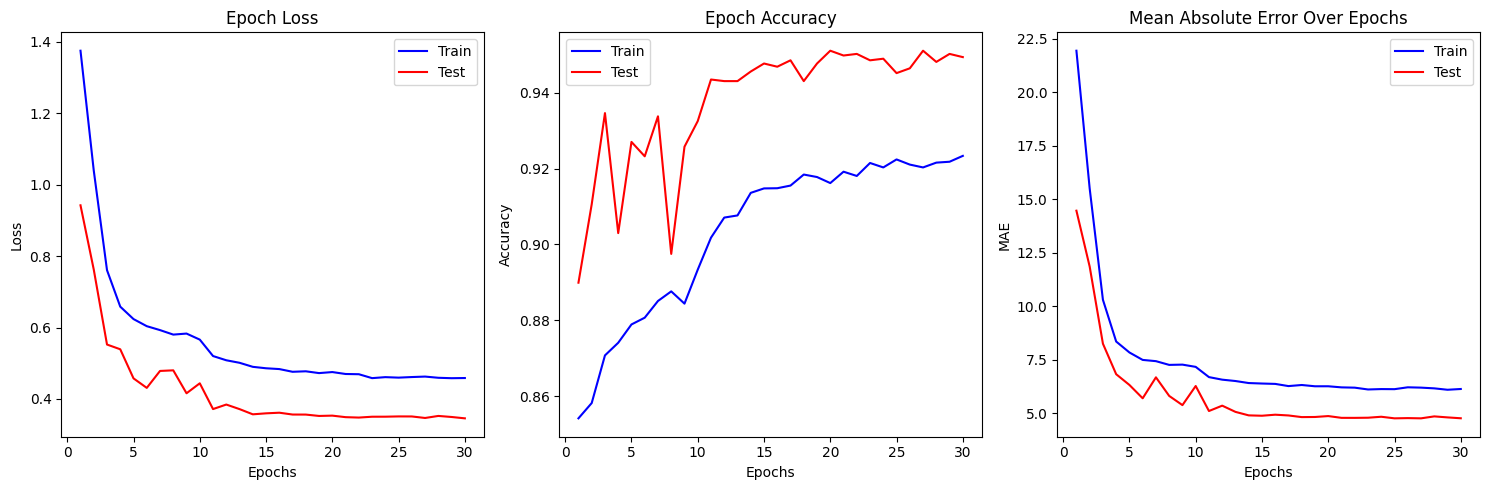

In [38]:
# Plotting epoch loss and accuracy
epochs = range(1, num_epochs + 1)

#Subplot for Loss
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(epochs, train_loss_values, 'b', label='Train')
plt.plot(epochs, test_loss_values, 'r', label='Test')
plt.title('Epoch Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Subplot for Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, train_acc_values, 'b', label='Train')
plt.plot(epochs, test_acc_values, 'r', label='Test')
plt.title('Epoch Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Subplot for MAE
plt.subplot(1, 3, 3)
plt.plot(epochs, train_age_error_values, 'b', label='Train')
plt.plot(epochs, test_age_error_values, 'r', label='Test')
plt.title('Mean Absolute Error Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()